# 1. Định nghĩa bài toán
---

- Lunar Lander là một bài toán học tăng cường, cụ thể là 1 bài toán Quyết định Markov (MDP) rời rạc.
$$M=\{S,A,P,R,\gamma\}$$
- Trong đó:
##### Không gian trạng thái ($S$)
- Theo định nghĩa từ Gymnasium, không gian trạng thái rời rạc $S \subset R^8$ 
- Mỗi trạng thái $s\in S$ là vector gồm 8 giá trị:
$$s=[x,y,v_{x},v_{y},\theta,\omega,c_{l},c_{r}]$$
- Với:
	- $x,y:$ toạ độ của con tàu theo trục $x,y$
	- $v_{x},v_{y}:$ vận tốc của con tàu theo các phương $x,y$
	- $\theta:$ góc quay của con tàu
	- $\omega:$ vận tốc quay của con tàu
	- $c_{l},c_{r}:$ biến nhị phân thể hiện sự tiếp đất của hai chân $left,right$
##### Không gian hành động ($A$)
- Theo định nghĩa từ Gymnasium, không gian hành động $A$ rời rạc gồm các hành động:
	- $a=0:$ không làm gì
	- $a=1:$ bật động cơ chính
	- $a=2:$ bật động cơ bên trái
	- $a=3:$ bật động cơ bên phải
##### Xác suất chuyển trạng thái ($P$)
##### Hàm phần thưởng ($R$)
- Theo định nghĩa từ Gymnasium, phần thưởng nhận được sau khi chuyển từ trạng thái $s$ sang $s'$ là: $$R(s,s')=\begin{cases}
+10p \text{ với mỗi chân tiếp xúc} \\
-0.03p \text{ với mỗi động cơ hai bên bật} \\
-0.3p \text{ với động cơ chính bật} \\
-100p \text{ với hạ cánh không thành công} \\
+100p \text{ với hạ cánh thành công} \\
\text{càng tăng/giảm khi tàu càng xa/gần mặt đất} \\
\text{càng tăng/giảm khi tốc độ tàu càng nhanh/chậm} \\
\text{càng giảm khi góc nghiêng tàu càng lớn}
\end{cases}$$
##### Hệ số chiết khấu (discount factor: $\gamma$)

#### 2. Trạng thái kết thúc
- Tàu hạ cánh thành công:
	- Cả 2 chân đều chạm đất: $c_{l}=c_{r}=1$
	- Vận tốc rơi nhỏ và góc nghiêng nhỏ
	- Tổng $\text{reward} \geq 200$
- Tàu rơi hoặc lật:
	- Chạm đất với vận tốc lớn hoặc góc nghiêng lớn
	- Rơi ra khỏi màn hinh
	- Tổng $\text{reward} \leq -100$
- Vượt quá số bước tối đa:
	- Mỗi episode có số step tối đa là 1000
	- Nếu không hạ cánh hay rơi trong khoảng số bước này, episode sẽ bị huỷ
#### 3. Mục tiêu bài toán
- Tìm chính sách tối ưu $\pi^*:S\to A$ sao cho kỳ vọng của tổng phần thưởng được tối đa
$$\pi^*=argmax_{\pi}E_{\pi}\left[ \sum_{t=0}^{\infty}\gamma^t.R(s_{t},a_{t},s_{t+1}) \right]$$

# 2. Cài đặt tổng quan
---

## 2.1. Thư viện, các hàm xử lí chung và môi trường LunarLander

#### a. Thư viện và cài đặt

In [613]:
# !pip install gymnasium
# !pip install swig
# !pip install gymnasium[box2d]
# !pip install torch
# !pip install numpy
# !pip install matplotlib

In [614]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
from collections import deque
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import random
import glob
from IPython.display import Video
from tqdm import tqdm

#### b. Các hàm plot và đường MA

In [615]:
def plot_rewards(rewards, moving_average_window=50):
    # Calculate moving average
    moving_avg = np.convolve(rewards, np.ones(moving_average_window)/moving_average_window, mode='valid')
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(rewards, label='Rewards', alpha=0.5)
    plt.plot(np.arange(moving_average_window - 1, len(rewards)), moving_avg, label='Moving Average', color='red')
    plt.title('Rewards and Moving Average')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.grid()
    plt.show()

In [616]:
def plot_losses(losses, moving_average_window=50):
    # Calculate moving average
    moving_avg = np.convolve(losses, np.ones(moving_average_window)/moving_average_window, mode='valid')
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(losses, label='Losses', alpha=0.5)
    plt.plot(np.arange(moving_average_window - 1, len(losses)), moving_avg, label='Moving Average', color='red')
    plt.title('Losses and Moving Average')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [617]:
def plot_fuel_usage(fuel_usage, moving_average_window=50):
    # Calculate moving average
    moving_avg = np.convolve(fuel_usage, np.ones(moving_average_window)/moving_average_window, mode='valid')
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(fuel_usage, label='Fuel Usage', alpha=0.5)
    plt.plot(np.arange(moving_average_window - 1, len(fuel_usage)), moving_avg, label='Moving Average', color='red')
    plt.title('Fuel Usage and Moving Average')
    plt.xlabel('Episode')
    plt.ylabel('Fuel Usage')
    plt.legend()
    plt.grid()
    plt.show()

#### c. Môi trường LunarLander

In [618]:
env = gym.make("LunarLander-v3")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

In [619]:
# Số chiều của không gian trạng thái và hành động
print(f"State Dimension: {state_dim}, Action Dimension: {action_dim}")

State Dimension: 8, Action Dimension: 4


In [620]:
# Nhiên liệu tiêu thụ cho mỗi hành động
FUEL_COST = {0: 0.0, 1: 0.3, 2: 0.03, 3: 0.03}

In [621]:
# Sử dụng GPU nếu có
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## 2.2. Random action

Trước hết, ta sẽ khởi tạo một lớp có tên `RandomTrain` để kiểm tra các hàm xử lý chung và đảm bảo rằng các chức năng cơ bản của môi trường hoạt động đúng như mong đợi. Việc kiểm tra này giúp phát hiện sớm các lỗi tiềm ẩn trước khi áp dụng các thuật toán huấn luyện phức tạp hơn. Đồng thời, quá trình này cũng cho phép ghi lại và hiển thị một video mẫu minh họa cách tác nhân hoạt động khi hành động được chọn một cách ngẫu nhiên.

In [ ]:
class RandomTrain:
    def __init__(self, env, episodes):
        self.env = env
        self.episodes = episodes
        self.rewards = []
        self.losses = []
        self.fuel_usage = []
        self.model = None

    def train(self):
        for episode in tqdm(range(self.episodes)):
            state, _ = self.env.reset()
            total_reward = 0
            total_fuel = 0
            done = False

            while not done:
                action = self.get_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                total_reward += reward
                total_fuel += FUEL_COST[action]
                state = next_state
                done = terminated or truncated

            self.rewards.append(total_reward)
            self.fuel_usage.append(total_fuel)
            #print(f"Episode {episode + 1}/{self.episodes}, Reward: {total_reward}, Fuel Used: {total_fuel}")
            self.env.close()
        return self.rewards, self.losses, self.fuel_usage
    
    def plot_results(self):
        plot_rewards(self.rewards)
        plot_fuel_usage(self.fuel_usage)
        
    def get_action(self, state):
        return np.random.randint(0, action_dim-1)

    def display_sample_video(self, sample_episode=5):
        video_render = gym.make("LunarLander-v3", render_mode="rgb_array")
        video_render = RecordVideo(video_render, "video-random", episode_trigger=lambda x: True)
        for _ in range(sample_episode):
            state, _ = video_render.reset()
            done = False
            while not done:
                action = self.get_action(state)
                state, reward, terminated, truncated, _ = video_render.step(action)
                done = terminated or truncated
            video_render.close()
        video_files = glob.glob("video-random/*.mp4")
        return Video(video_files[-1])
    
    def test_model(self, episodes=500):
        total_success = 0
        testing = gym.make("LunarLander-v3")
        
        for episode in tqdm(range(episodes)):
            state, _ = testing.reset()
            done = False
            total_reward = 0
            self.epsilon = 0
            
            while not done:
                action = self.get_action(state)
                state, reward, terminated, truncated, _ = testing.step(action)
                total_reward += reward
                done = terminated or truncated
            if total_reward >= 200:
                total_success += 1
        print(f"Success: {total_success}/{episodes} | Success Rate: {total_success / episodes * 100:.2f}%")
        testing.close()

### Kết quả

In [623]:
# random_train = RandomTrain(env, episodes=500)
# rewards, losses, fuel_usage = random_train.train()
# random_train.plot_results()
# random_train.display_sample_video(sample_episode=1)

<video width="640" height="360" controls>
    <source src="data:video/mp4;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAAVuNtZGF0AAACrgYF//+q3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzE5MSA0NjEzYWMzIC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyNCAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTMgbG9va2FoZWFkX3RocmVhZHM9MSBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxhY2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHlyYW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTI1IHNjZW5lY3V0PTQwIGludHJhX3JlZnJlc2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAgcXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAGwWWIhAAz//727L4FNhTIUJcRLMXaSnA+KqSAgHc02r/Du1VgBLaz2OWQiAGQWBIfmrsg8f1HnS7Dz7CWwHHO7zAzTaGcoYVrjMaqo3FyvBmuoVKLfblBFa3XO1LA9Wj43pAJARrppHa88aOORGy5SjPdoOmJ0VZA+UE8qF/Cj7yeDNHPbOIGWsE4lqWlRs5SMf+BJZTkZd9JeaPhcrO1Cp2pEf92NZPXwaMv3HgS2e/Z0xneCDV9nQ/ZGjfdYMQhYP7t4HtRY7fA43VuzOM6/N7Tf1MSG74tg6uVf15r2jAZnusBM4fDh5sbTlGxAAADAAADAIHus38uv2e4BP/H/UNLqfEC6GHmGtOlqmyZ663ASOAADTAAABJQLMFGQkAdwd4hwpxTSPkeLUbpdgQMMmsgpufFumw5uXRvTbwmGSojTUVIgLRmDXyPU03x2K2Hdpjf60BRYafOO3Gd88LboV9L8J/DYYsI5Vfh6e3QE5V6FszYjr1c41Mf8eyKn9LtKcB1S7K1T1tkcd2k7dKmtkcD1l1yz7w/lI5OG85LIaA5J0Tkw/YRawqz6YEiTKfQqNLoyC+Kt9cCs6TmDCKZLzhLN6xoZmxWvtpm/KVPDcUIVqvfhya5aY18KnJR3qxtPII1m34zOY/bJo2VPwnoBIkbL4lByyedAA1dIJIMD+wrriS0PzxN46dtgEOuRQZxNvSUXfAUVmfls6gEN/FLcWdLiEkz1bjoSjhBhi80+kkNxxXsMoX8TCEDvw/DQ3j9YvcBxlGZrrn2utn3vG34SmuwEOPx49zBgPGqKKNG0r9qoKZ/FXP3xmCIuq+D0z5OmouwZbU+p+Xk2RHTsHkF2zjwLMGNJBZkolzpRL1zX7LBZVYlmLzzBIQUsQBH/4KwXgMEWAAg0GlU1rDQ9tdkkKvsktLXteA5LJy2lTK+zbBpkQ2aCUHaywKY6NEJWRQ+tiVw3lDID1xYWND61vxCsDPzkRngfAqOkj1t8yPM2RDxTR+fpTdoO9K7jXmKfupHE/udrtboHVkePHwXbYweSUsrMvhBZSRPzfltyDJwrrCPwkILBBvd48Aa1iNmiLnBI3/pw4OHBF1qePPN/QnKIGJUfkBrTaTRlJGWSaqbp7qR5xPbhTpo1jTOoI0m6Vx53Lcsy9yt5qSVjdtj0yDmB/9HBhY0qfQu+uy3skQJHWM9S5P209KhtKnAaG+L48ADh0piXra696EHwdz/CeebN0EKy1EcoiCwhTi9c0PCwHReHVqPxmy0hIaD7hj2hfE8Sjhnx45tqWqbVLH7N5Ve39qIY0rJkS09a5s4ufAAMxN32qCZKsJd8g1W+gL9XqBacUHWZoruYSl5JHbvZD4K33AOC63SVk1O0z7w6v/c01zc3U0g0MS4fEB7Mf+LsodjOm/psurvu0dmEP+235dM/ufr8wmBMKDFDSo9F2lyWqc/xK7c09GQczt8OUtOaAcFgpHXa996Nb53kdzmQaXVtFtCs8Ssq0qqa2O6YLZeUdkdi0CFBEfkaxEOncrdHuBlDYMvDEG8z8UODQQ76SB8MX7uLavJyC9aeWO519PVYuOFeCIq8Dvw3eVLX9xnm1GxYlOL21Yw1lOx61ULghyJ2hZqWE0q2orHJi4ptHfO4m15WD9ngJ7+vj8Fo705x8ARqcy+of7/1DThYHZtKwJUYRxcETOc1dC283PLVLcvnuaLmMnDOVdvvRwxz48Yy/eoilJc7IKGugAg95Nla/OIPLIKVVfSLvlxTARGwtx7zp8Ys/QnwaVhqoHdWNKk3ixItNprq/MNTliBOpSbcyOYx7m8ZwhK/2CuuDUgkQhFliZSPSRPOq+QPCsUVeqjIfqL6xvvBcsW7JNnXlvibRdHZm9ztfvzvICmkwLa67pjUA2C/R9NDvJAi5cbS4ikpVtweWo/lApp+QZ7NnxyJoVnq3+CJn4/wm3ivLVLKsHQYq7Z7q09rRQeoahE5Cl3u4g7qyHzf18IwhYZHnlhUCIZP3Dw4KDLX+mS160Nd4lNCrXsOq2gFOkVEqRcCgAVr2E+B7+qUICEBJksNfOLXidEWyEeOfrVLtpF1rx/psCkG7vUfOGaWCkWryqLersEPiD1M51gZ6y1NPyzz2+A2iU0ZSoUxQ4JBLwSosww+gn2u8XTKjWIIGW34YSmDDik3b2Pj7yBVo+HD00bmANCV1K/xhapkiO3CCsCPK3vAMUi7PwYABS3wjS4cfiHCAJQPsx1JUXEGRV08JqcOFlfJmcbDjM1KirwagvmtvPcjClG4NDCz7FSIh82R+8AAAMAAAMAGbEAAAGjQZokbEL//ozPL08FZAAcllzb1blM7ma3VCiTlCLWa2xc/eMuEfdZ/HTQk7jUXR9p3VIc627X5LPLbTolpbOXywOQ5G8PNft2urrQ+JWzDJzaWIxWOPuxTnIudiBdxHxMfw8w2HOHKJuYAAADACw5yjJW7tjr7i6IatYvUyx/1Dcd+AkQsKKbUGoy76X0eR+oZyifxdlF1jVQ+BJW59vu2qZo6X7zJ4ON4UEYc+TcpKskSk8ulW0KPj8H+tT7CXbw68ZVFiD+XESVXJ86EjIX2qcrk1TV39kd2gQB+Vj7HQIm0Rao9VIuO7JPmWgnq5IvXjQrbqSAxe+SVTP0I/kMpBHWSq2qKBkpppOGvQxR1qtsxenzdI73LAtvU34GiFkIo9+Higwz/vl1jaVb++q7b65FBumEoF/V4LS5xG/vNQAN/LmtlNMH+S8/OxFyM5n3n0kJcjJ4tG9LMrQr/Qrbhg6wpKR513oO+vTC06FqYGIx+6beKzfWh3NxMnyApOQlgPfJ37V32WRdF3W6YBGEfB3G0d/o1U60GZs7O6NUewauwOAAAACDQZ5CeIR/D11wg2cgDlaESAZ7FSB0u4/etVHM5pEBoYDXa/8o1UUEYKxagOghlNtCRO17sx74+UCEgx7s8YHU6RvMjoqrPEb/oC1qBSYdVFklR3JyjuTBHqIy+2nGK3yOSutDyzDHf7AfAXzxXuO8v41ubt5Tqo0m5MInytJ4ep9AC2kAAAB0AZ5hdEf/FMOi03x5VciQf4/QAJK/rJsPkJEU+T1DhpYQfpvJaY3t2dOcr5t8iiDlffkF+sPNhD4i3WDJUoXLS9RrnjzVet9bIFHhI7ukAFGC+rZYTIpYe2hUngqtMp67giUjJA9+F96I+pIFanmjFAQAm4AAAABoAZ5jakf/FOpp0ZEQc/YACcXxn5i2n5EjobFw//b6MJRdRQWmbIXqlF4WuT8bFrE0tfBVScmRvS7TLRiIWvtJU5Vm5Sv0ANdJMBb2P8lmp8pavxe22BvSPDL/GuU3RfuXfrPje+gcBH0AAAFgQZpoSahBaJlMCF///ozTM3+jYjxqn4UYNACy6Jx85dQrCywUYSAKKRgGFozXVcs2LSxgGB0/QeyvkB/8mXuGLbEnFQbjBsr5qXS0CeBuzX4RlJrXFab7OLQsZ+lhAAAPs8J9KpZOVI4b7V8njnFrUOaCJq6dfrD/9alA/sorRzKW3T7pVqfuKXgDffD2+8kPFqSHR4mnbg273u2qZvlvEe0upPNvOESAP/q5C0q/n6ryO6R2ITLOyigCxDWSIw81/Jj03+iCmRWAmpTj4VReG38V3hsjEY7BMsWcL+MQR71V05D0StUqAO+K2NcRubFwr1GASYRH5NA4GLLk4YUW7JQP5pDuzuRtWiWNqlAvp4lwV6m51aTMwmfkO+YEZvtjcruRShyRFLrNxMszP3jzxEduPIjcGorSt2qAqt/dMY/DofuFwoqWyVEP8YBH6j2q7CFrSU91oes1/DJtMmwCHwAAAIdBnoZFESwj/w9oipGTk6ceY+tsLDtC6mwFk9QOLAAlqWoYNktk9Hp8Y1EmFs1aLOktHFySRqEVzc20t/Q2u9iPCTrSVGfXCTgIlNfsPA4uHK/ZIAaOy5LERDhDV+wgJmgMyjIeKBeyyhM0gD3b1LDx+A9/gAg2iIJgSNqhMV112SYXKk/UCpkAAACNAZ6ldEf/FOs1vVHiugAHwCFPEhTpneSzXQGn9hsG/XZFP1asWhdFmQehD1lCv4D7BdBpSF1IkR6Mb2WScCt8l/DLiP6ITjN1N90BD5IEjCY7e9Y4iAZEuTb+qqJ9zgxN80MFzKZAXA7PMqlvQA9isX8Mb/JXarAyq+uLnq1R1a7f+y7zmsCVBZWZIAc1AAAAuQGep2pH/xLIguua2P4AB82M+MV3y5BL5lFfjIKC0ynkSMGaXqvNGaLtTtKxq0UBJbwTUqy2Qos4Uaf68V7Q0sz6V7CE1dfFp++txNjYSaXaBl8zPigteBkpkpZtVYTSVqRx4WM9eRiGb6k4BdG1mmtcgw3BP+G7pmmVlEPTSN5g7sQyuMP2M9qo0uAwUgerVZ0nyKjs28EbdMxFrw4142bJ/D1kZBIDCjv4PybG/2YynPeO1BwTzkvAAAAA00GarEmoQWyZTAhf//6Mw/dLU9pomhxxQ6AAAIpp8ZIUuxhbbJrYKFHg2X0VgryKZLFfnN1hsrRXCg6RjD8qX2WE5leSPiV4iUPmHl8SxDAAAAZXYd6Kaw5fbPE4Dk10U0F7rrucwRwGLTkX9lUEd921TTev+UWUuu8GE+W0uheRjWgx4qSAyyHCJA4TK5pBX0+/PUR5kw56oWbbFUNj6f6wVrSQubc9krVV12OvblUQgdUTDF/NRLD4cnQGWyFPh9QibbhaSbAUxlIg7TpgUAaDgxYAAACPQZ7KRRUsI/8N5XKB0sOuRAOeq9NIIm/YJaubc88dqtPc8ALWff8s2Vc0kzLWqLh8sgvPvrlqej77jL9GD/TXcNgkAKFWCaFsJjFFHoN2rdfo/jHHaI7fko7CqpqEAQDCC/OyniU+zVa4JJjlK+BiOIQitO6MYPO9D1vBsRnJ02X9eJz14Ombn8s75e5GgekAAACoAZ7pdEf/EsTGy8rAC23vNNPKIz58l71iyi8e5Sq1ezExpj2H2LP8mCkIQHrh+0Cmg82gKUEfKEsDXuhIPjanLiI8NPUJbdjQ1Cw+xvMNsHXpletb7qF7tHNwgi/BCpy08Mgo+P9v8RJCw9TBHX8CgIDmQD3i7HDgiuUuEfqoWktClGKiKmZ7BZQQaaaqeCVAcbWVEVgdSoBgyGQvzSD9T5lFNAw1LAGBAAAAgwGe62pH/xLbj83lY/nRPUgAa7xtPnP5Wx6P1ix4jpQXjDSHtno4O7dwchf16nnXJwK5ojayakGSV7a4spYpsF1b3YMko9bl0HzvROdB66ezseAqoGgQcnvxLgBusfH9YIRJDOJ2OqAXw2mxRl9eYHNi6v7LgtJjbMWAom/STXdswhEvAAAA/0Ga7UmoQWyZTAhn//6eIryebhEANL1QjG91otNQw8O2Dp57e52BtDPbon/Splcm4CUzpHSpBuEOAPJWM7fkH554/ZhAAAAeZmn/9UlVXCZ94EYxsJWrbh+gzKq0S2bjwIeacIl6FLOTtVf0jT/4fMkvZl1+w6fo8T+3dJUPnIqBMKJTIZTS6m13MxuC6i50sT6oV77tqmfy9eUVfXd8tUVDb5quI3HNZY1VUvvys0WDxCcdu8MALVcgGHMAzaE7dGPRvxqFqRazr50nqRSBT8KA2eRa89CXOlk0xAEtD/JNEksgAigQDsAW14KwkpF5266DrqoHy22e02ZgOADagQAAAR5BmxFJ4QpSZTAhf/6MxCV460HjgzBpDTACJFTpMLPkLn/3qVVVnypHj102aL5e/nZgWZc7tnNPIOwDXr5mQunos44x1ylvSfAAAAMAEfdhhnXdaLqaO+gYaFYRuQC7LeeaiblnkJCy2I2xpWmpu6qvtRrObwAm992tSv99Y8HAg5lKXJf57yqMqWsYuXNTc+o1ZPqH0Yn3S73EFW9hBVULv8tAcVM1MDQycwfGmrtf3p+15SHyVitkkSQM1jRAP6eyVqsUYPLjH3deHYtYg2aK0zkgmJLr+OeHIHzhhm6VLUSEEr390KA50JZrGaTq1P9CZ0OGdP2eIHbP/kn11arshoSFq3vjmL9p8PgDXPVgOQP0X7YqAQ9zraVwAFtBAAAArUGfL0U0TCP/DRFgUtfux9vHqwBlsG78AUxk79JEiVXWpqwCqA2OP1Pf7WxzN+8e6W2yBtKM6ez+Gzokm5SdgtllvgwnECOC2mbaniZGll0xDXZM0QuYW6eKDcxFJjEViP6h7HGt7BV5itPKQvasoku70oJp2+hFw45iMbf1ryiW96T8XLKeFAEYbvesIL9Ngfatto4L2QEqImBuPlrB7mdTQrb+qAHScI59QFTBAAAAiwGfTnRH/xLu/uXyeAA3o7NjFoQ9/FyXQBI04vLmSQg+aCQE3RZuvV3ZMqGx8pXApmY7D9Bq0pQGvx1rNWo36asOciAQvOLtkXGl8uTpbsoR0HZo7vi/mQ42kcEUPMY9Qa6uhWZbLgNaKJzy8+oMDBmywEE1dcnJv8iN17IQWpCeg6xhFFrMgY4gBgQAAACYAZ9Qakf/Eyu+weTKIzVGuFU1UGAELwfm6r5KM4NjkM/ozaZ5CLGc3fskuUPUBdEcX5H016iU1rYczI9oScUDYiECV21HK2LqKaQLsfVQb0FWQ/So9y8kOjtun9gpAXhVHSYXG86luowICKCJ47uQI+87t7gGH+d3aQ0uy45UbCZGBBsbc2dcBDzMbuh+lfmn9PJv8GTziPgAAAFEQZtUSahBaJlMCGf//p4jTT/S7+upFrIAH4u4Wfu2ou7+VDZUUbzqxom/Yz19SOnE36KXz7MbRFyzuB4i2o7g8hF5nQCJgWddT5AULtGz9+AW5ytXs/qpvlTQPTpN6k6VrdT0JqsdnOdNExcTbp8ZAKlkwbHVf6kADMHMnVefm96BlwbnbZKYEVpZoQasO5/tBF4T0lJD/nW54hKlwQiY4GiSLVuP39IgARqfLEpcz2xPIUZh9TtenxYIasgO68v7Bp70wr9cWvYyuLFKOREssEm3+O1MkIdTMi8FQI4vFrhY0njzVeAa61WaOevb9bLLID9QJvVNWDLP7NHUEq9/KVTfXHb0TW+5d4qX0Fi3AzW6ZCGdiaA8GJsY4p1NHDY7fEs+fe9yCQA/Xgjudo9BCfVNqNeCC06u9wTQh98Hk1gbYFlBAAAAlkGfckURLCP/Df29jrvLA898u8QoAIbNLIAHENHWMEPOtrYVY5z9zxkMnduPTAM1fb3p/t3cWDdTNl5hYP0bCfFQVUe5jadzhRQOMiV96RVGKuaqCu2XW7XX+EpADRDca9BecTlptlvhXLoHkVrxRRPX1kqQkQeLo7/4ZEQcwmxx2VF8NvaRyWly0y7MOWzMbW4SpnDBSQAAAHIBn5NqR/8TE75qRFM76DHdDzgIjygAFQd5Pls19bRcrL/NYys1V3cwfCyRF54/Ge/9Du9sv0ROw/ZWope3/dLcGa05zXndgx0J/r3AtnmWIrPj0oczqYqbzCY87hyYjcv4OPm+t3RyqxgsfCJMTOiIiYAAAAE5QZuYSahBbJlMCGf//p4b5wIYerOnpyclJwATrRdyQvD9GW90tjDdiSLKXIp6YWh7Atk0acvm+LsD/bQ45t6V0ST7qT6svOy6ZUq/kF+J7CtDuuJY04YjJrq/NL02bx7Z/y1DicXerQMyiJAFN7qVxcrTTclIlZOPqAAAAwAOU7xLu2PNQErhqhhzPDjac2YF+gOKrOzmTbeJfpMNlDjIvOCQQHOyPbalNwDvjH1WulDb72JO3ovLdaV8GKCRIS50dwvfPH9CprlszoDmOEeiERncdgumIyFzrxEm7eo/zb309kwPmPzAB/SLf5VsF40cR5IoviJLqhNWBGmBssJBbU4bN227o70iOP1kDyoyEmE3R1Yo7vuxVzN6BOfz+iFI2DHl14qUBXri7PJg/ar09VuB6jBOX4BbQQAAAH5Bn7ZFFSwj/wxvQ7aWxaLXOV+QwALqvd/8oyqgqjOmVLXhQiSvYZOBGaIkJk2Ye3CF+Nznitlc38UVOF+Wd65pD14yhoukPGgPRK+gvkoz50riX4MABlff+gBzdp2Cm0A28NPVFiFSeNAMwowujX9LcEBU791+hBDDOJHQFBAAAACTAZ/VdEf/EU/MePaNDpbIYAA/lHddsMzfYMe/F1IeMpWp12Mo7iNOywWtkDFpW3IS/+8cp3zOX4wCqDMcCxOP+H1mS046Z05AIZvjAggag8BIpmIMkBr0LePYLKmQMAps+Ve01ARMo6ObhQLSxVwQnRPxK5mUOI6ZPGr8RKx8IIA5CLm0YKvE/8m633O/UD/FgBWxAAAAqwGf12pH/xFF8DHTPLwwIcIRPwBEbQ/QJ4UJSuStPY/cG7w97Y2jrbFyMcIuT7jgMCjONF51KCCt+iqxls2r1Llo8wmlMmZ4jWLLPWeGhIYR3yEuYJk5AEwoA6PJfrEwsbvyAZGgwvPfDKm7aFuE31MreGAyryx1ZIjpc2eDQS8zBpO4bytRBLIhTwMPV2jXJCGAiPcwQCf9qC05E4UIKZNs1lJ77mqywEyLiQAAAQ1Bm9xJqEFsmUwIZ//+nhwpNxMBCa6lguurWgM8tOsgAc4fIkHONIg197Tli/PXbLUS0STA4cTxK20PiXeq5/yXmVFhY7OtHZuKfHrjQWH9okfTs/yp/P4CBsvU0poTSLHSc2Ufe2K+gqUljGOCfscj9AQEpz9wY8h+zj96Z6ROxbTPaUuuH+AcG9bDhNsa770dq+43V+sz87XzSMXlDYAPtzYKC5SoNco5rH2T8Ke6HhAXwdbUhXLUOS/P6JiUEIKG6jL4OY3ZweGYyMd/bezixcA72PmKhf0iUxYq3DZC2IR10x2saLuv+YBooSVFUkqb3JM/R9wlX2B8yBInlsSf53v2nDzvFvddBvkUMAAAALhBn/pFFSwj/wxxzv9VEQpIIMf+gESjX+fBS9oH/GUAJbmwuszBZgVXcrj1xS3YGXbYxVGaSHH+xQirF2lo9/BEntZw7rcb2iHsctzV4p2KNMIuor+vtCrMnFQMXLfJTA1TgnJ5hW7HHmiVmXb/rLWWGELgJaM1E28Jbc+iAPMVMM63HyKtHCa9W8KynmWRKjRsSWKLNCynSIskd21811TCiQAdY0hTghGW19xrDM49dnLCo6NZYN6BAAAAsAGeGXRH/xFfJHOmJoDowRQhi+OgA2ybpLze4CjSO4RDWo2fGqgJiOa9wXKIvv2XRYSRAt4jhpUJ3Hqo+3LFIdg69LPrfOO95b3BwRg1swQK3sHM/9XYeUmVaJ1WKPjm7kXbMOfi9uux6sMv7+DQlnNBXB1+UUSpBLev9AyK3lfsWKL/3TgJs47TVjQF970nQaGvdZNtC8Ds3tMrrAa3kxwLH/hVw47Dycbl00EWbD5gAAAAmgGeG2pH/xGOykxuMGHgBNXYqT42JC8/sl9JQXU7rPTmfvTLNyx4MTb3WP8FFY0BdZr9Q/DTXMOGiTwoKLtONVdOSktGOyME9vf9rfA2vaVA6Vre3suK/bDu+IV2msjEg+ddBBCJQG7QHCfIhYuyn1TYWMWG+YwYXMGizpnEA0cekYoOJhZwGE3U9AGVzx5w2Y9kDnEe+kLGSXkAAAELQZoASahBbJlMCGf//p4dXsdQw7tJPLBWyhIVAVzwhpv3lx+56hsZarm10M7t4D9pV2N7okyVHJ/BF1fEd8WC446Zd4K9jdkOJydtWlq33UOI0VSnL1NvqTxtQZfOVa3AAoG3GiFEoQ7QPrpUgEAsI6ZXBW4BNuCSIuvLQ4czs1wFCehYcGHy3nJGISGzCHrWO3b+0DwkpH1KzCdYneJ1/Xg/mWeCvrJdFhl5U84N5DZu8g1KkPJpcjH02BqOxsv2F4oUIcu7dG/AcxbFQRjWaG2qJLJskhQlPpUbEeGeEpznpq2LhbIiolZlrXu3bPHvdOZqICpHhM+ZgtkGpm2wpS7yjMuGlLDVwws5AAAAtkGePkUVLCP/DJi7YqKmLsdSAEtVjtfTWbgDzZPpzo8xR1BoxaTAlWG0I27Z/RUlMLrdoZNIYSqYnJbTFPTO07FOREg+VGCt34GAwXs7qFlUQxlaWvpYsHaTNwht+0iXxM9XGyZ5on57/sv528NFhUt5RKHrPZ/FlhcoXbIYEeOqKuu6aE7YH7+khFzeFjxijVDr+/pCX3a7FAXjN8aAAGnPlXEwIdgiJ48QnQ3xY+BuBK+aoEHAAAAAugGeXXRH/xGASJTGAqtPDOdVR1gtm2FMXijABx+r50b9CCuIRss+Hq41N5QVPNQziPBYE4JCoKaCzyP+AO2q+jEM5OqiK9cWzg/x8e3/WsHhtHE+bmf5bhIvaPObrcZ+1kG2Z8FSEBdytlifZhxLbSkVJtZ7jCWZQ8KUZ2mOwwnD79ROgWKqSIS+z86tbAOcUi7RymLjmsIYpVR5NvyT0DlSRBBGQTPFwUsCoK4nAvFQsH1Ex18e7wAtoAAAAI4Bnl9qR/8RiLSCAYOzSN/5XABbKO67YZm9+nEbp9UZzReEKyLmWe/NEsNXpQ/MKrgHhjcAdi44BdXzYDhfPfiO1sqbao7TohsGDb5hHETwh+MU3B3tTw3k6ZYeYpqLg+68n1Ml5cvljYRMbLiVeDf0k3E53Y7MNPxB7HDNfdJwaWevET+DYLk9XXputOS9AAABG0GaREmoQWyZTAhf//6Mt2BP6zDllWTPydIfUOVu1QALoX3bcEYz4OGsGuGjXWmAnYLc5VeOFlcucTQGHCN0AmvZOU9qI/SrtXi8t21+BEOEHtcL02YuOed6T6TCIryb5tQNB/kn73A2SZiRWXOQSHv19lK4NkhTOwilU43ZK2wW2me5rr23W8Ywo+YhSpIyOBCVfK1urg1IKehhoid4s+Je99mzamG2vqT7u7Um8FI+Aev4qVUmKtOCvCh/BxMKL2+hE/AhjYWm/I4MmOa2Ds+/PeEbNRx2h6E7ZVeMk8eQr1grNgGX5lAqBwh511ifFNZYklLQbiqEI2RGb02PhBoFD+hhopGDiVSZfw3nGAEOR7Q3zz71lzPkUMAAAACvQZ5iRRUsI/8Ki0iQhry6JZYoAF1XxVwn8xq531S9UZsjyBSfGnGz9JL3Fe0Zmw/jggWn3eD6SF1xSMWFshCAiuqO+Hg1WgmVB9/WrcQ25zmzk1jv8fnSI+4I1Ts3p4ND2j3D3C8CzdxKnkp7ChdTzq0+AwzQXuyKs+OQeBoZY9tJR1l2SYUfR+5rezRiWCduABrgBPeAPO9AOD3MRP4FlBCL2YhF6fck/NfR6wDugQAAAJUBnoF0R/8Ouavbk46F8ANqne7a4eviI1+Weei5aPkDp68dIDnaoRIVnZZXOZ9guTVP8esdwgNAfvKZlJJ96+OJiWHzdZcYvE1uhiO7xaHjOIRg9luDF8+JXAhWZob2z0K8xRGcD3JdNOyQVNF0TJIlqoYaKCvZUsKZmRTkT8zB4wp6Y/udQA72rSoOkBcSp/mJkfDAgAAAAIsBnoNqR/8OtSRbEAAjDRjLKZXAV/yEqV2Qe05jvFybofEYdYGIx/zIVu9D9EszXK/fVfOh9+aO7NJXgSFn7EDg+TRtrI3x2yz6WZMzlOGv1xYuo0PTjiTGmg8cdCx/kCg+k1BDeBJUloDzu9jzjLAou12B9WkgxjAJjwR2IrfMzslfwHHN69BAPAd1AAABFkGaiEmoQWyZTAhf//6MsiGWuKrLp4VFE4wRoDudcgoMyjlcRWaMXwCxr73R+XtQQjIae5fw+jLR4sZTa2ugYAbo7ztZXOljEMRU/Er7COGxwzyP5azH6zMeqFsz1jzGDbZ+Xc4308tJpKTRxkQBN2lhnFFIZkntgRu1c91c0tGFTt6F/on+tPK38PDBuPIVJD9IH/8LVlay+z1SvSEKb0z5PUhogANyArifbOpCmRlw6whOgEOafCYanohyZfJBia7/mvxP1R38gQn6psa/cLFU2Ykcf0DTEnkzxRGoDft4XjnHiZVH7u+X2/kOfi5lkbyBSCgE9M4qt1zlyGIoxzhFpEhONDxw48QMtRjh0AtpXz4QKpuBAAAAiEGepkUVLCP/B6+LmWpnvkT5sTcob4KfNBjBfnTWE4L8o4TL/T/ybPN+AweFcrpsxC8azmxXQ9OaI8Pkcn6ZV/jE7AEqP7uNBgxpkhcDH0mm76TrV4N/W0QvVRg5k2PHvat0Dye7VgTh9HE8U+gfYkF6SASsDnE/i7P6JvrB6KMFpuHrJih8DZkAAABoAZ7FdEf/Cw61LAcADavhdhYT1qTbpDnIqFJFDBS/l4UaSA1mpi3Mq6D/sX/CGNUxccvkaiue1XtLv9a7TO/HB2gyW1AKtfBAYKqAlAeNOMYuAKrifFSP74AclDv1lzPcZsnvV/8YYsEAAACFAZ7Hakf/A5z7366jcCKJBYZjb4AbrsUFA13Oo8tvOWYpjFSTYF4uyP05tK+XCz6iT+pmv0R60gZtmob6r09Kbc4qtXz4gDqyC/hdk0fT1de7rALLZWHj6/OYtZXy0lRKK8KjtjdbakmAo8a0ndkg4a5PtOSk3EWGvklPgnU++j3MjPzndAAAAO1BmstJqEFsmUwIX//+jLH5Z38AEihSEUW1dyCJf/uFEvk5eNVbrFTnglxaP7aedg2lUfOBVbdX036v9cZ04Z2LFo/Au0Er9vbDfsBPZTp6b7GLFYqFnOMQOzJnwfh5jw9sTSeoiS77glpplD/L3mnDmET7XhCfZjYHlMtQ4Af3Tj/X+hMVnQheXgyfByeVuhwoZEJJNaXebpzd1ASgM9BRkaY5gxCkK1ZIazftGrkHIhU+lyG8ZW9AOJ+7XchG/RT2MiJrIYXK4yLNOhQ2ts9hnL62LCT3qALabCvttg3e6LY7IEw0IHVceZIbD5gAAACSQZ7pRRUsI/8HtRL99ZmRRfDDx4/gAQEaBXFYuodxQg7CrhO72absVUv3/s+mwDtz1x1mv1EPM9XvY/lBrnHeYm6fzWF9VC6IC6A08ATFVQBHf20zciwcim/q/Oxoc+FMTg1CdlnQ3gsooeldiI1XysiTlY3qsltHs1TuEUerm0CL4R2sD0oM7jQuVZCmvpMECbkAAACPAZ8Kakf/DMaOY17wxCigePMQM0d4gBUZpW1X60E10sTCY6O+v/fqLFn41HzsV+AanCUWNRQddp3dl0jiqTHwDKy50+okBejJ0rSHyIfnBxllErWr2aYgZvrNj4V2tJrCidaWrr3JEbLuWt6bJIHd4LNEpflgm1uUWKrhkDdAPCwjSDYXFghb4SPkm/SCR8AAAAE+QZsOSahBbJlMCF///oyx/FHyPUAKdEDQmpYegPs4kXWnMdbsjbaiuBuLQshdXSMzUpuOY2RayfWzQi54t3OmuFn2ZYZZ1CQEY+1PYrc5CVV7QwbFIjqd0LNBKxM/kx+e/lEENR8VVo7C/RQUc1cl5VETUE3kkFdg7okB0x009eGvpkAZdwU9XEjbRPU0Wf+WWCedWdTdE9rIe6ZmpVO5jRTz4uqX+l/e84R8PIlnBdFMvqeT9DSp40hgQ3QG4J8ljDv9TL+nJOTjTkx0tuICrblxhGguUeDJ5uJ0+ZsKTPQYCu3sXgBja1x/CgUWvgNiYTEoGCNxG/uSk2lM0QygWGg/30I1SpZ+FRDVEqkB7Aex1B9MrSPYtaf1hGm34lsyBeFepdFYYNkPV1m9glSpXMpMngfC6ZxGvRlNKFBwAAAAsEGfLEUVLCP/CGdHIBq942pG0dWkJbfbkZ/o5NYtzwHl/F/b+W0t1mUws93kjyiBafYxMOlldpAV0xF/wXkDI0D1q1M736dCr/adZs/tgRHdhMRWFE1jKbyIKIYTab1RrC/OAwadAle1sUiJEK9veJN8txpEMs/Hm5MeGX/qFLAINfnY9gGy7KiizlqU7pJ0L/pswZbvJHDnvM9fJjKoSe2i5xeNsWhJvaBl1Xz24Al5AAAAdwGfTWpH/wvmMIypv1AArfQZmU/PQbY0m1bmnjfxW7VznFR2nmMAAByGS74c8pAu7J6CYrpqevJFyYCLEFY7WA1HJTLHFDAKZ80DfLYMD//V53JkSEaq2glODXz3Ul1LC8KgNqJKqY47BzY3oGToqOSsxXu8ASHhAAABQ0GbUkmoQWyZTAhX//44RedulBVF9YBmtBdN1AlROwAuoi8PObQdoTh2ap2DxuonFGDwEA6Y1u8V3d369RbROPAxBOT2edNGbIe/V8CKPNTpyewCHDm9Mb/925y+9lPENV6l96Ho6DcuUqgmJVqng5XII+hOj/yUT832BerCCV7U8O5IN5izpJ4f4MEFfZSFNgzFOW9Vo2pEpnXgHWRf9qT86XPEhyP7Gd6LPRAkmHUhKVjORlIFQ/+dP2OBUOjmEUJSp6qTKqM9dqE1kxtc5EAEDnH7Lpaa/5xuxq7aYo5ETo+Yq/wWv8nAfbQfvdumoAXNuskDcSQ1jWDBpfA5s7MB27Y4bwbzor7oSb23qkRgbIbyNEAyHiNy56UwDRdVWLTxXdiaHwwMC9SNYVW6waVsJpwIXIIiKdZGN57cQyyqhlJvAAAAvkGfcEUVLCP/B7UP/7z47QVp5IUt/qAG3FfbzZFiXV++jxW6TklnIpv2ntTnsSmPOVcyLx/WwBVAZX5VY/UPqqqBgH96qNvpGEOMu9vNKRrZ92nyvugNWEGpwInW871fIT69Q/CW3hXAkGyx/fUBuLXH4BBxDgErSgKTr+3ZQuAzsaJAqI9V8YJR3gmGUqRn9+2owIa2zt6Iq+NiXmDQt/iycnT2yz+n5FrZDIjdCDkTCndsgUhOJT1jFgkGBFwAAAB3AZ+PdEf/CmIuDB2Orrf+ruAEdmfpl8NS9llQ/tZtTAoTnFNl8b6An41bwaP3HR7u5H4We2G7kVgKhNu2/zfckxP0MfN3srnOzrxCamHcGlJRNFCIMdfEacjEQfB1W2zX06OndsTCrrlDraU449E3osJW+2pw+YAAAACqAZ+Rakf/Cx3O+AHJ0iygctG69IqoXAoKhdSRqAgM8I0wCbe3ASRVOcHylzLZGL4TxUZw+bxlDnHMIVkLZPY75xYLoYME7mCP/l4rmKvx+Y4pNoRy5rKVOo/HMPlPB8x4HYRjue5HjX8p2YzpKe3EhQyjsondwKmRMxMIldTO2TeJQzCJdjx8G5tDTpq14ceBXZt0LAMMRPkGMuQMJc5Lck0JrbwPoUvP6akAAAEOQZuTSahBbJlMCFf//jhFunpaADjZSy79IP5BZjazgTfnWPab3X/sKNokSAYi6TBoKp6IsyUm4EMx8rJVtdeCyewXwV85KXIvaLjli4YAb5UzDba0riVavPnNapmtGyC2J6MKts23eeBQqL0I2QCA3jS4tybyna+JxJ2gQwhM2FV13S0ddsrAd0dcCqmcIY3i3W4eOBQDLN+LXM9f+NSk60whhEEkZuKwao/LuMhigEWVUZmwDB+59q/j7g6qhnyjI50Y1Rz7oO23TXk8bNx4efF/0msliqaK0XBdJePOEbKGAmDSIADrOwgBVmRR09CdBhGfVHkeFCpeqHpe4Ah0WAk/cU/IWrswnFo4gJvQAAAAz0GbtEnhClJlMCF//oyyIZa4k/wAuo7+aEaLucoXqHa9xAbGPg9mUfAUg5NrNRxSgl8EgzVdOVvhz00HSOIXoF4tDSSjCrHlABi8XBhM+uK8ysFeL6X1c8T/xLAO/X3nvF5rlTjFA6prXV4ZTvausFQPrWN02qH34pwAXTHBvnpXfKjnNAZtBfAyu3CmddlQ8SFLpVBGIjdV6qamugUMo2j6A+/do5anMoXZZfDTQMrlrowDi5jjO7t9Ln+mot8Tjm/AS9+r1fLaU44E/ICb0AAAAWBBm9ZJ4Q6JlMFNEwv//oyxm8OOmvxoCfzswEeyCk8AJl1nVekYo9zpWzTu1OtGQIhoPboalN59c+XzO36Pe+uk7Lk2y693GhhMFAln9xVlVsFWJ73gPIYUfcY7ppceqGyEpypD44mTNMR4tHtc5a2fpwkMx8fNDiphrhOi5GlRizZJKNfJnsQGoHg44OZP4G5ma83U0TloinVZz39nENAXrjEiRVMyjESZV+d4/0KJofcnTffMQx8wJu8gI8/fKY0/l/qEupAjEO1yNXXlKPx6QW75jOzWFNwRQqUJBFmmpf9RRng+5UjaZcadqbGsOrPbrDgq+4NvTpKFlypNqd4A3P/ZaIoatvFwuEIxESIe/ySf9DIYZKqHBMsUywf8j0dSr6ECIvy5XY8RnykqhjW4a7Ni47U0smEptCR+uFP/zqEayTI+R+WBd2IOSs3brvYAiSOUW6JXYaV7lraNMBN7AAAAeQGf9WpH/wpn67WsQ11enxbv8D7Ws1QAcBI/TVoLtHxiGp3X7j4wweNRyzkCpErZNDId/pt3EL8iSvfVqiOTWfDW3selzXHd2GI5A+39tcub/RNqLLTxhKzcCx0P/gqYiG5mPnsMIK9OrSIpBlzLXTMQ0hjN+pOLm4AAAAE9QZv6SeEPJlMCFf/+OEAZHRORCAGgqoKR06cNGoaJBtlMg1U7TSrrAfC79Sb+XFWuJLwAD/uClNw78XSIzXZTwB3WMDe9swp2m0MQKHdAK9dyLFAcwK1yze5aokjc7lDdbTZqF9SWqiteJkQdIbDTWZFJ3e33Gr4R1VOrxF/edJASMag3FfpzGz+tw/aJ3LrmA0Fh3N06GxC8GtOL0aBAk3DqsH2m7Qv2pJ0+o73hYe+vA0gpsFX1D8VoYmBopjzAu73O9w8osOqEtgH4VNZKLTYBcUV77B6nIHDF95ilrs8bdSdGSUUyzUSHrWyNr4bGfH5z6pqWWGtNgefHKQd7a4G2EfiU8TbEZ2YvBv9/7BvkPpa44r3Ok+brCre/BCTg+qhlrxI4mL96eb9zL4fpG+YvnOnyJhZilx5CKDkAAADNQZ4YRRE8I/8IZ0cgCt4wPUERDfYaON8QSb+P1K/ofRYXYShPxmZpRpSzDOlCpiMBob4gEfmGnW/j2NHsLdET2EISqbttFvjbRtOVO7g3zDJy2SPSkxHFVqE41OyijTeGNOvbX4TWbw5+OAzHXCIimK7mF5zMozhAV7lstrMjcGR0sc86q45+ZjolgBmEeqYaqyqoHJkZ59myCObYirf9CwUmgq/G8iyoXkJN1I6s+hr4pJ5sfPyeSpoK++miT6EIqnK9tST+vA9iILcRNwAAALYBnjd0R/8L9hCWeAavYqTqbw4yS7nLYKKLwE63sr1XYfZXkhSKRhdp9SQ8XZmj2tFBlbeFLZTcWnQFqIkZ0p6ICRnzm7THQwUONVc7WSrzON2bg13IjYEspxHJDC0kqBrkDtWutN5fOuc6XE0zhdTsumdRj6Wen/iMcl7rK7jycr4kY/2vH4cput2K78WZ40mVj6U4tXEb4Hz18/AIJhyFIZZmdGxQ4nHkLbizEaZGuCIOCcZQwAAAAMgBnjlqR/8L5m+kgB0A26RosXafnddNeC8DkWjp2i/0aKdVhpj+C+U9XeDMQ+fxZCv9sdloeKhQmukJ+h8hpybNxs9eQtXYALdrUfFOfH2A7cDYe/srnfadyvvMwnRZVnDbSLSxjBaMjrfpzaLmlk1xETurM8O8k/pPFZ0cMoUG3usxZu3rQ80Cx45iPQ6XiBCOOcW2LoTd6tW4LXCr5pjkRD9Ieam0H99Ll62teygrQyuFizAXjUvFuDOKTM34OHd1LzUJ6mcPmQAAAQdBmjtJqEFomUwIV//+OEAY4auHECIvveE7IbI0hejjjyEveggA/IHTu/rdambkrLTuwehcE3d0lf3fvmxTWcT7rpSOrnBs9JsUveCjyr7Wa97hzzjFh5vhhGT8F0iMJJK43VMo4HYWO2K8k3xw9st/i2B/jABmruziTRVfT4NBhQtzD+xvSAns+Lec1JG9IniCmXmL0PGu9QC2LRhWQvO4Fn0NsJzvDZIDBNAx1VoAfEOKX0Wfxlo8d8lnDxCBXCLKkw3UtDvwZL4I3siiP4Ndv8aaeoByGrJ18NuVTI/4vrJDnPt6IYApD7JwyYqxekuugTv9HpC1zLsnCcTKAo6eAQlUWK2HzAAAAPpBml1J4QpSZTBREsK//jhAAIqa7muNafZ8AB/Mpa/FQ+4KTmG+hrCS4AcAXX+yaf/DTeslEbpfwGH6Yx3Up6l2ijwLLcQOGboCdTWZSJ6oZFnyD/CdXJAvMebS7A4YyFBwwLnaE2ETR2ZJ2NhZJqZyduAiVFf0jtzbJQAhIQ3Kc1tJPO99U8Gi2BZT10EUWrCNEFpZuVUQLfbcM6v+0xEgXJU7Vl1opLfEujhtJo7IEZ0rZUHxKShfzeKZXVXRF+oGAVT3SJFSn+CfYNngH7TV/bGkgXf/idqQfSzeh5PXCHPBbtmnVkK11Vw7LEKnW5CmWICUI8dWGFnBAAAAlQGefGpH/wASWMR4BiUp80fJET7KwGDuih5ONHEoFaPGUGWaoAP07udj0v9R/udXKAGxEeNvGMsrgmM+TvzGyr67JzjPTdaowqCurVJA+aX1Aonx4niOiW1J2hSTGfQJmF8kQ3ZkSpiHSH0YGCCK+ZJ/3XuIhsW7f4Srr74SO+rkceGfMsl5gRGnhuaA58UoJrgzeFnBAAABFUGafknhDomUwIV//jhAAWzk/LHgA0KOB/xxtucZEFZxUbds1eVrEx5jfYN/Diuw3JBIFIhWQ7LvbiuAlnKQ8qVTPgGU17OVqb2yYX6S/9IW8L2/uzJCtTt6Pr6M9jKDug3gbIK1pYXgXB3t5npiH91e/NmLIQmODucqpnuRtVGuwFi+jvjc3WxyJD+csV1I4KdzlpImu3jK629cgl/5/AIujxDmff4ZaWqGY6+mMNI1/JTfMvKOdFKuaPolmyJIPckoSoJyes3hzOWEvdePxVDz5MihofNp8dq8C2EXL//t8VkjYU/bzoTWmMh7JIcGRK6X+hqmyju+pr4TssuIV7rrIrAbS5On/80bnY0+Sf2KcY/d4WcAAAEyQZqfSeEPJlMCFf/+OEADo7/6A8AIUcWvzF32wqWOximoSu/hGxCSKwMU7wscdzGrmOsbygf7mPnWZRf5I2p64xfZYXV/1E8yyh203HD+11e2Bw1VYJ33H/KeoKxKausphdO3gOha0zxK5LPF9mkQfeg+ESGZ6+SJJbue7ORPKZdL8FiR+rYopTEmjr/Qj4K/stZrT0IQhZB12+QuuFdsnVEx3eraY9vn9FSVxRc45m5VPbjaBW2i5EF47IMwCkC8b7P1bbmvmUtbBE7ao7VVPDbnxfS61OnMCw7+lTiuONDQ/JDkIJ5UtD0NvjBqMojE+3Yfs3qCA+40BDwkhYpUqRFc1bAtY7w1ogO4CUE6kEm9tDm5OshJjTN9vvRzHCuJkNJQ1J9t59bzccFvyCjRsPmAAAABH0GaoUnhDyZTBRE8K//+OEAJaKldACQOz5V90vSfAvH2y/2Hm0bGAku8kmJ2YcN4s2ZnY3/nJtk5J0NbZzmrlw4lFMUOAIIjoh8cSCoXGBa/A2ZVUrRvxHJNEOXqrB1myKV5BVQwtpiQxrqfkDYwl2mfFZh7gJSf8mNOWFkS25G0raoekAPJ0jpLTiTmx2WzR+y3RgfcjGwKxGfvjC0LfpXXuLlaU5qK6n1m9/kEXaFLLonfv2z3Lx7sQBGccmw0Vs5VvomphZ1L2tTGw1fINWeViApXiz7ujprtMxHcerGZA9tXFmKHfXsCrdcJTw2/PiFIB3EeUU+Se1pbbbeDFOmP4xk0KSv8o3daoUQgggigppSQ/lGsBaJx2PSxBlDBAAAAqQGewGpH/wE+zXLCngAI65DTdohcsN0pksGOVHcpdHJULE0TCw9uvkJn+cYrvwACkQRHtGXZsuxqpRdh8tkO9Q7Y2R58wToTNkAUmdwK6fEgFXGSnNal5gDk7Ke+S3i8J1itmz9wHm6eWNsVkHVIZG6PXZ3TXHVcMirTDO9kERvze8zzwQmUHLRhVMNAl137AxwiACNrCtwOys6/FoI4UMWSrW5F6uyAoYAAAAE0QZrCSeEPJlMCFf/+OEAbK7fBM59IAHG7rH2TotHlo9Siyccedf5bDC1or6SmTG7/ZxoqqSQBOmC5RE/mPnnMffSzxbsFlx1ivlZLZKOZXUytR69DU7SITC/vPTVOmInvN6Ezs+C1Wrr8/laIS49rvN23u2ecFSqd7NLe8dXyx4+gAwW92rnr3ZmFmOwJOh1yyAeAr1U+NTpXVQPGS9kebB7iiQ7HFq45+Qkd5ZWkb2xNN4BGYM+XExPhEiN0sdQ3SjdmCnJhIEApcr3Az185kRpA5ee+FvLNldK9Vz+il5x6MtWkQUE4o7fBAuSlTCwXe0B4WCxsKLjE/S1eRimuZYE9rY1oSreSAymFSA9wVWubZ1HXqTkURRMAPwqUcdZYaNlWhkTdrMPbflfrvpW4iCQwxYEAAAEIQZrkSeEPJlMFETwr//44QBsu1twmc68MH1f+E/RiYSxgAsEyvXuR888DWGEP6OWfhPOIVMXOCYxNYUsRfef0YNXPtkHD5Zh8yBJ+rLWcHbmlpeMHFpMVB7d1SGxlkyQNfQoZh9xftJfC1/gxi09l2xa7N0DqdKQfOWlcowtenMJfO6rl3dftbGilIsWCWXfWVS8Au3fk/CvXlfRhi1ePZAd8rqhC9t3uSxlChYIqzZi8VgVhP9YfF6iBK/YFlMrEh7MGG8FszxeIixrd4Pse4O+xdzAl9jqE7eaWf50rt8ZLVVJjLUfCMzenCTyCyOJsoeaKtPPyMmCqP6KXnA+ppsNiAw5oi8EXAAAAswGfA2pH/wNH9ZLfgE1wh7toHSF5iI0JT8UMIiCFVaONMNx0Fo0d4F8iiEuonMp/a7BSPzCDlOyXrfkGTQ/aLdszQsTSd9QU2pTQHXP+GtxrpFNoMQ5QOWx8aFthev6Mtz0ZfPEb+9FR4m14tNBABwYmo1ECitzlXgSyWNXGoxl5+r+ZyU81uHuaxgVf4/1H6uvm44sbeIdj7HRC11sDBYA4nEyGOfo0brJg9hsYIdaGhCthAAABX0GbBknhDyZTBTwr//44QAA0+pgAtPmiXgBLJVHYqQr4U7jDSiZLf9SC4TDuc5nNx4mVDEhbRQUaYqns6Ys8gIb4K2TbQI6wFW8xHyZtvJxm5ShJbuQDtObtUMdthMBJiSnmw1bUCU3ZUnR04jzaypfZMrswt0Cj320057uCR5XN3s/wIGy5Egcszl+vBhAoYrE+tFdJLeGzJg1w/eUttr44tNsLsvUObqNgEo6qNloYHhm3GJHXjhiZCQN1GLWvMwvFekZPD7S0Q1qVYCjVb5eFR8TmROKzc/mqX72EVD1FuXgp0rbVfaASTY7WPc+8a09bBzDTliRZJ5I7VKUvpbfmGcM8f5lX7cntN/YivcqM/oIElhg2fdvDTgLdwucmx0WKhm9W678EsZdaH1GAb/JjZhOtCHmt0lprSqf8HQtjrygJfMncrzQic+56/46cvzfQKNpdj0itoRWUaBCtgQAAAMQBnyVqR/8ABv/cvIiZvgwZkzYHJaCiOnwAz8Gt6M2g44LnDtDOZhcjWN278OR4JEC3Ud6Pwsyy7sC2na8elmFgp1K7D5Yjb9bTU7G5Wgn6e0YS5sHobSzrQbRY0XGHLQQs7+oUHxyc3E6lE6mB+8k6QD1VLMkkUG+k3UFNp0asMQy9PyXYvSzAHcXLxUxUmsHflgmYtm3ZNW+RSFsKavBRATdO/PjYXKcaAT0qpksrtD56ANK42Bf/Mi6/yB2MD9LJ6EK3AAABCUGbJ0nhDyZTAhX//jhAAIqMdrACaZw2FcZgdzKb96YIeMKSLeq+6kwrYF9Mt7SBOSp9dGpCkrqSX88AqWw5iv4TBspfuw3UV32m2RClIbBZ8wB6upzQerHe5bmmrw10DZI906j4O1sxv6BKbR06Zg+DV06qwG0QztkNPVnQZcEvfwMT3owgiK0E3jd/uK7tZWnUnylr8vEmdX5HEi2BHkQtD4rQ/HT2A2kkpKupcDbT1Whs8ZW8u31Y5LLk/s1YYiwfup+Rd83Y9k2LoRxWv6LTDOh7gH2apqXLCA95FHLpV36Kg5IC157y50m23goOgIrWZR5jzJflmYTUPFoah0jsDH5hwqxAdMEAAADjQZtISeEPJlMCF//+jLAAYLWnLsjl4AAP3WcvHB4xMLZOFAF4ZPM3Q0PcXXpTX/bZEfhVzyaXY+kitFN2S0Hq3Xc0gb/gQGO4xPe0b3TkEYU0ZceYZ5chP9qWPW6WJLfnr8N55lXj/EW7waAIbZjO8rSlA5Zyf/YrSqSAyh1sLbMUCDRDNS1F7i8eqXZJA9zUn8UAEj0Iq8Amad9a6fbRtRVsKJyRE/yF20i4R0vwDjSG6s2BrbTH/05WHNSlGKlEHqe/hyDww/TPIShuTe6inLNEd70A0abZ8bzKWjx7H5UMMWAAAAD6QZtpSeEPJlMCF//+jLAA+YWwAA4Ldw+G9P/Fiv/45V4D7g4LAO5gnUqm4hfaXM5pcOLnfZv7tYozsK3dsxqWPWtV7JJzRScczCI39rrCUymjKOZiAbdoZHWmV8YbtrfvZxD7RzZwA0yL/GsDOSp9Aw47ww1jt56G37cRzIXOUM7CLPt6qjbjguI0D/BTCsMPMs3QgnhSLiaQX5OjBsfRsz0w/g32tkGmv2roPuFpInPSZmYqDamzX6oyJOjZ4sWYCsHQ1vuMLwlUaWm6yFITipn+yhuWsKVBLSAQ/F/NQZ4/PWlO0C6Qb3Wa0S2Psh13BwRPLAXZ7lkh4AAAAW5Bm41J4Q8mUwIX//6MsAD5raef12llys++7HCcU5WR2mSgAvVu4h8omowLllYak5i4fNNp3jjVnelJ+iBhR8DRc7HM/nUqDyhcLntzY1tRwMQvJanzaZM3R5QposoA+QxTloyDP9GlfuZ/5PXku+lrdY3Om8lUJBkGqyOFVgzTmYGyJd2DvV8KCPtTFMqnmlzhA8nI/KqqRcFbwhk9fyGQwAd/CybzgVVP54abSpwxmXpGw9NzHB3+ZzPgzWTOzV4Nzv/D1a0CgfB/JA8DQTfusY77KLHbq3e5KuD+TOL1JCW48HEcpz78mecfZPGX8Adr+25GGEnpJQqX6La1Fvpd5m+Ugq5jb9dnc5qNQgGmAaKWqh+SneOdEcPNaG8sABVShgeYigvGioMpc0QvBzI8clAtiXG9Y/PXER/Z8kzGL/udsHMcyg/XdVn5IeeWf4ar+gNOSmMA8CtLbyICuA8lWxPiTISQx2iWcvc6YYsAAADZQZ+rRRE8I/8AUe0CDDqgkKAARftqbqQ9j195mE5npzpEfH6LtE2Og4uzKhGaQarMJB5fZdojH7wbW3b6Ll43V1tV8s8ic42wgN8K8HS1+23p6z98Rf0uaw6yxjnb9UTG8tu0OBVciDwMOaBKhg0LY3sA9A09T8fZ7rcCifUd8rwk1rSVqz/+Pz7fREfmE+Hn77XDQjkEhE76sRDqTKpQVLfLmjsPv0+pH8iO7k4zAfhjiwrOib87rKTaGP0IVwrwuld23fPhx/amuUvgea0yCV49dRrCuFMBQQAAALIBn8p0R/8BUbcUANq97g2PMUbZNxYrFpXVATeosFIBSxZn6nVpi/ZGm84S+C/QoyHizcm/PTg1UtfNqW0WDcY6eLqsvxqj+ZCGleqfgJOih+3qx4LMiWyRYn4WtYadcRg7OLTyUBS92TtdfvuWPee+7kh2YCO93n2scbN59kns85G32c+fUt/5fpVL31CVOmV3rTuvuPM/XTWFNgMKgEnrJ6GGQV/RnlWPh5FU9NnuPhgQAAAAwQGfzGpH/wB++FEApHH7OXbIi4mXAqk8C9xXjXI9dGClFzD0uK51Qiji8eIagiOW973fLjqkuxMWpqhuJIiqVmkRUaKhRgdZPIJ6gqlZtXLtJaEHHAkxWKO/SouwXL50LPhRgVeBsbKoHZDQM9A2W9aOF6Q6ksACJ/SLaxdEDigIHUDT3Y8iNsqW8+90RvzPXqYtOb+TROvutFsJkLYtmDnqPL0i7b/3Fl3k/aibRK0KURsfuGF4XiPN21pQjvVAUMEAAAFBQZvPSahBaJlMFPC//oywAAVvX9yACUxkxNxQc5BEv/s36xYJLAtk8tJMUbeJBgHqK2QoEGWd3eBVXIORZAaOEM5jt6/lbNfI3s2fA5VfVWtJWz9hbps8eyoBCC4apwGvu16oNjwzJ/ORVbDZyxMB7frNA7S5mt4h0k1eIScRaYbP85oixK4GRy02yVKqK24IYYsO0r4gf5oma+lz+1vITnr2K6mvykINb7a3QC9tFpm6+1x8ag7+tzC60E9Q0nK77NPJpURAx7AkPtxtioOVnqCmqWeM3yw2B7tMmAWfxPE7iXBxicURAWbo+9vygT4LTGOL7KFJLslsnE/TI+/juQe9rmZELcztuxVa+XstxYM/SBGPxF3kMFxkaZuTCnYlLSYXM+0QZXHwtfFt0pv7jUYtQ65Nodd9eK+ZxZ5EEK2BAAAA0gGf7mpH/wACxZqEiXwBD1mDtfrud1Mhx8JwsERnD18OcdC73xyZEeWL5uUA40p/11fHBDlI+NWGyjA3lUorLI+nnEMJymDo8s/WtlZHZzcrxjiHlNiCUKj28Sk5iM96+/1KX5bVbjAh6QSJT2PhygK8UL/1EU/hjxW+QglstErcaxBTjHZkJosxiXNjRoCxHolDiIJgiplSCPfxneNYkLV7MDwc0gam0fpiSOYh2Nnl/ftTAZuUvemka8zr8+RVRQ3Uk2eja76IqXy394Cg2FBiwQAAAVpBm/NJ4QpSZTAhX/44QAAVH2tvlv1QALZ3WPsuvWzph5lVW1wG7qhiQj0JTODlGWm/YHu4w+mt/6TfCaCR9gcwda7towhyy56fuLeFX6+H0ypE0FiiQnOhXJovc3Pb8atNFOkpgTTM9xp4yDEKVx8cE8WpQhQ88TVwsyhnxqbywyWvRJkM9zXoap0ZziPmUl6YgXDb34us8k7ZXTJm+O1ULpQNKoVhSkfLvp3iVXJ28xTkoiT+89zriLn/WbIet1Lx+sdPr3ExNsKN1bLuW/LtdycOq9qxpFhUtT3cCnIO5Cdykoo9TXBwuLpWSb/wchVB0gFdurLRZl33Zb0JN/gKtNGNQn8CE5potr71EkSxGraTwi5fsRsqICGtrXM2V+zHcNtnOg1G8+qSIDsloZOOoGdXWh/E7ZRF+Yg+Pm4kGhKYNsIByCrqQUdJ1d1QO/HpM3yMmfLFQA/wAAABI0GeEUU0TCP/AAxPzcQBBAR3Ta/KVgGhv9llfXXBf3i7lEJhAJmJYVQ4RWLtK1u9bDBPXwiARooRaSPZUaUhjO1CvT/aQOFesKs2L/Yyn4Kfk03g0Sguvan7ATBOgS/6vkXsTC15cF7M2dfKLE8ItVlChVJjvYcH4MYNfAHTi5lPztuTh+9lluWAVgTngs0+2T130E7Sd6JA9VETHd2fZJdvq7Cs3FrHHskB39M4geK8zEA0AXVmxoMGxFBMdk3RPCaZ2Yo4Wg6lZqAehwjadHtY2RjWebZjuCd3gcIecK2MIYc4ZI8C9Cv5svYIa7DyIEBhKvdRvtURH48LXNZnEUypMajKgrFSY7D8NJ3x4zoCwSiZzQNf56MZpJ6miyV3tBgGDAAAAKcBnjB0R/8AM5e8w/twGQqAFbwh5cZqmYjFwlIj1rteCYWv9NZFwT//Lpe+tuKYK1FNDUqdRpGC7NYH/Oiq9VGoE4zhBuHwAgNWcN25QpFPwNhjcWZohOIHQyTkQc3zzmOgnEsht8NKgBTBn9Z5NCW/vUIawV3m5+bY7M/x36ZCupgoe+QAVN+dOouWcgF4bM39aCIecn3nwbqGzLYLBFkVIKNeG/AA/wAAALQBnjJqR/8AM39uHXsHr3svABGeceKh374oxGaMRE5+KaR9GJcMtNU+1qSIj+eBya2t2gUx+2N5xlP/LRY7GC9wXvycUawLCOzl2YNmTqnW2N8T0RhmlpyosufIx2PhB7GBg5avcu2mMZ0QRBQGBYKiXB6Cy8TDJ0SjwL6bqHizsEau9ggwW7G5tmpAKztS3bA3nW/Hdy89CWkmVTEt/gfwaeJAgTX1wxk89WAfBzMYjAhQFDAAAAEBQZo0SahBaJlMCFf//jhAAAgqMPHQAXF6pwwKceHdjUCjH5wHEYIaTFJ174P11UJgTBhf2aHXr6fYiQrY+FU9uxCzrPYIcR5SViPNa48tlKbPRY8+Rchrd6nOUuH2PbW9wK63O/Sf8XFktgff9UTVq0jSVf2UjWenulJ/b9T/o/wmJ8VJJQ5a9x4ZNR56mCFGicbEFZxUbXoS3As6ENrhT6UpPjFpoYhwzIUgaOc+/a9CDWoUqhP8sg57RBHPAfgzotzvhJsZ3v1wNESvNKPBKVC0U9mmhfI/vgEX/Xm7g62eQJclbBtvJ3CmDqfLsuk6zpGVB1NUqsFLuHT/KEG6ZQwAAAFuQZpXSeEKUmUwIV/+OEAACDfYd1Hpu9pUwYPOF/43UAGxXKvzF32wqWOximpU2JkocozMR/YeYHd/EshCpCvZKXITc/rR3TpNjKwhBfsBW+qr1qHQaPoGW5Y0qwflcZti9TE51Fh3f5InAD1MH43FzowaALAinPzNpaMJuwoJQr3fA27p0Mx51Khn2H8OGzPntq2KzW05dLike5xD8FL/ilCql/8/o4I06er5KPrsrDMcUF/T9BDKbZA2HZzBWhVQTsXhXgXXMZvJRXz2QmQTD1CC+UYXTdnpTpuI7L8+A/e+9Fpk+ULI0k0BZOvoFAGS3pHjgcHDJ8KPyCsXBhN8tZFtB0Qf2sSrT6isKm1e9GTwx7/En4YDwbCGaFaSqbdC4v7DTSY4enlzBlaKVrBj8jA1gW5dpx0dtHWUxwQbWwhfyrIwSepM9azGkOdDKyUlWSr5ST1rPtsuJIykqUbQVioM6LItA4UnWFplxSk3AAABBkGedUU0TCP/AAHRh1gCt72pupD+JN96J8gnFEfgT1hijhMikrDm+9WbocsjUs9a3UJ+/wtChYcBW4V8GaDOmyf/btvvLDbJ5x+aCe4hJKhnQqwqxdY9lLkAc6a65igqd6W0YwMC1hKyrkDajwlrIql9EDT+oAgf+Gs8/dkp5igZSP+bWp5nOmHeuHd6NkdDI8coOwAjZAT8tGQVVeG4ExGc+LkTR+oMx4ElTFg1+NuEfRt84jYaNMO+gvBjni138ZnjmZV8k2eJpUQX+vdrXv0dknFmJ1HBphKgRRBT2GGjkVKKPDXqkuzsxT2OoYx4X79UX9KLOx4morhJlUBtQSLGCPTA8YAAAACtAZ6Wakf/AAL/R0AA2fViYBwBDLL20TAU1HkmyWZZPGRcu+nmw3BPYXysS5kG5GOXb7kUMT0AXoj5WJ0jLKR/zuxq6Yv708mxw/IUJDO0m4C9C4trkLjsSWFsOOziMuAu9l2NKplx2xqrN5f6hxzd74/sR+54oQUGrcps+BPJkcusD9LZaKwq10XJFwxvuK23IEbvGzwv/h3UStDp/K+DHrjojDJ4BNNlCRVRIYsAAAFzQZqaSahBaJlMCP/8hAAAJNwBC37LoA5Qm/nXi7+cPlCfjxroq3YnR+nohXwqZiATSo1esFfNiY/bOc+JDO5zo2x8aqqnnToKHuibQeFCZm/mGPITaAf1DqrBvRzmd/HAgTVMxAyhDXsbdUQNzgZ0ah9y5ZxS/qdPyU34eIUhshc4sGr/OuQrrmxUhEp9fp3QqgF6IgvVHxKW5cnVb6h9rQjvO+NjyfoaYQSZUXys2jLhQpdXdfAfQTiXIc6D718dben5olsDNHZG+h0tLCiZ0R3RC/fqLTGkD8RJPEC6kY09BCj1VSgiw0baLQXA4iE0Um8Hz8ycejvioHTQvo+eNO2gp79TLnagTOBrxEEFmA+mSEBfe4ZHUIZzTzCWtdkLIlcYXTkBPPsjslbnpYcs6folmYQI3/4Lr69Al1KkJHqW8mEj41D/ekfJzf2F2H2nkVwPmfVPChj0QJmwn4PsmiFIbdSjSB9NWTDtzItzGJWgq4EAAAEJQZ64RREsI/8AADOTHNpam7gDmGkIM5mX7ML7M3pJi4KBAf2Rcv3AqJAG5FwQ9qmTYe1o9xxA8KRgD7ezKCis8KpNXNYQWtZgB8sWNmfG0Mwa/e5KL4K85MagI2aKJCJk5phe+ZhCsJ8SHEAOyTwS5iH8O274ownfzLNiQ0vZ5Z6om6Z27hlhNC4/ayAPhOtUDiZcMpWliLLroNE7CrGsLD6RU/AK4CUVdlnes5I3jUxMVXOo2iaiLEb9x0feSNzXiiKVK2jkJVsS3bKn0Au1yVejNib5KWjIx3CtQkTslop1aKIUNYSTgPq26Vzj4b/HG4ZRwgRQygfkVooTMDiwRhyEsw/QIsCkgAAAANIBntlqR/8AAFHzXfYwABfWR+f+v+p09Inlxxwj7w9C8cqO0ImVAu3VKwmwhzDW6zyq67pZ428TC8wXzz4fIlnXPqGRKMHS59aJO3tX2sXpyXNpO6qAppOw4F2OZ0BSO8E//kAq708c1EsJRhTwXI267uAS8nFmZYvuy7Ac6kgA6+IAJuXwPXkjkTcxIhi6Y2YieiTyOOBa86Sw3L359W59so6n/OeQLBrMXBK4MI3cQb+LE378UGN4/obpNt9EBhfILRnE1/6FiAZv71YnOtaYEjEAAAcmbW9vdgAAAGxtdmhkAAAAAAAAAAAAAAAAAAAD6AAABxwAAQAAAQAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgAABlF0cmFrAAAAXHRraGQAAAADAAAAAAAAAAAAAAABAAAAAAAABxwAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAABAAAAAAlgAAAGQAAAAAAAkZWR0cwAAABxlbHN0AAAAAAAAAAEAAAccAAACAAABAAAAAAXJbWRpYQAAACBtZGhkAAAAAAAAAAAAAAAAAAAyAAAAWwBVxAAAAAAALWhkbHIAAAAAAAAAAHZpZGUAAAAAAAAAAAAAAABWaWRlb0hhbmRsZXIAAAAFdG1pbmYAAAAUdm1oZAAAAAEAAAAAAAAAAAAAACRkaW5mAAAAHGRyZWYAAAAAAAAAAQAAAAx1cmwgAAAAAQAABTRzdGJsAAAAsHN0c2QAAAAAAAAAAQAAAKBhdmMxAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAlgBkABIAAAASAAAAAAAAAABFExhdmM2MS4zLjEwMCBsaWJ4MjY0AAAAAAAAAAAAAAAAGP//AAAANmF2Y0MBZAAf/+EAGWdkAB+s2UCYM+XhAAADAAEAAAMAZA8YMZYBAAZo6+PLIsD9+PgAAAAAFGJ0cnQAAAAAAAF9yAABfcgAAAAYc3R0cwAAAAAAAAABAAAAWwAAAQAAAAAUc3RzcwAAAAAAAAABAAAAAQAAAqBjdHRzAAAAAAAAAFIAAAABAAACAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAIAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAEAAAAAAIAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAQAAAAAAgAAAQAAAAABAAAEAAAAAAIAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAACAAACAAAAAAEAAAMAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAIAAAAAAQAAAwAAAAABAAABAAAAAAIAAAIAAAAAAQAAAwAAAAABAAABAAAAAAEAAAIAAAAAAQAAAwAAAAABAAABAAAAAAEAAAMAAAAAAQAAAQAAAAADAAACAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAAAwAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAAAgAAAAABAAAEAAAAAAIAAAEAAAAAAQAABAAAAAACAAABAAAAABxzdHNjAAAAAAAAAAEAAAABAAAAWwAAAAEAAAGAc3RzegAAAAAAAAAAAAAAWwAACXcAAAGnAAAAhwAAAHgAAABsAAABZAAAAIsAAACRAAAAvQAAANcAAACTAAAArAAAAIcAAAEDAAABIgAAALEAAACPAAAAnAAAAUgAAACaAAAAdgAAAT0AAACCAAAAlwAAAK8AAAERAAAAvAAAALQAAACeAAABDwAAALoAAAC+AAAAkgAAAR8AAACzAAAAmQAAAI8AAAEaAAAAjAAAAGwAAACJAAAA8QAAAJYAAACTAAABQgAAALQAAAB7AAABRwAAAMIAAAB7AAAArgAAARIAAADTAAABZAAAAH0AAAFBAAAA0QAAALoAAADMAAABCwAAAP4AAACZAAABGQAAATYAAAEjAAAArQAAATgAAAEMAAAAtwAAAWMAAADIAAABDQAAAOcAAAD+AAABcgAAAN0AAAC2AAAAxQAAAUUAAADWAAABXgAAAScAAACrAAAAuAAAAQUAAAFyAAABCgAAALEAAAF3AAABDQAAANYAAAAUc3RjbwAAAAAAAAABAAAAMAAAAGF1ZHRhAAAAWW1ldGEAAAAAAAAAIWhkbHIAAAAAAAAAAG1kaXJhcHBsAAAAAAAAAAAAAAAALGlsc3QAAAAkqXRvbwAAABxkYXRhAAAAAQAAAABMYXZmNjEuMS4xMDA=">

# 3. Q-Learning sử dụng Q-Table
---

### a. Giới thiệu

- Q-Learning là một thuật toán học tăng cường không mô hình sử dụng bảng Q-Table để lưu trữ và cập nhật giá trị kỳ vọng của mỗi hành động tại từng trạng thái.
- Q-Table là một bảng trong đó mỗi phần tử `Q(s, a)` biểu thị giá trị kỳ vọng của việc thực hiện hành động `a` tại trạng thái `s` và sau đó tuân theo chính sách tối ưu.
- Vì Q-learning chỉ áp dụng được cho không gian trạng thái `rời rạc`, nên cần lượng tử hóa (discretize) không gian trạng thái của LunarLander `(liên tục)` thành các bins.

### b. Công thức toán học

- Q-Table được cập nhật theo công thức Bellman:
$$
Q(s, a) \leftarrow Q(s, a) + \alpha \left[ r + \gamma \cdot \max_{a'} Q(s', a') - Q(s, a) \right]
$$

Trong đó:

- $s$: trạng thái hiện tại (*current state*)
- $a$: hành động đã chọn (*action taken*)
- $r$: phần thưởng nhận được (*reward received*)
- $s'$: trạng thái tiếp theo (*next state*)
- $\alpha \in (0, 1)$: hệ số học (*learning rate*)
- $\gamma \in (0, 1)$: hệ số chiết khấu (*discount factor*)
- $\max_{a'} Q(s', a')$: giá trị Q tối đa tại trạng thái tiếp theo

### c. Triển khai code

Các hàm chính xử lí thuật toán:

`__init__`

Hàm khởi tạo các tham số cần thiết để huấn luyện:
- Các tham số của thuật toán.
- **bins_size**: Số lượng đoạn chia mỗi chiều trong không gian trạng thái (discretization).
- **state_bins**: Mỗi chiều của trạng thái được chia nhỏ thành các đoạn (bin).
- **q_table**: Q-table 9 chiều chứa giá trị Q cho mỗi tổ hợp trạng thái và hành động. Kích thước:
$$(\text{bins\_size})^6*2*2*\text{số hành động}$$

`get_state_bin(state)`

- Lượng tử hóa (discretize) trạng thái liên tục thành các chỉ số bin rời rạc.
- Dùng np.digitize để xác định chỉ số bin tương ứng.
- Đảm bảo chỉ số nằm trong phạm vi hợp lệ.

`get_action(state)`

Triển khai chính sách ε-greedy:
- Với xác suất ε, chọn hành động ngẫu nhiên (khám phá).
- Ngược lại, chọn hành động có giá trị Q lớn nhất từ Q-table.

`train()`

Hàm huấn luyện tác tử trong nhiều vòng lặp (episode):

1. Mỗi bước:
   - Chọn hành động bằng `get_action(state)`
   - Tương tác với môi trường, nhận phần thưởng $r$
   - Xác định trạng thái kế tiếp $s'$
   - Tính toán sai số TD:

     $$
     \delta = \left[ r + \gamma \cdot \max_{a'} Q(s', a') \right] - Q(s, a)
     $$

   - Cập nhật giá trị Q:

     $$
     Q(s, a) \leftarrow Q(s, a) + \alpha \cdot \delta
     $$

2. Sau mỗi vòng lặp, giảm $\varepsilon$ theo công thức:

   $$
   \varepsilon \leftarrow \max(\varepsilon_{\text{min}}, \varepsilon \cdot \varepsilon_{\text{decay}})
   $$

3. Ghi nhận tổng phần thưởng và mức tiêu hao nhiên liệu.



In [ ]:
class QTable:
    def __init__(self, env, episodes, alpha, gamma, epsilon, epsilon_decay, min_epsilon, bins_size):
        ''' 
        Khởi tạo các tham số cho Q-table
        '''
        self.env = env # Môi trường bình thường
        self.episodes = episodes # Số tập huấn luyện
        self.alpha = alpha # Tốc độ học (lr)
        self.gamma = gamma # Discount factor
        self.epsilon = epsilon # Tỉ lệ khám phá
        self.epsilon_decay = epsilon_decay # Tỉ lệ giảm epsilon
        self.min_epsilon = min_epsilon # Giá trị epsilon tối thiểu
        self.bins_size = bins_size # Kích thước của các bin
        self.rewards = []
        self.fuel_usage = []

        # Khởi tạo state_bins là một danh sách chứa các khoảng giá trị cho từng trạng thái
        self.state_bins = [
            np.linspace(-1.5, 1.5, bins_size), # X
            np.linspace(-0.5, 1.5, bins_size), # Y
            np.linspace(-2, 2, bins_size), # X vận tốc
            np.linspace(-2, 2, bins_size), # Y vận tốc
            np.linspace(-3.14, 3.14, bins_size), # Góc
            np.linspace(-5, 5, bins_size), # Góc vận tốc
            np.array([0, 1]), # Chân trái tiếp đất
            np.array([0, 1]), # Chân phải tiếp đất
        ]

        # Khởi tạo Q-table với kích thưởc của các bin
        self.q_table = np.zeros((bins_size, bins_size, bins_size, bins_size,
                                 bins_size, bins_size, 2, 2, action_dim))


    def get_state_bin(self, state):
        '''
        Chuyển đổi trạng thái liên tục thành trạng thái rời rạc 
        bằng cách sử dụng các khoảng giá trị đã định nghĩa
        '''
        state_bins = []
        for i in range(len(state)):
            bin_index = np.digitize(state[i], self.state_bins[i]) - 1
            bin_index = min(max(bin_index, 0), len(self.state_bins[i]) - 1)
            state_bins.append(bin_index)
        return tuple(state_bins)

    def get_action(self, state):
        '''
        Chọn hành động dựa trên epsilon-greedy policy
        '''
        
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, action_dim-1)
        else:
            return np.argmax(self.q_table[self.get_state_bin(state)])

    def train(self):
        for episode in tqdm(range(self.episodes)):
            state, _ = self.env.reset()
            total_reward = 0
            total_fuel = 0
            done = False

            while not done:
                action = self.get_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                total_reward += reward
                total_fuel += FUEL_COST[action]

                # Update Q-table
                state_bin = self.get_state_bin(state)
                next_state_bin = self.get_state_bin(next_state)

                best_next_action = np.argmax(self.q_table[next_state_bin])
                td_target = reward + self.gamma * self.q_table[next_state_bin][best_next_action]
                td_error = td_target - self.q_table[state_bin][action]

                self.q_table[state_bin][action] += self.alpha * td_error
                state = next_state
                done = terminated or truncated

            self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)
            self.rewards.append(total_reward)
            self.fuel_usage.append(total_fuel)

        return self.rewards, [], self.fuel_usage
    
    def plot_results(self):
        plot_rewards(self.rewards)
        plot_fuel_usage(self.fuel_usage)
    
    def display_sample_video(self, sample_episode=5):
        video_render = gym.make("LunarLander-v3", render_mode="rgb_array")
        video_render = RecordVideo(video_render, "video-q-table", episode_trigger=lambda x: True)
        for _ in range(sample_episode):
            state, _ = video_render.reset()
            done = False
            while not done:
                action = self.get_action(state)
                state, reward, terminated, truncated, _ = video_render.step(action)
                done = terminated or truncated
            video_render.close()
        video_files = glob.glob("video-q-table/*.mp4")
        return Video(video_files[-1])
    
    def test_model(self, episodes=500):
        total_success = 0
        testing = gym.make("LunarLander-v3")
        
        for episode in tqdm(range(episodes)):
            state, _ = testing.reset()
            done = False
            total_reward = 0
            self.epsilon = 0
            
            while not done:
                action = self.get_action(state)
                state, reward, terminated, truncated, _ = testing.step(action)
                total_reward += reward
                done = terminated or truncated
            if total_reward >= 200:
                total_success += 1
        print(f"Success: {total_success}/{episodes} | Success Rate: {total_success / episodes * 100:.2f}%")
        testing.close()

### d. Kết quả chính

In [625]:
# train = QTable(env, 
#                episodes=50000, 
#                alpha=0.01, 
#                gamma=0.99, 
#                epsilon=1.0, 
#                epsilon_decay=0.9995, 
#                min_epsilon=0.01, 
#                bins_size=8)

# rewards, losses, fuel_usage = train.train()

100%|██████████| 50000/50000 [31:03<00:00, 26.84it/s]

In [626]:
# train.plot_results()

<div style="display: flex; height: 300px;">

  <div style="flex: 1; overflow: hidden;">
    <img src="https://github.com/sleepifoxx/sleepifoxx/blob/main/images/output(14).png?raw=true" style="width: 100%; height: 100%; object-fit: contain;" alt="Ảnh trái"/>
  </div>

  <div style="flex: 1; overflow: hidden;">
    <img src="https://github.com/sleepifoxx/sleepifoxx/blob/main/images/output(15).png?raw=true" style="width: 100%; height: 100%; object-fit: contain;" alt="Ảnh phải"/>
  </div>

</div>


In [627]:
# train.test_model(episodes=500)

100%|██████████| 500/500 [00:10<00:00, 49.98it/s]
Success: 61/500 | Success Rate: 12.20%

In [628]:
# train.display_sample_video(sample_episode=5)

<video autoplay controls src="data:video/mp4;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAAm95tZGF0AAACrgYF//+q3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzE5MSA0NjEzYWMzIC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyNCAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTMgbG9va2FoZWFkX3RocmVhZHM9MSBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxhY2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHlyYW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTI1IHNjZW5lY3V0PTQwIGludHJhX3JlZnJlc2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAgcXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAGyGWIhAAv//72rvzLK3R+lS4dWXuzUfLoSXL9iDB9lNeCKACYAuPd5ehVZ5JiF8pWOb9AmnErUojub9PieBjYhE/EVldj3i20TmbynQzS54RlUAhEJQYJQyWMQse48jisojgtEPeEmAXSO1xgzEcoWEGqWOANtzsopndxn+mHsnb7asiEqUMRG4WTzUvej4gK8iE58vAmh4x+pAPtL7n53kAO0NdAxATnMzAvxws8mcliqmBvwIQmoke39cJs7yjqtyOLZbSryusSn8dRI1jB+oigX1zjr2InAtAAAAMAAAMC03QObCxTWbB5tSHbBYjgAAcwKRAVApoiQlgno1RRSMk7JcXw7QPSKP4/D8zj7bO2ZeInYIwhCMR7Qx3Cz/eq3ReKLeKkvrfZACSffdeT3TPREyRfVQkKUT8GQ4mMP4A+PH2sF/fzPagaqhNBT2ed0h4B0cgbCJWETCR32V1j1PFZvj/EUtzmUB4YtG2MiLFoMxpzt2SuOCc72O31WuyV0HYSh4+44E5iGqqR1raJzIpeSem4QeZeXvRA9aJG9zvWNMUUOXB8JLjkev9KlMAUJ2YCvLfmO6sU1lEayird5cOZHH/iuVvQhnQ7w3X/akv9zFWAan3RaMndl4dmdXQy5pIx1q8+hGeiHFNVWoSjUyQFj8j87Y5nEljZwLcF1jpp1DLC3AdqvhKHY0x3X5Xih5IlpCWF+IWNEspj9Q/z2ZVh8eo59yrjfsgquyP0eZ8I7gemJauzll9pKAkCbs90gqh0q4c5S9f4vBawoP4xoQw2T/EAICewLI3Co/zJomSsMAHVTv6TSCnU44sFVWhYAZww5R2supNZPBENZ/5slegjQAB1TvozAFxvR0wfbJA0u1UYxeMAejn5DVdnE6dGHKWVwFe2dsqpgB4ZZK16z5/1oJ8Gc0nA73YiYmvCCLS5U6Qd37cfW95sj/lP51lreWcJPDOKFMj16k7OXOA3KvH2rjHG1CRpunnPRRjaOPzhi4vEraQ29Cv1wjDeTKnbTnWJ4bAEpARQzUlP8lw34dDqtslbHIqpv5HiosW2q91puYlvR0V+qzH9lUZzmTORSwLzve7Q6wMHBXyS+5MSVwmW5q7LCiWHg6E6rQlWNuhcMjypLHRbuYG+wO5Bvq5U4C9J9+MQbZHmJExzZAE1n/CmebczOKtAk58Jt1/mB3uGSEwgUeCk+7rJDbf/2nQWtInxA/Uk14U9dsK3Cx6EtbvPNX6gc6U8t5VhWb9cOfG5TmG7QsNTeA/fVH4jBnnuT4QsUoVi9zlcS0mmJCoJQLbQ1iiVZYNGscocOGzn65PVSnxbRVIQRxqo/PgPFDTh//tsQxO1Jo4NkQ7+Y9eAtsh+NF403xM8PHwRIhChysYj9xXsvj9nkKP3ctDPWxhtsFfxMijddLqzgKezq7TUuRQ/6qHneRoljpG11KtG37aeXJhKzys/mv5Uvehx15daFTHCmgNdNJ3SNR3G8PAGnlyL5fmceewJJDxl73zktTT1kRHI0Ib5t4Y78a/jHawx2JEszy2jV3j1o8yYE/3J6q33+aDxp6sfzcYLN5CvOl8j++fF+a8HgwVTorAYo8rXmDFSprSVI94xwp0pXAg1xPhTzpwQJS8MvfXQ96UtdVSYKEMC9wI6doP+AZSXMBGWxk+gU1d6kWPKz3zOqqywwghxriL5Fy2pxTCFfV3BOS5XI8FvP2TyxQCiZtPFlFXZvPCCFhuez9m0eEL8dDR//5Pxq/pe5OQYucTEBWOFTcRyfVRt+ozkP5l8Ktx0+Z1yxXg+FUkNosDKjQjJliRSayglhM5j0r4jKdMYg8+pYHT2+ltous9+JeGas8zvvNFFR8zxo1dcP8oMXDFBIuGFtTutVi/gaZs4jDTLD0wrW06O1bz4II3JLJfD8kC3O4ATuGHWx+FQUAAAJNdGlfPnCWuUU/aGW927aq7/slLGIwCnypM0TluBdAfKFsJjvkMHOi1JowHP1PA48zVyUp86QZ0oTlWFw4AjyZhW0ntwQqPuxwrJ/WsGS5Hx5//9IPE2rfuD8+pOmksDEyDEH5wrPlJa0Fh6TYG50f081ElKns/70Hk8ypqMQvhKCpe3+O0/Reshtu0E6lqRAQqQImx9y3HLIE0vpuIP18m1chtMMAp0O0MluNl4gFkJNJjOvZ8IRzBK6xlGfiCwExiCQSEbF2Ay0goXLxw+9N7lR58REvAGv2O8eYuL27CX8hDrVF6V80Y+wx3/bEpVBEm9g1fbQg5kycL/WvvpDgPYrApSv1DfA+Ma7oAAABnLzJ29g/kAAAMA+wAxQBrRAAABLUGaJGxC//6M0zN/n5GcaHTR5/UdACD+B6AhvmPnt4AQEb7uLaOWQJQIELxxQ7risV/N2bsC+jr5ebF82XwhmeDVlBFlSU/D2tJ1SFn6fDU/vLoAAAWcugTyCn5Wge1bttSqYCNRl0N94U5FcUzMJvhdhGRmnwRCNSAeZU2u0dsK6Fyda/XJs9CL0qeQMajwzOtFHNE1MDPdxqkPAF1apw8Z3Mxbu+R9Pw916mgTtcx3Hz66mIxydwQypGQKHn4bHkgqP6T9N1YfaZImHBkzZQFZcsnwjdmPjqReWc7wCgbxv2bIcOY262mcrn1D7Nth1wVMFIou3elOJFZxWtObMX+SnpE6zTZ6l4YXeG1Jj2B5gxu9YBelRQPboQ5lpYDsQYVOt6+jsLMDebcEQ4AAAABJQZ5CeIR/D2i/ZbrGlsAW/LxIQ7Wf/1PX4gA4OM6k1lepUAz0evAAc+nxTTRoskZaE2Lph3puU7H5g/qVXMi9G7N8w/46xJMXgQAAADcBnmF0R/8VBWwU8PDACInEdAB87gmyMrM9aoAMOYzh1kKndFxIn0cfUv4N7hCYXlkYQwz5hDf8AAAAOgGeY2pH/xT9RvYAjW1DAAm77CU8jnS20FZaTZl28AGvxPuEiM5VIIw2Y06geYVDAKRtGTPb58N3IPkAAADmQZpnSahBaJlMCF///ozEdAY0gcmADjelwHUZ5X7y3/0nqTzJ6OmupFrSHtbqqIVnsQUe09s9484y4TX1n7Y7ukY/L/Ah/oRxUNg8tGG2smhQA5dj9OgYCZAAAAMAI4KABF2qbjXn/JFtSe9HWm9yLMOQe77talXepvpFU748oMy/55u1e1m+rncUgTLsc9caXiA5+tfht9rBjgr7nGKC+NqN78kHF1YxRh8bVfAjdJNJ3omZA40ON40x1vc4+OGNXOS9DWcjTQ3q1UpZwnpUYJztJRaG1LH0NoYHrFhEmM5DzTDxjHEAAAA7QZ6FRREsI/8N0ULVXd3tLPN39KtNFwN5uHIHnHP56yyQOQAso7fJu2ufBRVCtvxUmqseXV7YFXIeEfEAAAA6AZ6makf/EueqFJ5Jl/ctakFgAmNNVrpFvLnKO4/UMSqP0/d4CZzEQvj2kgAJL3iSbiNSp1CHtsAN6QAAAORBmqlJqEFsmUwUTC///ozGpl+9pLLwPEsAPbtVAA1CdtdkL6dhyLvZJys/9+XlkDmRXkjXQitU7gnXX+Npk5n7z96wIU3V105jFeEHMDnGsr+V60TQjL/N+SKFzpnavVYHToCl2d/82TXziKieDzub1MD2rVPD869bqNAAAVVwOG6D9qKQTl3GDYxT9VPktLNwDj/h3bVM5U+l/18k0fToZotSyEOUOqulUzdWSwtnvdgqheoaLNeMlK87lYpf17DZnOVvA/J0QptrhJBtJPy97mvUOzbq3dECETMTLzJZZcD5sMAAAAA8AZ7Iakf/EwZL9/KgaFY0fHbXaNjwU4AAmm8jxeYLKfplecgAhwtsEpBFHT2sBlmKDw5p1EB8gbgiAJOAAAAAyEGazEnhClJlMCF//oy+4EGsOb+McAE3nFADQGilZEdln0iaMzZLlNygjJgT8iWqdV+Brm5uh2i37dJSv6iOrfvhB77jWZbemPAKgYAbqPVbm98uVCguhg4WEkAABwZR/ZX12ssXdMtUOz6XnlNflA7BRaH7vviOFYrg2ph8cZA534A+LBkKFvuv0x7NcBnvfdtU2msQ/UruJcJTbq14NaNHc85Wfbwx/T916YuMk2P16HMqaU/nsvtJ7z2yxfYOv7kQbwJ0sZ/JAAAASUGe6kU0TCP/DHcsoeTnhCgBHekcYCMZ9sD30NCefqrFG7OMbM68ZY/CXAcOLOYv5phh9V3X+gAanT5jjrfsZKBJnsIgM+ggPmAAAAA3AZ8Lakf/EUVU8T0jhBjQV7wc+Nv4Rqbaecr++xim4TyKcAB7/Y7kUPHD9CMjLUJ+UVi5h9AH+AAAAKBBmw5JqEFomUwU8L/+jL9svvggMZzpYAT3HHlTbrgWpixbQPVeGI+vH9BKtqv9cX+iQ4uk+zopxf7qKTr5WYnzOAAAAwAc3zEg/tBL2KH0e48nfZ6HVi2XU5ZTEcP3FBAcXe3MmW1R26Lzvu1qXAqqzDFO3mImry3DT9Eb0lIWVkzX6XnJYl6u9Gv2/x8JjD7cRYXhg0VN8gM5JYmVC65XAAAALgGfLWpH/xF69yMYmnyS+h6I7l/14cLbW6vWAACfnJGJUohKWtlyIqQl4KQALuEAAAEVQZsxSeEKUmUwIZ/+nhhTPXUnACgVH+eGKYFO1N/dwQkBcIhNlrY/kP1JK/kEG+z0s2Z4a30w1HgkHLM5lmLEshzadP9CBD3MU+nAIT6552KDw9Pjr1VXLhgEscF/ZAs7WFjpH/L1gYwAAKVJ/JUAkcmvvP9m1vuNOWeL0O40fxlJ0u1nt9XJXWIC/A8QsOM0Q/RD5o/bLE6cHMmY1BrvkmBDjfGyQJ4wsUHcumB3gADUbSErvvdtUdWC014zFOBreg/ER6bpCN5J3M50K+EcdFNM9LMpxxXkr2Vpc3maH0339YNVSRLZgpiW6ZjDRRP56SLWWkTp10OE7KVKR8HdkYUJ0a209CSrz8rX87IERHtczwyHgQAAAEpBn09FNEwj/wtsZ0jzpv3coGNJYArg6Qa/bRXQH8jAB+2Xyw78RmEzhe5qziEItA6Wc6jm0o3gDRuBLYfDDQr3kfL56dZ928DQgAAAAF0Bn3BqR/8P+vdUBIJeP8gp2Ntm59MGiiixe9F6uMZzn2TLE+ABg8LjwRKw03Z22LP4SUPO8I9dtnnn+hL/EB4/qM799d+yxE9bcGX79cZWg8uocVOZ16wMbezi8pIAAAFwQZt1SahBaJlMCGf//p4ZNp/nzkEEw8KAEH8Z4DsE6zXJWxpBk4nBzNpOVPRJfA6HeCC21O05uUnqbDDCZ2fD1piCExIJjeOt9wb6g0Ba/DPFCmJB3PSBduWzT39O1b5w50AAC0mgajqD0789BfxRMgs+CI1uHoHfZV+FlgDifE2YhEivuA1Cvk4+Vj/hppzThN5+f1FKQlVdqttxeOZYHk9u/PlA4e6oE02UpLHraPPuwwV7EbBiGBFCB0qlVuEC2PqEE/O0grlkBd8JsM+qHiBcgSkUtX2QbB+hXvu1pcLP9TN4DIhOnd5cTCGU29tJGk8ydvHsi7z/dQJtAk+M8k9oj0zGO8pxirsGsvkqX1gl4MsTXipwDVc3cJ8h7REpzoTM2ebQCcVydPt8NcbxKYMYUg5Z6N1lAyrfEIMfxwTMd6WBn1FiklanniTwnaJzvwnr8uLgZw1H9uCjkvVLeE7wRb2+MR+YGjhHd21QdMEAAACoQZ+TRREsI/8Ldvs8nxljlc8H+zCfxdvacr1TXOuqIHkiBevagAa/aFe+oEIEHb6mdDglIk99/1ao9qBWXjuESwqeowhGdgx8EUSNllHhVVgLehBEzsGQoVDN7f7js55IYNZEv7ia4Rw15kiIqXtepJFuWR782e7do5SnP3+Ylsu+wjRnlTqg8OoHcAEUKfhBOsswMODdLuSiWkALmBzNT2POSRr4th6QAAAAeQGfsnRH/w/9SevcRwrPDa+tNloK2oMtIdvW7GuAB+AP+2LNlfLggesuFquLDUHiCZOD1qBULKhbTOeRMYd9ESiG/DLliGNCMb7PnWVIS4nA+r+gQ9aivFEN/4/1ivvHMN1NNbPFLaTYwVLOpL/0xDyCAsooRGvob5gAAAB0AZ+0akf/DqpEPwgsB/xLwhVkK+HVphkmAwAA9EPq3QyiUWm7PmLsOgZV+WKiv2gsdz0Fj4BK48k8ygUjHYMp9XxkO3aTM/9n4RV9jp3M+XjeZCzmQHgpLAsL2t7NVXtTK67ooYnAIyQkmPzm69wg/75AErEAAAFpQZu5SahBbJlMCF///oy3IDnVfUOyDbU2N20ANzVWZxwW8rGapNB97X5Z+l4X0xxhr1+U+oQdGwXA6Jw6vY8s//2OH7+WiBtSd+DMFk2OHqN9A5P97z0hQKACOTHudhrvrdfkb5rkFjJdoA87/nscAwL+SIieFBoSGzyH4gLGEMn98ipwqKAN69B5lCzhNLlsC+3m+8+x/eWAfhJo8aQklgVbfwI90Sr9e5XPK4GIzIK3d7mbyouKcMaFZGBCq5e53FdoGipoBvJ3dS29GTQn7WPNR733bU2QQjEI6fbfbEh6F3CodYbftLrpbiuq/3zDT54VszWK3EgwpW8tLbBS97/wMQv6uJMCCeWFK0hGvhQMlJq46ltxxplsTIvDQKRjW7eFcuMF3UH8xg8PXlv/3lqkVP3oz8lq6NW7PTnHclRkxSgFJnJD2oqUSQ0u4Z0nklt9N7Z8flu6UNnJUMovytmnwGfsv4ALiAAAAMlBn9dFFSwj/wpm5RSj2fde4UHdSAsSczIASIwpolm+SgEm9uVV3jDmSrtuDOrJII21J1uDrMZu4oxEJAG3lgIqKp7x0VrIDCuSPRQJFse2slbmv8tNCgIyUM7rc2BEHgO6+dK/As9DN/vM8nnOeltWXtVTKmVw2UB/+IHCyOB6G0G8dsuRrD8v24glTM38G/2JwG4HEdf8kFwk6Oadgki0u20kp0HHDokW1r/4NiayoYW+Ydzsa1ygvAPyeqndf7Rv45IHpezY1IEAAACQAZ/2dEf/DpI9H5L1e2qQn9/sA1kTGgARu4PM9S1YPz7zp2PaBABJzlYC2LnBfj+4BdrEEQBzYqyqojGsetp1lowOrMoO3lYbAJ33NiQez1JuBpPzXz1ZYzenA1jChT54I6m52wHx+gtvTaAAIUAgEgj8NT/Bn1MUEi+K9fN82W85sRE4Xtervg/+ylJ7AQR9AAAAwAGf+GpH/w6ZEOpOPQPFs9gpAAffFqJjfnqs8YlBMXo6q100NJK7c2n/Whm50dPuRGlXqNUHu/3L+JDwFtaFn9cFvNkswqtG76VbM0F8HslLzayZi18Moec7Rj3a0mYFi3ejJ9eHtH/lVDoBkqtCPhfDadb2b+SgcummuW2JCRKY00xdxgVvirZtCLpyWp2cNhjI4iVrseIPt5Xvn0istRqwSDYwKRS6PUOYvyFuKi3uIICUAYEF47gOKluBw4vPCAAAAUBBm/xJqEFsmUwIZ//+nhaLaKIfXGjI/l4/ApiAsrMVW6tL2bsj8p2coeN/Ctwm0EG7kF8rPh7W5QHj4EWJzcSt/2FC7kmCiN9FDcdw8MLS+wytupZOMdGgABNF1kTNUdbS/l+xd0gHd9cYtoG8ddQu2GPuFNsOkNAbRs8At6iegIEwDyVkVRYeSiQigoMusWxqRJrXPSRmVZJ7gLyPvu2ppkv2gc6fBgnnHqJ+S3v340Bhqcch9wScAZc4MUeAssg9+N1wWtHIVZmBG1j//4VuUVhe6IA03ZMqhx5skg8EXBwQdVyD6ZoC+hc0I6lWb/Z5x4SL0pMbGLYnqB4di5y+eV/WNLDv38hWB3DHmNkxihKNvvvAZc7btxDmZuiGsfjYEu+wVkrgqfaHhluCnYfP10WlwfdWTapKDzXymXk1IQAAAK1BnhpFFSwj/wqTN4jvfaGPYX0uTchwAQc0jxUP4mP8arH0owbkNoJWZPF/OtMKyWo1wwpkv+6tk4s2cPJBiMIKqLEv54+9aZ8eW6vSmhFSznSp9PqROMjU6hesrrMLc8RIR16kqcTLP3hSSMhuN91t0Rf/6jYbo+xGM3ruw5peWMQZTbzwKXoQSxobVcg/VneFCmjXpucxwWboLO7Zh6CaBnK2/IM5w5iYUKrLZgAAAJ0BnjtqR/8OqkOJ98fCv7W6syd+LgA4JG4bMBd8IykiUpPN6Ttn0KzbkLb0yRWEvHycr/W713SIJpIyFfU2+lvmJ9V+MY3qqCV19DcR3bQgrJs0V/wfkBwA4VfP7TsGok1UZYb6X7EzJq5DdOiNletf18ATEAsOb/hxoVZCN8JoYbpmUEAgCUB4jemhJtz5VGo42NFVw1otNLbJIEXBAAABiEGaIEmoQWyZTAhn//6eFo6Ph5JApAZ/r+i8AZIgPDNWTdVuFSdxBci9zK7foHOrHp8yb9IlwABMv9K4o7RVJKOIu/wi0bYQdaDGRjoypV12JwjII4biTWoE8Fx/kbdJWEzdVwy5GrF4MlsrSaK5JnrZhSMAw+evWFCF2i8UTnlQwh8PdVB8qpNrzpz07YXWzwkHqB5vvu2pvrzgMP5zIsSXytHLzU50OWrM9acKvvh3LJJ/8nfD+TNGq0wrhjrtS1l13Pecj7QJFEj9vojdB/Q26H4mnDEKPNrpceb/4nLPhFxGcU0Ss6pWEiVIeUuPxibguHC1E/6n/Ux2UyjoIV6Ov25pivqlP/Wvor5thOMWWSPaehaeNXCaEF9Gd+M7wbIHOYk/POatHL6hhZRh9Wo7EZZZImbgXyFAG7pQlzxmVQycH7TrZuiehGzE65U98O5UqDULRyVx1sJ29rL24sG9rHRz5hkoxeBLyW1GGTuLgpxy1qVOjewz1v66mxHSaBZk5/u1bgw9AAAAvEGeXkUVLCP/CospSb3kw3A+smaBvYd8fs7gYm7l4oqh/vytfB/don+0gBax3GS6a9jIxwm+jLbxqrbYTd4Q4pzM0AIkSCYKcSG8KhGmFsF7iBa1xV54qhYEQZutJzH/BvuwTgzYfGN0PzlHZ+L3RavYJ/j6Ohtk0BFfRO3e/NP0/RCtfmDyJoCRaCKhccqgw86ADpvrnJ/ZpSrnqt3iax2G2n8wBheDJCgWkTwcEp9ehVrbkBlGdIogbpuAAAAAkQGefXRH/w6rBf17dTcvTWvm6AD8UWE763oP2l2Z97O2NFICNrJoqvNEcWiVCjsC29SjTWIAeNWAOkRakLrna7QnhG4gkN7HuKFSr1dM6EQ8xnLA1cbNEyS1rpXAbT+dK7RlG0bB9+cztHf+UFxVdywyM6FoFP9uBuNQ/TF6buEPI6TUFMYOg4Kv5GKsoEsAbMAAAACFAZ5/akf/DbJKFQ+zg0AH4oIMkyStjv7bVMJACv125ggbtDm7V/0lB8W8QjB1VgoToD1UbvFEW/aQF4QFyoI/5YTdxTIYpWEHvhbXq15sgzTe082X0YrCgYty/sMj+JM48BPniIEeLxo86AgNn2Qnodkg6jQsH2TpU7FoxEljX7uMgyCTgQAAAdRBmmRJqEFsmUwIZ//+nhN4efA+GRANX1xLA0kv+quVCCONZ7igY5wEarJuJoKigyh+AAvcwz/XV/k7/7O5K6clSj8Ur8tPPiNyC1pi7a6oMIY8WZZinsgsY1/CPuhDbJNxQFKZ5g24inu9jzxT1ATeiOjixy359FH98ktucXXFeABXx+cpx3A89SARh8yc8qzlQgD0FoGZiZFkHDdjlGXAhoZd77taYDUs5flwHxE0Ffy6ttJShoX1FR8QJ1E4SD+aGTYMb3X62YcZqL4EMl/VZhQ/28TeAbT0zTGehQbrZowZHSLHliI29CUcKAHMlPoGY3MHeyy93C6XAqk3gYONYhlWJ2jibMRmS6oKzJ2Qqq1zq3nwR7vRybFc5Y2F5naJl423tCbMM39xr30SUGa0x9pQ+B0XSn6ed6s9lAl3eFwNwy5pgr0pOcEFLef6TjW9ViNAP6n4s8sGeETAP7rV0rDpW0Dj2mShwx9lhHNIm71hwZjf2vM9LW2SVznwS4DGmGWr0N//Up+Ad0tJgbxZHPExuHnOay4PNf+Xv22TLaMPCJfdxSYJgIP3vmYxyirNOvnrIdpVTaQ/ywN380BKewXh9dtpIY2nzajFekPskp4EhswAAADUQZ6CRRUsI/8I5ojM43aMunG4y5W0qNhr0DPuBppRnEjgAluZ0G1qhmxbFfZfAecuac9RRClJB0I6QV9YAnQyk5NsMPJgPNLRvvw/Y6o56wsfo949Tfs9op0zld8M6upc2IphWacBDibERQ6t7YEUuM+xm1YlRl+5OrChfdSkuK+3n9/C6qhL/EB4/sWd6w9Z4v+rkg9JpPiYhyQtsjxgWClPktOKtXKPD4ov53ly5wLRu/iibZi4RTAjAasw++BKs+Ly+zypAAsSpuVCC+e18xhrJe0AAACIAZ6hdEf/DLaDmJr5w+Ns6ZZU/x9lsb/ZxRXok7s0ZnFQMZEgxsHEhLpr9iKa24WIptxPADW3kHOK3//2xID4SQiIyaXJQBA2nsE8jApq/bhaISUG6ePfZx0GYbkXFmHdn454TznpVgtqXb/Ush7gu9Y82MT24p55Tik6CcERAUIMdZ1HPSAg4AAAAI0BnqNqR/8Mv+OkzHrMr+WqC1x9+22HAbFV5whBAX/XKigVLJXOrMAAnXPV5w+i8hdqDCmGdKr9IIVPGD4YCMZyYf5U0QaboLq/GPYb+WTknJtfLWfFdSrAEtVnnagn4pNZvNRn8gTaPthJ8ZLIcIAssbjcVXlyYZDM4Md7cU6hGoBBgdZ6gEgGfQQAVMEAAAFaQZqoSahBbJlMCF///oyzxMv4+jNODf1s5feroaQAt4xL5190ikIC5nYsTfhA7pNhUvt1q9dJyjnScz5U3nJqBmgrsrPjDUU/BPhUtQfbZB5YWrfcmUVzyvVXC6WobxcmqAKeTy5nrSfN91xoc2XKHzJXVZOADGUPRIlNzilC5Ve75DK5g9QeB9+wkdtV89QoGRPQCv+H/zzF/hQ9QnjD9m6Nd6ecHos1ABR5PLnTTxb/wH5J2YBuMfvPqCtmDb6iDHRIGfw5d5vCZBiwS26p3g57MASxO4TZua7M8DTrD1CNJL2VISuXlDirUTLhhvlKGoaQBVA0IMKhUwwQfzmuKMpghwAFrpgp1vE3mXgJDi1RtdBZstOINdOztwhSguHVUDnJKNHJ2xlYPyMpo/Us40QlP5gExrGRhe894asg+rzrl9vufDEOFDB6eQGejr2m0WbMEBSr2NgN6QAAAN5BnsZFFSwj/wj0c3pmp1TTvMf/1/9QzHp/F1YANgix8vka/pT3cFZKGm9d124c+O9lAwkroINbTTTSGlKOOeOZSp4I47STGPmNjv4t+yW5znKigdh/qAAgFYhx5TVuz+FDi8VmEand5F8YwCikeTWhwLbEm5kLw/Fbk3/AozqwHVsZZjku0VTRvw9g5vZKcPCr36WzZllrozMFTbPcqgKIMCc0GZGx5XDdx7qb+mu3V6VC3kAkisGAZrTCUwYugPa+3myLEur99Hit1cJA8R5Kzd4D4i3FQLZxPkw42ykAAACUAZ7ldEf/DNhBLWpe2W0OaAAJ2WlKX83Y67G9/SVeWxcqbk1o/9WJgulxyW9UjNFkPq6v0dUizkCh7O8qx1OMHgJ3dcAnt2IrfoqxtN7KMhTckMew36Bdi3UT8U411v3DHLaFShXa7MLbq66kyRcEcPWk8Vg95GXL863+HjwqSuI6Ihyp2gFcKxpiF1FsJRZn3HoOmQAAAMQBnudqR/8DR+kY7RxN6SmIRDJEay2N5rjsTfdbnGZzhaJgMKxs4AWqLBqSD2nOeDVHFAoQ4xVpQGmLN6ileWnUyoVVTLYs/G53m+aS+xLswCtCZ/oyLHt+CIE1/Yv2nxrGcOLYakfu3EhLSapLZmvpKFSYCLkpoKrbvW+4qH6N3ebz7IsSSrOPxdoBRybEkPOgWl8Q8deMRuztPvvMRP5SiUIgzrUGIaB8pYzz8sdDnOIEAQdocZcOQ4vihO+UAICIkOKCAAABU0Ga7EmoQWyZTAhf//6MsAbSVSrdlyAFpoKReCZgWt3OE6CEo+s82E8z7fbbfWQEpdegc1AqQ5Mg0Hy0FM72b78XEZTNwH6VwN8ERy0xSt7ztz/jWoFjf+QcYq6rZ1y6rm4muhnexClRIjZBzZpEW92W9T2u01NPq0tqFPkzyf5Lt760tUDP2pSSQY/0/7xzG1/ozAORgwiF1/8tF3QvqHgY7RtiMPsSbmbgpnv6Buy0wmso4LnL8Maml9ydVO/DwleNoRmHN/t/r5rEPobSEKx+IPgzS//obsedY9seNdQPz6T3DAUPZjLhsWHB95fs1RAOl5LEG06+1T5FZk8P5Gx5aITkh4Z+kmncWb6QpZuENFnL7jZtKRu0igJ4m1d+kJW5Ho+t+ViaohQ1fgttnmiS/ScNg19tTEY7uPKTST97ScXqFL8CpgJqmNW1qMPOH4gB0wAAALxBnwpFFSwj/wIcVOo9uXj5CD8ZAGb3JRhpbWjIu4FoXbhdptO2Jp9/gyy1rZtQvN0ukrgG5GDD5wdmPIHLlJqI7bcgqhuCzCTvMQia3EgFhuXcb+wZNdvAQkmM2jQ6EdYrb7wDxvZGJTt4lS1243a6ZPUzh8zEpal05tcbyw9BSKRM3uZsDDR6szLDh6dGutdCY5MJAFfh+lgNeN/tsZreJspKIUb22AxHBaCzpFd+Hq+A4CpravwM+uKxxwAAAKkBnyl0R/8DNUAM/iIaINON601FxiAC6XchXtpvbC2Izb5XCmROIebeTCVtjHJC+nL58lndfz6GrVvTUSLPdKPquB6/iXb8x9EK9w4SWq+HCyRxjAEgba5pNkadlhoDGOo3rzKBCAn20GXsFqjcxBnlQFhaa3YH33ZEAvw/fDgETVietQoC8aCwtLXJzh4gCNCuYXGQjMcohHTHmC+eguooaqFGYQN5oAVsAAAAfQGfK2pH/wM1YAkiXqibSReoxwX2FwyJUSO/8LnrrMPt/WgAJX6uvoxk+ZEmrYxhCru5+Wn/VE9cInQQHKhL7kWy36vziltuSKEEG3Us6F8W1z09Jsz+Ss0vxrZhUkhX/5b3vKhVSo8aeRioyZpQCqwsvDQPz92IL1pgAIuAAAABCEGbL0moQWyZTAhf//6MsAbjMuXhue+DpZTNCPZhwAtGRAIQ2fV3istbx/1iLfBngKunG4BFNAUKQPXxHMu9uoQCyMSYZp4fCYb6I+VcnbhPfkvSyHTIU01uCfcmNR1+KXCJrbl7UI4tMyvMbCT43A1P326nYHOy6mVYmmzZds8XZ2t6BvrS3SuD57iTyDd1EWcZjgiyo0H4o8G3we4AbVo/AjSBe6Dwh/Kfs+HEzuv0ZGqw/xJBl5n1Y7TvCzUM2jZFjRTPTk+cG6MLOgqyaCkJ1cMBkxriabrSlwDdzL36NhEmR4C9b5EPRXPCOBCoBDlnmNYVlK052HiGlEFgWOn+pMtdCqYBQQAAAL1Bn01FFSwj/wIcVOyRSULlednEL6D5r61rIMsIh6AB2OhMsqBr44X8lia4AN1jEeI0G1k2vF0LCsj6hGhosCxw+42CsFgNiXkAZW+REXZ2aIS6v7OM9BgEI1XcPgMM10Mc+4lj5n8btnlD5TT+2eORrRponM3ZGeGP/kujeQ/QgQ7EftYXBLXPcOTxpTW3d+pHSqOqfl1jxb0ecn0KumopxUOqEwWDRLALlO95U0pA42SabpAoRfn4J6W9dM0AAACUAZ9uakf/Ax/24oXamSLFVAB86HZdK3l254ZMvFw0sVdw7BKVtjORJFScdVgLA1p+4MMwA6iK7vee0Kpx1oSGonYAVIdfUFh53uNc2M6/HvhxyoqpMnbxjbC/0g0DqQHe2WPee+7kj2YCO93n2scbN56IjSIzwCA7tjbBm3KtnUIyCBHDeJq2iOrBWJXScMKM3c8IuQAAAQ1Bm3JJqEFsmUwIZ//+nhACXdN54myrMqor0Bq3hjS25E6CIJMDsIfBThwMwqA/ca1N/O9viBpG8ScnouCu3hlkjZQfndxS9qRz2tInyqL7B5swX4vctnLrRUnTkWhGWos9npYCuRslvUdWddt7F1Eg1bRPL55gOySr6yYiuuUj9Y8jVx3BwoL8E+q8ofoKqlLfdHh+LpVsFhf6yKyX0Fk/AhJEwDFdwt1CoK+HvsT8IGQDvqZsGqfJXCmIEsXDTdA4EhkyUJAF0PiTwaPvMfZpnEJBp8vVr4jVTXc6NhX1BjGmwCEYbNukQFZO0IHiJOOGTYxRvegZcG62xxST89hjLbM9TwJUMeZ+E4wd0AAAALxBn5BFFSwj/wIcVAevQBjaGgGvhvVCnpEAN0XExNgMspkWkVz6dD4nwtvd9tu4ElFjXCsx7T237XEebiel5dqBxvdwrWZTkzpCfLFKn8ySRT/O3MD3T1tqqS/pf3tpeQx7hHaxqvCki8eCXVNM8QLDZWGakBpW/fTsLnLvFYJLeCVxBGjfKkv3GL+2eBRa+N8+NznJ9v0oQN90GHmkd9MPA/bVSFgKFdFQ5bb8ADfX13cyiDWAdY8ntVzYEAAAAGkBn7FqR/8BNg/EyZ191x27eSQ9mzGkOhHTjVMAAuf3by/rY/PbJL1DUkPhZwxDHt+JLTfpm3upqxSnPD81nZyZ0NCYkCgpN27wYpNbAgD457dMc4uVYkX1Qv/pwZZJTf9eWBtzDAjYQXcAAAESQZu2SahBbJlMCGf//p4QAk3xYvdlFSUa+9aLkuI1lTvHnuCUSn04YTgNofUUv5usIARxeE4JVmyRcBtPmBHEpRM9r+U9xzqEVcm+jnoA8KyYrjEGEvZ8hDHxeLmK/01FEf43v6mpQY2nYZaczyKdRrNkIYqkh1TAedw8uQycMDNZ/4KWv1zEbZlS0l19mi06eByxLL2ygFE0P48g45yaogBWWUoYnsNjfmPhezZfVHNo4rT8lo6hvkmWhWMBuw/OslotqnOLiiu8xmTdD38TL7OZV8yex12cxpqNEZO+my1eZy3EGeRQkxZ+c4So4p1f5OH/Kxl6acGOej76HB78eCxyj6jnRa0Z+pyb5uARUbwEvAAAAI5Bn9RFFSwj/wIcVAci5OsuSp79FFAFiYRYABbLl0JbM57HnzoDP6TmMUfc3cBZ5ydFr/IBFA71JlvI1FFhxJlHNjetFpXVPPOneoTn+mFI0WZnOmsCWjX5/LDe+PkSfbygzI1ktE+6Kl5J5pR5/qA+ur2KuugkC+X6o8+PldlyE0XEtZ2D98T5aU5VMjCgAAAAfQGf83RH/wEuBn6OcZ6NhGnqeWmZj7Rw5enjM+SVN+P9sHVp9G59YrNxnDnisTKVABbyYkb9u23m0jwrU1xJ8VyjYiLzUoJKMj2Lp0zWQ8gcvusRpO4FCEate+HaUw1ZQhLNZtFrdYiQ4uf0PIHXr7x+WEozQfDcysDmIAPnAAAAaAGf9WpH/wB0KCn2CX1DhOPd+fvdwIZtCcUqhkBNcp9+XFEiprnmP4efTB17namTFjhMMQACzuYB/pkz3eaVtV+tBNdLEwmcs3kvBl7v3PGy3nHN1B/jDcyNyHTWB5vtIltwK7BB2gYsAAABIEGb+kmoQWyZTAhf//6MsADjlhA/3T1lQd0O+LFcO2UMr4JU+BnFskSW6A01O9AALVttUDdboPWzxEkQIk0Jib1Sf60ZIWq1ASVlvqjsiTcPBmQjPxlxqKiNED37mGAciKUSspymFIda2Z51m0NOFwxtvVZ8IXq2ZNfYQO5hj05fhlWjX6zXoPiTfgdiBrhSGnZlsf0jxO+RVN3J/HXnijlTquj9VTu+x8LywBqt2KlT4fUlOnqiOdf8wOPOPxtw/8LCam0s4mQxmTQhk3oeNLL6+x/1zLed5DGqLQXZzDyzubLD4Kt+2+JuhCvsPOdcl33msF67IFxo4REhEfCsFHXhqRltBwQNLxLPtWR6L3VWcb47dqN2bagsWr2a5UoDKwAAAL1BnhhFFSwj/wIcU/ny09YfsLj+GxFezqxcBO8btV5QA1MPTJ1JX9sU9w6lTTMdrHtRU39iLeGxVoOyeYMoaEciR31POxpMtZYLYJd7YMxUgrGIJ6HRTMKAffnX5S7sddUN1jRE5JrN1GflN5VDTzWViQzs1AFXzGTSwd8khdTG95PsYBZdOnJPP1JtqZ8rtCrDcJn+YEGQiq9Z6ADKMmGwlVZa1M62WpTIq8hJqqg69KkKiAbov/iyKTqw62EAAAC5AZ43dEf/AHPh7U4+mpExhCdtqSytHgAC45RcWDwmeHWekHgnMpVY5nBXoi/hKNqQ90E/3i5jx5Ky2T25KkifWpT/pzaZkzWHVB/W7OtwnPZz30i6R7Q+22d5MB2yTooPWQYeJd8z+6MzQKZ2npBicnT3eHBkidNcAnarlSfV2zIQWaFHMpdm49tnwTCIhQ2IQlLAW09l0YxS5pK58NZ9OkRxEunqbqhVgz5DzRBKHyB6rxMRN3lAuOAAAACmAZ45akf/AHFbL6Jk0V8BsDsLi0SZEzK3HYQAtBDOflr12t/e4Nf/436Pvy+qw6DCxz5OKIXg2w4SLtqFlGhYfeeks/qeLcLkq7gCNHNZjWuRp3hhBrcbGMmu7RlWMPUbCLQJzMvJbQSA9TyGWFF2q54AlI+KJmToynrsefV36so7fDY4Jiw66HN5YkV5hvndlJndm0o2xgahLzrioFIOAD2ZKtACXwAAATNBmj5JqEFsmUwIX//+jLAAVTmXLw3HL+7tPbFSUx0BSLWxWj+XdTCOt1U2s+CXRYhkSgs7kX9INrCuX+9PZBm6P0HHIj5t0PHSKuv1Ma/NP9VinK4xbFteY8QSTLJdBk14k1xYFU31Qnu5VNJ/p1CyOBDRVSjG2BS0OAPK3SlLyRGwIW2HIrMzyJkDniQmcDE/dRwEYBj8wbVwZhKJAdz661TlM0YD84K8jTbqGprQMI4lj3VlUhXF3W547UDrU8P+T9gZkMn5QtcTbHkFOppCq84pldxhFxl7SbqQmf0+kzlQCyVDi2dCAB4LSZND1WMlHTZc3hUPBZGLsWVeoWJgCl7Pz0HJZgBA2+6tnAaEoAavW+5rKxvAA9LRDP3nv/faGgGc+hoLSI+FO8TzGjSAALaAAAAA4EGeXEUVLCP/AhxT9Qgf3h9mB8FKTiH5uX8abAAXQONqRtISey28pMLeLAJzPaOE0/kPrmevRKBX7dxvnzZShaOQk1l6fAV3MPXn3h7rX54gQHpK0UEqEPN/D2QLCwZ4kCAg6C4L+MVjWsXGuV1/v5QtJJpute74g0Ft5egZd5iw+NHWaCOEKe72VxUrhx/V5WWw+mHeiKDI2NAwqVj/ub3Qg/38JPJF3sHDF9EVZaB+59TFDajpkMzMvkFKQYZzyIEtw3GaWuowTzzfMz8iraDtU+ui/K5o2oCRNF5R09BxAAAAkgGee3RH/wAsQoL04OmBwURzpN0pcZbp3W6J00AH3yAnFfDXj7/vQGuVqrIaUBp7wkmVuoiH6+XjRA4wvU4eeeLqjChAhd8kZ/U+9SkFuMnUDazKj0t+/z/Q7FzWC8S4XWczKF+k+mMmB83rz9oNfxhK4C2OrfPVfVyOgnLQ7xOfC7vIrDJafXlOqYFEICA1QAb1AAAAtgGefWpH/wAsWUwvtcbPkFmtZlN72yBbcHqfffaBuo70hdwADiwr+dgW07Xj0swsFOpXYfLEbfraanY3KsebZkZrysFOA6gKOuqDdO/3DPGAtCPljbwWHwnDglCWxSjblTxJGanZElRhi9fXFhzB5jWLIoB2npiFT85gGwLaXuwdvktR0PQGV09dDr1nBLSzC+WZsysdTzCT6hxFAjLgX6St9Khc3GdOLPPIuwRPL0JUK4ExAD0gAAABc0GaYUmoQWyZTAhf//6MsAAgP0IHYT95EAEd8oe73zSzUqHq1v5i+3r1hcMu8aeJDbi0x1MFKiiljVO8DgQ5t9ZC3ZPbF6zmwTSZkeWrm2yWp1CM6kn3v9BCUL4hwAiuZvVb7cEMN8eAUjQrcAcBy38xejV28y51jFwtGqyjlYTiCSLcXqxTiChgEBEU715ricqVTekwAKtot6OkFruZBVmcQcrNkw0kVdRaU4Ai25SlyqTTD2SSRqEtjEnUV1/BsrzQnDOxFHgBiwUz5NyqVNy7yBR6LHOO7QNz+8OFTD9JE1XbC6JtKqCygQX1Fcri+owYPsHkGNXwcJum8ppdO1bF0bYeF66r0faxqtk+dEIXdguHfTLqETWG/JUKThslX/laoPIW8uh1/G51cm7y+MvlCAaHtLZZ1GlReJPaGs7QWuZ0spyLkNlVsZDYMsa/uG+LKlbkW0O8f0goljSoLAyVguw/LT2zfZMxDga3hcQtAH3AAAAAzkGen0UVLCP/AhxT9RHU1X6fZJlS//EnmhAcsb0rvnlHr/LOAGv+Fhvb2SLvczvvy81MKGdP5sUzbz+On2+NTi26m0SvPHLr6a0VoECYweOzHltcMy6szjMWKRpb+/oJlJbutRTyCFoYutaPLOpDfQIwxV2dXgYk7MPqw+im/jMSz4tg5D0cwbDrOOx0uqsBJ5vsl2xOTp6G7/s2/bYLDOZD7Eoch9SEuuE+gkVLyrm8XnCtj5l7nI1eHaa3pIK1A8vnggAGCYAFN9zA7dmBAAAAxAGeoGpH/wAsWaVhwfXjZyz4TO9Idl/vCXAAnIMVOb1KUZnZSilos/RLJoUKyGCR1kyICq7s4aFPUiYGWcPOEAcBh8OjqnZC3QakhIEn6WaZVa+puAp8p/4Jo2O1v4Z/rKbqmMb/aTupVn4IqnlLPniqAClYdY7d6P+9sf9RLFSJz8Q9F0Gltz5Gl8rbv43t+VIN/bnUcmVZv2U87bu/RbnPeAzSZfKCR6xNbCu+kGPNd6MlogD7A+4vP3FmKLGyP3kAW0AAAAEPQZqlSahBbJlMCFf//jhAAHn3/pGjIuVwnE/1u3wACY1NKtkDBQ93fu+1aEcX3digR/JO/8+JUp8MVbXJA48OmjSQ35HLQ8eC0f8moYtGDmmZErWoew4p7vbDP6UiRMRSXDt07omXuIaUeIwZlJ3e/R4xkf/iHnsDZ9OFbP5zomFkmhkXHCtAafyfpHnrePsvXqQEBMm5XIN2LCs+5PfLTv7urEuDNZsSIjTJJHA/Y0PPEdyQHrWqKmh2HYP2vTrce9YV9hjhgfF9CoEuPFLXx2KxX42VliowbksoP81bXFM6+xpqpg+j6Y9rZrQfiH36lsYd3ymKHzeH3pZCYBgTAEZ0D/iMU6hxw51h0wDugQAAAMBBnsNFFSwj/wIcU/UR1SLxpMsUFwjdrV8jWa+DintG2eP9nzLK2YAnR/7Pzk3R8mM7Oz5kTZ38QBKzRwxFYS8ShiSvux4AWBiTdCjXx5qAfylBNRMhBSO903pMJQ9DzYD1bt3SZmir961YIILKQWdouP3c4dT3MrfCDKxp/hPZ/DECSGuCRXGEUSEqU+KYqJj0wzhKpTutNHdRLSJBnPi3OfVewNGjLNT0tUng1QWj5kxlBGQj6purLHcISxJe7WUAAAClAZ7idEf/ACxC5oQKW5uTSjy/BzHbjmCc1DXGpamTA7+gA920U1iQb1ms1DBN2LsB7Sw37b5tyT5QlBrZ0zdggx+D+E2qe66Wg0HEfJqBPCeZfFo3NxPxTntTvzlfPosKrxyAOFwoqxO7b1sBrkJOtoU3opvBbn3qQKn4xC3QMguclKZOK9SI9vD7Z4COn80maT1AjnBcUglvPvq3NK8UHjkvQAMXAAAAyAGe5GpH/wAsWaps7pgGb2k/7ggVl83cFNq2BIAvOW/ygvnVcSBJe/J+FqbmyC1IqerSSvHU+bruFQVdUKi/6OhSlc+O+TgQwqWgHIpKCkGN9Qa3F1+XKD5U+V/p32z/goXAllwomuHVKF18YUMpY/DT0uIolEG9N2LflzTxH6wFhUWg0yO7wi9M+ybNSoggKBq33hLxI2BjcEyxCndqMrnQIwPB8KMC1h3UyUUrx+uXCUG2c+dfMB4DSO91Yex7kTtczSdWACphAAABHUGa50moQWyZTBRMK//+OEAALny59ZlMDfPhKO0hPef1x7YZwAho5hlwBfAUBz5bEtEKIn4uq1bb5EmFUnblW3zbksxlXURLljq0kI5TmQX5c5WfidMSHONQbNt6hSV8Cra9jmOrhu8iZKtrhuqhVSYrpeaRfaQMQ93fuB4ZtXh9cDmTFRrAqNnhfU8LZ/m9IOSbnaAOZTk/XcKpSBjpotbWLtz6VTAK7vj+Ub5bke+2jpPmmdXpGjSRulspHBhRkcbPQRfda0GYQdjEBN9/ndPdN6mYfUvy7o/aKkCx4ab9Ia0B/usYDo7MkZihPFtI3KWLsFv03RUP2f9JD+X5xuNdc8XbgDsUAm/H2h6INF3ome5SRVvkHAJdsPAyoQAAAJ8BnwZqR/8DXeQigeoh+jDavRPiAA3Wrk4We4mJRzcUfck5OwcFqTTyV1wPjH0Ts2b6KwP05xYyugjwbe9EXmKqjG9+nBLA2wDlj9AZ33GJf466jumFOYuLEF9Jo9BLn6MBHV2GrwYsS4soD7tyrBmm+mHsALbGYWBnrjiCsof4ip37/8zdLEJKhEp+a51AHLx7Nqxu1pFxn98cydkabVMAAADeQZsISeEKUmUwIX/+jLAADBetniwAFwkapaQDLgAPv7JACdlBd+ZjTUNxT+h0Kqf5wuijHjLtyAy43rFqGSOCzWfn3lwpcHDyU8CIIemhaf77mmoB89L8YbSEbkIb3U8t7lFjFGQgozUjLy1dFKYxMhFdRkGR5UB1/i/N7r12L1YyrZt7q0FmNQE+qBg4uPAC9fBqBIXVNC94s2s7nNxKyuFKayqrFuxuUTHOXsSs4XslTWJAXSpFtvtcAzwRAcLeCBx5/7LdcsN2LkV56qyHIa/minWGjJkBnU2FiI9IAAAA8kGbKknhDomUwU0TC//+jLAAC8e5obbSfbfgAKQIluLWAwBLsaQlsEWhQp2gR3Rw+HDoCt4/yDKWYMewN4dwnrF/N4GbjMSUb2vXELxAAUcpZ4oqXejcxwF2uJ/UAFu80VlTDkynnSJI290M0+6FGSBvrGSsyzYZ5KUkiqR+lARbmbkN+OEFARUcmyQKWs7+xyQS2vhj5IFT0HM2YDwOFj8tVUZgKlJAGWV35I6bRfYDArv7U/GbmMqcfrl4rGlDAtmfDW1oJaazWOKTYie4zqw/LvqJaAXwaet/C/4kiVcrhx8zt08S6btjW2yat0ZZgFtAAAAAjAGfSWpH/wAF9+3qCrcMdilsAzAXVuQ9sEJ+2aGCB/ohUQOOle62zg4UpfoIANtdo67dETqfTsePqAFW5lnWVFd9s33+nu51+x2gI4w8iX27WdvLtRZoUUfQywzFQaLhbw/H68zUZHPQ7rR/fxzycq7nPPStl59UUkkChweznB3DHaAYyAtRu5qR4A1JAAABKEGbTUnhDyZTAhf//oywAASn9T6Murou8QzPZ3bB3maF7qUhhHL8gdpNol8UeYkj2ckSPa/IbpZO9Fvfi/1FFkCzYG6NqDpEmRmroYsEI/v28P1oO06dq75mXkSuPjcpdgYfVzUVmE+QBiKcnQJaxD7Oy7TVmzIgSu5GjeWkrwUQGx1WbvVaebH8bjeCnoYo6bTVxlPjkT/1r3NblijCvkOfYm/a7XNZktS1GTjuwiSOH+6tG9D69CDRbiTpj5Wk1ZSULjIZYGQfjZlu/XeGEXxxwniAjB8mjK6ADHgJB98A5fA0B76I5Bm/092i1X/8GmC2Re5Ni4GGDPQjGh5GNKVq6MtFbZPM6LPCuwJ/TijQHvjfQ3NBcYhL3iCsDxFzLVkMt70rIASsAAAAkEGfa0URPCP/AAF5rH93wiLUBhi+Izbf2u2AFBf60eT2irL+A+wZ3rS+o75rLj4DQ6ljSRQJjwL/Pk4YCUaxP8iXx2D642R5YAef1zpdqj9kWtvXG0nJf9G5OvzIZk+T9NOHdcWbxx3rnPXbspUXZwDPnKrsIZPIMg2n4TypkTAWnuu8bXMeriuP2lhlhe8xOwAAAJoBn4xqR/8AAlqLdh9Zi4DWDhRrVQNADN2n4p56AFPU7kugoznR0xnWvaYak6EZuBJEvU0WMZWSj/vLxfykUckMpYdcPurD5HSHJLygrM13B+VIduTyzgIvec60VfxpldvktLEtpIjjWBBFFsUGrSd2id/Vr1mPYafttXI35vybm3dhAsDK+4oAAsOj5INvoHLIfYNVvkmB5FlBAAABU0GbkUmoQWiZTAhf//6MsAAEn/4QJ4w8hq/IDyLmG+WGABNjdJpvNyKElaoJPOE/nnAKjVfb15HWVhtw49HG7jE4MexDvzuXuZnHTLwwu2UJsuqYf0v8s6LfdbvN2Lt6f0ycixpHmdVSjFLO9iKfZsiAElIv7L3vnq4A0SseaoHNBiHhbDvSCYxBBbx0Nn2ghmt1uRH/1UCePdu8+1Ytc72GvbssGC0T10CFE4Rd/VTKz+5FdZD4Jhnelstzt+CDL/4ofpEZBAV3WiccinGIh9570wnHMmttxgeL+7umnSVzm+LPSjQIBBt9x34e8S6x22LVubz4Dtvqc/6+EkUVFZOjZvywU0eLb9r5YfjycenkfTvhbHfWwXguriWgGpYbMysoGJa5g6k0IcxeAhiDNgHPO7VNCak5LgR5lF/DYoIPnp8IlYYuCryh+EzxNSDDO0CDgQAAAMNBn69FESwj/wABdFjFebsJgA9fjHuYCyl2p8zJfACMWbAWrCQP8wBHZkEepGCXvfYUxE8scRODV/lhTvbPh2vjo1gZlU4Mv08XvTycA1Z3M0NSArlfB5C+XtQ05FhUnsQwySeVmUafaUzV9SeGAB3XSMAh+POvD/ogsG+fCHuS7AiGEZYIdMbzbBMLHoNclc7A+nStU47gyqNMywF8fN2hu4zyKLYt8f+3MBNxXJHRnRkw/QRna52PZaDGfhg7lkxsAoMAAAC4AZ/OdEf/AAJKx9wsBxgbPb98KiCLiT9D3Q+ahFxtePwBWoNSdTouX69IcMQS1NpuNpCF9iEw4SzGT1LzPodXfY21K+3ScTQPSu4x21DNHQwO1r/PgHhSSAP50Eejd0IhLWRKLjw/w4bq2sanbBmUWZADuhVZseT2OUX0PuLE3EiMzsziv78Ykio+ZBBQ+8ISrQKx00E17u8KB/d8gsUvy4asCI/9eu2JQAd37Yw5KaU57CgWvkAZUAAAAM4Bn9BqR/8AAivyAg5RO9rPRX+5Xhxh1Ni48SK8Mim2Zj+ZKuRmARnnHiod++FZmb4Yic/FB4TAiBIDTtTYy8yWq9nPlOO9QmpeEydwYbOseSoOwoYJedAAfZQ4BrfnxVG8isJU+QhD6rsQI3VoNMX17WpgPcR3xZsQqIItuvBNAFhJ+fGdRd/WWjd771gEJqoy1eLFp0QpoXd7yoYJlIHF4kA9L/EQFH9u4MvcrD48ZJYnbBlGv5ByohKMZBfsbWkDwa/MENUc86lP4FBoQAAAAQlBm9NJqEFsmUwUTC///oywAAG+4Tonv1a4rBOWT4J4CyKmsK5CwAPthfmbC42xZhtGOEhK9l7QhC1IgoBSCtznfmMAdPvOQL0/y1v2REjyt08GxizhARSokXt2EdGdtAH+d2qVTICUSbIyveWA4Bm1rW0wTMEx3zA4gU5Zd2zrNaAfOu4PZYb1ro2tkOP1NWQFujcp/rbzcvx+6renIBaFRyporgdWL3iYzi2WD+6pI9jyf9jKfuja43Q3RE4uOJFC2bwsYLuZ5llDnr/o8aywPq8Khl+3cmbI6XSma1YcuhqEEEAiv0TFWZFoizTuO64/tULcv0sw0a39DckhB5AfrsQ+iTh1QbUhAAAArgGf8mpH/wACLHyODXQGKOOwh3nGqVFXJqhrmGAQo9sbhru8ABXp6JKOtDVjNiAHbLJZ36gyalZ4D0m/+vHuuh0LlCc9GZ8XLzuIoi0nIFXIDor+zQ/GTrEQKfvwlAhIFgXiyZRnqtFOP72B1l3QBxz86bFxyJrN89sLN02ygbA4eV/6bHWVd6zQo0f5qnXsMbW/TtTBjZEYuoqdhUyijl7HC2fksUCxT4KsxSIwYAAAAUpBm/dJ4QpSZTAhf/6MsAABtOE6fFnZ5yutnfe4AA07RBOAy+URSovzcRO1rQK0yO+mRzmtZHG4egT2jqPAL+G1jywxBKeclKiHieFa0IXb7UvGlzB9g7ffM4zzPH27lYxiEXlqclla4OMDE4hoHSABNKYvHI7OSpAf4ieZYbfD4Z5TgtIGDNt9xjQOcUwCGWHjwLf8OtIYxviCIMOWMxeiEV7FJKo8m5/9QlLiv5hACvcBwMILDQ1S52MbvAdCFz93rbkes4/GjpwKN+d9+XMCkrxZv1DulEnN8JckHf4lpg5gEL4YPYckxCj6BM3K+VbnA9sT/hZ9RW1n99Khj4Me1Bd1zRkEv7IzUUbw9FYzrtelpJ1tR69mDt/XOadRA0leB49PO+p0PEFBqLpLKJNR41gXP0Zbp4NQkR0gmyNyyGcp1NSJ8ZfMZ8AAAAC6QZ4VRTRMI/8AAIq9l596GMAisjmNedopouNq2qfKlLs9iBJeX5wNKXc/j0VphBGhqcVY3ACyaT+JVva3sMUz9HdFUHool0icJalG/1tOfxQBOANvFgTkYgdr9q/OOea1iq3P/mZ4ETq4ZY7KEikDHmPj/fjpqoTgNfNzt7oFu5nh9knJ1VBILT+rz+2Hl3xstDDBXnb4XdPZY2JEG2bURppKdcnEfG0/H2tgwuGg5MbYi5nlgxySZTrhAAAAsQGeNHRH/wAA3OANmAgYxDWA5yUHQX/2rSHmmBmACzmhwlPEGWSxrwIX9R87FgdFh+Ob53tibwBP9qMpWOQkujox1A/9IOV2SQ9sbfWKNRCiK9qzFhep5aGlhYJI412odjlKkzJQs/AwRnM5BV/i+hEmg9VrFLr1g8Eg2gmma0TrbRzRK0RoQsFEQs6XVMzMrEgI05YDOUhccTskSh8aqBg2gOJgL77vTAt40ShieZ4ZZgAAAK0BnjZqR/8AANhJ/erzlyAym18zsxiNACaMMnXoyuUTTHlSlPdpTFO/hrUchCtgShjxwJHWboviqk6Qr9+GdIb0pvdbbdyqwoo5O0EZdz0tP+XmsyCNzWEnJPdLxghG4RA5dZP5SUU7KiI9cx5NoYcfAWzMQrfv+2GEYIZwl5Y3sAj6ZeENL879E23ewwFzXj959DrGkZMdvUQB1LkAe5bk1sImwS8Vu75zgD8Y6QAAAShBmjlJqEFomUwU8L/+jLAAAK7vj4Gn6BUejK6uvfg8hd8DlFdtF4fNnagJt15Wv/dChIG/U0LejVFUwY6iRnitjGZhLD6tkauRiNt3WKaunaNjDdigImYUuIYQqaBjtbq/5M9gEh13hfdgsRmtbuckDYJkRzhB8vapxT+APg2lZqWr0NUlA6dHiCJG1hb+8V/TUS5LkGn6AvIsMweJnZjlLqUrK/8WNL/CUzmBQWJ+eYSWKzZOxYus908k4mm4l+hGR5Hab3rdhm9Z0XILFlL9Ur+qeFqCM4Z9VthZFUuFb2QdWR/+m2KMOQcAg1rB51lgCaMsD1CvAn9lmwUvIqE4PeYxJ75TAxwvzbfarBE+zlgEQ6VOazL8Gx40lbiW1h53If+SSwBEwQAAAH8BnlhqR/8AAN1JfkUQ5IbvOIR/l41yf/AgxxhxP9aJ4VDTamGbsZ2o9NUXjrFoUKjiA3aJeWQABWf/+mobalHc4hPnHVHN/yY1ovRFTJUNPZV0M228NUaxfZgwJwRSA/hYD6bPcQZvNnQiQUoe4C+W0LjTgiDdM1Bz1RVJ8DdAAAABN0GaXEnhClJlMCGf/p4QAACtcy6PRMo3fZ+ezL/E4AFRm3vx61XLw+ME/wTw6RmgJK7/wrkpJLIu9vz1u+XaE2hmMX70J43YYlYiZSFL9zWE9Sy16mJ6t1yyvH2YN2ZEmfqbi8OZwqXBfW8uVVJOnK4/QN6T/BW1puy+hGqLtIvSmiKV6MpWRKCxTmlfIH23/WkV67NWtgOoLILNsGBq+3IYpH43plqzq/+B6FEdtskJgHAxcesg4RJmdxgvYP4JBJcPVDl/U8mNN7qWxsgAuBCYjSHNZxCLjO20+PlhavKxWbPIS2pR4f0lDOOdD39JKBm5xu/6SNqQFz6qNPgK9tvvAGAm3afvz4oNFOYii/5Yh6xxhEd9wlPuTR3B/wNNszd3+0CuvthE63ZukbrVzf5iRvMrs1n/AAAApkGeekU0TCP/AAA3RNWfhgBRojl4KWiOtZ2b4cHvKU8is8WHqEYHpiJeseJ5bMOpf/9DP+ExZj0YQUiZKQOIbj6XOiLwXhUThMvkgsiqfh6fsh8tIv6R/VhtW2TRIMEHAFdv2v2Q5Ij4Yh2EOvPjKNYXTxDF5g+7gPnbnTQam1CObqB1rY4R/9TvRSjjab4qT8JOXTlhtlp+uf0GvrHN3MtEyI59kZwAAABzAZ6bakf/AABWUwFg8T3XwHLV2ZD7v5CvTYJcDvZTt4n9LPK3IdOADjdm/nYFtOyiql4g3mshTNHTUvL869jLW4xhvzp76JqAlvtTK/4asYeRKTXa3EucKo5PO+Sgs6JfxB0xrIv8LRF20vO3w0DZk2APmQAAAVlBmoBJqEFomUwIX//+jLAAAEIBYSXZyABZ3j6Le0lBg0wzjI5tW70Z2x4hXt6w5HgfetJasa/fA1cVFS/GDBdRn73IPkKxXC9IlyaxVptgfFMNrG04dQdztuwLt76owHFpCo5isYf0Y45EDoy9o6IEqOskypTb1nktBvd/UVRyqaWS8ckVLHDoeD+NHfRi0GzU/gwzt0X1j7+WUqgNnI80h3+UGNbj7tqPg+qk5saDe9Isdu6dqQt+2MyjrzhzQICCjwYYHjQMVLWYvDaHWP5PoEFJtfCSKtTcBG0OZnTr9TqtnLJ7Mpg55ei4AUhghmctEWEhfKnx6+kx809fft6v4ormK55m12fq9IONZ0ZSuNny1oijBor7Equ/l4n2BckZD5ioTuXiuR6yzillmku19ohGaA44A4p+ImnLL3sHsgq6Pz2SBntmnYklYam50eh/BOKpqNvwjbEAAACdQZ6+RREsI/8AABWSte4d4Ah6bpT51I8Ze3xEYEFlmX5QKBVMB6geaH2qrAS1nt6F0EgATFRDDc1cdjG5CsWMrusLTLL6fV+H3pln5hlJhK0FOEN8IZMN2hUdmqKNn5hcYnxVwwNQFKT4104YSULM/p+mRBcVjcN8U4pO7KpNyigig7udSg88cAKFlP0dOA2Jju+26tY7KWOeKZOJUAAAAMcBnt10R/8AACG3kYL1AaztwOcOS+Um4F7xaNTRS5u16wkRP1tk53kJACO6WMswLmpQGYk+Ei7eTo6HYrhWC0vunG8SxhGbtZuCszWXGpu8gqBoj/sKxml6IYQNjxz9qbtdoDuN01eM5wgg4W/p07ZCv38JdRhOfY5gLIC9iQP7/xHx3oj4DHdlmpw78f4CXgfdnB8v9h+qaVmHFqMLvr+47jWmlDMgCKHvhTPM4JiMrIQ3KyVjyAH4OfLayMPrD64CRPEgvPeVAAAAegGe32pH/wAAIcbpW5tIaX1bLI6RzLPwb7aWFqRWRxiWp8K6TYEv1AB+za+Kq8wNIDvmI0Y/EMkViYLH7vvMR9JNxGAgEUfDSV5LGWESBCMc1G8zs4X06wp21lBW1rxCXfAJIyHyKm4T1CWi4Yi3gpvuW3f/g8Hx8ImBAAABYkGaxEmoQWyZTAhf//6MsAAARHjf4Og7KgAdoTmEOh3/WIMOUwTzRBtPwU9/ixyPHBcoBuol1SS4aEWmYvXBe4L3z+/N5CZaWvbcBMhgPyIQcc3ecTsW5frVDF//GWPWaLXivoQMe3wwG4eQU+crFdgve3Aq2QbuOxMftiUaijKORCcV6Sc/ZjbYG5T52McNJJeetwzk+Yn3I3eSG+y4yT/UGP+DTRlOph9ITnPAf/wsORXBYVdYRlt+vrdbTMLSVYocnuHtApC6MmZi8sntkyzZD1j9h8uswybBcLCor/63GSn++d4BJT4x261EMyTESDsmqqcnTgc9ECfOOC2gdcFmLGH1LKTK051t+PWWgtujKXgz8aUJiVmCKP+bmRrZFG6V4ZQJ6E4xuwbUC6DrJxstkQfuKmllKhJN5xVj5SEtMXptQO06J32fQP/eZkhuiI1BdJMll4qoQ6Xj3mGUR//0gAAAAKtBnuJFFSwj/wAAFixCwQ4QyePOEKIXMTl4APIleuuhD7T8+URyzR7Ry/V/PiuwAK8Zx0GAqSndVQBaH98HXziDPtJFmXbc5W60owmoxc+L5nQhcWpdoNnNujLepkJMWMZBRgVBWiy88qf3Lja0mdeiR4Hl8j4VQ5ONHg3C1urWmP/lwpe54Oy7cvqxMeseOyeYbGBgYYMigl93oRycshD4wEKtySW1P/SC47sAAACjAZ8BdEf/AAAhv/vW65l1OqyDJuYaTAAAH86FP3lrDTTFqNGx4/SPviYWs2V7IV5B1cHQzlz/AKqkXZ4ZHTgvF7xMr038JUl7tj5WZv3oFkOmF9+CHMj6+Y/W7lIuOS+qlg4dRQJczJ2Wy1tcDC8SGuINao8zUyUfEMEm88HZ1ytyUjEdOzl/Z9Id/Tw8ZY66p+dfNHTXRgzypcS2nI+C6oRrQAAAAKoBnwNqR/8AACK+9Vkfv4ABsQLGtVdm7D0pjDa39bbSc4x4ajLbGroP9tJS1LXtm3zDSROmEE7KeBRlc+I6IysI/RdLCmqjQ/2Oh22+TeV1CjK47GH/CCBDzn96v4A1ioODpfKw/YlaHdhFlBtaZ/ihRayPQKRVhARpW0CocP2wjqoUX8C4hmSSMhbzFLxfkhi3GhMVHiBwshiR3HE+AJFpihurpPmOixCB4QAAATNBmwdJqEFsmUwIX//+jLAAAEp43+BrEgAffCkIotDnHmGDUiIvswytTNOxwX2TCoZllZaTAXlRGPCqHg6btCHVhVsiq4Bh4U5zY2P/0hxpZvq8qZFxqU9m41wV5+wImWMdz+16gV6bh1IvIdek6iw3M3tO61HY1+0O1cDqLljZv7mVJNzQt4OxxIJ5e+4lJdrfbt0PtWcKQYzPg0eblJ5S4H589C0agP7RYa/WDA30I8dvY3fZIr5VuYp7KR+LhOfizIrdK8RsswK8GdHD75hTuCuojcO2sd2R1UXRBI3Dp+Q/+1ijtgwnukpaaiB8p3uLle49YBMh7cPSBBkgtWWBvZrmw9k+Gg2Rt2oBegvp4OtNPxw8G72jv0C7IIHtEohPGC2uUVoYX+0NCGkSfGY2pqF3AAAAm0GfJUUVLCP/AAAX6YOVRTREYWAFqeZFd0kJfJZZgIct01r9sh8JLqEME21Kz6pIDukYeB53AYxzXJ9CBqsD7kkph79j6j4oIPQrocc/0jgtJoclliiZ2JcyCB4S+IKoPD5HE6Z8EIRnEBHYXWVrAX+K9wd507oxqADpwWJJKaFop2du1xe3Mw+EswEe0zWnZbnxyJWJdK9S1wl5AAAAvAGfRmpH/wAAJb8E7HwBEercNiw0d6MMg6oT4n+Rt2I18+rU+3IN9OVHQAm0ceiMXrOp8tpJFAJPeAd3dBETgJ3miJKwjedC2ZI3Sj6ADbSlbZrlWuBqyqvzMgLxueBNpLdXcEbVmt3UUwhRa0JZBkOYS+HfOPa8wkJv7hx7c8E0tSXWzhbJyTDNyDSLlZDnVyi+pRH00bEhFYTE/tIDUbdOCBpQJYTEyThb8Wjus+05639SySZBdVAeN4mZAAABeEGbS0moQWyZTAhf//6MsAAASnjfhmRy8AAH7rOXjg8YmFsnCgC8MnmboaHuHhL8QM4bqd7wPC7kQGyz8m1sPTnK4PeDV8BA/ot3pK4Tf1egrA1QPqiH6bmzhqHveWArhgiH+GVixWzq6hpao7wgb8bIhcJP9ZehrcRlvo4ezyZuWgJX4B04SQAXsKR+f8n0qhOQtKK0pv3x9bJ1l/HQXTYM3vQ4dtpD6/DIZ9Rdv2wbgvjB2UQ/Ly3iCBjNWBVD9m1+EzImjrGUG1KAwzL4uwx6BzDOxx6yL6oSM3Y/+8nArxewf5mS0bqmWf+sA3AT8ThPgVIqxUczYNELJrrJGlI5+ZKtt1XD/cBpqRLy3CwuFzJsS7jieI2UmIN2v5IGz3368Z2ZO0CznfOuRsM0yCSyi6S7FBTqgZpWFk0X44EbncCXmN8ofBVtPcRAzR5/P8C7jNEHCogri/MoDMB120iFBcoUYfuZ1sWUt4JwsHZukFfjQPTK4akAAAD5QZ9pRRUsI/8AABk3PEAVTp41Va0P70ecOK2VdKHK7+AorD/KI+yO+QXiN67fbC89Y8Iisl74HNqfxX0LNSVRI5X3IKWsLfDUZKGv/CWv4sLRlh4LohUhrmomVUBzQclFcyCUDTxksGU4gyv14lnx3F8hNg4uFAo+WscIIkYwY4oBxaRGo5j4QBBRH6l8rwTNth6MLzcw2X4tjIEXE2UW15jSpre4U7ECBBEw+sJUr86k/Bld77nYSInF5KDX1BYPik+iX+uD6TOXEPPtWf1NWOCxLg37o74SArMQA9NgmFseaQFfaJ40WmSt3bTvEJ5bKw7Q0HEpeWrYAAAA3wGfiHRH/wAAJ95y4gANFSyqr88Q/So/I30OjpIYXs5I3/GR5K0BT5YDpd9EPS/vpzLN+brfuJVy9+gkqmnsn2nnhAbcfyOb4497aIHsnbQrx1LYKxZpeQaSFSDMDR6pN8QIL/6Ji0Bmpbkk2RyG3QNMlMTMbLA4hzC6sQdFszuEHQrd0UxTdLKZs7GBf4fl4G2+5GWtRKAk2toA5+8/HgRPXTWTurtMUmpQX9ueXFxnJBzsa8v1nils9TB70sT8qk7nLxHnUUt+p+/b588U9c/lQq2zN6q/0l5q1gTwgYEAAAC9AZ+Kakf/AAAnyX+IQXpeAAggwfND3t6h3nmrpZxWE6fpgYZxhUTsAWZniL/Yj/wLk783V4gt5iMBqh1w0P/AfJtlhg7tWYfZMTf+AZpwuLss+C68t8wuc3s4VcfJGSoWhXCKDzJnsB1apEF6jsSEQ01snQRNKKlN4QAbP984xzsXDhI9/q0QUQP2Ybh/UldNYBOKIUiFM1grzblMUK0JZsqe8nRxJy5NawhjFa0duMmyNKezcQ+Ic1dgr2EXAAABY0GbjkmoQWyZTAhf//6MsAAATAmh2AEx5mNLYdp2AcZAE8H7fNBXIOwXpxoivnk13auWFTYebhG0VEwVk/zfOiStTHG2kSKEDbZTe9HQ8iJ9gd92wtHdmDLGCB17VC/4nNUBK1r33TvgOpHkbb0H6R4AkF+5G6PHIZUaEet7+wySsenfM8pHb+viWwypAchi+0vPip94DWH+OCDVvQAExEw0MRbIu2UdwfodUpKUv1a7fnPfr/UxTOCtJQfE855d6/aaDc3Wh1STvnAbsZpCcL9RuTnK1vHo+Ra5ARMrDCDsxF1AbJJRiAzYEG0OxDAyhxIC4x2rsw2hwjVK5iO1Dua+rzOsAbjIAsNuaXN6lP+XuKvQWmDu7xdr5ewSr47SKMt+ZmsfvD9VvxlrE9oVSX94xRtiCnu6lSUxSHur0h7nyaVtQ3WCFDiReorNNMBw1sCCtYWYByX2JtJYgyjoB0eFO5IAAAC0QZ+sRRUsI/8AABiAgUQ5WC0ABrudeUttSH4GMxqvOtG1yEe+RoXrA1mjr7ZK4ZoNUpH6/IHc0CvNERPOJQU/Cndm5IWAcg6ZscSJ2RzrdGzdNNZr3vH1gGCg+Uap/T8AVlAILM0M3PcxOX0QEx8d+lrf1snTZQflZtXNoHCEs1BczGTctxcBUm0ASb/RAlYbRgM4L98LswMu3PvMDBSoKt8uIh+fns6ELC+1BD9l9+USqhBxAAAA0QGfzWpH/wAAJ/nGAC8o+woAGSuvbCSuR2D2zfAQ031InYNGpt9ylulqsYNRhboXaRJ+A/5iuveej0qnbOcEf9W98GM2wFlTXDTnSIq3/CB7YIyxxybBT/Z6XzHcIDHqMF4LSeEKm7rvDARqDWhkWNNim6tnsBdgUxmWt7zz+ZRj53I+/y15VQfry5CLEHd/6YVKFDSqORoAdEW7/j1Rti64XSzYZGk0f4TKeFVF/2YeHJANVg1NX6uGgW/PuAm+1iJqc1ygxTTo72oZhD2h7gF3AAABe0Gb0UmoQWyZTAhn//6eEAAAS74rPS7ACcXRKu80PehZGiGrAvyAcKczt9nGvEc46nVFO8Os2ZSitqfWb5W9EKxfi0+8t2tKLhqGM9PX0ohlo8lybYbfi0Osq0OBHcO+1718WYceWcWCggXIMJ73MAZU3IXBbRVGNDpDodyxn+2uVzTcCtaUdWq520Yfuqqtw6OmllG7YeUnrKM5ymDnHJxBPk7dejpBvEGsGBirUKIVPQYvDK5g0LngbaC+Up+8w7a4ijiYfFCjzEAXgDyKG0/S5IhF0J07v4r+iYaJqlsmf7xakAsmgNJxC4CeoXlrjOxAuscncDPZKvs8lCbIiSwFB2VXBHXOaHEJx78EzwCrEdiH+bNmP0N7/wFn/cUNG+Uxh7+uYMavoiGXs6C5N16gGl5J6b/DdZO2M128Y9w2LtMFihuE0NnPJpP6UPsqXp1mroP5rmFNISnWalcFZRDlvRG39QO5Iuk/ojfnkPAu7KpbRvdjx5UVErEAAACzQZ/vRRUsI/8AAEGlEgC/z2NdrPTlyWVd+W7LjWft8LIOVWO1goo5lMnVf4L0dayJnt1IjtvoUVq5axGgVt5LYNqXhKQmd+HwHx9ufY11COVnrsrogiKVxVsounbSCjJuA/nh6ZkBea4157GtyDi/MJQm6o31g05DZFAsJiNFYgAKn50GvwcSK0ar1LjGznnqoQJ8vxt5iFa3Gw5ykfCuLS/G+Hsl+qXi5ikoAyydFJq7wS8AAACjAZ4Qakf/AABpfbRhtFAjyAAEOtVDen9ixPJbn/TmJubcJUFNoEb4q9WoSE+XbsdZZd5Y6ea2ErVxZMGUIbC+zdrho2r56eOlQnsqTjstKXeEyYAAcEzGfIqNXr0pV5eCF++9reKSBScaubbEamWfdmUqMY2OqUG+WPik8RTS3OSH2jE2CnhJG337z2UjRDGBEZXRR94mVHvm2FaujzGLYgAoYAAAAW9BmhVJqEFsmUwIZ//+nhAAAEm+FCwrj1df+k0vWKoFEId6gYR9yif2ycYXeLXqZuZk8Mosh/3pRI3b2vCZx650zYBh53PJ9ML/k0O/H5gLln8KXNKURzDNyIMQqgEOwOYG2PpuZ7CwUGX/YdkbUlKvaS4ApCaY4DvMQLE7VJPTq50ATPhvxBTBjBfbOfbdSrO5Yb2ysYX15f5UlqrpjMdEa7KjnakXvQU+rX3nSdafi1AtSi+mK67ZXp2MSTJhPYxbOq6dLzwy775ppUi6K/cvoXR8K4NC21mFQleNYHrJvJoqqeXRayYo34HMh/O/r5stE+kfJCTvvSiksVT4Tcsj0G8R8n0a+eqwEM0aEie3ludQV1uSpoh9sb+Gh+Fr4jsMMI6cDPYnhQd2x6mSzFwo4G44eWN4MeZF3spWBYlvNbDsrjyXxVFuGg347A8eyrdf7vxcsUCiudWtfU1QM28WYjK6w9dUKkBeuYYTaooZAAAAz0GeM0UVLCP/AAAX4ms65TOHKXxXFs9BsB34AOIMfio6wpq+mkYBonK2EC2xFbTYHzirmLsexkjvLcpDP7gXDZBeDvmcv5PrR4XTfJQtuYFgSzOc/kjpaKpJb7xvNCrnLLyrKJx8gMFaIjhBVVVL1HYT8GHC5xefML6CnXMZfZ2g/Wmye07O2P1c1Cmj+WRVxRij/gWQjMI9Uw1e6pYOHUUCYeFiSV5US4tVzCyZV3RCQ3CwEiK38HN1FA2Qujkpvyx508089UVAB3BYpACRgAAAAJsBnlJ0R/8AACWu+awBydIaEMDN62tddC+bqFvoQgNuzrfsT/GVB3XjKJe1Y0lE1vuA/Y002l5nYq7iI+6X55EU+UtIut8swEC/z+XGMMsoq1M6PETArICptE5G9s++JF4sfqMS4JWD0wGfkD4S+6+Os9tcUO0K/NyfqIaZ5T/x6gbWCcz/MUq3C5bmOhGLj6rD9Z6jVqYRFgAuIAAAAKsBnlRqR/8AAA4sDTCH5w8Wi7r1cUw39qAmdLjCZzABuwACNYirGisJjAwpCCwCvtM4Psbh/fCO8TDSrdyLVb6jottJOToTayE0PoD2qApgji1IScYBSrgdsDWZD7Pkg/v/704LpeX3MHcFg8Spbv2CrMjanb8NfKDpBlozbeFN3aQ28A1biBCngwkm3BkYUG9Z3Zh0H/BFpccY8Re+K6z9tJgmG1XbsC6cJeEAAAFCQZpZSahBbJlMCF///oywAAAaDhOnxafl9xnqMUwdUx6zYASllGhLjnN8xV/5wI3Rum9JZvozbbN5Ul7vn+F8Ny4YnpHdSodbNZaz9tI5+qlBbiN6/dRd2Cao6ZSh89wRmhw5TESbp86n4dwJ/MI+O4g5Ye8SXerUQBt850D+0nSt+0AfkY/Jz+k2ieWvRDeDzmLUmBnepqBeQ6xPckpv3Zks6XvAC+IQ90TaaznfS49ZKzsDkUz5NqRDZgh89iauZiXW35UFlSH/MQ8caqbjI8kMI39YTdYkzhCAsbE8oNsVX9oFG+3nGFZcmPEtdCj932V91SRR6Lr3qKm4XE9xhFy0TxsI40/PS3XWkz2WUAIsH2Hl/u6cP7F7VRw6pJ72jhIOWMKilIE9E7OOl03w8oAFsRFvPuDoaaFOAjK4i7gEPAAAAOVBnndFFSwj/wAACPFTXKJquaJhGgqHQJLsAuEu5XkusI+OeAEXpaXTKSpqN2sHmbjXjvenI4/89lKRqTdqwl5phqahbsyghkxZIZlglsXRf4Fb4jrEU89T9FoVY9ESrVMMaZQPctvj9Kw4A8zzTP64HHx/1bjg4cfpyLgKDzBEAhN9S6S2wwpYyC823QF5/ucLn3Gc7UKaG31mUlwWA2PPPgne6MRQ0wZrfcyD7bclRSoNk9IYRkX253CFaIrA63JFR3t98t181P76raSBziiGJMsE49e0+H5So6eH+FR9HwDBACbhAAAALwGelnRH/wAADiRkBrKbE58Jg3TbOAiSJoQtyAwU2mOpAGOHVEx8SY7j/cfCagEvAAAAnwGemGpH/wAADiwAdFNdMjfFMDwPoQEOSkajonNUlp535FtYEYuimsCkXNjENtnt5BBI0J2P17Fkqnu4AOKE0tunZMmdM5lkqAypLWVVtk6tEgPTn69NqigF6Oz6MgCLncRVFbIIomzeRPyvB9ZwliPjmseFJFAPmHzDRH9d/HirKLLHNUlbxqHTPm4+hRBqAnTLsx+GlixDmBX9e3BnwAAAAUFBmpxJqEFsmUwIZ//+nhAAAApHMukWbyGxhe4Cu48r/ccLUlZT0OHbP0+SucNDIU9PIHy3f9bTrJb3E+j6/NuPUUTo/R/CnKa3X27y5cN/+tpH8xGXXxbIukatbJs7i5aFTBQEjoNp53WqNfEzXZJH8QthAn99FnFrTh0WHJBzBN/qI1tb6y0R2cFZehdeaGQEbs0mAc2xVOTdC0fKGzA9fk84iPNz9mk/ULX5NnQMl99QpQUYmrGUcfT6GChJ5CmFRwFgj5RaAS3c63uEOr7oXWBLcT40fWS0dLa5ogX0KuwPHNCpXaBc5H8oA7FhnkTR66Io5/6dgXuaL4xoK4WQcQPFZbO2WrrnFoOm2VXvILM7Zdf36YPoyNYpx8gzHGy1E8sghizjhJUoUENVzCXUT4LkQ+mi04PXhFX6YPlIOmEAAAC3QZ66RRUsI/8AAAjxUsiUhsz0n2KDMLSsnjQeaD/MAHD9cmtwn5tNgerzT6XqOsOjmSO8eNnBRveEXtvEU0EdylhJ4J+UYGOIVLQQnd7Rd6hgr2MwNr1EUbgUdxtsKUvj68vECMzr4I/3iIOh/hC7VmWgtmuGPqev1/Yaq8/KvMzEPghtNLi1pU50XvDfy3Rw632x7flWgRYKtT22XBbYRTBxBbpObDV9To0hb7xwL0LTchkAcwf4AAAApgGe22pH/wAADiwAbe821SMVQocI7/nNySyylQAEtS7MXWcD8/SwS/gFxBbp/Cedtq+nZkp0zC6Ct5kxxgJhmCqP4fGdn3/uqh/ycpcH548xXwCy9j3xfUpn7iD6b0zk+xjiPze2EooDnehqXNVG91Bx+by7K91MLgPIf63WIk/hYzVWVM61/YeU+6iup8tcTTmxLjaJpYQJwbsuOmd25jIFHAwANaEAAAFkQZrASahBbJlMCGf//p4QAAAJt+lNPGYNAFhDmbCXN4eYntKiN/E1/4wQ14CZEEgqqRO6SlVDvUFqoflTPq5Xpj7xDChJA4hjQ8FWA7c9oHl8nDwipZ4TLvVWBSdxL5Xvs0TbzQpjLv+yJOWuyECvmr9jJYf20IIPQTD8KP9K+S2NV0nNU2LlnQmVlMtDrTBtw8dKRvYWGzH3CdZoz6ua5dFlkQ8MGQwdfIY/2Koc4ubyrPFpQ32L+pKIGQ+AVKpA+asVmU7NRAHBayqtjVTxJMu+20ZAeS6sUvoMdUCGI7TU1gyXXPPQlLp/X/i1FMxctVQl6Flz1BCddYGHJQ26IFBX2OQX3dCOCmCvNVZofnv0TvKtpdNIKsZNLHcvs7ABoWH30xPwJvsJDrGc5Zqd/aV16qBSC0ot0REL33Kp/QdjOSIB48AbrIbSqFUYLDImj3oDf8CeZj383TUKVTfiXVKCfMEAAADNQZ7+RRUsI/8AAAjxUsiUgR5bQQEiVZq4aABuBGQpJTe7jx/Gh8X8j0Ej7DwHIWqWG28temAl1Ep3+PUlUaAHWuve2QOxUQXbTnfEkECzloamxw7JQ8Kp9FBPTEXOajMtA5eBQayaEMod6JyUy6MGElkFd4c06hGChqTGF/daAn2khm5NSB9jO1F11hZSkpk5rkdVf42ay/CeKSRj5jIOF8c9XoabTGdco7/nF3SYEpzTJXhj8j0XTxd9aVwWw4R0MqGMnUi1rmwyyHZCbgAAAHwBnx10R/8AAA4kU6DHoURjsv4I/hVSS66a3r/fAAExnXjGJlfRjjfmaXYfkilCVdXpORABxKiEK+6x5keR76ypCFZz7Ntp5KrWS2L3bJimPCbOqSdJEoNT+pFG+Yzc+5vQd5zxbjCuwfJ2emnn78TkMq+0l6fbK3dgAOmAAAAAgAGfH2pH/wAADiwAeBj2Jr9HvwShEtafr9+o/Z2vPz7piQUf5ZWq8Ux86qCDct48agAt2qMfeThPEk1bDF4cN/ebOv/7ilHE6wVjl7m6mh8czYUApGRaxpbVRVKADScUP/+Q8/KMWOUjETAwhMyFo8984ZdXnNcoXrZAC6u/gYRdAAABCEGbBEmoQWyZTAhn//6eEAAAAwPPwnR6I8OMK8RE4ARtEFFsnCPX13vr6CuMp6uxHh9srSRAF9dexiLOKZLYh9eCrAKUaSwhmOoTu3VBCmAY3PwMy0sEYNo2QiUiHf8yvnKjEkkDyIOJei1ajYPdr+qp9ywrquS4BZ8rn0s1zZbt9FCmYldGINPTsvZu0jX66wgfXgw+4AByCvLQnJNpLztOb2HbIW/mDBU2fKJFpqsiqRNa+3GOJB0w4o5heNZxYRIC36Gq4KhcCSJx53rS/Q7p6JH3U+o/JZna8IbkytCpkrf0Itl2J6ApbjJ3LF+Jhs7cxdbX2L4jHt9iPleWmuQsQhNb3bqqCAAAAM9BnyJFFSwj/wAACPFSyJRJo/cY7oqb0JzGxqZx+y6HSp9P5ZgAWsW4L8+GeJu9+b+lsUbAQxe4KOlEhe8aDrugnuHU3+zK1GlpT2WfcxuDFEC+/5E9v/qQce0zNfSuzemUy7ZM5yD9QyhnDdcdc4dBmY/H0l4PdznOvzQT3EJaSv6/Z+MIHfe1yGMVY8JVerZge6i4stsKQyYNofj0XUb2HH/HvuiKgnE5mD5XrrOvevM/xH3ws75ir9lVwG8b0RqIy+EyiLddR0PtdWTeQMEAAACtAZ9BdEf/AAAOJFN3nd3Gtn5p2KOnuEUWbtUgALqIkVEyanf9MaxbMyJiJ8VVyp48EEdfoOcQl2YzdecUTvaS1fT/reJE+AHmq6/oaOzMys7/gjhKmPlhheoWkIPlcGzF8gxkGNlQLb4sHWcOQrJO6BoRsT3z3SY+CNFTt/p07v5D7/UAWiHpLMYrkHhfWUScFH1NNgAP2+bLxHs0f2/rdV+fFS6VPz37YGN0wWUAAACHAZ9Dakf/AAAOLABUwmc+CL6qANvsQwU3mMVeX5T4jFmZ9tVXntkAoE6fKqZxYTpGUnq59W1gwWBTuEVVCUvx3UQy3KDlrgUH7wfpuAoMsZ7ClGU/ePn0ISTqx1tTiUvmNNNMM0LAFWYDVubALwJyr7oIr9+aq8AWR+uJ8mYxuH9QQ1ADmiDhAAAA+kGbSEmoQWyZTAhn//6eEAAAAwOj8935f52r+3cLD+60YDWFDIAV1KnIknb7r784w+pT3H3e+abkPApoOFxcnfx7tSll+gBwyBMHWbXKyxg0fnLdQr4BOexCEC8npsTjzXUyiFH4ykS40mWIN9sKFr3qlfC+wviByNzCa/jARPoDQhd90vF/mXMRnLIE/YBxYgnihmdcKErb2siu3XLSnWHnuhPUmKoF9R25ZbbNOu4quqpZyVYsAY/oPX3xgm52GBHARhYe/gvkqa775lu10Iza3AlsmH3n75/A0VOQ/szQ3VJsu4QGbi4U6IC5szBBZhq8yuKCbdYeBW0AAADBQZ9mRRUsI/8AAAjxUsiUSaN2qNzdQBzC4yDMZt/JrM0VTylE20wSIzk7KCJNsmMGmsXgc37n7K7W4wpD7p2OTtLTIL/9V5w4386iHfR0AbAOlmuxG0BEMDAtjhOOPz4aRbwHATEIVhQ4ZKKbyDAHFjDxaTAnJLZ/Anup13yC9f4pT4v6YjwUjqMa3ZlGqZ+wqh5iCIoufJurDIYaXk0bd4+mul2cVQvZ57H4f6/iR7tEK0CkXyDlbNjqHkFsB2UomQAAAKgBn4V0R/8AAA4kU3edyPc+m/cAOYS15soMRf8jA/38ssNfsjciwqp5OWsxg+K72SN5Wx4BbiHhYy4np4Xn7Aq/GRjBtua1NcQQdYyk6EQOLwSSoQrjp6Ipm2+PMrgEf9cfrTHTwBZ+16iIOQP6vhQ5UgUUnQjeXBSbB7zm6jvlsk7q/sbGRZGCtmlHe/WDthCgkUUKUwFHkSl4AAAYFaHnGzAyGRIQZUEAAABoAZ+Hakf/AAAOLABUwldI/fvO7OQI5GMBXRb4VluuGFZFIQs/Sg+aHhgEbVBwU7B3vm67yTeIP5QAlmwX/Y7vU3Mu/UaRCwT0SFg9jWmYLVkDGegtB4HYRSOTCnBHPDOcHKqMPpwYKmAAAAEYQZuMSahBbJlMCGf//p4QAAADAXX3flfWkBCULbg+IuGKZ2qkZCbSk4WwACvlrVOH7Sd4cdrIs4hfGjb9cdI6jPB0pLGl10wWDma4cR5MrpMRYI51eVHJGOI6zRuMNBnHqVa9kvc6WOi6enLf8YgVorB54GifAUHHoE7n3yVJ4tuLDl4hvsb5JkPv7qI0GpJNx8fNuWnm135YLQCEPwT9s5pKlO4fzu02LxcNYYPSomwuQ37/t80cJpYFGzlsMy/TXX7Uf8W2bwhPG/hEl6FIWRJ3l1VlnICOAYYdi3B9qjcpBoS4mRfLLKwa2YcSozC75gRMg0ENEWAfzchyD55TW6RqI1ErWSXPFqB+puCmFqjwpF3FHbTAgAAAALRBn6pFFSwj/wAACPFSyJRJn+vTFdOuAMbvG8oJni52Yc8w7s6nu0k77+H4+df7JeyOqPk6KAWsQuxfe0nI/C7QafurnJXmXn0XhNh+K7ErAvszNqAeO5G25rkQxTwngpF/5UFoIxAQ9CY9QnvRh77yXp7CZWNWYkX176Jyy433W9SnA8cgbSJnRYRMkfrWCob97OoY2OpyrPMGcxhKLYuvETsZ9rCazAyxkbphMYsUVBrPRJ0AAACZAZ/JdEf/AAAOJFN3nUw0+C410AA48Qvfpb/Q0t0jvw/gmPESsXLifC4nBbqyO11nPqaqI/OQDHgHYvbDDjLMwmQKO1vzc5NlgtVlxr5SUqL596uaLSexK3bZ1C4qBHYj29vVcpNL2Nu2b7/maHGtlod4m7L4bjVrxSYciLPma4EALRZG9dQ7qoqcgfBfa7X9VmFczU2QggKmAAAAqAGfy2pH/wAADiwAVMILDzrhd+AAB+mx9XFLZsnp4GuPj5+BAfFQDf/auamYJ8e8MypNG+wJ+05utiGAxuPKYfj4pbGCf1SYb8mbVrYgKK1HgS1cyUSGUgA9MEbMHiwtTfKZHYYP5YzSP01irh9kLSbHT9O3p4AzkeTVH3+YLZkztHVEzmkHGjo6Q723q/GBin4gfkSaL4AGLj9xqeFY8WttTZ8KYc5sCAAAAS9Bm9BJqEFsmUwIZ//+nhAAAAMAi3TCx9GF9XTgAHZgKiCs9qLfAMoCivpSmEJgp/7vMx3b4fCvq9J04NYHlIOYYoQYcAXXgkNR4rX5kAKEIQ+C2Ha943BRPiCpI+I+C2Rdifpog8JMaXjCZY+VGN/U5RnzSYUnaOAcboVL8LwzVq4zlNjrbn/jzxnPi+hMVfh8balzMuHaiDzD/7ud7dBZo3mjTA6ZZGM5hOWx2PVBEyEUn5wNpGU0QlpU31Ip63zzLvkLwFEH/ZJCSMj8RsstQaZmiGIx7zRaLFmG5TIIXDPw1BwG1JKpXfLL/MrEUXe/h0xdWt2nVcTwmh3iZm6Qxek83jQhACqT7mxwI+uIBJFkgCIEOMP+S8NUpyxbLulC+TrVJm6I3cYByBPfUMEAAACjQZ/uRRUsI/8AAAjxUsiUSZ/z1HTbc8MEmoEBRFybJLRnBp/kFBEnhMAJqoDCpPYYXrhZZileFAFheVmBDDd2smB4vQp8FqYp6mWKcDPCrS677wp3CO05+o+bMdfCFnUCTkzZrYeIByzdyLaIyHo6epZ4gtWAWK49hh3C86ObvgRAg6xHulHmNtVsI1gQUoAmG5VfFsQcSzl/YnJZtwPqdE0CkwAAAIoBng10R/8AAA4kU3edTDbL2bHZw0eml6QfGdyKMCBXBLympQVgTwIK/w3KgBx6wINF7+4kt4JtvgR1Dz70ycw3TLU6l1tUrQy2KXtE9kyGKPVoZm5WW3eeeS1/NK7/J4nK88ztfdcEVI8FtLvrj7LcLsBSo/mnLnPNx952bpuQwFDbSOsbRjYAB/kAAAA5AZ4Pakf/AAAOLABUwgsOj6FAN/iyqWqS/mdOxKhXpG9Vf+AABp8JWEC+N++PILkVZYHy5Bj8EA9YAAABnkGaFEmoQWyZTAhn//6eEAAAAwCHdN6QxmB9WmkJp1vhoBxyaFMDoAQ3y/eHfFudB2GFzpzs+UDYmGKWMsbNPKSSP6XB/FelYLOtyxki6u4WTqKXm+uaEIynjJApy7SbHF9ECl2bdFqTmmh1EG1SdvtaEJxM0k3BBlN3d67EqTFzx69GSfO20S1OgwBPTFPsh1VkatTgJUWkvypdvySzltLiQLNnp/ESH/LmTGlp+bFhfAJUXYiT/7VN9PmofosnvBeOVpgp03O8Xc1ZIr8GpBw2HIBG9meaCHoCya1tPNhlT5+vLRy8GiWhymE1lOrP2G4ROZsiKn/yQeXYbtcMD6RqgSwzlU39q8zlh0IwLRIkq4s9BkheuBISRVaTA0w62KaB8yJXFWqVwGCnBVWQYDUnhu7Qpb38i2ssowHWuJVbO49e5Fl26su6YjHIxD6R9E9lH/UZDH6pLZSm8Vj7+Ejz+BnCL4BnAsKtv5whdlcrHHMLB5pJFjHdp4D91wuaa/S9EYUuXP++IQ3303ezcQDkX0O/niTpPyLlyIyzMAAAAOVBnjJFFSwj/wAACPFSyJRJn/PUdNtz032oGFYAdHW+W2Sx0bwMOPEUrtLAWBKTBeX6M33bULVpc649rZHWlmiXNkXIdM2UPJq2w+LhNApxx1wXPqaeZ4PMoaj4AUSyWvAF2CjadEAtWYfRyBEq0NjQWWUpgmf886z/Vh3U4rTsTGWxa3SIJ0T1Td/MvAoBzDh/XWDuz+AmohTLj38/5Kz+FZ7oAfJOP3vRz1f8z7wRr9Z4F1X7aFy/KI2NPnIjD0zrjatRyMCzmBRhqI5+Ewjp2xsfx5NjhY/AnRbdobu02DiMQD5hAAAAjgGeUXRH/wAADiRTd51MNsvtuuljw5abZ2u/zAhzSbJAan4XxYTCsyhbqsYejkXfNFiBQFy3K0SDDaP5Arpjyyh4v8v//5gA6H9kGZxAc96ses3hhZP1uNbNQxX0dxhq3d6LvICzhYYCJn7MqQeK6hvuFg1q9E1L37WrYVHIEPLK7qSwysGOnMCCj8VAAdMAAACyAZ5Takf/AAAOLABUwgsOj+WNCAAWkUhwNZKh9d+sIjcNVRV+SFwKZxJnXjPwf9UVl9gM6ID0zFJf9FRIWECJhjzJ35tc2bpiOi9OUUpF4/u0vsHOQ9yDIekDN7TFjA/VMQ7P1RcV6otZtZpxrECKBerlT6zsGk/X9S2VKWH0wzg64cUixkoUMyspF1PHzarwexVEx1q4UKQTRuDLxctUhN1Et04baC4zBxHOzmEgAWCTgAAAAZpBmlhJqEFsmUwIZ//+nhAAAAMANMwQUluzjACMjT37MLXAgR/BPl8ZmmTZuaIVoyqB4sXWeiMbDQTBziyOMu/MM10v4TWaQidvMnCsrNxKs1QLEqMcOJ72+gl/l8bHPieJl9JGYOb9M0OgVLC9f9H5VV6NlvDZvP9pL1T+i41SwQB6DNdiEsZ6Qzql9qf1z+W+HQF43OiqfvEKBxDWpfcps9m+ELdV3dLjBEE+DufXL7BLMNEd6JXCk0FLiTkGCYEY/7WYSBBsLppIcHCzwkBOgDGAQA4sG3e3dtAdLaVtEBXAhlOrOCi24K3E3vvz9jytU5F8NFkP/06eB+2Qc/xNdWCXLOmxxT7ysry0kaZAL3F0tqtKQ6FyiRP9ddbicr2JD9Mzb5PVcWX7Y6IxMx92HIGwsgaYGEmTRwUtGBWyFEQLMQFipp8mN3vhhf4RcfYIYzWvX0lDOTygAp6VldrfJozmVIWQg+sIB3zL0wXesTMJEYF31ktJpmLXak0pJHLanrNk06rjXlqARg0yeU9y83X9LeCwntaKgQAAAPFBnnZFFSwj/wAACPFSyJRJn/PUdZoY2J+5sQnACwrbIO0DIF5WnuiiCQv8m8re54g7GOI2nHV/E9P8Owy56j4Y3qGEFkl3/XEu9q6+eRi9STpJCMsb4AXKPwHr7YllMQJzqdzuBJT0dIP0VgOyMUs6F0RAF8jC6AUc/cLFrJW3lDfteBZE9dm11mfuFXPHNbzkatLqRq8DVUvhAVSJyG5anVMhgwYynvwAH8RoFjrndbNCZlDWanG9sMQetVYsNsF29p1x1fC5ako8JAdSvEGxjsipu0JzrV1QYVNcv6ARGac4/mpGwc5tB46gHWoCZhDwAAAAyQGelXRH/wAADiRTd51MNsvt+aBUdSs2oqftbj9JvNgAsCN5Pls19bPzAHHSAakC9nRlkUv/EXA68VSKweMHB41oXtfsuc6UCDIVrB8Qrhb+VaFMrqfaTrnvIhDcx68pKakd98/L7wFlHMfkvyHtZV2RvX+C6+vluutKnKANi6nWi3Z1AaTG8YBteJBIXJ+a3OYbb9oZsr3akOEf6xTnkK028p6T3QX1MENvsENreMNH3OZZCfQM0Pt0G7+ULs6ms+R9KeRCTECPgQAAAKgBnpdqR/8AAA4sAFTCCw6P5ciS97ScAC5kGHyVJduu3QTLYiQ3u5rvluoBazvUnaVBJj0DHxc21cHYSsXrjQxVYte3Ol3LsBJkT4TaqGBDN+jr1m1j99sO3YsaN2yM9fm1f94DhFO1hpl+ZOm//yrvoB6FKf6IKfKSvTSFURzPbusR1eC9Bf8gtlwApPtczZg4ppKvQ89qKYp7qPvotMCoi5XOU/WkC7kAAADrQZqcSahBbJlMCGf//p4QAAADADSsV94JACJf8V3Z8ep7pm6NCgreXX0mN70ASNpxaNsrOBlAMCUw9DjBtT1/NxOLGSZCC8Xa6/6JkidF2gGjiYfCpcGg32v8R0IY9HlABRttS4wz6Q1JT7H8N5xO6s2GPyWRqQcFM8B6rkQ1uDpzAVWdrYMQh70ae+Pi4z8/mSZYmdIZppX4cEgvmRMd8/qU3NjEvt46D/591B+oBYE/Di8oH2S5b3DFiY97Ss0ilsdvFQX065yV3FlOpSoCNry4QrpVBSLH0c+5lCKaQy5jEH9GaeWgbPKLkAAAAGBBnrpFFSwj/wAACPFSyJRJn/PUdZsSnvJYJuSUZshZmAkZ9s2ZgnPF8EAHzmjfVxygbUQn4OS5IBn1w6wzTyE2LKezX148pockI5RkeaIPQWRbx5SEgqN13AHztirAScEAAABhAZ7ZdEf/AAAOJFN3nUw2y/CtZ3gAip9K34LZ+wMZndROp2CCIA1ek6nkSHyR2yOoBjGLzSxmvMFl/6M5cvEJs66an7GYhv9Llg3YiyzXkI9LN7AvSUn5Y0Zb91/lhABWwAAAAE8BnttqR/8AAA4sAFTCCw6P5cvzH4gAma+svKfUBO5xsoTtmW+cpqBUPRwhCgCmGv9RT8TE/fmiyehuvsBSaucgaLpQmi9k+7UUZykLyQEnAAAAy0GawEmoQWyZTAhn//6eEAAAAwA00rzJcA1gAcUr7gID4zF3O2tR8isOWswZYh5hye7EG8+nE2+dYJbBiQ+wa+aEw+K4RH92Y4bxmGa1svXVu7EP6bbPM6n5WpJX3LNGONXGfbeVVhjVJPrjFGfaSJxVGfTCytYQ+aUFd+lMbHea8399JI2O1RLjy1C45hGVIsrXFou0FDbDPLTax4U4yhYh+zfAJ51VTnDRxPutVQhXJLIE2JcVUgby7E/fKYJka/77FW+x6gD7HutxAAAAckGe/kUVLCP/AAAI8VLIlEmf89R1nT4KL0k+hI6o3qffhKWu2PJq2XJirp8DPMUVwAmq/xRs/RuOFiG4iVSW6I26taYU1dPJ7T3Cr/2k7pOo9X0M3jNRMCZFu2yI747gLRTxa9KuBnvjhJ4ln6ccKwA1IAAAAEQBnx10R/8AAA4kU3edTDbL7/2JxHm+WoEAA97Mi6Yjd3Mzp7lrP29GeXcqQaxG22sF5g6ioGkjEBmHxc2LwZYwrzAXcAAAAFsBnx9qR/8AAA4sAFTCCw6P5Y16AByhFhVdTozGp+B9NAafwry0XIRoWMRvABbIMmSnhWBHaJFApDnDWeH02qAtt8dJCbuZHYIPbJa/435EOP4ZEMf32OfxTgYFAAAA+0GbBEmoQWyZTAhn//6eEAAAAwCSfH1ZzQBxgEpB1H2yxTvmjABM8Ff6S58oncQfmG/f3GA32xoMfDRUwG+UHG5ZwrMKyfzPfdlRbtczcXvR3ml3w69FW/yWHRkTaZgZBI9l8v6QErQ6QP/phMDv/sbxIydb/2CmFc6fylydi5Lu5Xc8x0aKszC2x/T4YvCBGrtrdn9YCxCCpA/8p+Q8MK8RFQiaTU1qBj4UsLIqYdTO/QpvY1rdc0mHEkwrVb5D1qLEMEeqdKGGGq7bYQuCAPhpl3ztPdeW9E1Gtdoh4Fkkn511BqUh+A6Z3lnoBgHpefoz7UXED10ctT6WAAAAZUGfIkUVLCP/AAAI8VLIlEmf89R1mO8u0qCCABYF8kQN7BjXNGhgasIVZk/uHI1ER1f06xvQ7Rqf1x84MvfxPdGb0s/F7/1gVcC4/DPq40VGv7raAv3AhD4625HA/bzpYTTq4CFhAAAAaQGfQXRH/wAADiRTd51MNsvt+G+QAoNZq1G/QvOc7Ex3RBsstHBY4xerg5MBtsFlYE18o1tvicEIILHTpPfI+5Vt44ExufR29VtzNisWA3TvhUZ07jE37M8BqpPICc9H0Q1lwbRHQagWcAAAAFoBn0NqR/8AAA4sAFTCCw6P5V2ytCcSkQJgANDl7i+7IvlQ2w37egAye7xb0Uq7PLiPGRc5v6vULy5CL3Wg7CUX7m029KuDc2Ii4rPFKM/t51wn/kcE5MIgKSEAAAFpQZtISahBbJlMCGf//p4QAAADAJMqpKABTNh92Vmd8O+hr8NyKv/8tqC7+SJXd7ZXrcDg7PewoG4Mj1Lp+csIw06Fw6CCkx88bjL7uHwZzzL+kE+gE1eh36O2V5hQNTAAEsUh8ygBDilla+ztSvUMEQPkVzwvMCuwc2Uz0DuRKpV8+Ovj9Bf3P2+LS0J9nfjMpAG70EnUyjjSWvmjjkHGue+tlCYthBnbhrAhM6ildyZpo7OxBwD+ePpF82KVts15E8/6fiU8syU7vQCJrF7QHpaeV/li+AdEK6Oxjn27bDabAYigh8zjxxrsVL2Q8fsa6JZz/yg7qtiBgH09ZABPeAcCzBAXjWKmwjVH1vzGnIo6YM4TOsvKLgZDRH41vuZeA9UU+QSJ5z79w26DAPo7gJ/AiuWPuqgpPiWT0P1imriHgeJrpj+EASn7YmmC1YfVmSyEp5mIa1S46nGSsq6E55wsFIKW33X1SQAAAG9Bn2ZFFSwj/wAACPFSyJRJn/PUf/Sl/BAyz52plmgc01TaSBaxIbCwwkoIhn6WADPpIxUb021hO7HzDkd07EtkuRomPbYVOv+7c6cKibo/VWVVhHORyTEqLrHc/uYU3J4gQ8GBKOC/SA4GCljoAqsAAABRAZ+FdEf/AAAOJFN3nUw20DD0RrRKVx5jUPby5NYM2pSCIAL6nT23LWt/M7RwAltDy2g3UQn3NbfwhhYO3X8VZyZt8xS4hpql5vYiV7UfTBnxAAAASgGfh2pH/wAADiwAVMILDo/lW7g7/63MiETwhvZLx6k9Id/8YABYaD0fYEzI80Lc8e6Cd4SI1GwqC4x0zFO3WIVQzuN54Fe/TAYEAAAA+0GbjEmoQWyZTAhn//6eEAAAAwCTAzKtDZspmABxgxKYJxKNf7kG1GEjQF0Bssr+PB594rUP2dKFQl3zmEUPzYQkA/Nm5DcR6dxEMlEIrnmCfx6dfErcyGg+gtDVjbIdXriVx2tah7NxyOZY0jpTfKihFUfCQUUsiU+Od5MHpeJ/t8Kpj83QkEgX0R/KhQCQzVYCUPrvP9kh1NkbpoY6nKsJ6iQnN/LJZDCtX9yB3fb+VFS7CGMB6Vy/wIcTr5rj0Q8o0KPZoOctmsAfScgz29Sl1/PdZbYt89I2j32yoxgcJmuuAgbVLtFx0mFdOBzMa6EhMwnHiAZWatDAAAAASkGfqkUVLCP/AAAI8VLIlEmf89R1mZgQaOjX1nnS4CxN258JsrT/wSegdD8NR9n7aMT8GBqaQA2ZLbRcLFgaSo9ZjX5LwfpXgBnxAAAAOQGfyXRH/wAADiRTd51MNtDRRD6vRPrXiWw2TRHku1YAQlvgj+AzxYgayQA5Ae8bpyTsxo8FAvAD0gAAAFcBn8tqR/8AAA4sAFTCCw6P5VubUuLUWQooUEtYcLXXvnq3Tujg5ae7PEAIN37Oi1he5woAEny4hhQi8HdflFO0GFvaDmn0V2qy+7xaFfS7BmWTTJMAzIAAAACVQZvQSahBbJlMCGf//p4QAAADAJKj6+EjfAETAPthsWHZAYQ3+EtLpB4o/enuO7EPR65QWGS8Zt2/3Gx/GPAJ5K+tCVIU3Sm4/IJxgVjKJ3nLTfakAP0FSV/cBfkoLkaFJkRILwze0R9E0ejlyRQz3zO0C4sxBLgc3bKN7dDcT3U+3iqfihhZ5sgZOHQYtFuee2yww4EAAABYQZ/uRRUsI/8AAAjxUsiUSZ/z1H6aiv4F2i3zwYFppOUr2DSjcJ1LQAUYU3PysRVczqDABABobA5rA1UD+CYP0XroyohgaaLCX3nwrEdtxiY8eWKsRKAI2QAAAEYBng10R/8AAA4kU3edTDbL7fmzfAA/HEAHG7SHA1hi4Tt3JTwPHvLIkIumQHsxMWEMzVoEKhibT6Z4VX7KDISwEwJm6xuBAAAAUQGeD2pH/wAADiwAVMILDo/lW+VMgvAAEpgViEyN2eSYuCbGHHopPEDarB0x62kF6UmzoV6O5vYYZccOwiby6nR7T03sj/VGlY21GPOLO0FBbQAAANtBmhRJqEFsmUwIZ//+nhAAAAMAks58wpoAg5b6EAII2d/8SLt5pwpFtXmCuMNbMCVDmtqrS/u1WsF6nVmQOoGgDKFl1xkALk5IfUfOrwBiZd9bIvM+5DKPsKbradIFIOGT7icc93nvBKTN6V+HYwPpT6MRa/nk+bvR7Fx6q0KIQDv6t55wavIix/sjLZ2fgEl7dDgx1gLY//3eHoW0OEjaJA4ASaC94FDtDJD69mZ/jeVVaF8dL+XTgqU2RnD8vzObwkbzaRS3CIblb+aPbzB1YM4t8sRD4J6xC4AAAABNQZ4yRRUsI/8AAAjxUsiUSZ/z1HXn7CWXdNDWFXhjwsUmY876PNqMHtgDjONoYJ1dsGt9WAAnUW0MC56yrKLftClAvPUNEkzMyzHAXcEAAAA8AZ5RdEf/AAAOJFN3nUw2y+4D48MzY4zHelRFTiI0+OcmRDJlWAgAQQWeH0OjvsJWjqGpn6Xtk2LugBvwAAAAPwGeU2pH/wAADiwAVMILDo9V8J+EwKfHnd5t9/QALXjo5iAteQD2YvZXtZPRNKNE4w19A0nhY7cxjVVuoWAu4AAAAKpBmlhJqEFsmUwIZ//+nhAAAAMANgJbjMVgA5OoIy5AfL/oHUvT33jZTERCpj5MS1OcTcmnGqHjt2Rno08rf8Zwx3mNd8YjiDKEAZAuFaqDYpMnFpkWZB3wQ074k0AhQbZsnDM9d3/Rgh4SsRmoR7a2Q0LxCUGPt2i2kQ66JdKDb45NiP/ZTuF8ac7ihqw9ZBYhsLy8zseS1HzzbrVS5KBUudJfQ5kgxq6e9QAAAEhBnnZFFSwj/wAACPFSyJRJn/PUcMmgmTAAGYN58hhD27KAbVU0luvZW3AAQqspwRPXHYaKt2SnMEUWNETQuWEu9SPFvz2AIeAAAAA1AZ6VdEf/AAAOJFN3nUw2yfCyHffa8ZTllGjsoABBymUiQW79gClEK5oZ0YsY0FHbJbYAUEEAAAA0AZ6Xakf/AAAOLABUwgsOj1Xwddv611mLFmm1j6f9qJwUfACEt8ClEK5oZ0UmpZKreIgOOQAAAKtBmpxJqEFsmUwIZ//+nhAAAAMANiM85IAb8OZnuxe/UbtWqSAvYdxcRhKoIUazsWVzEq1lkMxqTUOj049L5S4LtKojGb6HDb0K42Nj2jS//4KsrXTH8EwVOGP3VKCdF8439owRamoENGUHki0sOX0wy0xV4CLhhLZOYP0Nh2tgGezcDRR4zrLAm+tGWoTdQjb9Or9e/RH+lRFi0n/yF7Ac3t4/25O/e6pKmKAAAAA0QZ66RRUsI/8AAAjxUsiUSZ/z1HDJEU3+OOzDW9rdGN2xdM7GFelhRBCrAzOnMIegdQBnwQAAACMBntl0R/8AAA4kU3edTDbJ8GW16M/T/i/eI6o9UjvpcABxwAAAACMBnttqR/8AAA4sAFTCCw6PVd/5H4MaG7OcD/o091qYIgAXcQAAAIZBmsBJqEFsmUwIZ//+nhAAAAMANiOGWQAHBpS1VlXUKjCaY1S4CsQbaVlL50sJrBgOBbUbNXZkinXpDKrOh0+fGWqQLyH17ZzqatnWG4VLXv7UWVQF/lnGhZbxBwdKDL4jK5Fc7NmDXZlHOQ8YwkxpciDQEGY7iiTfboNOqnElM5KOkltrSQAAACtBnv5FFSwj/wAACPFSyJRJn/PUcMmhzb7X0JezUJCYeN/D1SDQFzpRAAm4AAAAJQGfHXRH/wAADiRTd51MNsnwshmkiL2IK/PDxfwyEfHLJY8ACRgAAAAgAZ8fakf/AAAOLABUwgsOj1Xf+RbdXe6w5Os1UYAA7oEAAACQQZsESahBbJlMCGf//p4QAAADADYCWERwBxJ1AcxA2bhf+JyJkJTFx1ls5PuI3pS99gMP/+2ixIA5p4rfJcCgqaSFdNh1TD8IfJ309nPy+DNTg67nXWWbpUV9LplUIG1LwXUMZwUOj4F/KPNUrkVVal4toY3XraE67CBvtuFcpWqUNe3HEuXTI7njRrzMA93oAAAAK0GfIkUVLCP/AAAI8VLIlEmf89RwyaHYeS5c+YybN/O41IybsCXLyfkAAz8AAAAgAZ9BdEf/AAAOJFN3nUw2yfCxIu+6kRhvWU+OzykACXgAAAAiAZ9Dakf/AAAOLABUwgsOj1Xf+SF4yxgY0jDgQANxtQAtoQAAAK1Bm0hJqEFsmUwIZ//+nhAAAAMANiODHeAEyjqVyg+E8eGCfKYbyCLN3+xWQRQu6JVE7ij0rxP+SwNglqWve1ZNd8390OY6THs3BU5iprfJJcj9hnQSY/du+QpKje70yX0NqG2Gz/mueUJoav5tU4Ad9oENE6kVxBvSOnVfZMMSeSYJfHarr/pYw9Q2Gz27K+nXXZot7Sr4B2z+4GmgD3C57BjFpDoTeGMWyGFU+QAAADVBn2ZFFSwj/wAACPFSyJRJn/PUcMmiAIAARV8TFCm66mzpMJ6MLzoik3DWKMS2uIv2vIABnwAAACIBn4V0R/8AAA4kU3edTDbJ8LEZFTqg6gz0LDiYzqE/OwpJAAAAHgGfh2pH/wAADiwAVMILDo9V3+/6YyxiTTzDiqBCwAAAAEtBm4xJqEFsmUwIZ//+nhAAAAMANK6eoAiuiUXzpdqzB80gNMCyR0NyFmwYQqNp4VlJ9qt9ZVPUJ9M36nJbLhT4s8L9EozDN6/eJS8AAAAuQZ+qRRUsI/8AAAjxUsiUSZ/z1HDJHo9GtxaS9+enDnh+s9WDghgvhlywWQAk4QAAAB4Bn8l0R/8AAA4kU3edTDbJ8GW186cu1xuhR0XACNgAAAAdAZ/Lakf/AAAOLABUwgsOj1Xf+LHl6xdZi9MAVUAAAAAcQZvQSahBbJlMCGf//p4QAAADAAdpA9PBf5xWwQAAACVBn+5FFSwj/wAACPFSyJRJn/PUcMkea9VWsZdBm7QTxdRyYAGLAAAAHAGeDXRH/wAADiRTd51MNsnwZbNk2Wa/ZSjYBU0AAAAaAZ4Pakf/AAAOLABUwgsOj1Xf+KcHj5z0ARcAAAAXQZoUSahBbJlMCF///oywAAADAAADA0IAAAAjQZ4yRRUsI/8AAAjxUsiUSZ/z1HDJHmvVVrGJX7ogygAABC0AAAAaAZ5RdEf/AAAOJFN3nUw2yfBlsyf+UWigCygAAAAaAZ5Takf/AAAOLABUwgsOj1Xf+KcHj5z0ARcAAAAXQZpYSahBbJlMCF///oywAAADAAADA0MAAAAjQZ52RRUsI/8AAAjxUsiUSZ/z1HDJHmvVVrGJX7ogygAABCwAAAAaAZ6VdEf/AAAOJFN3nUw2yfBlsyf+UWigCykAAAAaAZ6Xakf/AAAOLABUwgsOj1Xf+KcHj5z0ARcAAAAXQZqcSahBbJlMCF///oywAAADAAADA0IAAAAjQZ66RRUsI/8AAAjxUsiUSZ/z1HDJHmvVVrGJX7ogygAABC0AAAAaAZ7ZdEf/AAAOJFN3nUw2yfBlsyf+UWigCygAAAAaAZ7bakf/AAAOLABUwgsOj1Xf+KcHj5z0ARcAAAAWQZrASahBbJlMCFf//jhAAAADAAAMqQAAACNBnv5FFSwj/wAACPFSyJRJn/PUcMkea9VWsYlfuiDKAAAELAAAABoBnx10R/8AAA4kU3edTDbJ8GWzJ/5RaKALKAAAABoBnx9qR/8AAA4sAFTCCw6PVd/4pwePnPQBFwAAABZBmwRJqEFsmUwI//yEAAADAAADAMCAAAAAI0GfIkUVLCP/AAAI8VLIlEmf89RwyR5r1VaxiV+6IMoAAAQtAAAAGgGfQXRH/wAADiRTd51MNsnwZbMn/lFooAsoAAAAGgGfQ2pH/wAADiwAVMILDo9V3/inB4+c9AEXAAANfm1vb3YAAABsbXZoZAAAAAAAAAAAAAAAAAAAA+gAABHkAAEAAAEAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAypdHJhawAAAFx0a2hkAAAAAwAAAAAAAAAAAAAAAQAAAAAAABHkAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAQAAAAAJYAAABkAAAAAAAJGVkdHMAAAAcZWxzdAAAAAAAAAABAAAR5AAAAgAAAQAAAAAMIW1kaWEAAAAgbWRoZAAAAAAAAAAAAAAAAAAAMgAAAOUAVcQAAAAAAC1oZGxyAAAAAAAAAAB2aWRlAAAAAAAAAAAAAAAAVmlkZW9IYW5kbGVyAAAAC8xtaW5mAAAAFHZtaGQAAAABAAAAAAAAAAAAAAAkZGluZgAAABxkcmVmAAAAAAAAAAEAAAAMdXJsIAAAAAEAAAuMc3RibAAAALBzdHNkAAAAAAAAAAEAAACgYXZjMQAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAJYAZAASAAAAEgAAAAAAAAAARRMYXZjNjEuMy4xMDAgbGlieDI2NAAAAAAAAAAAAAAAABj//wAAADZhdmNDAWQAH//hABlnZAAfrNlAmDPl4QAAAwABAAADAGQPGDGWAQAGaOvjyyLA/fj4AAAAABRidHJ0AAAAAAABEDMAARAzAAAAGHN0dHMAAAAAAAAAAQAAAOUAAAEAAAAAFHN0c3MAAAAAAAAAAQAAAAEAAAbQY3R0cwAAAAAAAADYAAAAAQAAAgAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAQAAAAAAgAAAQAAAAABAAADAAAAAAEAAAEAAAAAAQAABAAAAAACAAABAAAAAAEAAAMAAAAAAQAAAQAAAAABAAAEAAAAAAIAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAQAAAAAAgAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAQAAAAAAgAAAQAAAAABAAAEAAAAAAIAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABAAAAAACAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAAAwAAAAABAAABAAAAAAEAAAIAAAAAAQAAAwAAAAABAAABAAAAAAEAAAQAAAAAAgAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAMAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAMAAAAAAQAAAQAAAAABAAAEAAAAAAIAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAQAAAAAAgAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAQAAAAAAgAAAQAAAAABAAAEAAAAAAIAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAQAAAAAAgAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAHHN0c2MAAAAAAAAAAQAAAAEAAADlAAAAAQAAA6hzdHN6AAAAAAAAAAAAAADlAAAJfgAAATEAAABNAAAAOwAAAD4AAADqAAAAPwAAAD4AAADoAAAAQAAAAMwAAABNAAAAOwAAAKQAAAAyAAABGQAAAE4AAABhAAABdAAAAKwAAAB9AAAAeAAAAW0AAADNAAAAlAAAAMQAAAFEAAAAsQAAAKEAAAGMAAAAwAAAAJUAAACJAAAB2AAAANgAAACMAAAAkQAAAV4AAADiAAAAmAAAAMgAAAFXAAAAwAAAAK0AAACBAAABDAAAAMEAAACYAAABEQAAAMAAAABtAAABFgAAAJIAAACBAAAAbAAAASQAAADBAAAAvQAAAKoAAAE3AAAA5AAAAJYAAAC6AAABdwAAANIAAADIAAABEwAAAMQAAACpAAAAzAAAASEAAACjAAAA4gAAAPYAAACQAAABLAAAAJQAAACeAAABVwAAAMcAAAC8AAAA0gAAAQ0AAACyAAABTgAAAL4AAAC1AAAAsQAAASwAAACDAAABOwAAAKoAAAB3AAABXQAAAKEAAADLAAAAfgAAAWYAAACvAAAApwAAAK4AAAE3AAAAnwAAAMAAAAF8AAAA/QAAAOMAAADBAAABZwAAALgAAADVAAABfwAAALcAAACnAAABcwAAANMAAACfAAAArwAAAUYAAADpAAAAMwAAAKMAAAFFAAAAuwAAAKoAAAFoAAAA0QAAAIAAAACEAAABDAAAANMAAACxAAAAiwAAAP4AAADFAAAArAAAAGwAAAEcAAAAuAAAAJ0AAACsAAABMwAAAKcAAACOAAAAPQAAAaIAAADpAAAAkgAAALYAAAGeAAAA9QAAAM0AAACsAAAA7wAAAGQAAABlAAAAUwAAAM8AAAB2AAAASAAAAF8AAAD/AAAAaQAAAG0AAABeAAABbQAAAHMAAABVAAAATgAAAP8AAABOAAAAPQAAAFsAAACZAAAAXAAAAEoAAABVAAAA3wAAAFEAAABAAAAAQwAAAK4AAABMAAAAOQAAADgAAACvAAAAOAAAACcAAAAnAAAAigAAAC8AAAApAAAAJAAAAJQAAAAvAAAAJAAAACYAAACxAAAAOQAAACYAAAAiAAAATwAAADIAAAAiAAAAIQAAACAAAAApAAAAIAAAAB4AAAAbAAAAJwAAAB4AAAAeAAAAGwAAACcAAAAeAAAAHgAAABsAAAAnAAAAHgAAAB4AAAAaAAAAJwAAAB4AAAAeAAAAGgAAACcAAAAeAAAAHgAAABRzdGNvAAAAAAAAAAEAAAAwAAAAYXVkdGEAAABZbWV0YQAAAAAAAAAhaGRscgAAAAAAAAAAbWRpcmFwcGwAAAAAAAAAAAAAAAAsaWxzdAAAACSpdG9vAAAAHGRhdGEAAAABAAAAAExhdmY2MS4xLjEwMA==">
  The “video” tag is not supported by your browser.
</video>

### e. Kết luận

- Tỉ lệ thành công chỉ đạt **12.20%** sau 50000 episode và 500 tập kiểm tra cho thấy hiệu quả huấn luyện `Q-table` trên môi trường LunarLander là rất thấp.

- Nguyên nhân có thể: 
1. Không gian trạng thái liên tục và có nhiều chiều

    - Môi trường `LunarLander` có **8 chiều trạng thái liên tục**, khiến việc lượng tử hóa (discretization) trở nên khó khăn. Khi chia mỗi chiều thành `bins_size` đoạn, tổng số trạng thái rời rạc có thể lên tới:

    $$
    \text{bins\_size}^6 \times 2 \times 2
    $$

    - Ví dụ, nếu `bins_size = 10` thì số trạng thái là $10^6 \times 2 \times 2 = 4.000.000$ trạng thái, rất lớn cho bảng Q.

2. Q-table tiêu tốn nhiều bộ nhớ và thời gian học  
    - Khi để bins_size quá lớn sẽ gây ra hiện tượng tràn RAM
    - Không thể khám phá đầy đủ tất cả các trạng thái trong khoảng thời gian huấn luyện hạn chế, dẫn đến việc **overfitting vào số ít trạng thái đã thấy**

3. Không có khả năng tổng quát hóa
   - Q-table chỉ lưu giá trị từng trạng thái cụ thể, không thể chia sẻ thông tin giữa các trạng thái gần nhau. Điều này khiến việc học trong không gian trạng thái liên tục kém hiệu quả.


**$\implies$ Giải quyết: Thay đổi thuật toán, sử dụng `Deep Q-Network` để xấp xỉ hàm Q với mạng neuron, khắc phục nhược điểm tiêu tốn quá nhiều bộ nhớ và không có khả năng tổng quát của `Q-Table`**

# 4. Deep Q-Network
---

### a. Giới thiệu

DQN là thuật toán tăng cường học sâu, nhằm giải quyết bài toán ra quyết định trong môi trường rời rạc, kết hợp:
- Mạng Neuron học sâu
- Q-Learning cổ điển

Khác với Q-learning truyền thống chỉ sử dụng Q-Table để lưu trữ giá trị hành động, DQN sử dụng một mạng nơ-ron để xấp xỉ hàm Q, giúp mở rộng khả năng áp dụng sang các môi trường có không gian trạng thái lớn hoặc liên tục.

Thuật toán DQN hoạt động bằng cách cho tác nhân tương tác với môi trường, thu thập kinh nghiệm dưới dạng các bộ dữ liệu (trạng thái, hành động, phần thưởng, trạng thái kế tiếp), và sử dụng các dữ liệu này để huấn luyện mạng nơ-ron sao cho đầu ra của nó gần đúng với giá trị Q tối ưu. Mục tiêu của DQN là tìm một hàm Q* sao cho tại mỗi trạng thái, hành động được chọn sẽ tối đa hóa tổng phần thưởng trong dài hạn.

### b. Công thức toán học

Tại mỗi bước huấn luyện, DQN tối thiểu hóa hàm mất mát sau:

$$
\mathcal{L}(\theta) = \mathbb{E}_{(s, a, r, s') \sim \mathcal{D}} \left[ \left( y - Q(s, a; \theta) \right)^2 \right]
$$

Trong đó:

- $ \theta $ là tham số của mạng Q hiện tại.  
- $ \mathcal{D} $ là replay buffer (bộ nhớ kinh nghiệm) lưu trữ các trạng thái của môi trường.
- $ y $ là giá trị mục tiêu, xác định bởi công thức: 

$$
y = r + \gamma \cdot \max_{a'} Q(s', a'; \theta^{-})
$$

- $ Q(s, a; \theta) $: giá trị Q được ước lượng bởi mạng hiện tại.  
- $ \theta^{-} $: tham số của mạng Q mục tiêu (target network), được cập nhật định kỳ từ $ \theta $.  
- $ \gamma \in [0, 1] $: hệ số chiết khấu phần thưởng tương lai.


Việc sử dụng `Replay Buffer` và `Target Q-Net` là hai cải tiến chính giúp DQN ổn định hơn và tránh hiện tượng học lệch, từ đó cho kết quả huấn luyện hiệu quả hơn so với các phương pháp Q-learning truyền thống.




### c. Triển khai code

Lớp `DQNetwork` là một mạng nơ-ron sâu (deep neural network) được sử dụng để ước lượng hàm Q trong thuật toán Deep Q-Learning (DQN).

Mạng này bao gồm:

- Một lớp đầu vào với kích thước bằng số chiều trạng thái (`state_dim`).
- Một lớp ẩn, mỗi lớp gồm 256 nút và sử dụng hàm kích hoạt ReLU.
- Một lớp đầu ra với kích thước bằng số hành động (`action_dim`), trả về giá trị Q tương ứng với từng hành động.

In [629]:
class DQNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 256) ,
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, action_dim)
        )
    def forward(self, x):
        return self.model(x)

Lớp `DQNTrain` chịu trách nhiệm huấn luyện agent sử dụng thuật toán Deep Q-Network (DQN) trên môi trường như LunarLander-v3. Nó bao gồm các thành phần chính như sau:

**Khởi tạo mô hình**
- Khởi tạo mạng Q chính (`q_net`) và mạng Q mục tiêu (`target_net`).
- Khởi tạo replay buffer để lưu trữ kinh nghiệm.
- Chọn thuật toán tối ưu hóa (````adam````, RMSprop hoặc SGD).
- Thiết lập các siêu tham số như epsilon, gamma, batch size, số tập huấn luyện,...

**Chọn hành động (`select_action`)**
- Dựa trên chính sách ε-greedy: chọn ngẫu nhiên hoặc hành động tốt nhất theo Q hiện tại. Chính sách này kết hợp giữa hành động ngẫu nhiên và hành động tối ưu:
    - Với xác suất ε (epsilon), chọn hành động ngẫu nhiên.

    - Với xác suất 1 - ε, chọn hành động tốt nhất (hành động có giá trị Q cao nhất).

- Mục đích của ε-greedy là khuyến khích việc khám phá không gian trạng thái trong giai đoạn đầu và sau đó chuyển sang khai thác những hành động tối ưu đã học được khi epsilon giảm dần.

**Huấn luyện từng bước (`train_step`)**

- Lấy minibatch từ replay buffer.
- Tính toán giá trị Q hiện tại và Q mục tiêu:

1. Q-value hiện tại (lấy từ mạng `q_net`):

$$Q_{predict}=Q(s,a,\theta)$$

2. Q-target (lấy từ mạng `target_net`) cập nhật bằng Bellman target:

$$Q_{target}​=r+γ⋅a'.max​_{a'}Q(s',a';θ^{-})⋅(1−done)$$

`?` Tại sao phải có mạng target_net ở đây: Nếu dùng cùng 1 mạng Q để tính cả Q-value cả Q-target thì Q-target cũng thay đổi theo $\theta$ khi cập nhật.

=> Quá trình học sẽ phải đuổi theo một Q-target thay đổi liên tục => không hiệu quả

=> `Giải pháp`: tạo thêm 1 mạng target_net được cập nhật sau mỗi k episodes để mô hình đạt hiệu quả cao nhất.

- Tối ưu hóa bằng hàm mất mát MSE để cập nhật mạng Q.

**Vòng lặp huấn luyện (`train`)**
- Lặp qua các episode, cập nhật mạng target_net định kỳ.
- Theo dõi reward, loss và mức tiêu hao nhiên liệu qua từng tập.

Các chú thích chi tiết ở trong code sau:


In [ ]:
class DQNTrain:
    def __init__(self, env, optimizer, epsilon, min_epsilon, decay, gamma, batch_size, episodes, target_update_freq, memory_size, learning_rate):
        '''
        - Khởi tạo các tham số cho DQN
        - Khởi tạo optimizer (adam, RMSprop, SGD)
        - Khởi tạo mạng Q và mạng Q mục tiêu
        - Khởi tạo bộ nhớ (Replay Buffer) để lưu trữ các trạng thái của môi trường
        - Khởi tạo các biến để theo dõi phần thưởng, tổn thất và mức tiêu thụ nhiên liệu
        '''
        self.env = env # Môi trường
        self.episodes = episodes # Số lượng tập huấn luyện
        self.epsilon = epsilon # Giá trị epsilon ban đầu
        self.min_epsilon = min_epsilon # Giá trị epsilon tối thiểu
        self.decay = decay # Hệ số giảm epsilon
        self.gamma = gamma # Hệ số giảm giá cho phần thưởng
        self.batch_size = batch_size # Kích thước batch cho việc huấn luyện
        self.target_update_freq = target_update_freq # Tần suất cập nhật mạng Q mục tiêu
        self.memory = deque(maxlen=memory_size) # Bộ nhớ để lưu trữ các trạng thái (replay buffer)
        self.fuel_usage = [] # Danh sách để lưu trữ mức tiêu thụ nhiên liệu
        self.rewards = [] # Danh sách để lưu trữ phần thưởng
        self.losses = [] # Danh sách để lưu trữ loss
        
        self.q_net = DQNetwork(state_dim, action_dim).to(device)
        self.target_net = DQNetwork(state_dim, action_dim).to(device)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.target_net.eval()
        
        if optimizer == 'adam':
            self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate)
        elif optimizer == 'rmsprop':
            self.optimizer = torch.optim.RMSprop(self.q_net.parameters(), lr=learning_rate)
        elif optimizer == 'sgd':
            self.optimizer = torch.optim.SGD(self.q_net.parameters(), lr=learning_rate)
        
        
    def select_action(self, state):
        '''
        - Chọn hành động dựa trên epsilon-greedy
        + Nếu giá trị ngẫu nhiên nhỏ hơn epsilon, chọn hành động ngẫu nhiên
        + Ngược lại, chọn hành động có giá trị Q lớn nhất từ mạng Q
        - Trả về chỉ số của hành động được chọn 
        '''
        if random.random() < self.epsilon:
            return np.random.randint(0, action_dim-1)
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                return self.q_net(state_tensor).argmax().item()
            

    def train_step(self):
        ''''
        - Huấn luyện mạng Q bằng cách lấy mẫu ngẫu nhiên từ bộ nhớ, nếu bộ nhớ lớn hơn kích thước batch
        - Chuyển đổi các trạng thái, hành động, phần thưởng, trạng thái tiếp theo và done thành tensor
        - Tính toán giá trị Q hiện tại và giá trị Q mục tiêu
        - Tính toán loss bằng cách sử dụng hàm mất mát MSE
        - Cập nhật trọng số của mạng Q bằng cách sử dụng thuật toán tối ưu hóa
        - Trả về giá trị loss
        '''
        
        if len(self.memory) < self.batch_size:
            return 0
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = np.array(states)
        actions = np.array(actions)
        rewards = np.array(rewards)
        next_states = np.array(next_states)
        dones = np.array(dones)

        states = torch.FloatTensor(np.array(states)).to(device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
        next_states = torch.FloatTensor(np.array(next_states)).to(device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(device)

        q_values = self.q_net(states).gather(1, actions)

        with torch.no_grad():
            max_next_q = self.target_net(next_states).max(1)[0].unsqueeze(1)
            targets = rewards + self.gamma * max_next_q * (1 - dones)

        loss = nn.MSELoss()(q_values, targets)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def train(self):
        '''
        - Huấn luyện DQN bằng cách lặp qua số lượng tập huấn luyện
        - Trong mỗi tập, khởi tạo trạng thái và phần thưởng
        - Lặp qua các bước trong mỗi tập cho đến khi hoàn thành
        - Chọn hành động bằng cách sử dụng hàm select_action
        - Thực hiện hành động và nhận trạng thái tiếp theo, phần thưởng và trạng thái hoàn thành
        - Lưu trữ trạng thái vào bộ nhớ
        - Tính toán loss bằng cách sử dụng hàm train_step
        - Cập nhật mạng Q mục tiêu theo tần suất đã chỉ định
        - Lưu trữ phần thưởng, loss và mức tiêu thụ nhiên liệu vào danh sách
        - Trả về danh sách phần thưởng, loss và mức tiêu thụ nhiên liệu
        '''
        
        pbar = tqdm(range(self.episodes), desc="Training DQN")
        
        for ep in pbar:
            state, _ = self.env.reset()
            total_reward = 0
            total_loss = 0
            total_fuel = 0
            done = False

            while not done:
                action = self.select_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                self.memory.append((state, action, reward, next_state, float(done)))
                
                loss = self.train_step()
                total_loss += loss
                total_reward += reward
                total_fuel += FUEL_COST[action]
                
                state = next_state

            if ep % self.target_update_freq == 0:
                self.target_net.load_state_dict(self.q_net.state_dict())
                
            if ep % 100 == 0:
                average_reward = np.mean(self.rewards[-100:])
                print(f"Episode {ep}, Average Reward: {average_reward:.2f}")
                
            self.epsilon = max(self.min_epsilon, self.epsilon * self.decay)
            self.rewards.append(total_reward)
            self.losses.append(total_loss)
            self.fuel_usage.append(total_fuel)

            pbar.set_postfix({
                "Reward": total_reward,
                "Epsilon": self.epsilon,
                "Loss": total_loss,
                "Fuel Usage": total_fuel
            })

        return self.rewards, self.losses, self.fuel_usage


    def save_model(self, path):
        '''
        - Lưu trọng số của mạng Q vào tệp
        '''
        torch.save(self.q_net.state_dict(), path)


    def load_model(self, path):
        '''
        - Tải trọng số của mạng Q từ tệp
        - Đặt mạng Q ở chế độ đánh giá để không cập nhật trọng số trong quá trình kiểm tra
        '''
        self.q_net.load_state_dict(torch.load(path))
        self.q_net.eval()
        
        
    def get_target_action(self, state):
        ''' 
        - Chọn hành động từ mạng Q để kiểm tra (không có epsilon-greedy)
        '''
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            return self.q_net(state_tensor).argmax().item()


    def plot_results(self):
        '''
        - Vẽ biểu đồ phần thưởng, tổn thất và mức tiêu thụ nhiên liệu
        - Sử dụng các hàm plot_rewards, plot_losses và plot_fuel_usage đã định nghĩa ở trên
        '''
        plot_rewards(self.rewards)
        plot_losses(self.losses)
        plot_fuel_usage(self.fuel_usage)
        
    
    def test_model(self, episodes=500):
        '''
        - Kiểm tra mô hình đã được huấn luyện bằng cách chạy một số tập
        - Trong mỗi tập, khởi tạo trạng thái và phần thưởng
        - Lặp qua các bước trong mỗi tập cho đến khi hoàn thành
        - Chọn hành động bằng cách sử dụng hàm get_target_action
        - Thực hiện hành động và nhận trạng thái tiếp theo, phần thưởng và trạng thái hoàn thành
        - Tính toán tổng phần thưởng
        - Nếu tổng phần thưởng lớn hơn hoặc bằng 200, tăng biến thành công
        - Trả về số lượng thành công và tỷ lệ thành công
        '''
        total_success = 0
        testing = gym.make("LunarLander-v3")
        
        for episode in tqdm(range(episodes)):
            state, _ = testing.reset()
            done = False
            total_reward = 0
            
            while not done:
                action = self.get_target_action(state)
                state, reward, terminated, truncated, _ = testing.step(action)
                total_reward += reward
                done = terminated or truncated
            if total_reward >= 200:
                total_success += 1
        print(f"Success: {total_success}/{episodes} | Success Rate: {total_success / episodes * 100:.2f}%")
        testing.close()
        
        
    def display_sample_video(self, sample_video=1):
        '''
        - Hiển thị video mẫu của mô hình đã được huấn luyện
        - Sử dụng RecordVideo để ghi lại video trong môi trường
        - Trong mỗi tập, khởi tạo trạng thái và phần thưởng
        - Lặp qua các bước trong mỗi tập cho đến khi hoàn thành
        - Chọn hành động bằng cách sử dụng hàm get_target_action
        - Thực hiện hành động và nhận trạng thái tiếp theo, phần thưởng và trạng thái hoàn thành
        - Đóng video sau khi hoàn thành
        - Trả về video cuối cùng được ghi lại
        '''
        video_render = gym.make("LunarLander-v3", render_mode="rgb_array")
        video_render = RecordVideo(video_render, "videos", episode_trigger=lambda x: True)
        
        for _ in tqdm(range(sample_video)):
            state, _ = video_render.reset()
            done = False
            while not done:
                action = self.get_target_action(state)
                state, reward, terminated, truncated, _ = video_render.step(action)
                done = terminated or truncated
            video_render.close()
        video_files = glob.glob("videos/*.mp4")
        return Video(video_files[-1])

### d. Kết quả chính

#### Kết quả với tối ưu RMSPROP

In [631]:
# trainer = DQNTrain(
#     env=env,
#     optimizer='rmsprop',
#     epsilon=1.0,
#     min_epsilon=0.01,
#     decay=0.995,
#     gamma=0.99,
#     batch_size=128,
#     episodes=2000,
#     target_update_freq=10,
#     memory_size=100000,
#     learning_rate=1e-4
# )

In [632]:
# rewards, losses, fuel_usage = trainer.train()

Training DQN:   0%|          | 0/2000 [00:00<?, ?it/s, Reward=-7.56, Epsilon=0.995, Loss=0, Fuel Usage=8.16]
Episode 0, Average Reward: nan
Training DQN:   5%|▌         | 101/2000 [00:28<11:40,  2.71it/s, Reward=-92.7, Epsilon=0.603, Loss=3.14e+3, Fuel Usage=8.31]
Episode 100, Average Reward: -140.42
Training DQN:  10%|█         | 201/2000 [02:01<1:11:47,  2.39s/it, Reward=-49.2, Epsilon=0.365, Loss=1.19e+4, Fuel Usage=82.6]
Episode 200, Average Reward: -58.85
Training DQN:  15%|█▌        | 301/2000 [06:08<1:15:53,  2.68s/it, Reward=-14.8, Epsilon=0.221, Loss=3.99e+3, Fuel Usage=62.1]   
Episode 300, Average Reward: -22.66
Training DQN:  20%|██        | 401/2000 [09:57<1:00:30,  2.27s/it, Reward=146, Epsilon=0.134, Loss=4.82e+3, Fuel Usage=49.7]   
Episode 400, Average Reward: 33.97
Training DQN:  25%|██▌       | 501/2000 [13:39<49:22,  1.98s/it, Reward=12.3, Epsilon=0.0812, Loss=2.98e+3, Fuel Usage=21.6]   
Episode 500, Average Reward: 32.39
Training DQN:  30%|███       | 601/2000 [16:53<52:56,  2.27s/it, Reward=-32.7, Epsilon=0.0492, Loss=8.74e+3, Fuel Usage=62.2]
Episode 600, Average Reward: 104.68
Training DQN:  35%|███▌      | 701/2000 [19:52<30:53,  1.43s/it, Reward=242, Epsilon=0.0298, Loss=4.9e+3, Fuel Usage=29.4]   
Episode 700, Average Reward: 117.25
Training DQN:  40%|████      | 801/2000 [22:26<19:48,  1.01it/s, Reward=238, Epsilon=0.018, Loss=2.47e+3, Fuel Usage=14.7]   
Episode 800, Average Reward: 181.27
Training DQN:  45%|████▌     | 901/2000 [24:09<14:24,  1.27it/s, Reward=254, Epsilon=0.0109, Loss=2.18e+3, Fuel Usage=12.2]
Episode 900, Average Reward: 240.24
Training DQN:  50%|█████     | 1001/2000 [25:51<16:08,  1.03it/s, Reward=257, Epsilon=0.01, Loss=1.98e+3, Fuel Usage=10.9] 
Episode 1000, Average Reward: 237.16
Training DQN:  55%|█████▌    | 1101/2000 [27:23<12:54,  1.16it/s, Reward=258, Epsilon=0.01, Loss=1.14e+3, Fuel Usage=8.82]  
Episode 1100, Average Reward: 244.40
Training DQN:  60%|██████    | 1201/2000 [28:39<14:11,  1.07s/it, Reward=210, Epsilon=0.01, Loss=4.43e+3, Fuel Usage=88.9]
Episode 1200, Average Reward: 260.15
Training DQN:  65%|██████▌   | 1301/2000 [29:52<09:03,  1.29it/s, Reward=253, Epsilon=0.01, Loss=1.65e+3, Fuel Usage=12]  
Episode 1300, Average Reward: 259.16
Training DQN:  70%|███████   | 1401/2000 [31:02<06:07,  1.63it/s, Reward=257, Epsilon=0.01, Loss=1.65e+3, Fuel Usage=15.1]
Episode 1400, Average Reward: 247.33
Training DQN:  75%|███████▌  | 1501/2000 [32:15<06:23,  1.30it/s, Reward=278, Epsilon=0.01, Loss=1.6e+3, Fuel Usage=15.5]   
Episode 1500, Average Reward: 245.86
Training DQN:  80%|████████  | 1601/2000 [33:31<04:20,  1.53it/s, Reward=289, Epsilon=0.01, Loss=1.31e+3, Fuel Usage=15.6] 
Episode 1600, Average Reward: 256.02
Training DQN:  85%|████████▌ | 1701/2000 [34:53<04:55,  1.01it/s, Reward=287, Epsilon=0.01, Loss=1.24e+3, Fuel Usage=17.5]
Episode 1700, Average Reward: 252.03
Training DQN:  90%|█████████ | 1801/2000 [36:07<01:56,  1.70it/s, Reward=247, Epsilon=0.01, Loss=732, Fuel Usage=7.65]    
Episode 1800, Average Reward: 259.45
Training DQN:  95%|█████████▌| 1901/2000 [37:18<00:57,  1.71it/s, Reward=291, Epsilon=0.01, Loss=994, Fuel Usage=15.5]    
Episode 1900, Average Reward: 260.10
Training DQN: 100%|██████████| 2000/2000 [38:25<00:00,  1.15s/it, Reward=237, Epsilon=0.01, Loss=1.84e+3, Fuel Usage=13.5] 

In [633]:
# trainer.plot_results()

<div style="display: flex; flex-direction: column; height: 600px;">

  <!-- Hàng trên: 2 ảnh cạnh nhau -->
  <div style="flex: 1; display: flex;">
    <div style="flex: 1; overflow: hidden;">
      <img src="https://github.com/sleepifoxx/sleepifoxx/blob/main/images/output.png?raw=true" 
           style="width: 100%; height: 100%; object-fit: contain;" alt="Ảnh trái"/>
    </div>
    <div style="flex: 1; overflow: hidden;">
      <img src="https://github.com/sleepifoxx/sleepifoxx/blob/main/images/output(1).png?raw=true" 
           style="width: 100%; height: 100%; object-fit: contain;" alt="Ảnh phải"/>
    </div>
  </div>

  <!-- Hàng dưới: 1 ảnh chiếm toàn bộ chiều ngang -->
  <div style="flex: 1; overflow: hidden;">
    <img src="https://github.com/sleepifoxx/sleepifoxx/blob/main/images/output(2).png?raw=true" 
         style="width: 100%; height: 100%; object-fit: contain;" alt="Ảnh dưới"/>
  </div>

</div>


In [634]:
#trainer.save_model("dqn_lunarlander-2k-rmsprop.pth")

In [635]:
# trainer.load_model("dqn_lunarlander-2k-rmsprop.pth")

In [636]:
# trainer.test_model(episodes=500)

Success: 414/500 | Success Rate: 82.80%

In [637]:
#trainer.display_sample_video(sample_video=5)

<video autoplay controls src="data:video/mp4;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAAjTVtZGF0AAACrgYF//+q3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzE5MSA0NjEzYWMzIC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyNCAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTMgbG9va2FoZWFkX3RocmVhZHM9MSBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxhY2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHlyYW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTI1IHNjZW5lY3V0PTQwIGludHJhX3JlZnJlc2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAgcXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAG0mWIhAAz//727L4FNhTIUJcRLMXaSnA+KqSAgHc02r/DTtv8ALrPMXWOg5EAqScW8aKNF1i4vj+AgBY8Wi7hmAoSO/mU8Luau53hs/gBczxdRgMr8g217ZQDoR7Y+5+gzC1IWM8T6epxtJpC5Qhyp93TvIVdvACU9mOJvRzSyMcrX2vOUNIp7sgVn0+HZwP5W5en8aRoOxqNjVpvN7prsY8DipN2LvfGHObkrowKP2jAQB5kvh5cSkvw1bc3dOwy2DH89Q17LpnqCiAUksvehoEdmWxhTnvzZ/lQAAADAARY6SEpLpQRZPY8iTTFXnF3AAA2YR0IkJAHcHeIcKcU0j5Hi1G6XYEDIln2GIubpZAtPu2DIt/j241D1U5EpLTO2dFEa5S9BHE+jZmpqCCLEro/cod1HPG5TtsHd824FjRoSyqSRvhHalj85GwhMOWUX1q3A6EKl3dQurGMYoTeBrKNtKlrNMJy95h0Z6ftpegy7VhGvQdzugUoGD31WneWcHT6sZPrgYqBR1aTaDfZoNs3BGulv9ZnEQQPWg6ul1jjTcZ5bmdMlxj2HIUodJA8ydTXTvnYAhfws+xWdjfFup5bJ1VjbXHYRRBBWRTk+nr5I+6/EonYOKpKukOlnLYDj3kTbYTq6ImGiDe/UVxD5aLddQ5O+FAYPMaZwLvxDtjG1qn3XnmGRDlj5z6V9V5jp/naukufov3XLn6P3aAklLlb2cS8gxVKE4l6v1ud/UAfhDpEMZyFps4mf7+94QdQeFrYfGuC9FyGGqJ1vWPm/nZS6VDetd1QDTh4442IUYFPjABj0TuVrza2r4xlTF6ybbH3jvT3gnSC3HTCqqLVDncq8fOFy5KGgcsP2Q9V2A7/WgU1AKL7lGtpIZP7A0pJJm4OW+fS9BxAZO6C/eHyFL2YzSTrYvIm4klQtnpJjwI+D8viJNdD8gAGWelR7V5xSESqE3Vf+bJXV2wlHco6WMWo3Wco0F8eSLosdeCbC6EuKm4ZZUMemKH802jH40Y4QULX79rfoKN3O/1xgDm3n3azl+P0CAHOynPYHOUc9G8WMKmxQV00eMNAroVH/v/5T5qDR7T0GjgftJdgsrkLNxvWIKqhBiG+Ft4wkv1jvkMH97XZVBmO5rHWZn0s0MnT/TjSrC0IteqAxCjEVbEZSL7Mkss0nkMUQD2YekCdj0/pjtw7kRhVM+rIYUrvMqWSUyD2CrHWKBruA85VfAq+lL+5kvpwssygrMact8AC/WCfCYT+hjnnz3/80j3sak0Zpk9rbhPIJaJ2DKFCkbTCxbkwOOkIplemTpT47yoaAKpXuSLtVLz15UKVnTN90H6K26kDitqXf0F+h5iqW4Y55A5JQVDOW7N/nifvAxdil+luY/JLBwBep9wkskuqrNoNz85yuGz2DJ2jiN6KJjFR/WGQD16X6h9+ZnoIo0Ze5uyGpbZg2+2GJcO0NuL3q67B0g2IsDFdAq6Lvcw2jhUW6JmjW3SWnj3CV10bkAobB/34IrcOK+jVIOrRp6K7XbqaSgmwIiBd84axso6/64SKHaw16i2fhzs9TatKU+Mcmff/gqZBGVO4DClH9DXYkKU5j8yGFZNwf37EsCMy4hkT7n96yKPSBbBXio8i+0Ev7ZHABdcE6U4gEkCS88WooFjdsaeoQleCj4rypwZnm43xiNW4secipg4IhKZtG9MTAWTlJ6KUr/Fqs9OFMRao7TZUJg7ZDbcTdh2su+Xqj98V+q3AJVby9DGekdFGFun8zqIR5LHiwjD6FLmKdEQcWPHPodYf4vPRABPQP3cEBMyNgZX5Z8XP0I0qNdUkJgAls6ymjfsjlF3XrMr88QAKQ286QGcHH3xbl3D0gc/NFqe6NXvpVHdq/ZKY/W+6TJacFQzPLfckhCqAhOyPT6QLKdK1ErZeLR1JfRwhRSbc1yqs5iUxmV3WxUbtWHpAwBFah3pXNqHeRzT45+taQ98I4g61ZWDOINO+lw+RNUvDltDP6oaCdnliBDrUx9dDQXu5lHrfJkNSEKfQA2/wMwssr5Oa05d1FzRopbbYz3XncXMPStQRpfXcOfDSfeJTI672iU5TlfdiTeSGKMVvcOwYOTIypkHnkM9zGZ+77jL1otgfS3IYxhEhN+AANcPEROPFm5V2JXnunAyLfaFizbQqiwz54sLi+aAshfnxSOnABtY+GamoC/yIbVinkukmJlgCpJ3YE7R+QM9RnL2Z+ALMyLZtB8tU1w/3sTVy56LLfBpmL1VuZS0QXZ0T1CKyF6seAAADAIlFYCmlt5p9RT9xY4EjW0XPg35DZLAAAAXzK8AEPkBlQQAAAQZBmiRsQz/+ni26f6LS2RO0BuADXfe0p5+vg/lLK4LmjKln2CFBmoBzIgFJsgbAQEIBzqmb8xRv5ry9bvxSao7kEmMCul3TtQYczJzkasESJU08VGM4SghTaC664R+Kiw4YTQAABgLR7tqmWf9gbGe8hF28NGcck1GBhXEaAOV3ptw8ONC9wc76ta5vzTGQ5FAYaDsnCQeDEP08/55qo2DKL/pG/652t8fumbDeAzRn9RPTxvOX/1AtvKPyTLwjlQrw+s0bFyOtdAKbGkyNcFnwEYEyGYUp2EyNTqVyojoya0eZ8xry9KUavpIdKgKb4ghdNIlXuBveAIypMPUriA6UX42z95pgAAAAXkGeQniEfw9oiZJLKyy/0u9xKgBbxw2lxU6SgsFt0hwrVAa15spsK62wzN+TT9Y7OwAJsWbjMRMYdT/IY2/7BzBbTI7Hak1ICNRbmEP01ye8Lke3WsHnf9L73A7EHTEAAAA/AZ5hdEf/FRcyVF6I9tEv/606ABJDcGPxCjm6m5qGBABEFgxHlQRqoX7DxdzIuVCbhuS5aiABJqpym6GClgqYAAAAOQGeY2pH/xT9VMrZD3yzIe9g+0ZrlPTxCf7p4kkACWyKBmiXq3hE7k+YJE6+aSyQAxfOwvqQoQuA/wAAASlBmmhJqEFomUwIZ//+niKvw9POBQAJmSvjlau+A/S7fNYPVLalv8khiXGz3x0F+6E+VdS03OzguHTBG1fxtC0CxW06dMi624QQLJizAQXRXH5xKkVpmoUULs+jpyAAACr/fdtUy3xQHPq7lVMnMIfJ8Wn8zAxlP/YbIFyCDMuVhurmE2EQb2nLmLtUhWvE6Iwrb3RTP3S5UNtZw8q4AB4YZkI2iDJFzphvZ9IQufHZ0CjudlaFuRTLOMmYE0/cihzI2UhRrlnNhSYHqPywH2LrKBwNfL1PZyLCfrdufkl+St4xmW9FxUatQkr/fJDPTZTBc+l6Ntq34TSfn78/6ocKoNyR2R9xkpcear+9dbuaiDNZ77S0UOR9M5H2o5o1b6PdSABUlnsAi4EAAABAQZ6GRREsI/8OBMrwAalWRxiLl6WbHjCX1LGrGP9tQACWv8yFxjGQgn9oVdi7WRpuM757GgAAqj8ChTickjADAwAAACwBnqV0R/8TFkBEwWmcLZ1BbDoa4ADc13KuFzy2UnNsZBo2ovx8mCJuqfgKmQAAAC0BnqdqR/8S5NRdrNkc6qxsw+AC42j0qXO2b3JGa4ADTBWgl3R8BL8i0nkAIGAAAAB6QZqsSahBbJlMCGf//p4i9cLxpRa2hu+NHHUhogBCc9W4noNK034Onlhuo5A9bX3iaXQ4G7diq/vTFfQnGuyD1qAGfpyPKvbA4nAAAB6B33bVMt8TdnQ1GJrNNAIqAm4NZc1pEnqmeq463S2OQW1//K74DshXsn3ad/UAAAAxQZ7KRRUsI/8N4gdcwLEO+d7DOt09pkZewAGI1jfS4a7MZvkDQGElnMpp1+QxDXcEPQAAACoBnul0R/8SwNHLJUGAEcRKnN+FwthMwN1Bt3AAaXjGPQ9JugoG08RAY0AAAAAgAZ7rakf/EwGfVemlrbCG8EAAJ9YfJLhtt189WRXgEfAAAACJQZrwSahBbJlMCGf//p4jTT/TkSZgjhyODGABfRqGLBbS4A8da9CPNB8/ZL+hO4L6WPhRV8BdPe0u63fLxBG/pK7CQeaeBpdFs5HdlZgBfsEA7H88yIWw5WkzPMrb/gAIx4iW7alUyCJa8nygxxrxJ+BqYdajr3yRJ8zxXOlgoyL7kfPgo/kbSGEAAAAzQZ8ORRUsI/8N8Ip6V3Eak2uchDdmRUZMsuxTeqMwAgJ4ovZC2Sba8YWOPR4bSvTfAAR9AAAAKAGfLXRH/xLA+OOCeAOh4Ns86TsT7YojeK3gAfv8X+X1b51iR32QOOEAAAA+AZ8vakf/EJSPqx7QXMVPDV/W+QmCtJ9oAAXE3b7WT8/JJFWyDLcnDv+HS29cgAhweWgK33Zvpkox/XKUCDgAAAC5QZs0SahBbJlMCGf//p4cX3TIBafgA/BBbAhsISTgAnI+7pRgK3uO49wZqdYkP/kBst1rbie080gaGkoKqzkYdiq0ikQCxmCYFNe5qZTwYehDN/nGPztPE4TbuCHL8xDYDGJyfTqrfjFZkCk+cvJ36No8hrFNPj89OwJj67yvBKP19A8sEigALJmPS9J9C+GWcrEveSwBjHvu2qZqtKMZpZKuQjCNlCKbSLy1CVyGj//t5bBOpLtAGfAAAAA/QZ9SRRUsI/8MiIf/2OoAPL+XRuKQvNzMeKWNE+dLMvEv8FCoD1cIAFCGifWmKHcQiAotCM0SQV8JBytfehDxAAAAIQGfcXRH/xE1Lj6GrmyXkROJmrHlTaYAA4ihc23SHmGC7gAAAD8Bn3NqR/8RRafUceOgAufK4VprTKRCKJWVnOn7+NzBqFucsbVphhWf2rlRovP0gAbq39i87eZrugEyOVvFg+YAAADuQZt4SahBbJlMCGf//p4dUJ/Pm+gJXWAC4zIPKf5iEdnBZBuskGDfRlBn8+siXJ87tSo0V7Ms4tOs2A4Rp41A5B29uGBH4kFfl71uL+GYDvHRddgBGQkkO90hzn/W+xvKTcdASxV06WFQ4AAAAwDg7CfFOceFoo++uwykzStbfGNi07MY2b6KkHIgk/AI+NqoXSbfdtU2ZLf8spFi28BT+pEUz44VXl4Ncm2e/cltR7muYGfm2Cc3AmOxOkE32fomZkc32rHE/K1rJbNm5HWIPiPONfcPWUcAvKL7Jn3qMfA3tLK/62DvWioVKWANSQAAAFNBn5ZFFSwj/wx0Q5+FLItLz5qEcMAEn0tQke+niyyioaUVvXp5WzHo0azV0wTrZSGVZrX48C90soTlwAHTeJENlVMNiCJ0cA8TA6e04yNO3RCBxwAAADgBn7V0R/8RRfA1pXPM2TfcL0zTStUsABOAE+iKuppd4x5y2fFxNzgALtXMkAyXHNHdiKqZSADugQAAAFEBn7dqR/8gz7gCBvviHtMiGZbq0GsbvcwtAIiA2O2F335+nwaloZZqFDIaGDIEIdwuMJhYJaoPhj7Z4F3gWAF9wmLVIO2ZLzYbulTKZMAAjYEAAAEIQZu8SahBbJlMCF///oy5s0/WNWXECoqAWveRY5IZNdy7fj/r4AsJPVGbOxS9mgAfHs4Iygf58EdXwpx2EAlEq2durKVzsDQQCetVHvqpqLaJSQLtLO1EfhL/0AAAR6ddQxa9ad+Yc7VFICMb/oEWtX8OyxMI8LJP05oLrEtgA8pZjIHTJ3vdtUc8jHG6C8liFMmeRs+KK2q7fI+eogJQTmyaEEDoHmDpmjdjCj3UgwXQT/0QfTWXrbPsa4q6N8Ds74Kuwd3VDyJSbrwjfoN/EY0/48MKsigKgBnDr0XDZU4Wf0jFv/OgZDrGcrLjPfAevvi/quVJfu8ar5k4UgZJd+NhiLPfFAf4AAAAYkGf2kUVLCP/C1yVvmsCBX/7sAruyGl20M7xsAIfux5IqfNwFUcMYYpYAm4Vgw6uYx8C5esFBYvzCBIzZ20n5M1RdfLIAVwQGgRaN+KXj+a408OLVSCJWnVT9sxXKlHjroN7AAAAMwGf+XRH/xAavbQuMBG+cifoD6euCGufS6L/MOgxwBxGq+E/00NrzksaWCiMUnEfooA0IAAAAD8Bn/tqR/8P/GyUH33vjNTQcJZCnzG6zzbTDrZ9AAWlCrE2SqixN8AN0yfcsl38yKb4kAh96ifnXH4JBrQAyoEAAAEHQZv/SahBbJlMCF///oy6pN/qxNgy8iLUAE1k/J9v6SgGxRXjOCBe8nOKRvtnK/l2ZfUJcOGv2XVgHLeDik3t5c9RJNqZ+Yk3gMAM5iqhc7SrEtR7BGCX9zyXPydNW0BZK/yFg0BdTN9iDFDGatGE46Gbm/wQACI7ZKYsj2TG/9ACT856+gtoUmgfsjf8Z31JMIo6K3863/BTlQABsxjuijSzzDiwX58Z85Wc9Ne0LJK+ipof+oBa1JMiY7SwnNN33bVGWknqLJgNtDLE6mm6DLbT7ZDpN39/LL7SSefHmHDkK1TjNKhaGdeXkQClDKJmOeQsPUjpZTP9v/SEcV9yJCCWTD9CBs0AAABfQZ4dRRUsI/8LdvZZR7Nd8A9imYupAPEL6pTTH1igAJk4Bv5rMiAcDQR5H++0a7w9vNwz/xaAo4EimDo0wt7sY17+9Gy1dY9FgLp3EwlmAD+VeCGdoMVSwfRAv/igosoAAAA9AZ4+akf/EAip7ByRnOnJgiPl1ntVUF05giKBqPfhJrZEmtC+5ZTnfcpPbMAfDc+EX+tbxJDgk7uUqqAyoAAAASVBmiNJqEFsmUwIX//+jLdn3cQdAwPZteYEayzR+3r95aZ4DnXo9g9vkNGI+Xdz8xOM5hPlHwqAAAM2Afz8Gyah0vmY/PtM4agqWN9NrzKJyonV0Nm3a9v8wMEMuFxM7SYivOwQrAlybVpRMTdyBPTxBmJGGcCkaFXjJKnwK/O2ihinxi0uhmu/cozcY+7u2qZwbHuU2N9LEChxxF1D5TXCeTFAoBKz1uTXr1GMYfbNKLVUDScjfVMwwWYkmeD//hr7MOmoMahLu10M3t4TBkgBhZ1RQzt6yWuyFaCTu55kDe+CaZ62RZtgGPy0c0yjVtg8+r9ACYHgSO3THW9l0I1M2HGLBqUk1Ytdabin2aLhsqxQ+sTgVDXKIEZaxvPRqO8pyJsB3QAAAGFBnkFFFSwj/wtsBJy7xaPYfrgKUiazN/G080gVFQEnHxOuVm7a2xZAU+PlJWiBlVBeHhQyAjeR2hw2/CC1WhO93W15AQQHeVGgl6c/V2Z03rTa671v5OalEjc2vxP1DFEPAAAAOgGeYHRH/xMzQpVIpF2hEvxHSLiLT6hf1a+Gp6xTdOKjdFuN/UZScfDKie7kAwy4SfeTT/UTHD5qArcAAABgAZ5iakf/EzfKYM4YIN0MiwEjfHqADWG9B+0xNcC7n8fOJIkx5VXkc+X5LhDluw5/8tDCOsUPy36+9C6WSguQfubx0DKADp2sI/tRDHMu2E6Wgh9FB4JnKnMKi7ndwELAAAABF0GaZ0moQWyZTAhf//6MtUMO7D/H4RGnYmDsdRRC1oMjYBqwq2oILmXxz7BrtrEjxIJsNTYgBJWjX5VSZUX3jO6oMXmZf/ifbMwIcE5ulywYTey1M78Bpg9m1/vSG+xYNh3x4uy6/VR6NOj8QsJWJotb8Ew8fvtGTJ5hwfLikEjMEGYmpkirFN7IF7enfHQRWi3Ch879LsdTsEsWWvifACl/FMNPazV/BbRDr/ZhzmwX7pwW5xEFUvoRMAUeay+r6ts63ZF8CrvQ0zd39IECSi9tqqitdGaFGAmwR4pu/TdR6cPjvpBkocv38AayYqD5WemajAQItixm+9XiWLyD5LRBBRq79wzzvaqbtGn+H1sIj/SU1kQKSQAAAI9BnoVFFSwj/w4GSTlBcJeEAQeNTdSHsevvRgcKFcBJTIfGh357+WoAniS+55rQsFBiFitoFp90bBSrzcaspCsihe9Ngk6RSua8uEQ8jmwgZ/EEJu5tnkvGjRNk2QSq6R44C10miGLHw6fNVjuOeJTL6f+NVJ+hNvZ8fygwFpFswTG/uSbAAzdomvnsVPajewAAAGsBnqR0R/8TBGUlNsHjdlcAI7M/TL4al7LKh/azamBQnOKbMWgfqtWsj7s/4MJWlMM2anhOgYVcFubW0ZbxnboVrPUV3FyaunbEba2PGfMyaIP6WsOQHyU9QWji5mTsBaGMTyuIJxnvZtAPmQAAAJEBnqZqR/8TKFdBre1yYAbxCKJdDfe2xOH0xudHjD/41IBoIjwIdXOoyL5VYl+TBZN0qqm6JyO1uRQm5hUB9t8Vqb/kC4Bw4V0olzBSyQI+lJNg4YnXGzqoAEYpCDY3j5AQYqu0Rcwpn/LU5Q7XIsM7r/FQcIFx3dPkMbYggtv2kdWA+AJKLRIYpv8prYv3gBgRAAABAkGaqUmoQWyZTBRML//+jLAHhwnTXeVqsuw4iilIjsbtUIiceft9TFtrq0tBJJ0P5kVufazAoxlaVvVIgDp8x+u04gpdwxBZuyJRlDIS/owFtOqjTtk/GiWLHK6LXcfaARnM8LyW1sSm9uzYGQg3LvW5WSUElulYOVX0+4lyMCls/5/NMkTSbJ07PIJpV8zXgV14j9YJHVdwVY3x3qN9o18PpJZionfkU5OmT2Zx/SUsUcR4r17cEsIBMme3Dtc9jpCksW8OnJ0kVb3iy4Almj+j7TTgX9cb1wocIYDd2fSqukjM4V9RjqKL2tRXKPA4iXOV3W9lXpgwsN/BQ/4q49IETAAAAHkBnshqR/8TN8lA1ktEbV5sjAx4f6GABeVCKJIG+9ti3uI4ih7KOayIJjH0PKf3LZi8PQdCLn7egEDejEgxOiWouAfAKlV0taUs9WEAnAgrjbSx5Ghy+bfSaGwmbgvjVuF3HtAGz3Vpf3iBMt1msf/b5vL8pZxBwKSAAAABEkGazEnhClJlMCF//oywBuMy5iw8XIuTjJdtTvnusXKGmi+2tS+Q0+Uxql+W4tow9/X+G5TfpJae+VjvqAXq8y7R7lqUw4dc+AZpoBYczJBVZ5jk9Z5aO9KSxx90juU5swFJJKkcvrk9lX8fMNUUQNEsAuajHBbXtE3ah2qI99/M5xLni5MSYVP/y7jyyFI6OkL8tI4q35n1Ng0F8Q6KSI2QW/L37cFd076BniYF+LeU6XAYrtjm972W5kJgzhJLFgYRSYL6I0+BNcO3kl2sxsJ63IRnNqVVyIhRnYh317k3ZmXbwTl951JUcmPpwaADD6ocCeN0+2HcwImGTjGUdWAdP25YBBfIBLcC8gxmyYMogbMAAADcQZ7qRTRMI/8OBkjJuBvzljjumwvaK+2CHjz722XwiAFuVJ/HHlPCYdxTusPZE4cllLAF3dxlbtWzMU0ksHNWUcbZxmb1vlUXja8rwqMrWFyqGqbl+jp8olcimyXcDBq9zrKDcyph6NQ2e0sQwDxqP4FzYULZMI2d9PIYFmCGqYUlC2Yz9c1+0hddlB+L+F58DpHHeQxbGTKBwl6xMU3TFHCH5Y04Tt8UN87pHeDAAaEFDyDypIwGHazoooR6Y98K5Wti1ayI9rI8Ak5e6Tj0YFxFSs4hzYyWrjGhvQAAAKkBnwtqR/8TKEom8VmaGZSico5O3mR2A2nIVET1AB+JaNPQnRYtIKTnmeb5Yp4qAlONZD7lFF65TJFiXprjuG6DGvnRO6mFwHCAgE6kJR9NvCrx8IpkATYrlR+etW48paJaElJkIyqqHdQEbvLZ9b0bqkQHOv5pvFV/G7A9IxAkh3xb3JttjUjmdOpfMsLLLfGB4j9WthqYEDk2G+TCTeYKd+OZ4fr7dwIuAAABEEGbD0moQWiZTAhn//6eEAJt03nW5akrCAfOeWtonlD/mw5FpvGsgnGcmFk/txGQsgHYQza8nPux3dL8uRfrvCQD2UllJ+kooMp5uaMNEF7OJkarQkWbW24P7xjjGKpPnNnVs9FJIGQCTKmdGYRY7qlnlmDz8mA3kf7RWpgFGMH+5OfqzXLLSFEvNfH2x+mVsS3ViD5Y9T5+DDXN2Rd8hRROpiwBPa+y12RDLCLdIlXxWXZhsN8DkLI9UPewS8faRUo/1SHm8XVxh331rX4nPz6pauLKXB9jDzGCABvlBlwbvG6GHzYz8MqBMiB3HgDs4jTrtaZy930aNcjUKzfCKn9APMQ37RSQAcE7mdGa4A4JAAAAqUGfLUURLCP/DgwGmUHa4qE24+RfObr+pXGdNSOkQzkockbqCpGAE1eRDB/kMtrIOxSMMu1J+2OJWQCqVz7I9jO6hQR/ZikW6vnQ3AtaOrf3St/1q9K9A1pm5sjTTi6h/jZ7/4tEGXnHwYkK4XB9HlAnofNOgafyRjrV+aH1T3UEoLQQDG1cbmseEDby2BibMM+/oqrusBGOEcL+vr6FGskmg3D2As8A7oEAAACVAZ9Oakf/EyhKJcNFILr4zHWhJuqNieimUNoeaY+kbloq0WAB46TF86gtLfEzOvYWFThS769xj1R9NCUMy49dG9CAMLGSOp+nBLA3L5XKsSmlrCk5yONbfcUIByLrKXExu+YyTe0bZRkgTUmBVoCZhcWlLCcmJfG4W3xqEQIObMBaxCa/jkFR5MhvTn/QIEVxevwAKmEAAAEOQZtTSahBbJlMCGf//p4QAl3xYveYJ7AXvEE6hCXl72XEb/sCAM/crJa3NlSl8hbNDez3FlijTLqnfAM4XzZVlZBVuOynn5o1/Q29y2JCKs+wDPgsCfiq+9G+OYw44gshpM07Gf3qI0/PUy8ZFlvvoPRQO+U1lj/RA7qZ0cn8GEGylUjcfWeFnAUJ/3BU/miModTloL4K7htcySC6XLahg8JizpQPaRX/45Cadl0+l11LeuDwfGpX65U5yrAjmfc2qkktZVjwManQVgJ+J2VdVJSOd7iuxLUJoWfCR5sr9o9RFNT0jxZvzLc/Q4yJlfHDlbJ4C98U0OLEJHOPSGLDse8p1ComS3MGXBpBFNmAAAAAoUGfcUUVLCP/DgwGmQLSNZ5lTvvG6BAC1+2uQwb07WnRKXff6IvHwJsCPeb5Ydd51a2wASgzSxCxBuD7KlPL6R8ZZxUVPBM8SyCFaswA2hJ9w6CVLIH2uCInw4Db9EzPf+mamqkz4aabnnA7ej13Mps3hfTQl4lZsv1CX87M753d/b98ZtuRWAYzFOO0WDAThYVje8Jf8361L9a3t/xEAMuAAAAAngGfkHRH/xMESslgAM3rgRsfTqbjP+E3YdcenDc0HwI6YHFWJbO5YsAEtOXhW4eyY5/dW/WnpmRoQJ/1jc79sfLxJbdriCXeM87AZzmOy+Wlke7CQlC7fBIB9T/4PKiQYpCZeWDYYIYs2MxMerHWdfIE3fdy3fT8B6QTjCCP2bi1kHFYq7Np+pAJuU2RBv7ICF6KUq9bPWAo+Aizk0FtAAAArwGfkmpH/xMoSiSjod5HQpWPh7fuuZvYmpSJo8DNv0yCEOk2fL93u6AEklJlMgv1AMhvVws10mBIapyOaKfyYbvLFAKon50T+L+9bTuzWh2MzG3CSoi9B70s1kFkBRsiggCCIyjDMZxTjMTuJQch9VX0n1lku5ecCvWgzesqJ4DxX4l2SFFIw+gWO/rx/6GmjIFo9p1Njfixv5R6iuOxXXGATyPagtX7dFrOsPkgb0AAAAEUQZuXSahBbJlMCGf//p4QAOjwnR6JflnSE3h5e1NDvfFYlThqpIyqPixiyTFDgBNXPEq7zQegEbJhH8baBObvMJmgNm7Qs2X2vt+fAnu4Hin8183zZhTao051DXIclXJ3V/OiT1unVR+104QR16XPsAh1Xn7R9RZBMqJJ3gK09pIe33St6yMIstDVi+95Q6PbcVqmY8bbTzm8RtJN6rsLkPgNZaBU+YqcEL5c8aE09h2KW3hiQxHTy/LbU5Jac8N8M27SxYRFVymzzAakba43/z0VLJoxIpWiS7hB1H7lbAmCDPsYaEwTNlT9YCRaI4o7xJdf9he6noLJnFKhMt9Lw65CKciu2IkofxLeuupALWfPmgd0AAAArEGftUUVLCP/DgwGk0+pXtvlAC5UTI3HM79B0j6ipLlDKAA5RhSEk87IA+dbQxgLFZYa9N0Cg0wIoJSX4JGhMHioCBQWG4UmjZgufbh+O9wQrvYJqCWW7N2+SQX7LnSOE5DGyv5CrxrhVAOp2EXhj2SLUU1Zezp6bOPrkexIueX87gG+Z12suugHQfdBx0BL4S/uz4oxI6BYuw6fkyL2dKW5+ZsF1zWNr9bIh4EAAAC/AZ/UdEf/EwRKkh++FG2SDCwT9/cvx0AGpyMdCDz37OTYTd0HHysTo2Kx/vU1FvAvn85bgRKuNhooQJ/IZ0FcnP0sNOnUrV7HbZX/+R9nNQHo/OEVUX/qsDTeQBaLrWnB2G9/ybSgw6HV/q/OYSFDUPunmBUoGSQzv6J0PmHNh8tvOxtbssumHNvhXiM9ZapvavQvuB+nrw5rQkV7mN4XEzCZyWptwA8YQpLKC2csE+feTUCTNAXP58hAnTxAl4AAAADKAZ/Wakf/EyhKCIXj6X24D9A8Ow++sRcWEgt5nMAL/WWXdeLv6G9BcP1ohsuisA0TUe+saMFUUzwcaeYxYCLPp1+HLmz2UsZv6GdT8p4tgLKGdM99B73ooIyQY+f8IR6YU07+PRRjBMRBVEG+hYTLi0BvwvAVkLw8whMtEChlIlR4XRh3iQobiVUKuSGEczqYeM0impPYTq5xsPd5lCG1CfVKhmpnpVpxHJPR4PL8+vIU2IFlcQTTb4dV+JHxSdnc/ChK9GRuc0ArYQAAALJBm9tJqEFsmUwIX//+jLAAWT1v4Y+YB449yjV7FUFY35SxeMnzLpYKjxC4MS3/QdPDPxhVtv5QGHak7k5+wJR5ZPo1+v+G52ATY36IBFIDSKDxzerOMi2PEHqKOIVrqX0QerQBDHJbyIB1yvNUC8BRKNT/jGKDydb99KGautWWWw/x1Wpc7KiCe1+FUcSya0LlHmyvf9yUTR4IAEjXzYXV35OEpe9hdIhgle+v9Dzz4DghAAAAkkGf+UUVLCP/DgwGkRwF48CVBGRm8HP5gguar5k8Rm8ee5R2g1D7hYkJAAWN2iu+3jk0PaYu5aC3va9BvhqmLjUXKYeNwjl6dtwpxRk7XHKL/PXJ8InyMRCQGtYPj3DMRbHzdlI4p61fXh4UX+N1pehnTuOcsG2XC4oCSq/Yu5XFtYPZ4vYBcZ1RUxTeEfMh60m4AAAAoQGeGHRH/xMESnz2pCou1itRK0TZLhcq0pyr/p5AF3nvcGxoFG2UMTwSoJc9v2Hj+sLvsr7gkJUjlOu4raGv8bxKrw38coVao93CBDKs802OdLfqu9h6PXD5gG/gfviBfHiPYUrjCUnhr77cCAhkG14KFiu+5wph/MGuwexZnhvCk5ebddHdbGkuEzeM2RI6e++FW1fo+FHZExZcDJw18AxZAAAAiwGeGmpH/xMoSf5oFcY4fI8XvmanSb9DwAmq3N376/2RyNUiiTihFToGi87AZbkQDkxV8a8OEod/oJ3Ra6uOAboA8l8PWtJqyhJV7sqidXCRNQXFIRHSMBIe5nh4XJurJ5M63UNlnpZ4hE1hr4Blyr09DMKNQaapkqmXg0wbf2oeOu28TdYRpFrQFlAAAADoQZofSahBbJlMCF///oywAFm5ly8Nxy/bQXX6UcUmPIADjJ3T1lzrvO8DEmTd5Cmj0meKw1yQf/9qw3bUasFyhLPDV9Jq1MAxmrPWHJBqPQ8chED75eGVPwkz8/hjbbJK9IhmnX33Brnj3jf0VNVfC1d7U9U4EtFltlYKGS2WY4Wlw9re1xcZsqNZDgU/9Zb+bAZLYEuQK1hhEYludh6YedsjFSTOs8/gjzKpF7C6Cq3nOUXSniIlJIJg86w3GWX0w3R7Z1x+zppLtnhDonAHQKrQA72vOuAVmHLxW1Xcgv8N/f7VWhgImQAAAIxBnj1FFSwj/w4MBpEcKZMuVmR/0AXX+1Mp39LfDNqOkf6AEeBinjkET2jMkMWc3sODinJOHB8YLTbieCfAoaoK6bQUg3FGdHxX/VAJeLCc+Bqu6qgcmRnnkJJHj7NKdQNwYGDbHPxOVUr1RrNu2I6pQFZR3FsNyj0hRGx/qcZQRxGidQ887GArSXMGVQAAAHcBnlx0R/8TBEp89Md6JhNn+KSvk66YFswCqdOGMHkABcIgdFWLvizz8Sq4vX9MeulpSSaRdqR7SLKxe/Mpm3uo9IXCB1KinhRq/xYrprFL+mivJUNg0LwYY0z5T6hAUem6ergP5jLQx5k/Ku2E1ZAnu7b+MMwIuAAAAH4Bnl5qR/8TKEn+LFz35hNsYqwEKVxNWjoBWmpps5UymaAGkB3yefUEhUEshvE9HvpBP3Y0UW+wTPIeGnNTx1qf0LZBkc97+mWAoAK/yDLdqD/Xp13Y+vSlHMGc2Xn7HFCZuvkQzqQCasZOxpzsdxMEoAQwEgcMHgh1LzAwGLAAAADwQZpCSahBbJlMCF///oywACEG/6ENnOwrbPtIrlTxBBq92H6uSB55Y6qMmHwb+E8H1FmNscr04y15mpQksfzoRAO0eYP7qzAa47I0BKIikwoK4ez/JEF2l49NrWKd5uIS7UFb/CyaGv/fm10byDq4DYeIwaDE2CH2POnPb7rfiOYAjEylv+rhFy2LIY17B5gm1W69r3N5qGfVL/Ew6rTM/UQly1mHKGMmhPHJLpT/8zVpmrgQ8OpdqRQ181dyw2qyPE/XEnUWVvJH/b//q8M8SwHBnSOM/6+pMKIwG+8ZejpcaWyAqba1SOZUbaa3MDMhAAAAmEGeYEUVLCP/DgwGkQrVpPU0PcNUDIoREq9z9Yn24IQcBco7IUxTSsxXC+oGyeKHoAEVc7z0i3rM1SWmuwDMA/RMZSMLk7LfDeSsdU7z99STOZ75DScL2/pMNruHf+zi08IuWq9QakulOM5imNASKDDI9rDOkKHz/J24GCupACbfOtQJKIEtciB7R21RO386780QGN8cUMCAAAAAmQGegWpH/xMoSfqVf/UAAHFZH67fPXbSvKJqqGflQ894k3/ubeSWmUzfTBdrjjOEhWsNWc/owPvuhx1/pnNqRmULvYvRk9DSknGg4xrvUKTAYmpQUmHLwQrg0IUtVJvhkhCJ5cg3//J0GQp0jTDo0P445i1WMzZSOc3LQaRMDPUfRtFyZDqUrrGqbV7dOKfxDNjGfRmWaYBcQQAAAMxBmoRJqEFsmUwUTDP//p4QACLfFj12s02PMk8NgWIArNgtaJPUv1o27B5dkcvvM9xvkAWCsmoh04WyMPnNjUtXQaCHtpfOY+PL4+LxmDa5NT2fM5lcma6PMlTRRPJLosdN2kQhS8+cYlbwMoV5wDlk+GqH2K4YFeSoQFkR5yVeVvXDruFPZYipugVC0InPeMgqBCeuIf0AEVUreb/+Fq9Qtf/1GuU5oxTSnIDIL68dh7JKRDhw7/VcAjoUkPqgF9rlLcgCC9it875hBiwAAACAAZ6jakf/EzfCnUoiu0w4jThDDbGysKAEX6Q3PSUgRQfdIqLWDHKjrD/wwyCwInDlRGuFqbA/7FAicq7Hllzgd0SEwl8R3hLQBeY1eXoV7+TFt80/MowG8aRQPiyF7O60BJTrWBDM8lIn/ezgedXKPZM8EXMtNJb+XEztNhV8hU0AAAEIQZqoSeEKUmUwIZ/+nhAAH94To9Ez16I73i5ev8a89SgDCYn/phsPK/sQaKMYtABFduXt/USb+Yk2P/IKrun1w1msQU6awK0jrJDrAURZamVP08elD52yY5lfYZyCuMleK0224KVEXkacoW39JwNcHpH5WqD4Ks1lQ46I/H5ZGIqoHfg7/mJnTCydaweMB5wp5Y7T8flbvrwu9I498TNgvujHWv6f1eucaGuqt6JGOeb8ntUG2xUd0a5RIsjDR6OcVVCnLcitDhjpuYA5AQekwW9f3bYRomwLbd2xuTULStVES3D3kI5At5+qStDT5d4MrCO7rRwyzp/fbowrYW2snTuR0LiI4OmBAAAAnkGexkU0TCP/DgZGGOcAaOG9qgCjwW9X0GZSudR1sKvh27o7aYgtJzzak3DNGtLI6tdmzKvmqirOp3Hc//+TQaP5yHlqeE7Fq4OV1cb/caWJER5RgnEqUVRvnxR5zWIDgHYwOTJbIqT1sBfBbKKpdApHpmjNU8QWWRaesWJeLTGq2ceggAOlNtkUWq7hmNakoXgs0M0hj3vgHILiZCHhAAAAhQGe5XRH/xMESnS0o0W9RKkOl1GACqCSPXBKBc7WoQqG2mi1qIg3LJ2Qga0l9K73C8hXjRkXD44XbzJ1X2bIX/4hDeeRO3M3k3p7Xs32X8xUY6sr8Jiyk9iiY9K+zlIR9YvTW3Z12m2Rrdu0VkNUSRovI+rKWkoVoDbIC8XnIirtm0xcCykAAACpAZ7nakf/EyhJ+mC8fh6y4RtIKpPX66VoSOd7fW12697IEL/NjOLXdTPYUcXAB7Wkm3p7XJyxr2lNnrYvIk6UUzHghSOATdk7Pa7WkNiwYQb2Q+oVrOT3C/VXAGir1dlvwVLyhjmIGAXiSlaLkhag7zh7DRkfEWG+uJ75a/gLhEFZtxr0kwnCOrINP05C3h1j4dkGa5gGwK+CCUqovzETZlPH4Uq4txgEjAAAAPhBmuxJqEFomUwIZ//+nhAADI2yjfJIkktvfKbiBc+ADZq736OKjTI3mhXqh5uUlCnGcmcNOwZC+47uJMRCLX5Dnlfji88KCwYXXvkKFakgueH9XCGENfOy7WOCJb0TEfsghWxK5vaoecyBke0JqkUtpiopsJP3wtbaGegEBkS+Iq9y38ClnGeu0/OTf7aOx3rJb8E+YrLVoKka4Si4N13VpgniTrGSZZCj37f1jFRGX+JgZmkno1kTD1kXIlncuHsA6YPVm4CQK9me7Fg8Ve2fUdOi64WUVjycGl6CYeIkWBXQ5ghPSiflC4x43KZ6ZDw3H5zshiBqQAAAAKdBnwpFESwj/w4MBo/xdjMJ8tteassS5wXWovRoi8olDGjdj34iqiOOQ1nKa01mOzwXzh8QASVwseYhfa7ALikWudujQyy+oQFmewO3UFcudQcJ8NAqjVOYv8NKg89ZSqEGm1O/PUdK3XYxmWbAS2MGhRrn5O8Y5o+syNd1J2ZuBqP/azwvS2rUoEprs6h7R2aDI7g6SUyst6hRfawpZxmKnrpeOBBZQQAAAJEBnyl0R/8TBEpx1AWcWCvZaVIRd35TxSCVw/9aFlAB8ms51k/ij5oR+qUXtbdr0iRgNUKy5ygn3qpuiWAFjRB/27Dzgwr/q9cEuybrEEvNGIEJxefwUI0p+q5iTmKSr8VeJn1UQLwwqwJsjYYntuGbhXq5WteCTBA0UMiKNt94FQgp1m/VwPjF3Fn857RYQB1wAAAAkwGfK2pH/xMoSfjpyinH9H3v/jcBQzYO7Nl7b1C9jbCOkvrIUfzYbV261vdo1t7riz3pOczrHpFXQn9mgBGRLVO3Bh3p06/AVWocH3zzVhrxG0Ast1ayiZfKf/Z1o6/88o2fwxfZp9DQAHCKkfaTNQn5cky1vIZgWsF4bNkWWrpcUBD32AFf/jfiaco5AWnT9aAVsAAAALdBmzBJqEFsmUwIX//+jLAADLcJlEPCyHPvs/OG9HK0C2ytTV7zvs4CuZO/Z0l+QA7QwWBbfnixRkTQKcCrt4g8c7zbx/AzivoSEJtPbKYyvEE1AYSlzbcQ9oMa5PXJ/SJLP95Eh0j0iYMUEbpw/ejJ7UVWircxWlZQvb58FzZmtmbf+zLlZNkFh4nS2lDlD84WuDdrhSvtt+qv23+ojsqeTtK1eMKkkAiZRfwMJEyWpC+t9/wgZUEAAACLQZ9ORRUsI/8ODAaP8V8xe3B86h/SJXWHYZ8yEuyjgVqGk6ND6rPfSBRFozqORQe6H5VVD2RMRg3HSZ4jFkU5mfwvWbpNl4HXlfEOsb4S7jo08e45UpjhcMLgwMaFHJTKoDNlOaeO2Q+Xj5clBQMKagTedYMEck9Vv20vI8wwy774sbYTAL0lXMAEHQAAAH0Bn210R/8TBEpx0xW0QtMCyzFQBuJ2ky7jzrwKdKy70erLq3QuIoVLC5/+W1wA2H74TlWuOS3qlg4dRQJczIi5ioK8fQAlXgRIbkNCF/34I3La8RdFHlKNzPAc+S1g825WYWqwdg6IFLSOhfwQHQZRPrOqDJK79cDmZwD5gQAAAHoBn29qR/8TKEn46T3NXonTQVVa3i+x6JoxNAnXp+5FddvA7i0IAOVaYMmGdKr9D4qeBmu39vqrfJexgE7D3OLgWBRaA7oUFtqlTn2JG3REX3a6eKWHC9KzghZQmBWVRtDa1Cjr+woUJAwmqZTst4Q1eBVQi5bC/2A44AAAAPNBm3NJqEFsmUwIZ//+nhAABLbRKfQVBAAOAcjjoVtwk/0FupjhBOtGCUnJaxI6/xahn6wltZ1/y9Kw1HZqxp+ieJBNay2iGVBUgJI27QD793sfmgTPGu27hNBy4Qv7YDiBnaRpQPNvLBRURsLKLNhmXDbciBidptAWz5euPxYBiLuEHO1JZEHLu36RvPOAsuSyoI4BPA40VgSMYeLaRd6Q9Hc20ZW+FcgrLVnUuRwoufgppoDqCsNzfJTIf+VOFTohzgteNBXS3aVLPfCKBPdDmEIaRpS/T7cL2QXgOMlMBqoR/dsYksiXntYrlWG+kJ7DBbQAAAB0QZ+RRRUsI/8ODAaP0olYpNmku4J4wSuaM6RxvA35VOELXUHl7QwYTo3XpglKbADo9uPY/5gHmW57MJxm1BeC0t9rFBkeEDMmtapojfWUhL5RVkIhqufXifPjome3GVpEolsQs5AOwEQTZjSb5DVOK7KwwIEAAACHAZ+yakf/EyhJ+Flb9kXMSA5GBhDNODvAAEtlbBECud1jfiBftBCEMKJLnjvLjkoI+hIbQqH5MwVibI73t4naYL+PWT64Oh7l23nFhL30ffXGDybzPhg/6p0R4VZvQuyPDaaUKCh2mnQk90Rg333h86gTgZh9OhcPrjNKjmvJUUjlu+WMsCygAAAA30Gbt0moQWyZTAhn//6eEAAEu6b0izLU+GPihHGEbn8a30UgBLtoVsX/28x5ZNxuwqf5hyV40/QvDyamDbBFGwyqL9GFuMtcG61Je4+O5rUNwX/KBwncC8ObBAjOvVPYkIys4HoSVOdrajMPq7+Vdl1HuBKR5oAShTbqG2oChammpTkvOWYcZZDypSXu+X8t5tk1wngbcd98crUod7+Uwt1kudUwOyAQZtvWYK1adWwo9fUA6hOi8tV11HJgGItOj/SLjwR0Ac3GHaCTf3p7zfg+B6Q6SrLeFHJk9Zv7bl4AAACbQZ/VRRUsI/8ODAaP0olYpOQSO5WeqGIxwntCd5/jYLKD9qcnuSHuNlD2W3N8/LqSU9gfC1wAncC1ughUES22rWTM0NiYG90w+2LvkGe/UVNdf6to6jVRbJu0gZAtwKItCP7xdYvEc7hwFXMVLKDrOqvv94MNXEf16fRnYltr/7MeMGyn5hpxpq5568LI2K1sgn7q9N9uS6DhGLEAAABgAZ/0dEf/EwRKcLMWz4mw3TDfidW+f6jHkaYXRoiUK6ABLZk6NHjmOfJAIUgueGjsqdvmWKjtXFOvk7LIlp/elfVNdZlgRmj3SN0tXtjmdO5xkLj4bTKbFX8XXlQFgKCAAAAAcwGf9mpH/xMoSfhZRhchXnT082Uyr+rsADLJQASnTULHZ1tILl4awGBCrEmrIIOF/sTe7KU4KFQ1I5nT0YMMTiVxMls+2KlSQNyyfX8BseSrMsmn0Nn6wWHzJ338I+km4iho8tBYt1UVPkMTnbHX1QiAZ8EAAADpQZv7SahBbJlMCGf//p4QAAHEOk4wIo/jpWDPACJQBEhy8HNkupOB3yPt2N0hvsoN/nnQZes3UbRqNbQ2nPipW53QnMXmM4AtpYO1XY+LfVQfibWas9tgbVTDSj3aPO80qyMp3vQsTWY+oH6uaVPVfufL6fqzeHAH/7WE86PdhDZJZnzwgkKHiHWm4nM+kQlCp2bQK+zGot/LpyxZedPoCn/QM6+btU3yaTKEeVRASFFX522IUG7m2cf+81RYxmgunYEDIsENzmRBCyuyR1tG5jCr86d6nhCZ+QooBH0zdQk5IObZu/SALuEAAACUQZ4ZRRUsI/8ODAaPxvb7dRUId9T2QOYU3/99qao5+0gBHfmtgAVyFNk8O+RZpd/VBIXRmcH6noQT/eaA6wKdmTy/Smqqv32LL8x1ZKoFvhb7SwOyhIFQvFoqxMkQoNWT099UxCj9X0ePZmXbCZJ3gafOs/oMrCV/YwZOnJ8GZDo4mDXrGHy1VmMvTmLqmVMo4QxBVQAAAFMBnjh0R/8TBEpwQe0UmjGI6UTh/+D/7eMKNfwHAzX0YAKfUk424EObdFNJoXP3kyoaQVknrpDw5bI6xYSRcNcaXpNLYgNYMd/b2c6dKOppk6AVUQAAAGsBnjpqR/8TKEn4ISKZ7bRuPbkV5OU1bYqb9reUOPEO8h14aAEiiFFVzcFnGIILuj6vwhcQdGHG+F1uQJv04JyuK9rxtqKvOozwRK44zvNxMouKF5azqJAGl1GzKIWjg4YzoSs2qbByfcAD0gAAAOxBmj9JqEFsmUwIZ//+nhAAAcb+/ADWJ7rV81gFuRrK9UUwql43MrMVI25UA2o4p60I8AaaW3763iLozlQI8JNUpucYzmpXLlggqLBQkyT/+HQt7/c/acsnnTyD8ALLWHysKPYJeDgkCs7/swnocSF89gXihNAonIjEO/f9D3Ik+6EC1OE9Pdam6WrDyNa1YikroL42Pf/sbbl9EXUgFk+v9s/8zWSQEfOE5QFIWnYOBGMJP5EeWAlrGk77dOVxOl/gjUBQ4azEIjdBc9yn8KDyR/QC0xEeIHWDtsNyMfyWHH2eU0VGEcggNJW2oQAAAJhBnl1FFSwj/w4MBo/G7zry9WADySKvD43Qhd2/OBskcUlDwEsiYyT8nJRun/LACxpOj+kuWw1li37iea6qD8To1BMcuHrBWd5Vz/v5m8ccav6G+SodTQtiuMmNwxqY02bJ9WpifDNTszvey2nDsEPyXGM6R59LZhu9kDyN+A7UCi3s0gB3E1MdoF25nUt8gMTSd4XLWMEIGQAAAHwBnnx0R/8TBEpwQlMTGp8LxjfVu7KDONjPfoAP322KDQQhMdkNBwM3XzznHv/628W+E5Vrjkt6pYOHUUCWpVO4wqCuRIMVqepNXxakIZSE+PNCMYv6odktX802uL/8VGkgAzpGL8iTolQvvkDQE8pIogWu+3YnIjKdhAXsAAAAegGefmpH/xMoSfghB99JlfWyOd5Pk3mileagAtazcMXKuRIudMFm+ZaWoRg1Bjr2huZKzNz5mu8xxW65JsHG1mrxAqlHc3ZKO+D6oQGZ7uTSP/CFq2iECX+S4GFk5C1n3SyyFneAScrjwWBOCQqCmgs6RLluZTf7wZEXAAABFkGaY0moQWyZTAhn//6eEAABu+EyxGJllf6U3SLCPWwAehlsJ54KWbOEQvyp+eJCcuVyaKPFBYVyuHFfwGkUCFPx+yuvw1t0Xut0W0jx8ScZZFD4/xYhqV6dQULJktEIsftHEgI/siPAh2yg4Ht/8Du+CNklztPJYakwM1vkw4rzkYb2Z3nOyYcWbYGiu1nl0TR5B8w7SZYuua2CgEpvmHMfhP+UYAmvu8eMu2/iNo3olUaa5mDe1FTdkVW7xeKu+Rf86aU8svKc9E4IOmtUxwwFnYck4N3JaXa2TSgjq1m6286iFOl6PWa/nx0Y6Daieth3fbfdgLTCpvY5wtFhRk+0Q61gRRDI9CN4rhVReBgw5bG2EhvRAAAAm0GegUUVLCP/DgwGj8bMBlymr6ITIL3LJhvRRuYEVMZjCBWACRololbvkrYawIYMxqN2bboYN9nTByzOds/HT1jIhpxdCZsHv5WNK2SvwULfga6caunwZYzjwAg86IRDZeAU+kmv9PX0BZmlOuh+ZYw7Po1ZFus833OVNXiBo7cfOEECV8Z/0w7Lpum1Zbqes4joiMBUgOQWi8JuAAAAdwGeoHRH/xMESnBAD9go6jiHTyu0ilwS4BNKbl+95/ZvQAligfDJLR6hJdhFfH/10EppuWsbw2/WR0S15soMRf+F+1quoTMn/aGurgtMvqHk1hMuh75Ip7Rfoa5tvYtNlaBDU6Jxf2rmBF5gl7qTp6rN2GEYZaDhAAAAnAGeompH/xMoSfgelmsFB7b7QXvQygALGz4uaTEce/07sbGOf9pvHbonHgNq2QlNvCcCThSQYBa5rdh8sTwTbRrx3WwszfNq5ermPivkV+UyUorYw9IldYhRUKO/g+hOZzKNtD2UHcZQECsQ/W7fkAikuwFjpVelWyD0e0r5GWdILev6mIp6UEi0XGM5xoxGraDBsiiwtvKKLgAiYAAAAPhBmqdJqEFsmUwIZ//+nhAAAX16tcAOPC9xLhN1PTecB1FHNFzRNT1FFP7aUtY2LibXKXnENvTf32OulrRSWAAQu+cTp0ZQIjj7fwYyfmHH4njvGSAphvdmVaYfOCoZV17KrfPylSL1lzQ4mu5R4WGfXCVnwEz06ZcXt4O4HxvIK/ZCrYil3kWkzL3w8Gk4+OkILhRmEO/IW6QC9gd6MFqLZAgjsY+Iemzze43RyJe7rxU1qKa6qnz21TpqQRYtTjwGEAH0Tvql2dVOrxgKicl7polNdC+W90iS//XtQu+1h260G26XXywhgrPv6eytuZaPw51LZoykgQAAALRBnsVFFSwj/w4MBo/Gf6yE9RIMlW2COrCDgAsQEex/zAQIUhTI3+orYxxsyRX2ccgRnIDeL/CHv40EZvhYGYW3eAuOV+H6/B72uSnJGtRXx04kz7wOUaKSrqWleZXBnOR+eeeE8/Owu3clCJsu8jo8HE30jeBvTRcP+eJoAISpMz8QDwxQn+VrCZWvze5xfFFC76lA1wvTD5IZ7iUxsmx+xzjBHperzVtKLOUcbJltwD9bA7sAAADFAZ7kdEf/EwRKcD0KKG1v4peooRe7ntpVACC4PywdkDtEjAvnBsGSU+8rF2QhObOSXwNDPtQTZJwuZmhDw1t/qpRNKFZBgyVak+U7hWp1bn7NcH40XWwxz+LN5oKSSymYKAaXul2WIsdCOIUG8xkm9oQXEPs7nAxt9iTlOa1bNDNVMUR23dT+RuxuayjAVcw2/v/FYDQ1dx3V4LXOBQowKGel4G0qSF4fqIsSDaGhSh9MJqZ+a708yHaTF7TScXeGYU/4PmEAAADBAZ7makf/EyhJ+B6Wm93z1CbS8VZ4luABxtyG8T0m7h9P3Y1VxXZaxVT1bwEmk3FTDCTXD7D12ktW301I4iizerhxVidwzNbYavaYZwKEZN56Iw9Gm0I4zCM+7m7LOYlNnDokiXg+3Um8l5oExDn2i8p16K+MblZSSZrlyUdYX4M7gl0YBMJOybewItwwZMkQ03WwCWi1ohlN9aDXJHi/bdizZ25asO4mLxYRsfujyvGHIjS6vHhFCizcy/7Up50RlQAAAM5BmutJqEFsmUwIZ//+nhAAAX/2PCh7C4zWhzfEz28GK+gA6t+gh48T1Fi5bXb868jU7/xlhsDX0l1HBOtMRFtEpvURyuMGcBHyLlAoze0mJesXPaEWzbBF+BrBlifAmwavrjMDJb22hk+r46By+ddO18nw0qv28hmWtLz93PQqBpy/GxIT4tUIkElzos8Wxgqd8fWHbiLPeBoRKoIy8atRO7e/KA4kI9ZS8da6nimIEQXa0fN612zl2aKLydSYD7V8bW/7b6rydjT+DHNtSAAAANBBnwlFFSwj/w4MBo/F3LmRttD1JqUARHtqbqQ9j19plzM6hC7A9NegfhLfLe5001Ao0msbOGJVhxs7KhmsciMsABbXGP5NBwXq6GHZmkb/W0ZkscH2wFwPhYhStCphe2MzPq9L71zFjPaq6CsXn4vlRM1cfkLbWUplYtL2aC/XfbFMN1Mf59zOBKZr0KImltnLskk1HYXZO+ZHOt24D0ICZDh0+EjenOpjSs6e17OSvG/b+GrCX6YZUeLfH0FYpHeCAS8V4MEyeOXvtjSm3hHwAAAAxwGfKHRH/xMESnA3k63+MRmQw4GqAFgSf9NTMWmBEtLLadgvmUAZMrtcyGTnfMarMKfXIU/CsRH0ri/ozw1Upm4G27h5jdHGkrJaK/PmH7eAWnUJK+LEgT2VO9VCiF1XVbbCzsbj7LooNuv0Tfi/S+aoTYWqjl1h95SuL09weq6W2KuODRFRgauOgwmLGx/m9HyUYpts5vZ+nZecO9BTBhzSFmc9phPaUxks05eFfgF3u6iq/HOpqtTr/0aWMT0OCLbpwzmgA1MAAADRAZ8qakf/EyhJ+Az2ptrP78wAOSyXPwz24HW2PCUltUtdnXnagSQ852gsGSpQtuDUuKdBB+JC7DE44kPRGFbr2Ucbrw5YhWDMr8m9gxFw8MDjiSCX+NWksxCrSVSohCnIKBUePuKRXwcACi+oE2gN6aOjTWKcaqPbW1OGRWIg9FTyNgz1uBI7KPTn+MXyYMRYLA6k78k7w4bnMNe2ePAFByRQAGJ/tPJYoY7gl11wZM7F32B50ljdhKk5NuUmObj+dWod7O2/bGLr2ZbNiQ1qKCAAAADKQZsvSahBbJlMCGf//p4QAABHvix4DPgcsCTgqC36wV/ZAJ/dNu3LFRiY07hPM8MX0EE0GCD5/cqrSW9WfcJcI0Oa/5x5JuItA7bi0I0Y/24PMbVmeD4ML3xVsQlBFIXBw6XgJEQC45gZWN+SBfINQ8VreQL5BuvqXUOmTeeubBdKHVdk6j86CAa6CyteeAaUhgo3g5wEppx+nNx3yawULZGtCTCNspIRZrSJ3a2LzFuv19SdFW305+P5/hsrDWzbewxrJNmzv9QtWAAAAH9Bn01FFSwj/w4MBo/BKdI0AIchVV8a0hTPqtIYxdxoO4F/9Xns79fIsDq37DRkkUC3sULgz7s8U5blmubS9nwgUOM9TeCGnnhW8VepNpboqu+fBmqz8VmpyiA5X/7heKSffH7zNLS32SX9Z7Nne7PIhiRQsUhnarCrLk+3lQrZAAAAtgGfbHRH/xMESnALL4QWgAIyneXHJTVNVtEVgySjpwGMBe25CUEq87jDaYYVbZHEZri0IqWJKm4jrtq8L4W+MYK7aqXuyEeJla+Z4rPa1B5dv85MS2w1i/NZmvuRW18t4iasXnpm4qvQj31YNYgPiFZP7Oewt9MhG9AjA4Vnd8rksO/YKoDVm8KLP+RDZgGlJmObuG42LtEVPQo94T8KP2fYHLBL5kOWXFk2tSnADCXlLTT0ADChAAAArwGfbmpH/xMoSfgFv1OIAs5bwWBOCQqCmgs01F6NVV34yIJZUIa/8Vdk4wu0ttkj+7BhglCUfRfQ8B8/hzAot924ATRQmre3Cbua6N2huxB5SpSvOBJHU7mE9CHoYGQzkLp+ett2e5/7ErJEf72YyumGJN9cS3epftJ+oJkZdDRo0faWNh29zC3JIhiTNdZCbBj0E5q+21UvAiBN0OGWdkzwZxvX4SPHg+BUzesAI+EAAAE1QZtzSahBbJlMCGf//p4QAABHSXpYANnpg//SU51EyqjLofyZ4WK5qHQuaP2KWkxS9CZXzn1WYf6QfEWDPz0lPoadC4IIZlCsdHd7UcOEeyTFMfLWQ9zOaOOcFLS//PKB+PVi8CT2eKpEYT00YN6SYL+yrDwkYiy05O1AaPYcV3dhf7MdcGmBIEtpPOcl93YPKrRadhZ8duTNFQQX+Z5+KI/oS52qeD5Er5OdlqtbKkUkhwc1swWiYzzemCmPlZCfhM9Wc/lRAAxMB3NCtbf7xZsV6nakySIGiQLiojvlBNCkmaf4Tl642xtzpGr9H+0zXWF8MFfT1fNulh/3T8EuwboAL22xSRlR7saJh47g3439Y4xvUgW98+Ac4egq9QVmn7Pcw8qaY8FHPsAsYmjZQMKt1RTYAAAA3kGfkUUVLCP/DgwGj8EY2z7AAOkbM7dbqkoevsTzIXKweXETv5D37eceSxbzRfPXnNrbOqliN0GFVy1nmDFFYyKTZevKpMOUA6LC0XgaU2et/n4l+7WuW7c0QCb5LV3m3/1VD4a4LXwUGX0TwN6El+fCMtyzeTwKBxBVH9TX8tEF+ajfOiv966fg49rJWq3+/hdnhcJ5ObtyXPm4JAHHkYEM4aZZ1d9edMI3hicOqKYWy4aVyaV/mg0k6QriWIMO/PW29QMFmkkk4LFgOWJiu66LpgJ9M8SghbBaN2oBZQAAANUBn7B0R/8TBEpwCld8CAACPdo+VbaMwpfj/LFBl34zo/iJ0i3ZuoOOGp5VmlnCWkBaPWqUS0j8mGX65osG5FTmf5x/IE5yhcXDb+A+2Au9JsvuCgzT6v47cN1mkSbGzctvZEG7HIqf+GvOZ5fOP4kDJ9ILhDY/jehhLe9pa6wLN6V7E39drz1xT2RpCSJCun43y5HxMFl5gnQYDMkdrpQtrd++rFjevV+nYqUOSFhP/0+CbMQ+hC+1ZZdPO5qVXbDbHCP3KtR7v2ADG6npVZ20V80wCpkAAACnAZ+yakf/EyhJ+AVO+bqAADisj8sHZA4rHyuk2vZp38EhIFEHNGtDQILQD2vNNQv6ksquqIczwWLGzYbwpIy+R4lxG82vrWA55WSo26lwH4GT3M90V69IVm9122hds6OtpLXUZ//j/ewAHhPmrHDiJ1wRmfr3Br0/sj7K01HCYxNv2ju/ZAlHULYlh+jVcG3vt4wWrRtO1xv1pFsofVgdaUBFWBvAFNAAAADhQZu3SahBbJlMCGf//p4QAABHvixsLRP/ILq9V6ecAB2hRCYvL/85X9ckaB8+G6mCbvOw1kRvzic4E1qr9/7kScD4SkI3Z//PBk93WOPqTaKqPFS0uoRhiZ38tGZkTYPiHexUlEKCegHe8ogd84NF9Ayy3M8C6oIqkUa8fgggW8KWlV+dgaCxFIZUu5y8IpFC+uf+vDu1hlJFix1ADPhCkZtTQcEF0n+iuG3+NTF0nW/Any589sbsyxAm9FGmgk5NWA5hmx68ttpJHshs5xCZLSWtloo6NIQ1SSjgHe+v3RUkAAAAxUGf1UUVLCP/DgwGj8Epwb0AQ5HAuLhRe6QsE4St78Fc/Hq9hiTS1V3QvDYylvwuAO55kzNN/EvyM+zXiwYOmIm9C9iInd3oedOm938ep7HMWNoriPOO21JvRHrQRwhRVLT4lKjgbiMZbOM8oqTV1ywHEDEhjnWol7+j0f3bSaxvD7a/qu60A6/15Pku544ZMRCzsRQQHg3bSjOpfpnFOh62vxyZqhiIXoD8rScg6+yFdFAEwGb7FcZBoc5hGYqZDh6uzQYFAAAAsQGf9HRH/xMESnALd3q3RwAL8IQeXw1L2WVD/x0jSqUmQybpDQk0Z/7E8jh+jnA546jshiVlhTZh3S0373P+VMB2BvZP8cgTwYDmJ2KqesSe3KfQgcJwMDsGf2lCjUNdfSiX3zScrfh4y2c6C0ve8vJ8KxU4cHLhkP+EB85gvGxTxCGDSsjaYAl5SvwlFT/9BypNLkrRw7kKM05ve0BNTQZS1sWEnSiGU6BXi2uLFABMwAAAAC0Bn/ZqR/8TKEn4Bbhe4zLvuP1agTSTUomIsx0LXaGeXF34quuE2W8ikBTXBC0AAAE5QZv7SahBbJlMCGf//p4QAAAbl+CJACT20AfApvdXXpfbu2VcqroIePE9mgmVUZddtPM/6vtjjEvKUB+MyxFo6g/LTi+I/oAow1VbWBnSvgbtLnmYswLOY/S8L3BDcVQyFsxv+vhLGRRvMhCPoH5jmVtjYJ0T+ZPVtRIBKdclWeXM3BxSV7Rh8HMlOvXbVkNOXEOrH9euKHqE0aHzmM5c8VwEs+XAXdQJccs4FYfp3w8arNwF6gTomfagKyxt3ntB6sUL0qaD/unO7gE5mWP5pZm+ukAl3tosx1LsmAuhOmMQZ89m7xOxe2bjtHaHix5WwO7uRRHwn7T3lB3XXe5YY7hTbADUko3eptSiNR0gA477D9QVpArpvpkUHRWbDMApBXQVlX7XZlYpEnaqv8diChEwLQMX5BTJuQAAAMNBnhlFFSwj/w4MBo/BINvH1PRPr4ALAoQKVl7NbpcT51QiXmPheQ30p0/gxrmXWEOIhhA3V8iW01Z2lb6utpFNU5shwnnfS+LLfMC6h5eaWWx9v6bUC9QnTWRLKaCeJQnLY++i6rd7OWvyKp0o3Il/cr7qKWHgHyjjL43Ar4fWoW0J9FdXLvq1w5mzd0lEXFG2guIGEl3lCAJlYWIvF0Uq+K5eGf1vd6pcolBMhbBTRmZMiSEG92x1JbQlNONiUxf4D0gAAAB/AZ44dEf/EwRKcAQBA8DZtxKyAEY+YgYWjCCEPBsuDYzi4yoMJ+eXqsgTqqB58YgDLG7/O8cTA/ch6qJ3hLFhSGvGEDesdPRoYZZrOLv+EYfXxm3UuX0lVcHsJsYbv6RAbHx/P5dhd4qw7fJVzzEtrm81porzyKpxT+fccRoIeQAAAHcBnjpqR/8TKEn4BXMCTnHvrsaSABBJES/aIChmf8H7JNtC+mqFexiTPjqWu1nDznb6yNcdLf5VEBk8zaNisZhVJKYcLg8n6o0WGbLpv433jDxHUsmrhh4f7cBrCgrHk16eodRAdeL8tvJLVpLRRGsWh7WjySArYAAAAQlBmj9JqEFsmUwIZ//+nhAAAEm+LF3UML2qJ+oR7n1OKdUlyP+Ot3xv+IW0IAr5/+ECtzYVfeHzEOc6QfmFK5Y6flk94SV3y7/hVJ8UAQfBmZ3/x/g9M/bF2o2/S/82zlujLdWCpj0n9K8OpsfEc2J+MiGZ7pPCMKv1/PSIHregXaK7QAA0lYdlv3d0CDIYYWK71QwgeJGCAhVsTcVfAk0/z2uReBj7KAsXgEIkVM+4OJDt+0rOyerBGu8NQ5uGsPEv/Lg7jQm6OC4tToMQznDF6h/pC0LRpCnV+OXpbxbwy5O9tVq7tPco72Ry5xOZ77l/bPOYUmkAxvOcTvrfU1vfUv50CImRFxOXAAAAn0GeXUUVLCP/DgwGj8EgWW124cYvJfkD9p3/nQJUtQ/pGFHNguAaADVvWh5sixSvYN7E0KQA1gg+UjpcXvPMhIpNALTe9hwe3CzvksaoWee1r4+FmR/wyx7qbSIEfQjiRLHPAJFku3DLgjCYwhU2Ai5hbQzY8CtTi1XCh1/hml5vmu3+vCrDoxO5+ZrhCiskTtzFylrxfaK8Ra6cgKoQcQAAAIMBnnx0R/8TBEpwCt9sbdIAp1X5Na1SB3DiLXU9Uf8awiYXnyXnfd2OMM4TjCGHExVGBLhlkzO7as+RXjIUC565N5bDqeCuDK7+kblBkQvLfV/uNpqV8vP97YL3V23I+lz+zk+d5QRDIk28x+ySYoqxV8fpH0wgC5rgGBh/OCiiWgB1QAAAAHEBnn5qR/8TKEn4AchjIJL3DkMv4Avy2MqY/YFCEejABaHr+dgW07uidQM4nUP1qB8sPzDSLWfA+e9be8erLLl25OaBarp6adNARTHMgG2S211PEm3QTBd3Udh8X99cf4gOQRxbmDpSeH8wnspMQvaJOAAAAK1BmmNJqEFsmUwIZ//+nhAAABifY8HPDaG/XGDnM0rmMvi66F6Ul7k9RQBUOKs4TJlgzPoEql7ngfk7L5+ZsynN9gNGN7cid4Kr3Y8OXZKp1SCuSs+izp65wb21Ox5J2+k3gT2SrEbMmGSKbvA8f4Ws/5HyuF9Re6P7h/fZXxYYeQUkokWwc3q2bvyOR5hWnwYcGyBRQMSm4pG6VaJXXx0GorkKpSHik+UD0UXQ8QAAAGRBnoFFFSwj/w4MBo/AYEKUWlru4VtE+adii27FD0xFTd53tRMEflSvO5DIwFAB/aYxFWq9k3FqxZQN5/cQ9p13eLJmypgdifffD4H72ae3PvoL6fYyftduIpk/v+VmE4QUAALyAAAAsgGeoHRH/xMESnADjqyKNrFWo/ohGRWkooe1gDUZbJGK2/WZH9l9l8DotaIdi3gq3Rg0ntDfWOW4fOqiEKzWoJ/1ViadcLXai/51AJbA454b2m1wf76MsqzA1eapj94s4l1pEVS2vu4l6bp42y/LkL1QHYjC+8w5Q6bkCkHjJP9Fg71CRMP8gNp0U7scFa8aZQXNkeRn1WpTAnyoiDa4x0/ejERKhNnhMjSvMO61BqAAb0EAAAB/AZ6iakf/EyhJ+AGphjlQc/ICJrBazg+kAZk/GnWCuBDHndA4XMrnrQ/mlD658L0ChD6D0Byx2O2FTczHsoUGry2+uoJdPf+LAK89CPBvKn4zF3aJp7x8rV1S37GwlpeTbJfOLHbD0YO7DH7j5lvCfCIrCAw/95OvRSJYhC4IWAAAAQlBmqdJqEFsmUwIZ//+nhAAAAl390jec86YdWlJkz0/OIRAVh5JIOcaRBE3ti+J7I1dGlD6/ss5vUe/vjieJW1APvYAXzon1dbjlmozDkA6t/hmwh4r0e2cMZt0YuhJEJwTs3bP6eosImS2SwcyZyQIuffVDYlPC5w0yW30D6v6VPkgjifqby+NoQ82+Y3lg6nXuQgBhMBTtzmvs0R2OnNSMDX1k5JyCsojWEzpMtY0xS4SPFU9ejbpqeA+Wie95PA52y7juh9pBrTlP2nbR5dI4D6NhUmSM3WHRCvnWGKUflimqPKZb0GB/4aflUEX8TDnMfuYdcOdZfLIMC6Iqbf69Lg+NcYCElVBAAAAkkGexUUVLCP/DgwGj8BZhJ5yTOorREM9FwhJwLn4r73/x0D3X4fwAqzK5QHVkXCa6bFMI2GiqFJLT2ZAQdSD+hX5Dz+/hdm0JJ5OgeCY3p2cYE16BLxNLJgTZmDHBjakLXEEwhPHVa+7i2+mZ6rAERL5RwnzFabaBKXK9NqgG8CsLQVyxLX2YU/lkJogCUT+aAfNAAAAdQGe5HRH/xMESnADUTqLbJk46XxPUraEBkUrT5b064jm2CSKNd3ZBFbCua8X4QrtZMZf/01DN+PlMWLvLuyJdtseigYpPT3pp5aeTQy7EAWG4begKUyfbx30H6huekRAoROC/Ru0A25f5S7xlJo0VNTJ84BWwQAAAKIBnuZqR/8TKEn4AamGOd05XWEy08ZwBADlP2i2+uoJdPMY0gFeehHg3lT8Zi7tE09pNYTG5VCPkQT3KM+mAvUmtCjECH2yOlynDzSFouEycy1XSGj58AT0010hQEM/Jkm7XL+Td/wb4XHwnKtcckNNuwUhA4lkuTrGjNfKVbq7c90Z251j/7pOMeAU8UpcKf8eSaGkjruLR7mJWLQPO3hok2cAAAD4QZrrSahBbJlMCGf//p4QAAAJd03o9Ez4O+dAAnUr7VPbSLHgwrpMO1bBUUrTuESF/2aPDEFyN1lw86Lvq+zFH4FkROjC+IPUO4Szrv1yB52eZt+NQIJZ0lxIqiEaWLmhIcauJprxD8XgW3EMNkycRTbvn6qefHCFR8jHm3X8xUFCIbRVt4vffdT/uyhZMglMnk38ZePxhyiPXJB4Yz5MOIztu1lfcbKptkQLzX4f1g7jWhlutXSeLxIfIxeRFZkmkvlknQREw27A/QbqZJBYUa4QDbU/jnxbSMbRpyf55CqQ+K+ZQ/2VCDLhD+7eW6PKsTEh7a4GD7QAAACmQZ8JRRUsI/8ODAaPwFmEmSqerH5ABF+8sddWnIo5LHWDcUWD4CoVx2Ip0UFzaSuNIk8QQtk/fPS629S3OYv0bpR/Y69BDUgSoUUSiNcDqCHzrAcoPZYXqAJ7jig7tshhFxSpnqX6g0TQCK8UcYNMCbI8Ee4h8pafBTrTukL8yop6MyYmL0o4oUNZRVnFOaSlHZMRc3yKW5rRsI4zhJ/5H1ML7H7GLAAAAHUBnyh0R/8TBEpwA1E6jXyixPZBmAEUWjHLtzEUMT0AJdgySg7eulj/CqUM/l8PhMRiNu3M6Hox//Ez7Iwcl6ZF2XkUn7+StEhPoXqLY9XyalMGkWPjFAbnKwZ9TljmSE/WXwMqA8ImFfALYii/pOawJeaPAYsAAAB5AZ8qakf/EyhJ+AGphjjyZ12EK8AFahoQibkXaGoA4ucMbxrMNvokEO/Yna0ivYJjulFzwRRyfD7I61cUv18WK1Q9ipPnsqCn4cVDpH56aJ04ktNjfA3qCfTpKYpOOxF/tTDtVOPiwjAjlI/V4ot/QFHNwUYzgkAE3AAAAOJBmy9JqEFsmUwIZ//+nhAAAAQ74sc+r/g1OoAAnb1w9yY0WO+8OlYza/vgDz9sYq1DWQdkLrgWfUIoTeIldf5a9o4F4lg2Lq6ctxnm/pSEl817BAPgpSAT3IpCLFJ9+oxElUCoWfY9QoiEZRNkszqHE+A5fAPvM0V89jDzKuP0e7ejuZLme9GD72pY02ac816oqGXXHc8fTDsyoGJeB38+cS+eG0OyGhnfvw+PCimbZp+uNmDotHlXplTXzlRfMCtGnWJ3xijIK+vEXjPGkGz8J0UxErx3hrccUbp4UzJUQuPgAAAAg0GfTUUVLCP/DgwGj8BZhJko849f5/9jo03+QABOIvrg6XyxvvIjkc/oHYv4fWIGQ2G4llL5FHLustS9IeYXSyCQvAajKO9hHQacycIaV1XOGHwIo5xyR9EjdSCqhMe+y7Ts4aF+DeN3SnjRuADMxE4RygEtRIjC+uLYPQRLsyqueAZ9AAAAggGfbHRH/xMESnADUTqhkDqtxQxchD7jaSR6qXM+u7oBZtrYvidiNe6YAE7brcNlxQ0Ew011GjBVf3dqXizDGuXHKCiVyuc3qcxVzdrtc4pAkvThRBW3Yz11d2wOsYWh6GtBpI2T95sNPoIENHfohodKaHN+xDbP/TcSi35NzIN8D5kAAACJAZ9uakf/EyhJ+AGphkMu1IdtgzgABLGjcPIvf2ILgh4e1sEfKEsDP7El8Y7bFOwWg4Ob+Amv83vHMkCj8wFCADnqrE2LpMPf7enq76VqTkXy8IpCXW+wEBXnLBUTZaiXvflvwL6THXdzLQbsP0pwhlYVxKu2Zgs158opXC1EQPZyLgajL/xMgR8AAAC9QZtzSahBbJlMCGf//p4QAAADA7SBGj4Gy3f+AEbcMZ4Qhvq9DHzjY3V3zBj65gq8XYWmQcPbK/TvctI+3By/XEzYX2SDcUgqCKnFXJUfCdWwW5dcFWS8bdyZouN0DP0HlhwTQzkDS5goMebv9SoRBWW2vH/zrLMKONPxCzTH9qdhn80gL/iuepLEJrX4eyhSHI2Vwi0uigwGMc9TAZtb73pRveFXKw3vnSmndwWmTGCEjRDUGWgvdJu99f2/AAAAf0GfkUUVLCP/DgwGj8BZhJjDH4SGIpN8LwQTndujggANdzryltqRAG4suj2b7bC+j9PYzARmd3WHSZpUtafotutkW1a549ONN5QJ91MbHQM9X6Z0SVz7hGVVyF7XjqTixYOGAXZwil9XOXOi5PwFFF15h0/IjlHm5JJ7QoqCBWwAAAAtAZ+wdEf/EwRKcANROY8R3qWrxVJMtbcK6oiwHPkzdMEFWfMAENvheoOuiD/BAAAAuwGfsmpH/xMoSfgBqYXZAboibU2BXZAGn/TJACjuPBYfCcN1wnYB8IuadvXg8TQKPTsbV8jtwQPKcqh5o3TRefvtdhuzKN7OlXILJ5XRHIV4JV68imdI7Xva5bajhrfQXSN0gMc/GHKROWWWU+bSXQ6BEuHfdQbBgV3PjNtf2b/D7l9sFVX2zvnlReCMlgtnzDLiXehPtFvhbwN08wDoDG5rbNXHF+n64FmTeY7u9gPuLODz+SNErQjcE3AAAADnQZu3SahBbJlMCGf//p4QAAADA6PCdIYyJGA0Qz7FIASpFdaYyOf8Ag/jgIJ2NPP7pOBKsmurgIie2ODdDOqI5Q8zPhkrG/vIYMSxjRMdUg1CckHQjplAqxPxZl0DJPBzxbn3XZHFVc9j+0UrxKz56CR1pJr91U29O9H8pZE6LxtE3r9srRbcqWg/EJsx6VeUs5vFUfQPt220QV7IcI83wv3QzTO4PaO7dGmDoKfW0iltkOdCKQ/FkSAY/Fifswyx3IBO+2aOlJo3+NgJMHtdF/DTFEjjto2OuA5ijYTk0UWYNYVa/7/uAAAApEGf1UUVLCP/DgwGj8BZhJiwHEsROh0ARSRuphB0Z3jZpO0Ot4X0Zmo3emqP5u51nUNV9bRA/60ZCpaZd/fzIjpRFDBTWMh4KhZzfH596qAiQaNYnFAzTe/XyR+krd8JJZmMsYx3rx1cP1FlsWnJ/iem5nRwyWyuScoN9mLz66CXx7zcyunZaS3TkcnAoPBUhqBzfzL2Sf3jd/g3xrwflYdOIwZlAAAAkwGf9HRH/xMESnADUTmKsMPHvH7970+AGnbfCcq1xyW9UsHDqKBLr/R1SLOPLthzxSI9Cn7ChvfY7NPTRiaNxUlBbM+iog8lp0AjAPqsScsr0AzXybC+J+euf0RHj2x+Hi1gmCqX6cp6ptVYFnACaMYrgaodT2nQmJIO0x9SiYC7cta6gNGSl51QMCO6HdzHATg9YAAAAJUBn/ZqR/8TKEn4AamF2PSB2d7SnADlWYO1+FR/0j5L5Q/mcXQJd+OdUCdGzjPRICkLN5wLkAdO1WTdJrAjVHb3IsJhb4COLOpJgaQlF2ABffqHu/J2fpnz1N+hK/9mxMT1ZL4ksL32zt+Jo3QYQJvALf5Dgy4D0yJkTmpamvYG6zOGMNM+KU9FpjgiACN8pk1mKVDRgQAAAQZBm/tJqEFsmUwIZ//+nhAAAAMDJ+x4XNe8emnDRABOsnWoVUQNJ+HOL2iInTCgqtnpGUH4ZFyMt5EQXYl+e4vUtlqArM0qnDEyPp3NztVJH3QvcHJtrjT++S+4oHldytzEaJ7ildMGFpP3ujR28aSTXk3/y4A2M1CyUylMCACmXyfoSxfJiJbDFh+DDEHPwSrvZvzL2bngiKt/3APi3kkT4yoOqC3kNUU/YCdRKxp0B0gRoQMPVzhIakp/vjFeMUUuJTwupO2cMQ+Var31wPGTCFctoCJefTuG94kk3tUurctzQ+/HvVDyhCUhMJaQ3ptIEsYuEkPMXLHrNKh1jsDt7apl3qJxAAAArkGeGUUVLCP/DgwGj8BZhJhAC3d++3VmADi66m6m0LK3lhC890APQin5UOoLxrX1AHd32L4nZlVOPjP7XV4Ebs8Egi6s+LFyXoZxa4gHp/2qrc8xLy7fXg/HXu/iwE2WyEg70LkD31pug6mj5sLQk1Ttl4PEX1MADtxxfghIiKqyFS6taXaRBNT4a8/JnPrJPSLiBdaknWzO+nXq1zmFnyriHW/ODPKDnHL8ZYBQQAAAAI0Bnjh0R/8TBEpwA1E5doXHAFfACKqn6YWZmNZDH314WwZKkxBqyFivjxoLXqxnK7rK11QGcF37e6bajJjkYh7v8idWMTiDOKl47MKqSBmtshltvqWNR2DpMD70jNthy4IMW2Pxm6pzYTBJCoOeI4EXCA/dS7jhdpwXzEh1+RR798HxNhcdKOsnrW/nA/0AAACTAZ46akf/EyhJ+AGphbx6Wzo9tzfHgBHuaXuhIIXl+CRdPrvSQq/oUqLRwonT2/OZb9OYbFEhJOAEw7gIUQuDRIw8CzGXAkkorVfdQLoDvkyL5G/lqRrG3WbjUKHgIIlH228u46S7w/oThHr2Kc8nedaQPAuE5zn/tuH4z8pIA0Ws4m5excKhCGrl4BLPjE0mMEHAAAABE0GaP0moQWyZTAhn//6eEAAAAwGJ9judLYCZqISZkotwOUhWW88kAHYlmf+EIDsvvDNHsEmTN/waq0Ii9vpyCXxIaoxWDzTIxpvegZcG521tgZZ5vpnU/qglzqw81O/qtqFiTZ2zkTkCbsF5rltl52V2s1FvX4XXWMB/rXZAB1AwMP9otPyvYYiCeXwe7OznA5A4UkOtJAEuh+EUgIqqDbS7AxLgS5mC4eOzCOGFkZh39vAeK9bVWxYPRUN5TYdPApcefsGrEN/nRvOurzVxa9sp25i3yRnBiugK+1RWl5jQmPVc2JxVmFNSuDp6tzdzQvRY9U8+HZlFQ/ZhQqrfqtctTN2XAYg4Kq+VX4HuIbT+RH1ZAAAAdkGeXUUVLCP/DgwGj8BZhJbnKTPADjv77NYlHWUG6uPvRrvZAZ4OUSSXvcSn87FI8wWJwf0ej4wXaZunSvTFHYSWWSNnVYOQhzvi6PcFVvIoGuzQtuySLUSxdrvXSA1UyX/XCeWxbUqpO65CxXUCHf0PCQ3wVMEAAACFAZ58dEf/EwRKcANROTn+XMzgBGQe9BbOjR5G/dJuPnq4BVVPVkf1hcO/7DZGv5KYk8ZNBFQjS8Y4UtbRHe2CDfY//bSHMxdbxNC4MOK4UF65vcsA28AZF3I46c+K83PNQeh6tK6PnzBiUxbe+fZDS6ibIQXyNyLLYWSHo99zQ3wVyXzFBAAAAIABnn5qR/8TKEn4AamFvRyxgBay2pOplyeNx8U8iNtMsBKOxPFeE0PeolibwYf6uA5WQuQACXInbLM4SKBiTDuC8suiJxcpFAeo/s1B4YgxJgbNNuDgrDgIwoxayS68GnqQPzfnDpIAPyv2QDn9KjacwMn+vjLYgzBDUCxDG+OCtgAAAR9BmmNJqEFsmUwIZ//+nhAAAAMBYatiXyKAB0JCZbo0cQzIs1KEQtEevyGQv87M1DdWtmSE8Np+hHklIlt8OF77tl66dBcp981W56AR4UdfWci2eZ5L+pzkAeNM5ut3vJY2ytOqjkOr1HaJgaCM9btwZtCvBv/eSLNbGHAYEolXmYrDVdP9kLS/7QJ8tdwsmoyAllgwE9LNpTGKa197xmpwMSVXUaUYZiNrh4Xp7phqmG56HlqYoQOkjKbjauxntcGnet8TJnAVkH3Yjb4On1DBvwnm7vDK7ls+YkmQlgaOsadV0MZOqJVaKCmINOc5bmc0uLE7AHIvNSlbEyRfvWaV7hwVKi6s9OubDcgvn04ofEZiFZjS7/GKp1CA/dyJuQAAAK9BnoFFFSwj/w4MBo/AWYSW+ec68b+eUwqQKoRbc2AEZGxKOWAr0G7Oxjloc/UqlCaVOLG2x03AiLFn4PuAHC5+TJDE2dTqGqSeyE0yYjJMc0wtv4NqckssDim6NJoOthBDlo5UrUY0JbH+roRWOkw8eo6Nhjsa8qQS6Xa9yS/v2Ow7X049l+D9aVLDlzytXq1LMeBuD8tAb5LXZx4cqRS6k5kU2FvXlvOQsr0UAN6AAAAAnQGeoHRH/xMESnADUTk17LYt9CCjg2qAFh7PzpXH+shCLRSKvHPbU5xXcVEM9Y6epDE1vpRRqVuYzUo/FAOibI4afzXjHPvMaZXW6PKSbSRI4+4Y6vlr/c58JkcBRswOjQAf2KjH33shaDNJxILu0HzDDpt479LDgeOkfLiEmcgP8Si7slGuoxcTQMNTmSQjU0nSZXrHG9IBeNzIBoUAAACmAZ6iakf/EyhJ+AGphbpHcohErEVF7cEAB0BSf91vMhpbxmPjQJqmAv/93LqEeu2zzz/Ql/iA8h9sji4d46IPNCA9odDkgtJ6obPI7Hnt0RELQiafr1JZsWNHIjSLpqef9JeTzWWYq7ddgkk/LBeKCByoqYANRQjq/iprKl+FDB7B4wTbUUN/pZ1HPIPcfDKbGqEuZi8Dma9ibSW+WBqfSDiwTsCLgAAAAO5BmqdJqEFsmUwIZ//+nhAAAAMBY+ZdIYyp7BS8jRj5vfMwe3eUMIANoN4IxUO11TvgGce3T30dzMiiyFcEik6sJQHFJuQZm60rnAtb8wWfwKVkcK7QXUC7k4WYWw/UbgknaWQHobRQG5KI1Nq3mx+pPgNA8hKWV1kukdzRP//RDaV9FsprPtdY13AJ4fBZlFHv+G9WK2EciyyZIH7EBg+dc+iY1x60mF/j1vzrdcw+oNS4gGlpXxeVi4pDp2unuvozFSNarLDEVD/VztAMULhBHmU4f94srGf+V0x8IHIVXvRtCY2TXgYpPDsiCQqnAAAArEGexUUVLCP/DgwGj8BZhJb55zrvCuMGzohWzoAiXtx2peGGzyh17omlbB990ZEqK0V1lv4oBdae2SbV4/r8zEBx6H07tLANdJNZ7yforHJwItMJH5xvmcGSM1VblbH3Z2be5wmuBMAvY/1hhe/8Ik1mwl2SmD9rmlGZ5J+CXSDUfKrmEsBl+7ibrLFI89uFYCDEYW83+VhDxQq1DmJp+NtBO7cKQZ9rvBBEHLEAAACvAZ7kdEf/EwRKcANROTQy3qwGl0A+1N2OcFrUdnLuALICTOvMU7F8+TjcbUvi648RpD7qmbsVo2Z/m0Ijnktt9g1vnl34ow2nNcjdxBqvoAMc73dZSLhlDwzBaQuNwY8eFTgDHZrYOH+jV0rhghZ4V0qo9CQoe1KVviYYCAVh1g9XMr7lzqlTJM+NZQt/CWwhE5I8MZG6ZH3ET5XFK2IK8e6Tn82R5jsXTwtJvyATcQAAAJIBnuZqR/8TKEn4AamFulSRNqeaMAGz6sTAOAIQHVLFmKYR8Cc2eW+hrzdTHpc3BLn4Z0XB55p5D5V2q7j0RftHiD6pjf/gKQf/KI6zlnkY12Jrqi44+jDl8Ua6ntcijOW8Tn6aW/xEMNMjU4OQVmWB2Fgq6TKhF0afkvZmVPf1XmSG6/mWCodnMv+zWNIZDjCQcQAAARFBmutJqEFsmUwIZ//+nhAAAAMAjpbyHAC3DbL8h7FCxhj50HWI4vX2G8f6AeHE8ph9h6X2m83aE7y/U9RNcdw/OUww2WETRMmHht/yOC47ghIzURvvvX0gdZISJoCMFmDsPXLHFemKLJFzYBByyE3mmUeYpdrhzAlIP3NC5IWp/IeLWmuJiZ2jFCbibU3w23JoseQblwoxvg2xh3SftuoUUJ8zSNzBJe0Zsu/emedteAmYxGLuuIJxIz2MOEbwsBJKOhsNO4OwDcq4EYNZ6gOpn3Sf+HVxJI7DTFG27eYjeOehsJRp/cmXCUwUXKtOPBUcZvw0xRM/u/c+0+8H0Q+hrgPVJCZ4x+8hVhUyWCg9puAAAACoQZ8JRRUsI/8ODAaPwFmElvnnOv0hCc2qB/ACJe2QlIPlVcrO5L+x1CANyEYN0iXylkPU+ule0xMY2PxHjwCZ6uT+ivFz8MMks9QlGYJcn51Z/EMGqymiToDYgqgnsTxMYrPwYzo89THnsH4QBelawZUmKi0V+2mQWww1qffs5hNkZsLye2qBiLyRO61y+THHQWuMwzKq0/+5qw9+Rq/lU42MNB2IIcErAAAAKQGfKHRH/xMESnADUTk0xcX6hjZY0u6VVfPZwHTeCgaz2j1iAfS5AAGVAAAApAGfKmpH/xMoSfgBqYW6VLXUba0/TQATt0GrDem+mE6wPd/0sUUNxuW004LZZW7d3Ii1I4cZWfbyswr5zN1+GLD9gzsG5dP0HyeCyxEPwAMgjbwWBOCQqCmgs6Mxzm44hZNSvgr/YbmN9j5rPN6EZivGYPeKFv/O1RMS/OVMMxU1HQKaImwHS70JHCH+MuubBxtYVZRexLgBMf7eGqemNEov6IcEAAAA2kGbL0moQWyZTAhn//6eEAAAAwCOpBD20897eOLKtqX5cgAcb3ZbRwcg4z3LYaWaQsSnS/0hstoR7NwwnXbtcDRSuu2BNA3KXtczFqJA2w6cp63f0mDk/xCrbZ/tN2V206rH6FnpQLkZKKJtEv0KxS/5KZQijMEeOtWUl3Yv4kfTTkdgdKu0HTY+EUOV7SzHPXYNZVnCxMFp+55ZWmMRE851jtaJpyIKvuRrbtC2vNtpDz+AjVQCyjgxBfcGDjZ8BpXAlI0cpwTTEoIQPeC52GdeG4RQaoUqQCloAAAAikGfTUUVLCP/DgwGj8BZhJb55zr9IQqe4AAFLYvY6p8MXVar0oJBYuFSUIxmOeQoTmZuw7dHMcrCeCf3VgYx1hlWLXXEZ3TaHlNMiq3ydjBHWWQeRJ+UptyUyDtwjeIBxGuKRecNUmjtWFuXicKy5Sb6D0RUM1PCTQQV5hYDP9hJFJ52iIClCrUIGQAAAIcBn2x0R/8TBEpwA1E5LntVJL6AAA2EaFK6dCFb5niJg3M98lO+4oQDkXWUuJjd8xkm9pDHyrAHBSHoQyrJrLzYtePYZzzyoZf0QDzGOAL6pJymGDEVPBkGA4WesGGGVyCNNDqOzjrLcb+zlyzz6VuLqLFhhOV3syYwRjZZuh1+n6BnO1j0A2cAAACQAZ9uakf/EyhJ+AGphbfh6cjyY6AHMEP/2RPtYgQc1hE34SIxrHradZaL28I2y4MUQCTjESp9/Zp+G5BHCypbJypiF5U3wkV3amCMYCtTJF7WSZTuVyoQIO586+XqXsz7xbJS1LXSuGNDDeYKeTXhCCyyEpjkspzkhtTNsf+iwqg24CFqBPzA38uDFGw8wAi5AAAAxEGbc0moQWyZTAhn//6eEAAAAwCCodbtBviAN91jfEjngd8xMaZQu5rb4sLMUtr4BVIaI4n6n+P6jtIU3hkG35wvVLBRJM27TZaMWfPLVCaMVqHyh84ftglTC4LxSVHl/PsaL19VuJL90itSPu9YwR/oUmdxvMR9iTUjTchm7LgALEBIoH7sFYec43VnP2XKNgdzn5EUh4O/Zvbd5Ml4G0X89SOtbQUlo9NHtQSFDh/hQbtRydhMC16zSXjs9ex9wl94qmAAAACfQZ+RRRUsI/8ODAaPwFmElvnnOv0hCDo3uZmhy89LLjWgbJc2ogDPB1VudmIbLjn/xgfXco60IX2mRXUTWHnF18LMyUNYV6/bNJgSxIvuaRbQC/YoB35UVxKUeXhuvUd+v8BG7ul0Xpqj76e84QvLI0UOZrZjo9+7JzITgNfNy6L3IXWUyxts0kALvqSWGrCvV9W9CiMvyqgWRwpHLoUkAAAAqAGfsHRH/xMESnADUTkue1VyHIBipIe3Dw2ET/5EImlKIajQFC1S2I4Y3aIZwq2thvUehlw5/mDI/hvDX3j6syYM1V6P7yh0dTA/+Z29deZlHWBfaGvI3Q7rLGzvnxHzaFTBB9uIHFsB5a+AShXml1CcTDMXkd5ZHTLbRaH1CJDLc+HSIONsfwKscCI2pAnClYPx9JaQggPm9FGM7kYQTxZOYxXUzYDegQAAAJcBn7JqR/8TKEn4AamFt+HnHmskZsZrT7olvcMADUYoZGdjlR8e5EmQTYn6n0IO4JqtWo36asQWp2pdYzdkoDChO9WgK89YQFXnhRtFrnOMesEI0QKyY9P4t2EtOChseJIb0VdjftclHYE/ftkNhE0F75l0yy0H8E0rCByIzL5rT6SnpiT8yGfKhaddiCSwLNvQLfr9/gTMAAAAy0Gbt0moQWyZTAhn//6eEAAAAwCDOfCS7k6mptMVygSCot4AF80uFoMuvhVL59hMoZo0rgeHpHjegD5r/qtfAlACPod2U4jcR3YshPMMBPe/7aaxS6XajfTEQS/w+rQs3+A47OF+BvgSFGbGb0nKd69UPCiTdovzZlhKjpBnolM+pxul2b4RHOus+MOmxCb7hl+7EIiesumHrXSxG2Vf8YZFos7AuhpPZnyj8iacOgFNhDN9aHqBjRDGcToGg/6XKPeDazAMDxRlRy4gAAAAdUGf1UUVLCP/DgwGj8BZhJb55zr9IQOG1Pz7wWAEY2TrMvS+eQD2+dBGaLF06aiH4ROKPXTa9NG2A1mHQhy9mnSHD6JJwYkITaC782fSBo8jSIbfmrTP22oaLbwbRzWbSr1VYaFcIIxXTIvM79q++18eHsCPgQAAAGsBn/R0R/8TBEpwA1E5LntKLlCAMx+lAAgyR5QhCCMAZsnEh7JOf4ExqF5GGYtDbqsx//ZQ6/ywLuceLt2Qky5ohrCABmDclK8CWvUL22QzjdwM499ZyyNaJtJ0H1AcZVnd6bKiwSxtAnYGNAAAAIIBn/ZqR/8TKEn4AamFt+Hl36g8RIAoNP5zU7pPp8BuuXKbq+jEyZ+qA2X6roOmfXpSV8gl7Eswi9isRB7+S7vqrfUuymtSJdqM+gFigEgrqYuqSut0UbCiiHB+cuLFKDLNSGRHRGZm4QhBkHI8g7bs6pLxw2POHCyQEdAjBPXjAPmBAAAA4kGb+0moQWyZTAhn//6eEAAAAwA54d0AAmPc3/pKd0xdA4JtmAZoJiEwlkL5rPcVd8h7eMwh5a9imuNSBNLnqUTYv+urslIue48WxT3a2X5pIWIB0VdwgvdYf6OG08Oun7ry9Kqlb2OEdfkZKFDepkLtbKeQlbsF9ijU79oWKquO1TclSapzKu8J9VoUbX20O4K6T4eEVyUDDbVrL3Brvvhwh7kzW8WxhrTMGNleFPhkvWh0FJ1PXPGnsFFRLX/9k2ormwr+qfSSQg175CyyDwE4f+aibcPZeyfikfb+orZsA2EAAAB3QZ4ZRRUsI/8ODAaPwFmElvnnOv0hA1L55XzhaIAOaGUnLoYzQedntk7VgXP7lnN7kPDqRHEW4X6DkiQ7Mrm/KpX/YKLXFgOn5HO7yO4QFCUYUklOxABEp58K5g5SF04GR64RkCTfZAWZS0eW5NTGS6kqzBHEQTcAAAB3AZ44dEf/EwRKcANROS57MEo50tAAbECxog/7dh5wqnSDaJGhHqeCGGZiASWnZj62mp2Nypy+a6mHSz492MgAkBuPZqiKP9TNo7SunNiRsNGkX4UNcTaFapUvJfA3DkPNQEUy0rhTROsLgApjtj0vwpR1zfKQGfEAAABrAZ46akf/EyhJ+AGphbfh5fPp4gHoYAVB3k+Y+LB32q1zfpwTlVzh18f17d3HSl5ogTnvBCDHeQcE6lml/MRBdFTRwfhzWKcW19IdyY7v+LAenMwTva/xhCHS9rmiXbAQAOaybeVW/VogAi4AAADxQZo/SahBbJlMCGf//p4QAAADAIKRLkAQ92iRel8D+YGkzY6oUi9ZyHOy+1ohH5A2Mmo5CnmA6SF/Tp9JPm+UQHqNoFfygvBYltLdc0DhH5an+PBYgRJ1/tZOL02FaHuAG+/GL3JjTi5xhmjsk1xhVprQsv8ZwJg5b5f5a+tN5XVdBSLBp0bFCBiffipHnKIO4E/KPzn94ldANe1b6Bl+oVOQfKAqcpMgbrAO0ih3wLA20+8+mQQL2OZk+X1n+ZC/XSHAuXbzH9V9Isp0prxdTQhJUny4hyKhTl58r2MtVH3KbrKuu5K424WzKK0Zcffp+QAAAHVBnl1FFSwj/w4MBo/AWYSW+ec6/SEDeV7fvgA1e5J+taQWqebUH3AuFQDGI6Zp0iXvk66cX990XFg1Q3+feFusB8IwoIJICpiyoGn1l6yu74o9h0o2MmN9PSqWpL4LEEc8QVYPux+w+3mIowxMjTBU7DuEGLEAAABqAZ58dEf/EwRKcANROS57SiwJoIPFQgDRYoZGdjlR8e5En89czIISIX8xuyd+DB4AkmSfKP8R2MVBAT/8CQHncgQ2tBp4tfVuBXbOQVAEKQ4g9+gFYZTIxrWvhb/TRVv+v93VkjYOcACggAAAAJABnn5qR/8TKEn4AamFt+HmkvmTb/J4AHQFFTIXiL7AlYu9DU5AlqYFWzGgoVjcPXEuxStVvdputxHS4n82X9XUApGDhtRP3dCosKF8wfmwLsTeax6zGOjjECPuV0MrVYOCzV/0JLf1TJet51HAbSCRkE0Nvn3/7b6pahH9sFFTYSyzsPrFVJgwgxfPLaH4IakAAADHQZpjSahBbJlMCGf//p4QAAADAIKkC+NYTYvrACdtGFMBnyycRiU50mTlDDPeISQ7g3P9uEF2DrRkn3ARN8R3Z0Jw//P+yOm3FyNsVRnVXSZhRtx7cbxBQRAI7yyFH113hvP4x9rq6WiSZz2Qv8JTGIrufXNsCV+JGEFcCrNLoHK9zY1O50LMUAbs+hE0g/heGUpHRFcH/dYBnEOtoMznVryYvMSRK/IWCUuOKgN3wdrFjOkqWNpwfeAIkosmioAViEXAkCRccwAAAG9BnoFFFSwj/w4MBo/AWYSW+ec6/SEDhtT4GWzvgA4u0shJPOxjKxrmRmbS+BjIiu5xmSrkPS9IPwIckv3aYsY1NXzjn34OlDKabx2D8uw/JSe2TLsoCBrYW7k29hIdBo51l/wRA5Ui6hpClwrcE3AAAABpAZ6gdEf/EwRKcANROS57Si2qwGE5stkbzckcYA2r4URFMn2DMPCvPZGtD02MsL4Dp66XimDM1rKvk/L5syCusBmmBZzGgfjZ7beCZUTQyPaXIg4TrTTegXJdF/TawpGZdPFzy+jZ+wFtAAAAIwGeompH/xMoSfgBqYW34d5iaYCC/yUTL30IYywBsNfxHgNSAAABNkGap0moQWyZTAhn//6eEAAAAwA4gd0ABGR9T7CZfhGmti2Arv7/gSQWNU6jlkjLmpYFZmCRsNbF/cmrkqqZTHuShuM0dAfAKVCObPnFq6KOz79zjEtZql5ftN8SVVZJ5lwyRxwBpeB2hMNiSDdfzBvfjTPNGPCKGio+JiqPkYvWpSPQ9KMRu0elLUOTLafId4vViY8qGWlVGHpssgchmuwlUTXWMoI+27yVUH4WDwG7jyJoh2Q6x29Ob/s7kijhlJAOFlcd4Smygfd9/QWmnLqP/duSn/Aa4gIDrashyOUqjQdIOo6w4l63peNpxpyn4O+12vgyzzl4ZfKWndkY5/q9TwjS4I8KWafKKMIF7pCwoKotHVJ/5GfRucVLnIZ0o/2m1fdAkR6Lf+UWQoALmAJBbclTttEAAABoQZ7FRRUsI/8ODAaPwFmElvnnOv0g/1eSyWhAB6f/NgKkXimA2y6OFrzC2KGpFgUqb9J/v1CvQmwQjwt50vAbnLZOOGOx/pJynB5BUZEE8mdpvWiTZ+1oTohcl2rG5p4Ade/znIqA1IEAAABoAZ7kdEf/EwRKcANROS57MFXZgARBzLYyWxfIebad2zH4vquZH4Pm4XFe420b9UjZZw9VVqUz/OOU6Y41aC42/gt5xrTDL/bpNLE0pjqISpZ1iahL3yakkXEHTAUDq48sbxHIjEx3goMAAACFAZ7makf/EyhJ+AGphbfh50yHAB0ivdI0WOAR/Rg4R1r2uSA9UzW9Q/qj/FvKyxc78xmv2+1mjQrutnMFqlPGntBY6jdE/r85Rk2SflxYQdmBoAcwyIZMVlv7uDIAXyaTkTSIKk1AUViDIc8MBWiQhehYoeWsn8QrAtQIeiBRHcb407gDpwAAAKxBmutJqEFsmUwIZ//+nhAAAAMAknxn87QBWkF/MehZ01jAgDo5+HKacY7tvL5IiYk9ZDmAgoLulQy8x17DTILwpr837W62FyUCe1BylEzUiL9QGUfBJ3dMBJmk6Dz4AuAB+jgKbtwSk2l7QKgKBXUsvh2E7bEmePYhy/oPS0+jmiqntW9SBYVePdBlBhNMQP8NYvLEwa72Ax3zNhtFnMkoNQxZ8ikyl8F/+WL0AAAAWkGfCUUVLCP/DgwGj8BZhJb55zr9IQo/6v8FCAKPBb1fQYmL8ghRR12zOrgOJdIuNIr2IcmfFhkgM/eDYTcevw/c2p2A0AkyXlZ48Cu2QQqc9sC8Mx5GGhsD5gAAAGMBnyh0R/8TBEpwA1E5LnsyHghGoAVujureucZELTjOL+Z+pKy9aoSOh9fHL+wlqFrzjT6R/Y1ZxoT2/Nd5GF3FG6DUSmwTtTuTPT7J4/EYqYkv6gMphSsSk3n2QXVvXmKAA1MAAAA6AZ8qakf/EyhJ+AGphbfh3wlDUwkADZ9ToVp3iK0tfsC9RV/a8J/QXu2CIqZY5H27M3IHfxRhBYAEzAAAAF1Bmy9JqEFsmUwIZ//+nhAAAAMAk0XPcNYALAbxDQf0D7dwuB39a675yuOfljfGZyEjD2CXHxu0UtJVdEFe6ViZDcysFFe/jt5aMtmcMMa3jYolmCDidO7SY0FVK9AAAAAxQZ9NRRUsI/8ODAaPwFmElvnnOv0hAv6Svgv4yj/GR2TZK2uLNEhq2KXVzok/1ECFgQAAACABn2x0R/8TBEpwA1E5LnsxC2dJV6Ip3x9rzt+KowgBNwAAAB4Bn25qR/8TKEn4AamFt+HdT7+ox9IckvuXmCgAd0EAAAAdQZtzSahBbJlMCGf//p4QAAADABbPd++oXdhWa8gAAAAmQZ+RRRUsI/8ODAaPwFmElvnnOv0g/vddYMLz8dAAWhq8shiABswAAAAdAZ+wdEf/EwRKcANROS57LKdeo+ITt1kL0sYAFtEAAAAbAZ+yakf/EyhJ+AGphbfh3U+/qMenIrrTOwJeAAAAF0Gbt0moQWyZTAhf//6MsAAAAwAAAwNCAAAAJEGf1UUVLCP/DgwGj8BZhJb55zr9IP73XWDC8+6SBzDUm2AGfQAAABsBn/R0R/8TBEpwA1E5Lnssp16j4JtFyrZYGzAAAAAbAZ/2akf/EyhJ+AGphbfh3U+/qMenIrrTOwJfAAAAF0Gb+0moQWyZTAhf//6MsAAAAwAAAwNDAAAAJEGeGUUVLCP/DgwGj8BZhJb55zr9IP73XWDC8+6SBzDUm2AGfAAAABsBnjh0R/8TBEpwA1E5Lnssp16j4JtFyrZYGzEAAAAbAZ46akf/EyhJ+AGphbfh3U+/qMenIrrTOwJeAAAAF0GaP0moQWyZTAhf//6MsAAAAwAAAwNDAAAAJEGeXUUVLCP/DgwGj8BZhJb55zr9IP73XWDC8+6SBzDUm2AGfQAAABsBnnx0R/8TBEpwA1E5Lnssp16j4JtFyrZYGzAAAAAbAZ5+akf/EyhJ+AGphbfh3U+/qMenIrrTOwJeAAAAFkGaY0moQWyZTAhX//44QAAAAwAADKkAAAAkQZ6BRRUsI/8ODAaPwFmElvnnOv0g/vddYMLz7pIHMNSbYAZ8AAAAGwGeoHRH/xMESnADUTkueyynXqPgm0XKtlgbMQAAABsBnqJqR/8TKEn4AamFt+HdT7+ox6ciutM7Al4AAAAWQZqmSahBbJlMCP/8hAAAAwAAAwDAgQAAACRBnsRFFSwj/w4MBo/AWYSW+ec6/SD+911gwvPukgcw1JtgBn0AAAAbAZ7lakf/EyhJ+AGphbfh3U+/qMenIrrTOwJfAAANzm1vb3YAAABsbXZoZAAAAAAAAAAAAAAAAAAAA+gAABIMAAEAAAEAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAz5dHJhawAAAFx0a2hkAAAAAwAAAAAAAAAAAAAAAQAAAAAAABIMAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAQAAAAAJYAAABkAAAAAAAJGVkdHMAAAAcZWxzdAAAAAAAAAABAAASDAAAAgAAAQAAAAAMcW1kaWEAAAAgbWRoZAAAAAAAAAAAAAAAAAAAMgAAAOcAVcQAAAAAAC1oZGxyAAAAAAAAAAB2aWRlAAAAAAAAAAAAAAAAVmlkZW9IYW5kbGVyAAAADBxtaW5mAAAAFHZtaGQAAAABAAAAAAAAAAAAAAAkZGluZgAAABxkcmVmAAAAAAAAAAEAAAAMdXJsIAAAAAEAAAvcc3RibAAAALBzdHNkAAAAAAAAAAEAAACgYXZjMQAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAJYAZAASAAAAEgAAAAAAAAAARRMYXZjNjEuMy4xMDAgbGlieDI2NAAAAAAAAAAAAAAAABj//wAAADZhdmNDAWQAH//hABlnZAAfrNlAmDPl4QAAAwABAAADAGQPGDGWAQAGaOvjyyLA/fj4AAAAABRidHJ0AAAAAAAA9HUAAPR1AAAAGHN0dHMAAAAAAAAAAQAAAOcAAAEAAAAAFHN0c3MAAAAAAAAAAQAAAAEAAAcYY3R0cwAAAAAAAADhAAAAAQAAAgAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAQAAAAAAgAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAAAwAAAAABAAABAAAAAAEAAAQAAAAAAgAAAQAAAAABAAAEAAAAAAIAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAEAAAAAAIAAAEAAAAAAQAAAwAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAQAAAAAAgAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAEAAAAAAIAAAEAAAAAHHN0c2MAAAAAAAAAAQAAAAEAAADnAAAAAQAAA7BzdHN6AAAAAAAAAAAAAADnAAAJiAAAAQoAAABiAAAAQwAAAD0AAAEtAAAARAAAADAAAAAxAAAAfgAAADUAAAAuAAAAJAAAAI0AAAA3AAAALAAAAEIAAAC9AAAAQwAAACUAAABDAAAA8gAAAFcAAAA8AAAAVQAAAQwAAABmAAAANwAAAEMAAAELAAAAYwAAAEEAAAEpAAAAZQAAAD4AAABkAAABGwAAAJMAAABvAAAAlQAAAQYAAAB9AAABFgAAAOAAAACtAAABFAAAAK0AAACZAAABEgAAAKUAAACiAAAAswAAARgAAACwAAAAwwAAAM4AAAC2AAAAlgAAAKUAAACPAAAA7AAAAJAAAAB7AAAAggAAAPQAAACcAAAAnQAAANAAAACEAAABDAAAAKIAAACJAAAArQAAAPwAAACrAAAAlQAAAJcAAAC7AAAAjwAAAIEAAAB+AAAA9wAAAHgAAACLAAAA4wAAAJ8AAABkAAAAdwAAAO0AAACYAAAAVwAAAG8AAADwAAAAnAAAAIAAAAB+AAABGgAAAJ8AAAB7AAAAoAAAAPwAAAC4AAAAyQAAAMUAAADSAAAA1AAAAMsAAADVAAAAzgAAAIMAAAC6AAAAswAAATkAAADiAAAA2QAAAKsAAADlAAAAyQAAALUAAAAxAAABPQAAAMcAAACDAAAAewAAAQ0AAACjAAAAhwAAAHUAAACxAAAAaAAAALYAAACDAAABDQAAAJYAAAB5AAAApgAAAPwAAACqAAAAeQAAAH0AAADmAAAAhwAAAIYAAACNAAAAwQAAAIMAAAAxAAAAvwAAAOsAAACoAAAAlwAAAJkAAAEKAAAAsgAAAJEAAACXAAABFwAAAHoAAACJAAAAhAAAASMAAACzAAAAoQAAAKoAAADyAAAAsAAAALMAAACWAAABFQAAAKwAAAAtAAAAqAAAAN4AAACOAAAAiwAAAJQAAADIAAAAowAAAKwAAACbAAAAzwAAAHkAAABvAAAAhgAAAOYAAAB7AAAAewAAAG8AAAD1AAAAeQAAAG4AAACUAAAAywAAAHMAAABtAAAAJwAAAToAAABsAAAAbAAAAIkAAACwAAAAXgAAAGcAAAA+AAAAYQAAADUAAAAkAAAAIgAAACEAAAAqAAAAIQAAAB8AAAAbAAAAKAAAAB8AAAAfAAAAGwAAACgAAAAfAAAAHwAAABsAAAAoAAAAHwAAAB8AAAAaAAAAKAAAAB8AAAAfAAAAGgAAACgAAAAfAAAAFHN0Y28AAAAAAAAAAQAAADAAAABhdWR0YQAAAFltZXRhAAAAAAAAACFoZGxyAAAAAAAAAABtZGlyYXBwbAAAAAAAAAAAAAAAACxpbHN0AAAAJKl0b28AAAAcZGF0YQAAAAEAAAAATGF2ZjYxLjEuMTAw">
  The “video” tag is not supported by your browser.
</video>

#### Kết quả với tối ưu Adam

In [638]:
# trainer = DQNTrain(
#     env=env,
#     optimizer='adam',
#     epsilon=1.0,
#     min_epsilon=0.01,
#     decay=0.995,
#     gamma=0.99,
#     batch_size=128,
#     episodes=2000,
#     target_update_freq=10,
#     memory_size=100000,
#     learning_rate=1e-4
# )

In [639]:
#rewards, losses, fuel_usage = trainer.train()

Training DQN:   0%|          | 2/2000 [00:00<03:17, 10.13it/s, Reward=-161, Epsilon=0.99, Loss=3.35e+3, Fuel Usage=9.63]
Episode 0, Average Reward: nan
Training DQN:   5%|▌         | 101/2000 [00:29<14:36,  2.17it/s, Reward=-142, Epsilon=0.603, Loss=2.65e+3, Fuel Usage=11.7] 
Episode 100, Average Reward: -119.58
Training DQN:  10%|█         | 201/2000 [02:08<1:06:03,  2.20s/it, Reward=-46.4, Epsilon=0.365, Loss=1e+4, Fuel Usage=68.4]   
Episode 200, Average Reward: -68.83
Training DQN:  15%|█▌        | 301/2000 [06:27<1:16:05,  2.69s/it, Reward=-14.3, Epsilon=0.221, Loss=3.74e+3, Fuel Usage=63.6]
Episode 300, Average Reward: -16.85
Training DQN:  20%|██        | 401/2000 [10:18<1:07:34,  2.54s/it, Reward=70.8, Epsilon=0.134, Loss=5.68e+3, Fuel Usage=48.4] 
Episode 400, Average Reward: 47.01
Training DQN:  25%|██▌       | 501/2000 [13:52<33:58,  1.36s/it, Reward=249, Epsilon=0.0812, Loss=2.61e+3, Fuel Usage=9.39]    
Episode 500, Average Reward: 74.07
Training DQN:  30%|███       | 601/2000 [16:42<31:56,  1.37s/it, Reward=234, Epsilon=0.0492, Loss=3.54e+3, Fuel Usage=7.86]   
Episode 600, Average Reward: 152.28
Training DQN:  35%|███▌      | 701/2000 [19:09<19:15,  1.12it/s, Reward=279, Epsilon=0.0298, Loss=2.73e+3, Fuel Usage=11.9]  
Episode 700, Average Reward: 164.76
Training DQN:  40%|████      | 801/2000 [21:01<19:31,  1.02it/s, Reward=279, Epsilon=0.018, Loss=3.23e+3, Fuel Usage=9.9]    
Episode 800, Average Reward: 221.37
Training DQN:  45%|████▌     | 901/2000 [22:35<15:02,  1.22it/s, Reward=296, Epsilon=0.0109, Loss=2.52e+3, Fuel Usage=11.7]  
Episode 900, Average Reward: 233.87
Training DQN:  50%|█████     | 1001/2000 [23:55<13:15,  1.26it/s, Reward=283, Epsilon=0.01, Loss=2.01e+3, Fuel Usage=12.6] 
Episode 1000, Average Reward: 260.68
Training DQN:  55%|█████▌    | 1101/2000 [25:12<11:50,  1.27it/s, Reward=234, Epsilon=0.01, Loss=1.44e+3, Fuel Usage=20.4]  
Episode 1100, Average Reward: 259.33
Training DQN:  60%|██████    | 1201/2000 [26:31<08:43,  1.53it/s, Reward=266, Epsilon=0.01, Loss=1.78e+3, Fuel Usage=9.48]  
Episode 1200, Average Reward: 255.35
Training DQN:  65%|██████▌   | 1301/2000 [27:37<06:49,  1.71it/s, Reward=287, Epsilon=0.01, Loss=1.04e+3, Fuel Usage=10.5]
Episode 1300, Average Reward: 266.93
Training DQN:  70%|███████   | 1401/2000 [28:38<05:51,  1.71it/s, Reward=245, Epsilon=0.01, Loss=1.12e+3, Fuel Usage=9.36]
Episode 1400, Average Reward: 273.05
Training DQN:  75%|███████▌  | 1501/2000 [29:40<04:19,  1.92it/s, Reward=276, Epsilon=0.01, Loss=813, Fuel Usage=7.26]    
Episode 1500, Average Reward: 278.39
Training DQN:  80%|████████  | 1601/2000 [30:41<03:21,  1.98it/s, Reward=270, Epsilon=0.01, Loss=982, Fuel Usage=4.11]    
Episode 1600, Average Reward: 277.69
Training DQN:  85%|████████▌ | 1701/2000 [31:43<02:36,  1.91it/s, Reward=302, Epsilon=0.01, Loss=1.78e+3, Fuel Usage=10.3]
Episode 1700, Average Reward: 267.48
Training DQN:  90%|█████████ | 1801/2000 [32:41<01:48,  1.84it/s, Reward=308, Epsilon=0.01, Loss=1.09e+3, Fuel Usage=9.18]
Episode 1800, Average Reward: 255.86
Training DQN:  95%|█████████▌| 1901/2000 [33:36<00:48,  2.05it/s, Reward=252, Epsilon=0.01, Loss=854, Fuel Usage=6.69]     
Episode 1900, Average Reward: 248.64
Training DQN: 100%|██████████| 2000/2000 [34:30<00:00,  1.04s/it, Reward=276, Epsilon=0.01, Loss=1.87e+3, Fuel Usage=14.4]  

In [640]:
#trainer.plot_results()

<div style="display: flex; flex-direction: column; height: 600px;">

  <!-- Hàng trên: 2 ảnh cạnh nhau -->
  <div style="flex: 1; display: flex;">
    <div style="flex: 1; overflow: hidden;">
      <img src="https://github.com/sleepifoxx/sleepifoxx/blob/main/images/output(3).png?raw=true" 
           style="width: 100%; height: 100%; object-fit: contain;" alt="Ảnh trái"/>
    </div>
    <div style="flex: 1; overflow: hidden;">
      <img src="https://github.com/sleepifoxx/sleepifoxx/blob/main/images/output(4).png?raw=true" 
           style="width: 100%; height: 100%; object-fit: contain;" alt="Ảnh phải"/>
    </div>
  </div>

  <!-- Hàng dưới: 1 ảnh chiếm toàn bộ chiều ngang -->
  <div style="flex: 1; overflow: hidden;">
    <img src="https://github.com/sleepifoxx/sleepifoxx/blob/main/images/output(5).png?raw=true" 
         style="width: 100%; height: 100%; object-fit: contain;" alt="Ảnh dưới"/>
  </div>

</div>


In [641]:
#trainer.save_model("dqn_lunarlander-2k-adam.pth")

In [642]:
#trainer.load_model("dqn_lunarlander-2k-adam.pth")

In [643]:
#trainer.test_model(episodes=500)

Success: 484/500 | Success Rate: 96.80%

In [644]:
#trainer.display_sample_video(sample_video=5)

<video autoplay controls src="data:video/mp4;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAAjTVtZGF0AAACrgYF//+q3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzE5MSA0NjEzYWMzIC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyNCAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTMgbG9va2FoZWFkX3RocmVhZHM9MSBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxhY2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHlyYW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTI1IHNjZW5lY3V0PTQwIGludHJhX3JlZnJlc2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAgcXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAG0mWIhAAz//727L4FNhTIUJcRLMXaSnA+KqSAgHc02r/DTtv8ALrPMXWOg5EAqScW8aKNF1i4vj+AgBY8Wi7hmAoSO/mU8Luau53hs/gBczxdRgMr8g217ZQDoR7Y+5+gzC1IWM8T6epxtJpC5Qhyp93TvIVdvACU9mOJvRzSyMcrX2vOUNIp7sgVn0+HZwP5W5en8aRoOxqNjVpvN7prsY8DipN2LvfGHObkrowKP2jAQB5kvh5cSkvw1bc3dOwy2DH89Q17LpnqCiAUksvehoEdmWxhTnvzZ/lQAAADAARY6SEpLpQRZPY8iTTFXnF3AAA2YR0IkJAHcHeIcKcU0j5Hi1G6XYEDIln2GIubpZAtPu2DIt/j241D1U5EpLTO2dFEa5S9BHE+jZmpqCCLEro/cod1HPG5TtsHd824FjRoSyqSRvhHalj85GwhMOWUX1q3A6EKl3dQurGMYoTeBrKNtKlrNMJy95h0Z6ftpegy7VhGvQdzugUoGD31WneWcHT6sZPrgYqBR1aTaDfZoNs3BGulv9ZnEQQPWg6ul1jjTcZ5bmdMlxj2HIUodJA8ydTXTvnYAhfws+xWdjfFup5bJ1VjbXHYRRBBWRTk+nr5I+6/EonYOKpKukOlnLYDj3kTbYTq6ImGiDe/UVxD5aLddQ5O+FAYPMaZwLvxDtjG1qn3XnmGRDlj5z6V9V5jp/naukufov3XLn6P3aAklLlb2cS8gxVKE4l6v1ud/UAfhDpEMZyFps4mf7+94QdQeFrYfGuC9FyGGqJ1vWPm/nZS6VDetd1QDTh4442IUYFPjABj0TuVrza2r4xlTF6ybbH3jvT3gnSC3HTCqqLVDncq8fOFy5KGgcsP2Q9V2A7/WgU1AKL7lGtpIZP7A0pJJm4OW+fS9BxAZO6C/eHyFL2YzSTrYvIm4klQtnpJjwI+D8viJNdD8gAGWelR7V5xSESqE3Vf+bJXV2wlHco6WMWo3Wco0F8eSLosdeCbC6EuKm4ZZUMemKH802jH40Y4QULX79rfoKN3O/1xgDm3n3azl+P0CAHOynPYHOUc9G8WMKmxQV00eMNAroVH/v/5T5qDR7T0GjgftJdgsrkLNxvWIKqhBiG+Ft4wkv1jvkMH97XZVBmO5rHWZn0s0MnT/TjSrC0IteqAxCjEVbEZSL7Mkss0nkMUQD2YekCdj0/pjtw7kRhVM+rIYUrvMqWSUyD2CrHWKBruA85VfAq+lL+5kvpwssygrMact8AC/WCfCYT+hjnnz3/80j3sak0Zpk9rbhPIJaJ2DKFCkbTCxbkwOOkIplemTpT47yoaAKpXuSLtVLz15UKVnTN90H6K26kDitqXf0F+h5iqW4Y55A5JQVDOW7N/nifvAxdil+luY/JLBwBep9wkskuqrNoNz85yuGz2DJ2jiN6KJjFR/WGQD16X6h9+ZnoIo0Ze5uyGpbZg2+2GJcO0NuL3q67B0g2IsDFdAq6Lvcw2jhUW6JmjW3SWnj3CV10bkAobB/34IrcOK+jVIOrRp6K7XbqaSgmwIiBd84axso6/64SKHaw16i2fhzs9TatKU+Mcmff/gqZBGVO4DClH9DXYkKU5j8yGFZNwf37EsCMy4hkT7n96yKPSBbBXio8i+0Ev7ZHABdcE6U4gEkCS88WooFjdsaeoQleCj4rypwZnm43xiNW4secipg4IhKZtG9MTAWTlJ6KUr/Fqs9OFMRao7TZUJg7ZDbcTdh2su+Xqj98V+q3AJVby9DGekdFGFun8zqIR5LHiwjD6FLmKdEQcWPHPodYf4vPRABPQP3cEBMyNgZX5Z8XP0I0qNdUkJgAls6ymjfsjlF3XrMr88QAKQ286QGcHH3xbl3D0gc/NFqe6NXvpVHdq/ZKY/W+6TJacFQzPLfckhCqAhOyPT6QLKdK1ErZeLR1JfRwhRSbc1yqs5iUxmV3WxUbtWHpAwBFah3pXNqHeRzT45+taQ98I4g61ZWDOINO+lw+RNUvDltDP6oaCdnliBDrUx9dDQXu5lHrfJkNSEKfQA2/wMwssr5Oa05d1FzRopbbYz3XncXMPStQRpfXcOfDSfeJTI672iU5TlfdiTeSGKMVvcOwYOTIypkHnkM9zGZ+77jL1otgfS3IYxhEhN+AANcPEROPFm5V2JXnunAyLfaFizbQqiwz54sLi+aAshfnxSOnABtY+GamoC/yIbVinkukmJlgCpJ3YE7R+QM9RnL2Z+ALMyLZtB8tU1w/3sTVy56LLfBpmL1VuZS0QXZ0T1CKyF6seAAADAIlFYCmlt5p9RT9xY4EjW0XPg35DZLAAAAXzK8AEPkBlQQAAAQZBmiRsQz/+ni26f6LS2RO0BuADXfe0p5+vg/lLK4LmjKln2CFBmoBzIgFJsgbAQEIBzqmb8xRv5ry9bvxSao7kEmMCul3TtQYczJzkasESJU08VGM4SghTaC664R+Kiw4YTQAABgLR7tqmWf9gbGe8hF28NGcck1GBhXEaAOV3ptw8ONC9wc76ta5vzTGQ5FAYaDsnCQeDEP08/55qo2DKL/pG/652t8fumbDeAzRn9RPTxvOX/1AtvKPyTLwjlQrw+s0bFyOtdAKbGkyNcFnwEYEyGYUp2EyNTqVyojoya0eZ8xry9KUavpIdKgKb4ghdNIlXuBveAIypMPUriA6UX42z95pgAAAAXkGeQniEfw9oiZJLKyy/0u9xKgBbxw2lxU6SgsFt0hwrVAa15spsK62wzN+TT9Y7OwAJsWbjMRMYdT/IY2/7BzBbTI7Hak1ICNRbmEP01ye8Lke3WsHnf9L73A7EHTEAAAA/AZ5hdEf/FRcyVF6I9tEv/606ABJDcGPxCjm6m5qGBABEFgxHlQRqoX7DxdzIuVCbhuS5aiABJqpym6GClgqYAAAAOQGeY2pH/xT9VMrZD3yzIe9g+0ZrlPTxCf7p4kkACWyKBmiXq3hE7k+YJE6+aSyQAxfOwvqQoQuA/wAAASlBmmhJqEFomUwIZ//+niKvw9POBQAJmSvjlau+A/S7fNYPVLalv8khiXGz3x0F+6E+VdS03OzguHTBG1fxtC0CxW06dMi624QQLJizAQXRXH5xKkVpmoUULs+jpyAAACr/fdtUy3xQHPq7lVMnMIfJ8Wn8zAxlP/YbIFyCDMuVhurmE2EQb2nLmLtUhWvE6Iwrb3RTP3S5UNtZw8q4AB4YZkI2iDJFzphvZ9IQufHZ0CjudlaFuRTLOMmYE0/cihzI2UhRrlnNhSYHqPywH2LrKBwNfL1PZyLCfrdufkl+St4xmW9FxUatQkr/fJDPTZTBc+l6Ntq34TSfn78/6ocKoNyR2R9xkpcear+9dbuaiDNZ77S0UOR9M5H2o5o1b6PdSABUlnsAi4EAAABAQZ6GRREsI/8OBMrwAalWRxiLl6WbHjCX1LGrGP9tQACWv8yFxjGQgn9oVdi7WRpuM757GgAAqj8ChTickjADAwAAACwBnqV0R/8TFkBEwWmcLZ1BbDoa4ADc13KuFzy2UnNsZBo2ovx8mCJuqfgKmQAAAC0BnqdqR/8S5NRdrNkc6qxsw+AC42j0qXO2b3JGa4ADTBWgl3R8BL8i0nkAIGAAAAB6QZqsSahBbJlMCGf//p4i9cLxpRa2hu+NHHUhogBCc9W4noNK034Onlhuo5A9bX3iaXQ4G7diq/vTFfQnGuyD1qAGfpyPKvbA4nAAAB6B33bVMt8TdnQ1GJrNNAIqAm4NZc1pEnqmeq463S2OQW1//K74DshXsn3ad/UAAAAxQZ7KRRUsI/8N4gdcwLEO+d7DOt09pkZewAGI1jfS4a7MZvkDQGElnMpp1+QxDXcEPQAAACoBnul0R/8SwNHLJUGAEcRKnN+FwthMwN1Bt3AAaXjGPQ9JugoG08RAY0AAAAAgAZ7rakf/EwGfVemlrbCG8EAAJ9YfJLhtt189WRXgEfAAAACJQZrwSahBbJlMCGf//p4jTT/TkSZgjhyODGABfRqGLBbS4A8da9CPNB8/ZL+hO4L6WPhRV8BdPe0u63fLxBG/pK7CQeaeBpdFs5HdlZgBfsEA7H88yIWw5WkzPMrb/gAIx4iW7alUyCJa8nygxxrxJ+BqYdajr3yRJ8zxXOlgoyL7kfPgo/kbSGEAAAAzQZ8ORRUsI/8N8Ip6V3Eak2uchDdmRUZMsuxTeqMwAgJ4ovZC2Sba8YWOPR4bSvTfAAR9AAAAKAGfLXRH/xLA+OOCeAOh4Ns86TsT7YojeK3gAfv8X+X1b51iR32QOOEAAAA+AZ8vakf/EJSPqx7QXMVPDV/W+QmCtJ9oAAXE3b7WT8/JJFWyDLcnDv+HS29cgAhweWgK33Zvpkox/XKUCDgAAAC5QZs0SahBbJlMCGf//p4cX3TIBafgA/BBbAhsISTgAnI+7pRgK3uO49wZqdYkP/kBst1rbie080gaGkoKqzkYdiq0ikQCxmCYFNe5qZTwYehDN/nGPztPE4TbuCHL8xDYDGJyfTqrfjFZkCk+cvJ36No8hrFNPj89OwJj67yvBKP19A8sEigALJmPS9J9C+GWcrEveSwBjHvu2qZqtKMZpZKuQjCNlCKbSLy1CVyGj//t5bBOpLtAGfAAAAA/QZ9SRRUsI/8MiIf/2OoAPL+XRuKQvNzMeKWNE+dLMvEv8FCoD1cIAFCGifWmKHcQiAotCM0SQV8JBytfehDxAAAAIQGfcXRH/xE1Lj6GrmyXkROJmrHlTaYAA4ihc23SHmGC7gAAAD8Bn3NqR/8RRafUceOgAufK4VprTKRCKJWVnOn7+NzBqFucsbVphhWf2rlRovP0gAbq39i87eZrugEyOVvFg+YAAADuQZt4SahBbJlMCGf//p4dUJ/Pm+gJXWAC4zIPKf5iEdnBZBuskGDfRlBn8+siXJ87tSo0V7Ms4tOs2A4Rp41A5B29uGBH4kFfl71uL+GYDvHRddgBGQkkO90hzn/W+xvKTcdASxV06WFQ4AAAAwDg7CfFOceFoo++uwykzStbfGNi07MY2b6KkHIgk/AI+NqoXSbfdtU2ZLf8spFi28BT+pEUz44VXl4Ncm2e/cltR7muYGfm2Cc3AmOxOkE32fomZkc32rHE/K1rJbNm5HWIPiPONfcPWUcAvKL7Jn3qMfA3tLK/62DvWioVKWANSQAAAFNBn5ZFFSwj/wx0Q5+FLItLz5qEcMAEn0tQke+niyyioaUVvXp5WzHo0azV0wTrZSGVZrX48C90soTlwAHTeJENlVMNiCJ0cA8TA6e04yNO3RCBxwAAADgBn7V0R/8RRfA1pXPM2TfcL0zTStUsABOAE+iKuppd4x5y2fFxNzgALtXMkAyXHNHdiKqZSADugQAAAFEBn7dqR/8gz7gCBvviHtMiGZbq0GsbvcwtAIiA2O2F335+nwaloZZqFDIaGDIEIdwuMJhYJaoPhj7Z4F3gWAF9wmLVIO2ZLzYbulTKZMAAjYEAAAEIQZu8SahBbJlMCF///oy5s0/WNWXECoqAWveRY5IZNdy7fj/r4AsJPVGbOxS9mgAfHs4Iygf58EdXwpx2EAlEq2durKVzsDQQCetVHvqpqLaJSQLtLO1EfhL/0AAAR6ddQxa9ad+Yc7VFICMb/oEWtX8OyxMI8LJP05oLrEtgA8pZjIHTJ3vdtUc8jHG6C8liFMmeRs+KK2q7fI+eogJQTmyaEEDoHmDpmjdjCj3UgwXQT/0QfTWXrbPsa4q6N8Ds74Kuwd3VDyJSbrwjfoN/EY0/48MKsigKgBnDr0XDZU4Wf0jFv/OgZDrGcrLjPfAevvi/quVJfu8ar5k4UgZJd+NhiLPfFAf4AAAAYkGf2kUVLCP/C1yVvmsCBX/7sAruyGl20M7xsAIfux5IqfNwFUcMYYpYAm4Vgw6uYx8C5esFBYvzCBIzZ20n5M1RdfLIAVwQGgRaN+KXj+a408OLVSCJWnVT9sxXKlHjroN7AAAAMwGf+XRH/xAavbQuMBG+cifoD6euCGufS6L/MOgxwBxGq+E/00NrzksaWCiMUnEfooA0IAAAAD8Bn/tqR/8P/GyUH33vjNTQcJZCnzG6zzbTDrZ9AAWlCrE2SqixN8AN0yfcsl38yKb4kAh96ifnXH4JBrQAyoEAAAEHQZv/SahBbJlMCF///oy6pN/qxNgy8iLUAE1k/J9v6SgGxRXjOCBe8nOKRvtnK/l2ZfUJcOGv2XVgHLeDik3t5c9RJNqZ+Yk3gMAM5iqhc7SrEtR7BGCX9zyXPydNW0BZK/yFg0BdTN9iDFDGatGE46Gbm/wQACI7ZKYsj2TG/9ACT856+gtoUmgfsjf8Z31JMIo6K3863/BTlQABsxjuijSzzDiwX58Z85Wc9Ne0LJK+ipof+oBa1JMiY7SwnNN33bVGWknqLJgNtDLE6mm6DLbT7ZDpN39/LL7SSefHmHDkK1TjNKhaGdeXkQClDKJmOeQsPUjpZTP9v/SEcV9yJCCWTD9CBs0AAABfQZ4dRRUsI/8LdvZZR7Nd8A9imYupAPEL6pTTH1igAJk4Bv5rMiAcDQR5H++0a7w9vNwz/xaAo4EimDo0wt7sY17+9Gy1dY9FgLp3EwlmAD+VeCGdoMVSwfRAv/igosoAAAA9AZ4+akf/EAip7ByRnOnJgiPl1ntVUF05giKBqPfhJrZEmtC+5ZTnfcpPbMAfDc+EX+tbxJDgk7uUqqAyoAAAASVBmiNJqEFsmUwIX//+jLdn3cQdAwPZteYEayzR+3r95aZ4DnXo9g9vkNGI+Xdz8xOM5hPlHwqAAAM2Afz8Gyah0vmY/PtM4agqWN9NrzKJyonV0Nm3a9v8wMEMuFxM7SYivOwQrAlybVpRMTdyBPTxBmJGGcCkaFXjJKnwK/O2ihinxi0uhmu/cozcY+7u2qZwbHuU2N9LEChxxF1D5TXCeTFAoBKz1uTXr1GMYfbNKLVUDScjfVMwwWYkmeD//hr7MOmoMahLu10M3t4TBkgBhZ1RQzt6yWuyFaCTu55kDe+CaZ62RZtgGPy0c0yjVtg8+r9ACYHgSO3THW9l0I1M2HGLBqUk1Ytdabin2aLhsqxQ+sTgVDXKIEZaxvPRqO8pyJsB3QAAAGFBnkFFFSwj/wtsBJy7xaPYfrgKUiazN/G080gVFQEnHxOuVm7a2xZAU+PlJWiBlVBeHhQyAjeR2hw2/CC1WhO93W15AQQHeVGgl6c/V2Z03rTa671v5OalEjc2vxP1DFEPAAAAOgGeYHRH/xMzQpVIpF2hEvxHSLiLT6hf1a+Gp6xTdOKjdFuN/UZScfDKie7kAwy4SfeTT/UTHD5qArcAAABgAZ5iakf/EzfKYM4YIN0MiwEjfHqADWG9B+0xNcC7n8fOJIkx5VXkc+X5LhDluw5/8tDCOsUPy36+9C6WSguQfubx0DKADp2sI/tRDHMu2E6Wgh9FB4JnKnMKi7ndwELAAAABF0GaZ0moQWyZTAhf//6MtUMO7D/H4RGnYmDsdRRC1oMjYBqwq2oILmXxz7BrtrEjxIJsNTYgBJWjX5VSZUX3jO6oMXmZf/ifbMwIcE5ulywYTey1M78Bpg9m1/vSG+xYNh3x4uy6/VR6NOj8QsJWJotb8Ew8fvtGTJ5hwfLikEjMEGYmpkirFN7IF7enfHQRWi3Ch879LsdTsEsWWvifACl/FMNPazV/BbRDr/ZhzmwX7pwW5xEFUvoRMAUeay+r6ts63ZF8CrvQ0zd39IECSi9tqqitdGaFGAmwR4pu/TdR6cPjvpBkocv38AayYqD5WemajAQItixm+9XiWLyD5LRBBRq79wzzvaqbtGn+H1sIj/SU1kQKSQAAAI9BnoVFFSwj/w4GSTlBcJeEAQeNTdSHsevvRgcKFcBJTIfGh357+WoAniS+55rQsFBiFitoFp90bBSrzcaspCsihe9Ngk6RSua8uEQ8jmwgZ/EEJu5tnkvGjRNk2QSq6R44C10miGLHw6fNVjuOeJTL6f+NVJ+hNvZ8fygwFpFswTG/uSbAAzdomvnsVPajewAAAGsBnqR0R/8TBGUlNsHjdlcAI7M/TL4al7LKh/azamBQnOKbMWgfqtWsj7s/4MJWlMM2anhOgYVcFubW0ZbxnboVrPUV3FyaunbEba2PGfMyaIP6WsOQHyU9QWji5mTsBaGMTyuIJxnvZtAPmQAAAJEBnqZqR/8TKFdBre1yYAbxCKJdDfe2xOH0xudHjD/41IBoIjwIdXOoyL5VYl+TBZN0qqm6JyO1uRQm5hUB9t8Vqb/kC4Bw4V0olzBSyQI+lJNg4YnXGzqoAEYpCDY3j5AQYqu0Rcwpn/LU5Q7XIsM7r/FQcIFx3dPkMbYggtv2kdWA+AJKLRIYpv8prYv3gBgRAAABAkGaqUmoQWyZTBRML//+jLAHhwnTXeVqsuw4iilIjsbtUIiceft9TFtrq0tBJJ0P5kVufazAoxlaVvVIgDp8x+u04gpdwxBZuyJRlDIS/owFtOqjTtk/GiWLHK6LXcfaARnM8LyW1sSm9uzYGQg3LvW5WSUElulYOVX0+4lyMCls/5/NMkTSbJ07PIJpV8zXgV14j9YJHVdwVY3x3qN9o18PpJZionfkU5OmT2Zx/SUsUcR4r17cEsIBMme3Dtc9jpCksW8OnJ0kVb3iy4Almj+j7TTgX9cb1wocIYDd2fSqukjM4V9RjqKL2tRXKPA4iXOV3W9lXpgwsN/BQ/4q49IETAAAAHkBnshqR/8TN8lA1ktEbV5sjAx4f6GABeVCKJIG+9ti3uI4ih7KOayIJjH0PKf3LZi8PQdCLn7egEDejEgxOiWouAfAKlV0taUs9WEAnAgrjbSx5Ghy+bfSaGwmbgvjVuF3HtAGz3Vpf3iBMt1msf/b5vL8pZxBwKSAAAABEkGazEnhClJlMCF//oywBuMy5iw8XIuTjJdtTvnusXKGmi+2tS+Q0+Uxql+W4tow9/X+G5TfpJae+VjvqAXq8y7R7lqUw4dc+AZpoBYczJBVZ5jk9Z5aO9KSxx90juU5swFJJKkcvrk9lX8fMNUUQNEsAuajHBbXtE3ah2qI99/M5xLni5MSYVP/y7jyyFI6OkL8tI4q35n1Ng0F8Q6KSI2QW/L37cFd076BniYF+LeU6XAYrtjm972W5kJgzhJLFgYRSYL6I0+BNcO3kl2sxsJ63IRnNqVVyIhRnYh317k3ZmXbwTl951JUcmPpwaADD6ocCeN0+2HcwImGTjGUdWAdP25YBBfIBLcC8gxmyYMogbMAAADcQZ7qRTRMI/8OBkjJuBvzljjumwvaK+2CHjz722XwiAFuVJ/HHlPCYdxTusPZE4cllLAF3dxlbtWzMU0ksHNWUcbZxmb1vlUXja8rwqMrWFyqGqbl+jp8olcimyXcDBq9zrKDcyph6NQ2e0sQwDxqP4FzYULZMI2d9PIYFmCGqYUlC2Yz9c1+0hddlB+L+F58DpHHeQxbGTKBwl6xMU3TFHCH5Y04Tt8UN87pHeDAAaEFDyDypIwGHazoooR6Y98K5Wti1ayI9rI8Ak5e6Tj0YFxFSs4hzYyWrjGhvQAAAKkBnwtqR/8TKEom8VmaGZSico5O3mR2A2nIVET1AB+JaNPQnRYtIKTnmeb5Yp4qAlONZD7lFF65TJFiXprjuG6DGvnRO6mFwHCAgE6kJR9NvCrx8IpkATYrlR+etW48paJaElJkIyqqHdQEbvLZ9b0bqkQHOv5pvFV/G7A9IxAkh3xb3JttjUjmdOpfMsLLLfGB4j9WthqYEDk2G+TCTeYKd+OZ4fr7dwIuAAABEEGbD0moQWiZTAhn//6eEAJt03nW5akrCAfOeWtonlD/mw5FpvGsgnGcmFk/txGQsgHYQza8nPux3dL8uRfrvCQD2UllJ+kooMp5uaMNEF7OJkarQkWbW24P7xjjGKpPnNnVs9FJIGQCTKmdGYRY7qlnlmDz8mA3kf7RWpgFGMH+5OfqzXLLSFEvNfH2x+mVsS3ViD5Y9T5+DDXN2Rd8hRROpiwBPa+y12RDLCLdIlXxWXZhsN8DkLI9UPewS8faRUo/1SHm8XVxh331rX4nPz6pauLKXB9jDzGCABvlBlwbvG6GHzYz8MqBMiB3HgDs4jTrtaZy930aNcjUKzfCKn9APMQ37RSQAcE7mdGa4A4JAAAAqUGfLUURLCP/DgwGmUHa4qE24+RfObr+pXGdNSOkQzkockbqCpGAE1eRDB/kMtrIOxSMMu1J+2OJWQCqVz7I9jO6hQR/ZikW6vnQ3AtaOrf3St/1q9K9A1pm5sjTTi6h/jZ7/4tEGXnHwYkK4XB9HlAnofNOgafyRjrV+aH1T3UEoLQQDG1cbmseEDby2BibMM+/oqrusBGOEcL+vr6FGskmg3D2As8A7oEAAACVAZ9Oakf/EyhKJcNFILr4zHWhJuqNieimUNoeaY+kbloq0WAB46TF86gtLfEzOvYWFThS769xj1R9NCUMy49dG9CAMLGSOp+nBLA3L5XKsSmlrCk5yONbfcUIByLrKXExu+YyTe0bZRkgTUmBVoCZhcWlLCcmJfG4W3xqEQIObMBaxCa/jkFR5MhvTn/QIEVxevwAKmEAAAEOQZtTSahBbJlMCGf//p4QAl3xYveYJ7AXvEE6hCXl72XEb/sCAM/crJa3NlSl8hbNDez3FlijTLqnfAM4XzZVlZBVuOynn5o1/Q29y2JCKs+wDPgsCfiq+9G+OYw44gshpM07Gf3qI0/PUy8ZFlvvoPRQO+U1lj/RA7qZ0cn8GEGylUjcfWeFnAUJ/3BU/miModTloL4K7htcySC6XLahg8JizpQPaRX/45Cadl0+l11LeuDwfGpX65U5yrAjmfc2qkktZVjwManQVgJ+J2VdVJSOd7iuxLUJoWfCR5sr9o9RFNT0jxZvzLc/Q4yJlfHDlbJ4C98U0OLEJHOPSGLDse8p1ComS3MGXBpBFNmAAAAAoUGfcUUVLCP/DgwGmQLSNZ5lTvvG6BAC1+2uQwb07WnRKXff6IvHwJsCPeb5Ydd51a2wASgzSxCxBuD7KlPL6R8ZZxUVPBM8SyCFaswA2hJ9w6CVLIH2uCInw4Db9EzPf+mamqkz4aabnnA7ej13Mps3hfTQl4lZsv1CX87M753d/b98ZtuRWAYzFOO0WDAThYVje8Jf8361L9a3t/xEAMuAAAAAngGfkHRH/xMESslgAM3rgRsfTqbjP+E3YdcenDc0HwI6YHFWJbO5YsAEtOXhW4eyY5/dW/WnpmRoQJ/1jc79sfLxJbdriCXeM87AZzmOy+Wlke7CQlC7fBIB9T/4PKiQYpCZeWDYYIYs2MxMerHWdfIE3fdy3fT8B6QTjCCP2bi1kHFYq7Np+pAJuU2RBv7ICF6KUq9bPWAo+Aizk0FtAAAArwGfkmpH/xMoSiSjod5HQpWPh7fuuZvYmpSJo8DNv0yCEOk2fL93u6AEklJlMgv1AMhvVws10mBIapyOaKfyYbvLFAKon50T+L+9bTuzWh2MzG3CSoi9B70s1kFkBRsiggCCIyjDMZxTjMTuJQch9VX0n1lku5ecCvWgzesqJ4DxX4l2SFFIw+gWO/rx/6GmjIFo9p1Njfixv5R6iuOxXXGATyPagtX7dFrOsPkgb0AAAAEUQZuXSahBbJlMCGf//p4QAOjwnR6JflnSE3h5e1NDvfFYlThqpIyqPixiyTFDgBNXPEq7zQegEbJhH8baBObvMJmgNm7Qs2X2vt+fAnu4Hin8183zZhTao051DXIclXJ3V/OiT1unVR+104QR16XPsAh1Xn7R9RZBMqJJ3gK09pIe33St6yMIstDVi+95Q6PbcVqmY8bbTzm8RtJN6rsLkPgNZaBU+YqcEL5c8aE09h2KW3hiQxHTy/LbU5Jac8N8M27SxYRFVymzzAakba43/z0VLJoxIpWiS7hB1H7lbAmCDPsYaEwTNlT9YCRaI4o7xJdf9he6noLJnFKhMt9Lw65CKciu2IkofxLeuupALWfPmgd0AAAArEGftUUVLCP/DgwGk0+pXtvlAC5UTI3HM79B0j6ipLlDKAA5RhSEk87IA+dbQxgLFZYa9N0Cg0wIoJSX4JGhMHioCBQWG4UmjZgufbh+O9wQrvYJqCWW7N2+SQX7LnSOE5DGyv5CrxrhVAOp2EXhj2SLUU1Zezp6bOPrkexIueX87gG+Z12suugHQfdBx0BL4S/uz4oxI6BYuw6fkyL2dKW5+ZsF1zWNr9bIh4EAAAC/AZ/UdEf/EwRKkh++FG2SDCwT9/cvx0AGpyMdCDz37OTYTd0HHysTo2Kx/vU1FvAvn85bgRKuNhooQJ/IZ0FcnP0sNOnUrV7HbZX/+R9nNQHo/OEVUX/qsDTeQBaLrWnB2G9/ybSgw6HV/q/OYSFDUPunmBUoGSQzv6J0PmHNh8tvOxtbssumHNvhXiM9ZapvavQvuB+nrw5rQkV7mN4XEzCZyWptwA8YQpLKC2csE+feTUCTNAXP58hAnTxAl4AAAADKAZ/Wakf/EyhKCIXj6X24D9A8Ow++sRcWEgt5nMAL/WWXdeLv6G9BcP1ohsuisA0TUe+saMFUUzwcaeYxYCLPp1+HLmz2UsZv6GdT8p4tgLKGdM99B73ooIyQY+f8IR6YU07+PRRjBMRBVEG+hYTLi0BvwvAVkLw8whMtEChlIlR4XRh3iQobiVUKuSGEczqYeM0impPYTq5xsPd5lCG1CfVKhmpnpVpxHJPR4PL8+vIU2IFlcQTTb4dV+JHxSdnc/ChK9GRuc0ArYQAAALJBm9tJqEFsmUwIX//+jLAAWT1v4Y+YB449yjV7FUFY35SxeMnzLpYKjxC4MS3/QdPDPxhVtv5QGHak7k5+wJR5ZPo1+v+G52ATY36IBFIDSKDxzerOMi2PEHqKOIVrqX0QerQBDHJbyIB1yvNUC8BRKNT/jGKDydb99KGautWWWw/x1Wpc7KiCe1+FUcSya0LlHmyvf9yUTR4IAEjXzYXV35OEpe9hdIhgle+v9Dzz4DghAAAAkkGf+UUVLCP/DgwGkRwF48CVBGRm8HP5gguar5k8Rm8ee5R2g1D7hYkJAAWN2iu+3jk0PaYu5aC3va9BvhqmLjUXKYeNwjl6dtwpxRk7XHKL/PXJ8InyMRCQGtYPj3DMRbHzdlI4p61fXh4UX+N1pehnTuOcsG2XC4oCSq/Yu5XFtYPZ4vYBcZ1RUxTeEfMh60m4AAAAoQGeGHRH/xMESnz2pCou1itRK0TZLhcq0pyr/p5AF3nvcGxoFG2UMTwSoJc9v2Hj+sLvsr7gkJUjlOu4raGv8bxKrw38coVao93CBDKs802OdLfqu9h6PXD5gG/gfviBfHiPYUrjCUnhr77cCAhkG14KFiu+5wph/MGuwexZnhvCk5ebddHdbGkuEzeM2RI6e++FW1fo+FHZExZcDJw18AxZAAAAiwGeGmpH/xMoSf5oFcY4fI8XvmanSb9DwAmq3N376/2RyNUiiTihFToGi87AZbkQDkxV8a8OEod/oJ3Ra6uOAboA8l8PWtJqyhJV7sqidXCRNQXFIRHSMBIe5nh4XJurJ5M63UNlnpZ4hE1hr4Blyr09DMKNQaapkqmXg0wbf2oeOu28TdYRpFrQFlAAAADoQZofSahBbJlMCF///oywAFm5ly8Nxy/bQXX6UcUmPIADjJ3T1lzrvO8DEmTd5Cmj0meKw1yQf/9qw3bUasFyhLPDV9Jq1MAxmrPWHJBqPQ8chED75eGVPwkz8/hjbbJK9IhmnX33Brnj3jf0VNVfC1d7U9U4EtFltlYKGS2WY4Wlw9re1xcZsqNZDgU/9Zb+bAZLYEuQK1hhEYludh6YedsjFSTOs8/gjzKpF7C6Cq3nOUXSniIlJIJg86w3GWX0w3R7Z1x+zppLtnhDonAHQKrQA72vOuAVmHLxW1Xcgv8N/f7VWhgImQAAAIxBnj1FFSwj/w4MBpEcKZMuVmR/0AXX+1Mp39LfDNqOkf6AEeBinjkET2jMkMWc3sODinJOHB8YLTbieCfAoaoK6bQUg3FGdHxX/VAJeLCc+Bqu6qgcmRnnkJJHj7NKdQNwYGDbHPxOVUr1RrNu2I6pQFZR3FsNyj0hRGx/qcZQRxGidQ887GArSXMGVQAAAHcBnlx0R/8TBEp89Md6JhNn+KSvk66YFswCqdOGMHkABcIgdFWLvizz8Sq4vX9MeulpSSaRdqR7SLKxe/Mpm3uo9IXCB1KinhRq/xYrprFL+mivJUNg0LwYY0z5T6hAUem6ergP5jLQx5k/Ku2E1ZAnu7b+MMwIuAAAAH4Bnl5qR/8TKEn+LFz35hNsYqwEKVxNWjoBWmpps5UymaAGkB3yefUEhUEshvE9HvpBP3Y0UW+wTPIeGnNTx1qf0LZBkc97+mWAoAK/yDLdqD/Xp13Y+vSlHMGc2Xn7HFCZuvkQzqQCasZOxpzsdxMEoAQwEgcMHgh1LzAwGLAAAADwQZpCSahBbJlMCF///oywACEG/6ENnOwrbPtIrlTxBBq92H6uSB55Y6qMmHwb+E8H1FmNscr04y15mpQksfzoRAO0eYP7qzAa47I0BKIikwoK4ez/JEF2l49NrWKd5uIS7UFb/CyaGv/fm10byDq4DYeIwaDE2CH2POnPb7rfiOYAjEylv+rhFy2LIY17B5gm1W69r3N5qGfVL/Ew6rTM/UQly1mHKGMmhPHJLpT/8zVpmrgQ8OpdqRQ181dyw2qyPE/XEnUWVvJH/b//q8M8SwHBnSOM/6+pMKIwG+8ZejpcaWyAqba1SOZUbaa3MDMhAAAAmEGeYEUVLCP/DgwGkQrVpPU0PcNUDIoREq9z9Yn24IQcBco7IUxTSsxXC+oGyeKHoAEVc7z0i3rM1SWmuwDMA/RMZSMLk7LfDeSsdU7z99STOZ75DScL2/pMNruHf+zi08IuWq9QakulOM5imNASKDDI9rDOkKHz/J24GCupACbfOtQJKIEtciB7R21RO386780QGN8cUMCAAAAAmQGegWpH/xMoSfqVf/UAAHFZH67fPXbSvKJqqGflQ894k3/ubeSWmUzfTBdrjjOEhWsNWc/owPvuhx1/pnNqRmULvYvRk9DSknGg4xrvUKTAYmpQUmHLwQrg0IUtVJvhkhCJ5cg3//J0GQp0jTDo0P445i1WMzZSOc3LQaRMDPUfRtFyZDqUrrGqbV7dOKfxDNjGfRmWaYBcQQAAAMxBmoRJqEFsmUwUTDP//p4QACLfFj12s02PMk8NgWIArNgtaJPUv1o27B5dkcvvM9xvkAWCsmoh04WyMPnNjUtXQaCHtpfOY+PL4+LxmDa5NT2fM5lcma6PMlTRRPJLosdN2kQhS8+cYlbwMoV5wDlk+GqH2K4YFeSoQFkR5yVeVvXDruFPZYipugVC0InPeMgqBCeuIf0AEVUreb/+Fq9Qtf/1GuU5oxTSnIDIL68dh7JKRDhw7/VcAjoUkPqgF9rlLcgCC9it875hBiwAAACAAZ6jakf/EzfCnUoiu0w4jThDDbGysKAEX6Q3PSUgRQfdIqLWDHKjrD/wwyCwInDlRGuFqbA/7FAicq7Hllzgd0SEwl8R3hLQBeY1eXoV7+TFt80/MowG8aRQPiyF7O60BJTrWBDM8lIn/ezgedXKPZM8EXMtNJb+XEztNhV8hU0AAAEIQZqoSeEKUmUwIZ/+nhAAH94To9Ez16I73i5ev8a89SgDCYn/phsPK/sQaKMYtABFduXt/USb+Yk2P/IKrun1w1msQU6awK0jrJDrAURZamVP08elD52yY5lfYZyCuMleK0224KVEXkacoW39JwNcHpH5WqD4Ks1lQ46I/H5ZGIqoHfg7/mJnTCydaweMB5wp5Y7T8flbvrwu9I498TNgvujHWv6f1eucaGuqt6JGOeb8ntUG2xUd0a5RIsjDR6OcVVCnLcitDhjpuYA5AQekwW9f3bYRomwLbd2xuTULStVES3D3kI5At5+qStDT5d4MrCO7rRwyzp/fbowrYW2snTuR0LiI4OmBAAAAnkGexkU0TCP/DgZGGOcAaOG9qgCjwW9X0GZSudR1sKvh27o7aYgtJzzak3DNGtLI6tdmzKvmqirOp3Hc//+TQaP5yHlqeE7Fq4OV1cb/caWJER5RgnEqUVRvnxR5zWIDgHYwOTJbIqT1sBfBbKKpdApHpmjNU8QWWRaesWJeLTGq2ceggAOlNtkUWq7hmNakoXgs0M0hj3vgHILiZCHhAAAAhQGe5XRH/xMESnS0o0W9RKkOl1GACqCSPXBKBc7WoQqG2mi1qIg3LJ2Qga0l9K73C8hXjRkXD44XbzJ1X2bIX/4hDeeRO3M3k3p7Xs32X8xUY6sr8Jiyk9iiY9K+zlIR9YvTW3Z12m2Rrdu0VkNUSRovI+rKWkoVoDbIC8XnIirtm0xcCykAAACpAZ7nakf/EyhJ+mC8fh6y4RtIKpPX66VoSOd7fW12697IEL/NjOLXdTPYUcXAB7Wkm3p7XJyxr2lNnrYvIk6UUzHghSOATdk7Pa7WkNiwYQb2Q+oVrOT3C/VXAGir1dlvwVLyhjmIGAXiSlaLkhag7zh7DRkfEWG+uJ75a/gLhEFZtxr0kwnCOrINP05C3h1j4dkGa5gGwK+CCUqovzETZlPH4Uq4txgEjAAAAPhBmuxJqEFomUwIZ//+nhAADI2yjfJIkktvfKbiBc+ADZq736OKjTI3mhXqh5uUlCnGcmcNOwZC+47uJMRCLX5Dnlfji88KCwYXXvkKFakgueH9XCGENfOy7WOCJb0TEfsghWxK5vaoecyBke0JqkUtpiopsJP3wtbaGegEBkS+Iq9y38ClnGeu0/OTf7aOx3rJb8E+YrLVoKka4Si4N13VpgniTrGSZZCj37f1jFRGX+JgZmkno1kTD1kXIlncuHsA6YPVm4CQK9me7Fg8Ve2fUdOi64WUVjycGl6CYeIkWBXQ5ghPSiflC4x43KZ6ZDw3H5zshiBqQAAAAKdBnwpFESwj/w4MBo/xdjMJ8tteassS5wXWovRoi8olDGjdj34iqiOOQ1nKa01mOzwXzh8QASVwseYhfa7ALikWudujQyy+oQFmewO3UFcudQcJ8NAqjVOYv8NKg89ZSqEGm1O/PUdK3XYxmWbAS2MGhRrn5O8Y5o+syNd1J2ZuBqP/azwvS2rUoEprs6h7R2aDI7g6SUyst6hRfawpZxmKnrpeOBBZQQAAAJEBnyl0R/8TBEpx1AWcWCvZaVIRd35TxSCVw/9aFlAB8ms51k/ij5oR+qUXtbdr0iRgNUKy5ygn3qpuiWAFjRB/27Dzgwr/q9cEuybrEEvNGIEJxefwUI0p+q5iTmKSr8VeJn1UQLwwqwJsjYYntuGbhXq5WteCTBA0UMiKNt94FQgp1m/VwPjF3Fn857RYQB1wAAAAkwGfK2pH/xMoSfjpyinH9H3v/jcBQzYO7Nl7b1C9jbCOkvrIUfzYbV261vdo1t7riz3pOczrHpFXQn9mgBGRLVO3Bh3p06/AVWocH3zzVhrxG0Ast1ayiZfKf/Z1o6/88o2fwxfZp9DQAHCKkfaTNQn5cky1vIZgWsF4bNkWWrpcUBD32AFf/jfiaco5AWnT9aAVsAAAALdBmzBJqEFsmUwIX//+jLAADLcJlEPCyHPvs/OG9HK0C2ytTV7zvs4CuZO/Z0l+QA7QwWBbfnixRkTQKcCrt4g8c7zbx/AzivoSEJtPbKYyvEE1AYSlzbcQ9oMa5PXJ/SJLP95Eh0j0iYMUEbpw/ejJ7UVWircxWlZQvb58FzZmtmbf+zLlZNkFh4nS2lDlD84WuDdrhSvtt+qv23+ojsqeTtK1eMKkkAiZRfwMJEyWpC+t9/wgZUEAAACLQZ9ORRUsI/8ODAaP8V8xe3B86h/SJXWHYZ8yEuyjgVqGk6ND6rPfSBRFozqORQe6H5VVD2RMRg3HSZ4jFkU5mfwvWbpNl4HXlfEOsb4S7jo08e45UpjhcMLgwMaFHJTKoDNlOaeO2Q+Xj5clBQMKagTedYMEck9Vv20vI8wwy774sbYTAL0lXMAEHQAAAH0Bn210R/8TBEpx0xW0QtMCyzFQBuJ2ky7jzrwKdKy70erLq3QuIoVLC5/+W1wA2H74TlWuOS3qlg4dRQJczIi5ioK8fQAlXgRIbkNCF/34I3La8RdFHlKNzPAc+S1g825WYWqwdg6IFLSOhfwQHQZRPrOqDJK79cDmZwD5gQAAAHoBn29qR/8TKEn46T3NXonTQVVa3i+x6JoxNAnXp+5FddvA7i0IAOVaYMmGdKr9D4qeBmu39vqrfJexgE7D3OLgWBRaA7oUFtqlTn2JG3REX3a6eKWHC9KzghZQmBWVRtDa1Cjr+woUJAwmqZTst4Q1eBVQi5bC/2A44AAAAPNBm3NJqEFsmUwIZ//+nhAABLbRKfQVBAAOAcjjoVtwk/0FupjhBOtGCUnJaxI6/xahn6wltZ1/y9Kw1HZqxp+ieJBNay2iGVBUgJI27QD793sfmgTPGu27hNBy4Qv7YDiBnaRpQPNvLBRURsLKLNhmXDbciBidptAWz5euPxYBiLuEHO1JZEHLu36RvPOAsuSyoI4BPA40VgSMYeLaRd6Q9Hc20ZW+FcgrLVnUuRwoufgppoDqCsNzfJTIf+VOFTohzgteNBXS3aVLPfCKBPdDmEIaRpS/T7cL2QXgOMlMBqoR/dsYksiXntYrlWG+kJ7DBbQAAAB0QZ+RRRUsI/8ODAaP0olYpNmku4J4wSuaM6RxvA35VOELXUHl7QwYTo3XpglKbADo9uPY/5gHmW57MJxm1BeC0t9rFBkeEDMmtapojfWUhL5RVkIhqufXifPjome3GVpEolsQs5AOwEQTZjSb5DVOK7KwwIEAAACHAZ+yakf/EyhJ+Flb9kXMSA5GBhDNODvAAEtlbBECud1jfiBftBCEMKJLnjvLjkoI+hIbQqH5MwVibI73t4naYL+PWT64Oh7l23nFhL30ffXGDybzPhg/6p0R4VZvQuyPDaaUKCh2mnQk90Rg333h86gTgZh9OhcPrjNKjmvJUUjlu+WMsCygAAAA30Gbt0moQWyZTAhn//6eEAAEu6b0izLU+GPihHGEbn8a30UgBLtoVsX/28x5ZNxuwqf5hyV40/QvDyamDbBFGwyqL9GFuMtcG61Je4+O5rUNwX/KBwncC8ObBAjOvVPYkIys4HoSVOdrajMPq7+Vdl1HuBKR5oAShTbqG2oChammpTkvOWYcZZDypSXu+X8t5tk1wngbcd98crUod7+Uwt1kudUwOyAQZtvWYK1adWwo9fUA6hOi8tV11HJgGItOj/SLjwR0Ac3GHaCTf3p7zfg+B6Q6SrLeFHJk9Zv7bl4AAACbQZ/VRRUsI/8ODAaP0olYpOQSO5WeqGIxwntCd5/jYLKD9qcnuSHuNlD2W3N8/LqSU9gfC1wAncC1ughUES22rWTM0NiYG90w+2LvkGe/UVNdf6to6jVRbJu0gZAtwKItCP7xdYvEc7hwFXMVLKDrOqvv94MNXEf16fRnYltr/7MeMGyn5hpxpq5568LI2K1sgn7q9N9uS6DhGLEAAABgAZ/0dEf/EwRKcLMWz4mw3TDfidW+f6jHkaYXRoiUK6ABLZk6NHjmOfJAIUgueGjsqdvmWKjtXFOvk7LIlp/elfVNdZlgRmj3SN0tXtjmdO5xkLj4bTKbFX8XXlQFgKCAAAAAcwGf9mpH/xMoSfhZRhchXnT082Uyr+rsADLJQASnTULHZ1tILl4awGBCrEmrIIOF/sTe7KU4KFQ1I5nT0YMMTiVxMls+2KlSQNyyfX8BseSrMsmn0Nn6wWHzJ338I+km4iho8tBYt1UVPkMTnbHX1QiAZ8EAAADpQZv7SahBbJlMCGf//p4QAAHEOk4wIo/jpWDPACJQBEhy8HNkupOB3yPt2N0hvsoN/nnQZes3UbRqNbQ2nPipW53QnMXmM4AtpYO1XY+LfVQfibWas9tgbVTDSj3aPO80qyMp3vQsTWY+oH6uaVPVfufL6fqzeHAH/7WE86PdhDZJZnzwgkKHiHWm4nM+kQlCp2bQK+zGot/LpyxZedPoCn/QM6+btU3yaTKEeVRASFFX522IUG7m2cf+81RYxmgunYEDIsENzmRBCyuyR1tG5jCr86d6nhCZ+QooBH0zdQk5IObZu/SALuEAAACUQZ4ZRRUsI/8ODAaPxvb7dRUId9T2QOYU3/99qao5+0gBHfmtgAVyFNk8O+RZpd/VBIXRmcH6noQT/eaA6wKdmTy/Smqqv32LL8x1ZKoFvhb7SwOyhIFQvFoqxMkQoNWT099UxCj9X0ePZmXbCZJ3gafOs/oMrCV/YwZOnJ8GZDo4mDXrGHy1VmMvTmLqmVMo4QxBVQAAAFMBnjh0R/8TBEpwQe0UmjGI6UTh/+D/7eMKNfwHAzX0YAKfUk424EObdFNJoXP3kyoaQVknrpDw5bI6xYSRcNcaXpNLYgNYMd/b2c6dKOppk6AVUQAAAGsBnjpqR/8TKEn4ISKZ7bRuPbkV5OU1bYqb9reUOPEO8h14aAEiiFFVzcFnGIILuj6vwhcQdGHG+F1uQJv04JyuK9rxtqKvOozwRK44zvNxMouKF5azqJAGl1GzKIWjg4YzoSs2qbByfcAD0gAAAOxBmj9JqEFsmUwIZ//+nhAAAcb+/ADWJ7rV81gFuRrK9UUwql43MrMVI25UA2o4p60I8AaaW3763iLozlQI8JNUpucYzmpXLlggqLBQkyT/+HQt7/c/acsnnTyD8ALLWHysKPYJeDgkCs7/swnocSF89gXihNAonIjEO/f9D3Ik+6EC1OE9Pdam6WrDyNa1YikroL42Pf/sbbl9EXUgFk+v9s/8zWSQEfOE5QFIWnYOBGMJP5EeWAlrGk77dOVxOl/gjUBQ4azEIjdBc9yn8KDyR/QC0xEeIHWDtsNyMfyWHH2eU0VGEcggNJW2oQAAAJhBnl1FFSwj/w4MBo/G7zry9WADySKvD43Qhd2/OBskcUlDwEsiYyT8nJRun/LACxpOj+kuWw1li37iea6qD8To1BMcuHrBWd5Vz/v5m8ccav6G+SodTQtiuMmNwxqY02bJ9WpifDNTszvey2nDsEPyXGM6R59LZhu9kDyN+A7UCi3s0gB3E1MdoF25nUt8gMTSd4XLWMEIGQAAAHwBnnx0R/8TBEpwQlMTGp8LxjfVu7KDONjPfoAP322KDQQhMdkNBwM3XzznHv/628W+E5Vrjkt6pYOHUUCWpVO4wqCuRIMVqepNXxakIZSE+PNCMYv6odktX802uL/8VGkgAzpGL8iTolQvvkDQE8pIogWu+3YnIjKdhAXsAAAAegGefmpH/xMoSfghB99JlfWyOd5Pk3mileagAtazcMXKuRIudMFm+ZaWoRg1Bjr2huZKzNz5mu8xxW65JsHG1mrxAqlHc3ZKO+D6oQGZ7uTSP/CFq2iECX+S4GFk5C1n3SyyFneAScrjwWBOCQqCmgs6RLluZTf7wZEXAAABFkGaY0moQWyZTAhn//6eEAABu+EyxGJllf6U3SLCPWwAehlsJ54KWbOEQvyp+eJCcuVyaKPFBYVyuHFfwGkUCFPx+yuvw1t0Xut0W0jx8ScZZFD4/xYhqV6dQULJktEIsftHEgI/siPAh2yg4Ht/8Du+CNklztPJYakwM1vkw4rzkYb2Z3nOyYcWbYGiu1nl0TR5B8w7SZYuua2CgEpvmHMfhP+UYAmvu8eMu2/iNo3olUaa5mDe1FTdkVW7xeKu+Rf86aU8svKc9E4IOmtUxwwFnYck4N3JaXa2TSgjq1m6286iFOl6PWa/nx0Y6Daieth3fbfdgLTCpvY5wtFhRk+0Q61gRRDI9CN4rhVReBgw5bG2EhvRAAAAm0GegUUVLCP/DgwGj8bMBlymr6ITIL3LJhvRRuYEVMZjCBWACRololbvkrYawIYMxqN2bboYN9nTByzOds/HT1jIhpxdCZsHv5WNK2SvwULfga6caunwZYzjwAg86IRDZeAU+kmv9PX0BZmlOuh+ZYw7Po1ZFus833OVNXiBo7cfOEECV8Z/0w7Lpum1Zbqes4joiMBUgOQWi8JuAAAAdwGeoHRH/xMESnBAD9go6jiHTyu0ilwS4BNKbl+95/ZvQAligfDJLR6hJdhFfH/10EppuWsbw2/WR0S15soMRf+F+1quoTMn/aGurgtMvqHk1hMuh75Ip7Rfoa5tvYtNlaBDU6Jxf2rmBF5gl7qTp6rN2GEYZaDhAAAAnAGeompH/xMoSfgelmsFB7b7QXvQygALGz4uaTEce/07sbGOf9pvHbonHgNq2QlNvCcCThSQYBa5rdh8sTwTbRrx3WwszfNq5ermPivkV+UyUorYw9IldYhRUKO/g+hOZzKNtD2UHcZQECsQ/W7fkAikuwFjpVelWyD0e0r5GWdILev6mIp6UEi0XGM5xoxGraDBsiiwtvKKLgAiYAAAAPhBmqdJqEFsmUwIZ//+nhAAAX16tcAOPC9xLhN1PTecB1FHNFzRNT1FFP7aUtY2LibXKXnENvTf32OulrRSWAAQu+cTp0ZQIjj7fwYyfmHH4njvGSAphvdmVaYfOCoZV17KrfPylSL1lzQ4mu5R4WGfXCVnwEz06ZcXt4O4HxvIK/ZCrYil3kWkzL3w8Gk4+OkILhRmEO/IW6QC9gd6MFqLZAgjsY+Iemzze43RyJe7rxU1qKa6qnz21TpqQRYtTjwGEAH0Tvql2dVOrxgKicl7polNdC+W90iS//XtQu+1h260G26XXywhgrPv6eytuZaPw51LZoykgQAAALRBnsVFFSwj/w4MBo/Gf6yE9RIMlW2COrCDgAsQEex/zAQIUhTI3+orYxxsyRX2ccgRnIDeL/CHv40EZvhYGYW3eAuOV+H6/B72uSnJGtRXx04kz7wOUaKSrqWleZXBnOR+eeeE8/Owu3clCJsu8jo8HE30jeBvTRcP+eJoAISpMz8QDwxQn+VrCZWvze5xfFFC76lA1wvTD5IZ7iUxsmx+xzjBHperzVtKLOUcbJltwD9bA7sAAADFAZ7kdEf/EwRKcD0KKG1v4peooRe7ntpVACC4PywdkDtEjAvnBsGSU+8rF2QhObOSXwNDPtQTZJwuZmhDw1t/qpRNKFZBgyVak+U7hWp1bn7NcH40XWwxz+LN5oKSSymYKAaXul2WIsdCOIUG8xkm9oQXEPs7nAxt9iTlOa1bNDNVMUR23dT+RuxuayjAVcw2/v/FYDQ1dx3V4LXOBQowKGel4G0qSF4fqIsSDaGhSh9MJqZ+a708yHaTF7TScXeGYU/4PmEAAADBAZ7makf/EyhJ+B6Wm93z1CbS8VZ4luABxtyG8T0m7h9P3Y1VxXZaxVT1bwEmk3FTDCTXD7D12ktW301I4iizerhxVidwzNbYavaYZwKEZN56Iw9Gm0I4zCM+7m7LOYlNnDokiXg+3Um8l5oExDn2i8p16K+MblZSSZrlyUdYX4M7gl0YBMJOybewItwwZMkQ03WwCWi1ohlN9aDXJHi/bdizZ25asO4mLxYRsfujyvGHIjS6vHhFCizcy/7Up50RlQAAAM5BmutJqEFsmUwIZ//+nhAAAX/2PCh7C4zWhzfEz28GK+gA6t+gh48T1Fi5bXb868jU7/xlhsDX0l1HBOtMRFtEpvURyuMGcBHyLlAoze0mJesXPaEWzbBF+BrBlifAmwavrjMDJb22hk+r46By+ddO18nw0qv28hmWtLz93PQqBpy/GxIT4tUIkElzos8Wxgqd8fWHbiLPeBoRKoIy8atRO7e/KA4kI9ZS8da6nimIEQXa0fN612zl2aKLydSYD7V8bW/7b6rydjT+DHNtSAAAANBBnwlFFSwj/w4MBo/F3LmRttD1JqUARHtqbqQ9j19plzM6hC7A9NegfhLfLe5001Ao0msbOGJVhxs7KhmsciMsABbXGP5NBwXq6GHZmkb/W0ZkscH2wFwPhYhStCphe2MzPq9L71zFjPaq6CsXn4vlRM1cfkLbWUplYtL2aC/XfbFMN1Mf59zOBKZr0KImltnLskk1HYXZO+ZHOt24D0ICZDh0+EjenOpjSs6e17OSvG/b+GrCX6YZUeLfH0FYpHeCAS8V4MEyeOXvtjSm3hHwAAAAxwGfKHRH/xMESnA3k63+MRmQw4GqAFgSf9NTMWmBEtLLadgvmUAZMrtcyGTnfMarMKfXIU/CsRH0ri/ozw1Upm4G27h5jdHGkrJaK/PmH7eAWnUJK+LEgT2VO9VCiF1XVbbCzsbj7LooNuv0Tfi/S+aoTYWqjl1h95SuL09weq6W2KuODRFRgauOgwmLGx/m9HyUYpts5vZ+nZecO9BTBhzSFmc9phPaUxks05eFfgF3u6iq/HOpqtTr/0aWMT0OCLbpwzmgA1MAAADRAZ8qakf/EyhJ+Az2ptrP78wAOSyXPwz24HW2PCUltUtdnXnagSQ852gsGSpQtuDUuKdBB+JC7DE44kPRGFbr2Ucbrw5YhWDMr8m9gxFw8MDjiSCX+NWksxCrSVSohCnIKBUePuKRXwcACi+oE2gN6aOjTWKcaqPbW1OGRWIg9FTyNgz1uBI7KPTn+MXyYMRYLA6k78k7w4bnMNe2ePAFByRQAGJ/tPJYoY7gl11wZM7F32B50ljdhKk5NuUmObj+dWod7O2/bGLr2ZbNiQ1qKCAAAADKQZsvSahBbJlMCGf//p4QAABHvix4DPgcsCTgqC36wV/ZAJ/dNu3LFRiY07hPM8MX0EE0GCD5/cqrSW9WfcJcI0Oa/5x5JuItA7bi0I0Y/24PMbVmeD4ML3xVsQlBFIXBw6XgJEQC45gZWN+SBfINQ8VreQL5BuvqXUOmTeeubBdKHVdk6j86CAa6CyteeAaUhgo3g5wEppx+nNx3yawULZGtCTCNspIRZrSJ3a2LzFuv19SdFW305+P5/hsrDWzbewxrJNmzv9QtWAAAAH9Bn01FFSwj/w4MBo/BKdI0AIchVV8a0hTPqtIYxdxoO4F/9Xns79fIsDq37DRkkUC3sULgz7s8U5blmubS9nwgUOM9TeCGnnhW8VepNpboqu+fBmqz8VmpyiA5X/7heKSffH7zNLS32SX9Z7Nne7PIhiRQsUhnarCrLk+3lQrZAAAAtgGfbHRH/xMESnALL4QWgAIyneXHJTVNVtEVgySjpwGMBe25CUEq87jDaYYVbZHEZri0IqWJKm4jrtq8L4W+MYK7aqXuyEeJla+Z4rPa1B5dv85MS2w1i/NZmvuRW18t4iasXnpm4qvQj31YNYgPiFZP7Oewt9MhG9AjA4Vnd8rksO/YKoDVm8KLP+RDZgGlJmObuG42LtEVPQo94T8KP2fYHLBL5kOWXFk2tSnADCXlLTT0ADChAAAArwGfbmpH/xMoSfgFv1OIAs5bwWBOCQqCmgs01F6NVV34yIJZUIa/8Vdk4wu0ttkj+7BhglCUfRfQ8B8/hzAot924ATRQmre3Cbua6N2huxB5SpSvOBJHU7mE9CHoYGQzkLp+ett2e5/7ErJEf72YyumGJN9cS3epftJ+oJkZdDRo0faWNh29zC3JIhiTNdZCbBj0E5q+21UvAiBN0OGWdkzwZxvX4SPHg+BUzesAI+EAAAE1QZtzSahBbJlMCGf//p4QAABHSXpYANnpg//SU51EyqjLofyZ4WK5qHQuaP2KWkxS9CZXzn1WYf6QfEWDPz0lPoadC4IIZlCsdHd7UcOEeyTFMfLWQ9zOaOOcFLS//PKB+PVi8CT2eKpEYT00YN6SYL+yrDwkYiy05O1AaPYcV3dhf7MdcGmBIEtpPOcl93YPKrRadhZ8duTNFQQX+Z5+KI/oS52qeD5Er5OdlqtbKkUkhwc1swWiYzzemCmPlZCfhM9Wc/lRAAxMB3NCtbf7xZsV6nakySIGiQLiojvlBNCkmaf4Tl642xtzpGr9H+0zXWF8MFfT1fNulh/3T8EuwboAL22xSRlR7saJh47g3439Y4xvUgW98+Ac4egq9QVmn7Pcw8qaY8FHPsAsYmjZQMKt1RTYAAAA3kGfkUUVLCP/DgwGj8EY2z7AAOkbM7dbqkoevsTzIXKweXETv5D37eceSxbzRfPXnNrbOqliN0GFVy1nmDFFYyKTZevKpMOUA6LC0XgaU2et/n4l+7WuW7c0QCb5LV3m3/1VD4a4LXwUGX0TwN6El+fCMtyzeTwKBxBVH9TX8tEF+ajfOiv966fg49rJWq3+/hdnhcJ5ObtyXPm4JAHHkYEM4aZZ1d9edMI3hicOqKYWy4aVyaV/mg0k6QriWIMO/PW29QMFmkkk4LFgOWJiu66LpgJ9M8SghbBaN2oBZQAAANUBn7B0R/8TBEpwCld8CAACPdo+VbaMwpfj/LFBl34zo/iJ0i3ZuoOOGp5VmlnCWkBaPWqUS0j8mGX65osG5FTmf5x/IE5yhcXDb+A+2Au9JsvuCgzT6v47cN1mkSbGzctvZEG7HIqf+GvOZ5fOP4kDJ9ILhDY/jehhLe9pa6wLN6V7E39drz1xT2RpCSJCun43y5HxMFl5gnQYDMkdrpQtrd++rFjevV+nYqUOSFhP/0+CbMQ+hC+1ZZdPO5qVXbDbHCP3KtR7v2ADG6npVZ20V80wCpkAAACnAZ+yakf/EyhJ+AVO+bqAADisj8sHZA4rHyuk2vZp38EhIFEHNGtDQILQD2vNNQv6ksquqIczwWLGzYbwpIy+R4lxG82vrWA55WSo26lwH4GT3M90V69IVm9122hds6OtpLXUZ//j/ewAHhPmrHDiJ1wRmfr3Br0/sj7K01HCYxNv2ju/ZAlHULYlh+jVcG3vt4wWrRtO1xv1pFsofVgdaUBFWBvAFNAAAADhQZu3SahBbJlMCGf//p4QAABHvixsLRP/ILq9V6ecAB2hRCYvL/85X9ckaB8+G6mCbvOw1kRvzic4E1qr9/7kScD4SkI3Z//PBk93WOPqTaKqPFS0uoRhiZ38tGZkTYPiHexUlEKCegHe8ogd84NF9Ayy3M8C6oIqkUa8fgggW8KWlV+dgaCxFIZUu5y8IpFC+uf+vDu1hlJFix1ADPhCkZtTQcEF0n+iuG3+NTF0nW/Any589sbsyxAm9FGmgk5NWA5hmx68ttpJHshs5xCZLSWtloo6NIQ1SSjgHe+v3RUkAAAAxUGf1UUVLCP/DgwGj8Epwb0AQ5HAuLhRe6QsE4St78Fc/Hq9hiTS1V3QvDYylvwuAO55kzNN/EvyM+zXiwYOmIm9C9iInd3oedOm938ep7HMWNoriPOO21JvRHrQRwhRVLT4lKjgbiMZbOM8oqTV1ywHEDEhjnWol7+j0f3bSaxvD7a/qu60A6/15Pku544ZMRCzsRQQHg3bSjOpfpnFOh62vxyZqhiIXoD8rScg6+yFdFAEwGb7FcZBoc5hGYqZDh6uzQYFAAAAsQGf9HRH/xMESnALd3q3RwAL8IQeXw1L2WVD/x0jSqUmQybpDQk0Z/7E8jh+jnA546jshiVlhTZh3S0373P+VMB2BvZP8cgTwYDmJ2KqesSe3KfQgcJwMDsGf2lCjUNdfSiX3zScrfh4y2c6C0ve8vJ8KxU4cHLhkP+EB85gvGxTxCGDSsjaYAl5SvwlFT/9BypNLkrRw7kKM05ve0BNTQZS1sWEnSiGU6BXi2uLFABMwAAAAC0Bn/ZqR/8TKEn4Bbhe4zLvuP1agTSTUomIsx0LXaGeXF34quuE2W8ikBTXBC0AAAE5QZv7SahBbJlMCGf//p4QAAAbl+CJACT20AfApvdXXpfbu2VcqroIePE9mgmVUZddtPM/6vtjjEvKUB+MyxFo6g/LTi+I/oAow1VbWBnSvgbtLnmYswLOY/S8L3BDcVQyFsxv+vhLGRRvMhCPoH5jmVtjYJ0T+ZPVtRIBKdclWeXM3BxSV7Rh8HMlOvXbVkNOXEOrH9euKHqE0aHzmM5c8VwEs+XAXdQJccs4FYfp3w8arNwF6gTomfagKyxt3ntB6sUL0qaD/unO7gE5mWP5pZm+ukAl3tosx1LsmAuhOmMQZ89m7xOxe2bjtHaHix5WwO7uRRHwn7T3lB3XXe5YY7hTbADUko3eptSiNR0gA477D9QVpArpvpkUHRWbDMApBXQVlX7XZlYpEnaqv8diChEwLQMX5BTJuQAAAMNBnhlFFSwj/w4MBo/BINvH1PRPr4ALAoQKVl7NbpcT51QiXmPheQ30p0/gxrmXWEOIhhA3V8iW01Z2lb6utpFNU5shwnnfS+LLfMC6h5eaWWx9v6bUC9QnTWRLKaCeJQnLY++i6rd7OWvyKp0o3Il/cr7qKWHgHyjjL43Ar4fWoW0J9FdXLvq1w5mzd0lEXFG2guIGEl3lCAJlYWIvF0Uq+K5eGf1vd6pcolBMhbBTRmZMiSEG92x1JbQlNONiUxf4D0gAAAB/AZ44dEf/EwRKcAQBA8DZtxKyAEY+YgYWjCCEPBsuDYzi4yoMJ+eXqsgTqqB58YgDLG7/O8cTA/ch6qJ3hLFhSGvGEDesdPRoYZZrOLv+EYfXxm3UuX0lVcHsJsYbv6RAbHx/P5dhd4qw7fJVzzEtrm81porzyKpxT+fccRoIeQAAAHcBnjpqR/8TKEn4BXMCTnHvrsaSABBJES/aIChmf8H7JNtC+mqFexiTPjqWu1nDznb6yNcdLf5VEBk8zaNisZhVJKYcLg8n6o0WGbLpv433jDxHUsmrhh4f7cBrCgrHk16eodRAdeL8tvJLVpLRRGsWh7WjySArYAAAAQlBmj9JqEFsmUwIZ//+nhAAAEm+LF3UML2qJ+oR7n1OKdUlyP+Ot3xv+IW0IAr5/+ECtzYVfeHzEOc6QfmFK5Y6flk94SV3y7/hVJ8UAQfBmZ3/x/g9M/bF2o2/S/82zlujLdWCpj0n9K8OpsfEc2J+MiGZ7pPCMKv1/PSIHregXaK7QAA0lYdlv3d0CDIYYWK71QwgeJGCAhVsTcVfAk0/z2uReBj7KAsXgEIkVM+4OJDt+0rOyerBGu8NQ5uGsPEv/Lg7jQm6OC4tToMQznDF6h/pC0LRpCnV+OXpbxbwy5O9tVq7tPco72Ry5xOZ77l/bPOYUmkAxvOcTvrfU1vfUv50CImRFxOXAAAAn0GeXUUVLCP/DgwGj8EgWW124cYvJfkD9p3/nQJUtQ/pGFHNguAaADVvWh5sixSvYN7E0KQA1gg+UjpcXvPMhIpNALTe9hwe3CzvksaoWee1r4+FmR/wyx7qbSIEfQjiRLHPAJFku3DLgjCYwhU2Ai5hbQzY8CtTi1XCh1/hml5vmu3+vCrDoxO5+ZrhCiskTtzFylrxfaK8Ra6cgKoQcQAAAIMBnnx0R/8TBEpwCt9sbdIAp1X5Na1SB3DiLXU9Uf8awiYXnyXnfd2OMM4TjCGHExVGBLhlkzO7as+RXjIUC565N5bDqeCuDK7+kblBkQvLfV/uNpqV8vP97YL3V23I+lz+zk+d5QRDIk28x+ySYoqxV8fpH0wgC5rgGBh/OCiiWgB1QAAAAHEBnn5qR/8TKEn4AchjIJL3DkMv4Avy2MqY/YFCEejABaHr+dgW07uidQM4nUP1qB8sPzDSLWfA+e9be8erLLl25OaBarp6adNARTHMgG2S211PEm3QTBd3Udh8X99cf4gOQRxbmDpSeH8wnspMQvaJOAAAAK1BmmNJqEFsmUwIZ//+nhAAABifY8HPDaG/XGDnM0rmMvi66F6Ul7k9RQBUOKs4TJlgzPoEql7ngfk7L5+ZsynN9gNGN7cid4Kr3Y8OXZKp1SCuSs+izp65wb21Ox5J2+k3gT2SrEbMmGSKbvA8f4Ws/5HyuF9Re6P7h/fZXxYYeQUkokWwc3q2bvyOR5hWnwYcGyBRQMSm4pG6VaJXXx0GorkKpSHik+UD0UXQ8QAAAGRBnoFFFSwj/w4MBo/AYEKUWlru4VtE+adii27FD0xFTd53tRMEflSvO5DIwFAB/aYxFWq9k3FqxZQN5/cQ9p13eLJmypgdifffD4H72ae3PvoL6fYyftduIpk/v+VmE4QUAALyAAAAsgGeoHRH/xMESnADjqyKNrFWo/ohGRWkooe1gDUZbJGK2/WZH9l9l8DotaIdi3gq3Rg0ntDfWOW4fOqiEKzWoJ/1ViadcLXai/51AJbA454b2m1wf76MsqzA1eapj94s4l1pEVS2vu4l6bp42y/LkL1QHYjC+8w5Q6bkCkHjJP9Fg71CRMP8gNp0U7scFa8aZQXNkeRn1WpTAnyoiDa4x0/ejERKhNnhMjSvMO61BqAAb0EAAAB/AZ6iakf/EyhJ+AGphjlQc/ICJrBazg+kAZk/GnWCuBDHndA4XMrnrQ/mlD658L0ChD6D0Byx2O2FTczHsoUGry2+uoJdPf+LAK89CPBvKn4zF3aJp7x8rV1S37GwlpeTbJfOLHbD0YO7DH7j5lvCfCIrCAw/95OvRSJYhC4IWAAAAQlBmqdJqEFsmUwIZ//+nhAAAAl390jec86YdWlJkz0/OIRAVh5JIOcaRBE3ti+J7I1dGlD6/ss5vUe/vjieJW1APvYAXzon1dbjlmozDkA6t/hmwh4r0e2cMZt0YuhJEJwTs3bP6eosImS2SwcyZyQIuffVDYlPC5w0yW30D6v6VPkgjifqby+NoQ82+Y3lg6nXuQgBhMBTtzmvs0R2OnNSMDX1k5JyCsojWEzpMtY0xS4SPFU9ejbpqeA+Wie95PA52y7juh9pBrTlP2nbR5dI4D6NhUmSM3WHRCvnWGKUflimqPKZb0GB/4aflUEX8TDnMfuYdcOdZfLIMC6Iqbf69Lg+NcYCElVBAAAAkkGexUUVLCP/DgwGj8BZhJ5yTOorREM9FwhJwLn4r73/x0D3X4fwAqzK5QHVkXCa6bFMI2GiqFJLT2ZAQdSD+hX5Dz+/hdm0JJ5OgeCY3p2cYE16BLxNLJgTZmDHBjakLXEEwhPHVa+7i2+mZ6rAERL5RwnzFabaBKXK9NqgG8CsLQVyxLX2YU/lkJogCUT+aAfNAAAAdQGe5HRH/xMESnADUTqLbJk46XxPUraEBkUrT5b064jm2CSKNd3ZBFbCua8X4QrtZMZf/01DN+PlMWLvLuyJdtseigYpPT3pp5aeTQy7EAWG4begKUyfbx30H6huekRAoROC/Ru0A25f5S7xlJo0VNTJ84BWwQAAAKIBnuZqR/8TKEn4AamGOd05XWEy08ZwBADlP2i2+uoJdPMY0gFeehHg3lT8Zi7tE09pNYTG5VCPkQT3KM+mAvUmtCjECH2yOlynDzSFouEycy1XSGj58AT0010hQEM/Jkm7XL+Td/wb4XHwnKtcckNNuwUhA4lkuTrGjNfKVbq7c90Z251j/7pOMeAU8UpcKf8eSaGkjruLR7mJWLQPO3hok2cAAAD4QZrrSahBbJlMCGf//p4QAAAJd03o9Ez4O+dAAnUr7VPbSLHgwrpMO1bBUUrTuESF/2aPDEFyN1lw86Lvq+zFH4FkROjC+IPUO4Szrv1yB52eZt+NQIJZ0lxIqiEaWLmhIcauJprxD8XgW3EMNkycRTbvn6qefHCFR8jHm3X8xUFCIbRVt4vffdT/uyhZMglMnk38ZePxhyiPXJB4Yz5MOIztu1lfcbKptkQLzX4f1g7jWhlutXSeLxIfIxeRFZkmkvlknQREw27A/QbqZJBYUa4QDbU/jnxbSMbRpyf55CqQ+K+ZQ/2VCDLhD+7eW6PKsTEh7a4GD7QAAACmQZ8JRRUsI/8ODAaPwFmEmSqerH5ABF+8sddWnIo5LHWDcUWD4CoVx2Ip0UFzaSuNIk8QQtk/fPS629S3OYv0bpR/Y69BDUgSoUUSiNcDqCHzrAcoPZYXqAJ7jig7tshhFxSpnqX6g0TQCK8UcYNMCbI8Ee4h8pafBTrTukL8yop6MyYmL0o4oUNZRVnFOaSlHZMRc3yKW5rRsI4zhJ/5H1ML7H7GLAAAAHUBnyh0R/8TBEpwA1E6jXyixPZBmAEUWjHLtzEUMT0AJdgySg7eulj/CqUM/l8PhMRiNu3M6Hox//Ez7Iwcl6ZF2XkUn7+StEhPoXqLY9XyalMGkWPjFAbnKwZ9TljmSE/WXwMqA8ImFfALYii/pOawJeaPAYsAAAB5AZ8qakf/EyhJ+AGphjjyZ12EK8AFahoQibkXaGoA4ucMbxrMNvokEO/Yna0ivYJjulFzwRRyfD7I61cUv18WK1Q9ipPnsqCn4cVDpH56aJ04ktNjfA3qCfTpKYpOOxF/tTDtVOPiwjAjlI/V4ot/QFHNwUYzgkAE3AAAAOJBmy9JqEFsmUwIZ//+nhAAAAQ74sc+r/g1OoAAnb1w9yY0WO+8OlYza/vgDz9sYq1DWQdkLrgWfUIoTeIldf5a9o4F4lg2Lq6ctxnm/pSEl817BAPgpSAT3IpCLFJ9+oxElUCoWfY9QoiEZRNkszqHE+A5fAPvM0V89jDzKuP0e7ejuZLme9GD72pY02ac816oqGXXHc8fTDsyoGJeB38+cS+eG0OyGhnfvw+PCimbZp+uNmDotHlXplTXzlRfMCtGnWJ3xijIK+vEXjPGkGz8J0UxErx3hrccUbp4UzJUQuPgAAAAg0GfTUUVLCP/DgwGj8BZhJko849f5/9jo03+QABOIvrg6XyxvvIjkc/oHYv4fWIGQ2G4llL5FHLustS9IeYXSyCQvAajKO9hHQacycIaV1XOGHwIo5xyR9EjdSCqhMe+y7Ts4aF+DeN3SnjRuADMxE4RygEtRIjC+uLYPQRLsyqueAZ9AAAAggGfbHRH/xMESnADUTqhkDqtxQxchD7jaSR6qXM+u7oBZtrYvidiNe6YAE7brcNlxQ0Ew011GjBVf3dqXizDGuXHKCiVyuc3qcxVzdrtc4pAkvThRBW3Yz11d2wOsYWh6GtBpI2T95sNPoIENHfohodKaHN+xDbP/TcSi35NzIN8D5kAAACJAZ9uakf/EyhJ+AGphkMu1IdtgzgABLGjcPIvf2ILgh4e1sEfKEsDP7El8Y7bFOwWg4Ob+Amv83vHMkCj8wFCADnqrE2LpMPf7enq76VqTkXy8IpCXW+wEBXnLBUTZaiXvflvwL6THXdzLQbsP0pwhlYVxKu2Zgs158opXC1EQPZyLgajL/xMgR8AAAC9QZtzSahBbJlMCGf//p4QAAADA7SBGj4Gy3f+AEbcMZ4Qhvq9DHzjY3V3zBj65gq8XYWmQcPbK/TvctI+3By/XEzYX2SDcUgqCKnFXJUfCdWwW5dcFWS8bdyZouN0DP0HlhwTQzkDS5goMebv9SoRBWW2vH/zrLMKONPxCzTH9qdhn80gL/iuepLEJrX4eyhSHI2Vwi0uigwGMc9TAZtb73pRveFXKw3vnSmndwWmTGCEjRDUGWgvdJu99f2/AAAAf0GfkUUVLCP/DgwGj8BZhJjDH4SGIpN8LwQTndujggANdzryltqRAG4suj2b7bC+j9PYzARmd3WHSZpUtafotutkW1a549ONN5QJ91MbHQM9X6Z0SVz7hGVVyF7XjqTixYOGAXZwil9XOXOi5PwFFF15h0/IjlHm5JJ7QoqCBWwAAAAtAZ+wdEf/EwRKcANROY8R3qWrxVJMtbcK6oiwHPkzdMEFWfMAENvheoOuiD/BAAAAuwGfsmpH/xMoSfgBqYXZAboibU2BXZAGn/TJACjuPBYfCcN1wnYB8IuadvXg8TQKPTsbV8jtwQPKcqh5o3TRefvtdhuzKN7OlXILJ5XRHIV4JV68imdI7Xva5bajhrfQXSN0gMc/GHKROWWWU+bSXQ6BEuHfdQbBgV3PjNtf2b/D7l9sFVX2zvnlReCMlgtnzDLiXehPtFvhbwN08wDoDG5rbNXHF+n64FmTeY7u9gPuLODz+SNErQjcE3AAAADnQZu3SahBbJlMCGf//p4QAAADA6PCdIYyJGA0Qz7FIASpFdaYyOf8Ag/jgIJ2NPP7pOBKsmurgIie2ODdDOqI5Q8zPhkrG/vIYMSxjRMdUg1CckHQjplAqxPxZl0DJPBzxbn3XZHFVc9j+0UrxKz56CR1pJr91U29O9H8pZE6LxtE3r9srRbcqWg/EJsx6VeUs5vFUfQPt220QV7IcI83wv3QzTO4PaO7dGmDoKfW0iltkOdCKQ/FkSAY/Fifswyx3IBO+2aOlJo3+NgJMHtdF/DTFEjjto2OuA5ijYTk0UWYNYVa/7/uAAAApEGf1UUVLCP/DgwGj8BZhJiwHEsROh0ARSRuphB0Z3jZpO0Ot4X0Zmo3emqP5u51nUNV9bRA/60ZCpaZd/fzIjpRFDBTWMh4KhZzfH596qAiQaNYnFAzTe/XyR+krd8JJZmMsYx3rx1cP1FlsWnJ/iem5nRwyWyuScoN9mLz66CXx7zcyunZaS3TkcnAoPBUhqBzfzL2Sf3jd/g3xrwflYdOIwZlAAAAkwGf9HRH/xMESnADUTmKsMPHvH7970+AGnbfCcq1xyW9UsHDqKBLr/R1SLOPLthzxSI9Cn7ChvfY7NPTRiaNxUlBbM+iog8lp0AjAPqsScsr0AzXybC+J+euf0RHj2x+Hi1gmCqX6cp6ptVYFnACaMYrgaodT2nQmJIO0x9SiYC7cta6gNGSl51QMCO6HdzHATg9YAAAAJUBn/ZqR/8TKEn4AamF2PSB2d7SnADlWYO1+FR/0j5L5Q/mcXQJd+OdUCdGzjPRICkLN5wLkAdO1WTdJrAjVHb3IsJhb4COLOpJgaQlF2ABffqHu/J2fpnz1N+hK/9mxMT1ZL4ksL32zt+Jo3QYQJvALf5Dgy4D0yJkTmpamvYG6zOGMNM+KU9FpjgiACN8pk1mKVDRgQAAAQZBm/tJqEFsmUwIZ//+nhAAAAMDJ+x4XNe8emnDRABOsnWoVUQNJ+HOL2iInTCgqtnpGUH4ZFyMt5EQXYl+e4vUtlqArM0qnDEyPp3NztVJH3QvcHJtrjT++S+4oHldytzEaJ7ildMGFpP3ujR28aSTXk3/y4A2M1CyUylMCACmXyfoSxfJiJbDFh+DDEHPwSrvZvzL2bngiKt/3APi3kkT4yoOqC3kNUU/YCdRKxp0B0gRoQMPVzhIakp/vjFeMUUuJTwupO2cMQ+Var31wPGTCFctoCJefTuG94kk3tUurctzQ+/HvVDyhCUhMJaQ3ptIEsYuEkPMXLHrNKh1jsDt7apl3qJxAAAArkGeGUUVLCP/DgwGj8BZhJhAC3d++3VmADi66m6m0LK3lhC890APQin5UOoLxrX1AHd32L4nZlVOPjP7XV4Ebs8Egi6s+LFyXoZxa4gHp/2qrc8xLy7fXg/HXu/iwE2WyEg70LkD31pug6mj5sLQk1Ttl4PEX1MADtxxfghIiKqyFS6taXaRBNT4a8/JnPrJPSLiBdaknWzO+nXq1zmFnyriHW/ODPKDnHL8ZYBQQAAAAI0Bnjh0R/8TBEpwA1E5doXHAFfACKqn6YWZmNZDH314WwZKkxBqyFivjxoLXqxnK7rK11QGcF37e6bajJjkYh7v8idWMTiDOKl47MKqSBmtshltvqWNR2DpMD70jNthy4IMW2Pxm6pzYTBJCoOeI4EXCA/dS7jhdpwXzEh1+RR798HxNhcdKOsnrW/nA/0AAACTAZ46akf/EyhJ+AGphbx6Wzo9tzfHgBHuaXuhIIXl+CRdPrvSQq/oUqLRwonT2/OZb9OYbFEhJOAEw7gIUQuDRIw8CzGXAkkorVfdQLoDvkyL5G/lqRrG3WbjUKHgIIlH228u46S7w/oThHr2Kc8nedaQPAuE5zn/tuH4z8pIA0Ws4m5excKhCGrl4BLPjE0mMEHAAAABE0GaP0moQWyZTAhn//6eEAAAAwGJ9judLYCZqISZkotwOUhWW88kAHYlmf+EIDsvvDNHsEmTN/waq0Ii9vpyCXxIaoxWDzTIxpvegZcG521tgZZ5vpnU/qglzqw81O/qtqFiTZ2zkTkCbsF5rltl52V2s1FvX4XXWMB/rXZAB1AwMP9otPyvYYiCeXwe7OznA5A4UkOtJAEuh+EUgIqqDbS7AxLgS5mC4eOzCOGFkZh39vAeK9bVWxYPRUN5TYdPApcefsGrEN/nRvOurzVxa9sp25i3yRnBiugK+1RWl5jQmPVc2JxVmFNSuDp6tzdzQvRY9U8+HZlFQ/ZhQqrfqtctTN2XAYg4Kq+VX4HuIbT+RH1ZAAAAdkGeXUUVLCP/DgwGj8BZhJbnKTPADjv77NYlHWUG6uPvRrvZAZ4OUSSXvcSn87FI8wWJwf0ej4wXaZunSvTFHYSWWSNnVYOQhzvi6PcFVvIoGuzQtuySLUSxdrvXSA1UyX/XCeWxbUqpO65CxXUCHf0PCQ3wVMEAAACFAZ58dEf/EwRKcANROTn+XMzgBGQe9BbOjR5G/dJuPnq4BVVPVkf1hcO/7DZGv5KYk8ZNBFQjS8Y4UtbRHe2CDfY//bSHMxdbxNC4MOK4UF65vcsA28AZF3I46c+K83PNQeh6tK6PnzBiUxbe+fZDS6ibIQXyNyLLYWSHo99zQ3wVyXzFBAAAAIABnn5qR/8TKEn4AamFvRyxgBay2pOplyeNx8U8iNtMsBKOxPFeE0PeolibwYf6uA5WQuQACXInbLM4SKBiTDuC8suiJxcpFAeo/s1B4YgxJgbNNuDgrDgIwoxayS68GnqQPzfnDpIAPyv2QDn9KjacwMn+vjLYgzBDUCxDG+OCtgAAAR9BmmNJqEFsmUwIZ//+nhAAAAMBYatiXyKAB0JCZbo0cQzIs1KEQtEevyGQv87M1DdWtmSE8Np+hHklIlt8OF77tl66dBcp981W56AR4UdfWci2eZ5L+pzkAeNM5ut3vJY2ytOqjkOr1HaJgaCM9btwZtCvBv/eSLNbGHAYEolXmYrDVdP9kLS/7QJ8tdwsmoyAllgwE9LNpTGKa197xmpwMSVXUaUYZiNrh4Xp7phqmG56HlqYoQOkjKbjauxntcGnet8TJnAVkH3Yjb4On1DBvwnm7vDK7ls+YkmQlgaOsadV0MZOqJVaKCmINOc5bmc0uLE7AHIvNSlbEyRfvWaV7hwVKi6s9OubDcgvn04ofEZiFZjS7/GKp1CA/dyJuQAAAK9BnoFFFSwj/w4MBo/AWYSW+ec68b+eUwqQKoRbc2AEZGxKOWAr0G7Oxjloc/UqlCaVOLG2x03AiLFn4PuAHC5+TJDE2dTqGqSeyE0yYjJMc0wtv4NqckssDim6NJoOthBDlo5UrUY0JbH+roRWOkw8eo6Nhjsa8qQS6Xa9yS/v2Ow7X049l+D9aVLDlzytXq1LMeBuD8tAb5LXZx4cqRS6k5kU2FvXlvOQsr0UAN6AAAAAnQGeoHRH/xMESnADUTk17LYt9CCjg2qAFh7PzpXH+shCLRSKvHPbU5xXcVEM9Y6epDE1vpRRqVuYzUo/FAOibI4afzXjHPvMaZXW6PKSbSRI4+4Y6vlr/c58JkcBRswOjQAf2KjH33shaDNJxILu0HzDDpt479LDgeOkfLiEmcgP8Si7slGuoxcTQMNTmSQjU0nSZXrHG9IBeNzIBoUAAACmAZ6iakf/EyhJ+AGphbpHcohErEVF7cEAB0BSf91vMhpbxmPjQJqmAv/93LqEeu2zzz/Ql/iA8h9sji4d46IPNCA9odDkgtJ6obPI7Hnt0RELQiafr1JZsWNHIjSLpqef9JeTzWWYq7ddgkk/LBeKCByoqYANRQjq/iprKl+FDB7B4wTbUUN/pZ1HPIPcfDKbGqEuZi8Dma9ibSW+WBqfSDiwTsCLgAAAAO5BmqdJqEFsmUwIZ//+nhAAAAMBY+ZdIYyp7BS8jRj5vfMwe3eUMIANoN4IxUO11TvgGce3T30dzMiiyFcEik6sJQHFJuQZm60rnAtb8wWfwKVkcK7QXUC7k4WYWw/UbgknaWQHobRQG5KI1Nq3mx+pPgNA8hKWV1kukdzRP//RDaV9FsprPtdY13AJ4fBZlFHv+G9WK2EciyyZIH7EBg+dc+iY1x60mF/j1vzrdcw+oNS4gGlpXxeVi4pDp2unuvozFSNarLDEVD/VztAMULhBHmU4f94srGf+V0x8IHIVXvRtCY2TXgYpPDsiCQqnAAAArEGexUUVLCP/DgwGj8BZhJb55zrvCuMGzohWzoAiXtx2peGGzyh17omlbB990ZEqK0V1lv4oBdae2SbV4/r8zEBx6H07tLANdJNZ7yforHJwItMJH5xvmcGSM1VblbH3Z2be5wmuBMAvY/1hhe/8Ik1mwl2SmD9rmlGZ5J+CXSDUfKrmEsBl+7ibrLFI89uFYCDEYW83+VhDxQq1DmJp+NtBO7cKQZ9rvBBEHLEAAACvAZ7kdEf/EwRKcANROTQy3qwGl0A+1N2OcFrUdnLuALICTOvMU7F8+TjcbUvi648RpD7qmbsVo2Z/m0Ijnktt9g1vnl34ow2nNcjdxBqvoAMc73dZSLhlDwzBaQuNwY8eFTgDHZrYOH+jV0rhghZ4V0qo9CQoe1KVviYYCAVh1g9XMr7lzqlTJM+NZQt/CWwhE5I8MZG6ZH3ET5XFK2IK8e6Tn82R5jsXTwtJvyATcQAAAJIBnuZqR/8TKEn4AamFulSRNqeaMAGz6sTAOAIQHVLFmKYR8Cc2eW+hrzdTHpc3BLn4Z0XB55p5D5V2q7j0RftHiD6pjf/gKQf/KI6zlnkY12Jrqi44+jDl8Ua6ntcijOW8Tn6aW/xEMNMjU4OQVmWB2Fgq6TKhF0afkvZmVPf1XmSG6/mWCodnMv+zWNIZDjCQcQAAARFBmutJqEFsmUwIZ//+nhAAAAMAjpbyHAC3DbL8h7FCxhj50HWI4vX2G8f6AeHE8ph9h6X2m83aE7y/U9RNcdw/OUww2WETRMmHht/yOC47ghIzURvvvX0gdZISJoCMFmDsPXLHFemKLJFzYBByyE3mmUeYpdrhzAlIP3NC5IWp/IeLWmuJiZ2jFCbibU3w23JoseQblwoxvg2xh3SftuoUUJ8zSNzBJe0Zsu/emedteAmYxGLuuIJxIz2MOEbwsBJKOhsNO4OwDcq4EYNZ6gOpn3Sf+HVxJI7DTFG27eYjeOehsJRp/cmXCUwUXKtOPBUcZvw0xRM/u/c+0+8H0Q+hrgPVJCZ4x+8hVhUyWCg9puAAAACoQZ8JRRUsI/8ODAaPwFmElvnnOv0hCc2qB/ACJe2QlIPlVcrO5L+x1CANyEYN0iXylkPU+ule0xMY2PxHjwCZ6uT+ivFz8MMks9QlGYJcn51Z/EMGqymiToDYgqgnsTxMYrPwYzo89THnsH4QBelawZUmKi0V+2mQWww1qffs5hNkZsLye2qBiLyRO61y+THHQWuMwzKq0/+5qw9+Rq/lU42MNB2IIcErAAAAKQGfKHRH/xMESnADUTk0xcX6hjZY0u6VVfPZwHTeCgaz2j1iAfS5AAGVAAAApAGfKmpH/xMoSfgBqYW6VLXUba0/TQATt0GrDem+mE6wPd/0sUUNxuW004LZZW7d3Ii1I4cZWfbyswr5zN1+GLD9gzsG5dP0HyeCyxEPwAMgjbwWBOCQqCmgs6Mxzm44hZNSvgr/YbmN9j5rPN6EZivGYPeKFv/O1RMS/OVMMxU1HQKaImwHS70JHCH+MuubBxtYVZRexLgBMf7eGqemNEov6IcEAAAA2kGbL0moQWyZTAhn//6eEAAAAwCOpBD20897eOLKtqX5cgAcb3ZbRwcg4z3LYaWaQsSnS/0hstoR7NwwnXbtcDRSuu2BNA3KXtczFqJA2w6cp63f0mDk/xCrbZ/tN2V206rH6FnpQLkZKKJtEv0KxS/5KZQijMEeOtWUl3Yv4kfTTkdgdKu0HTY+EUOV7SzHPXYNZVnCxMFp+55ZWmMRE851jtaJpyIKvuRrbtC2vNtpDz+AjVQCyjgxBfcGDjZ8BpXAlI0cpwTTEoIQPeC52GdeG4RQaoUqQCloAAAAikGfTUUVLCP/DgwGj8BZhJb55zr9IQqe4AAFLYvY6p8MXVar0oJBYuFSUIxmOeQoTmZuw7dHMcrCeCf3VgYx1hlWLXXEZ3TaHlNMiq3ydjBHWWQeRJ+UptyUyDtwjeIBxGuKRecNUmjtWFuXicKy5Sb6D0RUM1PCTQQV5hYDP9hJFJ52iIClCrUIGQAAAIcBn2x0R/8TBEpwA1E5LntVJL6AAA2EaFK6dCFb5niJg3M98lO+4oQDkXWUuJjd8xkm9pDHyrAHBSHoQyrJrLzYtePYZzzyoZf0QDzGOAL6pJymGDEVPBkGA4WesGGGVyCNNDqOzjrLcb+zlyzz6VuLqLFhhOV3syYwRjZZuh1+n6BnO1j0A2cAAACQAZ9uakf/EyhJ+AGphbfh6cjyY6AHMEP/2RPtYgQc1hE34SIxrHradZaL28I2y4MUQCTjESp9/Zp+G5BHCypbJypiF5U3wkV3amCMYCtTJF7WSZTuVyoQIO586+XqXsz7xbJS1LXSuGNDDeYKeTXhCCyyEpjkspzkhtTNsf+iwqg24CFqBPzA38uDFGw8wAi5AAAAxEGbc0moQWyZTAhn//6eEAAAAwCCodbtBviAN91jfEjngd8xMaZQu5rb4sLMUtr4BVIaI4n6n+P6jtIU3hkG35wvVLBRJM27TZaMWfPLVCaMVqHyh84ftglTC4LxSVHl/PsaL19VuJL90itSPu9YwR/oUmdxvMR9iTUjTchm7LgALEBIoH7sFYec43VnP2XKNgdzn5EUh4O/Zvbd5Ml4G0X89SOtbQUlo9NHtQSFDh/hQbtRydhMC16zSXjs9ex9wl94qmAAAACfQZ+RRRUsI/8ODAaPwFmElvnnOv0hCDo3uZmhy89LLjWgbJc2ogDPB1VudmIbLjn/xgfXco60IX2mRXUTWHnF18LMyUNYV6/bNJgSxIvuaRbQC/YoB35UVxKUeXhuvUd+v8BG7ul0Xpqj76e84QvLI0UOZrZjo9+7JzITgNfNy6L3IXWUyxts0kALvqSWGrCvV9W9CiMvyqgWRwpHLoUkAAAAqAGfsHRH/xMESnADUTkue1VyHIBipIe3Dw2ET/5EImlKIajQFC1S2I4Y3aIZwq2thvUehlw5/mDI/hvDX3j6syYM1V6P7yh0dTA/+Z29deZlHWBfaGvI3Q7rLGzvnxHzaFTBB9uIHFsB5a+AShXml1CcTDMXkd5ZHTLbRaH1CJDLc+HSIONsfwKscCI2pAnClYPx9JaQggPm9FGM7kYQTxZOYxXUzYDegQAAAJcBn7JqR/8TKEn4AamFt+HnHmskZsZrT7olvcMADUYoZGdjlR8e5EmQTYn6n0IO4JqtWo36asQWp2pdYzdkoDChO9WgK89YQFXnhRtFrnOMesEI0QKyY9P4t2EtOChseJIb0VdjftclHYE/ftkNhE0F75l0yy0H8E0rCByIzL5rT6SnpiT8yGfKhaddiCSwLNvQLfr9/gTMAAAAy0Gbt0moQWyZTAhn//6eEAAAAwCDOfCS7k6mptMVygSCot4AF80uFoMuvhVL59hMoZo0rgeHpHjegD5r/qtfAlACPod2U4jcR3YshPMMBPe/7aaxS6XajfTEQS/w+rQs3+A47OF+BvgSFGbGb0nKd69UPCiTdovzZlhKjpBnolM+pxul2b4RHOus+MOmxCb7hl+7EIiesumHrXSxG2Vf8YZFos7AuhpPZnyj8iacOgFNhDN9aHqBjRDGcToGg/6XKPeDazAMDxRlRy4gAAAAdUGf1UUVLCP/DgwGj8BZhJb55zr9IQOG1Pz7wWAEY2TrMvS+eQD2+dBGaLF06aiH4ROKPXTa9NG2A1mHQhy9mnSHD6JJwYkITaC782fSBo8jSIbfmrTP22oaLbwbRzWbSr1VYaFcIIxXTIvM79q++18eHsCPgQAAAGsBn/R0R/8TBEpwA1E5LntKLlCAMx+lAAgyR5QhCCMAZsnEh7JOf4ExqF5GGYtDbqsx//ZQ6/ywLuceLt2Qky5ohrCABmDclK8CWvUL22QzjdwM499ZyyNaJtJ0H1AcZVnd6bKiwSxtAnYGNAAAAIIBn/ZqR/8TKEn4AamFt+Hl36g8RIAoNP5zU7pPp8BuuXKbq+jEyZ+qA2X6roOmfXpSV8gl7Eswi9isRB7+S7vqrfUuymtSJdqM+gFigEgrqYuqSut0UbCiiHB+cuLFKDLNSGRHRGZm4QhBkHI8g7bs6pLxw2POHCyQEdAjBPXjAPmBAAAA4kGb+0moQWyZTAhn//6eEAAAAwA54d0AAmPc3/pKd0xdA4JtmAZoJiEwlkL5rPcVd8h7eMwh5a9imuNSBNLnqUTYv+urslIue48WxT3a2X5pIWIB0VdwgvdYf6OG08Oun7ry9Kqlb2OEdfkZKFDepkLtbKeQlbsF9ijU79oWKquO1TclSapzKu8J9VoUbX20O4K6T4eEVyUDDbVrL3Brvvhwh7kzW8WxhrTMGNleFPhkvWh0FJ1PXPGnsFFRLX/9k2ormwr+qfSSQg175CyyDwE4f+aibcPZeyfikfb+orZsA2EAAAB3QZ4ZRRUsI/8ODAaPwFmElvnnOv0hA1L55XzhaIAOaGUnLoYzQedntk7VgXP7lnN7kPDqRHEW4X6DkiQ7Mrm/KpX/YKLXFgOn5HO7yO4QFCUYUklOxABEp58K5g5SF04GR64RkCTfZAWZS0eW5NTGS6kqzBHEQTcAAAB3AZ44dEf/EwRKcANROS57MEo50tAAbECxog/7dh5wqnSDaJGhHqeCGGZiASWnZj62mp2Nypy+a6mHSz492MgAkBuPZqiKP9TNo7SunNiRsNGkX4UNcTaFapUvJfA3DkPNQEUy0rhTROsLgApjtj0vwpR1zfKQGfEAAABrAZ46akf/EyhJ+AGphbfh5fPp4gHoYAVB3k+Y+LB32q1zfpwTlVzh18f17d3HSl5ogTnvBCDHeQcE6lml/MRBdFTRwfhzWKcW19IdyY7v+LAenMwTva/xhCHS9rmiXbAQAOaybeVW/VogAi4AAADxQZo/SahBbJlMCGf//p4QAAADAIKRLkAQ92iRel8D+YGkzY6oUi9ZyHOy+1ohH5A2Mmo5CnmA6SF/Tp9JPm+UQHqNoFfygvBYltLdc0DhH5an+PBYgRJ1/tZOL02FaHuAG+/GL3JjTi5xhmjsk1xhVprQsv8ZwJg5b5f5a+tN5XVdBSLBp0bFCBiffipHnKIO4E/KPzn94ldANe1b6Bl+oVOQfKAqcpMgbrAO0ih3wLA20+8+mQQL2OZk+X1n+ZC/XSHAuXbzH9V9Isp0prxdTQhJUny4hyKhTl58r2MtVH3KbrKuu5K424WzKK0Zcffp+QAAAHVBnl1FFSwj/w4MBo/AWYSW+ec6/SEDeV7fvgA1e5J+taQWqebUH3AuFQDGI6Zp0iXvk66cX990XFg1Q3+feFusB8IwoIJICpiyoGn1l6yu74o9h0o2MmN9PSqWpL4LEEc8QVYPux+w+3mIowxMjTBU7DuEGLEAAABqAZ58dEf/EwRKcANROS57SiwJoIPFQgDRYoZGdjlR8e5En89czIISIX8xuyd+DB4AkmSfKP8R2MVBAT/8CQHncgQ2tBp4tfVuBXbOQVAEKQ4g9+gFYZTIxrWvhb/TRVv+v93VkjYOcACggAAAAJABnn5qR/8TKEn4AamFt+HmkvmTb/J4AHQFFTIXiL7AlYu9DU5AlqYFWzGgoVjcPXEuxStVvdputxHS4n82X9XUApGDhtRP3dCosKF8wfmwLsTeax6zGOjjECPuV0MrVYOCzV/0JLf1TJet51HAbSCRkE0Nvn3/7b6pahH9sFFTYSyzsPrFVJgwgxfPLaH4IakAAADHQZpjSahBbJlMCGf//p4QAAADAIKkC+NYTYvrACdtGFMBnyycRiU50mTlDDPeISQ7g3P9uEF2DrRkn3ARN8R3Z0Jw//P+yOm3FyNsVRnVXSZhRtx7cbxBQRAI7yyFH113hvP4x9rq6WiSZz2Qv8JTGIrufXNsCV+JGEFcCrNLoHK9zY1O50LMUAbs+hE0g/heGUpHRFcH/dYBnEOtoMznVryYvMSRK/IWCUuOKgN3wdrFjOkqWNpwfeAIkosmioAViEXAkCRccwAAAG9BnoFFFSwj/w4MBo/AWYSW+ec6/SEDhtT4GWzvgA4u0shJPOxjKxrmRmbS+BjIiu5xmSrkPS9IPwIckv3aYsY1NXzjn34OlDKabx2D8uw/JSe2TLsoCBrYW7k29hIdBo51l/wRA5Ui6hpClwrcE3AAAABpAZ6gdEf/EwRKcANROS57Si2qwGE5stkbzckcYA2r4URFMn2DMPCvPZGtD02MsL4Dp66XimDM1rKvk/L5syCusBmmBZzGgfjZ7beCZUTQyPaXIg4TrTTegXJdF/TawpGZdPFzy+jZ+wFtAAAAIwGeompH/xMoSfgBqYW34d5iaYCC/yUTL30IYywBsNfxHgNSAAABNkGap0moQWyZTAhn//6eEAAAAwA4gd0ABGR9T7CZfhGmti2Arv7/gSQWNU6jlkjLmpYFZmCRsNbF/cmrkqqZTHuShuM0dAfAKVCObPnFq6KOz79zjEtZql5ftN8SVVZJ5lwyRxwBpeB2hMNiSDdfzBvfjTPNGPCKGio+JiqPkYvWpSPQ9KMRu0elLUOTLafId4vViY8qGWlVGHpssgchmuwlUTXWMoI+27yVUH4WDwG7jyJoh2Q6x29Ob/s7kijhlJAOFlcd4Smygfd9/QWmnLqP/duSn/Aa4gIDrashyOUqjQdIOo6w4l63peNpxpyn4O+12vgyzzl4ZfKWndkY5/q9TwjS4I8KWafKKMIF7pCwoKotHVJ/5GfRucVLnIZ0o/2m1fdAkR6Lf+UWQoALmAJBbclTttEAAABoQZ7FRRUsI/8ODAaPwFmElvnnOv0g/1eSyWhAB6f/NgKkXimA2y6OFrzC2KGpFgUqb9J/v1CvQmwQjwt50vAbnLZOOGOx/pJynB5BUZEE8mdpvWiTZ+1oTohcl2rG5p4Ade/znIqA1IEAAABoAZ7kdEf/EwRKcANROS57MFXZgARBzLYyWxfIebad2zH4vquZH4Pm4XFe420b9UjZZw9VVqUz/OOU6Y41aC42/gt5xrTDL/bpNLE0pjqISpZ1iahL3yakkXEHTAUDq48sbxHIjEx3goMAAACFAZ7makf/EyhJ+AGphbfh50yHAB0ivdI0WOAR/Rg4R1r2uSA9UzW9Q/qj/FvKyxc78xmv2+1mjQrutnMFqlPGntBY6jdE/r85Rk2SflxYQdmBoAcwyIZMVlv7uDIAXyaTkTSIKk1AUViDIc8MBWiQhehYoeWsn8QrAtQIeiBRHcb407gDpwAAAKxBmutJqEFsmUwIZ//+nhAAAAMAknxn87QBWkF/MehZ01jAgDo5+HKacY7tvL5IiYk9ZDmAgoLulQy8x17DTILwpr837W62FyUCe1BylEzUiL9QGUfBJ3dMBJmk6Dz4AuAB+jgKbtwSk2l7QKgKBXUsvh2E7bEmePYhy/oPS0+jmiqntW9SBYVePdBlBhNMQP8NYvLEwa72Ax3zNhtFnMkoNQxZ8ikyl8F/+WL0AAAAWkGfCUUVLCP/DgwGj8BZhJb55zr9IQo/6v8FCAKPBb1fQYmL8ghRR12zOrgOJdIuNIr2IcmfFhkgM/eDYTcevw/c2p2A0AkyXlZ48Cu2QQqc9sC8Mx5GGhsD5gAAAGMBnyh0R/8TBEpwA1E5LnsyHghGoAVujureucZELTjOL+Z+pKy9aoSOh9fHL+wlqFrzjT6R/Y1ZxoT2/Nd5GF3FG6DUSmwTtTuTPT7J4/EYqYkv6gMphSsSk3n2QXVvXmKAA1MAAAA6AZ8qakf/EyhJ+AGphbfh3wlDUwkADZ9ToVp3iK0tfsC9RV/a8J/QXu2CIqZY5H27M3IHfxRhBYAEzAAAAF1Bmy9JqEFsmUwIZ//+nhAAAAMAk0XPcNYALAbxDQf0D7dwuB39a675yuOfljfGZyEjD2CXHxu0UtJVdEFe6ViZDcysFFe/jt5aMtmcMMa3jYolmCDidO7SY0FVK9AAAAAxQZ9NRRUsI/8ODAaPwFmElvnnOv0hAv6Svgv4yj/GR2TZK2uLNEhq2KXVzok/1ECFgQAAACABn2x0R/8TBEpwA1E5LnsxC2dJV6Ip3x9rzt+KowgBNwAAAB4Bn25qR/8TKEn4AamFt+HdT7+ox9IckvuXmCgAd0EAAAAdQZtzSahBbJlMCGf//p4QAAADABbPd++oXdhWa8gAAAAmQZ+RRRUsI/8ODAaPwFmElvnnOv0g/vddYMLz8dAAWhq8shiABswAAAAdAZ+wdEf/EwRKcANROS57LKdeo+ITt1kL0sYAFtEAAAAbAZ+yakf/EyhJ+AGphbfh3U+/qMenIrrTOwJeAAAAF0Gbt0moQWyZTAhf//6MsAAAAwAAAwNCAAAAJEGf1UUVLCP/DgwGj8BZhJb55zr9IP73XWDC8+6SBzDUm2AGfQAAABsBn/R0R/8TBEpwA1E5Lnssp16j4JtFyrZYGzAAAAAbAZ/2akf/EyhJ+AGphbfh3U+/qMenIrrTOwJfAAAAF0Gb+0moQWyZTAhf//6MsAAAAwAAAwNDAAAAJEGeGUUVLCP/DgwGj8BZhJb55zr9IP73XWDC8+6SBzDUm2AGfAAAABsBnjh0R/8TBEpwA1E5Lnssp16j4JtFyrZYGzEAAAAbAZ46akf/EyhJ+AGphbfh3U+/qMenIrrTOwJeAAAAF0GaP0moQWyZTAhf//6MsAAAAwAAAwNDAAAAJEGeXUUVLCP/DgwGj8BZhJb55zr9IP73XWDC8+6SBzDUm2AGfQAAABsBnnx0R/8TBEpwA1E5Lnssp16j4JtFyrZYGzAAAAAbAZ5+akf/EyhJ+AGphbfh3U+/qMenIrrTOwJeAAAAFkGaY0moQWyZTAhX//44QAAAAwAADKkAAAAkQZ6BRRUsI/8ODAaPwFmElvnnOv0g/vddYMLz7pIHMNSbYAZ8AAAAGwGeoHRH/xMESnADUTkueyynXqPgm0XKtlgbMQAAABsBnqJqR/8TKEn4AamFt+HdT7+ox6ciutM7Al4AAAAWQZqmSahBbJlMCP/8hAAAAwAAAwDAgQAAACRBnsRFFSwj/w4MBo/AWYSW+ec6/SD+911gwvPukgcw1JtgBn0AAAAbAZ7lakf/EyhJ+AGphbfh3U+/qMenIrrTOwJfAAANzm1vb3YAAABsbXZoZAAAAAAAAAAAAAAAAAAAA+gAABIMAAEAAAEAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAz5dHJhawAAAFx0a2hkAAAAAwAAAAAAAAAAAAAAAQAAAAAAABIMAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAQAAAAAJYAAABkAAAAAAAJGVkdHMAAAAcZWxzdAAAAAAAAAABAAASDAAAAgAAAQAAAAAMcW1kaWEAAAAgbWRoZAAAAAAAAAAAAAAAAAAAMgAAAOcAVcQAAAAAAC1oZGxyAAAAAAAAAAB2aWRlAAAAAAAAAAAAAAAAVmlkZW9IYW5kbGVyAAAADBxtaW5mAAAAFHZtaGQAAAABAAAAAAAAAAAAAAAkZGluZgAAABxkcmVmAAAAAAAAAAEAAAAMdXJsIAAAAAEAAAvcc3RibAAAALBzdHNkAAAAAAAAAAEAAACgYXZjMQAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAJYAZAASAAAAEgAAAAAAAAAARRMYXZjNjEuMy4xMDAgbGlieDI2NAAAAAAAAAAAAAAAABj//wAAADZhdmNDAWQAH//hABlnZAAfrNlAmDPl4QAAAwABAAADAGQPGDGWAQAGaOvjyyLA/fj4AAAAABRidHJ0AAAAAAAA9HUAAPR1AAAAGHN0dHMAAAAAAAAAAQAAAOcAAAEAAAAAFHN0c3MAAAAAAAAAAQAAAAEAAAcYY3R0cwAAAAAAAADhAAAAAQAAAgAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAQAAAAAAgAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAAAwAAAAABAAABAAAAAAEAAAQAAAAAAgAAAQAAAAABAAAEAAAAAAIAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAEAAAAAAIAAAEAAAAAAQAAAwAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAQAAAAAAgAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAEAAAAAAIAAAEAAAAAHHN0c2MAAAAAAAAAAQAAAAEAAADnAAAAAQAAA7BzdHN6AAAAAAAAAAAAAADnAAAJiAAAAQoAAABiAAAAQwAAAD0AAAEtAAAARAAAADAAAAAxAAAAfgAAADUAAAAuAAAAJAAAAI0AAAA3AAAALAAAAEIAAAC9AAAAQwAAACUAAABDAAAA8gAAAFcAAAA8AAAAVQAAAQwAAABmAAAANwAAAEMAAAELAAAAYwAAAEEAAAEpAAAAZQAAAD4AAABkAAABGwAAAJMAAABvAAAAlQAAAQYAAAB9AAABFgAAAOAAAACtAAABFAAAAK0AAACZAAABEgAAAKUAAACiAAAAswAAARgAAACwAAAAwwAAAM4AAAC2AAAAlgAAAKUAAACPAAAA7AAAAJAAAAB7AAAAggAAAPQAAACcAAAAnQAAANAAAACEAAABDAAAAKIAAACJAAAArQAAAPwAAACrAAAAlQAAAJcAAAC7AAAAjwAAAIEAAAB+AAAA9wAAAHgAAACLAAAA4wAAAJ8AAABkAAAAdwAAAO0AAACYAAAAVwAAAG8AAADwAAAAnAAAAIAAAAB+AAABGgAAAJ8AAAB7AAAAoAAAAPwAAAC4AAAAyQAAAMUAAADSAAAA1AAAAMsAAADVAAAAzgAAAIMAAAC6AAAAswAAATkAAADiAAAA2QAAAKsAAADlAAAAyQAAALUAAAAxAAABPQAAAMcAAACDAAAAewAAAQ0AAACjAAAAhwAAAHUAAACxAAAAaAAAALYAAACDAAABDQAAAJYAAAB5AAAApgAAAPwAAACqAAAAeQAAAH0AAADmAAAAhwAAAIYAAACNAAAAwQAAAIMAAAAxAAAAvwAAAOsAAACoAAAAlwAAAJkAAAEKAAAAsgAAAJEAAACXAAABFwAAAHoAAACJAAAAhAAAASMAAACzAAAAoQAAAKoAAADyAAAAsAAAALMAAACWAAABFQAAAKwAAAAtAAAAqAAAAN4AAACOAAAAiwAAAJQAAADIAAAAowAAAKwAAACbAAAAzwAAAHkAAABvAAAAhgAAAOYAAAB7AAAAewAAAG8AAAD1AAAAeQAAAG4AAACUAAAAywAAAHMAAABtAAAAJwAAAToAAABsAAAAbAAAAIkAAACwAAAAXgAAAGcAAAA+AAAAYQAAADUAAAAkAAAAIgAAACEAAAAqAAAAIQAAAB8AAAAbAAAAKAAAAB8AAAAfAAAAGwAAACgAAAAfAAAAHwAAABsAAAAoAAAAHwAAAB8AAAAaAAAAKAAAAB8AAAAfAAAAGgAAACgAAAAfAAAAFHN0Y28AAAAAAAAAAQAAADAAAABhdWR0YQAAAFltZXRhAAAAAAAAACFoZGxyAAAAAAAAAABtZGlyYXBwbAAAAAAAAAAAAAAAACxpbHN0AAAAJKl0b28AAAAcZGF0YQAAAAEAAAAATGF2ZjYxLjEuMTAw">
  The “video” tag is not supported by your browser.
</video>

#### **So sánh**

Với cùng thông số, `adam` cho kết quả tốt hơn so với `rmsprop`
- Average Reward của `adam` đạt trên 200 ep700-800 còn `rmsprop` là ep800-900
- Độ chính xác khi hạ cánh của `adam` rất cao khi đạt tỉ lệ 96.80% trong khi `rmsprop` là 82.80%
- Thời gian chạy cũng nhanh hơn khi `adam` chỉ mất 34p còn `rmsprop` mất 38p

$\implies$ Lý do:
- `adam` tích hợp cả momentum và `rmsprop` nên hiệu quả học thường cao hơn đối với môi trường phức tạp
- Môi trường ổn định (không gió, không nhiễu) nên cần một thuật toán có thể khiến loss mô hình hội tụ nhanh như `adam`

#### Adam với learning rate khác

In [645]:
# trainer = DQNTrain(
#     env=env,
#     optimizer='adam',
#     epsilon=1.0,
#     min_epsilon=0.01,
#     decay=0.995,
#     gamma=0.99,
#     batch_size=128,
#     episodes=2000,
#     target_update_freq=10,
#     memory_size=100000,
#     learning_rate=1e-3
# )

In [646]:
# rewards, losses, fuel_usage = trainer.train()

Training DQN:   0%|          | 0/2000 [00:00<?, ?it/s, Reward=-88.5, Epsilon=0.995, Loss=0, Fuel Usage=7.5]
Episode 0, Average Reward: nan
Training DQN:   5%|▌         | 101/2000 [00:28<10:40,  2.97it/s, Reward=-75.1, Epsilon=0.603, Loss=2.69e+3, Fuel Usage=7.08]
Episode 100, Average Reward: -136.95
Training DQN:  10%|█         | 201/2000 [01:43<31:42,  1.06s/it, Reward=-154, Epsilon=0.365, Loss=1.29e+4, Fuel Usage=51.2] 
Episode 200, Average Reward: -80.68
Training DQN:  15%|█▌        | 301/2000 [05:02<44:12,  1.56s/it, Reward=-116, Epsilon=0.221, Loss=6.74e+3, Fuel Usage=26.3]   
Episode 300, Average Reward: -110.11
Training DQN:  20%|██        | 401/2000 [08:44<36:53,  1.38s/it, Reward=-40.3, Epsilon=0.134, Loss=1.28e+3, Fuel Usage=11.8]  
Episode 400, Average Reward: -68.13
Training DQN:  25%|██▌       | 501/2000 [11:03<18:17,  1.37it/s, Reward=248, Epsilon=0.0812, Loss=4.29e+3, Fuel Usage=15.4]   
Episode 500, Average Reward: 19.42
Training DQN:  30%|███       | 602/2000 [11:41<05:16,  4.41it/s, Reward=-215, Epsilon=0.0489, Loss=1.11e+3, Fuel Usage=4.35] 
Episode 600, Average Reward: -150.49
Training DQN:  35%|███▌      | 701/2000 [12:08<05:46,  3.75it/s, Reward=-208, Epsilon=0.0298, Loss=2.45e+3, Fuel Usage=8.43] 
Episode 700, Average Reward: -192.99
Training DQN:  40%|████      | 801/2000 [12:41<08:00,  2.50it/s, Reward=48.7, Epsilon=0.018, Loss=4.36e+3, Fuel Usage=4.56]  
Episode 800, Average Reward: -55.63
Training DQN:  45%|████▌     | 901/2000 [14:05<21:35,  1.18s/it, Reward=186, Epsilon=0.0109, Loss=3.02e+4, Fuel Usage=59.9]  
Episode 900, Average Reward: -1.02
Training DQN:  50%|█████     | 1001/2000 [15:49<19:03,  1.14s/it, Reward=236, Epsilon=0.01, Loss=1.38e+4, Fuel Usage=11.1]   
Episode 1000, Average Reward: 30.97
Training DQN:  55%|█████▌    | 1101/2000 [17:38<15:28,  1.03s/it, Reward=-124, Epsilon=0.01, Loss=6.45e+3, Fuel Usage=6.96] 
Episode 1100, Average Reward: 48.55
Training DQN:  60%|██████    | 1201/2000 [19:21<11:32,  1.15it/s, Reward=272, Epsilon=0.01, Loss=1.08e+4, Fuel Usage=23.3]  
Episode 1200, Average Reward: -50.40
Training DQN:  65%|██████▌   | 1301/2000 [21:04<12:22,  1.06s/it, Reward=271, Epsilon=0.01, Loss=9.94e+3, Fuel Usage=24.7]  
Episode 1300, Average Reward: 14.16
Training DQN:  70%|███████   | 1401/2000 [22:50<10:03,  1.01s/it, Reward=302, Epsilon=0.01, Loss=1.15e+4, Fuel Usage=13.2]  
Episode 1400, Average Reward: 115.29
Training DQN:  75%|███████▌  | 1501/2000 [24:50<08:00,  1.04it/s, Reward=-102, Epsilon=0.01, Loss=3.91e+3, Fuel Usage=16.3] 
Episode 1500, Average Reward: 134.05
Training DQN:  80%|████████  | 1601/2000 [26:40<05:56,  1.12it/s, Reward=263, Epsilon=0.01, Loss=4.96e+3, Fuel Usage=8.25]     
Episode 1600, Average Reward: 93.36
Training DQN:  85%|████████▌ | 1701/2000 [28:14<03:33,  1.40it/s, Reward=-8.37, Epsilon=0.01, Loss=7.22e+3, Fuel Usage=13.9]
Episode 1700, Average Reward: -6.29
Training DQN:  90%|█████████ | 1801/2000 [29:39<02:46,  1.19it/s, Reward=194, Epsilon=0.01, Loss=1.23e+4, Fuel Usage=12.9]     
Episode 1800, Average Reward: -190.80
Training DQN:  95%|█████████▌| 1901/2000 [30:54<01:09,  1.42it/s, Reward=-251, Epsilon=0.01, Loss=6.05e+3, Fuel Usage=1.98]    
Episode 1900, Average Reward: -71.62
Training DQN: 100%|██████████| 2000/2000 [32:28<00:00,  1.03it/s, Reward=264, Epsilon=0.01, Loss=1.76e+4, Fuel Usage=12.2]  

In [647]:
# trainer.plot_results()

<div style="display: flex; flex-direction: column; height: 600px;">

  <!-- Hàng trên: 2 ảnh cạnh nhau -->
  <div style="flex: 1; display: flex;">
    <div style="flex: 1; overflow: hidden;">
      <img src="https://github.com/sleepifoxx/sleepifoxx/blob/main/images/output(6).png?raw=true" 
           style="width: 100%; height: 100%; object-fit: contain;" alt="Ảnh trái"/>
    </div>
    <div style="flex: 1; overflow: hidden;">
      <img src="https://github.com/sleepifoxx/sleepifoxx/blob/main/images/output(7).png?raw=true" 
           style="width: 100%; height: 100%; object-fit: contain;" alt="Ảnh phải"/>
    </div>
  </div>

  <!-- Hàng dưới: 1 ảnh chiếm toàn bộ chiều ngang -->
  <div style="flex: 1; overflow: hidden;">
    <img src="https://github.com/sleepifoxx/sleepifoxx/blob/main/images/output(8).png?raw=true" 
         style="width: 100%; height: 100%; object-fit: contain;" alt="Ảnh dưới"/>
  </div>

</div>


In [648]:
# trainer.save_model("dqn_lunarlander-2k-adam-1e-3.pth")

In [649]:
# trainer.load_model("dqn_lunarlander-2k-adam-1e-3.pth")

In [650]:
# trainer.test_model(episodes=500)

Success: 187/500 | Success Rate: 37.40%

In [651]:
# trainer.display_sample_video(sample_video=5)

<video autoplay controls src="data:video/mp4;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAEzJZtZGF0IRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJEAAAABlnTQAplbg2D3n8BEAAAAMAQAAADyNocMuAAAAABGjuPIAAAAAFbsCADyAAABBVZYiAT7gVXXABZH/wXdM9+2d2jviRdhjtLsZLykAAAAMABwptNiIqvqnmKHvNef/DcJKLMlS8d04AOrlYvVazLFNvvDsv+ktKC3frF+dTgJwJwPfOJB07in9FqzetUVTc3QZ1YVfjfwF25B46JC2zjTyPbjZ5oo8GZL3qndaNysIyxzarABT2mWqC5xH4d0sCiqQUmgKWtTFOJgJ+A9F+7krWr84B8H5Y8uclw9TxcEGyAEEpcoSFQ/MTHUsh70C95Wu7w2owHvHl/KvsQYdpQqBDuTR3QGuJYvCXVtfeNFPRTwNLNeUxiW5NExx0cgr7/1RJ5tgl9kfglF1wDC7i9p+TAhWIEbiJBcxxT7ohom9x1SYji8HCU6vhRNdixth/9Vph6Yh9AlGFdcchZ+n/jh8pftPc3VFIAbTf9+wougnPQ3Ji1EtalE51L8Lu6OUrm5w2QAuTl/WgdkKvPzBlo3BeEBYkTort1KRNQTb3VGO8tN5m7CTAOhZeE0a1P5zlgFzhq/rSBLD/kb/Ybt1Q+8xG3Unn6/5Z5x3JNf5sh1JfaquM3l+XZ6iweJUUR3ljMqIRTKEG0h88Os8ec1ilE1IVkn0EIt2rXJ6GLdf0o3e2OdZ1gxlvelgN8ECcqu9w0sgbSgAAAwAAa4P2OCFevm0Ug4F2CXxqWTl3/+Cweg21GleHALIG7SA1doboxOwKcUKwwZzAmne1ttjlxkUng96GMwb4GRuA3OKCVw15zkG6wk0zKWxYPB7etZxx6D/KcAau8bFq2JCftb4TwmO+Yelym8rT//8lSf/FbZQqvwiwyGkK6zCbr7zYf63PO07L324iwvRluvUSn1Nz+zfNb1Qx+7pi8n3bFsQnUcUgNVV16BvK7YN5Wi/Nk9oXvqCZ3yyfFh7jU2yQACKuAW4MVEU9MHpKYAAJuchCyGQBBgCDiEBSIGA5MxtQB2yMBlFgiAYYegZQyAcmRgjpXA96ABUzngAIaCAQPZgAHbRAO2rsRIeW+mnpzTORF71/WeSyPKltikFAD80Oe3evhMP6gIkoLxjWjoCm+KDCU7c17tYGcf35eTrsH4Vov7aPu9PcTANGunOqpEF/SgYwtis9hyc1HGSKZVxOp5caiAH1QqQLDEUzZLa5ngQFsc6T7lLOCQFMt5HkSMMvfZetrM+JeIwZZV1sPRzlDCqoUBgIKF4Lm4smJMZj/jk/zp9ix5Q0E0y5gyqW6kCKS4+YpPuf/Qkpf/9Xla+qubC3vwRfHqMp3t8+TCFFUlGnJN/7qZvfAe2UODPSeOEl7x2Fkly9lKk3L3VXLb2NHky8GtLCJ0FZ1m1TRzSYzg+FdaSRTgTXlbZEYTc8YF6tQsrZnG/XAz0ZtcsgmK0Px1ASPWDb8TEVpjq9Nx9fCjQ4qOBPE+cAf7NO+TO5eqiLXVVL/sEQQP7NjI/AYGOSlgkKMnvGYegHme4U+gbiYZ7owhWymBra1jT8MvCFvDz1DXKTyszxYJ7CAEWoyLm0W3aiG/YbLu6pEozmiqr40iwdU2Gq0Ed19Mq1UYQaXl210akOX4S80tkfUFyVtVAd/MKKNI9kEeEpQgbYRF0OvcYaeWa6kdXQNR4jAIPHcy4e3Dylp3ue+m/zU/jCWvK08alQ9v29QrvLODU7561sIYYtrYXzX4GKZjArtJnOLPCPy7WHgyUS3YYaL3z+aIkWaYING4UrM+1eqkN7fbqNkVJsmIJt+kgWzhC54qnB9VUuPRMJA7D3GeNDWcJgIdVUQkLMxTkI9+sXdqjLmClzNf8lmmhOYAR+AYRXbKiLzG3U0KNaS+4A4ug5MLr9SO1TxgpBJZLxWh+1gb/ZksiFo9hEZFcBH9+/RUmmWAZ7Xf78/2M3Sr9hD7y2V6wlQRc4NUNeEZB02eAbOUX/BhuVqNX38D76lbOtdVcxAvlcNWjCXS0jpP16NoQ4o/UjHoy739eJEhmU6kMNbByNyk/PxvEWbETol+tLlBleqPytLECD63gGw1FoP0SZmfbDZzu7EhPNRRmdmDXgGUdbQyBd6jmgfyyEoM7X+od1jycryj+J0zsRs5mjeOsF9GprB+AzMA8u4xusYp16gKbP/2zz4buICZSbJBGi8Sm8CirxsEy7b5/8bzQ71H7ROpR0n7bLjYzl1e1+xNL9GTtKjjTnjhW73ni7Ce9Q20kNJwVgsKmFUnJsaKn/MtjNwA1q9OsnT3VYH/8tLLl1GHFd7FQp7P9GblB0US7GnOFR/+ZXJqGqrIH0xtoXwgi9hqYxFARgiaN06E9mMk8Hq85bOEe5/v6S39Hxo5yfgd6viAkAYOvVMtXIWf+512gEd7I9PyM/1lPdAD/wb/xSRqcancRbwwbZ5fbKVaOlenQ2wDv3+ygulnG/pEaipbEeh2D2M4DWMD/0Mj/patiY+MRcD2V+UnOgG0uRUXBd8LqHifAu4UMQ9nPZH4LJ+vawBBA/Kbm4zMfjlqdTjVNbAKyHMnIn4SxNSr4OK/LqUZbt9wKfuR8vu3vHfy8+ni0wWX9fqYnD8ve9OH8QM5OsN7UfBSt/pUemXyNrGYqeBWY4a96Tufc2UkSwpz2DbFlI99LfQQhM4gn8iFABessAarBU4kxZlgiI6N/3hwI4hez/bd3RWhlfqrsjEoOqQm2sHxpZ7BGRPtWs876GCij/+z2UiHxueoNAD4EWhAhM/1I1vF5yg30DorYUJXPPsxsYqsGbboRZM/fZwKVA2Z/3tyKgABOIws8o3/9Uv3rFRr/iMnmwTsMHtBmGE5ZBhmkSkuf+y7NWTVAIT3APUnZy/LRTlkoOHrUXHWVH56Kr+r01fhXzNKutR0B+pYNs9JvUKdb9PWCpz55knd+OpRU9wG/XQAtAENPzgLgLEeZi6tGLAt6mFye9osbpmEo5okVJ642HApypHc2XIFoh79FxRQLskDZxSEXm6A9X0AywusXhsLIX5KMIlHxR+yvQinIubpbJBcm4zW4+Rq0uUG1vn0RxDtf0WU/d2TaPFzGRdcDGjcmQPIUFQLn4UEW2M+GcqwzOmmGCRHMkbWB+gmdyXjDNDbFqWMK00qqrmtUIA/gafncqdOYz6Bb0MKD2yLMevXo4TRqh+YDBxxxCp0bTQs4GLhnn/+sU3QnfPRyxjLqLomsvJUlpwWK4EikhNDz6dL2/+vYK2ww/g5HJuWbCC3uvUaqchRbmgzIJI6MocIiSqhMqBNvqNUEtazGFygLGDGy2aKG6xMpDSOzBG5z8YglIKOL9indamJZbcC3jjLVJ84rFCyR+3NEo0clvCHe6p15vXpkC5+5jt9kv67j7Ub8q5z5EETu8espHJ/Rdv1M5Rtz9Fv27p5cz1XjSG31zA19DHw7qeKuHckOvfNq7GcYEDQVBF/U/B9IucksVbUCvmmohWTUMB4wlSvR9c29EFb+eZB3GjjF6juAJ1eKC1hp9pyje96yl6AAE1MK94n7QnINla8CnwLggbO4vadXComhyk/SJw0p3J2mb14P3HGsACsSprvcyDBeIsxNEBPGN8dpeZqu/+1kg5+J9a0Jt995zBprhcv02PSUx5WuLl/Z8rdn/Z/87PbgbfdTqGxG3OofyXLnfVByY3xVJzShT7OJ8SBVdwmNLmQ8NPc9gISGLkr5tfjFtIUah8LRnVNBxS30Jt/kNpnby8ac+ViQWvQreI4eX2Kyw65VxAWbqTDdxDGu3cjjpVNApiyAPPxk/MPUbArgEP912wA0o/sLs+GCY7JZtljVaGKB3R+j/Cn//ycUGdN4tin4t+CP+KP8MdpUT3aAJwFabcOUyJT2gxFAnNpxDFo2a/9XaiacT/rN6KD1xQSNpY89xRTuwoT/iVTR8YaPnUZzXcQvkdg3/SKndX+XTqSvQ5D07XdLkRcuXG5RaklJZ6X0gp3/OX8kx9zvJ/XtOAFNi9/zH+KC+0NGTt/8bEwTfYPMY2/z5NBR4Merz7BQ84E5XWgDcJtfAcZwCQBQHDv8q2czmCaGVMoDDiP3T7c0ZECE2PeSLSOgC9myiCWvSCBY9yPrWuK2fVUeu+vdtDQ+KFii61/DdeCiO7wzuuTR6/i+XU2Ymct/hDeUEtFeq7gI2f01Yzm/3xm05hmzZbQKVMMnU3AO4RE/+Z5AF3QECBy1pR8iR3Oqnxn3mbEy2ktjUI0bZph77ZcSpFBfbSnETjTd16xKvPlnIEVJPm44WMPXm+Visb7UeME2fwQ/d5lJypR1y5J1shsm8/G2UFel/mTvsXXcpay5z+nGRwQ7iqlNIYVodoan7rMznfn9g52oqXLxKtHvbFTSnsoobfpOuCaAakoC4uLunGCSOx22A4o8yN/veCK3k1OHP6EANMWGKc35yMBLEb6JostG9mpELu4cK9Iz5o+t6aXUV+oa4+fyBWtQDy1C7NK+UDET8hat80AfyJABB1zzxXXIG82QggOr4PcqHE2wWwQHpwKiA6zgT06G2WtOheJ9yb0hRyT6a8aImBuTX1bIxTgQJYr2TVlhHH1mlgzeuW8e6QsTYW6Tj8B0TQGDT56V+5zGF1T6czI7EdRpjCU33YY3SCnuHMR78vpjYX1xKnZUrKnMhXbCURmRhxrOfa1+D7NoGTAzOOUItIHrXz9J5589yU7kq02dosv0nQjj8D0wwoBK4lGiqfONHP8RhSuPWK9leRJmchoMncGGGw3uOSI4b3V5jDgkXgOG38u+CZxdAkthZR48DH4+3DtadI/S/wWnwDk81DzN5hqlyZWYJbi0P0fGs1J28TLpWLo+PIFJR53ByBYNdEtplT6qGwBPIFW6vEhPRmA8mrM6kj1Wc1KxQWC18wcm/N1Ud7XpeJ9yMEQcQR6NTTVriIRdTOumzYe+RpZlkNJzttpf+TAle4jymxc4KvZGhDch0vj4pvnAveMdfcOjB9vN/dGmiw8Tgv5MswKP7q7X60KBs1B9CZKcu4Zegsf5bog2Oq/FNvn/85JdX+z7AL03Jj9iEf4YDpg8ANY5FRMI6vGidyJEx/qvdD4D5UluRmzVuZqrhmxXlzLF/oUfmvS8mJBOMQP2EnBy0yjA6kpizQSmftm9L8fmacaBRrFmedlCF7JMX99OSLaeJ+khwAbL/QA2v7YwsIaJlkrcZoV65hkPyPfFq4o2E+fkmjmw4xGnWBtSMIwWwBH6RAKkA6IMI4vlbXoqWcLmrC7CY1jRr94sXrYxypvBdrA6vwyERNqGsDEFsV/gm1YCsHWX8/fDTdCMc82hHhS4BWMrsPwN01JtXTC06oAXxJAA+j/8/iYIzwYtGM7UzGsiRiHF4wkjCGktmU7VzyT8e1NFSU/WE7uzWyRK1a8YK0bFTQKz8mniebLvcZ313K5W4nHXa1gudkiOkr4e+bZDkhL1bn3D9n/Qq2CluE0bKUe+moZwY87JU3bSNEi3PzPyprbkFHBMzUILKEEgy7C/Q3R6owqKMf3y+0m4GXomvTVf98yhW3ACgAUDKORtsn6D3S026P/wCa6bsC4LYpZBquIg7x0WdnyAeQFYf1doyyFpZj17/HmeM03K260Anc/s0GMuSfnwACIROQMAAvb5EHAAbR9bagATaQBAhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8AAAAAgkwAAAABU6AgA8gAAAD4UGaAj8Af/45EPyXTTrVUAb47afdeqt+lN/Ev0TBUgKMFYCCn4fdXF17n2JUNAOp/LyHVTGJ3+uD066MN+kr9HgNmuULnZdgGxEj5dF5JQodw0D9Rx0uTvDpg0uqbWJmezIHg5Guv2XGqGMMZV5vwHzL8b1QRNw8HkjbaybifmC20kGc5GyS8now7s1co06wWSdCReVMiXTlg7wE4yueyiLEjp8KNX3lHNz1bThTzdqOR1hM8rGaBeqKnPancB/w1guNA/UfGLRVroh2rAmKH/ACRw9FyglXV4SMzUBjOnBu6WItwS1kPtN3eWRVcECuks/xWFosMbJjfUEScPxkk+w2CfHYBpkCImyznMmz4s5euVU072kPpb/5yjk6q96YOm4zzWcEHgn+h7Fv692ETb7Gtp+0WdUh6XGke8JWw2+ZvLao+LI1+osc+zXSxTWwBKrY4RBC6TGS4gFPd+SDXX4nKL1R17MZ4mg6UilfSGdSgNVpFI5LSK117yfiTX+vRiGti/a94qvjMYULPciYYir5ZRVzl+NgEK5OTu4NT8VsSD8wAAS+LzyAi2T0brHgSxWIxacGsaLXc4hZZ3DS02cYwTnaly8Jq6ZxV9UrxZ+pLdoCQQb9LHDz5InwgfdAqj/hCOJ6aVqmz506ZaG31FGQjvxMR5IMQXiQBpST+LK7618BnQAMLDBSH3g0eidAAAA3M9pnz7gCEWBptQL7HKqujSUsaoMTLRJTNrRPKPR1LkH/kSL4yQS/xpbhFEPgrGyj3f7TJJc27pu26BAxg6Ar2K7MeTYFKXCxCCisHWcJ13tP4760m22ZE3VO/5rGGUGhXwfj0ekHQRe/Yk27l4S31c+pIgzAcoPrp3nct3xu0uDJaTrDtDqmOmn5m63EfMFmVvzlNBb8g03IDm3tRzDtyEvNnmVDNjUp977+XCcSTFlH+YO93iw43T6nRME3QpeRdGP57F5A91rKwphVk6hujBem2CRNtqLTVm/cVDmgVAgUqnOvz6I1T9tOnfHyil0EmJrovrWfUT+1t8b9vRC+4cbSMmxqeKQvOCrP1O9L8Ue5FlkmAt49FfFXuPm0FAEgryaTE4ORinCzVm9zrBJckV9WvFOaSRc0gJFg6FodUbNFW7nK03dbkv7Dco4FEfYbDPFqLItcvO19YI8OjiCKsk7CN3dlkxrWBmIhrMfmmnzMKpqI/RMeKfu9M8641zAaVkjXVg9zoaLErTP0D+ukDUzKzx8cjw0S5h8WbpCJcHC1NHynxCVWJPvOefdlykgDH8moeU41J5MB3DbmxthKdqiN3fipdli3o4/XgAAtICERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8IRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAVPQZoEPwB//5r45gJWvRO2iAMB2fTHCa2mOk11GpbhAePBXOiDgxFgyEUh2E5zbOEIv9G0z/lYdQHvu5qnHE8vZso/zBz2zRobX0IcbL+4VV/Yusl64MGWA3T3JAwZ9OetOz+/3Jli0aNeq3yJ5PcfC+lvIEUkUAIwllp1N7+gdljb4yivaMn1DyIv1u3AR2RcGQtiaqHtHKY2U6pHQAd+L3g0Nxi1EKtWlRLSBhgjJqljpggOnufcKeNzBjSdjZ6EgXvF1vLP06VqfBnArR36hMrJM3/oW5S4A+BHdJdNvC5rzAr7gKW936uP6V/4M6U2wAfCY/Xk/AB0eRsMU0RN0pslBt3I9H4wEV5WPlqStxVyP/Q4cyYNlLCbVOHwym8lXLQLSeJK1yZsvqJTwBe0xG4lKTNTNEJjYPNfM5A92o+meTha/bOgLL1tH0SlSuEDz2wpQqEYPJ+wRUfC5tn74NAA8gFIXKkr3lTXqu+9FIjTalEzZ7OUt/8BdMlivF4GzpNsC34E/Gaa94/Jzm7IJ1r+N8yQoWlyX48euWEZ+7YufjWhuYmLWYarLIenQMz4nR2jtZZ8HBf1WvEax478jLNpQYRdF3AQ3lzDZZMl+8LNMwx5RCITBObsGK8mD9FMA4E5qpMq75C/cQzrfQj6B0b072tnres+6QN9QJCNbnXL8Luw7JUJuJ1J29VRItvJ7X6B93vz1Sip5ZT4IOhYYR1bq7TJQ7cheTaMq/xmMFI7+yR0rS5FKIEOsDwhSwt8N7pqrYuFWWSkx/Rlli8vUoq8MukiBLtsnEanuAkPTADrgW1m+ey0ZYIqwDIO2I1J50sa37qqJOBrLG8flDMbAkH6tBA3mNy/epCRZzQVyAAABuw9jhOe4DQbwPdrw5b5nm5ixjC5rddS8QQ4R7IONppDldU/szOGl5DiS7BI2MUP41Cnv+8kmZ/Rz0B2tUFhzp5xceAcFTnCVSx4HYiFFmzyNK5x0Nnmsevby1z5zWYGJnESOQrhsxNNAkEvG8lV5quCQgAFEzoh4ork/Rw4BsYIeZdc8YEtdhpy7TaqLTntrHNb26/QCgusP9yabzawtT4ZfP/8WFCjpG3WEz8v51NXkkGLONNZ8yu7gqbnR5PQ8WUH/8963OjOkvmyDUll7Fr3bkSrHmyw3PS2P5NBmkZ2XiYXwaeJoyJnip7MhMBrsouYrQmJYMkx9VzBn2OH72M3AJ0oRKEeHWclDwIZlwJgnwW9Fnf6MfmtyRRZjW8b9y7Il0YtgkQRRfpE3kuHBehB+8XWw6GT2joCvgYGtPSb6DytyTjFHeHshR7C3mJMrboYcJ3ChOBZCtyV4M5VsHa1x0FOsfzTgn+mEz4kmFKAT9hildozlnha7v9LcXPl7MdiJPtUhPqyCBOYFA18Cf7OoKI7oc7X0GhIYdq6Spdx0XxPXMNER3sjw+tIUFBDeuxrLec0hGibcODF49+HGOP2Zusw9ILNTCm1wSxZn338RsPxM3APtFD/GT1KtfJfpwFznVvOJrLM4Mxo423dzwK5Fvidebd9sM49SmJlUKw2zuiNeI8tl3AZsajnVaGM+J4XhIIzybSP+OJgJP9G7C9UyJahPXIb5pk78/0ucW/bv2baAksmxZGF6TBcx/odAFOwHqEzGuFoqw2skjdB4GTLnLR2J3ORV+tLr8bkXhLpVmDuFEa+8yeRPi+Tkx97i3AIVs1K897hZ9kcPCQCybhH1xdWb7EvPqX9bZkvvI47cTS+H9NIoyKrhUrd12iuHD4WLMcH11HNuDjpkzDQq5S5IdCBo0lDOjR7MAJeIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAQtQZoGPwCH8Zt6Y91VAGym45Wl525cz/waRwJzqZQrztGGZozAId37TgO5HYtZXzvw64awfpniPXayKDH6DZHxT2K7Yw2X5QnE2lctTEC6xqLb1eekhEf/xVAIu0XLNRJul8NCKchtLiK66W/+GKDTxB2waxdgBLnXfoAVDlWONNXqRw6SNvyZSdozReH0db675E/sAYIW5k6QgXFV/LcYvTcFfyXTEkZlPeB4uLWxNFTm7BX9A6GPRo188s9kCxEscc/PnDQEmH8kkB5ZH+SJ05ufA51Rq8XtSftxaNu4RIUQbxjxOYykxVoX9d/fbm4VwZGPSgiARbFa457p7a7HVw12MKQNZ4GpLKp9CVd4mz9+be8qMUtC9p7mVrOwVmDYLn9Ns1ld4EhvwwVxy73sMZzeVc7RWpu3j1R8fo5RqpksXPmn6tfgCLI+O4zJ7ngeEr45zX6QH6cv7uSkzERoPfy1ZSPdlvcljjNVWH7XaGz8uKhexh0jElSbQfyZQI4VzLZ09UgEG9Ku9dm4Qpbcp6TpUKtJvXhx0nzKbg2O5LUl37/qDYcw8bC9VcIB7EyIfZs1A6y0uT/qXeIkyjmj7xwtx2Vx1+/jQhV4NLih434O6XCLflpIwyQTxM8ox/avWCTT7VIwsXYP4N7VOqR7JRMf9i0CkFQrEOeBKYbeDH4hQ96XcTTVyasTKDR54E58+tIM6fIMAl9HRqqump+YAIclu7QzBICkN8GGPQl/XrlAOvpeAGLadUfAt3iRH6EJfLyGPBWguedZfiTtwIMD/B8S0or/5k0X5gxQshpPlVaG3zZk6H7oVzvMtvMk3A0wJG4YzINp5COOWlM5e2womFx9I6uZLYr5jIUlqh1KfGuRo0+nAa8bI99Yc/EPgAAAXpEfzzWryNmrgickcTzX7Zortr4bcGEyBy4clBfPWnAY7hXyuGH0AYy8+SbWosf/kSztTXI4TFYlIh9d3mTDc/lHeqnV/KP66f0x1wOhAPF4MhF9fGBI061MERSTVSEuNeuQzfT7cTyDPjyM43zF2t0d1DASAls1sYfBXq00qaPDkat6+lqDElMs/xBXkj8Mst/HfF4l8LO7wtafYDSB37VanKCg37V7rs6Q2L6gJyEFduSEj6GQzA2rrFoD5gDHhu+AFE1WS2eFuJ2EnZAbkagFy4i34sFy6lr6KXP7L1qhF2DcPBkFC9ejaofBEeZp8ItAyeUBZIBztb8QTQ4oDtRvIy97verwtKGa+fU1LGvTyPG13rN0yhJKHBosNvh8fKYeMsVOPVeJagfTvdwOMVYZRWSn5+X95jAT6UAJXl9NgB55YDoozACNtJpgfyw9j0gjV806/tcwLcxDROVOc6+n4zjxXciR6SRsBWnp19kAS1xUAymlkQWbOo4rYAl5FILrTFLfWvc4AAAsoCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8IRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAMuQZoIPwB/8dQIcDsVi+Eo6hqlVAJWFLh+Va00hvbEgCjH8yqPTPEIgcN/HObPx91rpK1bBwsLAMeMz+zQS4jiYDTawxMBtkFD4v9JZ6jRaBls99DOySxNm5bLtvbHm1v0T/kK5zkndv07SjpOdOxQRx4Ey/h/atVhNQSB70CIwnZovikHOBNwLQyeZwfNSONTBQZADx6Qd+ivv/pbS9LfQrxnjHr+BwdwHZejIsE7vxwaoSVJyx6UA9DvK/tGo2HFj+L4Xeuu2Sh11RSzCiPJqckxdyHtDx7fR7VdL6Yw0wXQH5wGHEEw1H4w5s6SBWpLQ3Nrp6uVcFCI3UKVX1P6WcSNi863Pa+eh6jeER+gW7f5s7ibA8w6hpY/JSza4HpiMkBqswrsa3Uiv4vsA7edoNxZOQBqtCeL35ZND+69NWTS0dB4gtxrETbKwP8dEXNoIOMnaJRTJf3Y4N/BEdkU0gIKI0Ow7yIQ3CiQcgIOYtLSgcpbEXdGBw4NADyefnGfdmMEjvQ3a487rtzSPN/8FA+O7EeSwNtTHyuZumHo/jhlM2f55XilCilhUypJW+ItVYKuMHAkESoudxG/lV0Au8562wrRHWzAq6aDzLeS8i9yge/tey8f0YOWJSgpuCS0tThjkzgC2ZnTH/uneP3MMIHIUHlJQedJO0ViR9NyRDlIl22mvBOH/Bq0hkulJhwCFv2NEClC9iX5+hH0IH+UxE/NGP7nPcWDTV6lD1TMvhK/OlPW035ntfK+pHtfucfOKWhMNiOYQGWjahFi0ET0n8MN87rymtGJ7PnBNrp8LLm4Wp2Dgwym1ezzHo7PUAzP4xXc242aic5ssDuoyGaDO+j006YRn0t2hsYWivdcxmO7ZTZcGYLk60K239rSO/sSdAAADSqCOjS34xt2aZZB20HSLQPOLtvks7bgnvKVVUgKBXPs7mtBn+7L/rpUDjVHEDgleP765j2utaewoV9a+QISL2m3tihi1kPt1WFDwTqiDKSR7NmbKbxRIbCHWm7PPr12JoQnGvmkLkDTlY89H7PMCaT7EXCRO2URGEOxvFa2xUTd/o74koDgR5QCkiERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8AAAAAgkwAAAABU6AgA8gAAAEUEGaCj8Ayw+hOrczUAECzWL56IVZs90ksoSKR7JQge++YrKjC1NVcWELNl12vbH616X06vISQULnroVgK9stsfCnDUhyUV4P2Xsq7+1YDqRBwDIZc8a1f4yemu7BIp/5UARn+XlqEKFIqwzFKApyOy0Yy0k4b/7X2DXrnn1WTlpyFgWOCt09DJ8nos57ivVxO8vCQUExulgRm9iwimts3QhySZoFxCZ+1cd1Yvy8/WGwY91bl4ydAWmLTDHGEoGxjxIcerQwk/zxNuX5xsszKCr8MXs+4Xf/zTSUaXWqmDZ5jEvBUYoh33ax0gFAC0wlLVgymV/FlXojEGUQmGY4Ehfv80VCidVlQCSKgAnI6KINXSgY+Kv8iXZLQBLQR6qLLDgexNoRMTJt+YF9xnG7iM+Zwgrosp1g+7cwDtzZGt4zt5zK78Ww8KH6QNGgWSXvCjFmlnCi/6M9J8q95KXYnEfc2oe7RtMBIvcANpJRVmLHFM5DBEXrWCgPx6FWRpfg0vaCm1Mo2WdInKlpZRORRlhHHw/POb88t7+62RN1IbfoefQ8kmLBQqwXB3IkYaS4SB+uFvTKL2EwiCuXHoMUhLHTQj4tYHzW/29zZCX/seVxFJ2tURIp+BDT+GqKXwe5bz00EEy2deJHrhhb5upErLsx5+UisBMjP0QxXK+xYGxWeAfL0oJHBF13YIblP2OCWrqZLwlvXqC7QUEXO2bltQJ8heb7cSVAoAPPsoLdRSuM9vHIoaFBxevi+CsWY8p6jhy1aWZLCNhVg5Td9M+w/ifkKaPsjVklNEGBhX59NzupnVmvdW1yF4GOw3fUHU8VKVy8Vw5SuevMKVM4KwYSmtJ2vfeuiewXttJgxDVK6JRSbGZHICWk1CelA8Ej6i5DlihrE9Ro9YTuGB+jtD2pNCyNfQLe/j3xuaegUeDjTYRH7d8XoAr30Nz4PftAUbdsUSdZoQ/Hoaq9iHXUvmS2VZuytImuiVbWd53wyl2XhnxVkFDbfty3Ks6DdyRfHDI/PuEOQBZLHqnb1PlcyRjkR7ATuMVXYIdbGM3yWgfNwPG7Zbaz59IED1S8IP/NQM3U/f3wfan1R4ywZfxl8S6w8gw7N1Qq0Lyu8R4nLPYexeWfRAwb//bM4dfFDhso6K5DEiFUkutbLjpm/dEH16QAJYA2PWNl8yS/9mkdmArrPatOv6/MQrGK49zPCZGXmdyCWozgvOZo8tfH5JsJC91YBcJ8/VwvuVf6Wb5DbzIgQMobIagzxxvjvMF4yCzy1t61OeXZ7o+ZuPN7eJcDbbq0NcSyX+PvmgUbm+7D8Vhz1UE6eRiaVAAAAwOA9h6aCwOWVkMvbgDZe2zVYYB/D3jJ5AWEU230ojS7KxwUxLAPxCYupRjwj0rVUM4nrS1W25Yy7gWmfLP3NxG6CImh7AHzRcwwXFJsv1ilalLNYQzhDweHfmYJKHrnvXNXT0oUE4DPgCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8IRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAASGQZoMPwDhEWOxhwn+TfAA51GRrKip4WCZ/7RHKyq/gbTt9ov7nAO6z2iNJsJz0J5l/T+m/DZaasJDPUOhH0477XT81TiP07LkgnDvy7Dvmda5GMAJ/xHCTDx1wPmS0MRok8/jWTpflqjfGnfg3I1Q8zLrGfhGO4CveFNeTnVXgbDSW8BAKbrlMqy03wOo0uyto9jgtZvuLKMuv5rEf2UQf3W2AS3poedg3cADoLlj4G9l4GNiEFxCdOJVhyA8AGD7W4Mfut1mZlxvxrwUWdTdJXD9jvgSeRqiaSIKaOstXmIwiTI+B4QoyJn6hV3TVF0MAL9k4iZ/SuQmCjtQo3WKRorPCAcLDacvsmJ8eDCCX8Ec68FltPJ+X/YuoJj0jBYguStH3cB/8LIuoE8l2/txyYC/sDJuqsMAp9lBFPDcYd2Y1Dmc1ifrKh6qLrovJiQV45nAZz/CqumPSMB3t2AdvkMaIMTD2VD1YlxmN4i24YhoHhHT/YqURHXrDR9RO/oEZ1LrBSot1BLC3skvBtj1+RmGg04upjefU0uGT/JQcei9jKo+BYo6cPdGS+2J93JggaH6oHqCy4l3zEPzIMQgBQA1NDfbl4jpmPug+dzkH32xN/ApIFbWu6bWBtwMzuL7LuRGBXPM8rTD+G5TQH96nDRkSCYOdVfmh1I2VAaCj2USkJslqq0HObEizEkI3R3hvxSHzNYEhes8hgcpGMftu0Swa7LZqVVDPIiu3NVGdmJZ+yilKx51OO1htgn/deJyrxU+fM6bo58Y5/riam+H3gZuhyZB9BuA5knPCoBAGGVTVOtIEANkJWhxMNQujf7wKPzRdbjs71///vjvv4hpH4AreK4foU9wX72KtlchgJryqqt6+0RsxhhFEUefYuNckaiWXihccxem9FYbq0v89RWr1jMSADOQpnPX5wcFdtw9QVGCveaeYqs7+uYjiC7/M+T1HJW+cxmOPPbDjDQxw3UEDeSuz3diQJ80ZBoY2LhVOVNbcGmoJ77GNkVoJh0gBvVwNCWcT7obb0SLJueka5YOOjUVaUuBMzwQr+lBlMmJB1uWFCqz2qL3HG2zx+XRr+IeBArkaNNPBOVAzN7QjxCdu0tLZfXkSVL0j2cqDg/IjmcqMplpjNGk/2d44ayLbh8e534tn7x2w8orZ8Ms7kclZsSy584xpC9VyNIGCwAe5W3EO4NCqG94mX9yc0RFJZJ0i5IXzOR2uZ3cDG0nRSpMzzv4g9mtVXowa5cEDxVqevfRMo9AYXN1P9KfF3muMRAgI54sKCrZcSkV5lrmiquFr05kDiPJZKk28nF/J1GUo60mVSiPUyr15elynGcDSrkQ7KN9Y/7LTaxt22Z2epajGOxnUudfe9s4l30XnwpYYYWAABjz46kvVFTZGfPKhuJoWjtLxDJlRb+0Q4JXCr2YclOoRWBle4aO32Sms57sAaeG/bvP6B0Qh+miyfRP3PfWC1+MXBL0dnJKk9L5Bps5QpBeKwEhvdUCKzw/eh+xE+E/5WBqFOXpraekDNQKUW9ZAB8wIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAQTQZoOPwEjl/ADpcgdSwJck18DOrbpFp7jjRotLkpnwaEvvUndiEcPiVuFCoE+Ri74ok53NC6T3aS9F62nyGfkSQQ0I39zIjA329XIhXd/n/NrUGGPFdyV4c0VL90xMDLIlQp8bbH2RjJPMVJ70p6+uRsqqKJz1YmPo4vFQb3ZggUSa249dvvYuqY+NiHoyPoH0+QmfM1z/RVLyBhtprTSdZzhnFr7EChyweemr1ZC/H1HVbsra3vRFaroGAwK7SWnswzQ9EveUIKD53ErwwjwNtn+z/5SxsqM4nHvc+dfWZWa4Srz4zzMr0Eb3sm7xA0SwSzLnXumFKpnQJcVuKsQ2Ic/8SGmzgzkQJPCJXsjzvc7zDGCS6IeikXXnIq38YVCpOteogxlL+1N5Vmqg0eFAvA4Tu/nDJiEaTR/QZPmqeU7kKUb9pepYQgHpnST4J/lxAAGj/LZ8Hvw9Fao869UVF6kcYbFu/elcV2i7Q+ha6TCS06Ox+dOcCPtsEczk1sZIpp2ChueF2w2O0ho4skQcZKTc+436ZvaiARLkzWKplk4xoPRxFAcelee+PclWSPwVy1BekNEGYoPxOEwEAsxJNSR5cssDgzb9bh3tCDt9p8jqihCfYNipq7mkXFKI4i3jc4lLpvb8Rs8MtDf9Rh3ZROJKxQ66+qhUT4cusaCdA9lpryTFz5vjQJQ5JXQkozlc/GDYtRCNiMQQTZGQpLFTzxiRUZtPmRk5n6cs41GLyrYWKrZH2v9abrzAxRys9Tb4FxD+BobbPH4wj+aO1mCA9SXmEPkGCJmTY2loSQdYVOp9a72qRVyaa7qsxmgVZocFvNY6kgfG4rHcUZIgXmXCjYVv4y0I9Zib5lrxJQWudiPMzEHzrpenUZIUiNk/yY+keZhWfxRQ9OR/t1b1Sjr7p2+6O1qnBM2awO2SrXZCwXEIHdu7zYh5us/2h1Evrx8raSCIU5rXQavCFoJmEF2fFNJA+jjhxxMtuFw5/7UYFCgRJ6L42WR8c04V/x/LYOwXcl3PJOHHd7de8+u7moE/zBDbR+F6NE0yqCuAWeJZeyOeES9HSc/CK9AK6Kjwrfd8/FPk4FFmZzK2ZKB9nCR7I9E3S9+3Mwsi8chu2nIAfXcKrNF7a9S4wTD25lr3EWXvSVYqrt0qecmZCBi01/wHl9U1v3CYQV6aqA4NTNd+Wr5hnL9JTGDBLBPGboRWA0U3pXCiT2VmmyTg+L57wokc/eyBB7H45IvCtnzFYO3xEWJ/cXNd5PE2Gez9aMAAAMCYtfABKXHMZVUKIy9ax2L6IRrw5KK8TIJzeh3k/Q+66zHmxmXbGYt7khfyJ2FUX3BWtIxgADLViL2EEgO6RxftFUU4BBcmJGZS76psIJ0GY2ABKwhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8AAAAAgkwAAAABU6AgA8gAAAEo0GaED8B08Axn3CAM+uyik0m8tDoqPXVeB5ORpMvV5MeLjAfR/798UHzOIHT/R3INUSe/pwSn2xGr+DVfyLZVUmFt17Ss6U5wQbGVOPypg92NjFy8CYK4kkemNv9sbeg3CQO4o6BF9bKnCwZAD9VHuiblBVRiks9Q7utL/Ae7cK19j1So2Em/Gyb5RtW5HktonkmcpyqCr92sot6UP9Ulq/oZtC+kq53/boSqydgUmcNj9WKu0uJeQO1MK/blpi95XWJTkOUMUjYxKy+hA5VwJUwrkTxYy3aHZYy8tfUndFwLuVgfzmM8NaHTb3ZYLHc71hdXm5vxX6tgWmHbDSKzc1Ww4dFf63DR+v+vlUHlRICJzNf4AGMMuy7grcjhljgQ1K0w/Hl6EpPxI8ttzAEHdIxO6QWtjt1afgn97NNVJPLhEXmR/bP/j+Loteflrk52bdej1VN4mLM06iS/NG8U3aFi9aBtlAvgwIxeMxebmQ6/BoKrGWVsNpYSZblBvqcKWLM+vJsfHtFM9u9DxeO4BymmfOnJZKzqANPebqwBuxhrF7cJanJclgcZE3nCHp77Yhb1oqVUF9VYj3m77wD398jdUZMVFcSPb9/CEvc1GDWmTfn4vrwYoBslJA6eqc9GGQQLUClwjvhUtEyL08mcVULzMKU063RRzVuCjqwak94r6JNw5rnYVaS6z6rRj8rFwEQstgPIVTcoS2mKJRne5pFXHjrhjzgYIwfFqTzNYHP5jWGsswZj4hyL2rhk/AsdVHf+bi1hLJQJ13Hl96HnPALGzXgv2aotuOkM47uP4a9AedZkf0d31SjnzDlxNLSF7wgpXeJx5SkuwFVOGsSCdtGzuV2jNqrRCub4N0ZgLdFRcbEPcPiNzdtw/JdFciMO7gfbRq4Jduo3CdcqPgF8Atg4Ew/nm9qM/rRF2tmJrFO6acqu0BASopj1JJVvwxYCjFpZPSxaxpa2oVMan1xWspsC6Fgt6T74lour8oNC632PPi3g8FjCt1oDTDFvtBmKAwh1hqTZ/M7sB6RCiCc5bqBb/WrIvQjKQc3u09I/lDY9yONiY6ffFUjcXqVUZY7+TIzp4UrowQxYVXp7A5vbN9KAwpMjlLgXaR6ZZ5YVtJDiQhAD6t9e386HWpLrIagHrs5Fn3WTicw0c15cZvBlaHzog7azRyuy4y2dhsY7FJZFd4nS0GRiXJiOVonyGBWmLi5x1ks7DD9cxSNPTZz3/e4cOZKXf5DB/PCRUo7OrQP55Jcfo5vWjokNNfFv6klYVkz+Uf/mBBRmL0mi+0dN2pa3ggPLbKZWytkW0PlOQSpKf+2/nOeOKRCx2P6sv0oEGqWpx6vC3ZDEb9sby3xzPyatAOZVx2CMfIYXo+w/VHsX3shTJF2nSEwMsoMK11DuZtj4VcSf2leLTdLwbVwaAJSiMZyy7IQZeHoNHi+dvnLzV+RhV6xmkrR7uYpXFb9x4tn2QtzThdeyyDKqVXAWcvehK8mfW3AABRAv/WCLJ1+Q8///R6zBpDOFa1KTK0KkCYApHJJMY8cDz9u8EAkV6J/QZ+H92dIoshAup6UFg0wAAtoIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAABDBBmhI/AYqbwb6MKe4ArhVANRr44y1sElePyqLsBgbBDbIKTk1VGmwaI2y50CQZABstXyOYxpRaMSx/7QY0GqmC5CkEP1hfmUTtMeN0vfTGg3Lx3DS+G+ENeRd/9LxS+QJIIeCOZ4mkdL9IzZ27pedSvMEWrCzmYaSBHYdP+KjhbDyVm837+cFslt/Drw+bEiGwqP7Yh2PWrhg3NtP9P+C320eLP+4sMUIs7t5CyV0btj6SETUo4askMvEgM31CaQyFsNEFhTndV2VqDMnPhgHh786CbG9wWOfwbyVEYk4/oU+8p0p/FpfSK6wXdnwQjgn7lEsz11cycXFePjqpZUtMPYwHdSGvBpauaOdR3e2LrWnYQH6G0o5GTjwKv0DCZrIlcI7BdBpsThqGd/M0hRgm9oxTtGLtRwwEIh0WtBbG6O6I2GWz6BZoBQtXC5wNxxiuLbiZFgVbe0n6fp7h/sIE/daFMV2MrI6d9rncn3GlRkYJsnBDYCAReFDo7HT3FVtlrpTzjRNdNi9L+vjU59+51J8UhpJNIXQJ9xRCmvUtVHfvJsrRAyXqAEBrP3ZVjTRTbLKijBa/ZdMSAtCMLoZbLzjIJHpM90zx1V9IT5aZ2PrI33l6WPDu0PTEP83ULBqvRTkBt9Brgiip5IAD+bsCYxu9yFwk7K1Ky0NOaQ2RR+PufZOZqGW9te99LJNT6ca+HlQaW7wp+4zhlUDVaQAyhh4b6kKDTSu6F9AAx2vFxHwART9eyuRNDSt4vbRKa4l15c3QxGEHNJso8S7UmHpC6rhbjJSENxwdXLU483Xt1NTK8pE8I72VpdM6wdgNnJD3Fe6OTNnzDXohp7/l/DX+B1AT+pztnW9PwWdxhFySBZhodqVYrvBYBe63vxl1bG2uJbcRv9FtEGwPEQhqlDPHETCgtYl0bviS5EHBkIvZKiBO5QRG5K8ks5Qw4LeMAI9kwkXE2N0Po9rGpLRLq6gKEz7jrbYnQTWmToYDNW+bPtaTtBWhPRQ6hTSFdetPpmOtjWkRHBbWpU182k/jONMwNV/IdgH4Ti5GtdkiIp4MtdaUodUSAbpGjyQD6kjjh+PebX/2Wtm7Yu/1UvffKqT8YXPv26ClL9KItJpI7Wsxxlylj6rd5Np2sIsB6ncpuc2n8GdXjQFaoB4iylqf5JBjYlxxH4U6A6UDNh+dqFbpk1ySZDejqsotqTOwNsasgJ5zx+9hfmYAxttu2xhNgmaCnkl+QfewMaZklKWbHNbTlT2uVESrlaCx0j4qUGn2BwEKwYTHMLSPN+Tc0x6SJcoE1JCuj2zVoKt40SNyB2nD6EdBYXmbBQu5/Sg7zNRkvNeqoHmWIzgV+1KYZ0/lGi15xI5z97VN2TnximHgAAD2ewGYbRf/tlhDlGohbrgzdEOMIOLyyZX/iPH9JmYoADjgIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAPRQZoUPwFBQxdUlAQjHAJHs0kpBoG9S/mEvudILXJ5CDTiTOaIQpBVBCAbfE55Sj9UjOdZ/jWsE56rwU0LEMvRp+d9sT0L00IXd43mynBkES33+S3wBj/CZkQ+nEr8/7KyM3sIsl75xnm73drr/TRyKexQElL5R3mJNaa3tgZ13dPG3o0yhbp4rcYuTlzvx8ALUm4P8DjsKT3+44nvHd4fv+i0qjOpWGcybfHHCMajs1IopyX9i6bEXV25jqTK87mN+w88MBxUrlSmxh5A4SP3a3wKfWUCrI3YX6xDdtdITv4jqdnZa3prgiiJuQvSg8C0ZTbUHxERyebk1uoJlamujnwLp8HMYeKKiTH36x9uJsQcGX3KXGVWn7Oaib6jKf/pXelru/TzkA/qw6VEM9CDE6dBuUFOVlzt9bmrChNzG/FTM1R0tY/ys/ggBX5IpaeM/ZT+dbdM0uwIRLIMt9fblcV11OAu+EhDgD7sj7l1NT8LaHa9PUjVpDeZouSgALroNTwaBcb5RuVpKdhFoj5VC1RtPKhdIIkeXt2CSZ/6QpoFYnD8f5zNblo1918iEyQnH5jZM+1YXBrTmmwzpYzatTRUw0vYIlAnlqRnJd0iYdOfRTFndqCXI0bsm7LltX8os4TSVExHH9Xx+pbU5QAxUZQjID3fKU9Bs9AK3TNY0HMW2XoqwKYs/TZarP/skjqpBUOSt04W+ElY6Ui/PiO45VwnlNvctVYHfg3F3Le82mdHsoaCOJyujV4GDRbe9X7dvEoNI8dIRc7ow4nG5y4iMiPBZXYOTznoBkZiYdFKwokfrpgCnUjND5LOUzRBL+kMZqVI/KdAX1Ouw+w9QZidFHH9oZudP9Y0ZSPFO8p4PtmW7ph9tr2oFAciogKZH782iZs3JoImqP4bWSfXwHdj+sWF+lsCFqz93zINMKWv0wjo0MfVTF0sCYRF02puJZmzkGCi6cWz0T8N6vGmSEhcrHRyEDL1tjHVdMD03LR76/pwm+jgK+qQUTsjVhfjFwUFPTQNN7ayaPw1mCVFlRyDELk005GObUvC9ySc2xD5z7A4p+4cF/qzEMNIf2/LdwKcbb32tl7Lyvx8XRxLP/738Dc60GaxoJDhsh3bRfEZdpZcLvdAyrIyDyzW4QmqH96KNSOWDafoiIDFBY8pO0UOhD1AD/N0C3Q96HEgab69bUpYvXUAi9z2tSleTOKTbPOw54gBsR2ay3v0WzS4evZ+XQoU2QPPCQQIQAAFxy5HsOt+qZ0JMK4ZhRfWLGDXUURPHwYAEFXAbAEXniDdiG8QL2AhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8AAAAAgkwAAAABU6AgA8gAAAEOUGaFj8BFIwVbowUd5nsBCejfSPJ54vz5M/TKuis36wuY/7ssKzdgtX/6OTgz5lyGVwsKD7gofJkRWpJfelda8QTSxMbs1N//6YAv7z06iE4cE/K5BZK4OYb27iX/TRiQ/0T/mxv4jgOHOXVMsQEc8r3Oldda/VsAtwCtl+bAgVwxUJ0Sb+lcmmQOELJMrKuB+4380KQ0dgHJP+D3z15+OVV4CZKBNXiYhbdrq48Ga/08RtG2Mvq4xZs0VvmoH8CuG9RTJlx1Nt0glJwo/1n9LYt20o4xK78VuEYiZ7aY4m3AYeSEyJz2FgdKXvHU1nRxRbvH8n1W/QE5ITgSrFfktOeM25Khv1fmLTSa4hG8v+cC+whRZTguhvZLtoQFEauJNv/oriDF1Kd2cEiG77trXqLUkyfByhKIgOozaA4X6z6jNTgbe1NhwDeV6hiYY5DQ9TEw2YkewN4r3ms9bYiTAJqpwUxQWm0n+noJ3YuAltCFEmQJf/9PNAnPvvgbkUg032uzOB4LP+EJPM1S+wYvvne+s12BhVF5xtpG0Sjc3Hl5PC89wjpIxXdFn7mRtlslQkRQ1DA7ICCwof+ajL/R4UVcPQCHEmwlfGK1D07hV6rp7TomMgWJL1f+NQEUewGkXsvRj2QsdHvYHxTSU6LgTl+tRR9Cmxf+DgBJXfGe/AbnnI+VxBZt9WWsJQjiQ04p3WUFWy+H8Np2zzYtUPTsrNXLmpE1HPxitD7CouYfmj5369t0fI2wzXKjKz5paFd2w+cfwDFfiMuXmA2dMD28jqT5AIaVvvUDFDkslyLfXW3TDWyOe68JdDmyUJyQBFyd2hbf9S8tNvhY+L3vGK2W0P5YAPo8horWjS4v604DaGK1c5m4aD1urXa3Is0hdLlnuAuqlHB/ImnjFhgUxyjKNbck7T4fmtqinHoAiFhhEWORp1nA+Q28B3i4DtniPVHaR23a77uyciODtlft6ZLJmVWthIxEhDNxpQ4XOUkYsPCQ+ce6Qp9qFwWm7i2iHUnb625r8ynnJBkgog6IcyvE3tJBdkAPgbFc6LSg4EYXO9lR+KL6poFkHotRLOpvAgVOGdpFn2SGnxWD9slieZT6tFO2wDlPwaS0i4D5njUNUe3Harn094oGJ6m0R2AdzOdpULT8HjrCUNZBL/qyUs6vMYfwUj25xczxxd7CDajxh42iiAY8b52Zo4rDqtuBJdL4XqDqXhv82YhdrR1jRXMt5xJ8YJD5jad4QZ1bItvYnMnwPtNrXYLMu9ZOcSPeDpMcR0xYTj8H9qFaplZXJkImlM1K3294wuQoa1Swe5vX0Ck0EmiVcgDMCdv3tAwls8vJZWgM6RnUrWBZkz8nMreexAzFKzWKpK3UwAAAwFWH2wiux2ptXYpM57UhCrwnNWfZhzhkXJBkAUYIlTKBQm57ioLSSJhCvWwL2AhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAABFJBmhg/AA1XVoBCfXArb/m+WIeHpgizBcY11X2w0Nfs9GCJUEaZLl5m+XAC4MCpytxGOqwxg4TMcuebXLC8r2zUTK9pAUm5RdXPMdZgyOWLg1VCYA4UKuDFxli5ZVaVM+0QguwaD+VHeXjg9CRv8sGM7Lv2cK2yxGsHgUa+pLocGudjrMM0PU/KUmo9b1oSbW0V2A3dotYTmcIsiWPpRHTYlQBzt67An89H3mONTh8ediOQa0S0vyDJBqGKeEplwRCV7m1E1XvCkA/u3zG1GHQVvidhJ5GRuC3YE0BRcac1sSvv2CvXY7oBQFYDYY9KEsMDz9uHG+dKc4mccYTSsUo46BDzmaHwrVrEW0hq6QEEb2MILYq1BKJsQNnccW/FQLk6HPeW903q6VTgx2CywPlRG8cDDifrxtd5LUJB9SygHRPL7o41RuCyLJfLL7FbzReU+PLcpp2Cz6MH2+77a4egXoHr09OSM0k85EK4Y491DTGJr5Z8/Ly6u9eYVjr/DzqHx0H3K1TD5Nw9Iqarpy9z5fbQASI7sK2tLejdRyYdgjTAbwFTMQdccMkIVf2LA5GzObBYSakeHyBGhdyZl+OYMEeKH8c7WSZHklfTttGYK7ToI3nYMhT3Ei9gnXv/0DFcLhL+Y7vmUwkKuuDg3EJthW5PAWXqIqngcpqK+25uPtrhyvOnsQi8IQE5mIXjs3dxyktGLZYFhZ4H7nZeh8+oLvKkg1sCr9l3T0Zn5Vxp08g+uzOW8ReX9E0Y+1LWBVK6bLbh4zFNZOcGn74xUsNzceu3PBcpRxwIREF64okXwwzsFgMg/QNqr82cB19dt2LF9cbL5d1iHYBOf/pOHlXyUUX/MQOdB/CZ6K74KeC6B/Z59szg3eiFuHuO8rzTGElLqiLKctEF+V10m40XoliQFY6BWY1RCzrsf0lvizWsMon1iEj95tN92hDEx7OMReZKat6/VEGRkq94kPgzAUAzai3C2TG+XazAcAIvdZZ69PaiakaLgwy6vPYjVTrfpo794cwGdEzJDYjx+fOsumpfv8UvsMP7ftkSh+qtZcMFlplrgsPk1PDuoN+DnHFPZ+/CQGUbAroi/yH+RnACmt3fZVP+VvuhoqtJzbXnndpjNZHF3dDkH1GfGojfWMzAEf+u7DycICjL4ol4eXEYdBvL35FHkLdacopHJ3h+Zc4Mane0fJvdz600h19ZOi7GxMKxXcBNiFT2YQyv2Kjn7GrJcsmrrULqFDDn7zO/RZR7vvRL38+yoEle6bttayw6ulw6kT5RN0MOPSWfM5Wg4CeQnUUFMeS742TBaMrao/M6T/Dcardq1toOboG+evucLagDprOkdNAfV2xxZ3NcjRhkgj3O1jG3M5ytUDhACJB4s4usNr2eOtnKvKHFET+s/hl8hQK2fvpjUdpRnmexMCPviCP2CVlkydRG8Z6ubAAAAwBrRAkGfyYREClu3doxgwABAyERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8IRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAO6QZoaPwAM+BilyEQljp8nFHHT+ACEysuZ8RsrAA7KTlVSP0a3IWBr7LR48uhlGg7usJLuvtBjPXmavtavx3MprYlMKV7olAl5gbxVhi1tWbO/hx3vMPJnH97bI8aIEubHDZ5ZBfE6cMi87BwshAABzDWFmYp6LpDSfK03QB21yy8OHEYUjs5FvmxU+q/r4Pk+waVvygw6SLUcu8jLCc1dHmExaKEnxbfeOTHRJ1tCKvSbXs0rlsvo3pq/3LFAlqsgovv16S/5/hXWhhfllqiO94If2Xp1iEffqNE3dYiX7M+lzo8rQN7FNoJn1OQ+FR/KMC8/iRQQ8Sf019vgDvjb1bRbFnKAfps5E/Ju1qRV4o8RjzyL8vTJBk6BCRoV0/m5+Lxd0rVtDrIKGVylV9A6f90qC82tXNPFyQ0GrOqvW7OEtO6WHGjQbGo3Z4qyF1vWR7a11gszEh04E6vJcXtEiEAfquOSrWVUTsDdJ2ewRoFpErTQNK+jXpm9eSkUB/JzNimnjNntd77xQ8bhvpOKputARI0Hdg/OOmOs3etTpMS4m8HWD4pDbMv/HeAr5siw74miccdvklaZwEJH19t8ZZheqtuNUG7PgmOjkvy7XD7FikKQvoQ/VPptcCbu72eHIJvY9Xd/lKAbPAfHmooqqogyTNRmdCcC51uH/83txl7uzq1mWjXhmgDVNaygXPI0kZZwqzp0ASOsFYuRuX2AiZNqPa/A+EA740M+M/wqBMhJb5oNH+HMtRFy0GNYCB3eXUWhHKU/CSB8XLNkmJR42u8X/IEEyPFd8TzxZf9dhGX5+DC4asQma8PrVBapPh//0AgTWBffYvKC8mFsi14j3sNpeQiCEz+Sq3VAIr++l66tVP0623UW3Rvw0nskrjyUyxhezTU6ivOaxlUl+QpCu3VgS4Uwf5uaz1WZ4dln0Xjzy/L85d5VWN6jtHEVUl4bS7xJFJFdd8Rpl/JboEkzSW715lODfUA5EC8FvjW7n595z8LEMh6LUi7FwTP78vz31eCmqgct14fJ4BY4DmfKKdibaRCMGSh5Hp+VhdLEGrzWG/te3XBqxZOoj+AAbAgQYTwyH76zTwF/AXpSFYCI3fzQ3wNGRgv5gxOV5WVf2mOYyLQMsYB4tq3AQjqmuSnLEP0rIQU7BZlktkrvxWnOa/8IE2HP3g7wLVfX6Vtqr0A7pjWYWr2o1ZxLExBA/9+qnT9mam95auoumVNfe1UhlE9VYj7GoHg8Ac4FMMS6dX2i0IQZZeSAAFTAIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAQYQZocPwAIjf7qmtJcTXp1ldABCIdGIWjLRZAaoBE/7kptsiiS2vP7Q4DKBMT/wtN5IECjWRBtlVmMldfS1AGiJnPVJCn7AIaC/GXUvSrsVqgVJzPDcc/R9u8LDMZSD05WsIY4W6ulHZD0VrLkqAKdIYXVZXDmTcrDJU7RvwyD7KhhS3vf/3dbryHxv6/dkYbe+xrgzqQePZ4fQmjge3A9S/9/2RJBkdgHkR88eiUwYwFcvRROASuLbEylxOHR/yoExlY02dcOy3ZPISPLfqhapaPrVFG/wXaETO/0Qh424C/Vf/9asYZk/trW4GWOfJ0KqOgyt8aPSInvyJxPdbLG6fXlWE3Oryv900ZuL4yCfW30CXXwL2eFpjXBsNCqj+uwSTBMx/KnzMyCHtRzSu6Ru/7sSqBDqActEXWZuw6ZQ5/sdQBu2yoAdhf4XAtbdkXjn+TEV5td7re7geIpZTqDv7sqbEXNLrHHjq8RjJcUmju4obgJamp+buZrfnz0pcR2Xe8It+zigQKn+hkkD7AOBEIHmhBktDab7yur7arv7ulsAjU/p3NYADiKweNz7s52mZ5b4XzRUW3Dvo7aICMxcBE6KAIThRG7mht81GmpIQRC81bQkP6o+VFI9e0tvFRXhWA4t+XVGyuBZaKQK9b8xPJmKPVGc0ZoX6u0p6HyNbKj4YKvDc5JuTI9DGF7h5K8dxRuNTUQKSbV3V1zhDuc3/HoQkAEMu8RdSAEb3ZcG8jYP7qvmnVF3lDphUx0HA7Z/aK0fjqxy3sc5HjjossF8Bohz8+zfz1Ieoc9Ys1rjQ3TB0MDSZp5F+o5vbNH7zupD+OOSUyYzmM8y0JzFidR1B6k1+Z1HVJa0i5r3czvjP38Xle3Nv2zu1Um2VIRzrkoKjCS3KLnv8P25S4eVGa5WxEDgsaa67A8H9YqXt9eWfMRZh3cbmbw0eZtcWs70PAiuXnTsb/7dEuCAW2vYw+e7tRrkPgvUgPXaINjgynDqN8gJFn1z6paCKLZLyiCNH6U0+Awk71as3/8HoGp9/uHy7nyGY//jsGA8IccqUkjprz0xb/hklTsQXkx+jdFIERzr4RvU8FjwkARCuuXxUHJ+7AKBRzc3ZCRePWeDaggCagCaaUWaoQvIV0kxMEuRJJNP8XDBpQGfOtXnkvsVjx4FKwvIc49vSr97S+UFG3Gugakg/8zybDK5xKpgiu1lZK9ARz7YjNouCshSp4dHFBpi+6KmufDHhWmBWsgRkSBhxok/DZ7AOxL7KemEY5QyzeG4v2SZXEGn0fkTlWCCbvsMLoITC2cMB/uEwdypOZ5+n4ESpgKimzG1vwuZbcz/Z9F2UONL4+KStgF4jo2gcYD27wdDHwuI0aZKAFJrEpdvkKkqeAjwAD1gCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8IRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAARiQZoePwADTctdwAXxAN5f/PM/8+cVoeEwIzAuTsZgzRhWvd7tHz3erf1MI3eD8N493XLmlYdmhmCIL2jp/9j4TWRBor7TOjR+WNMT1zJkWUHL1kyQtn4wxgMk9OhxTiM/v0NGxsUWwtB3pugQa5h5l5be7zsqrUX+uON3GK25wm/viW2B3ObXKTR1IMnFRH/mCK5/xZs7pleW3YuiXNPkrZLY9tlQHleC/qzGQ/s/l1U6HbiVGPrut19zjPYtuAYrp02DJyhscMo7l236svTBoBOWmSZIK/RCbqmHDuJMK1KYePvrmpX1rmdsBIpaF4/QM+isqRltDp4CZkO2k0OckKusTHQ3Y+W4lIxVIsoU3ARLcmMEinh9Kaohk6SCPbO0mFJblgI9FqSnGeN7p4/Y60kPhDLJGaYGqirQ1p/rK9PO7+bJHaJHDFg+V2vx+uBpS0/Cs2F3SUuMwyucBGLhwq0xsGsM2+cL3/TIq4HqzkCWDgYPe3YOZG3qQ5BxOuJL8qAt6ff1pPKu6844jNiPfW5EMQdP4j9JX+1Z2FSlFPzJE8L1+c2lLJ9jWuvvH+hC5Pe2cjJlDmBLsfmfDACSZ+P02YKHkjCgo2X4zGC7OmgjnL9pI4mobBhyyDnnQdu3SHNH2nOZN/w3HCfrvB9v1NELhZ43Vlp4OqZ1VjGovETyaPGUiM6WzjmqGrXBnisLkwZ2eTGb3h4tEq4UL4dofkLWsVFSbDH38HLCILx5Bkx/3imDkL/UuzZIJ8tyNUHTR4iy89/NSW0AhxEXXMX6PMyHkHf4gEONR+RGU+1LZuXBV7QdwnXPdipdjFu3bmvkOfRe1KduGUP4ULrj7kOVhw2rmGd0paBHSj16fVsS1oTtnn2wc8MBdLGCrcz2BORSPlxJUEVnWjYAG0Ygoy9wn0z8iKETPrvVSpvn65AcPCibvHHvxiHqDvxQY/LbvOC4Dfru6S0v7d4Czo4zu5eLj9PCigYdf+ZWdEo9j5sfDSVGwRuZsrfRc4EogUMUG2gHxfnuj6hvEebBDq0FH51W5ZQ4lLrYzJrTFrcrWHCoft73HQ9ssT4GvGg+yLGHtdzRD+kWNU/Iu6W3cmyQoXGz0ZsvQz4ey5qXnV5oA+Vfoap3KliZRTJAvYwNGo6O+4U4aDDCL3pPSrmlZka1GAEcBtRGhg1i9MDpVbLkrX8YwqWQSWQHoUUYUsvmas7ICRatBQOqq3ECz4pks+Oz5yJ6eT4xQaRP+hzMEPhsKNRaIXGoQ4feqmiVSyMy93tAz2Ma0QXldy4sVODv5m23SPTtrnomopybRrSR4MvDIDuTGHIL2/V/den342LEmlUw/6TnQ/P0TtW9j6cp+1HhZ/xXr+zAVuSQOSXeemi8caZuVy12yUbSqu0E0N2nu1sljRgnRQh9QpywV7SBsR5dYvKuCXmvAb47kXC5WLeLyPYbAHIplCsxqCccWq3COZEeL0c7+vltNSONRVxjmQWtYYVNAAK+IRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAOWQZogPwADT5sUA2IrdC/uVbvbEjj/grEhgcnJz3M9LGUbGdJKrpCSN/lFjPNmqm+JzLXZ84pIe5KBVKl5r7QpHKNR5X+OBMfdri8tIshbiv/ZjIMO5tHE4/l3IpqoaO7efp/r+7svNGWWnrhkwxovWjatkHoK85iTRsR9loUf+HUlKI1+jBeXG608chxZ3W7Z0fXKJor93eEor+OfH0ixCLs664voBDT7CtO2lK8IeEQB34jKl/9LXAAJQGsix0rf1SZQVHQaGX1aCZ9DZR1CmNTwGav/SoAd+aLDmC9OvvqVF+NyEhYXJMYENrH3BUyCXa9qmOxI9l0qKuRowUrB2FaKRu5arESwh9/JWGFPio6vhCIOl0PI5jDNaH+xLlwNEaIYaLiXKhEjzLn9ne09qDuM93R3BjEn7zd2xFXECQUGFDCM8vHwI097AymKV+Ios5i1V5DmIsA+JadSNnS5ijIFtJA9q/0HiDVa+hSJvGZ+VKP08upnZj3I7FnmAR62sQhoCxjhbSn8z3yiztoOzwIJ4aXtaCLvoN/NVJsMtErwOsUB8jFuPmJOJv8bJ0ty0ZuGlpEI0qTwtdLSODqc03kbO/3bqpB2Wo1+A8jwB5jGZ/zKutcLB81zWRR0cTOsC99di+bUtkk3fl8YtfSXnLFV23dSBYrkQeLp+edSMvdWWYZmedzFaLH1RDHOJSHJutgfSdX4njquZVWGNvBTK0bJooUmQvzrN/xp4lLAivdLcUDcYO8Lv86ArICVVcNwXTuqn8T7ywrZ+4SKxsc4B028d4zVh0EqPbDCzElY1Sk5/zTvKJAAFqGyIg2vCh6BqFaQCZvU1wTyGSXAmmnCSelWxdhm0n3z3vopxnBSZpGQX51TWfqe8uH+pL8gg+bDPbg17rVa2/sHkjavph1IxO20LrZrCm6x+PJXyeFBRV34PFKC2+pF6y/iqMpaTB/d0tV0Uos4fKwbqmJ8unBhrZwdi+aZ6WxNIy1J+uwQVQBkaPepCedfy8AKHvBNOYnRCPpIhc1RTWE5MCzPCGmLbkacodSGmq9Qy2uvmAhG+0j9IsXEDr7WepmpNJAGVNLjDfBd70pdCUjF2WbnEsRztWJ46zY0du4T26BQjIO46rA6lTsVJxWIKtkHipZsO8EAlANY8bJDXHzE0GqYXsDzok3wKDc1mxkqQiMLrX5EGTfSyjZ1Whzn8xUjL6vC8XsYSaPXgAdMIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAAA+tBmiI/AAKagsAQMkMlqlCcUUsB5DR5z60c8ofUVdXPHluQeBS4aB51gVdi+8iOq/OUzrfXvaOXvPdZmEvjKfkdD3YMI0KND/p0czQsQjkrbmLzaJwL0sVlVsJ5CKi79Fhq0xNq16oXR522rFEPv749g2OSTuKBJupR8IhrGRssPwSp94RTq5uAUCKS2tKVegQ28zULFa1yESVUdxJRn4IxTJKFpfXlLZUAXIn6clZx++aVQAcfqiQ64NOES7M2sef7YgfcT4ELvw2vDiKWDvJtVMlnWgJZbDJNdQiQxsmjbtcpJuZRMIQhSQAb+5LYfzVYqwsK5Pq517CFzmrN/9wKPosInhAExIPSnG17ztfpMh+fl+tGzjM9dGsZisca4gceonrzekIR7YNwPzw2Olh/N8CPFpRKmy9eme0xN1odX/dn15EkJZtUPxwRf0+nr+bl0Fzuy4MQEBn7k/eOiZZcMA6XkpHaVpuIspT3gyICpWCdXmn4oThbF2Nnaq1Yfm7LGEtUg5goQAPOt4r6F4UBvb4XWuMrUfh45/yKh+hJa+np3Hp15WlIkAz5ZsDr7sbv3QdUD5mW6kRxVDIPtKMMN1UHBdwa7ekc5s5NMMDZvgn+/NLMThr6vR65KaClfbnUu15KCyTcMMzz/rpG5NhLb/bOzEJivKqLSSZx50ap+xZtlHYru+tKO7IIOUgzo3ghkP3QZGXIqsxcvnezzxe6OaLJoxFI8h9r9Keli8kOXWRtjTN7TCH47TVjCLrABFBiI/SN1JhN/+l0hnEehFYwBkYDPA5CXZ6An0ZddJ+1C33KOtlYJe7Dxv4u4tQEgIOY7M0NaSA4QQTfsTgGfrdFqLYrBe154wFP8zdmg3A5W1iP/4yDVZYvBZs+oDcl4nIEsf+wITY9GDn5AaUD7QTFdUZR43Ez+4jDFIdRrWuhvx2BGjB/znil5hlaW9UTugI3XrvESf9FQRyhuUnXMU6EbIPAOILHUtj8QRT2Oz/k6A+jllPHf0uAgiwJ6gu/L9+xSnz/o+kAkY3QiYVIj0Ki4jf9epnHuBLKmLOSqkPjViq45+rZMSVGvCeeCnXb6yRMo2upeu6PA638qVcpZ1wsv65rSh9O1GTcfzgX70cxk019373o857m8CC/hjZw0s5mboG2pqbMRH8JDFB2HzlNUz3Z4PfUd7RGLzq58YHuumK0X7h4nmrc/UmzfyjiUlXFta8teBCJinFMYmI1faHzd+iFpsWuXuPvQB/P0uSpEc3ZK/iv725wAK9wZ8H6M6rnKZY8Dl0zh94xhcnPDSUIgOL/AlguXCszzVzwfBn9RRFi8M+p23aAAEXAIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAABBtBmiQ/AAKagsAQMkMlqI0WMaYSHUt24Lf4t1hwaPTkdrEb7eN0x9/M5AQ8vwMhrFqftx14cEiZOPCpmfXFi0WD1GnAdXTesLOXckS4WNxy6QZ/kO5n0PfJunvJHtcCeAaYVDxRFUXGFuI+XbfaL+JYqWMd4D72boeyFAQk/JXjkcVM9hc9DH07EI4r2LI7uti6SlDG7HBUA8ekogxEIWbAA9bOb6EJr7HIDHO1I98ry9A6afcRt5QU7yDx5uLzt9Ne0TX9at+BIm9ekRcbkrAHSkAaxsECaRvSZPBrGkv774sl7XGKnY/zrZkM4GbqBM/8cy0rEIInHnynJ6wmgEDPPIpZSt+MmeO9pxFaKWQWsGRRW/3IAcWEfURvNJnw1j92u8YXGMlsucNFN/RvYAstNTBxuYWD6GyeT1iy+SZDhrQdTc+k7EvPZAcEyzACqyX1sS5N0MYqyFef0LxudJ/owKzmJM/B0KMfoyXX16nEROLgJxdAGH9NjSz3tdC+mFu5Rhc9yeeRuFW9uV3wQVzXcJ2jkh5UCWMojE2wf8ICAhXsGS78ilYlKGXMdX5oI0B+t/JDv6jX2c7dMiuLxGbGnXrFQPLRWQcpXBUwVtpBwUtTqY+I+jgmni5cjb8vfALuiJBo9xApodegtRZCWsDoTEs6OR78hYGfmJR0qGvyS/WIbCPwzq/jnEcdZ0QjYQqPKjUv1P5HSBhAuYz6L9JejnXTHCOU/Z4O+PtD9URvBmidK6jSVieMBBGTU3B/XWfAO9lm6euM1a4l+w4i4ksp67yAsPNoHQIF1pflavOtfLrZD6GPb1lYtrlXaMMbnF0wwJeNFYYJwIsD+ix3Bu9aT/eOvDtpBh/AThRet5TZv9Z6l4xfnuYKUoBbWC/sNzMCeB3660CSjbCdGFDvFvfRVOV46tZRNXvPGbUekTD8zlr4YU6SNQXvjskjOtBLToHfm7C/J8bD18+i2mm7BN/YY3h2XmyIQ/IKwHXPc4VNT2VX4lkg3izY2u1cbpIL8VLl/rCeVEL5UwnI7ZYm4QujF/z1I3RSO2GwO+SJOBwuGQIBJS1bnvG/plFtpxgS0JYnnUCQy2OBptVHfs9cHIyumiUw0poR9PoXpHU/oZrQPJUT5m5LM8LdC5K3Sfpiwnc9T4+TUA/bCb2VKWMaCdxggIMsjyW65maDN3+6OFyQ3kskxmO5+sZ0vDC9RLW/sCzl7ntFCApUn0u/xbLUOflR+7lJ8vD6L3bYwLK+Zi9/9QcObkme4NpujMBssyleQ1D7G/sm3lrvjSGE/RHJxR644vDgV18RlCDwDBNCPuS0yuyM/ltrj8o7fItsqkkfaDcfN4V3sHBShVvfs3yOhnyPFl5aeMs6kkiQxObS66bRupcCPuSZPB5QABiwIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAPFQZomPwACmoLAEDJDJaiNqppiF/ngiULkQGaR+qIfCFHTVpFEfj/u+C0nCLYc5KesglMBlhFTfBjqNpe5P/Ko/sHt7rsJuvwTNKQpL6A9StkHntjuR9L0mMVbJDl1F8sSa/pja043gEibZtlgQOk+qTXPNURfxD824HAPb46ela3Xd6g4qCKGBZU61KTBuKQVu/sA5fpWV9A9INpruu1I6ROmoT1cxIr4i4FUANODziqIu+Y7sjZAxn2E0jB7yXirBZqi9E9Pjg5q1WCVYjvCawgJzX+4QqnuhvpX1TkSgKmvudI+VPeKxjdbeiK8dZPh6K/Fnqx8GvmbwGh41oOaUT4l8aNBcpbMWbJo1ooF3qEAUKNuki97eVVWzZNI4qPVi8NJM07d2N3mycIYnRB6LYqcP5xy1rCIuSp+6IBN6DWeK8+8Y7y46bVr5IPpwHPkqqhU6O6mn25NUMUmeeR6ui0hPlTkGBpD/gteCkjbx3TKDKiRru5ggdXVt4xJJ9ZtE7LnydykoFOL+sD/bi98uLQJ3Ksv5/5/oy5Bn8uwi0pHUNSPScCHcWWFSweJe2fBr+fIDiROzIwatNraPAXrUqOwYN/tLNgTRB9LFuq1gcNMlgfLDSJQP/Kl8iC8KLiOQtRUTp4LuZzRZ4oW2pJHo+xDMZLLRo4vKJqBwKCObDwpFkNiITMAt0VFW7W+T+Qq+lYv9vmEsjv+05CNL/ciDu5XbY59CWEFm1xWS0hqmk/ntC5wG0CDG5KdFqogDXH7rBn7ZPfTk8SELi4EEVLMamNNHOdx9AA6eVkwMhjHGCLxeKafkz8OLX1OMNmAK6ozdBrgKhH4qf7HCwx3/iw3sNBG/xJMdkfL75rGo89aR8DAzZSmT/NjLG+0i+06rNQqKNbJx2YxILInrXRxIHJxvy0AG+4lfhoKQT4m3NfTcUgVoH5hV2IaQq1UbuXqEA2O7lPzSqZUMWKtcz3yUXqCDwqsFMt672aEaWBaBLAGfMdzx2n3FLJ58tlNQ/+a8myW57nJsMrmRKS901o2efCCTLR74fO+7VMj5maLJCHYDE3ckFPPbFw51QywhhgFYRAvUgZnHdy8qXXbcVu6oRXKRsvY/nZyJDlQND13107toRrk46qtq27EHSNrZ4Z2UD/1KyVgmiIVdXR7z4D3wqvVImbvQ821He7dlFQ8zYIV7M3OukJIA10PW3eBF3SNeA1sjdKE2retbwbZym4gbs/zv40P8ZamV4azJa29mFurlcY5MJHIaoBY59lFUA43th8ZvxgANSAhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8AAAAAgkwAAAABU6AgA8gAAAENEGaKD8AApqCwBAyQyWojRegpIJ1IM3+4Ri32CCiasf8+75sSBKC7D4yEjMiXsH2YcllTaX3T0AF/4Ej/EWjY+R1EFnD252ozQ9ygGMbS3mBBPPdT2DBSNKk4TjjcalbP4YOHXzJtvXmVZKL5oxjEhG8HjYEcLQUOl52OwbXJcPALdUs1G68EFfaWV9gi3SBhJyCHetkKWOikJexmszP+FsJyTixCqlFtbL7bLKQN+F5DnVrlUwp7o7o7wLyEJZV26vo98G/wkSgRXOLpnwPpu2h+TOQmVxhy4c08Hs3xa405nLziM/nAmrU6EPqdo8CI8spbKOWdBiLIDEPlCZTiJ2R+wl7i/RzE0Rba7+F9kKZRPIBE14pkEaivO5shfqvMvGTiMgnJAJ0S707/S0aLovDAhvWt1Zk5iG8x3QbiYVCX1j4aqdO1iHOMRm5p27K0QVyCRq9jxC/2GFS+h6+Xs2oU0AF1pAJaenH2l2td0CcziJLszrhWDynlcjWXkPA1le/14aqGwX2damNnBKTjRZG8Uy3XZWciJCTNg71O2/kABZamw+OiUqiBouA+I9RiyGBQbw7Qwl/wnw33cbNDIU3g6EvvXSF6wJISBOA98wUx5zUy5QeH1Ki3IS0QpZ6qZsQsxRxnX/QmgO7B+A8+vhuj/S3G9Mfft8iUoe5YdLPtI3it6TaEc/sIgPFlvYHAQ04LAjBJCzuK3qs8mGiaFIsZRe09z+rIl1KsHDP28S38ky+jGAHRRDFM7PXDM+cWO1lWnErgXKwAccZivXRjKESvDfKcdqHISE3252JoGAX1VekP+TMc+BfgM+aINNfiL+k+5J4cf0H4IaNIZTTT49br3mksIHByobns+PCA2xleVMJjthoRp6bjTu3hnEg4kMLKy2TFW8oyvwhvrNe1DYgQZ7fG8HqNIvRIuu0yT/w5gAh9616CUtqJUYwvlmU/YjN2xqS5mm1i1SPW5zePMLcBbpWeV/n1xUr3ckRTSEohI1nJL8CdPxD/GyOB4AYIiW6Fo+vXRENP2CFWz4LpZFdoFQOs+h+JGyPvEPcrmbZzGSpha25RRrHW/dAWfvKbleiulPl+YmJoWWY++IBKh092Nk4nZBDt8nVkqnSYSDKsE30pjMFzgMugiP8AdiR/UCquO5mmrHEpQf5eqCjzk1TE4aK/Pmz7A0gF8cm3XEnj1OnYjrgYZHjC+XzZsx8AUQCh9tnf0jTr9Z/KA53/suPoOOw47SRHJJ76Vq6gn6u+U08zDzvOUJdJEWYgIFguRznqfGm0FyrQl7UusRLxvl/6cxWsICwhiiVDOXV9Ak4+/+TDKSWzdsQ21jqh6EfD/Ojhsa0E1hvRy7WS6JyuYGXMPBZGpxjKSpXkg546BHXxx8Qa7nLpWyJHXn1Qqb7AsXvabsEF/3nBYsDw7RJRG2QAA9IIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAASHQZoqPwACmoLAEDJDJaiNb4wOI58bDhK+Lur479uv7aowYj5aq/GNu9lFWzZF3cl5GPH5UyjkdCr49l6hsY89wsS91U/3XFjSHXVTf7h5O6+Qjypqrbw1IVKeG9IqYBQqX+phgpu73yJPqILdinkPyczyE2ty6IRtO41gLlq3LXAWLDQlkOU6pkwiy0OZu4bGw58LhbIm8EIk3uW4EMmkSlFfqpTxV3egI1r6huLXhQ+plJMsE9hyyylHx/709dJA/LI7ity8kS5ZhdF7EMmfk8vIoevVTpd19a6m3Gn/7xWtlcEahgRqpmvbiYZl4e1OZwkvkoIl+7Sz+BBt39skPon7osKaabz8Bw2fZqZvRktHgxSYSidFFxBxRbpwIzzCvWHWa6CCG596qsU33wAydLVdDvJYvc6JO9KnV9LMsxR90ObO3jbCbuRUWLhjfIYASDF3P12xjOCCTfBn0nhgc2w4qoSjnpJmVozPSU8LAlugs4s5m/s1t6WiZJiU/Qf5FJ0CxH3Gw3rA9oj9z3WYD3uJCowLiNaoTIeco51PEtV+NS+whOOT82jf5BKdJRCscrQP6eZse/HWZ8n3tglaPWC2mUQiQqulxlz1DSPo15UbwXSNDV0Dx1Y8ARtLg1lwbJcKZ6LSGfexAYVBS3FhYFwYdMJakZsc9tAio35c2PtA5l5wwilE36/ysrTajriddwzdI1hk6pUTuPeaPc29y0z+udyHMON3iMOPUVNoV5oqvzlqB0dy9RChRMAZFbKuIDZqdmy9nYIatyYmiXT+sWou9fk6tV3zd28TVmmIMNUmeglTIudkgqWbFNCU4rAt1ZG830iTfjRLwACgmvtPvdmCCSD9xw9l6wpxLMScCDfp0qKOLsHXAd9BpcFw4szBU/I66AZasCNIF0fSWuZy9o+U49HPaXfQvh3qKVvMJ3eUn70ttjlSsnt7IfMjs6XUS00kya+dul/XvlyHMZ1OrMy7JEb8/hH9Fj/8Fyo9TfQfd8vxa03mkKI3o8WOKWVZA9Z+rWt384faogPaes1nylqxRo9z7idNZuSXoG92RuMrxVZySD/E5974FlrPX1We+YvOeVel65cUN5Hd1NwH7/Re3dtrhLMc3zMTndvX4ZW/BhezQMtYGehw+3/12L2Kmk6CItnpYwypXpIzKSgi5TRbroI7cA6L8kUb/lXv6u2MmGbNYAGY91zL6DEN5miXGhwgay34LxIEtr00I95sxJ8bOSaLA+P4Ufz/WzIWL8UiXvAoIKA17s7ThhB9/poCwT2PSeX4xPvpS6kqm33ZbE6T1glvSsSsYvSz244/44LQMGjSfBySqahPPmK9dT+gM9v0CQ8ihI3hpiJx5dEwmZZZ6PPF7gNZCVQH1jdL4Tu40WhL//vr6enlTrwLyPz8O6f5kz81a6+iMOwWK9gOt1t4SpFI9kHS7FT+KmCHBMvZge+4diCg//Y37UYS9B151W+QoXc2p89BReT9514hvxJMH1aQwjErKgsQWHWANjWE+2p9i3/+kW2wH9ZorJLhb5UNsgAB6SERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8IRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAQ4QZosPwACmoLAEDJDJafM60ovA+KkUAA0PWMpg0Yq6TLRZSz9gA7LcjR+DfvpeAcvmUX+7KBBxWtki5wVKu8cv+F7cCIhhnW84RCZF9S2NQ5RgxVQlVlN/3VX/utN23kUHgpXJoaynceR1wOblsNEtrrLNuYi0mf85Hne5a27u2g99VZaZfYO3Pzw9UDCfrjQ5TfWP4zq+opY5rN6Jg8U7bZLr7uQfC8tmWTG6ipFxt1xIm4kRPzyHrbztUqUPWKXVjdnrxKtm2slhLiBjWYUKYAQbwT3352QDiBZJbG+U3rxzOd0Q6o6qX5xkKL12i7z7ueCJhB3CcREnMI9yU7i1aG6FjQmM2douiGr62JSyz1Gn5wL42INIw377EC06K3UWEqfQ0i31tpQRNFyCd8zDOSdDxga39m6XYb1RFVtAHtfeKDJSraO6jq7zwoCrPqo/bvr99vkipwDDurHYt8PrBw5/zc/Zk+2gifpdOD0wayGIKaE7oedSVjhSsZ0vEQEk711H9/7y9n/7PPKa8FA4wHRGYFTuw538Zn0Rqk1ueDUDwbqV5t5Sdzbp8XvsX49JLVDEZqNGJbOBz3zPJmn5vhcMONg1qSUTwNBuPE7+yvqojSxqYjKjgV5vXZzdHD3LgfHTMlzZxppyXaLVXGN3+tsJCPPVNKqWaEXq7ocabVMPfj+zaXZ5aQ79wTvib5d8lNSs9MrINNyD3uYFYGqLIjnwzARxxE8bkU5np0y1HPY6AeCQN7dkkh/LQeVWCU7oifwXSV2eTewkBvSR8VDwsVfL88qUrvAkdL5gtbC7+AhorbBgw0mqNbpElqdMEKq/nzSPMZx4ItHHOiM85BtTUoXzZdZKR+mFdmItNrld9KGDlAi09iKQL1QG+6+wv/6zdDYXjlZIu/uGZ5CUkRGrVbJxnMmwpEGK1spvcIXndaJPv+lYux1evMLEpoUgMRsJPyDtQHoJka8mmTbPI+Xw7GMEvNC6fIu3BflEsqZr93/u6uYy4CMpqaKVt5YMzMdgzi0yWVYisapAjO/J9T7wrS5GBwO/VPw6aszHntvqSe2D+LQKV7gi28vu5py131A418fPqTzqp0qoQTURobwSCRHVUXlbREBAhAyqqiJMR/58KeL1NWnIckvlDc48+aKubmr+KaUNgYvi0XfrbCjTjw54ZKw7Nyb+MIiGvX9hsd0xiQHHCiY+4zjivDFtFyfmqcv0Q/52zhMCzJrSFmShcckyCnMaNiC2JbSwWaS6EvgEw1MI7sz2jZcGPqRax3sdCVbBjXtA2oCx5yGZgrY1b8SgxQRIhrN4oifqW5pPl+A9oQxN3jF3+XjFih7GiKOrbd86poZpUvnBAHqn3lcLldNskaAd+q8VZsFttvV3SqU2k47WgucTY4tWbYxtTP+K94a8vDKvz5LrnrwtjGruKNtPF14ABUwIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAT1QZouPwAI2SIgF1KZdlhk/tXDJtBa4zclDlUsV195nbx3xlkMdXEL7hQ7veHeVmemrd2nB5AVTsw8wMlNUdHjvy+1x/+gxdF/Lsn84f2DyWT8jUyyQxeHOG8z+tMVlnyUWvDN7/n9NhKBmj28a20d1InWVSV6TkIuIZ6h/Oxwx+rd8h0NNWvyLGgITCw1Kg67bYeDuR/m4kXD2B8o14+G/TnEvRWQBF9wt6bJOcMg0enDUphKe2G0dzaiq7voytDUKXjdQKy7zvZnB/tjt6nw/xf5OcjwjnYIgU+1lpySiX35ABfQgJ09fC+1jwsgOahBT5Wp9cNnnyQst31/bODv3+Rr9ORioXkhvqSqlAg60ew885H7YVFeSUTvhCH6tgwfPNmXA4HK8woKDjFfqc6sZUrYzgRU2G17sbyyOT37YO6BR7dBKgkP+sSusY2xVofdw+v9O00vXiVdAGHfjVnXmahOFVMRLwzF7zZV5IVTMzxUsaKZsd8uYhDCA5CS6DdITXK1fmfdtSJ/w4DxikqBFcFpzrAYUCN74O6S2Yqbf96BK+hY3svM0RRM8/zLdW9sFkOiZoJteW0S7uj603A1JOVeSF/u+h3AxOW5TftD5xIjDgtGgmahAu+eYmLOyiEc35uROvdz0elcPgyKFFukJLm2OPUugmJrYcyj48VFN6/tqAJTN1r4AItF/olFF5zQj347BY5zeKwEI0IuXLnSExM6TdCHuJsPy01L2MID3Qay0205SlgxoDylH5af3QikQXJ/RN4cbaR4b+EOfHtQ5qaSdNtIUxO2pLIFXmxB/q38HauvAAfrN5Eh8HDTUebiiyKSOKfG6muog/oYsEFFUdVj/FHQtOlulEYcLvKIyxkS6RXhMPds8yqEc/gah/jsg/c968QI0407Hi4yRj7zxH4zhlJSfLekuw6LINCmymJTx791bXjF+PY9M5Rr20Y7sddKDByNGmsZ716fA4Q2Bj0/0Zeyz1cAM/Nk8plUkYcCoHl2vdSVnGX98oYOzIrN6yAXB+Sog7+OZWjm37IcS39vGgEjC6ELO2N0xUb+B0xnCU8zRJ69Sk/0FDKWqD4lEfkctagdHf2Y9FApJyqNZ8N7F/R+3kUvxxpNXzuyPmhwkN7fXTigAWjo6GMzeXlfVhTVOXuBW9hyO2QYEKFO0m0ag9gkONWSUMySHDSvhSPZXD8EPOdSwaT6MJxW4dKdN93ytfCFt5IQx6RTd6wObV+UVfq+jeyYPWbUm/9di0ryHSUKUgWho4NqOTcx94x+YBvBFyoBPzjYNtOGNTUknDfC3Q8/+yCUrMEczM/pw1zU9kbKuxtht6kmeT1E1W6VNtE0lTEkjh3NGlXuK5rBl9DPTRnaiw9l0622tJSppg3kuuB6pqOZOBTw1dxKsZqiqr8m99vpTnG36XnOcGZarsJDsqFuj+eYpyclJUoGPu9dUOSC7qYx4+iF6C+4l+7FSqofwi4EFGyhzLAqBx9oRtNyHwmj2iCh4XCP45mtl+18O6Me8fpHlc/9dlsVM7NZ8WFjsmZ6fwkW92sN/2c2sq6k6HLF4O//PkVL+H/gtnxbmfmoGoWY8QxG1C1n4uXj841TTJovIclnPhZPRxPZF9PcYYck1PcgiAm8w8va9uan3z3sZlihcHLrLUjKkuR9XSiF7dieShLZoNSwSA/bLTiRYAfMIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAAA8NBmjA/AAKagsALcSGSxSejUY7/8/6eyLiSB67ylPl6kqvNm6DZKLP33ni59n1AtkPFBP9wCvCpDwqLxKxh21KHeAg0bdQmUVzbd9IxbrwvElSt2i+PZoCy02CoYgwnjD9FYSw4vHVG8+M3lQtzQPar1YS6r+rrEDVkk0zShdZE/lp5YTYA60KPvKsQZElGfGRS36YnBxcIEiN8x2p7T6NbVP2DrBwYKlfvcgP7Ha2CsBxwwraSmgRU7K6N9QDVRZiel7IDS+zeOs/fykQuhs18J+v20/6Gu62UOHBOqXyLgC20at6L3gnTJjMjP10B2FRyO9XO82j+DjuMc9HfjkUKWkJIi3LPWB4iZGKmKO2k3LGt1dJ0y5qxN5hUsazNPbx55vGuSUllaBIqgIJj6xGuPO31BR+uR047nHhBoyuJrsrkJoND+XiLw0aojMAkBj9TnHPnxH2PPSetXBbW+bzbdUgpi3I5vmCEHNi/LxjrzgxrZ1Azj3mxUwLy994gDG1GoJy3pUkqVCNTxc3VGUcJCvbr12Eb1jS8FpB1NHzmWuKf/9eY507I4hfq+mV22vBqTgynKG/3TfCu6s9jRufAoAzlFex2NX2jDdMxuobdQT/fyCPkPun7kqVYqt/hmWgpsUX2WWB7DSNxPvWBR3tChmbIjjFnnvZwyQlZMS0kg9+oCLmU5ZU4HfMyCN65MUVjhga0Gvv8FPrn+8VxdQ+lvfiJW1CMSP03ONen2KFanmlcrnrF9jDxwH1FCSPda7F2xhvMB+Tu5IIRYFOXifuyUm4wsYmm5U5iS8US7wrBApK/EcH/nosxxKqEXxG9zH5t66WGZnPekaHxwIZKOKr0zsP0IdI9LqRan1aD+1ZQIzlAFngJYoe4rjOixswlbwKm6aRGLJfy8exQGwEo11OFf9MVOG8V2D9ujITzsFPv6agRFwq3NuxEIxm8uhffIlYlvSOx3HqIr98kXNgISNjO3xTjR1shJZKqYUiLQmo1IAXglYeEsYhIaw5no794/1zyINJIFm67g/N5av41i0jtiin0fC2eo8DeS/w9AtsZ2SDO8vPMVC1qk/lNtKYeEy3H8sWjCLw5vLDdi3m9yjrw++Q+YSC7+eu8Rz97RIlxeLI4jddtgmuciVHsi366DWwYiivOWan/iLZaOBqdyiJK2LbR4i+CcR+oxBjnxfvfgm2mfpmvFcpYjeXQiPIQ18ZyjxTnqVhOTAtIWmSXLD8s+FQWjKRrfbDTZRZ/d2Dl4f93qEhk9levbtd4FQJF7+4A+YAhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8AAAAAgkwAAAABU6AgA8gAAAE00GaMj8AApqCwAtxIZLFJ6NRjwkWgJfuMhKg2V1s3OdJ7ly383kn66y+4dTtncW5CpQhUWkTUj35gCtqeOK/Zg03xYO6cxc4Ydm/PDU1bf6ZZe+rV1Gf4aL4d/ZrRN+3fBDeqJ9BA7MSabmTzBL3McZYJOYtPHJA9cRqNdI8uY5rFy9flCFjtOzwB0br5fWWAI6CNzbVbt01IiJ1kG9RmTpEiQhgYcApnnFLe/N1hvt8oGjrRiQjEK4i7tkTFmayLVtGMI3xLrFxDYk7y6JnFzE7y7Rddfg0CfivxTCG8uIMp8cew8TxG1BpkPo4V6k5aqKeTqIu9AW6LuwFngHUI6I5v6hpNy0aePFdOqSsqzh929S3D5ekAvE+HtIXnFOjdMc7TzXHyP57L5S/ICUl94qEiXhv03EjmZ04QI9wsesabe6sWiV4frQ9eT5ZlU1UH60RFXRkB/zlaejlwLiE428NpDn3k6V5vMoCIehT0Taoute+askLeQsFaavqFuDvVIYNXulK2eadVoliE6VwmQNX5czapmkxfGk9TQIwYCMTzOKqXJiupAfrJ/Avs2qNAamwpG+VsSSeTjmABGLpwE0cNzvTFN/VDfyrGV3Slrs0utmpxY0+FT0B9Nx2RobnbXVUUlbRH6LfeEI2/3UXEXI+Y/rq0L1Mgf95k5UC1WISMTbvz9rogh+ec4Tb90kBa65OOM4P/tm2mO9pFsesrRpVOV+uauB4tXTdGVyygydT8psqd33e03O84uYht/rShXBkn321MBp1uA9tzpiSR05xAYJqScF7jxQah/VvaBZJzktwq/nMGlMatUMyq6EhGaJcOuR0hdG6cxHWeF/b61CvHzCOtSxFaxyKr+wB9NU/bju5CXfG9kZ+RGqg+FmWWDzy4rT5AGOfQqeEp47BAld1kYqLXovpt3WHJAMLCFyroVPK4J52ZkLuFO23KhOoI6LcUPzxfzp7vJeBdELt5p+yHA9q5XMr3fI9Rn9HiEhP2jszcSPRd/p1fEjmvAZaKVA/eoFiOcJZAjD323euvZo+bmy10Ag7kODxb624OyEFg4Ab+0bGV0kNj8J1E81sVZ1Pl3prb0HZ2wRhGFgAsMHDG+dGGACmJ/dsP6rk/vZrmdWMeIIKTDYQ9Egr2Unbgd9S9CxLALiWNJGEXvlZdojh3uiys/Ldy7uzOmNw5q4IgXr7Vcem/l8HpTkC5v9mZxtNnv25vFgD3shMAIVmEpbw9ze5c53NYbojqJ1KAr19ceNSIHdnSb4+SM0ol7KfXSAUIg52IkOhcTcuzIn/JPOCZ1/5uztOStbjTgXNX+8/9dLYmEwfymBWfv3tLQxh5sFfkpFfCnBUQpTmz/35+cTuqmm+7IlLtNN6TOVFIpnZRRCv+gD8LEWC47d/R6H9esHQoXkBhnyXMiI3lPf+VQ1zFbXriUFLt/KKRwzcF5E4mEk8xlRqOJKrgLwI+prD7NH2j7xylcTJPR9Kk8kxPVlR3eaRQJxjJ2i7q5g+YzGgnYgE7oUvlJuTDmVq6jz97rr12HAIKlsspXvrnbAHABjLT47WRpoFkI2iYRA4ua2SUqTGuHV2LQidL/60HpJeppZXC46tlQVxFeWOiqE85z7zrFIzOhFpd0Gj8CfgJ/EwAAR8IRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAARiQZo0PwACmoLAC3EhksUno1GPCCHv4KvMvc8g2J8KXZlvpxrkFEFVAQvRdqIo2mLVWxCGY01rwpkmCnjA0VAFqzpwbcoR904G1u26B9n3aavyNkflvwPXxyUSaa+wwKUFSlr9/sJgKUkqrA187YYR+xHN5W6V5h2xDRTUxdPRMZ9A/x3Hrf0tt9Vx6Db4vnDWN4Ir9tvkCqWu34+litIv8NYx1atEME7fAiUl651XJWt+uK1t0NOHHe9hzfQmnfTLtO7cY1r4W1eKQDmybyjzLa9diX6k9m3QlEtfFCg7gNg4auJyHVYgACjx9w5rWhur3zu6bfG3UA6+PaYfpZwyEzsaa83UREvehweucjVdoICiGgNIJjyyrWfmPfeZUyi/Q6qHNpJF5m2RDyLa91Lwn7zLNhZpOoeD3cF4hwTK1xVo0NnomiqF4IjxO8+jqZWDGLOVMACC+U7Hx+uQXrAjpknSTPXhpPJXTzZ0//tX54BGsIgb8T9gSdEIHlMhEUe5zlC29MLDpy2fmw0b336JXtXsLRXShi3eFV1pYQfkWuuPLo+dm00wUN9bhdnpP0SsX8E/fRxutUdxw9AvPDfkzhY+iaoFQtd2+FzDJMRiaXdMB13FCVNYlH1VM0vpOOkt+E0olZcQzM8FeqeByEsyiFeAzWKqmq+y35sQ/lR6IBBVZbkcQfKAmcPrtG1kCXEXpsZnK8aJZoE1wuXuLUsyWaQxqeYaz9liIh8BJtvDeD9Cdf5NiCzHTelpF5TJVD5oN3gVaG7rWsL5WngAHGcx14WiN1VwVST+V/KAftXZDG7cOsm36BH5wjl40+o/2zdKXKxWu07MY9V4k+9AaBUJza6sHsC7bMSCiH6gx7CMiF8ZmaIMxvU2Id1ZDQU0l/psSlmTemuDKl3B/chWhO5bMp83QBfvCuSt8ZY5XxP+Xe+blabTJfRGwOxs2gsAH2gusKnEgMFdBDgELGtRXQr2FeUCxaZwFzE4dynY9tAWWgF1KH/Az3y2vxvhkp9EHp3Z28lMu5xQ8E5i8kWpF9DKeZj6vr3J2FZaNkJpN3tCnLMrZR+S14Hf+s8WBAcsRoBoU3xfMKIsQAUrWZCU7P2ScOh5ik7gyn6mPXZN2qlY6rUqkun2f/MSORJOltDkK+7wPRSSWF1TPFHkWqxrh40c1PFaRKu+O9BoX6XXfyZ7nTBMNYovW7fV0NLsLSASeJwZ9atlCfIDidJAr97GgsgKkUqWv5bX53xHlEKignS1Mgjdw3OzTNfjklhOqPAje4H41Goe6dhCcMqNLkxk7PkMlV1rbSdlGyTKXLsalYUwDXlenlO4/j0nXxU5tAFFYv2VqZqXhZtlNCqFAnJhXI+0/L1NKhNQDiusHD95tnRTdEzJ7XXx/gRwrRiozc2Ve8K/AGx/asdofxQvFdJkuBPKH+9GAMtHUx/E/GIspdrXcVfnWr9TKqnM0mleBXPs25B+XV+369EUqlY1n6QvRxqgAKmAIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAABHdBmjY/AAKagsALcSGSxSejUY0HcUDmr0NEQLVdSXPYLsCPawCLH8xLBW78Njp68tYBrBVZDamUbcYyweV5qfOG4cFcbHTgkyzgmxxKiDBlyFiJq5sQWA3T8diARuNtfBbLrCM3mVZjEHK2NNqrn55aGbG5xLuvIcmp57S4z6aSiBodDEGUHn9NIcVOjsI59UxLbaQoBFTLHYqXqO93Dl2k7O1/yrFAUOT1WfRv9F/LVRRNjHE0+Wrct4hc9G+sNni4GoQDl0MzO6TLy0QeUyuZC1NG6oo7Gyda9/AuYXh5QSs3h1ew+YLZ9Cts9pdJR7VTLBjSwSEVEi8E3IEF9byJygnDSlYhV4chox9IrVcQGOGmTpgnTjpKsPgYeoZhD8XzNHWsWIvFDDyKBbRun0XmyXkNFtJglG3G3r40an19qxBdxZwjoLVMBDUC56p0rjxz61y1YlWZxeyuu2eNi1BEEGbb69YZcmqrQ5UR761sUgqQdVOZnF0VMPNRJK/RDHuSlwrnOvNIT2TUBID+bJdXRj779GQzI3kXh/xzq/BBowqMn+rVba0SHTq/fLZlzxK4bB6X2+yhCP3Lfuqe3UJjY1kSUfBC1W4ULc3tg9Dt6rL9Q8iII3AbLPz/EWlG7MdzwCgHWUoY6T5dPenNGLVmVfy6vX2g2F/MmfwkkV/H5fvACeRbL/y5NLxd1C8k09flEUVkwU/2ttZJt14U6TUujXNkiKbkNfDKn/3hqXnfvvgkFIoboeB0I58P6uVdMp/8aRUKjwjV1iHeWyLBlwAMzJUc+CfY5TxY75Z9d31/myp7b1yN+lZPR/HrE1NyiKi32LdZkH2HTAJiZMGwC7OaL7Dx4Wgzt0gHPWfhtIuBmiplK3qF9dlc0fkd74dUY16LnK74jruZrqUyWJeVAWhhRBwJ9oA/tsNSDmLwYvXFZiBRnUBvmV9McEfrcmzfdZhyKO4YQB3yzslUoc5NrCviiBYs7i1LzaPACMp9DWEGaatKC4aBpW1cojNtqggVQs7dW1KtFA7B6CHLgc4ZO/qrVsg6MI4rU7NKyHvAIoGjl4+Q5qUQOHrQLhmoByr6yil6rhH8Fzki0+Quh/rReBNZoyesN7YhUThl700iRotQhVTJjY/PGOpAWBfKztoZ9f8A4djS5T/3eZawluxgeNyf6eutbw+l39MeqhEV6+nGh2HUPcGkeML7hD11PwLfLpTrpwyKGA2s/o8y4lRSqDzvNBHZnNEM2uuIBBg/MwMkzgsh5tNLLDQGHU5ccP5uTv70yQ64LxNz4YlJA4gj9M6FeIwF3cxEoOt4K3QFWzwSPe4QHHAYbn+vd+PlFJGwfArlNgS+9Wfx1ddbG6wJZDY/BDZVdlDR9bcE/0lG3a8zt1a4mgMq6ltIHjIvftXtE1iWG5KscKdA5enHNhT5P6dGaXnEDfvMBLT5tFMUSQeVJ12IKsfihgmihq0KJUE3xghJq8Ai7+czK8g7A2WRSS8ugJ7zudVA3SRcvmRFF3GHwtIq0omAF3AhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAAA9tBmjg/AAKagsALcSGSxSejUYzxtYZBZQIL7bNYQl8VP1oOwAXRZMl9Hrx270eUDlGaHkfTqoamRrI4VFnlDuryBGVQB9ied7S8E2A/TGofFETzrgeCOmm8yagyUwkMwjEb6UxsL/NPdlk0MJbvUZwTn39JdhAGLzHNPpwaSMFgDp+nUrhWvik4FwtrTcjkmkQHgv9M2SVcJf7HaMDHeyhcf+7o0NPxlkxlc8oGoTojWWoswM2nC6t8KzULNr/Cp6nRAs8Uj05UuVnXpK9LW4g5zbt4a0jZ1OWnGivoJTaTQn8I5BWeZaA7XRo3IocoexvBrGNMfsaH7y17RDI1g/zDC8DsLNT0mgew/Ewr0TwJXwaQ9ECEWESeCo9+y35/SBgPnb2LP1WixsO6zVDsSk8dsWEJYr/UglSDcQGE86JuPKUJUvi/jFOulSC0h3YcqwS9cT9PskrIZlPwIXmtC6FRdoJkU53SgtqCHxO1In+zs+nXOy3Nna5Wf1ozL76gm+gQpvT3UInXeBN/IcTxo7dxXzx2h+3ORCqaDSpKK6kAloNtMw3QyawZgdX9+fQdS9EwRte9xd9xBnqXfr2vu6WHk4ALgfPZxWkkliTVGAhVDO6CQnzdKmaz+7lxHe6Fg9MG4U63SSdAtXVhruN23wEkggKSRAFPtpWc41Duu/04O7XZ/xnbGexXqUCM4bad5TAmAgrV6+Yz0yKK0USgXYrMt6Lj5XiohtFZkjXZTSe6x98JHFnRFsX70Mda96//TO9qReor4B3KKim2YhihViwez/X659okikGnqSMH/acnZItGTf6rOy52/Iu4cMUbphfC2VDDIKHH/TWu6eOkYns8LAPVIpvhXLRQyaXbOdSGUYnx9Yrj0f0RptC79LVYY7KpjO5/JG8Q2quTTZtJMa5G8yuf/4Bq5TQzxNwgF3RsuqJA7GCewUlStLzBz+rl2EwnklmI/BHFSncRC/SNe0UqiVuJh1jOgpEkkbyjMsbmq5SaoKf/c2DuXCTGD1a9Vj5GbhWBhD2yyHRMXydfgzhSy1IkRFn0OAmZ81G3GPqE/flWcf547uS9sdVS8GmBmgebfKd7iopRsFZbNbJ8y26VvCgfLa+3cwGOoIaguZauB6yVxrc+gy9GhyG4KWSVRYK5wJEwS3eOy1ZAq6ypFrKtK0Ssfx0wkSpwvzlR3YB6PXlLDWrw66l869LAVSx8X4q+ctdyq5yqk11RlpYBJXlAEh/GJWmMcClrftIpTBUgwmBUjCOoKDzbnCWlima0vn/4uDVyGS89ZCsgfuLYHsSDf0ypEtIt6uAAb0AhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8AAAAAgkwAAAABU6AgA8gAAAEGkGaOj8AApqCwAtxIZLFJ6NRjKFoYscDNDBTweMhrtTu5zW8YvZ1txasIDyJGL/GbftB2PTDLxigCZb8zQZIPeo1w+3mC9LMS9gYkjpPp4zRvDtRDDQkLIqg0Q18ERQP+7WTEIwnunIuEQ49BjrirtNKXRTMDbnydVPGkw8QWMiTMqdIHFLO4/AWpzjzetO7XKNagXapZe2H1vrHEuYy88YTCto1+jIEHaoU+3hZSFAaaMItLadoY2SySbla9XgqCVjyJmImLPm8gUg7tAx04vZWmy8nrRExzJ4mTFnt1qOXZkiZli/2hS66BFVsrovuInuoGlMMlI2CP7jc2WmC5Orq3nFbFEmbdFxyA/sgyn4KPcCfEqAYTXv2I9RTbqSXJV1a0JDJtSjMRJtRd4dLexR+dK/55sfxMe7szrnFOjUVNIlaY2Y0l0KwzO//pXukYHSwZ+jOuUIS5UiDhjGRK+3rPzWjGycdvo6qrCMF0XE/DAf08AUCko+1ReYIQY+o1eh3NGesIIkQ7N/yisHzkjFRJ5hQP9aA/lm6k8a7RwIsIgEkIpMFhW3WvhSAC25qaHZs8BS5wTFLvgqyMuU9gtOp2DFBcJ5A4EASi5MW/6Bfsx5CDX/TRt8F6g+j1h/c8w72dPcoK/5M+BRGgiRp1uVgr3zXIZu7WCXPnbn3O07B33Lhvi4hV4iNZkEeCR8odwZeL0zoVRMq5lQgwqKg894ssDDB0LBsN+IuNfiWp2ssvwVXdlN78SGoIXp1hT6f6x1A7p2Vvvm+84P96vBTp0T8Q06f4lokX1FciVSpbBG4bYLnTlEqVN8yIwbymJUEXgRpDr/cKFwy4szClzU/bl+CXWPJLedtzmetARXWAKqxlq+bB4rUbbjOjF4uBPFvBrouUSjSWeiRar2WLx7FacGRN+7mmpjNSbWAURJb2iyhvYIvAfq7RDqrfcvlaUo6k3svqpQLz2iAA7zm3dBJ9ICD5g6jlgF6I7kxCrrVc8FjYk3JLKtg1QXw7WzNChsRkicNxsQXyEFqoLRQA8PEFzqlpLlZ0MhMy4sA3+zHpM0nf08lycj93hPb+Pv5NyMfxZQEjSJSTOiG9jCCnf1YdTWKb41S42xvCa7c2xOBlxNBEVNcegwqCruAmANTAEKn7wF68A5zr58iTHK/Uk06b/VsltWtQ2AGGlmgJeNfEdcIdATxDxiz5FjDrGsmfcx1gJU/9uUy7QYd/GkRkl6UzA11rzH+IW2WJNKqEAHZMFSZ1uh9+HAKst3tOCoza1K9/fvWkzpQP/5YlcguFgHZwtyeyMZ2JD5Y0PnRz6u8Rj/vTDLg6TAkGIvPUPE3SWQnfAH0h0y8OHVrbz4egAEGcERRyIlyZz8Pziy9WX8Kyyl6zfoHm11dAACbgCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8AAAAAgkwAAAABU6AgA8gAAAEEkGaPD8AApqCwAtxIZLFJ6NRjKFYtJe5TESyUvXmSaXmEqphX5ZzZY8pvi8G4xA5R1VLTo/cn8TIyLbqmF/riCrzbyipl1c8mI6kLdO4XgOFsIXy3s+j2M9VuM2rJEXrnBixl5kIH5nGE3wv2krf5JwoA5IEbS23eptgHgNoAFqv+NwIz/d2e9NlWnsMSPoqv9fnEnBepijxOsiYyORf9WLpIZbe0CDPVKLEREioItFkjCT5zvnjUg8K9HDg3JAfOaAiTp8frAHMNlTfGUV+A82MGEbui2yIgeZLOogP4+q7k0UAycj6frJFk2/8rMmCPt10PhzPNl35MtqGk9W6afZWQxbJetvlkjP9j0eoCIm7lRKA0K7B8KyePL0+phI1ViiLZRvogTcxLIa1sCYcL3MXbnhyL5cNQ22YcAX0UwzPAUzcpgn6DcKfZ9JPP0VGxMkyEsFSlto1idgNsLt16yNoa3rL2eRLAWmB1b4PaLYUIvgmawh56x+oH//amVqbPiVcX5zvKS72+8iQPzYj4i0itzRkHd3iVUfoJl0VCIBsfUa+aTUq3qqu9Yfw6KY9cw7FKGIEuliC+w8feK8/lR5lCYxWjZI/Ut7IBRIeCEb8LCRhm4zOdLEUV1niN1pM5QesF2qEZ8Sk5jjat7vuZzZ6qfgRpUNRvMA5IwGO8n5eIJcnPqr4huVMhvIlVdAW/MeVGZUKDicEe1l2bez7RhePWUc6c3j/igaB8RDg8mejTeI40kAZG7RjkF+3F5zUHpsNKf415Zltd0NTRxf2Rh4NeN5U3J1gD8jhhof+c7zXsiYc0TQTFC89aoljwcF/ikVtr4/dQpU1RzYeZU7iaS70FuOk8xqV38r+stEOwxJwiG9BBrlQ3zRIMBALenh0weCzOhDzl3EHzvqcUHYfAjZ03TB9cz8ivtGvS/3Gtm68yD66pXnhoHc4NTvnkjRvdi10Pojaw3e6jIs5Eqn/cCd4VnW7NLJ5/0Lb8liV5pKpWNyZJByXA7KUqEl+uNkxa/th1C21GWPN8q2gI9cbV70zcZQBQELAX+q3xmLIwh87PrEPbiL20VRhB854LQ2UA1COWjsMcfd7SnFXu7V53guTXUETJSZELl40walf+CwWmpktj3cYem5enpxU3qOAhDyCdljxC1OlqamKRKNlkKH7MdrjeB5REAvlSkb/U2S61WfXTp1D5AP9OtefLnLr2xHE2v8DKPdF8JOYPEbFyUsaUzuiVMIDtpR9N/qYMbRYMEK0WkVE+XFhyEq5XtQXrc4brvJzxLb1wxeo2411qF8VDu3vrUohLM5DU3UXGps1uEwrGejLOQx3XeAQN/+YIw1ec26nVvEx1PaL48/tjaIPJtcFKUjIYudCIsWsb3gABFwhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8AAAAAgkwAAAABU6AgA8gAAADwkGaPj8AApqCwAtxIZLFJ6NRjIhkHGayivNWLp6o6yd4JT1RAv/80cVNzXFXRAgimv799bTbKw8EY704Kpj2z0rDAjqPI+YmZujSKtwcKi6Q2D7V/EZe72Qi9dveOVJyw45dJPbntjz/V01WM6e1JS639QOTshnLMxiw9oOKh1eSJZHTAfSlZYyNStXVcCJMhu8nf2BY9ASoqnnHbR5AfI2Rj9zvXGoPo7kzcnFrx78ra55qOVx/0uQkqxRkOnbUM1ju/kYPEtr33WOYZs0G8df0SNHWOUjryHBq+M08tUYDu2QXei3mS295JGrFaqejlMs4TRla9jXl6XQ5ma7pyJjPAOI1yC57wKEhTcsdY3kKSioXTkvUe1nQzPZHUutofB8CSc9gSFdRY5a6LeM4CJhvLsFpCu/j5N4+8/gIBkAto/vT5O2kH2HnJ8NnKjK2WJOO3IgsCFL0xYKO901vybQ09Z2OH84/35e8PSjiwRvTXsbX/V/ApGJwE3fIVwHtVnvKafqeuUSjotWaumuSqRFaAA7dCZ5OmEOjXXxFYbVxiPOLpdcAupkzDcQSiBHvdqg49rs0cST+coi1Vli1SFzIzdbC/iDI+R+lCyGOK0AeIaAdX4wFQHnVPsk8BjHDb7GcK/L2jaXK7H2+9DpVZN1nZHrsNMi7wsfNd8CdS7Rq8XXHf/cy2I0gC0n7Xlc+xWiHHSkG5g237HN89Oe54sYSwDc1eeQSSS4AoUmOUzicZ0py1AN2VxmwloyizoYVSEfiVqjpbqfX1KVM+LIU8YGrKOZRlcusT80B7LyrHhnMnhIRghwD/KPk20ppON0RWsVWvkBAY6If2d7/2LhsMvIJ5QWdC6sDjJehSD7IAXuSoktO52bED4fix4F4HMh2BI24a89dPlWK4ddL65CAPbBHTPz0K1BlUisSWLGPizDa8/2scIESJZHbL4iTppNOVFQ9yoQTpdZUFLdX8CCYvH/MGtqJtj4hqSozw5TWPMVPPGm+iKEBh53eWS72vRd3OcKa+gNtwiTNQztBkcNKUY5qCuildM8jT5VBVN/cACWwUl+9xPL/74a1/HsVw33Bq/OSaypgzwmM+Cvh23a4dEVhwA7uJkFkrOBPFwxEIqmyRLH+JdpGLxiCEr8o1JA8jBObg8Tocp8W3fTbFN4anBZaJK08Sv3cdVRoO/cSUwtcQBeS2kKdNBmLiSe7ldJDbzEjfm7zsAWIv9Q7ipkTBDdqUAk0yL7nRnLpM2n4g2PGDl15l3/oHP90Tx6GhMmdABvQIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAO8QZpAPwACmoLAC3EhksUno1GMiJDK19EX0SLgsgz/mEXFyvXNKVvZ27iUYCHEjIwwWFs9qWXewYgbPt0E5LfK2TRI6q4cO/rJCIQa1Vd0jB+F11rOCqS/6ro1M4EAJm5ARbj/yEAzRYOp7jON7EOY5K5XDDwxHTn5xPH+vnTDIY6id+MF+kItk0ih/dIVkqqMHo2XAnu/uj0RkVCa1BTldLwFerXOA1xwC4Ii/ws1bJR9P7VmZXcdqxNRGeEwVINWkMotgeUMAatsleruCckGP9F2wtgah8/twx73dA3xOY12M14ATYkupJ+IbSAZUpqxy3F/sqB9qNn66PWRn9/7r7KLBRgLlqxbEylW2q+uP1jFCoLf5gvMWbUGjTm7BGoQPlVLUlWILP0EMRLmIj2bh64Bs7a9Wbcsan3SBTdX13RxxIYDCBO9v5j5PgXj/ub7YEaqv7SBn1EYa9CNEFw4wumoVflBydHQT+HwqRLXl6COUItyXATD41jHDAFN2RNYU1Zo9NqXjPt1ZQXZbqAAiR7bobShKZ/QS/ghnoAFjT4QCw18XxgxCiPdpjA8rV7kJhu/FbD76wOE/LJ0D3nfUTCoNoz9WPdC67XTF2VwC9zmOgvDoZ9pKk87EbnjsIPrzRXLO82yRr1CKYo5hxczLFcyBlFaQHnMq+kGxqCykV3A0xVAYJvtFzvMsgEF5A3K6p1ifF6OVmRpXFaGB/11e76aAPnRtQRPIpgtKtzeiVpkV5a1qxCt3eXvLwBzbgNXgtHdK+6P9xrk8Z7Z26p5UPPQrHKggqeIQvUWNk/yAX5WLUb93r3iuN5BXOKBz6fPrc7fBoSWALgy6IxWvP4qUX/UZSkks3BEAloEJdE8WtrS6vTTJ4fcvH9CjWeYud3Bw0oyV+ijWIbAjagbjjdb188gxJw1hWhQHmft8jTZ4+KzeoeDQfqUgO1viNUdlO98ORFN+RDH2mYm+LTMuYtD1SjNw8FJ6At77FUZFN9M7xWSmqdDReObTGoWYPechg8hPSU+95kCmUuVnWL8x9lkFZC6Ays91+/YJ9C45zS86VvHBoySK0pyXecJ1wQiDT6LfMIyrhZ3xkUV9jfURjcd+lQIWYV4htVGTLiUqFvRbAOvY05bobNwvSlv5pIIv2MkrmVyWVi77LIQR3LqtwUU/p9WZC6cWg2cWpjeiR48rz3UPPwslKdcNRwitkslWKEahoeUW1seUGQtvJ75y8PCT8fyFqi5kaY5/X5bZ22gaqPJBiW6RA5LFtWAAl4hEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8AAAAAgkwAAAABU6AgA8gAAAEAkGaQj8AApqCwAtxIZLFJ6NRjIiQyRITUtWnIZVo+kHTr/muLGD2be+PIv39hQ4sYtFQz4c+O3RnUdNkmOUiTjV/+8ekDD+wEQ9toeE6tZD5f9Y0IMSC90OujAxEQZDYdFIxji6KlvOZrvHkKxWf/CLFOIepQZPSS5lP8JWVkigCmKvb64VqYy3Gjwu/E776Gs8ZG7vtHShxYRrChMpm8JxqPGUc25dXjy1DHKHPwANiaRtlqBHpJU9J2woAk0eubqt6N8H8WMSwhkRSbGIidE9BAHX/wlzJPqQ/s9it5ZKqWQNPtniI3AheB/yaqnuMc7wjgqdWUcHd9JOMU7WTSYjqxUqD3WxCIxcDFyT35Wj0ftVah+255C1kjHRORewXsnNJNcbS8pFibaRTYEaxMdnX1XnBqqru14v5PE4N4ojvkWHih5ZmkkSksEMHmc+19+V9eIoVfwWD8OZIXjm/BjKw/hvLRtFigXynotBTJEuRDICCRAwFNtmbLSejEvO+iYyFzwKUHyO81SWIrFgRvRXSwXQxh14BEpEZtl19wtgCXGmqRzirz2/xF2u0coUJeVVTT/OxLi5Xtg49SiG6C37H4Xl9TishVPMwsPh5UQCLGy0PD/tkqtOTNxUEt6CMdhqLgW0l+z6edl3lVHZfkheR0IVvbsbGrUZ+r4pTxcRz3SPE2btYG6dGsI6/N7h7Q0iahtNIx1VPcHl9uDdRinFGymHAk1RftSQTj3ki8W4j5sitj5IkK2dTB0+oz0d9A9LUnqIhtSlLqMyCM+uQqSasBlIIwg+un2+Bv48tDBVgQatZ1gHns6Kwy7so6xKe9KuvNrJR5irv7sVlMCpF5v5moAHBx7mF36lKl8N2Ibvzi7A/6I2XOEHS5VOcuOnO/1yK3xXQKw1Dh6mALZXeH6jWuHyRz3HB+MMdTkYNlsYWOtQz1KrNCbO/1bbNhMzebe8DrSzXOFcp2ilg/A6VOk4PCU9HH5Gygmact9MVL0wuADGKLDDF1a71JuzPUrXwiAjUPlk8/jYUXIhBOJhQENxWOj8+vgHG+p80ubXOQO/f+D8wYPc3Z0XxnJIDckGCndSzrLUZ6BbgtGCYRZhNTIh8foefsauj/3sWr0fjDrMF2JLLtIUD4PY+w19oG4T6OArHMKpD1cHfW2hdyojTKzDTcpWBLVZgYSXxPj7sUjkWDN8NLy7eWLAziLR4eCzMzAeyhgr84v7lek2hGyh6c+fzCZ1pF8dcz46DHCamA1o4a1/QHP/K7fpvwjMUl+e540FSm0XvtqGxgQbVA7Vxbl/Jfk/Jer4XgRQOG824W3o4ONU26TvOYE5jsNKTA/0r/3Hv+S08gvm44BAsMyFym4ADPiERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8IRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAQbQZpEPwACmoLAC3EhksUno1GMh4IMrZ9R2pHigUjfSSZsctA+i92522pm6J+8C32DK8pCYyLmH2qMUU5Yiq05Q/ayLQ1AD88KUtl5zeZIEV/uhggshWJVNPooyPr/YQtdY6KXHXBTMJdFumc8302o7mvtOVJvutw0JCFeO3wgonYhDDtRD4EL3YRPc2y0rmQQS5lfm2M5ySFJbL8ms0OU0mBmZnJlxUg+Wt0E+CX1dYfNPbVeOsACh/5uQ77lM+lzKssZUzKpFfkTajMWFGH4OE5aTvbPhxE15eWbrJIDRDqmMQrOQM+w07yKAuHeuUiOy7PG/tJ0ruNN0RsOaFTALbnwHluXzjgZ79cHVPDO2gZaz6vmMy72oqoxhaX0Lfcjs53o2CTrEaI0lRcwdnRlqWu3TfP/HUn+p4uZI4YIRlOPnPgTeyLgZu2ZKZ3nQjwAbh6GtH+nerV8xqsV+ZfE75mJuezGsRTTmKx12/UWGHtaP0jrqNl4gD2zYB6JXrni46TYP7FNQBXO07VTUOVdwbDBkxZxMW+Kli+qIb8dQthNXz01jdDwT/kIKFx8cCyHAcmnkGRi4wPGRxbL87sTIGk7hm7fJR0BylluX7v8TYBdlXjX2w4GFV6Lw5iCwHIfhs5PA9OureiHyrFqixV4yMwDxZuA5whxbLVYJF4HgiqQc0IiraYiZnYzXx/lxcaG7UM1o8yD4ndnw2y66mM7+xXdSfTe9HbpDR9dKcm8dAuCP8YAUTHtsEx0fPITi9lzF1V7n0Jg71en9UtyzL0ZmvC2KdwXXE1PsQ4m8J07A0HfgCy6zM21T0H/vytgSlvixp2iVoXQtL0iQZg5yy7u6txZSb5UofGVejLhvOnZI40L+eSCpFRD+7LBk768HB9XKV7XDdLlRzVv8FPmjsALGnFVI9UPxWPAQrVbuw/upPC+gkyb11UWrhSegAnFaQ8b82EASlSvDqIA/rgbDCBT0FP+uesdqjv1rhW0ZdhO49m2qeoMFS1n1t6QsGqJVOzrKrsgM0i9ZRNDr8OY8gQU/BZEDkfEZfYbaneJ8EXbqjqRleSsTAfXOUFeQU4ll36dHyJ9+UZvGogAxqXfXs660dHlvgDW1JbgUfj2OPULAqHYtvtX9iUcIkRMgYnO4/Vi0iXMzmNMuEVwdqOE+GXcmBP2dJMOQOeK48hGaMq0MtTQBSEVPzGHEGUDyJPXZf177Uv4Q2ZYhazm4DR3OmS4GACslR4SAXRQyMR2PYQ+86bFNQGQVbBmbaEXdGcpUaJELkTtWHX580DV66CWvvE8IDqDBb69REdwQse7H5gYxDFWsDB1fsg3Q/vpISSkuzFIl/GuJ2e8hIDjaOz/PAT6osQtl5eK5CIYbkvN0kq5jdbVBG31GerGyBAMCCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8AAAAAgkwAAAABU6AgA8gAAAEOEGaRj8AApqCwAtxIZLFJ6NRjIeCDK3MUOJTvQeIY+x1l3EeKD9KLWbYJwc+Lgg6aRr7PlTgv28kP0gvz6BikEWV1IklqiTEVySxVBkI+cW9jSvXR5v9i5NLOBrKduef42zQRnDMAgcAjN6d5Es1yq+qcWsohrx61/RmJVqUbPDMl9D5ZySDzrETheBC+8Nm10gduX5Bfyku0uR3H/1QerfJZKpN4moRj9pn1wNKRDvRxzGJVMyL9TUkwxcx1EGXHx6Wa/oMZeBYOp3XKnIDeUJDLIlzCOHQE8bjhisitUVDR4+EMq1lsELYw7zxSnuvp47Vj2N8TkQe4PF8xCn6PD5CeYUMmE3btjHI4NoVrZP73UTurtfdYUjRpSKRUldZ2kgh6gqQpw5/oEpfIZpev5F5GXpYJGK/vyccmqCLXnHJs4fHcb0YlytW7eyAHYNi6QwQpKXsIhyMwTati5MqPo0i1AG8UryLZ4gZ/w4rlmzy6JoI0/XIpFr3BAzM97lKULdNmHvlS+3/UZe6KuWTxG/njcyjTvZRJMeLL/xdf/3JsSrtoSRgGGf0dyYMlCMTdqo1NX3lrvP7igWCrsdbH+8U07p/lWBhgKVPmlFkEKZStsjpMz5qjF03FTeETwLGLaM5e+p0wtme5i/sUgMNrsHm2XRX5uBFRu/tmVEbo8ZkIlvE6ATAVpfiAcQcncQJd1PGEEAlzM1NDxekArHo0x8CBHcZNg7GnmhO7KwuXOcW5WBgj550rgDwMehLsuVmajN1H3XwFi7G1cJhep5rcqgN28EV84sXeanpvfux2yo85TUFIepGrsdYllSALX3iY2MVRtkKJMiyCPFOCp/I7Uk7kYn5CO/54Ex0YDwVZYH9EjvvFWMfb1PfceuYXok/H13aC+HELqdnV3KL06emqHBHn2psr+K8sTI9bo5kJQwCaLLwhK923f+Q0xoR8CSfrTdvpwjcL4J3p5kBjN4GgnK3XA7KRI5L0CmNUrncx9Mz1qa9SjjzWRRyNQJHGx8VQnlYZs88zRd8dmMS00FVLWifC/y0SBujfLpiZBUEz7y80x4UYfmI35JwCABAW42fxsMkr4ds9Z+J+FOI+whHw4RATq4Dxkz/DKDEA8uWQPlVQYkenN5RV+KI17epF1BFaUhssmk1xnrq2EZrWgBZE2/rllHBNXr6CnBTPWNfsPmIOGxb1d/xDE50sPEkIUP5hbSqwsXmhjEUdNhQPLra0YyIJFti6dxWTJZUV8sQ+KitKl2WMZgkYJ4gatzY+MnVhpylnv8gDaKYCE54hMJ0JotG2EQEzXVgGm9r+nLRnZedlu1uIEoNUiGjJQ6SfMKlxvJQBg9eWmBwNv3WgDDvYzY0UG84MbX7DJjrZkbBm+1X1sCGP4w5k9NJp0e/qRnTrmPeW183m6McaoijNF/aPFKNlqSDDvAM+CERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8IRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAP8QZpIPwACmoLAC3EhksUno1GMh4IMrvZfgrLB0+1rHTYXafKl7UcjQSi24meHnTVar/FH/+rj2naPPhdDuEX+H4KCWyUmy8TAeFRHWxSRmonXfuOJnQxUK8AUi/VFQg275sIh8d8TZD1JqQA8AjhpvQauyf/Yosul2TSC0AKuiYSoo/rOz+9ywIjM49kQp5/sF8xf8HXCI6gQ3Iwce874k9wKCA1EQ9g9zxNqcOjS/PfkwXKN9SP5dMnvY6KH8+sXuFZJBjb+iDXFjY60JGBuLSq86i6wCipS9q481Yor49sdBSKmJCTo272e8+QilaXmIzzUG1BowwcWqaNPbEdrEZ5JQxM0RM4HtxZcfldW2ont+fENh7SD3OFAUdW2yYglOHGth2X1oTRJlkKO9/rZwTxU6qvLFqthl3XtIH+YQ98Hd3S09drc1rzNWpCKl1VeyNqXKjgp5WTTHtAN8A5prR0Asd9dig1d2Mn2QVwzZuK9KQugAmDwWKBwcZuv1HFoxxCjOhMdnqx5OF/85/qoA1VUlXLkAYDBHw6Nu3Uk2f0zP6aRDZR8Obodx98ouBd8Z445EqJ5DVpBOFFEDSqpgsO+M+OSn19rKuRKVo/moS8IKjees85gGkX10lj1AqJw2rHWVg+muHOeQ+RFvwkarn5toPAEZF1yZ34dcAkJMvj/92gIc6RxEswH3CT1HZaDP95gTE9wp1HOuD5AFFLAIeJYwzm3gE0dyEC7naszK0aj0FXiocnDSDRSUYZS71MRgEfLMonfaR0QMH6GHTb84Vy0FkT7yRkQki2FImXfMjfNi/Xg3bNTa0cn2v9z9arJSihhs29JI/aponGFE9c/AlK63+I7GeZH81LxWUbEFFZzZ+eCkmEGzKxPX6gQ/mYba9PAaDMRLK9GRToqPf5t4RV9j0yLlGO3J3ysWtC82NpPcjLvBeVPRjjG0LVdh3ggky6MJ9l1wFLli0fFdMxZs9Vy0u/ggpUF0AaiTTA3EqcmVp0ENjq/9hg8Fv8xSbYY/Asx5Er0I6yy970mf9EC5RrB9oVJw/3Mb/ad5Rc0FRZ09YQZFuN2oLjSXvejvIsb/Yd65CPwOzypuvIznB9drvmGF+/iojFWm2zLj0I63nrV9h+dXng30dIrY+Y6C7HqFUX9L1eKO7WdluADAO1YG9n+wgafyL605shuuSPg/rTcfCwYLxiJvHK3VJjq/vL9O+sTbUhsOs6C2cOVyTtUhP39vD7F8NtDcbTYZGavPbTy9nX438pJ55qo7K+wuVrXYoGQWnXLAtyVKehMdSniAsPxc7kq4Ec7TbdZE3AEj7N4xu0SoT9mRysWD/rnJM5bJovX1NOUuvdYALaAIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAQ0QZpKPwACmoLAC3EhksUno1GMh4IMkVa2iSLrwmQO5rBNJ8yWjgkyCY9LIUmcEXcJDUB368Aqczcq76qcHVbtM2hNLZCh4oeqlvN7W+3g9Upbr3xfp1TOwA+GTtXjf6gRi21lUZnV0iSuJFEuO9BOaD889psnGk84BZGeOoqmxkMbcU/iorR9Kzuy++eTdd67PQ0XzoqFcuaq8WOI2Msvuw+07rmBMopcbUGF6ZKkbV2q95XddJtUvNNDfCMuj9s7kGUkHFoAq01CBNRrXW6szSV6/1sK3g3Aj3nzdcRyEnWFDkFvPB9Y0TZMn09H5BQIQ7D2BWp0oPgrMO2gyUBC5cXbctC04cfQ0BzJizQBrWp6NCS/JAg9U06OmqRbRBZ6CeIkjBAyqdIjqXcuKxI68jGIda5v3w50jwgM/sPbYUnIjtsMc02JMnyIH09vFi44uZDht2Xqy8m74gPXIGdi1MjeBTorJ30k3QxMckPw+yADMywjhPxFMH/m/V6DXGYvEATismbmqvXs43TpqOw1b5fTl+DRP/+OorXd6kzT934tJ8DPqn4LgT1RTaJxMW2gpAoibKs3IJUIX98B02yqsyMLPBdZT2yf67vl/P9kT5Sn4eyCAxPN79th2aA0rPV0b6zJaGW3dMWk5t+tidjN8yfRzjKBm098tUgKJkq+WA+2ll6dQSWaUmZIBxvmpfeD/KydRjT/naa228eUa+OyRyfNjMlaujkT4JMoeqPtcPuQyafe6ODa6SMl98F6zm1G5qyRHn9Di4IsxB1QMqwZDMkkqCeaasaaO4L1fsWbuTqujbpF7LsEP1kyHmLaplsnsq6pVhhjupI4+hxmX2qXtzOAoNxLWbUt/viJC08NRXAsXchhoBQkhgWF7AMgOYFrix6eabsB6AE1ekjX0h4mMQ53J17EJwCExB9T+B1haJK3jF8f0ctJh/mVk/gC7zWBHSeHPCj8fs1qVCOklyQ2TaO2rTKM3bV9IeZ2a45/F2Lox3wz4BjlP/iPzqvSH9PftO6ZBwZPTJNK06mBZ+M/iOVFTdYJ9F7G5Zwp7RqeuJ9dXVbfjQcLu1UulWvFYi4irjHlD1bziUh0rX7HZznPu9RSUOLXbVP5t55m8SOCj8WN61Y3+awkal6Zu69dfmIQfQnrQzcNu19yNeZ3iUsB8UNmjMCm0DtAJNdnpxx6WGZpXWAOgzca7g4GcJcJBYuCkjCZISEgzam0dNruvkSJxLbwxtyq+iT6NE95y45cxat6FwQANyukuW1aV8OH0O6h9wgW1SVgXC2QqkYGlB7jOP5xwOSTKCSJTcByENaevhqDoBFrF157P6cDBd/LLaC1l2qcSFabytHVK8nTAAFfcx9O29xiVtHGgclrhdRokG+nx78IJUwu0w1x1KXvhkduW4UeO1SUQijhSeBdFP/zs0AADpghEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8AAAAAgkwAAAABU6AgA8gAAADfEGaTD8AApqCwBAyQyWnzOrIEh42A7Wnav9pBiObkkqFsNPKKy2cNK0Evpu+MIdlStEEvLka3oHDc1VNd1xd014f5scPZh6PkVnUx4iSnYa1itYXV6Nl9m1sBDz8lrSxQ+E+kxhYkXqbT6ShsP7MAZgykSacHgDSChJvCvh0YDv9rY6zaNJKOX8N1kDzdNYjiO7/vS3FR3G82yEGaIRFSY7iUWmgvX8iZXqlbgnyqMQGuzUs6IWSfGg/pd2Egd4zuMWqtT4Q5D1ZdK7zxpB0AS6MiglptPWzxpLGcDaA4SAdZVd5CzKA2Qdp+C4MhFXv0Aox/W/aFrpbo6yvSODSLnCyTIljY3WiftLl48YZaW6Zv/cYXRXHt6t5oSvysKriHvL2wDCc/xeqmN0uBnVglpTJCIcjkwFKY71rjafGh/sE8Spd22smBA1e85F3zlMrQQwXKUEV1nay7q+c+G3Kwhr/cmESOyJGLAe+EUhMn8J1a/Vey2MLsaGCZvB4L3nsoO+fO9queBHB3MOWaYIF0H8peT3/080J7dn4QJTo+GbhWErntMs9f971LRhsHNiCOZXUiEtfmYCt4eVuc/d051ePRw+nt904a03v27OkL6NcfPg3NBO0yB4J0DMlJa/P/wP2dTWH3g6MZNUZiNnd5nmCHRm2+QDeK7TLgHu/hUgIY+EVvEGFSyu1ARXlL3PJ0l4X7AhR1PURBviCFsIWU3hEfuSnW0b/UoYGo/TV16dVZZq7D/eDu0Fe41RVICYW4ys1OJiX5jybACH9pwPfYAUQNNytulrLCYIA0H9pkKccmczGSeHUObPfcdSvk+bZQgReBN7z8JM4yjTwWrVEwUxhArTv6ZUGrb0FfpkxEATzXO70hwBKc88eaj4lvaGVnTbrnaFGm5EUwSgoG8fnhlHxEyIB+wgae9xVxf3SmHGvmD0hmSd+ZBCHy/tWgDHkcIgHODmzLEoCS1uWwO4Zf38SbtF+lmld7UVZK782i9qAep1huXUffkl06L6Abuhvys0PP51XmRIeNKFLiXMmHEh6aTiD0+fRjAxIiFyhv5qEI6Goq9s1jINu+GKiX4U4iGQKik4hNBb8syXJDsfzLCRTUd8fpOUYfle6lCiO8ostyTKXEcce+p0FgcdJtiOqhP5XO3vrMH12UuUaMVStAAwCch/y+Z2LEQtAHHAhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAAA+JBmk4/AAKagsAQMkMlp8zqyBIeNgO2wfbKAVtyAomP2t4EMMD/bCngQy+TyxaHZ0subAJKscCFEw+Nlqz6CfYIJ+sLe2BdWz9Ec8L25VnzVjZ608F14PAShXO4nKC2HHNSHBFAa0myQonlDl0m2iSGIlFi0KaKbC9LK6dN+yIOE+VvFlaTkPOM9TKiLmkluhsPFuYlBzmYU6EN4l3oLQ879qZBp1ShiGZ/4aKL4XqQSJiJWgUoi2xxlKqfmUoNQrKg/qYpxueAeuSILo9L/CRzMJX1ZnfrvEO5sneylaK970e16PoPwtvP+19gfpZ/lMHS8l8nbGyu7RxUnaRBZTGmqbxwF3g0NpH0m/7Ak11KgaqItKAOK3g7fGyUL/A+U0kLGIAePIwHUxFcyUJ/syrXiBrg35hjcmSSjmqlxOWM0Da4KcQ2/Dfm/lanhdYGkvqLdd7QK9bncXjUK21eAFa8m9zAIdJaqoPQ/XValzM55HknuTBZiUZJBbgbFXcGAAIrBRMyz0QpiY0O1cH0wC07Yz8Jw5Cim4mqSoR3KAbRCqfVKRqukhNcw99FsWb6mgJDdnHQS8xc8Y1Y7Xw/WAsOqjoZSqqcBJp+kxQSM/ocp3lFZg8taabdmRg3IOi7yPVfqtI3UmgqI2hZkZXGPsB64zUWppmILsjeyk1LwTpKjspjK4PiDa+lmZPrO8GBBvinhq/rluuyIBQGhXD4fBAAC8KFVItG/lBar2xr/0RDS4UBIf98FBG8dx3cdbN/F/13ja4CwieSuRgbvJ0zT2ScAMM/23TCExwqm8jM+b6fb3N/mjVA7YUs8v1vHp3FOPyI640mwAQ8U1AoWfEfYwvxOFgUjMrh/8zGIKUs9ezoxBdSRMR+J3gKYWOlFFD+kdn02YmK88bHLuVyHgZmYQvRHCsXVUf+xTFceql6ilmumuiRo1iW2dmeyUMWzkC+UwDIs3I5X6ZBBuPqV61XO/BNpBNt2nmjEZO8kcrOZSusjsU5gyQEcnWsk8PPVH8S+r/5fNoPVVmX6FRgjbu9pn/p/p3LuzF0EUQJSmVCEk//1Qz+HJ3ucKTWUQko77xA+oXqP0l3hKqOsbKMYjyNLOI72dXjD3BPSKtKlgU7+WFHwcjix/V4YXG/+St8osdtXAabEqPn9z2DGiPOARD/OKU9YRwYes35HcFtoi6mqFxGNGxGoUnnmEG4nDjnu6c9u9k7W+rjjsN4s/PauaahBx/+blEhhN16/1VjRSfLsKX7fCjviXHjyf4onhZY7UEH5sa4vBM8IOXJOgRoHqnl+/6Xs/Peb4ayMpIT/ZfO1CNUAOmAIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAAA7RBmlA/AAKagsAQMkMlp8zqyBIeNgO2wrZNrA3Zh1iDrPx3RQzoKH1soVR5tP4TcR05FqyNcyQ1I38YTsGugAhsjrmYUFsD/Uko9ItX1e0e8/pepkt20vW4G0fitpBMOcxyIpKb48trMaFBLlV4rFhsf/Eug6b+vPUCUbnQaIWwIncc16jEG0KZNCNaV+naO9IVTrY01rlBDlvIDMT2KFEK7G9wmxJTaPNXG0WOEk+DTgQ1qrYOhevgzj+VE7xM4FuYLnyXVF9oyMWtnDLMD9CHhpCdQKQ71ZXeOiqez+5D+/Dg/EOydJ6Ihz6ao8g/x8Dx/PtiXStCBQqN8FtZ3NqzN5K+JcfFuRi6timcAQ4VpxHmwYqdczS/5Q+hJcHNK8WFCIO06rcvo0X4ui8DPhJyfZFViIhIW1xUo+edSsBQ9Gmlcfj3QjSg5SORHgYbeXTcNOnJ8vn2n+l7PBZMFBvMUMdZ+jwHG2uwz6kBhuU2fPOOpCZPtOBndGxEhwobj1QIq7ZGeYIbSykoPKwvyck3aqzfNpMHHkAuQcm8n/nxtavhQx/d6nGapnM2TdSuArBD5/P33DXFK3mhSsUSjsMTzp1NyXzRRHLwFgqCcUFwYobDHInHRhAlj53oqNkMBWfLWn3WceDtwhtOOsj9HkDQZjTxmGwKaXLc7zOHyR9S+OdFcEuSM7yqgtb1CHoj6rPvyC4S5T9PpMoRZAHuxFAZtAUkF2t3bdfvHL1Z0ygD+aTASzkla+uQ5PSCRIuml+5c0lI0HZJqVfsqet1JdqEeR1mFRMyOufnc932iCI2ORleZmp7Ygr1SPJvZOFb24uOlkFsAdY6uMAJvddllzXwBieT6tDrRIHo1pvpHkTsETkentds7TIWcjPc5SEVWyr4y773ZxdY7b0th+gbEOdpnQGZ3CIElVxV1xRv8BbutzFYnAVTWP8Gy4G141PrpQFfP808x789oTHOUO881ELX5tgaIO382kI+TZqapGGNEfGvzAGS9wtielMzDdTRn8xTlaxB7XOA4l84KUj2c7MiWVJzmuOa1vPDf9vXdgrU3P50J3JpOuj/jBxSOhtC0LjkTZq9+kTDDVdG/Uh5ZNrtQUbSmX7iXc7v+N01SEkE23rx2+HtCR6H3TMK8QHD5CFXfqzOVFRcXTLwst/6xj58d3ahnp45oQm1XBTmmmr7fXSS14BESfdIsQRDyqW/Uz5sIBsG9swjbp3lPvPf2t49SG5taloON7tdzMPen0PJ/5UCgTMAhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8AAAAAgkwAAAABU6AgA8gAAADy0GaUj8AApqCwBAyQyWnzOrIEh42A6FdGr7U/jkHXIHTSPf2LqTtCb7/Rec1O/1HVW79vebOAQZCOcj5Y7amC4cHzZu8cQ7SNe2n1vr54F0z4zelhbJ6hYEiU4XciEISjsnvrHPz7HFYoFLHJxu5nGrRBBfR0PfI/T+6Ww30FGFF8YLA3IISq1bD0gGiDnuquUql8I5n8mqC5OZya+7cM8EZxkh/xBlhRL9XOmDADAKdj7KVA9caKTKxHR1pfWoZkoo6jSU0fuX6av1HNjmwcY0kvqWwBnMZEUsy5kbyHwpbBcLL8e+Hi2wHoFtPfZcbQuXzbCldnG/a916BVEH7fwHuQlWS8CrELq8hQL6j2vk4elbZVGw/AYWHD3EeaSYHg0Ah5QZSQFfuVn84YgU4ICkq7qm7rDkdOVwymA7/+zhjWRYmigB0UOXTmVlupexXL7tKh+2gIWl+Hm+IdKiy976r/vyxIwnnboNuSq1uTY8XUZ5SZXihZbRd7z4YChTJY5DzIXBIOnoGlMHecUO/M4uUIvndjPGoOlMjtrEz/1ylJxppAOpl093gB2xQsvsjh5tqhQkOjfQquyUo2Y9w2vn33skFv/q/OoYWoWA/E0hxrAZqGoF9ZKoSLAPLYW3fzFDVDoWe9dAOUxifRa0jtPdXsR6JsCjy0Ec2dwE3k8UTSbonZr9VO4pQv9+GqZMo4BvKNxGTwxYCfMJab2m3Wlp85rUGlkwR25Ak3fEhBUNzVEG6GQOVzwJN5DFqYI2E0ONe4zyG4Dt5iyL4QW+2cSMKuccnv31IC/TfoAqrVE0xEos9m4V/lOyZQQVyxhDpQslphukyw77LY3aRMIppwgHVmBDzzf1Cu4g09+Od4o278/P/4lvmGQ7mjrLaNSkPXxDAdRIJjycJIypY9EQ9H2W7CB6pE5Pj3nJJ6UgMHxkc97JUdG44QDw3LEUUOCMDxvZ5olExrCVg0/UZrOI49lwW2f+fIEvufi/SRPN14syJu53JMf4RrCMPXvWjXp/xIe1csY2LA4LFTjBOEV6OWz1RxqUb3Guf4dIGjYdoUcDp+b4E6rFy7YFmxwjbdm/o0dLq+LPnmWiOgf4Kgwdafv6WhOuWv2JRCoT/1Qk6B+c6LU9vqO7yUuqD+4gHctt9FWsT2jGmyrMjVYqzRujd07q86Df3ql/nvMhy4lRcVa0hoXbNT/05AGO/dagFpAvwkbNM3PeqRmicpZ+aO69+FLrkXHmO4ofrDFH5m2qA/CzZNbTfgIyKTOJ4HLtkzYpruabHTTicoJAKcAVMIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAObQZpUPwACmoLAEDJDJafM6sgSHjYDH+wln38d5CTwGA6nfBjKZ+v0vs33kRD3D8uPzydFBPvYEBXwTCQNG1lbpHALP9vfdUDKGDGE81DIIE/JhQRO4wkU+3I1BUlekpG2XOykS6RV5w7zx65uijavPzgyV1dXn26dr0c5GxaBleAokk3ao7ZTdfhfFRDgaE4gulOszfcH8nCt/g4Tcdo5BFVXXiU1YwSGWc0wfprmfqW3K4F/O7T8inRBEEHYuGvzp249YY5cPCJDnHPFoJ8sS09698rPIOsg+KcRiBmlXxrytt/A1eMikphjD4t5xYIMjOaIDAMzcMCQJzlobDbT2aLgDpJCCg7IjEweBIBvWKde5pL/Mm1xKRRdfz+xH854SCtEKjDp/lawUJrdfLgXuo6EvV6NMQIGj2sIzzLAumbUu4TSTIfPdlc7oVPQsI48I4axrgXPq7gHAvIgRhKd2XFYPUp/e9LLcKMWCskvjmZZBPn81G68cL8PwxMHThneh/MAZQEU4GM52Zgbu2r75FxHuZdzk0XF/d+44eC/+FzB/J/XS0gOso4XPZfnnowT3odal/CAJSmXyXLWz4KX/n6nzmRCsP9sxxp4IvZVcgwLumUDzUiFy4C9MnUVfIgrG3jPKzliI0jYPHxwU3rNe38YsFoNICbSm79+8GvEFZRebrZQjCbYbtFIJtPPGUCjICb2UKbJ3qC2W4UvWIFbREiYKG11lyU2Z+3MeZ6lR396ryKP3c4sv3czEks+xNOgkod0yMY9q0FgEDFFeoJWK8+hbYSiO+RCChqGgGeL4TQxU9Qm/pXR7f/cJQ2NCA3cMAsJsz7ddQWYnmm3AJJb683h0H19U1CYOPox9vzMb0MU7lYoEnavWPnS16PFpDn1WRNNmc1apwqqtk+7SUOsiBQxSJM3h57p8ESmTDDPv5KPxNmBNNgNqugNfQG3MmIScHNMMbJhD7ge4o7Zs8FZqVuiuwfwEifSxC7NBFXxnn6jfm16x8q1KuvF6oFQttZTY8cwBML2t4eEBG2BE5qE84FQIUPZXbonBz4o7M92vsMEwRi0d7Y4aMcydfokzOWnZtfd5TmnCL6fYuY1y3TMoIK5s/SBgphDSL2XylKVyL7NMQef9FZioyEyle8BTjYbRUnC2wbZqapxb/lImyQAHzMI55yfJaEVbX1eBJj/Yyuh2Amin3uhfiEg5zzo6G6/j6NlsdwIIFAAEPAhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8AAAAAgkwAAAABU6AgA8gAAADiEGaVj8AApqCwBAyQyWnzOrIEh419zG9Enovp06EfxWB/50dAFfoj95AmwiFvEQH6G5BekRX0pHNsY3phUN6qanKkaMoyAQzTLRfy3ygo4BW+EjQZfQurkf8axfgwj+/U1PuAfBCn9EEZWW3Cb+nnO9pLHTmmIB8HKWDhc4DNBEbX5mH6oSUHaDtsF00XEZaEkPJdsRzclFjgFrYhnccEu8xSn45gshpwy5/+cx32/QxtQpcfuTyHEYEjoT/pNr6tVsvFFCq2p6HHm2yheKYxWNQeSpmHYvOPFQ6F22Q7l+7pHFwTkNlJjchSonTWQPGHsrCZjFyizYsp9FEv/GozKwM9PQ6T5/+ytY+xh3NJVrbvdt1ORp/zj8eD1MLPXJbZJBlQAThaB/s2Zh4v2ibqBkZyN8GSVXzhtGqHGXP6LSNJ6qM+HSTPNqxeSRpBNSHM/BxmgHRE1Kchcty3qNMpoJfuO5u6tLiv0HosQGXory8JElu2NxbH2Z4Bbmn7Lw33sbPF/ROZuuC/3n53yE+1fD2SNIH65H/ygv6qwXNGpdJ/I7dXvz6sxYM2gg8ojwySdmGUoKYmfysr5dnOFG5F/4DtdqykWQMiVGvyPkRnw3CJUo4buCZU/c2fnKfdbRkdaK8hDggQ9o7pLvd3Kik45gCL376oNUQeS47wjxFvZld6RylSpByNrOl+SFgv8b/hETealZsUKGJJrVBpA8oK/wmdne9xH4F4dmbqChIThZownNrA8KbZWnprIiRij6rtMhUv+fdDHtIFXUUA7w5iw421mK82Snfz/WeLvW2ehHow1S4SZiDgIXB9Hxlpy+3Her+76jtmtaVtIyExOOL9RTvsnJkuocaqi+lKwHCOXZRNBJ2xdtgbglayU26FmCC3BBFXTSUlqVyFcGgrELkFIzRN5buZXOAcwEzOlmhQYgabD6/CMANvZNX+1vxWraRCvmNgBWr3znn+ShmtMlz6Ap8h2PrybjduF8GmrT4O6QVoz7DYdGg4Ihduq95BH+nUicOJn3b9cHUdvD5c8LM4E+aFFNe7pKb/n6g2OPywMmcy36mb+ZxQ9KXNdt5R9ROur51U7n2cx4kbc1g9dzJCfH6ACMU+IoYRfHd+wcD98J5Wxag423JBSL/XDD9/ffRTrL6TIsaIxmtDwfztIWHpulkGctB9nspdfZbBgj6wVQpQkXwk0SAYEAhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAAA79Bmlg/AAKagsAQMkMlp8zqyBIeNfcrB9t05UzQN6l0qBh4YJyNq2+rjnuT52+vYrsadKG34xrM0XaJV+Eq2NVWlQf5r0xA9f9LAlvUpDj6hZuqUll2Boc3ROKtU0d5lntm5dOQAIehaLLGsfdld83fwqJTcSirAE/+2DeWJ+LR2e+AzMvhCXuKhRabYPUvlsjBWp/GghwncwJv9VsFzs+5eMEPAY6h4difTnXiUPsXlGptFreM5Mi9QJTdalDIT+uQGCsgzh5tVm6T7q/h+QNyQ3+MlNpM+41eJQmtdYCuR2ZrDZIYw4G00f8D41z1mBqfPAjfZyuoCywPEOpoCva7IsBJrfGDnmDj/d0+AvB+08DDBqfYzwdvfmoTI8eyaxBB9yvRnyh9686LeWu9GUiFJ9aQYkump+puwpQAyT7HOQKdOWHEnrmgcJs7pS+vvnKNyUqZ+DFzXOrKHG7B6gkTjWKaudh7XXp/3IIBz725fugrudEMJv0DgQF0q5b3Z+k9+Jw1ZdSbURGa6JAwTV7zDtc3ropTYL+ZTN82CiERajv1EPM9RtObLwcjjgqB0iI6Hte49ei0yJo38z5wihkEii8eWpBGuRdCZGm2qE0PSjRVpbHh4vy9XjAQ0Dnsb0VEPy4XnIXkaU5/tCD55IPvFxMhF4+Vca43UtdBFVFpXqMul48X30B9YvHU5ueVfHMiMdgycMTaA//FTVWimk073VLlG2fYFOl0DVOdSskastef23B7rP5gTetkD7dGsW0BdN6L4GS5mPz7bJ3zQHSkkOMDjazkVsuvAou7WIAC092kbloMdRkUk8cTBGvGeFWsZHGqOK3fNqIzWRvnfhht3WWmhB9+OeAtztU8gNTGUNnKWO4L7SmHoK8RGP/RA7c6d5HQhDbfZmBfFuN5t9v3aqfoNLAXnntJot6+VnkBFyQS0+g6ugmBeVLOETCUgFLrzny6N2zmnLRagrJ8PDRCH7v5dQoz57EZYi9OtFWaLGfA+6r1aeBTzcdCZ/nm7ddnn/Wp9RH6X7Ywh/T/OsZsAJdfSFU4FubfRYiQcoDbX/J71h792Gclzj8znVQ07nXoPB+lKn//+cJ1x//oRfLY31Xfgtk6fNGXmILfdu/T6zR6fctC30VuMCj4dX8ZCFK4LccVMPI3xRfndlGy0iAUDN85nAGPd0deb6WCU5d6/re8IaXX1JZT/T8IAX5f78KNyfzZYaPNdxELigBlNfYOwDwjPNw8M50vB0OJpiQtb6O1a1OnB54GB0xc8gAccCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8IRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAOwQZpaPwACmoLAEDJDJafM6sgSHjX3O4oDkAtL3eCXbjPLGpOAacs+qkQLwDtTuB7qLZGZru3LQUZIvCRJTN2uLJ8t8lnguJKzMQfARP1zHaburyAVLsXLt2gfFxzSbBt6R9AkCjPKbuocHgZGEiOuqc6R71h8xfx/05Wh5NrDDZJsPaJxrYvBlWF1fdxo7MaecWfNgwXeMmBUFJSsr9Vc+Qyon3k+VYEpHZTfwcVc8qUPRjlK4T6rPvZboakfgmXxkxSzmO4XOcXung1Vp8xz87yB39mhRbIYrqixiTI/E4PVxcxiohGcpmBkcqFjEU175fqbs/4qteFOYQ+9qXkTEjHFrnZrPVl6lMS6cFfzBoenZXK3YIpAY+hECXKa+nhIDyJxi+9CmIfEpyIPDJAaQqSFvM4m/xlzHSnnBKewTSx2oiK6pvlrHPhQkQRhRfG0+pr9t9vlT+b77ZeIduUxWjBOE+dEy+L7AGF6SItTRp5b4yR53ljbapw+zol2/uiIHq6c0AW4m4xj3d6negAa1rMx9yJUOpdwWUJRXzv89YSYIAc/ESsSYOPrXVnnvHMoSjV5skJm0VtZi9VEWAFgYDgEhbqlyalIIt0uRJozuPQD5kB1FndOntCm1nuUocR5yMpe3OR1RZRT/d7TJRgmRs4X1Y245VEujhlh9sho8iQMU/+PmKWHaRE45sef5qA1o8EB5qNVCooqojBmkiv7bevu30l6wSyVSFu5i5IBb8N1Ek+WZGEeEChG0cGNQpj1dZXtugmZ/iOVVuM9PBXbkSuBppzHEzElsqQUGlAJLNd7CQfT66qlNFH5TllNhyJqRJmwUR8moq6g88V2XY0vEnb9i3nHPQYv3+QNXgWhwx656VRdCguAJKlxZs5Ou9Luy3zC1gjYgSugB4Sgy7QIZA9NJRSvfEadQXIk299F8AkcM4NwDRrSjB5WGOz8agqGuU2Ap4TiB3MRM2dhhcBorKvNhH7TbQSJ1NyQ3ulYmZH+O4lBRPUlik0N8AOVZw/IRbBrASGa20lmPOn1h4+tONFYSQITzjf7TUzURe2aa1aVn4o0mtqmreP6gnL35DZVzVyIZ9YpKjRxiDecmt4oAIHWw+7T41BElwLe3U8S5cvOud/2NakE0ZxB/6w2IOu6i+4Zyuw0h9HAqjzA3Al6/ho9tM3uwSSmpk90bRsdZrVWDeltAjGNGrGmLgyOBCGdrL7i02hwcMsY/kLdxBNQgObTVXpCpRJ89waC4JoEDjghEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAAA3hBmlw/AAKagsAQMkMlp8zqyBIeNfcIIq5INYPD0UunHeH/E8UIG0fYL37byAdbUCswppcKqexymUHw7pCXa4zwMqDWmvOpYEVOueENKS0bF1GkGn4VP6c4w/c8LVkilEyqnAnZmCkI4hPcm11q7oMHA1irxiy32vfNXWmfxe90VFcm3nOvH5QtPLJ5rIQyCuXvuWmY1uJGIznVefCVNKyvgyMb6mxq9rMOO4IbosMfjmwW8vY5EO4YSs9SQq5mdw2bPGGMg7do5CnEIv9PyhqrW4ki530fHhF/WgvZQYdyyZ8JpKLSLfa4EU5E69yUoppnTGk90kOcwda+v1JjLOzfWkHZpP0ubYWhsXVMeMd8dKHKqRGxRINLEFFiZ9Rrnd+5Mj9gUTKjSXub7VreM1j1QF2Iq9Pyzq00tb9atQsaRf9NqVnAb57oEmNk4wRDx50cSd4rOb+5Ps7CFeUc/k73ptKKIWh5+ampixkI7WxlEJPuG9y9Ilx1urHIb8nrLHR7ZdLTaKozGJJJ+M9FWBBDn/L/zPQpxYtkC47TyYQusIgVh0ZgnYUVt1Be8/MkDfBVeDn+zOhyO13mjeizKgJfAjcRE2P4eDI58nS98fp7zdNPjc3EPuj9W4vbl/n4erqfC22YSTHYLWEnnQZ5fn7T4hlsSh3qBsidjGRRhKa7X0LjGbcfGPrHOWScpme8rYpJ313k8nz4w9n0v37Fn99HaO0S4lIFe30kmIBq2Gpe77Kqhx+Mh1n6ATJSzmMZUrHLK/CibXxRbhp+RPNPgRPuBvwIdxHac2tM+FtRoZqbTATayTpuJXfgNvQAnP6EK51Mh2nh373k/8dSMP4IzwyqEvlRVEaidDOdRD8T2yTLzI0JOBdQW1bn8pPiliydz0gVQNQsbVM7uRM9DrcsJHBm7rNVk4l0o9cqqC7AlI63z31lQczVgB03DgK5HzzZd9W3ZDuMRZb5Bq74rYdbw+V9U3Pwisd9eYEVtWxiGe9LY9nvXgJqOm2KxEqeC5jCfidWaSu365rNl68Wn55p+yjPTfY6wAEuWXmRL5j72eHt8m9CiUMdz5x30/fxooNdg+WKevWA+mgIUker870qEQhQZpDahTXJWEaoRUpnBlurDcTuMOqiwleKDp+4uFIXskCZGGDA1eMa+2+nnwR4z0/QZetkA5WQHTAhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8AAAAAgkwAAAABU6AgA8gAAAEHUGaXj8AApqCwBAyQyWnzOrIEh419wgirkgv3h211Fsl5xWKj52utqNrMmOTgBgWyvYqsq/F+zXRKFP0oGnlcGFsgJqgiFwM6L/J2CL1TkoHuhLexVj874YjUXf9JMLbFfJE4IBI01qSsMc6gihCV1X8FkIDgwRfzkBWOp+vxLKVwdb4j/gv1jcjG21aK0H07DAHr7INgzrfYsi9ILU+4dNCWhljeebb7JLNsJOLN0Gsy0jTT6VBcuV3CD9Lv0CJlsXLIXwbqCgnV6biMurhvf3qtCDCNdELBKkdI2MWJ7tz3CgkY04Lgt9Y8GlOGeaIOluxpYCq/QT47uyUkCbFJ9dQWbrr6RS8dFteDksUwkdXQrN7SzUHBHqR72lTejVeY9EqdDs5MR32pkAgAIpMrsPYaRU+rbUdOyZqq2ygBKumSl+bwwPJHaPUm6s7iNJDH8Fppr0wz+B/ivSHehSIkbk18O8AmupQ6m97XEOtCy6wJm6gcAFBVKb6oRH5I4TRPiAYO0VJln4nK9ldxHyAUjcyhmBu3UOrosYd7VVS1wxrXvrrUm0AwN6kNJvnbAyZ1SeAN5DJW2RRJJBK8uERmFzLgaesdEbr7RXUyko18Txk9A++efanHBJrZUeILBAwHQYXgbRiybZp+4YvoZMGTr8kingvlhQAHpmCNDF8elLSQDUoXO/24mv7lsoH8mEjfkTTEuci5dbF9UhBBdV6WTfkthzdFI+FxLb7yR0pzdgZETZC7DFWZp2UqorWXMfrhyC2CCiskwstJZK+ulMtFhFiDKHCImHO2av4H1YLZ+L4g/hJ/J6DoGTJ1a6uAcltpT6UJ0ORGJ1swlFEKVnWu3HJmpkGijn6kA/xqDDXZ/lBEaIZZuu61qZz9ClfKxH2wAfx3+O6VRC55m2wOJXiCgvsZt0F3aPXB778eX6tF3wVX+b6GhkfuwL27KREQ1E+hX+y8AZNAedRg+UN0JCJQWuMlH97yeevMK+LBcekP85BpZrDKLUu/kUYZbnbCjK+vx8Hm8HHbyuIC/XpIkiH553/03ko4jY/+J3O2JDuKc7w4+1IGI8VRaFWNR1AGDgSN//4cBRfK549aQ84cwWCweH+BTArmxSLYuUytOVDM5qxhP85F6/6ZyZKOFvo1PsFto71nkXlUTDQrF1AYY2qQNFTzUsxEu1dLrpEX6aMjzwk2S87ZbHsIk3xbq6Q89z0opz5b/DDIYZg0U+IWu9R6Ceqr3r+I1t1P8/yVptheC4CSunUqkFtQ7DUMFDCu7zNNpi/eOdQoyRypnXyOHoPXvOBkdtH0wiDm1fWjcnnB14G1Q2bpEoCKLuk5rtBCWn9taCIk9KSxXA0CgXsmzG+Z/fjjoB86zqpbstM16JtvXT5wOurT7fgddK0QHABxyERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8AAAAAgkwAAAABU6AgA8gAAAD3kGaYD8AApqCwBAyQyWnzOrIEh419wgirkg+r8fdL7mQRLlzPSyBHsmb3UCzScYgqDpzg09uMAuuZ8T4JZHKaqKv5KhioIT58sS7i7lGIcFahU7bfejYpUyxODTzBk1dmcTu2XE7zt+hUteHSwr9C3UuKXqUF5NqemvUGetxAANiR9cWsAbSyl5gSJlviVvBF/grd9vwiAzAoiCV9EZBR//1fO6vjYUb1ZZX+Ogd/nAwiHUwmjAgJGlVIvj8huMzbijP9yX86Xc2ywfRb2i6zuHUYEWm6GB8XYz4f2qsoTkWPxB/rNLrZIOUz8I41cpgezlCqduF6ebr30vUTRrf3c9h5/uzWWG9++AtmIgfkrfbWz63Ihs6ddD+bvkQNwW0d6XvazFUwVE1k8ONJAZkH/ujyDJrw1nPxGVocHBt5t/XkBJEulvIme4SoOXYwABGfYEqLxjfszYSwl1zmIiCxALe/t92mWcNKk313vmzic1da7L/wYPLI8caKCMDCvo8R10QRiy6VPGhfvK3YrPRg1CwXskA37qz33uFHxLntLjjrqwXHwYHuVei+Daq1gwO+nb5SzCw+ijov1egABOYXpLr53x7Y6SbYJUs9EKclZP6A+laTROxxDqUhgXTlMEbfBs1reukSWM2vtbYkVDZx+6y5GrKvH6GtEECLRJeNAO8if7YrDF44OAeVoNiybAEnq7EBBnr81LIaEMjBVaVzgRcfDIgiX6oNmKqKIhcaI8hrmjhd5QQHSP+4HxSqPWHx1vz8zi1093qI9EH0VLJSdAi0TS0VnT/I0txW/x4XdrkhTcYaXaJbK9O55kOmbbjrnaflmxEJT4Aukwq0NZywkx5S/P76qS+J9gjVqSRgJUIi+jNmxcOy7BpWvw80QO/VzcCFxZhjdhWQoKu/fB9S8euWiQkX6LXjz+c7gchx67ZsAjz+GF8pOxa2KwoEdPftcHbuXXyQOtOXpr+EPWR2aGG622UwhxQ7rnLitE9xaBCH0/sVZgdUkre5Gg13Wgxm6AxiX8j+0ljMQ6OQLvsN/AtLbIHP00nIyacVVEtDXW2pe65nEqrzNkzsdvFVaV6riBDCExmBnDHHW2dCbt7yr4dxXtQcyUHC7Q2RHPcsCZH+ZO7K5qiBSv+hVf5tqwSr3qTOBzZ9c7jWAEVwVpYQZaQJ2WeX66bT27pSFl+PXCztZCvDSOyT9jTN2U0TjJ10v9J4Wvm003ikyPTWTYhzGQIcIgFmjzLxx377X6qfxQt/dJ+h8AxIhm42/XpnnAHgGLP1+a5LQAiOptrgnKkj3PhYROXR0tFhRCRpOAdMCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8IRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAPlQZpiPwACmoLAEDJDJafM6sgSHjX3CCKuSDUOymzoJ97KJ+yIegvQcJYDE7SRmcM8/NF/K0u+og6qdxv+NR0I82beUq/uBk0nw4YHHNd7b12ckLYCtvquIMGPiwZ96qMiS1PteewEtUdwaO6ASTvoCOf3n4d3RvBn6ID1vWEMw6F7qywF68/dmvHqmdnxR7LOpjEVz5mwjCf6EzYTl8Fdq3MGV9UbS3CwCT2v52z9xA4zfFr1ZP8wMbn0AokHflI8T30qU1iWFobfMOvzG8qdcT3zx2WiHUALVBg+gDXnTNZaBPb+fi1scJ5KMKJz9DhL8xbWqRv6yuK18ykAoPW+E18ujMA9OE/cROiKmjI7VB6V2aBCphYTRVcl7VtNk769xMxOpojCEvwK4V9g9mXVdSYgSuMnJWZ0vBkZyiugovQtebEJEyOWLy4mA86lSwPyrxTodetFajkbQgK6XatZ1/edLLv40qEYdQeYf90EfOyierGNwj6YapfloxV79EltGvKjwoPexp7OYdbCSW14xpI93t4Ccd8TYH+AeiMrSOxbIZIO1ztnVb+iKxhUYNiKZ4IEYtmcbPAvT1xJFtI26Eb5QN1OgW0I9KEX70/T29Eiqgv5i2QfQFoQlJv27ezOW6uF78z7KPplPkcV2yQlqAB2aSwzSjhJAlpKoulwuPWKsb6DMLQtxkBQc5r1EDqt7s6PyoOcLt9RvFC9k64A+Dk9KWrxqtioB/SsG4xbA4u5TIIhopzSfYQh/uufbzeZ58QqkiMLvEI8WBtl6jI63FeIh66S77iOup05SPGx/WiSMMG8x9Mzlm1+pX69dOvUMWieH+2uClC0yJhrOyR6SloPxDC3/XJDO6sCJo4eYA6heROZeY7TAxR7jPjrjWuInsOE31g8Wjko1UcL81Ze8Gfig/NOqCrf/wbCyHda26d4HagQF/5lDD8baOFG//5YBgLaIclxgNpE48FJJAAXnQiDE3aQ6Ys+DaLjimVsRVcw1gNkBZf73/n6CcbfcrdgGiIxRWLbBggo8uF+BtdoK//MxiAOWp4BfAa2wU/InMMMchqZa1aZ71KGlDzk2450SUPkxY0CyE9FZpM/QtdxwQrrFeBFeSYxAKttsB8jw7SVZ+YM70EJckIx0rHjDbUrttCW7h6b5BMpjgEUyWBh88hFF3D7fNg9IRwhvfSd5h7RZOr1DOQMghGv3yBIY0xRYO01F1G1XXsOENtdreJV6rYfhrWAwhGX4D89MLT8SLwI8YbT7SkGDU9Xdxa5DmouqL3dVLZFTq4UYAvdN8a0lyIi8YR3rOhiXKERfUaEM06FiOAgYCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8IRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAARWQZpkPwACmoLAEDJDJafM6sgSHjX3CCKuSC43YdzE3CzrhUoP8AmldHfcLfvVOzwJsEP5vOF9VcXR/69SLQz3/BB8fmG/RE7AHx3Zx/POnObj+7u2s8JKyD2/2wVyTgEycCnIUVDXEPEjqW1hhb0QbIzjqqRl9cu1N9YRvtk3b5au2qnGeuzUONZwlMkgMMoBIQ99B3hjyVKdp2sw7q9tXJcWROEV40AIqj9fWNFKwTuBX9MwA/VhK57xJvGYIeuVNtMsVGysNdJxuKfI63hJE4sU2LXY6H5xx9Cl2faFWF6eJMEJaZyM/J9Mob3MTSWWBmLL0pqm3HmmQSOqjaAmLQdYfzGDn9nSfL9tn6aYZ1vLT+tDdnIsCa2WVYnHLBA0IBYWJtUsQeexmB5XwcjE5EsBtWQoyMMEiB4Rg6qP8jpUikQ62iWHyLaiiU9iJ6DLg0U0wE44cNdYmCqXVaR5efmbRayFu/Q2meWIZl2ECeyyXKbpeshnz6OtY2BBVjBrXhzL6vuMKyY3LOEgk/Pw/Lw2CC9gCN/qNtZWCUDMzoxObI0CNoOWDLOsDAoCCgKLrTamJQgcRJaATojEotA1KNG6pGKN2oC5tdt/az2pV7/baVMIEoe/92zHhEAhvXp1xULgxiqZttGFv6M+U7S9ZonbmHdAQz+Ny+nkSOxrERokfe0HlXAcOLHb1GBIK7X472nXnCiuG+plk1qPHFvwnG0IdN3DzZMf7CnODn3Bi2O00QYrBM0c64m8XSfK6adCGfSrhgv+ynE1soq5yi0Pn6qZT49BZ8GytMt56KCs2oKS+puxRu6Y/+HFg+FGXwwJKVMaTl+qL3FzpJonAcp68gpQ/gKjGWvFYLNuT75HZ0u8UOt4bdGQkv9KS3U+gv4npLRWRjaRRE++aPGHyJ4r61S4SAg9pUKAafkdO74o6A4fH43d0MGep9kk//uiZ+GUHAHVVXaJm1s5NUhZJAwGDQgNAGog5SRWH6sZ9Sgf++9tsxM70ZwfQTyRRC1AExLeqs3c+lhJqcbB4cA72eKzGRTWnkKpz+MPqvIHkK4MfnhXbPR0TeQVqc1N+/VVitdeVpawrqHZQzoWPNpgjtFMQd+tNoH/W7mJjA/jqr8CjaPhUHhvWVttoJvZ6VXPHbsR2GxKmXI7vGOEP4LknEErZVSfApdwgwVaiq5EwA1/TbIgYU6OR726Fk4jgIaNnFsiW19nJWMK8JYMQJiV4T8Tuoq4+ZA8nbD9rJQoedTiOpUqWaD5baYBGzX1v8sBS2PBXFw3xbwP77exeSEaijmpWgAg1ON6a8ad8XSiNORfNPm90pzcbDDQhvNkpDHkbT61xtAfILWNs2xR+smFFWjKAKnXeANmER0exWWGlbPjmQ8mbsuoJB54QFXQgusw1mONb/G0Dd5/mKlWqLUtsjjTSZoW8BQs0E/0huH1IVrN5tKGerzS0PWNJqPkXcvEQaK+RmE9tAyoIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAOGQZpmPwACmoLAEDJDJafM6sgSHjX3CCKuSC0CAyD405k6wZ+qpu9QtMWiQKHfdywm4i9liRb1/R2KpdKvb9fo2p9XUxJ/yLqyT3hxYdBx8FnztQoVW4yoGDn+aD/u7zckd/d8Qo4SANO++PkjI1Yrrs/RUPZeCQ/W2zMxWCzzwSBTWtnioR8CojvsRxxXiuhfEtEDxSzG02tNv1P01J/3L0pXEMHiwVhmVNBq+ern/ot+2vWEDnbAQFBeAciWKL5E+GMZHHD5zUkDa1rbR/3Kq0TjOWV5/CzuElIR35WxR3MVP4SUAgX4fVGRIGWqjZGrO9gHKljXWpncTdnMaR3oen0NEmCy3QR7uSVaaMgs0+oxf4U5ubS4ogBvbiXCPoNfk+UiFSHs514JllzsdY6gPOX2+Rhn6yxhSHpOWdtfmwCPlpTa9IlL04EicHDSHBseGNtohy+AQ9rR1s/nrJX9Tg5YqOeK3x4WnHvL7YstTeU7sHgUk87jjITGQ+GHTavFxLLARLOjbskKP5ktOJRmMHEZUfEoiQSmES4qSEPyAHcqJpAmipGN+CVKYBJlb37ZZ9gEs0/y8mPWnKM3082YEjy8QBnDD5eUjLALBz59CVw5iMCfNaM3jf3WkBChDILnIxlev1NTh+dC4teU9aNNVJJ+pWViu1fbLUbRf6gAYDjqmxpHWLU/WmxaQ01VOwiJMjhIC9js1rstT3dztMbo+7fNcWg3GXTXAVEHYbpvLJOClgWMJ6MJxfEj0eErofGJQQg/+1YM6asWXRQP+4rqjqSj2Lz6euZGFFWCaF1WwCGY+dv5uV7Q/+J9CFlU/8jqgJllLK2ZsPYCqnZCSzAr+p+zG8Tle/LmQCRxlUzh/LNdq8eQ7pP6sky2ni8DgxtL3j5mjg3gbIrrdc9BORSy+UUiqgXbREJf0jvnfv8AnaeACQ/ZQR3JxB3j7ebbf7fDSYa86IxYLsBWLprlQqJd4WEPVqFi/MsrMTSSLDCinkATkdAMbKwnS6FP7pV2ac+scmBJiJlUyJpJXm7uAPFAfIn56IDP8jtefye7i6QZSKDq80LpKJQvz+C5DI/CZVaJpNpg6UiBptn/9wTHicgyz9baOtQxhXwNPIPtnQdFPugZG+gXlBq916RJ6o2WjUd7HQ203Bch/8NcWVrdka6l6oAan6ne0x+WMpqibutkabmsLYnAxYAhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8AAAAAgkwAAAABU6AgA8gAAADfEGaaD8AApqCwBAyQyWnzOrIEh419wgirke9wTmDXthLjFYOe5fWxX39JWww9YZzctPfvT/Nac/oDTvePaPL2zYvIdFOjMM2luz0FXxEb985CpI0Kuj1CoowZqp9hLCWel/TPvoM6Oj4Olcfv52XaZXMi3ZnPpJfZW+Wtw/GOOxigD4ewKlSviGOPhvTNItCrikVDzvwQdPbfftia+sJttvme2TO+ymbVpzj4VLFOgfPxb3FEXTsAqKZC0XyIBkctnAdj09n9qnd6d9GZ0O5YdW0VATSr95ZSmkXZbF6jrDEeJhR6/xujbCGQ3HoEXUDbpN7SZy89APRdfoIq6NuUkmNETtk5Kr2AGuF43/jL2kD0sgSLMlqNO30ULcyYs/YRFOPS0TklNj9NkBkwmPnbPXPFzgUnvSnEwcdlptfBxaLy8Vde5w6V2klCWPTn4IhwrVhq95NGAYu0sUXYyEkBkEDni12qm8+HxlwX/EZIxdjJrYREPyqhCzZvOTKffmhutAki4gy27cG1Re1b/ocUFfagJFYt4evWZpSej8oQABk7nMrWL6tOlKtW5m1HCvftcGE6JEJXe0legQH+nqdvkC7Qll5aY+l2eLf5wkMm2YdwUTa4M1H+Fm3IoKMJRMA+UEQKjRJWoq+avnohGxv2Q8VT7A8fEp+MRnRvZRB7aFHGTW1JJ/1GQ9TxzMqoYJw9jVaRc0DJxB22n7c32/kmYvtrLQS09t9I9GAKdVemMKAax2hRANHidlj/4L9wrBHX4RF3gSQyx/G/HkSzyG3OoJ64z4PSp/Os2vgGrHlmonb18WgfbZ7SSkysXWKwhDJS7nFxc7Tk9hZGAU/gsItahRB4vcDYvyUemM0cI9E0MRoTBdUV7yjZqWAkc6IUFYPy6HStZYWBep3+stHWff4Kbj99gHZyLV2Nx9IgijQ01LYTsh+QTq72IcuSx8OLHuubWaSfjWunG3YZT34U/E2PrVuS130yZ6vLGtwkMyhw0lo0Pr4Z+WGCB4rxMSN+b29WjtKnrBHFrGsIo0M/rMFxaimTmjqm53XrUhWHq8hPlhclZdFPvoEu5BGP/nOsbP221AcdPCMnr28hplgU6ECfM+GOvxqh1zp96V6oUvJjC+mR+JWkqWzFqrm2R9DSR+71jeIwWti6vDjqtr3HPHZZHr62/iusJ1HYMFyBTQhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAAA8VBmmo/AAKagsAQMkMlp8zqyBIeNfcIIq5HvV0krkozJFlvnAyNRpFicMSA4S0p3MhXCGC0e3bmE+ipx9bPxHEfCHyywkSWXWdrIZr2DNNhOaS8RHuPMKAluUldQxRy1LLTbL8qUjRknmrbZyMsRpq0eivJv/R4duREi2yuxHrO5kZeyJzgeoMYLEYeugianED3tSLOZ/z2lNoZXF1cjKZyqkloa0sYwD3h8KrYyc09KZsNTHKAy800vUS7A1Tbv9wqBWylUcRNJz3YZ0ct+Hl0Q9CwjGA6Tiai4CqdIRk9jZQi7hhf/XAJB+krJk38wY0WiEEkggvyX/fn375OGNLBSehqqty9jyt0DxDdOauzcFhaEs28/GiSHmn+jP63zCpXPyeCenZtI+WL47hBNAUnS/b0YJD7mae8fDJ4XweYS5cnT1C0CBFAhIIEdg7mIPyqqjTO+/btj8lO1I2ZD6AHLmmnKPHN9Kf/vQvSPoQx4YVZ8hm9ZMt6cqTHDMocqEhq6LRUPIlSHypZ7yShiqJAFr3G5Keb/SxhAwePVsX+W/Tu6UNkFQhlP7fAqt1sC0RRCwvG8I4LIzncaYdzYzMkvujSRMCIjg6aoL2EreHCBOcsMAz1kQABF8AOOmniUVJlxas2DCSVsZq82c1uxxc93OLzqv5Ofr3+zuZXfj40hFdIbupH/XxPPmwgW17l8uLRDkJPsHlqg0jcMlVKdYMSoOuHPyclAEJjBiFTumvMIV4XFw1wkonJVOv/4tLpeZyeWrl1IbWOlDR8ja/+WWmhipLTNpPupuioNk7zv9w1hCDJdXBMi6JH2V86UtHwFmE125ZEZUisDG5FxuKxUOFCGRRcjVE9TZMQ6GZ+wB7t7jgza0TgGLG7bG49manfpmEARMVTEihpWAYhIAL5x9IMwVYJi1hEwHuqK/O2W9TZx/DpQK9+056whlTOMW+RTRTG2sLSDdt5AdfFLvCIGSAx3jnmbwLxsOObEJPs0fpAvJF27g0OMcLVXnZuhwP+Irrbncthp+zv1gs8SuIAiAHjnaIGTYZV/H+KCnaUxi0nVbT597RRDQRSsGbfAIMXJhVGe/NV+QobSm0dM5S/dH5/gsPdsUGrP86nqp8TLG3i5K0XX56Up+MTwPiY8mfWyKiyyyh4zaSqdghj5RwewPBrzAaDypnAY4obn/stHg9MNl7Ur17UmO9UL7P/3ViFxkhffAWh+AwR4Qp89jx+QQ3RbcGScF/ng1v7VOaAm/MfxjrlJhUTs8QXsbv/noA8PuLabACpgCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8IRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAOKQZpsPwACmoLAEDJDJafM6sgSHjX3CCKuR71PXHcXrplWXRXAVjDn2ddTVf3+RR0wv/+jLweekqHnCmQYNB06CWaMkPaAt7k/cBCI0PV4yeJoEulZc9ZNZoQznALpjfByb/aQb2QXeUoG1yhaPUROMRE4lRjDrQYvIjy5Yz2ufqGkY1IbANzemJN85Oa2foYHg0F7BpVtEct3HSCw2vxh0CRAWLEKazuO9w12zCbAPwBwKd3axuvaulxQ7C+u9IiniBzLetrHfG1WIZ7He8+4UKim5qgYiDJimcUepuYHhpgvNSfZ0jCdz86jExLocequFJ5CbXdYjPIwqhfgd1X0yUtpUP3+zQbjzR5kQFKDA22oQiAia65/zwqRJgsrH32J6nwiUm7fh2PP8yEqq9va2b6kVi2hbQ0C9Yfb0V1wCeEmEjVPP1z7UhQrUTUGyzqM4VE29Km40vrAUQa6dMmrtXbGerWRK/7qBbTRFkK6HrmVpy8IdU4mUi5/UbAxztc8S0+EqW2DQr9u0/aDMMP2SjqyAAReICZM7wrd7ZJlXEW846oW18Nk8AsJ3mFdxHM5d5UrnXs9NEdpgKqsz8b56DPRzzCCL/xTDaHDz8B6RkIL1djag4wdduVhvoOlngJSy1wQzQh1sJHmJham6yy1gevrTpgKjl00rSNwPVE+P0+Ww8DGPYEkkN2sW+hgXUFjyo/atyiMZr5qRmTNhpPMmp2M4TkR0Qw4LPMIi1t1vNq6rRwNSpw8mxb9AOFJDPwO7lB96GUYeQCScWbrmmulauYCYCqoxq6Uymc7cj9yTmreFMwS4F8VYOrUnwzWghdZ7aDCUKOYr1qjM9PiChOj+cT6G4y/BMCgfuIJRypq4gf8E7PPAfi0mCsWhCERtMXDmJY0pIWfzUQVCEy0nPIp9ZFBPi9151xTW1Ri3tTr9RVbJI4ES1FN9H+2Wr1aO1IfeZT0cnkmRSKybqFG+EwHG6rSa6j5vK6Bm4wAFioGfic3bMSDMVqn+EjX2DXZItuf6jsLYGGOHlrwF5ue462ZdtbtPfv001lxuVMqXJH3E08nlH5trxqUd7Ak6vZj6xK8UAFslqFoKs8Gjd09EGIMt9j2z9L6q1JLDDNnFAK7QN3Hc6OGQQwnpqEabExZ58Zsmgr4XBB05DJVc7rsCYjdDHp5MNnGbmmL9wxffOu72mjqkEf/0ggKgFtAIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAO/QZpuPwACmoLAEDJDJafM6sgSHjX3CCKuR71hWtEjeWUK67qtDvaKb/63NSx4dMHUgo/ZNMO5gj5eoOVNXxY9uSBzYJwoHO7tkbr8ADx1hY1w8Gs8myxnBh/WTmTzr8OqMlDQkDu1uNlvVUltivPZ90GGiLMzkT00Cxuam1jwgYTxMMDhx1QyIrWmCzLOY7sA9XZ47K9WPTKPlnFcgB8f7TB8TSJ+Bo+yTRaFj0HoFiB6SOYFZQFgKHFH/sVrAf0ixET9VEB7vKdv63alQRy7gU3drmORVxK77yfMHYJ/305tVQZB89bTf82jecPqEM/YFHMd85dlSOIWJJByGtrFBRJwAPmLIV+8HLuG468k73eUsEPzdXD+gXLo9dfVTk20rVNiVzQ+8FZPJeHZUJfHLwo32k9Vb7KMwtWYAgWLOKqLcwXNLmaon4VFjveh0+9MH0y3GeevWd3VSozK4+BkmexeDlSPj0+SYnSdw3jo+ZWAKz25nHo5ErSWkpDAUp4S5zXW0fOAUWssKDeudYeVEsZxDgM6qi6v6TLijhfV2/utaB3PKrU9yQRvw3RKjJX4N72+u+3uPR3toDhXoe8BjofT4+7RGl8OLxqgbKR8VDUEeA/sRl6RyZr5UBOAP+PGWG8e8v/DCn6uTLJiQmVE74YSeqxyH+iz2twNRTB2rXE2LVp9oBVTwNY+4T6Uqvu/HERYuQgr/n8mVkWY/9momZo0QhULjEOo4nQVY0oLN/BBkIIjHpC9eCZzTOae75yGILTdcZRkrvbrODWqm8vTBHWnS6PqTbJLtEuEwRTlWzcLt24c6jEG4ZySbGTvE3yAiQ+mb/roeYuqRUyq+BqNP7endj2isTRsLCZsfsO7N/bMEw9NcmKcnAUnajIBjyGUb+5mVhTAYszxpoiJmb4lzSivB01rG6b4cxanRYqc1++p4dwzECrSKvp8JQTixA9uOZA2hUX+9csq4bTjuz6d+dufUDzeensU9lL+eiTZYXety5RxH3L20x5DrBZ115OVNGM8lXxN5cvmUObrnixoajBqKXQrveTiDkh7dQvvRem1XOib2kcDGCyvafbT9q7rXKWfL/W02n1TagudwTV+iU/vX7Li3yNnQ/ZIwxR/YONTOuGi1A+b46RKt7Q5fHJW8ch2WTcbz5mEeS6VFetP19XETYy9GSZ5rmsVVa2QhJKpq/wLggASYUnW5IoKZYxr1hGpGNFJyQLhMHfd/ru66IGLRsRf8qrqreEHZNd6kT/SgPs6fZIRDz+wp15QTVMhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8AAAAAgkwAAAABU6AgA8gAAAEK0GacD8AApqCwBAyQyWnzOrIEh419wgirke9byT6m6V4RCGVGeenwQlcAsYg6dPSrAqUR8vTJg/LHZ5HkUKuqGr6FrxELNB5R7O9wKvCwOAQ5FemFDh4at47G13Ud3H2QGL+mjIMiIgD98viuDd8Jvl7owIhY8/EyjBSvNIkdZww5hRUERMvNAv4RIKsjonwxXlaFtXbEPgD19OMNUowxiPrgP2oy2Qqd2lWOdRZlPJvn/Wpgg68XEoWNMw+A4l0zZrHcWL2DyLbQTgK2WlWE6NvpTQxb7FR1dWghTYXiCQlqErWDskudKObdfNdw82Z/1Qx7HM/3MU8nfLa85il8lpaCA7oKn1mD1ztEB4v7MIJ8advJL4StH4gg6hh85PS8UtmsyI9yQ0nx+zPWd5aF3gFbmySqoqd9agijhqWpjISZFPfxXqILdWeVmiZQvXGO1w9MFiRTpNQVfCS/qggdjqoJ/an5ao2VEJe8Le4FqQ/4vwGgdPHnEOmPqjvda9QKxNgIjkCJm16Hcg58xIQpohFBopqUuWtAro0GTBL7w8oVJ/3lJe/gQ5j2l9zxDIl0cWVgAbE4YBRrFfU9F1Mg9w4TDc+GFRi2VLwXksyOQJJodkt+5XAUVvJ75G++sLmnvlSErzoNFX+3Q2pr2f8/Z0sAoQBvhy7aArRgwVwqAiLY/4ZSuCP645S5WQHhqgAJFN4rqH2bSbE5hz0BLXreQujIErumKErzQkAsPNpqLKgMmlZThH9n3AY042piwH5+FL2REA99AEkyrO1hVMODyYfLp4xoQgoeydI3HMFppNIJQcSmD6giOqKd3UGnvcj8BV4IT4p0syR3IQpZzWKQ5hkR5dEuw33pdB0lqVQq6bSncYZoOQQdVbVvyBYdZb7cf2+N2z2twfoc4S8kLVePZZ70KNrzDpFRmEkIQworp7XMg+dB85nE4YnA4nLOjwapR/zdyLo7BfVr4cEIb3k209JYsRCczjqC9umZLObcmxIWQT5P4+bCW7RyrVWIndtiUO9cm4PSyH/kRvSF32w+opNPCeOT5DZzS6hgbv6uztgoB1b5H5OD69Fp5s+Uh7JcLOkjObO2g8bzfxI6t633G6r3iphgonGyIdz+l3mZ/gQx9nXfHOu/NTSKsxJys3K97BaWIbihWHDm/tGYQtjwCPeeVqUtZbQ78AooL4kgJhwJIIDhEYLFAGmK/9bP0Nl+uHIMXWojFSfhdktUYLt9V/QxyBzBPB7ytQLn6fOjgK2BRgTXUFL6TkjYWsxprlyKWqbV5vOxMxg2Nrcyf7mSdDl+yUo0wzHsB/4zYPSM6c7Yu1CQ3wsY7lqRiBujfAe58Jv+FnT06FC8wT4hGX7t5wab1yPKPzEFgkncOaeudFi0R9GSJ9A0XgFB+jKvXjyn6WrMqqYEof5QAHpIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAAA/dBmnI/AAKagsAQMkMlp8zqyBIeNfcIIq5HvWttG0HDlDZ3LwS+pAfrslo1rBYopbHGqKzEsPElpn/ZwF8jtVoehw4G/xLgp0mMyHXL5MfTJtUqJ5fTJCPPpJKPkHjqbKZ/+awE88fxD/mUWE1KrK8wuZA16GgvBpYHAOz8dMMs0IJY8rEHDJOGkAIEd1pIqMvXjZtvmCijQOe37Z/m1DUqFSSULwQ4itOQYjal1o9h+bSkHjooqmznfwPv7KG4ULHuN2Wyp3IVpw2wsHAN17GDHGLp6ZAkN7xWwxI9gAxU6g/E/t8+ZYW8MlnFZ4P/FOkSzM+dl6RLeFolJPsap89vs3bznbCiShIUpfVClNaEDXfO21zL8bWFLGJ5WnDzGnhcrpqK0QWCEybyP5HWxdBAXaJFwgZWOk/1FjUeZtDH1xBW6jVJ1qwSAdfzGR8/TRnnW4pBR25G52tGiT5WmLrdDReXHE3NBgLnUvrQw91OTQKjH+ZlUbuAkMav/LeVZMKy0ZCTZF6qVF1FxXLAb3YGof4I0jUlKtNNs43pi+OO/0m2tEAeCBV1z1MdqUzYAMVn0Q0icNY77+j73KIaBE49omR9tSEb2fxdlXrbaLQ3yaSYz9r0rFclBb3i0yuLpG4xEL6yN8y3IATKkHUtQYGSUtbrVCsv3wodEmNRsopNWxea/0Hpo4P8+Ub1qZw/eI1E5+OTEkFR30y7KyuYYeLEY7YMVZDJp5vhuEmOSXt8IOUyBRWbWVRqLtjZWzU6tyyCompu9dMWj6OUULrHgOe4S3+fK4o4NGA+sjryAE9NUtQxJpaSyvARz5GNjhgpEZqKB1pMvV3P5SnscqQ6WVFDUnDaOe1kybHHq+a3bulsDigrvT/4+B8UUo0HQSvyEmy1jrKIWhl/Z892qxxV9Pk7dT2qhsJg3l9VuBtHYNFvSCZtP5qR+vi/rKiVq4kXdlefYxHHe3R84SXFDKRQYVbE0KkXbB9kKEDulpmXSltFyFyfHAMFriDk4aPvXbRLpGO4FoVpr0hM/Xz/AmmTtuNtMqKS4EeeZj8JYSmNez5NxdpN9jHEiXFP5XAV1j/mdsQ7/ku1ZR3XiVbZ+DplxvRaO/QO+FSYlJK9ElQDG3GdbG6TtxQptQtLxrX9yVlXFTFrtw9BIAm3yVlpwJvkBthfDX4a0QTlqM+E0RXR1c0CxVJRtCqL1L0bVYZOqaYxcdu2vbNYIDcKaXSip7hRrWem8TdTjMGGPQCbIx57xM46SguueqbFjpyi6mw6dTKp9AD967wrk1bRcBnRZpgMIX8tjMYOZsYQZ4N3EVepl5bbs/I2FLr3F9H3Exv4rv7A+V6s54yCAK2AIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAM7QZp0PwACmoLAEDJDJafM6sgSHjX3CCKuR71LnIyE260qWlVZVtAEwlPCSjVs+OHhxAY8Sd5f8fzRXeZOqH36TYZilwaMmpKkbKBf0QIEGgCjrqpTIohodYmBs2BeftsJKRrTbWii7EJ5ouI75a3SSd4R8LCeJj/m5d5jASTNdt6RIhrjLI8tZWGHYqnj7ZcTmIE/icq8QpDjgF0CfH728a0WzsG1L/Y7IvJr9UYYs1B/Ks5S+WzkjvIdSBh0mU4aFBuVBGFHn/ShNkGDCBRpZJbdEQ3BSvGJc+YFqQJiLB2SsgZbPbHdxnyJ+xs7aOhu0NQ8xMIJdOGMRy0w6UyfRdPK6vMY0uCapYXTO2mm+tYzCY/Yy5rqBKHBHFatgN6cHndQXSUn2EHdgBxygXgP+16PVWJhN/qG7CqsIsKPdMIS3IpKMF9SAquG9u9Unm4n3Yfgqp5YVWnkWUAE65z+g7AKOqC3rfspEKderDHRMS8JpEWeDwHF5q+mXW9vFkaFNNqoxwbbOAgDMLDBhWRlWKilm+JmOyG5I0TGxQl7ZvwPKskEp4L/iKgukrhE0RYVA+nk2Gx1t9Uywl3/KjeEpftMYlqtSCtYssUvYjTYhtOqyGWMTae5ZNF+2SE32Dagu2UzNBHw2wOMTiDNAOaGPoCRe/fqzVL/FrFSWZs/xL/M0sLzK0oaILi6Z+aoLa6sbHqZxtc/rRaxItGx4eGLYKKMzqYHE6XOpbpS/XKc451ygmpoL7KHBT4M8mk/jykbo5/Kzc4lGfovN6A2YHLjy1TWdLxqweCHU8OJFCJ6sQYeMa3AGZc2njp58aBttnKi8v/54jD//XFmMJN66pmsaAA8Ers0XJ40D0cobnsIn0PqEHEp7RRk3fv2O/Fv0/CB4pITJOEHZCjYDVGV6uDhKhhVpJoZj/3nogP8xJH11oMQfsEwNW1wwTiAcvm/E3UAw0XaTlARfWnUr+56yNAHVEiExs0QAB7D+miw4s1jjchj0VyTb2nyykaF9TphK6O3jRHA8mNib4QaAc+6sQVFBlADJ0Kfrn7r+XewAAb8aKWVmyNtpEyp7Etp1m9DoxCXc95cANoBBLMAA44hEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8AAAAAgkwAAAABU6AgA8gAAAD30Gadj8AApqCwBAyQyWnzOrIEh419wgirke7RoqxnLjrEQVVOQqHfDiV011pW0Jo5TA6QYr07g/PHSsWWPcZfaTSlTu3Txht+CS7pyrcwzrHjdNBmRsKK0N+cSU59MtmfKb5GeWj5EgFBFczeUjzasB256a2JVymbRCnpqWsdLnpyzfCCrwH01b27ekm0J5ie5wxVnek62YP3/+J1edKc+jroKTxdzh1XCOH5lKYO7rB7RPzu5e6BaqTkaYdKyeT9ZYbnGtprFr+xsiGFowGTB57g5OlPQfS5BI1enr6domVJ7oUDuXjrALe2KV9/eKErhkQQy9Co+uo4Vb1WIfyUx0/amuriOOeMDxfyfLhCcA+RKy/PjERlkC5Q5r7UZ5UiGB/P1ae6wWj/uwfz55KkK1r9h+sqanxkas34FRCj4zLo2Cu4CFcvm13/C9jahgH1/4aLcrYS66WhU1BQfLO793HQUQuG2n1rjTVNaP9cgsgVF+PDoqWxYZZO5zx93llL0JCRnHH1TBSDJkJZkiBaONP4r1zNA02Kf/udWR7PhdiPTV1ZERz6sXDfH5IRovUVV9FJ+4R/D+9//7mvLVC0kZpSS9qV94v6xC31FBnRiQAnrV+qlFpySx7YFdznekQZxRD8UQIJvZ/fqCJ1BH5awG+YvjguBl+eGnJq97sL+Lb3ied0YPEOlX5zQmp+cwN2ICgvVGfGNAb9DtSpj4w+hvqQxgbXTfQm/sPmqKVB5qpOe5z0gWRxO9B4DtOtLQvkjthjZ4UOgAGiI7J1tP2s47OXvVI4EfHcA4EbLmdsKCHhbemddNXZ6Nooi4pNQ5Icl1bUQdGGzr4QL1frZSHvy/ARwsvP1ABkAMJzDKCa8pBAnIFbpBf8fsT+BsuXdrv3IHNPh7RyZHo/C/5uXyYb69i1dSxROcYYHVe40SiAZwh9H4mQ/OdohUqA97hdMpM0wly5238h9ZgLOdQD7AdHmcadDjV0zZdIvWi5jH5M+kJEKJPoBvi8vLeBVsE8UhEf/1PR1puug/w6dtwFEeJ0fSGp+4nw1Q6giQQKqUYmT9K+6JfAgVQyWOo91qUtusxGVQ4EZxqQoaKpAGy9uj/B29dNVkIPgaBsWgQH9Di+NO4yiVrpDiEp8OieK7ksaDnjYxqBTkAhRZjW9H2Yr3HtHGu+pxNbEjXA6JjzXOVL5OaUE/OOJf9hLdbEg72/tL1Ywa7KZLfEQ+yLN9ibVFgaUeihfji6o5eJKQxjxJqPfSYgVINFU3zFbUZHD90OQs6QyEWphSolo8JwjCYX2GQwcg7xuKkNgPB1lqr7WJ/A5YhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAAA9RBmng/AAKagsAQMkMlp8zqyBIeNfcIIq5Hu0aKsbIiX0bhr7bPBx1CAhg+JwQT/yUL7MjSo7XK5aKLF8Z2cvlfQQp4psfnR7zoGDHXE6r58k0hC0gV7XzonH5KTn8+JGEGiQwaEQMqFlw0TaQoWjhP3aCwhAsi89dlxl4uvU8BIrNW/qW9ZZ7wb3PQe0ch4C3D3I1ukMUtjn1e9bG2DBC9DbfS4znU98BPqQlIJLL1w51oHViLYibnTV1jjxAW+vetWUNQJDrGmjv0o4k1Nn97CtWxlccXy0lqrhM2BIT4yy5H0EsmcAy67AmHyUxNGV6YW6+iojOSklbW4BkXlFUe33vo7RxUivmTFJ5Hjo+364bCQ4KMzTyvMgoj4Uas8oumWrSykHEQnUworH/mXDedhpC74w10JRCTE6V6juYYwBDoJjNy69hKZiWC3ym3CZ8VG0Swi8h7x46GhEjY/R/W2DbAfcgkcdTO+A3RYYowrtWpC6se1ESRjalQ52d66VNDx2PxFFf8kJLsdDj3iX7wNStOoE5NP/unFx8POrzW/4YdY/ff/mAu4o9tIX5V+dNL4T+P4czH9ZeSv3rV6uqFFbS+JuA8h48E0j28BzMdq6QqNBMjlyIKSERNzXabZlIDI4ksb3EN9lIHrM+YMzXlZimdd5PeAiYDmKX7tgPKKxGCdNCib7ZRoWJzlA/z2OkhWNeoSTh8jhqFUrSmoIqsa7pGhi8zBHR/dTrPd6U/30PGgxRQYBu9LfwVP3aNtz7m8yAJ375SO4cz47cM9geFn1moNt3ejrPv5r5rlzr1gHHwUoO4Ft+wxjrD1+dXb9M6z0jMPvURqCVIg2/r9eTdVGQXq9JMDkSF2UAjELhVUcN4h1aBXLB/mOQQSQMRk+rMQI30BpTP2UfAtAdoaD4rwizKQFGrzqcsv49kf+Q3839We3sTXSFCZiESvp6I8HhNFqKxck5hM6YCKgvKgWi9/VfzdESe05/TWfU5mdFKLQqmhcd5FY6tZV5NIzyRVssfS/ZejMsWtfx9pbsAqLjkKJ0x6Ot1/XK8EnVzgZ//kfaKET/V6F5wBk0UPtRmm4Luj9JG4QfX51mS1BMQc9vt/TOHaGTMP6OT5UXq9SqMYqfoQIl0W6hl3gGdQclAx8cW1BHiQvVSOOE7/0wdNfug7WcpkxLcpWPS8O8WkoB891/1YD4++/SZxjym+2DxxMwoJ0uH0BgQu/w8rHLLtjO9MKGDNsBw8fdZjPMwl46fsttJnOCiBUY9WNFr7Ol/N6ABamyD+rnfrv8i+hPQyBzhNfA5YCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8IRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAL1QZp6PwACmoLAEDJDJafM6sgSHjX3CCKuR7tGirIjVRMVJEOwnlZT6RvG0z5s02jj60gPwbGG/5ZWuDKnaR4+RwI4myyzpoeiDLYLlwb9t+ptuGiqs8nc+Unxvfx+uf3xCgAS4GL87MkoyR9YTUCe4ccWK7ILqghjO3m0mkyVgH3i/4yxUKvvtA4fesqrUXIYGXiPEcCn59ITDB8b6H1n/6fVM763ocvnbzpRYXduYfRY/a+PYGDISp3kuB1aj+ao3Jg5GuEToNVAvPzBaq8C/HXUbt3xZpZLq3c8p0DPJg4kqtox6s9SRWW0klG5+t47XeTBLO7a7dgQag965cdCfVLVlR2S1fIWXl0+EMoEFp0/sKFX8fNNmdZq018szSICjhqAnC2q7psdumi5ldu6s4Foo3axM9xyIG5f/r9M85U1GfkrWZbhUJstu/k65HVdvOmjaiq0CMdDHTcHCaS+1s/fY6SknaEEpQmHqGwwrBYHOLXujKyr/5URAo3mUTNgYdB/LP2srDF0S98isnNuBYsPmuntQMcN52A+rCVKPSxnCGVV3c/4NX4ROjgA/9771Ve5qqRNn2waWRS1JwEdCr0b7nAu2r8Hjhp5tL9Sp0OfP0nxtBQDDy05GRP1iwkCqwZ2rF7+Mu/VGdXeTK2j6d/GjfR52j/pRgzZviOrAqEF9uGsMPBpCGoVV6c2n5VRn80aYPgkEHMQyHNYY6Y3uB7y2Tu9hCjrtUmakXNq4xkE9z76SjQDCQSrd0s2E6v+lCKlYBuuBk5cY2Eh9D/tH97Nymmp5gYKdmzj0dghPDjwbEvVtj8lVAyB6RTI8oSpOfNJgl+64SKfKkdjpvVvsVUgKi516cmNtM0ZTGaLpz5PE3EUcpANZUBxvNcRGMv4xXMkA5m98QukdNo4kaXsjWmDL0THtGhxPs7xujFcpY4I8mn7FChaFgsYdyCHeicU9Ou6UwDj+tFDzxiPXrn9iWgmRZp12CJ4R0qR3D4I4v2z3dgOWCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8AAAAAgkwAAAABU6AgA8gAAAEG0GafD8AApqCwBAyQyWnzOrIEh419wgirke7Roqz/eo8k45lmf9K0skjqN6RlgevN8tQzF7BfHdOMhb8lgYnW1baisYeuTlhaMsub6Fxzq+kcfIujPbymhszq8tQy4ttf86GxPfsOkOgaXX5l49AKadY3OWhINkJpvY35krwJ9DK9eBu2WfvmlW/6teCSYr15MRKqz/sbx2GYRzmPNBgIqm3vQLdb6L68usLNCLyTCRXK0CptvfTTir+YyC69tMzcNMo4JsX+/rQ+qjGBPKfv2MOiYM2R4uWh0ycClOT2v8wynnZGbMK+RGZS/QtgomgmlSl349Iv6gQrpKROCMw4o+hMvZH5eiVr2Ld6OFILfWkLtov6MY/DEVn2XjCstRX1ofrK8oKEiWeIbB4vAo2mCNmEdeEDfCg5uxSRVA93Rx4ELmQn+WZQb1qgf71Y5P1EbUDkUQ76mk7Y3zfMB1x/3OepJd094zsq+zAKSpotFurn9cO8OOkjF/Vxkk7jhWzCzYBs4j7R08f35DK+0xtGGuKplpQ3YlYrgKJ53/3es4yr3eFNnXlhUMaZjDSpsZ5niDjBT/q4K1+W47DN+YBpfxZonTsk/dKUsE1olwTqjn6sxn93+vDshOS39gwuve0BMYiGaKozulSOWhwTwdWfCVRUcduFDKPCPN8yKX7Ihrw5LxXnXiHfDHVrCxcKqFmf0PWjYaM05J49RngfICYguEAIJ/JMA38Uld75hghBOLnnwA+heD/BNB9Y5d/Eax6/ofB1Qu85KAOALI0PAWS6JUjiSIVafa9iwNyjgHRylKXRV7oR7FrdRlulei3sM0/UeBGWxA76E2ZbpwuTX+5oG/YvLvG4f3Eme1Iy3cGlD5tRb8v5BstVwt/evxIxp/AUqMBiI2wqxoK99D7qv9ii8WAWI8Z4WWkQLIKXQ4b4kRvlbZnzu8Y58tu52IifySr6Mov5vZ0f0GIKdMYWqZFf9XgTYA+v6RiiaSi87+HlkhPFrKjUwekxn5nXY0MD40cYy5/FOnZ+1pDZCsaPNjNGIzv2xRWVdf+Gzj9a5mVGqGmQz19+6ri38gsN/q4ewml1w5lYCp2kjr4vSNA4wM1wdl0lVa5rq7yFzodIT21wWSilS1cxixA7M23EVEAXpPM8lf70IN8bZfq+/HTIiCmOZQYzYxKSb/Z8w05nqVNGsar6HttSTCPLcxdelkAQKyV+HftHNkW73eXnv+Md86ETMaIuXf5sBkU3uEQu6EvROKlYZKPyAZHocC0QH+h7kMs6hfV1+fAYKbNV2n7BNvOhNIIQFWlrfOWpPwO1zmt1DIY9cgKlIWoWqiZ8whugCZcTXOfAHs15ngSBDsMA3WwK9VifrJavaHpwycG+BxixxdT06T7LeOXltdQHTAhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8AAAAAgkwAAAABU6AgA8gAAADx0Gafj8AApqCwBAyQyWnzOrIEh419wgirke7Roqzf0aAc8VZkgKFtf6264UxrrKsqstly+d99ZnIlhbdC1RAMw2NPt/GUfe4uAbPVYzZ3rXrd8gw4ZzHs8TKzaYqKq9rAZ0SeTFhI14BHqct8NHBER1RdsHwqXYJYSI3CcnFuwL0OlCht4NtaWc42o75kxCHMuzpCeYkI9GA8BPzZnn/olDnGDLwdy7OtYBDjTpeFsLLh/KuzUGOzX8H0758r5kR8yBFvGai7hYiSfVRrkZflxzZuYzcXF40HBd7+dLLNQPlhciFT5FD+qHlmvSDm8hGuRhxm22scqpYV4D4Bt6Vi9anXmL7b0AREIJCUV0KoaSufSw4HzezGZRZAocfrem4bJwJUSopmLBgXbBCO1dIHyUPGwv80JKtQPM9PSE+NYzUs7LHBuwbd8bgfVMgZFWh/QMoVKVusDc2iNZOB60lPpUPFQ92nZVW+pCWpzRXIIKhSVhGwvCOV22bK26RSyjlhFiBocUBbZax6OcZgDDl1RcgkHcW+HNKSZxXc0P5DRqdXLUHpR8dfyHuhtc8JzCEMY1wPaFfbUqH8tl+wZEGb9IUWOc7tc1bofCThTh+8eOKVslGTqKGCXsdFZCYJ8pgHQkkrP7GUDWnLYv5ieBleb81cFPbEnf7KzKuX7hM7gytGBcKezlroCuAiSXNO1E4ZdNpO8byy2RhMiB3CHzaWs1ZteTTCTJuEBTtzoYNLaRBL9eWrS/eUDrT9CmG6Sp/8oi8IBjYICxHTXSZFRxoTe/WXiIXN9W/30D31v8OSZP4UJtuNXFG9ad0XqU9CIMRLu7TVJbbdMILJu7CuN4souCDEFh2eW1uJ/QA1uJnAreQMfCTKdf9q1VG7MH5Y8YS+y/C655HwAtN4dibyY0uy4NYZPsP21DL/0SrRwjgXpfnINMmynsQD/NGChG4LvxWsTOvQ9Ae0/CtkLEpqV+zI4AnFvvDm8vDa+IqVkFGdxbaw+t7w/mCJvG5zpsojVUHWGhNcYkXHtef9t+0t8URsfBz9r5fB2qmy7w1OYOGMvEoJY2qTKkqo1ahCDT0k6g5ek86BEATqu0Fo0FFDNjKmUjaKqGr+l3g1AnnaJPjl9Hszau1HFrby9UhPk/iN3QNSMvNuH4EsYD2t5gW2fpjnv0rfdJvdzmAk30IW0wXQmgnVG70BCPdCd5CFPYTvgYbi1iv0EkklTjCzupkaz26AkS9IF/ce1i4jKBLm7AlgoI4vrF+Avmz9JGyYK3Nzll1kuCUepeAErAhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAAAstBmoA/AAKagsAQMkMlp8zqyBIeNfcIIq5Hu0aKjfLT2yoGIdLzvIDH0FXUGMB31h4lLwEB4D9CWIJjgU1BgyvriSLH1Tu0QgUQEcIqaWM7rxx7I9ESFbLxUSyS0QL5ZGfcBzBvJZeZm8NKw4e+XiEcmXul55Fv02EFQz3nkfSkxdwIVmv1cGjn7nhD0IEw6pU7qLWEc1Yj5ohruMwIlaNGnWsiHHo3BnwSVAE9xW3CDjoIUofizkdKiEK96bvqlSoIqm/qIKyDh9oL4msqGpkvHm0fj5IkRYLyjo7CcK1jNmFG3sgIn7Pxxmy6fMRVt82BjNSI8n0iEvl8lOR/uQ0p3nj8BzNNNV0o3/nhfiWOdSfugUn1MCbySUO+O6Vx3AbbLnjBPXK+ZXe6L37nJAfEFG6giFSl1MLUECuoAduG1WsogVKYgEjBEBhnUXto/UpmQcXqtITFUbMmkOjRI1KsOfglr19ZfLf0/JnvMGN4OmsxEuJawkyj2znaweBi3EzUY9eDfoRdpjMDCjGT/tY0F9j+U5sy/EhNqyHEzHeo8JE6Joe9jKYHo48akDjL9syE1/Jg3xzNOmerOn0oibW0yjtrOlr/zjcAAFF965tV5UFpUI662mjnTKKLPa6xmDjfz46+tqx9be/WNyNsH6Lcc99L2XgdBuq5qjT1V5CpP0RWaR+/FxwdNmXslNbyEfHfXYXCHwpv/GapGWf0rE5Z4ygAIMVYkwK6oMWfA1UXTsJJNtKIiHuY7d1/dicQRSM0jF1cKUw/nb3jO3e6GxRBCvNMqPW3t4C7l6dEzYcBcpNmv9xyykKVmo7k2cK9VfGyPSJyucfdUXxy4aHJMXUHwxbEcanbn5ekhA2IhVjPKjPSYBZpYbjEc64g+YRLslreka6wQB5XCb8hQKa5MiQeZB1zJoGMVsiBhIPern8S1UgeaSd4/Xh/nVmVIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAAA8VBmoI/AAKagsAQMkMlp8zqyBIeNfcIIq5Hu0aKigJ3QgMEj6yIQ1PYvRo6DFd84zkZCn+DQtRBth3BabHryeyoFAd+agZNSrWHkhtikNng/+z+treYf4gwjgMlWxCYnfcYoskfGwuaCVaf7oQXjA167mWGAvS+wf3LblaGyxVi/TRxfkypR7ktxtVKoHEZG/6Vv+UYTORR7Z55H11IxT5EqReqUU8Wv2RLLK8lMl2/0rDG40oeuBoJCt7CFdUch/eMUIOPeBVQyCFj+uW0ycHyRilB6nS0gzqNfhBDi3vjhCh7fHeGfNqvOgHH/eclWXWfCzBnL/NPVJINHaOI1XEZkTOa3zCTIUSGgSTe996hEnySHyZvJb6PSmBHPziYSgC/yx/LV4QVb1fqtfRn21Lm37YweBntkSJU7i5S6hnpfROx1yFPaAcbw58oXaajwRoAa9MHiL5W+295BMCBYzhWPr6dYszYC0MYJ0DmfeNwep7L1ef5CAUx6DoXemkPQGEl1x/67SvFef3UppFBnvZ1PErC9neCzYgKck3ErUD0YumcXX+xuKtTROjmGo01q+C2p2Kf8Agydnjs7NH5Sf6TeWTAn7KR5grf/+ivWaPVjR83S7IvsfasI7zg36mWJPRoRBN666BMzmaMqccM90AtiZLJDZ5m7uUACkKQJPgoRt1EaOHAfll+ZcsvvJwY3VbC7QNXCwyu1S4xpN6f+lyyCIplUgl9nWF2c6ipoPvHRw9cbADyRaZtJ7eLjAsln3ijzw2tVym4zR0qrjM6Ht8ReLltJUUVJ7LFcscs9vKcIcwSzTm7FgYSYUvrtnFjY/9Rxn1vgU+yOKfJ4MF6LlV8VS05hf4Ms9A+1iMQc90JYR1oqAPpES34pbBQ4J665PmeSjj7DkZmXh8nPGQVI2IqmZqEIZ9mWJ71PgWK7KoqOWlMvyhej7MS8ei6TUlQeGf6woc56rSdV+0P2H1XmJ1sIcSGfKCyNYAGl3oCcs95Vd4xrkBGP++CsrwJj3cA3TBV9q8aoVvIW030cAdi7Re5YCVdR4yNlabN2WJBzSpMEw9Im7nzJikENzGD422/nZdv1hIMHZEvCzvQuZ+t1WevHLg+2+VYoILG/M6qmwZjPj1jzuGRGDitI9AKLgwynSBtBGKPNcjKD+iKvuNYbV9oxTeAsp/XSOoEH7kcqRs9VFw9GzZvp3Wu/vbu2w/ruDgb0YbvbozWWv80zcWPIhk5HJQytrWRQvulvJjpnVKBj5HiftR0RQCVQJRFrQ+DZA9Jth6BUyERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8IRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAPKQZqEPwACmoLAEDJDJafM6sgSHjX3CCKuR7tGiooCd0IHCmE6yKPaW4Cmne35vIK9F/BhMj6jV1DngcGw3qCaVPr+SKpiIjY4JaleyOxWFc2OaeBV+UvQXK73T5P25uIeM2MHMW7BpP/q8admrwuuPtjvJnA0r+fStdbz2y1LhtCi/N704L5k5Wy5nf0BhyaAbEjB+yyDYIgmLnX64pkOk4SrXQGAIfFMxGobhbKeCGVpsmC/34BC5v0TtzpBrijtzQWm2w1TGTXVVb45CfXkS6jiZME0v20R7wfRFbMMhl0q5nFPdrMXYPcw0kfL/SrzuwMmjpI28ze4nQFkyHEvErm0jche2yafL4wy64Snwe9i4RwpdsdVBrIvz86THgbQyi0+OULaL6/oYGGBbjI9a3amYgtMVETXt962Mr8mSDlqu4NxAWm5/gWVdLhAA4u8PkB5k6oFQt44wn2oWVxOlkAWveZE7L9eaZo6CaRBFk459meQlPabQdKCadmuJf7Y8DL3yyWufMeqH/en2G/froa8fj9XvVijWU+TxZg7JVo4D6ig4SYm4b8XbPjxSOajyHoMtOkmmsWamJXePmAscjLXahGiR+FInuuvxCDMuQmvs6TwXphStN4fIOz7uqOy426NrQOq3YmB8CWbFjk17hrUe00YNHQjWjPKBCMPNZyrDAwPGG2qCvkfT8CRdNSUQPpd7qW5MD1GHCvm+MG0bOO07j/ntVyj9rY4CCX8JxAVTZC5rnVMUZPkYgwX04jaV9mg8LiIw1pc5Bgw6w+/+F0Kq2C+RG1yMc8+UusQ4q2JeLGeCdC+8ypoEmokixIobPiqPSv4Mgm02Jf4LvT2OaKh/4s8TSC1VA92NOxxm1MYSY8AbX6ipajiUZ5Ek6x3WKHtgj9CmZ4t+W+SlIijBafirlPdnNbTEPambcAkLfl1nA7ujzyxDgdDhuW+mWCwiiISa+EDjRQY5riu6J8FXLFfuuxkimI6BA3qmoY3zUZrYHBi+SOawnxme/8EAJat5GkTa8ZsYHs1EXixa0Un0Y73CumHEWdOLjmbVXjNjUYOH4/7WUmoeChTZrmEDSY/Rfonw1rXJe4UsfprS3EQtSKt9Jcpg5h0QAbPbfPPFjFwOUkBKX+frEKXEFdP9bLt8sSjHEUdBygK+FYrmT/7JcLJz6poqmMakh+tMx1B2ug0n3kLYeGzt3Q2o0mtu1Uvt6s83fMZefpKu8EmzV54G1MMxumpyisuq6UcAVM6ntJyFV5a6oi0GqLgrKpHFs05kWYL/ZBB8woDeiERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8AAAAAgkwAAAABU6AgA8gAAAD8kGahj8AApqCwBAyQyWnzOrIEh419wgirke7RoqKAndCAwSGMCc0nZd2PL5e0dyBcWErHNFkYKXqLJr/Dm3yX0bRLFzhfXDupJxdLovKxRB9/6/gsieS3zMDbmGLKvpPY7REXHqvYqfxdztcbMl3Bn0uIDgxuRROl9lbdBNhG/SEfjjacdQKf3JS6Ws37+HZIbcIUXPRADYqmHX24kRY2guRXxk3gGi8p+DFMTfdn17uWH9QIpNNvmvajNSD6R9xJPn7UQRn9BcqU9bEw2NxGWjG26ItXMuheQgBSVvbcD2LfDQhlI2iuGAgE9AXWXb9qThVOKjlNbSCQxKUrsfrhhmUPRThSrLtDg3GAnJTjNG64+pC+bJZcTsZ/tyxjiKaKziQz/v5sVo79HAqbIwm8IqDyseqiIpf/5El1nVIU7jj2rcDuJQKQ6T9r/0AYTxX019UCLwpKmpyg/daxuTyR6HHPA3iZpb2DfiaJmM+xFHlLSL/MQn/i5qRssIPr0RXQhAhTdGZgw2gZfwpz0s9FMo8GHifIjPA16Pa2p8GlCj1gu4Y8dljwQbCKRWxlzK9pfi250NUf0IldeaD4XHXBDB9rc6UcefQjeJgxX1rJ4RejHCr4paMcppdlS8jQrhpg7cuCfaws/jsHohj3lQ9mETSBwfpjYBVRtRl2mTe7h6NeLDFkBnESiNiJhc6xd8tfG/yrIHa/jKTHLOjOvxFm5cfANgde2+71tBXqb3PqgkUC/KPm1zU96hRwBDP3r0yZV/ypP2bPbh7Mw87FLpwj1B1PzSjadAMI3p+ZnPFqAxEXHZN/utqF0KBVCy0nVN6sXX90xeU/4eDNmJNxlZY+hNW4zSZr48amvczA7j7aQWsY7icb/b513JgQP03cNl9N7wQCQ6J4qJrwqphv+JDpFHvSwGbeSBmPEJyhwggRSMFLEzGrf8jTUyMMhWEJyH8bBtiyR6bHHy6qdh3QJl0+G1XjJPhBwAhmilWAjcuIOMzPO3ues2jrmSdv8g4OjzjMjmPWtVfZyTrDA5+eLX5dFz8bIGVprt56BHZ0gqE+SsRU4jgwt9emt7gxJzoIvrQ+ludytqz9Ldg+4LL/qCUedaa7Yf3u9A/n0znY74ovoKfPWVbLs8GLPFB8vIf8Czt1AP6VBxRBkYDizxDCIj5Vw00ZLvS8La7piQd4V1UhGU7eYa1P8UXeB4hAJpTG/YOEPpYDWB6xiuiocfP4eUElpU6iTDY15GzBEjZNfYFsqMAe4s3wn7k64mPmq9cquQQgfMn/ftpae6pQHuAs/k3bR8Ebjm/8hN8NwLl0kYE7qNuOZaCOyKy8VhYYbmEFPWya0RsIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAABQJBmog/AAKagsAQMkMlp8zqyBIeNfcIIq5Hu0aKigJ3QgMPVxy/wlnguNonDoHIsiI+9jm+KEer6xwt/SVGkP6YM/i45HgoIyb+oe/meHU56v+KNURh+z21gEJ8N+WcqjVegFqmP1Jm7FG/8O4VdqnvfR4aIQeqXl7OBY8TzpZ/i2z3vngEi7WCLdnHqQeX96DnYtpXm1mmmHhKk4Cvs4XDO+V0Mon9dOAWWWedkQQGXtvAmjwRddIRXXJ0EMJCHlezLmH9dmZXBRgx+c98IlSkBYPKD91jPjyTRX2rYJPMAQawjVPp5nBYRHLpZaOlFIRm1h8SJ7MhbvM2oaXptNijyToYBZUl+5OEJVEUu4sukrHtnF/1T1bI87ek3R+OG16ROtjTfoRJ6JjGR8AsR6PrgMNjVEoXFXVEDf47Bjd9h5pJJhbZYmiptwnYlv9lBM8ECImfC/OjC7Ea+6Bqn+FsiPqytAWU/+A2cTbBTbfpaXmWoBULZ501u89oHAeMSk1kaIo/lw7+KqZ2WrCYKA6cy35HH7hCTCBRXy7EM3VIVdDiB3ZJwevqyfMr2Ga16muWqo8qK1TKZ613ApTGnuQtNwGyvsPgRURKmSFv+TrjTECxMBcKGnNX5M47QIhIY/xk3FMQ64wex+R6DCymj9aYt6bL1YFq9q6RFkSBCAn3qKpxN6prVTZn/Zrh3oWAv6LVhVDIhXbcup4OcHxHjVvQlYcKNUayAsF9xmEbf+TC+CtNyOyl9GgMhb6uyqA4LUjmEpS9bTMDhASEAZuXeTY0WJdAmqZGQxkCKea/SigBaNH+FQ7l/sqjw+OEYBEU3Yi9M5kO9hLDXYt7bGppe5zWdDKzgMGG/K0hY/ZXKL0hgyJeHoIBUAioNR001EpRRkaNX+aWQ0yRGP3cVMPPqFyoWSyFQSDsx2fo2b8/+kyK01WRx3LzSpvekNvgKSV0p2Xqx+ZFQjwJ470lC1kT926vAepjd2xduTaoKS/WZPyI5+SyC/zoRyQbtZb5sAxO4QeVShSQKyoMA0LbJvS9gnvH8tkZsbCskqC2YHFa7H9Q1poMajcIFCMyh4/TWVXxqFc1BzHc6x6SFCihaMalKGMcsPKxwcq+2APZr0tOH5KafgEtsDfsDLKG/WP1kjy4EVPOjWSmI5uvmgNJirfx3W3d7mDwaEB4+NNqTp7Zw/UAGByaUfSzAtntOTtw/pJqZ74EDfwXySBlkncDp6Vz3SUdw0t6beayPPmomYfOSAwnPxcq6Fs3JzH+MtGTN1ok2Ds0FDJvf1JD1wogeLbS9qWB7kV4u7YodAa5gTYJ/CtBG9zdrXHtUk/IiyBFoNfj0hxBOsCzQgRKRnDlwPdjMVr5HAkSOu8V6pGngqFCst5r/2rdf9JKlHclbc9/qXSCIbn/NjlOkeEoRu5nacKcNalD4PA9ItGO3gDw/41H91eWkssTZtAI1P9gJDsIhesCgm603CFS4ZbtfFR/Jwjbw9CRjgzTKJgr9BLVALed16lH2b+bBz/sGb//D7RexKUo0JeTkilxVe7oJEQXOXesRNTq+RWRI32gtivnftRjfCsXmmuxo1Y6hT8CtvkTjTLZgYybt3UBZ8rhB35wx0crFOB0b+3e4lT8CaD0zt5FsSZllCtDw7iA+CAMfHa+581wEE8q+mRO0mfKXLNvM9Bm7t3k9kIqH58oOA+u5eJPmrmGgA/wIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAUrQZqKPwACmoLAEDJDJafM6sgSHjX3CCKuR7tGiooCd0IDBx0+7mLSN//gHzMOLrEEcisHF/qNvZ3w+FjSTNsIVUX7yTO7ClqTwL/dsE7Dpm2IiYI30o9Cte1HReTG9jyjqPxED/IAYdP1S4rpqquL1KhyIX0YWabgMv2rm5GJml2d42pojMU1NIDhqgl+N/2i2nVJ6yFnDkE0pTaKawMrFq4I2XGGQCF4bSKb1RudPLdQJM2+QCzaycYs7RTAHLpwbWhEkiHG54xS9GTUr8DNoKpRhTudH58q/HyBeOe7CX9Cm2mpkvO7SB5UQYw5NEc+vCwd9MDqTwPPO0DqttTK/IZ6KYkkiDFhELdP39DGclY4AMZviqdLtbxT+REy0WZNjKW/16S5IXtooWOyTIkP6Nux4kke76k3rJ+FiHCNCXwxqZsaKFJTWrqHG4kPKzaoN7/IMfeMoEgrzImM5uemkdMKtsHtnax0Y40VIqevu1SuGACqYJUjk+vCpDZ7sscHRmR1z9p5Wzymd5uS/bQyjflGvFnK+M2dL3Ul5KgMm/FggPl0oIXEg4ba1QcCEtUWDtXi+GZnpT2s10GziflYDSVp23DTaQy4eav5vxtjePnt0k/JDxGP2vOcSijb/CADcqz2bOloSmFWLuZ+XzmFSISTt2aEsynGs/DlUofy2+gu+Ci40e9Sn/gW5FJU5kuuaSUVFmUTE7tHU0SfMoyAhe6PLLW16tjF+BGrYgZ/XmFf4ZZ5JfWmeP8kIs0EnfAoYJULHzC5wDDYERLKw57C28ueGbM/Y5Ey4EezmDxsdzF1Z3qXJ7MdTj9LAgM37JFrk7OI9znLyXcDkUg036j0s+422AA+3FHYu3JR4qLgWflXRrpgEexX0jvrY6hL00WlFcTV+uDFuHA6wL8p4HflJzYJeyRJbytKbokrIgNfk0zYcTppmHre51+5W2Un9sCBoDITpfdldfxDCFjJMcd6Ly8oUnrgnkmQ289LgGivUf3gqmqq/czi38lrliZjc279NFnix7pbaYABX/2KBwRGmSZJbDYkXPJf74p2cAUes6OyRgLoJkLKZDDEEaxHC5n9A5p4v+TrTUksJYIiTe8cUMaVgU4keN2fMBkff0HORMqLTq5AXctvyLgHda4z/XYZaNgBuaWtzQtOMuJLV6IDIENag0Cz6h/Nh2tKSmPFQnX/x9Fy+XF4Ibw46RTR80VtjMMMGyqVNFIcUo5O8/1HvKmiG2mNY0D7HsJGkO8ZzHDh7+1FhyvZzqhzBE/6sMTTkOhQSZp2VTNuCCUlfK/rZ9mxlIC4bf6227a1fR8iKCQLQXR/W0xzYbIwfXhtRtHYfm6hQNDT3zWxPM87MmjrkM/MtYO7OLCcXmFpC66FWKlykXy8+Rssmv4qmxHnXZ88lpyYh7Z2D2XP7KFlpsBRmxBS4YRKMiwHKAK7ZOHQYq+PkVqTTYCaT6COW0YYY0/wjUuCcAlL2qoYoueQLoOmE2SiAAwfLKXr6vRYm6Hs1S91beY7v7e47pW4GLTrVRa/VaI/+Cn2KkI9ptfoConf90mTvZfkn8sLoklx2OEDYOTv+8NL++ERK3ADDMBBlBbDC5kCi4L0JxEs2Mi43nEDofnXzJPxOZAIEc5eCBVyeYBYT1WB3sM96N1sZeLYnKcLSw/3JxdPc30Wyw5wVHzWu3AvRJd2pvIrkdkckIN1d00jDJbyICwxaPCG3O/YGWBbi2M9qL0lvrmcNAgyZFvvm9lriRQrrobvQLKAIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAABHZBmow/AAKagsAQMkMlp8zqyBIeNfcIIq5Hu0aKigJ3Qgd5MScB8fO/nAe8tJ4OOJpolAcbvPynDzuY+mNbsbTsyo7JKl/Vq/zWJ+OCv7kAkBkdc58AtLLL8S5KAMgbtoanA+vw5Lw51hlE8EnN+m0Jdd9N4qa4hDa2dqcajSSCuVFPceWYGKZuuIgI1L8wWppY7Ti8XjWdea3bro3JmPejeVQbK9BIE3iyFck3nsoHv9vxP0fMiJg8MBKuiG2xbsv7wvX75mjfeghqJ/6wnzHjBoTdcHPqsqqn/zIEn34LH/h6UMQmaf7UorWkk3td8oA44ZVNYFM5KrOWBSzqiRKwbkjKBEJxbAPy4OtYvUBGSPbzi075mOGymBysRZ2okRw1NlYUfjMk5T2/xZZBcFSqsdgvEwb7yNXcP4Bx1PChxJLfrbsiJS7vOZcz0mkLeLS7QkW8RmxJtDuE62mvtPvdE+/zhEhToK9atLHTG3XxfxkelsCI+jsMQ+o3Bf6Cc+LhGICykAV01rBYcE2zgVLI2HxF4zeVi6ZyB+4WduHC7/2KTP47lj6KEtS4ISed8CnpU/+yFof6JXSP/dqFoj22pcMWxkoaQoCtZMfMaYjKfZv2rH5kD9ZR2BvbVaH6RTCdEaIUaT/iVM3FT8GbGT1u/JVG2Fy1ikP7l1QqcuD5SF7bQIWHOgq7PQjrV6hJj9AGGDD/OI5PEZhX5WsfGWJfscH5r58oTc+7Z8TpwuW0E3YdbYxPsB/cvDRl+XMNq0ygcdhKw9ZmkWO+/F5gUNzHZAvQJ1oXWRg0zyJVs8R8LKuCrwPeagVjcIRlgk+wDQPetcZRUgNUsZLy/4G0uTQ3xIdFJ46JR73ns4odKPMX1wkEbMD7jhUyB9lkt/lDggKCz36pWLcN2GS3kBnpKqUtrjbRjkMsDrfr5XrRJdO6n4iMc5QLEreQipVd4V4I3qBvVCEY6iad9bXJ1r5RYY/f6fIN6FwHmHFqkd6KDwe8yMDc2TIgjswgIKp0QQbsj5h/Vm8DJR6lC2AX8ymc3fEA+UtJJ/Yo9IpTk+AFJq0EM061xzq4OHC/X0rZkKph1S2i07rwWYHDQYjMJlhNuc11UBurEaEJtPwI6jqv9+2Y6ONyOpO2JTkz/A3aKCca4hSHqCrinYrTdhUV4LTW3dpXj9qTt3P5ppGeL97cfRluQuhsuN3RX/E8ZVQAlIB7l6Qz/qVJkyb+Q9lG+7Z7nep9uoso7huriDIQLsYpoZQp8cnmssVhkrTKDWTwmePjyUKd1hhJKXfGdzI1sPlUmzR5A4R+vbHiCgm/gN94/FTE/kKYIeXzzcLo7yLlFngL9LLUm9URgnZ7hRo2cMnUCbERMHWTMN4P6tWhCHuUHwhezZW5X7lDxATTeJcNfhf9jLygtibhEpA/UmaERtw8IR8sF9D//RXbzT1ayLZs9nDSv1ix0unfjN9dvibp2CfAv/2FhLJkgW2U8ofo/h4uLDWexUUAqcQihT0vxZaoorm35TjeaJAMCCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8AAAAAgkwAAAABU6AgA8gAAAEjkGajj8AApqCwBAyQyWnzOrIEh419wgirke7RoqKAndCAfLxkv/hYY255pbyaZs1Dw9RK6sfwR+riOwcSjAARbxLDe5xM1Y9IrHCP22mPS2KDIyDEjmkwR1aM+KTziAWVXeTUXfB94jtGQZ0jpa/KgE3O8RCeX1iYEtc8jMUJ+xzpdAb6l+pGQXNgmlRCeIdb5ekcx3GLxycAqj+wvNOSKRRQArN+mk5pzAcsenLnjU4VZSrqyDE7SYOGH1Xg0jE4UJhSIljTshmBAYnzNgmFQpDCfsRFHWG5XrmysniMHfgnfCeV+yNGHYzgFdoPKOSTqPggJOKje8FWtjO35d967gCNGaX5p7GJYF1VcttYe/b4cxmo/wuTBwFrzMg1uGvpAa5MkRTN576ZcXvQuqWbx5yVraND/N8NLCKtbla+iqdU3uLZzGeyPvLQ+NBtFocJOMoQeUTtMGB82ndqUbHvef3tRR0CMAktcKmdqTo6NBDychhhQiz6k/CXaImSNZ+rsoXWvQhGeJnay+Au5NTp6xkJ1ciexaEHUwRmpm6mMwMabRwLHAMv1vxeBBN/t/GM+cWfobpNbAbkEohxLOuC9KR7nSmGebN+LDBboKoIB+TewwpeIR/m3/ii+bQ87zZSRj+4EBPNLpof9P+cX34ViMKyJud8W3z7unvKnVUW/C8J2U35j/f0QrmROayH+JCF2zHbDzxgYVh7smVOI7GgSOB8jBYfhdHztnwM136M/VgZBw9x8PECZTvMS6NbXDw3NmWUwJBk7170+CGk3pSd//h1m9CbIIyCoGr3Y8ylOG0Xl3hScmp7tFYWrwWxhuzBXTUIyuupx7/rUXq1CebEnbBBKEW/8Xp++rzMQfu0YtGCEQDxkriE55FrOo4LEsw2LTEYLiBTvqTeYR6Fcu4aiDDzNNIvAREnekicV1mTVhWmZJkK6MievkeEQ8xfz1xEEZGOCr/lQZHH3wdg6fKSsCxcVR7gcmntA2Iq0CcXU0tzHKd+eQVSj3m4OqZlsh9UId9uxv9tcTu2EeGA0juBkFzJ4Wh6cIQAWKHd+FWUN3AsF/cElTvy+qIcrbPhZjBhldF6IspYr8QIaap1Tv9avv8r8WGZt/4W/yMefqa1Caw0wK8NgDaWqHSyTxIPta6ArsISICKrX0A4MzhGYL87Q2ZG0ANN+9mClvGIwhO8Dfwlavhd5npMw4P9a4ti1ulouHUoq+HJdfp6nvUiCyL8S1mJ9bocG4vpWdmnvZBGydcesi3uh7HbUBuq6eRCe8eJI/3YWeR8WNw6qFGBipQbrBFi/f+ZrtThujgBwXwe7Ka67q6PjpDzZ2Jl5vyPFKELLcxqh3WxUZcPhjGk40nb3naU1JOblHaySy3utyjLtBBhQZz46cZP9H6n/JUafNlTywFHXHlsRfajigmfpK/Zuem3Wq3eMyR/L2jpCPoppteaVjoBH7ek8gKVRbuEIrp9Dndi6SFkEXB+TLGMrjHUzUgKzqd8W2Vsamor3Q3nAdO9lPbpPQ9C65vqTZ1s1D6eDQqlPURRFqolodagAH+IRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAABAhBmpA/AAKagsAQMkMlp8zqyBIeNfcIIq5Hu0aKigJ3QgHzsYc4lDxWQITw3KSIkiJ28FhEO+Kl0qDhcroQv+LnSJE2zyERv/bodBsinXN7K15/uMdSpQ6vdjXHE1aLfnSHSJ1LGYDPrfgQGsnzwaNuptnrsprR0NSXJ8ULuVdCB677ZXa/U1tx/Wuv7K5j6dhYTMRSF/ju0tNvOZETrzMaM+pySOaaFJfkT0qcAuKetpTdEaPgMPr/vvnyn6yvQG5doUoe0FKFRei8lb6IMDk+SHjcr1qBRl/F1lk7QQL6aFqIENWeRHsrfBKhBDK1vxV/lo6HAY6LVbe+SBNWcQe+G61/uTT3YJz+f5Wsw1YTPUcKg3omqljruEwlUh143BS5y/YvM1UiXKhU2yXQo4sas9jO++cSYA/xKAj2AdCV/bt6AKCJ04+qQ6eXVA7weXO0sYuPe2M56F0zN7f+tgDfRIiZMJPX7zu3F2CrJAs9sCWaOf5vdouZR6C9aFk79yRJsuXWvP9bQFqja5+dO/djI5vWP8aIyvFFlngm+vMAb/3bDEr5HYlirCJkLUg4nwi5JTCe8K0BJUE61uiYxg398HlHjzPZLHbjXeteM13bm15u8ayLY12qr1zQjETCOqaB9uaqIkUJhQOi5qTpDggAV3xzMyQHEAMIESQARSzt564tEq6iPxo0vp68enexewP6j04bENIzC1FOxIR1O0e3RtwBYXmZxzUPgUtjw9wkBqaPJiv54AY6TRhc/cWy0rfh9U5qx3ApBSwC+/GuJPbIVX/FDJ0Mx0vRZssrFNV4D2zqlwwuJgESRh/nKBbXGwBrNP07OkijicbW7/ix7g0l3OaR3FKMswAQhDro5Ce2zvRyOZc/tDNzfGxgqfSvVjRRcEtAHJxeNwuUa1KjccijTGMDlFCjf7angBrQIjUornKk1j0pQsZvx3oEGG2O69ZqKw8AhPzmoCk9b5WBXhdY+TWmx4ZPRz9u7b3kQkPgPJ9Wrn4+vAShNY0HzTRusPtY7TQ5HwnClf4xBrUp9IbB7LMQKY/4BJ/rPakk1tHHjjVMDI53zxR3+Umx4Dd+JNRSDxg+1qcUlMOpmqYbE0istmIIOp/betAT9QiKpWN6vUSYjDHPLLzRatTcXYseAWBPXx4aUvciPnUeObCu7UcLXxwTmDdiAIhbfBLHu+io0aJiNGPYZMz7FYcSihfScq/pOnWyEhau54Q6OWPYwrWXqw02PMXsHZvc4Isnyy4/OIlAk+cyAkoH/teiRl0+yWWpF6gz/LV3wMqJACxIrAq/hUCahR8Wp1212n/0khWPWL9cYrgjyNpty1neMLxMKM9IlT3bLZHUXHvL30gnLKLjmIsnKbIARsAhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8AAAAAgkwAAAABU6AgA8gAAAEmEGakj8AApqCwBAyQyWnzOrIEh419wgirke7RoqKAndCAfO5nuGzrHTlJCyElyXaXMhadzh9oHBidLSCdjfEts0zetOT2mM94yH0UdTZjor+0FzG29G2yKRSAYAp3XoAR6DeVEaMlcV8UEYWPgX6nmP1WnQ7sYousMgYJReKOUmaJD+Is8W9qMfswYhd1K/oQcXEbe5byUlHy6XvDuImJ5EqQbgRWJXiPlBvIEFuy+zMnU92167HvuPXs99jXi4ntTGjua1VoZB2EYOnoU8AanN+00oeJ7wb+fJRj6mUn/zj6zocfkhobM+ne6psclNaSME+OQWjlow6Bv2eWHSMGRrnWekhVY2zL4srEhWPlbcIPIqjmf+Gp4urX7WLb442xvlrTiYz/ZVXJnwvH15Tw6TjRr8uuUDeHLzsFND20XOmT7kDqK6j7vf77OdDPQmLM0OCpmobJgyN9BzeZLRhDEP15Ol1UoV96SKh3si364y/9LhukRdwCcd30OaX8po5uie1VlhgN/GvV3q4HGAMtLgh5HLwIT+PhZQD+Pv27dMetj6rVpWUMUHDlrJoVtWzsxy2ieADzH5xYAW83cgvUnpzoug1uGsePFzrsXVKmxM85Imcfpo5J2An2wL3bDUvSesJ0cRrv5rU06qpNRoOQIo6+kWQLmH5EZEbx8wvWvGqafkCWyrxuKTBecgsHLs12hVRu0QIQHOyNv3aHxHv5ggjsaODp+vsrTd+S7+W5kb3Q31P5bmOtun6sFPCRbIG+A/gxaF9SwrjIX/Rhx/GXST9OQj4/ApVHZpVMKQQLNO0sFFrfxSiEYMvMgVfXzGn/es/WQxCk4Fsg8+3Z/Y6FefEbkNsJVelCZuS8pCVMmX/WOjUTDe7SBt07SftAljNSJMVjhoCr/C0Y289fFzoNUgEKL3RVKUx5a1OjzmK+IKf8zNffls1mlMWYWPf5Ff2myJanOJZGk0vdm1Y8I/VxahEWIxj98kCudyVyF64uSEiftZiinLYIcZvctb/4l8Osml8QkCeDi3RmTXQWBgrqYtrZ7cPREkyxG+mwCi60+kFkm/ALaIz9k2niUiRcR6IUbY+3oSEQj1QRECZwc6lU/HhQY7mMd3UIxH0LDTNJHmQw02domZeToVsjBUfhvV3fG1/5xROyNhLPAOIA+GZNt7spYCkdRj3yTK9dOgGvB6fgXWluT6VtUUNWYZ98O9EgSi/9g5703OXRhY5orCW5TzUx7KnV16vR+VKMb/CJYel6ditL2VEtklO6MUJ9Xz4r1Ez/32LpoSdr0YzU/mbPn2uyQMpktf1ml4mdxv+kGtZwephT86vpNgwErJF7htCZAOHvFyvAP+4Jwm1Gk+qFWwZqwOUeccJeAtmhwZ5D3wyj1djgb8bxyxu+ca+7S3Fl57HReyb9IFfglSl0xsw80LzCL6Pl/pHCypL+7Kp3XC+qjmt9f4ynDQg13rXY8xS09urqufpukZZJHr+x3XvqJI0cM53uZJBu+jwFZ9N8kk8DDubGZvUiU7TZo+eBMU/casAI35XNj2/SSpaeX2EHeD+xYzNYQAl4CERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8AAAAAgkwAAAABU6AgA8gAAAEf0GalD8AApqCwBAyQyWnzOrIEh419wgirke7RoqKAndCAfO5nuG1LMcpIOczlGk5v4gge30HnNDyk4Fam8+MrThJl8Ts+9puWOn/zf5HAjD5Ugpivp6lzW0ES1wL3wP4Inu6O625E5Lg+ntwsbaeyf7uJ5X6MbRlRlH3KiOlw0xOHyMv8VLFmCm5FZppb6AE4ZV7yX8JB3yZmxrgSizZRww+kULeoU0Tnh3X/JOP+XnBfo79EtdATa5ieSFNymtJ9kQruxcc3Mvv2pkBb002oa1+cYZwgutquVlbfEsIkd0zDzctAJs+l/Yi0RTXAihgq21aFK2BszX3QHTsI3j1O451FWASyZAqXvpxcojPvU9vuH9ykIlbNTJpzMoLMlOAi9rq+z1s6kDCVUnf1TKf84KZqfl1PisxzxbRqXnSTZvA7UxtJydGrtQLRXHIw2Gg6gwU61Wdb27VoeKFLF9MbFYkVuyADHoxrOD56iQQQXgN3DrCt/KIjwuyxC/4TsBBtIhTHmIe/ziYtU0VBsgG2n1VMU9Q0D/n/BVPRftii1VsAGQ861c/G9dI01QJ2T0btvUg3FGXwMUFyO3Q1xZotZxn8/PI/h0Of5Ax5+VG379nbXoTr/Y9XKAIxRdXEWt66qD45Y3LbZdH6UXKz/6EgeGkMBc+Po8pU9X2SelXhbGluD6hJtOaVXs5VWWuJuRiJt0KL0OFaumXTm5iCAcWLPdS/hF1YEi3dndy7a/LjIT0GoNLa8lpMTyL38ytax3LBlwMJQZLAvBh1NB02XjrFS9SNKwm79f7qTMd0XOpnTdJSIkJopEmyKDWFbc1SLwqAvnEVkyOtL3ROUtmmDJUPAiM3HeRgHduoklBZAlP/PAAZAV17mLXdeZmU0LOC3darpiXqd8myThDfKF1XvziIOrf2ZoyUcqZSdJUzvOZJPMx/boTbXslUmUPmTnFtsU5gRj1spg2+gFEG+CYy2o3pac0FWm4iDcygeTNY4L+QnXqzt2JkRJjKjBBek/EycZJbxi+ZPY1+ZBg3dkuNzJ4OfJ4eUFfAioATo7P2oVCmWMkwQi4ve6A0RxV+toDRRx9sIyWhstg1kqIETWjgUu5wRrqBcgH0BxhrkWhsJnz66/DP/jyiHmFN3aJ/gGMP3O/entGUh4qw/TXlgNBG4VYCU1vDgpYzxXSGFCpcjLsbWnKsZgwzRlgR+tPAkiy+BdWYzEIBKqz+9no5RbD0Ye1JImgjoF9NGbkFVFuro1sZBmLGn+nBKb7iCoKvlc7pzS/nJrBl4YCk9/cwRHgl+Yx5D6FtFIZK2Z/pZvsxLrqqmndwyHgjvBjHSr0C/HJdxW9yjIcPUF7sjVlpNunwEHZcBH0Ypoyg3JDFykgpXpIItIICpYEr5OYAQ6/TcycJntH4oL2hn/i19ZeoUVOrfqBJZC5Vruju+74KCSqHkOa/WdncTXmkHvM+rcv5TUIkeBaqLIO5+s/nFJbkmXnIhyn/8LnHSZyKcyBkuoBRir5pgA2vt7XfNGVB2VBukXwFANCIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAABRlBmpY/AAKagsAQMkMlp8zqyBIeNfcIIq5Hu0aKigJ3QgHzuZ7h7LNoBHLK941yO5hl+TAy2GBh0GSsGcTvKgKsawV+UPTMLUQjAezpwgWpZuRXNUUBbztQ0PaB0ekVswvYJoTRRio/4KqLxb++Gk5gIefy73HvWQWkvXTbZNnUJmMFwQ7guh6H5pPNXkVQynkYSzTsW55jQy9Hn9/SFW1rdnLgKsYgX8wbkw9UZQng8sOu25FHpbs5HdJp0RFokkPkErsCrkkqU2Cbgf88JMhSGkzNbq8wxuut7pmYNyRK+oX+SCE3EvaCDrjVOQ0UO9AeebNS1bEzwF8NddoGh8WQZXGIcl9YHvS3uSjOe1VVvoYkCKKsVu0+JJW4bRjGjs10IM9+0nkRZ4ucpPkEMY2eGeJ3a/+U6/r+tzvPAxsMCgaFuxXEi4Q2HhMBthFjllXSnLiltft9yqOpRQpgSwdGKdh5vw7PIvu5rYUWm6740vSjp8saD3zMUbxRET1ePZRc4etQvuwGWhdEORMHhVp1tlwE/8FDIMi0mJFuliomOVD1aHfUa44QinFCofRVNoBB4O7KCFKG2JRb768XpDSjmr//p7JLdbdvL5b7i0mVnZEBDl6ZWM3hDpmk4RqW1lPdWnLfqNd8pwdZW/VUhIwJqiHViLOmqoVFFsTiY64H0T0q1mpTK3GuRhKKCbgf/m2qbMCxBH5CQ3DKE0LhqzBdFRGtjXrMX7dP6IAd63S1yfc1WX12uh6sI1Gxt1jGZH2saVQ8MAe8wcwa/kDMTva/K93hwbGvcTCrigVcrVkMrQxQyxI28oq2iUY+2WopIGHDPqgPxBT0tWPsitTHQNywDQe4fyIsvqk70YUCClAE97exgSCEatr6AuJlz6gucySYu3DhtZHbOxcIsXmbl8ZUTLc2eh+BGbB7bBkePX64BI4s2dT2xNneMM1hKTm9lFC6MG6t7oFvemvSGWDEiT0Rxp3KoS9shlQlH4q7cK7OHAqd/4XT7G4fZGdHiLi9VysdTTcgP4vrIKWXiqMM4cnpj2hSOa9xLmrJqAWG6cu/cfNsVfbx6HLvU8GWuz+CaSrr+0aeMu5xAb0bMFKnDe3pJqqkdp0xGRutQm8z83+2dJ+lRlZe5WNak7sw8TGmV9hUiK2dUQNFMKr2PEXyB4kSwLqRAwk7H1ol8C6UxIi9CZkV4aNVBUJhAq8DquwKXZ1MK0SrR11HxsPK+wjf6S5kz3IIeu5y0D+yIIdXnicAbh+kS0lCmRYCOWC5KSmqvddp/a5NLPGyPeDgldx9Am+XCknTQASKmWc1ic0vlJmx/QtzO/vwgK2Exe2oI+Sixp2qlg129tkwIKuIw5blxbXnOU83n5GkVCP1osGIyG4xBVkwHxIqHkwAGBhQKC2sEGNPTO1KELwZx4sDmdhv58qzAV15iVyJZnVJckEx6UjLUlY2PSKMzUetxGsWBXVFq+c06Jm8ST8jo0W8zH0vQXqfpxV1HNLT/phb58B97gRsWHw1irG7gGuV3s2l3lCMrmRzYAVkE3CEGAHFKJBlM76fF1VoZO+VV2iqN8/F054Dny+bTvAnr0dUaifT1gMq0a89BRnL/r+jaWRN79pEEkj//bqKsOqFnnTbhJF93Ff+/7+mDELRNJKRmDwF9I7+8z97rEuD898YDrBxZ8kaYBir4JDCdXkarI6F93ZEyImpYzfWui3Hd2UDXEcO5tCzqcmay9Vh549YAi4hEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAAA/1Bmpg/AAKagsAQMkMlp8zqyBIeNfcIIq5Hu0aKigJ3QgHzuZ7jYINw6U6Q86sohXtrIbZpjT4uwQKBCym0O3x+QJa6dPy6mwoGkNynnIXAjJw7tRRNF7tZK4ZZJOKbFf8xpSthve7uwjt8ZhmLwGa7A/3OZqkaBbbqvB2NdX3cSio+mrMvcxFv9CKpdys8Vs2lYaX2nNU8XvngrpIKYLvx0qbFKhF97vHOgxniWbwkO59NjTbxHtfFRfugkm6VPCyLNJC2KSFzm2GigGOtTmBX/7Y2ycsCGliVDz9N41PMbT6QiVPiHNgGcJvnZE7oF5UEZjvV9ceVgrHSdQVYM83QMiPbrTwkOV4wd4YsoBC2PmWM771pQVICoXFN8s2/ZrQocuj4XD6JGzeAladke6Etb0OF6fkJ5AIAZoSnQ2QIc6kaIDBhcyFQuaLt1/+K59bSMcncPj/tl5hcJkZTrgHGW8R70Eh57b2z9ySpCZKrcliI3DOMnSgvf/80zrkIvBI8gPurj432unwC0l2WWE1cnVtnw7jwjJYf372wTdVSeCgDwUGooYNQHoPPOnha23McKG5J2RiLilr49fXMm8/nloGcj84907xCR4iId+G3iMmWxvGTzQPkFhPyrEe3BW0Hf/CTzgExtOuZC2xq8R6MMIWo1PTYw69fW/8vR5aLKSfSe05Rtr+Z03IvnMiLM8GMlbvWZESHvgDsL5jcRkzeEAGD2GOUvimveKmAWjFZTN6mumYjZnWufSRIC0XsqOCqbfLY76fQgfkFIrZ5QUXV9+CG4MFpYTztthm/5o3JHlqAv5/WsLtLaY1usiMXCzeyerfX2anYjsOhgu+55QUyjPX9y2Raygya3YN+emlhzXRNavekYYFeOyxfid3cgNU8w7ez/5S+DBqmNewfuKODnqCo9cJto4upUOuDjVj0TJUZtQlIdLmqP+tez16ueiZ8pPI0UuzGT84x0Igc17g5z25q7g3jHSmL2p19iyEgqBPi8pwFOBht+O+OZzN0E09T5nfC2vNJxdYVxqV8THSeLqZnDnyXtbcvpZlVtsv4m1kxgpBrT785qHHLM4djZnWsetFjapvvxRJMQo0OdKbH/HlWhNc4e+unYRBB4WWbZIUIYyaw1RO2ImqsbYM3lDDQqf8esdyU4KWzO+SYg+q73fE7/0Rwj7MVfmifAV87ISi5NqfgPl+9KwZhxu8az0plkIsdH9pwKlf42ExEGrhDARa+OygYvXFzqgLxqmGVWTk/aqkMBi92DBYNqeqUQODvKDEbP1p6A2Q3OJ4Y42bxsdtBICI3JycrLKF74jTWbEMnq/xiO6Jx5BcXIB16r9nsbQBqcuoPFTh0hAK2IRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAABPtBmpo/AAKagsAQMkMlp8zqyBIeNfcIIq5Hu0aKigJ3QgHzsYc4MbQdX1X8ufTeUoGN1DPDcIzOMhszIDlpYbBHN19+l+Ldjlqp837aeWnFxruIkj2MW+cg9znY1G2i2cJW2gzvCWJHNsUNv2HNWpjxn5k/w5RtkXNCoOP+K1yDGtTzQ/ltmeYddSdti6yUpnC3UeTJ+CqkKxQV1+Dk0lo9gI/z7ToGKA65xwGD8BeRmDohZgDLQtxhlnvcd5PFgal0fKhqi1EJV7qMaWJZf59y6fgKibZQ0QK5N5cQqHoncNf+Fw+dm7i5bMAyhmyyYR5QuUuiEGxkUSs97OxH2ezFMik7vkCG6TwPFvZZlP5ImVAIQnT1C/RRcc8btzi7Z/1PjGXrc2uY+GGPWf0mMArKZARu6Q6evWiUxvWmVzyWg+6N37YNKhp6L+asmmjl8isNGoU/IP6Cuqe27B1+fzhUlkUAvFbrotfd1WfujWhOS63Pr+MbDEtgDhKqdGgFy57Ov17wJdpWIYSJtVfNxRhDS5cbQbniDWHCPMTJWdEGxozHrm4LBMcUoGRoJmWj38NYxcKXAN7QFfyWc3FP1lxnJwCqFIS3eZ/3yJ/c13GgJlgDn5WGtnwB931rQK9Cwrbgr+IJEKe8CL+4RTfShPqvmsTo8oEClFkACulK1fXK+kBFFAE8zLRDDwRQlJMZNvj0UE4Q7MbL6z1pJHT74B0ZOsjO8zvAMRXXpCrJSY4Qa9omVg8YAuXIJcq1TZtnx7h8BzxkNcQL3slficLkO3n+eQVH2bBjkH6bK6vx5IivTsMwiKhjumNrp/t27XDhcfQ1Npht9ednSsRoVQRaJrTL+xWrh3zIKenWNASe3eSbI3iuco59PR8rOj6+nI6VSyu2uFdLFktK1xVAPKkR2QdLibVTLvcaHS1JDi4lZSw8Z3sBIHRL7cDrRQk5Dmt5UkO65MS7uHpOkwI/JZLLsxzIiTpDY5A1vXJw8L3WxjjxjO7R0LGnGUSbDAnLvwRW+O1CMCwE8Jn+ds2dWvrikSfzR3WL9AABHQlDAeK8ihJjmJV/y0qx6vCqO3pNuhT5lu6MYG3YQg0k7m/IkoUSHbuDrFtpKp2ndh+egDTCXyyBCIb7EqTqQtfInQtU4TnFS+NthrRAup25Ah2dRcFUBYx+oGcfUQAUv6/2S12rsKs1medl1aX/AHn27hcBzy+wMnu+dVx+zkEvBny7RCtxb4jy1iceA4PAnUFQHVw1HnvyA05ODFeUrn+4m0BJlbQM0cAcUYKFOVpwiKU/elDIlj1znDtEw2PB7vkjCv4xmXdH+jIVQbMRWcHblGkEYH/c7sXTK2/Pmy050rIQkRtGZTlmQS73ho3ZwV8XEk/n4x3X0jE3uD9KrAjJuWp3DjD78bHkWEZV7/sSrVkH0IDTtK0vS/OZmrZYs2XlrLJQQN9PZ79qBv2i/e3cbHWnwjjaxL2Jg8FJpCpcP4KF+9aEdYYsIVuzvp3Q9Drzz4OPmUo5tbU5ThKG+1Vs/v+b41rvf4hmm2HGXMgAFa3n4AKEww+bInd2+14uZY3GadcrNRoXGO5nO/3FHGXqJ4ZRq7yZtQZC7VwSMV26dgKCDzlwi3ylDLtYER7yo6fd3785/LihvduOQv8TopEqkXOXeqWN3ceNwF3ICAM5OB/g32a+zHDggLViay6YRZu0ARMhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAABO5Bmpw/AAKagsAQMkMlp8zqyBIeNfcIIq5Hu0aKigJ3QgHzuZ7g2newr47YbZOjhmGA7mlSqMLlWwiGdT7ySujw7nj+mY4FoJ+FCRD6c65etyIHt/+9klrTbNjSRgT2lmMQ6zf/OmQACbiM7edz4MF0mDpW2LM/f9Ffjw4cFFR1FZuib3VzbZqAS+lpK2VpaIg2eRbAL+dB7f03HswucNqwRSS0/A1dq7YbZVhcnfEaKdAxbKILPhef3lbVngqNu7yQGWcZY2mXB88dMNXN0PSPulyuBHp2V0c7hX68tCZz3A7HLLzoQnNk7ZQ/SaYiqr4YTN/AN27xKq05Fww+pvLaJ8W4fX+mLy/iYZ7r65lepf/gvUvawFmUBIrQFxghRbEUwF04z3n6ZlZVFP4Hw5B/qbdj7CYBA7ON+xEQHe/u3cn9XlAPDFKM3wt8PZbz/+78rMaWOcCPOD78Izhskh1FcQ+gLrUZPNQ+9udMuElNpG4RHCFhfWdJbmZDIduwU97e8IJilUYyTAxsqWLHDAP0UBr5Mfw3Liupcfr56Rl2Ih3Nsy88j7QJ3TncXTh0mi/qr6gd0zzFeVkvHSexE7SXPSzdYH+TafiHM2HZfFaqMwDfIwtOleYwE7IRrrMSnYbp1lBld1v+iVj8DREJ2Yxu+w8H5MhhTr4x/smm4MkrtV+oKIWZ17ngIVxqXpzGBZFjw+Gh2aNtQMWlVT+mC4byltTcedPXjVXBWuqOOcqtDa6DJvnlXAZj1OC3/+tAoyHw6nnCf3SWTW6FHpOTtFTRs3u9zmSvO4vrWkkIygzqCyDMeuWzQRI6/xkTXNGq/oMyjolGj5ozw7QRerCcTh+XXo7ydzAXTdHk6z0lv864sVXE3Qcysta/yVxwQXVXR+ETJQjBZhAYerPdmTNnzORdYKN45nghONNLZRy5doIeTMkKxxRxVw+TGEp7h4u4BCMSD3mEQPR5MiiAQm8nrteeKslgPwc3S1LRpjIMmzWAt5hAaBK1CheE7MaP9w9oXnmyXGboQshdMnJYLyIPgbE/CSUgbAG+15gXsncBEgvWv4qAknZokx4ZIujbsNVg6u79DDpWGzEFa8ad8BltPrKU0N0YU1CayLrPo0gLyNkBuYr1jJwXfXIUiesYg8bdX2zKUsTBu2iYuf79oyaoPBTn6e0g82yIL1mAe/4qPHxHF5vArzwI/AoSKuL/ZJwzWo+6cqHtN/hD3VAv810lwDdl5cjYx11o3Fel5zNr4674sMG4wEPuC5Tpdn+I4d8NzQBjkBcvkaHzBsKzUhoZyTLzhuS6HCzonu0fjvLrGRi3NtLBA+Hob++2b7cWoWK/OFSqoIx4YNOG2FWItXJ6x7WOsyiYf19AxBegVqW2WKKTPsbSVpACAjrGa4VzJLQ1JuJoftXtWkINJYuNQ/bqPWFofwOGK9ahHj1atOCxYZvkE6lszjHI39S4w32Spu5amwFcyiXgd2GWVyA9xx6ECeKZLciD6SBk5I+s4Rv/4VM3kRys15RskSu0o2oaR4R1SM3oUjgu/ABWKrrwaBj+OlFBc+jXFtSx99NXO+A2+TYE9dfOt7YMBzQ42vdMs7yHLna2B14Cp2KoXi1jelPFL9z58kijdG2JC2EKgiryM/okTGp6fu675l45rHUJJ0BIsdtCt+lc9ncWJoqvjIA2YCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8IRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAQKQZqePwACmoLAEDJDJafM6sgSHjX3CCKuR7tGiooCd0IB87me4Nge1lkWxPRwmdLg3IiOrzw1KQjhC0ghSLrAFzZUAjPMMfLuUBK4KXYdldrVKe9N2tWeVSCXRL7BlnrHP95jhaXH+y3yg7sei5aKlh3ZtMmJFgiYHvA3Tvn7owzA7rVLM0QT8Ly6/p/YhfDRp4JwH2rJi42Nv5PbISsjagphvzrR8lN6BzLg/sRTHeFTI5Sr0eK2DtJPvRgM82wQNC1UCBSen0m/2Ymq9gQ29QRn1LQLqoHFjC3qyIPdkFwsDLQynlhdBqY36uv53eYXbdD5nJvXyJfTpVt/ReTWe+vX3nNViPqZX0urIxfnh4VzYvEW9LWRGjMe+sa4z7h0XVVOjfNJBggFFBGuCtjyb4T0oC/bcDO7KKlUlwxVi7UVAV6wgevrssmJltYAGGPT/if1vB+YazyoMkCW+dTBI7iv2dVQoE9qRIGHTtIZwiENhioMm3s6L+xBqcrPHm0tcFVJcjw+gsQBg9KObZafZAZKexDqm/HUeHrV2INOHG812wq2a4RV7gR171P5DmcMbutLOBUzcunGjwOWdfdwsRt31tN2zB1oVpprSFpBuE9vmpBoT4O+0hzhicSWDS0InNBta5EucA2w2EqGAdOt5ITEoZSAQta/tgFDzKxbV1bTFZ7Q/Key5R2E+CeJnzs9tPhXb8wtgoG8Z4GkELEFv4mutYS3dv/XqVaslfC2FDKoDuvbeRSV8iGxFBsxUYI1Nbmi50iigdlXbCXcMl2NiPi5WjOXdMJzha1vnOQPXIWzGno63lDsTzojPe5mIWi+voFVGw9ivWenySL1KFpeE2ZB+IhUlbGrzsHdBwG7ucnUsxiOhtx3eomclE/8ZeojnivggQD7XRsvLgj2ipbdElt2p9e/tyBhl5OIYvFQZ/OBHZ175jC5ck3STICh4ObJPOn2jHvBBW2mzxDsm/2e5jkBwcPFDv6DZfg85inaLE78wdQ5hVkwjCiZq2RPh0K9C7Iwf2fIPR1Qc2lhBLJpRbomQTEcirUDdkpI+zRuzk/jdIbtjhSfWvZBSpQVSSPo270vL0wpye2Vfa+f5bk0sPyJ18umjMEG3nxBgR9hAX9vPMwThuLxvtL27/UZOWOaRkHTKoLv0ZpwGp+4ruwyU/2yNrYFRj1bvTopDJS970qodix5O8uyyLxLKbqZF+3MrfvHdXnquqbMNb5Z7jvqvnLpzEnanUSC8Ad9hxeD25AdB4DZbm3iwCNHmXEj6LQG/Qfu3kHATxuywHYcpxpn9PDNOyiHafCtBidMU5WMREwCjD21xpByIOr4l9iuTAiPdZ4rPMPPP59r5uU/5bsaEweRV91tmVAAQsAhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAABJNBmqA/AAKagsAQMkMlp8zqyBIeNfcIIq5Hu0aKigJ3QgHzsYc4MyXP7O9KzPyb6VJzcxCOJ9lPlQJYxvVsNj9FvaZL+ck4tA2LzkxIDeyFuq2/gDs24d7d7cRrLmmVOrnSzDuYEU+UIW0cHR1OB7d76Ws0tYPvhKGTe0p5cwQm9fECT7zgwJvkDoZ0HC3nDjJEC1MK0lztZqgz7q9VC2tzyLEWVyNQc7cZ5/7yDKqch1vHiWyrdUjjqffYHPXJpNfazYw8iV2NijanQXB6ZzceweLOHzR2+ZDgLl9ZJtqxWy/IiduZlHaApYgQOFHG7wLH5mOaiwWmCH7TyequjLUjZOf3gzdSKP17S6QFIGEbx+NvZTUsy5e6vhnlgM64M9eS1+4G9MY+XgtvDIe6OOKgt9ia665VtuJYNv96gsFPy2LsAAYYFc0uGSXhEfuO0CCgyHtfTxG3WmtFSq2vzTmj722HEonMIN/i3uDvWeoe2OOVbjWo4WpqS6YSHuxFc90hjNBFk/tAzrwa4DjYC0LkG3zepqVuLWppSTuITiv8uYD3ZYv6kjyidp3GChbBJEzKYiuIglxEyLdmrvFkPBJDry9LjbdMxyr29fxxhYCVlU1zKKi8Eewvyd1T7ACuLSrD3RPMjcLfRSUFUZ6+dcwt1aEIVi4HFQTOwBA7yoVLx4NL7WMaALhkTP6B3fyivAry3nmJNl6RXWo/8wL8yqfPyaNmcYu3DcFQJoNrRqX1dBuy221QC8ojK1SjuShXwdKuqBmyF2HBvN+gf+wqv5BQfSdXx/VSxG2pBAExbQzlyaGwFgE1VNOWfrpIKA7K1UY8KdmmXV2rMB2m3jJuob3wh2FixTRyTYlI1EddIwyXVh685xWsbVGCFQCwEv9g8tX0k5ZzNkzybALCZzNmcO9FN+p5LZRGzGlKWSY3oLXRxzjE3N1gb5aiJeq3QHAZLHf/uJcPY2E2LksnxDH0Jpxb66sPQ8da6EtU24M4f7BMRESn5QVA1OWzlovjZOkhA9kvcPj5ghNiSSVflDS1sPTTy62lfzH7/bsnf8L3si8OgQJe7nIqQ4uWU3Ax2ANm8Fyk4guJLuTMUtBlHpfS6OeMnjVmR0YMtErXavR+vX69NrbXK4UnC1vA0esOCiKBT28b1TFJ2Rr9oNwBIuJoJdqZBxQTnqJQ2ljDjKyo7bzL5auEgEnv15FT7o8Z/tM4PjNtqaU/SYpM0ebzBZfHHxK/2GRZkVgxynM7Wh1DFQy66nW4yFFdldsDEzVrcNiPl32pXv0aeaFJ4SSTNNfgmjI1uNkb7QWvxz8mLM5aL0ZZTxy2M4ZF8IkrXo9Iu0AFfpJDlJpLnaYpOJY+6CWHm9NAE7nyalPDpDlgVVufqAlwyELkJLbUOWgmvlcEBykixi8MYi9bPoXoxygy2Z/FqisMAw2sDfxtrNR576wax9odDBHphMArygmpBPaHmH8gE8twIAfCZxhW7HjCcuh6W4WgLNzuqtefbOlAVJjAL8SRknr2iXFq6cy24OoFLgFhqLqMHSlkkHwoVXywC+Mi+VKEAHpAIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAABQhBmqI/AAKagsAQMkMlp8zqyBIeNfcIIq5Hu0aKigJ3QgHzsYc4MyW62fTPIwwTYoz3v/hvEPEIM844b0O1fiHDu2JXNJmHna+4hzrTISXOkMXc5PIT6SH67NKhk3xeYV/6Amuku7SL4IXQ938V9GOFKagatg9K7EeVs9w7WQGqB1U5W/xddNrF6hsL4rXF+mvtKyKH+aptn10d0Z+agYs5sC30KMFe2kzkMEchxcukBPPuqZ8+4Ng98fr2BFxnjLcSj1WiIYJHfOqHeLcXq3R3/uN+Lc/7JgTOIybGvi9o9K7ZyzOaRkLcqLGkF48L+MpE8X4v1Dl3F5oddKeQwdrMuXrpYZbSJpEiFa0n3fWJJu1MkNmXSNIqkO9js1z5kx0ZYGe9VK60kyGS6BTrm1S5qpEK7ElqSeVIsK6G5QC7KJwvc2KUAIPXF/HhJw4ad+N67ppEjMESaF2b50EfurpIsr9fkmYT6gwGLTXpSjO783YpecNmM/8yKXIC+Lk+AfqOzLXwUw7QXTbzwNPQKyqF3rH1e4iAJ2N1LOITAjqlbNKmJKiCvC37FGZhRKdOjbyTFl4lSbzTc/qTVKvYyMqNGljHF2i6vf4lIFJds8MHe1CEH2POHMV6qdL/q+24J5WwAMyfSRjGbYHhBgsLabl2SylXAJewlW8kO97wNBB377QFtZPC32lo14HIM1UThek8jgTb1irl9mHbMpoiqpPzl3cDqm0fAiyT8zdyU7W1o0VxDqu8BOeC6BNgIFqp/0otRvnB0mnhPzpTvUaM8k0mIc+/qlo9+cWYQoOVs9sepKjHnrCxa9mbmbSDvqp3seTF1n5KmSgDO/yP39VOQU1Un/y7M3j3GBjz+669zyqaTus38WnvISAESdlKFiqECuYQ0qG8SJFLHC2HXD2mv9dSAEnem0BEW8r7pvobdoJmyrr1FdyrR25txRUKaN4DWjho/uPE3K1z3nK6zUGAhBHvwlxVJE9S8T3eMpf/dMA/s06lHaycK9nuLtGJ+19tFxGHNHVQU0cLxlwnrE2hoNi5fBXqTkQ1Yt9D0WsQBZKqXcqvuomwTynhOoiBJzLiCeJ/ko1mhJ7WIMMhG2BxqUPbFg+Omc6TaRKMa/d97PB5WH7NecW/T1Te/0A7hQ5zxr8iAleGGE+cKMb8VZHsAu6SD+koNhbEGps2WObn/+guUHmcHIwQAYUvq8vozrkcH/7dG3gB2W9+nZ2tdlMx+zlP7pX0hut/5DFpoQkCGgkLaW7VGhBgFX+NQ80eKihwBnnwI/Wh84Qg3IBMIMLjhSxjWC7GxpqONTDOZw+ggWEMWI9d7hf/hHkW57hiPgFPS9fXDTSqWlDPHh7WWmJ+nYS+WMjPIYZWQT+W6VWtld9QSfdP5rrZ+gRST6DR85BVv9OeA9VrD0geV5K+oC5gGzZ/hWiUPNoIvH9tCELIypZOThCbQe4gTc7FYuq8Kl2iXSQ59D4L+CMdtk5Dsuht3abkcABfsYJpqIqOgXtgoA15TiX2ZstKqjDKiNbjriag4XcOJEF/OT/GotSTViRqkXbGQ+0iJZKFF4f/WVTO3uTPckw2gYPZO9xsUDUDU/CKAoM0GmdphZyEtvkHA29fJkME8Ld3ODYS1S0Og2bvqtpDmopRu8JNmtU4Zny2VY4c1BSBp3i7+OCGUBC2rbzYRNmov8vxq4uv43SwKpUI1J8qDKTMaGVIABGwIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAABCZBmqQ/AAKagsAQMkMlp8zqyBIeNfcIIq5Hu0aKigJ3QgHzsYc4Mg4LT5ILe0AbkB+RhHyuxlR1hxk+ZJzO3H7icR/VQyi8X/6Y9fb70SQZ5cdEYiG1yh1YnnCRJZX5MxiKM2zgClRJ0VK3kVuCLcwE+7dMFQYjH7LiM4OQVLSVCWD+VYMgwfC38/EyJwgCjWo+ydb48abyAbhdvb8xpUuHzsEDqtu24AE7wMmXen7PXoELyaI8c6zb+DRM/XB1agp0oWYH1Vn0Sz4LBi0yUnAniQ8PjRZjRcUBH8jyeU6bCB204Y1vfR4pMvHnoG4D9dPetSZagQH1vyXTU26IYAajQ27hh4edVGH+gVqHAmr+D7x0x/vhT8Z2XMz8DiktoXluGFNuA77mUarHjtkRu7rfSu8+mlFFvThFQuBp6Gyko8RfBIlo/buwANUkQdCpJlQG3oQNrgz9SbUOmBK+dQbvYIyqbaKCwVbD+JyoY1xSB71OAvtM4e6f/8IqmWyCVFyqfTnJJGApTD7usyLdpBEY/qjWW50qQyXWrTu2DWbGHtr/HYzP+gGD9qFRRjS0T5CTgdyx5uwO9EaZg0yFflzQP6Cd8bUfIUMHAdWNZnU/xI1isGu/R62edEqwmIpCWiwNZACKlX42ZsthTCbu2g6RLklfwi9rP6EMU8vuezN/TBQCfkaLMtBTFnPSa88PeqAJizmqZ+Og7ZIuNfV2/h5kETgbuJOfek/j18AxA8XolNMPlsySZbvhBFEtbionObdsSOlB5KTC5Ze1/K/0QVlx6PQc1J3/+DLD9nqoFN/cQEDhgCwMh/rJS2nq7OQJKOwQMbRsJa90EQr3eWTc+mL6HvnDS3Vww8BDzaGiZeSGfjBxlDuQp7hPVabEzTAyEBH8Ohsiihaz/ve8NhKwY2in0x6PQJgvWL2pFYwr8Wtus7cLvHXXp0mRfokFIPMgoFYV9UB6RiN9FDRWTDxB6Pr29fos/OxRIG2hacr9dHMRFC7fcRCPscUdyDSdzyj+sUEE2eUvazwXI4GKtPmvXCx7yxfelOElZPu0oOUYOR0Mqm3s3N56JUU5WApij+3Q1qbSILwQl8vt7nJIDjb+UIKfuCuB/8P5Qv0S8ehzwpxDfQHhWrt7LeYa8fp0HD9sxTTlgCVlm8Rn02Tf8BgBKJrKd4vnj7Qc1ECKDZGxAg7VMkwKYuP07PA8lNMNsA6RSPTHUvY8VxFMwZ8mwVA8JXMt1D3OOMl8WlF2cwUIHmZ8cmRjbmibMB/SFR1Yi/svhwlt7c2M4bN0Ulpvjgdr+5+wNE+J3nDZ+htU6La+8S1KwIDlrSVLuSDq4gCYMl5xzgk5R3OOetDUNNvjnjV58j+DdkalR5huVjPKwF7+0Kao8E6s3F2Cc9415zXCkenDb6m9OJ2AYEAhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAABNZBmqY/AAKagsAQMkMlp8zqyBIeNfcIIq5Hu0aKigJ3QgHzsYc4MvJVm6rm+pXsTZ1O58vU2NPkJDC9N2cFGbieF3awOVyzjHtl4X1VNtNKcPhnr1tzCD6gEqHMhGMPrSqz3XP+AktHdFt2KiQzXsUIFO8Dc1sXZXueK85KRcgAz95mo8eRdpcpxRtUA+CgjU9/flLl0EeGImnvZPzYwMkK90kC2JAnmIQhRc6vk1CSd2CiSWjeuqdDR9dEb16EOeumh1NRidiJOmntuwr1Xm4VZ18I+VzRhqB26DTW94tOHRw7QzFKXui/Knd+tHZZoXysfPX5ACubT1uOfIx42ZcYv8vh6fhaBKAsxpLPOeIIlvKwf9zqt7Dqt3YautShN3C6Y1/bsCXjE1+KGojSCNOesJxbVDtMrONuONJhnrhU2BwmzS2aed9Wakhn44zmaoJy1in1kHE7NgXKsQKL32qGl4jyqnfSfn93YX1seJuXXccEwNAZ5vnKIb3l2A0zGPpqeCLpSm9dFgzKG3aZ/u7MTKqV7kFjIQul9T8nrurKDEJtQZMxmIrJ0EtnLBXAMEPAmzGNx05M2RcJGEveEb5Pv+usG7vRQJBEx30TqFWtZuz4H/ih+dGFHyEh9sqg0ELNUfJx2bRUKHMXSvxETL5upqU47TkfM23E4rAY6uz21A2IMEDvRigv6D/UFsL83ccJgQisGduLqDKgiaBT9PvK5RsFID4Q4rfMIxDqBMYuheOM+IWBpW7qjzn3xOUWOZzagoIpRgYAuiTC/ggQsjc3vNG73TzzEcguPBYQC8F8sLDYJF6vAKkI2mfu1aTP/lNH24/mCnO9d543HCVxOaxdLE2Ka94Z+H+ErpJ7yd0TkvYvJH9xw4IPPRofuxK4IfJX2/4sqZhZOSk1JvdwcslrWOJpEzBCGnVsgA6v1mjQvng7FT6K+WmNO1lJoOYTc3gb9o1H+ykX2iDCZoD/CtR658PsBcozSeAu8OLUzluWu4MPhG43CXRRVxEpbu8qDR5406vE4nUpJx9LAX/1C0YeerjVEVGelPTrCzcBbs5Hk9GyoyX1ocCt9jtE9hlz/UQx1IFanoX5jFJcD6ypdT9qM/RMLD1rRPl/h55kIF+TbAwk/PsIS3bRVmtXobp04c7PDc+V+zMJZGZ0wwFX2fYU1QomSIvwK0NhSu1wyZFv7zpc9sNI2GFuo2Za3PPk98rZ+R8mLAOexlxlx4sqaB7zP6MQoC9hokdFVS5IIrCY4CXRRbx7AzIxh9QwmCuMBTDxO8Yz7Idml+c5bEm+CbiiUoswLG4FHCoIiaxqtJK9ukm2vvsHj13gY5gSmziBbAF1P5WnwadAtubXLej7GJtFLf+oLhNUtIMincv87wkAqUG0MzvKtI6c1NTPBzFI1sw67Cajql7vKVwyIujfNDohc3UXGLpfRvy6min2ns1CAnbTuDXvIPXh0Nrr7skZHC7eJ7Mpyjc75UnQASHovcDXYSKUesM/cHNL6U9IaHRxUhWiAt7jaJ8Cnaxhwvi51tvNb9m1eV5Dcm7U4yvXtZj9CDuRPJQk64pzOFfo4YyGjNqnHEmiFRxzuq11v/Vt20n3SIrSJaE0bGCq0WLJx29kMHqTlRuwQOrRVj9z8FtzjivWtAAN6CERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8IRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAASeQZqoPwACmoLAEDJDJafM6sgSHjX3CCKuR7tGiooCd0IB87GHODLyVbWfD0ArxOHRmeg8gz6XbB6aozroHwYSWvTuKA5zoexvXXDIFVJ6LahlCwARwy7P+xFUUe7+ny+xf/3I7Ca+Bs+K0lz9uedFxSqjBvAYqwhp1ZVYUFiCOn8GWuJcvOJt4v3bF1CjqDSMX7PFpHwx2fOzqgM2yUwH/DdEydP8pG9yTEmsa/a1zIH3kTH5/c+kmjyPIgV+VN9/wh2IoMqeCRmljMJVakiSBmy3c8DdVxPQiTiWb7+f/5O+ZTQzLRBowrqOgoT69udfCqXiz+RQStz+HHRU1hYuU9cvrOGAgCYnk8L4dF3uZ87Az3xXqM7IbsLnfZWRGEzb6BYeKLkIWtnQ6xsQ5sanYjeWQv9kMhdBLHRiFNcr4TfuS8v9Cu0t7OWm1sS3MVCxAcp3j/IB9Bt40qOVdQk+cQSYOalg3nP72BzCK83g9+YGfjf2Z4PKj7kjPANBhTI54LoB1DXnZEeYebO/F7lY37nAYM0864x059zhfGbD916HhJ7+NbttUStAVGnmh25bFhGlZSVY6qrmfrExPgkUrwwyfhhzwWLzE5wOzIWlMB0raF9R48v6jeYk9VnaWJEU31wLaDn5059eRlgIXUxsjCZ5GEZek6BtHanPVoI/PrV3PyizHOjlEpHQEpOjRNYmXa+2PVbaRU6dSi7h0w4ymYIuxAqkhBWgGEYWiB/whXh0Th2EUE/Qniu6r1OIIotVe+s5w9euVyOynpaOEKC6c/KGurvI5jGovMi4k7Zi26tWLHmn5g4dNB3wvG7whSMX1PRU+JETBuMGooebzQUHJ5cCBtEpBT+cRG4718Sv+pm8bh8jXSijpTh90CDtC4OjJLxqM/ORa/Pnrmil4J7/gt5MC1gg5yBYyn6iq/wAXI+izMd9nXYtP9D15wC/bcyAY/6lVrXYRDi6+St6h9PxF2LmRk8yhUudm/xEZ1aA8ZpmOOcOTmG4/rrUxhLTx12TCgT473AOWSvmPf6DNSyfPllC3dJ+UQLWHkQWh9CGmD21AjSkRjZfbiW7XV+k5xlVbYmx3uP9g12C8W6dMl83cwSM1IIRco52HZOdXqvjRO6pMNF/De0/RWN6kE54oJCNVISlCkGLQo8/51tCMR0WmuuB37eM9vO2KSDzw//U8MUE3gC/9otllt2+6pDRqt7oQjp+TtpqBt6GjCL2EiebeDr+P4Sv6cjYk1C6MmcE5cYkGzsqLCe4lYsk/aR4rGcAebGfQluaRDd0xIFHkJMzn2WwzpFQhWxn7tcZ65lb9kg3pv4Z9WLP3B7gv2pPTC/Am+NM14jGjvf1aCw0cYp/2J/o/CdepsdR5F0tWT49dNScaTvAoWSDHnzHRkOU26oJXSJ+9X3SQHlHdS3RJZd5NwuIMJqaFD9cPRo7xQT8jXStVk83NJ8rdGokUzBV9dgXixwbGVKc79JfiBesrzKrC+No2FmONSfUvF2JRbrc7xrwd8g1DnYScitcNJPfGgXWe0zz0QldyRq6AZnMKvV21+IMAsor2U+rI+csAL2AIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAPtQZqqPwACmoLAEDJDJafM6sgSHjX3CCKuR7tGiooCd0IB87GHODLyVXZ4pPPTTvO2XmFWjRzuPV3yRCsf//IgX3V2RSgMTjFgioRy9SBPxKjHzShbo/lENyPOVgyE4WYhW0C3v+Wet1emdjt5U8gSxXWQ+9hWkMWUJbWLl1of9fvxIL7lL+eevzzlPK9JdS4xbSTor6H64u6BjR5M1CVtCznpI6tPd5jFjPNzeBZ86PaYbJJi+ivCrQQGj2M/muBM+M+xfnKii38Ttjk1NBjA7/IGB4X5Y18Aq+iSygwVEOrhotc7T0buXg5LqQ7pSY8QHyZ5cwJVn54Yj1v/U2N1SHthauleT6DQEuKqZ2h3ly97vZ8y+V04YkmIyb8WwR4poyp4L03Mf53pUck9c2YsNP3kANRlULROgQsTuFvVX32A5jLCanlIVZKx69JYfCATIQJfQWzKURO/WWfPZMM1x7RJiVzkGQtVfLnHRfzleuCp1mLYKVwkgts9UIkTCqUJYQtl2DovflBN6CWy67Vq54M5kew1rJHDgnjmdvBjVWtVsrrKAWj1xIoleqQ03fnWlVu8ztFCOiWSGoJ1UHkgOGR5CGEllf4AV7Hb3tusWi48p3cV5/ADzLOMIxNSmZTgUP51UllqBM3Sy7qHYhbQtGmXKMMXMIBrJlcmUq6IOyiL9aFPjsQF/OsljkpXNERwwE1XcogPQ8DGZNs9clmXHPRkdolOvclbbscmhNii+tC0QZZGF4j12OyHvIaU39RXlpz5CBFjWYwFSSHIquoVtkwg+QqB3LzO1qXT7WoWzE9E1CW3xG8HmdWyNqeqL0ePSUkhvnTPBXhXMSgS5oSgFR/PKNz5w0M8IhWli7vFyabBACFBWCL5v7Ejb2YEYesDjyYAhV425JY8LcesITLAtUaVYIZard6mnJHTukXTE20bAVH4MW0sQB/StiLEwthjYQ3Xj1rYWXfyFWE/hUXY+6kFcr1Z0EmlJKbF91QnJx50sbCSv/5T0KVnjP0R4g0C06OvwWGrtQpwHCFxwFLGsr97vwLyf0QOWoO5wLDNPvqUSBCUD8bEG4BtwL5sEN5zJjXetclhAel+P6I206tXDe2kzlxJtnBcjS8OHJt7JmjvIjn13Upad8RhyUmlMguWH/7b+nc9Wwt5gDWDHL9KQb4xHrfeBSld3Yx6IH5UPp9q886qiIG/A6Rqf3N/WC6K8IQ4G5CLDTmpXpfxKr7Raj04P8oac6EMtfBne6Kc7rB79BUvFI95NFyuom3YGISpqu5ge1DiEN1i1fUq3P7ncwvrrC19NQkcEsQ+qp7Eyaq7+YarQHFv6P2xgBewIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAABQpBmqw/AAKagsAQMkMlp8zqyBIeNfcIIq5Hu0aKigJ3QgHzsYc4MIa6Buu7hRLXKaWaHYf98zWRK70I3JSe7BSlIIfqXQhzyCOm8yKD0vclONS31BigEosPCTXfzxHF41s3AaBuHU6lLE402QXZXZ7HqhEJn5lj0GqwHE/yENonbZMbxV586U8ePZF8zTEaryypYaTxIwd1tb0xm3+vJApiggV1LxasC2Ef4smDm9kDxJ593pvBM/QWfMcZPPBueryQe/Gk+Muom4qnrIDf3DTq1wR0y6kn7bSTwbBJX2y8jB+bEEb7A10EmfxxiYSzv8/tWKF3HpaTW3VnFdjsTH3QrM89nVE38Re3TJwc7b1/TXRrlQLH8N0F95FWI/6FjsYZCS/h3JqzAnnqHcl0nMtkVV3ql/5rjz8S2OL5cO4LN69gk/ba8E7Gc6b0eKqilsnDHlsQJHkrPUVNZqTJ073a9rONOGHcRtbQrTeec5q860AP1lWQZpVTQJX299z1lHyVunftQP22aPEu78xvOWdsnzYsEANOZh3Si0NREO/bDalSkx8+OpIeFT532KXll1pD4QHZSjaKHgKAWHo+/WTcTVxrACIH5DUlKmACw7LnFIse9BgCC0Ps1Zl7KX9OVKQLBoiWocfYa5tfH/31zsKyByO38wcStQ7hWq7GqmQ7od2shkZETnpfCXtJs4x1uuVQTsJQK7mWdAAAcaPF4R56wSvxN3todMtWYIwdRwXLq4cIpxKLh3kGL/t+IkAInHQJjl5jb0WKxhjnteVekPhFRyvPkh+SIPT0grZnp5rjetxUBmOL+iQ8b1mPKnNl20rjA13STO+5YAdV/phYFaTlFF+gNV74B13WQpHkr1awy5eXS/GVfRWb82sq1+pxysUJ3J68HIkmWlpPQTMYG7z5KYoX4ihXu6071DeFflscWv39JQSjWdOcgWbbB7xhYE3Ch7b6VVjPtyegqTxocAXYfo+K2ReMqutT8GVjnD+3cqTBv3A5pCNb7k/9wu7DrdnBKAgwFqacR53IZ4a5SuaK5o18KhmWsEKqxKP8q+8HmxANqSe9s+1fkYtwluG9x/veJ4VE64RVdM29sgwtnFohWn+5wTOEpeWI9jdpBGnHTXnfctRBKutWI5bw61esT5Vg69px0MAqaCmXBkUGGaAOe3/PsMOdyymSl/EEYVvwrGhLLiurZVi9uBn2PgecL+UgVsKB2vZTi57y0+fZIb165IKQwsggbEmF3Cwj7f2NDJSAVr9YJveK7U6zTKfSKA/TxxuA8eQn6Z3lwTKigMY6Kh7SJzTVpScbKhHtbM0mQWMmXvDINR9WMeOoxiwvx5fTWa0Dvpc97VtrWvIJjEh4dqXzCy5fDEyS0XjpGgmCavGH5QZte/wncegM6ahI7kirwTHBd/Y+RebQiv4FNtAqbQiPU5WE5TI9iuj9BKnCwXnCbppGMdLdAD3HOWy5iMWNS6X8Zwsp1JydnzUjkmejaKSu2QItk7cH464P4rn1ZMZ9yys5G/CUzSwREKd3Xi3qj8sXAgEgKwdtkQAVufjak/DUbmU0GMRzuDDM4sNZqQ2Ps9HgkR4Xl2b5It2dwkGYP6eWNs4nH9d6U/6UFZSkiAj19xcnN9i9paMhb+WO8kB9YTPjbOQDlKXRWQrAlgjhh3qdYf7BkFJe+bBFCWY95ZQTBPKKNbTZmqIT6E8yNC17K1X/lEjYAXshEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAABCpBmq4/AAKagsAQMkMlp8zqyBIeNfcIIq5Hu0aKigJ3QgHzsYc4MIbYbbW00OogDfmsnGstCKNUxhfos3jMhcXkARXEEtb4tFpev/g84QUZDq57JtE8Wv7K08BtLi75+cEpFgRJMyPzIMph3iM39Hqq3Mf4CWYSS9TtT0NyuUZKKke31mtfeAjgOXkuQ2arlm5n51F0u+qOuT1LHAow6FU0NDVDz3Ebcy61XLX0mnymaakGwvga0xITfIRC8QXOTcxZsS3bLrhdNoq7hIgW+nKbTZw56a+DdZ7NegGpLn8mXq3PzcusFKYgw5h/9mYrpI1kfjrbuFIzNXPAdZStPLSP3ubrHtZ5tOru2viN1Ygdo34BeFZztfg49S2i3WhvmVMzrdSU632ASWxlCiNQ+p0NjbqAuBUpMaGf0C/r51PrGaLCDh5cvY/ANPFIyFf0IAS9H98ycaSBToRXBX1f0rq1gk4r5/D0p9EtF+2sEttLwYDVWupd6zEnBZxWO0tAGmlO+qzYUY7GqgWlDQMj/iHTSJKGATUcvR/mTY+CXQw/huJuvSOiZRmknUnHibaQK95qf6xCGkStG8wjSMvFybnXos3ink7l9DCOVnw/vJyAz+NR3yXxfZXgxoI1fzGZo/uBE73YcOGTzOseQohX5vwo8s0y64E9UaCZMbl7DOlsPFZQzeWavw+BVqJPEMYqJycnR3U3IJ9ZBzux4Xvwck6fDub0akczN07cTNrrECRQYpwlOcnWGxGRqsnnwrJwPO9w/RL0uY1ChJfuc/tD9/mqsbXcb9fhAEyv1j+kQLBqLwJ/yQm7YGS9vzs+rrs78Hy53g7TxJ3MkilSol74ublywvrcCh5inK7VqRLaOcZzonmeWizFPML/6a3hAW0v2P6g98cjUrSXXTlaGHClvSwpH5RkKejwQPpA87ZAC21Z22znVkgE4DFcHA5L2EHctXAIamSwp0MaqgKaYGvqUQCH6XM3ONfphmY/dixLLyMxoPSZh7fkt9yBWAYN/fY4mkHzr+qj3HUBjXRFahc9T6qcwjKlAm26cyrbVSZAeBCQm/Dxqj24UgFwiiEH06bPEtfg0JlmV/YKLtUSMEqCSQb+OkJ0jcJxJ0yLF6R6kCu+Cv5NdbtJIk+TtHnrrT3mkIFs0aWbFfr5lXO19Y35czUpn7KLUgXK5HG81EYpsodtbdIVc2vpJgXg92xXKqmRrV4KMwf4sBgaDOqBrICDaW3l8immcC8JBYYhgEdQHMdQqrWr1rIgvl0gB03OmRmn47KgfQmt1sBoES5e4SnvTgLBGo8UJhb1tPNrhz6PEUy2JE8BGY7pp2zkIgCV1yytHs6v6rlZXbOLto3gDsWzAoKRrO8RRBCww2BsRyqB48/hwSIsocz/1aqZys+NIGk1at9j5nJx0cnCADxgIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAAA99BmrA/AAKagsAQMkMlp8zqyBIeNfcIIq5Hu0aKigJ3QgHzsYc4MIbwlMAV4FZWGmhq5i+cXc/ADDnPzJS+ox+/sdO26uS25WPmaFaYjggqHgy1vBv3tUNaTCcBkpYGZx3az5XGoSEKFWbhq6a0VB7X7I2+oP/85iZUk8cbkYBdSEmVA0ePPIAz3vNU8hOw6W9kDV22hhfdVcif/Nx3FOx7d0ZAc8vkggjruEbPnbKIpmmr0tdxpdEZF3CNP2jLaROpBKY1NikkjQAov1ecKgv9v6GO1SwjQI2gUHcntD4K3ajyIJbaKtZB8wA1n6p44jKPvrZ/U55ReK1b+XmXomp6CIhU3eQ4f00dUA8oeSk2aYObe1X5Jh4QWH+236y6ScecaJIdjC4KZFUAyL15zZWVKFZKPkbHpLnqb26WH02dKHQZhG8A/ahoffRBVQQ/6FiG3XuKapvXNSIeIHEDpKb79aAP3O9EhW34FDv+stM6ANVUIriIqmK3DwpDCJPECwLssZJPWeH2kCdY1TOKm3R3e5YftFwMGqQvQV1vM6b7y1T+X+kuip6Vvc16yQpH1S+ppwxh5VykkxIcSWfeDt3vuybjfhjMQVPwjM6YLUFzT3Q3+0fCcStukH226QjkwsJNnI27DMydrY1U1hORO1328r24yc+KStZ1pfale/24DkqM8DBBI5DZvtp10dfbb2lAKrT9MIb4ZC4RH4s3BGNQzKEld1JXUKvtcNjbeMpM61yHkG7JR+aLscgz26ZIN1/Ild6NHrwNORBEwTVisLYFaCiU4LzLpBtl995UG7QWYExXTw9dkwLSFtKR6ULL0MvZQHTsUtosNlB8y+O0eYPvkEpIBHhA4bCG28ADrtY0iDNUeT6t36Lkf4OH6I2P1tT/XDIDoWdo1NqFz8To79g7u/Qso8jzOypvsBXZl996klJVWINhogkOr9+Or7q+ma2ZVvt+ppqd/ifydQaO0ose5qbuoN8UHHZXuVX0v3smmRW3Qc8Ka+C5EYy+tXPz0FcAah2hWJO9vCPoF/mjyiZtE8PLMKnd/lcHdsg2O47k+ZHsLNCUL8VzAUDfMjlUvm0iRkjthkOc2pzhqWjQEOOpejy+64BLhXSHh7fmHgwG4eEKubK4vU3BY3i7zmXCovgB8hwbOHLRNXUWxpDXksL7ylaEQ5eLVT7EA91T8z9BXvUhw2AaizjNe4Wh6anaM9CMadtgtB03hozIxkqRBn5rl3vsWY2MfWeloi/Xm1fI2X7llS9R4GsuoW9yo0Ig/s+ievK1f+IujRgGawWwa/isshGklRHyQmTOII9tABLwIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAABMlBmrI/AAKagsAQMkMlp8zqyBIeNfcIIq5Hu0aKigJ3QgHzsYc4MvJK13o7UArIpdiVcZvMs9JJk4XuiTs5FRNC5/Sai5NshmLtXUzEl24+U3BrmRksDhDe/8g1LWqRXCmoUVzF2XC2g/j4eikzie9gWzWvOwvMMDK4tyu947/tx0Sf2nQfmtGaJJ7pZDroGt+CrzV2C6JZKrIXgCZpp71tXYc538dBtbT+FcHkLtJdyG7/vIiJL6x/pIYiVZSYExxKsb8eIbffWodccYLoumk1HChk7D4JS9LPq9qBWfGUqsZ3Cd60elKMOJHvGEySzx6yoJVc0dh5cv4AtCMbSKJ1zHF/w5GKpnxFsC8FM3tYBvUwjWwYsivsr7pshGBgA+xdOYm5abMiJFd0qUVHoDoXGeYJ1o4jqnOF1U+W0kvIcxcsPQjqEGJvKqIxGgxbl4QQ4aPIeiJ5J6pA/mDksxBYDzaYM7iKlXuU6DLu19l6/VjJfV2RLzOaKk7s3PITvLAo9B9R8Rxp/U87lBf3XqzzAExP+A104cBrOJOX4abkm3UrDr2E0M2oDOgsaReEs+tdwOhgmvjXuwfr2tU+fYMVz1BdYJc4xZC9m6wQV1D/h1yCwmqyffR1+/mqVoUZLAFIKm5UhaLu9ByoXeryfdTFQMzeGE/L7aPbEayQQnJoJnh5eTUSaoE0BncUna6I+MoSQQUUkigMaY0BoQMv3ZdVG3k0WTxE4gPYTdMX9682ZRn581gDW6A9z8KvcdRZpuZ1odbqK6VlxFMMfOt/wkrmF/EV1D6voX8FY43HV/1JgCIYmSvFPT9Gus1wPUJtZQ+yvKA/2iu9RNtqf2M6VHp35/EB0srh9DVqtjvqUIBEce/KDcyB29mKu9KtDJ/6U/30JY115/FmelpZaaLlfwMZN4eJxZcgVa/MJRx4VzJJxVXd220KLYCOI+ZNI4iUnh+sW1qEBsXCnRUXrwynkvLT8MgA1Rx9l9j7fcGmvmz32sCuz+ofviXpeyHgxM/2Zkr+M7ERhIXEa9d/d2dWJdaQ6pi6QKiYH3NEvUAev7+vfmput0JHFDoIF8P/CK71+oU9ZDg4qDtbs0s2CUXG3AyWzhHznh5s9p41Ndv3D8kswHYBFoqtc5082FdydIQR9cDdnaE75VDOGlCG68sLnbNMn2zila+HqPJ5BLXeYQPx5RhWDjYaBz0gLvWTbppl8BUN+55a4qm1nQBN8NOb4dUMVZ2zFL+mF8RE5A6f3+A68mymiDQocvW7FBwzbt5Uy6f+tb88fn0Wdhid0Run8CiQYD2qo8xleD3hnvfcM8Z/wDQ6lcWAAJaUL1AQ/2Dt+NAHpAiXn46/vu5tyWzlWJtudU4QNoSieH/uxNOz3IaiE2vRm2oayVNZHZNXwyOV7Tw+8vikmAQAjCkWqJov9gWs/Kr/cdZUohaI374GiBc8HcTMjbwRXkC0jBI+KlDe2XQmq+Y3OWqux6Kw5pm2IpWXDInF+CqL6wJBNyKSwjVKLCZivfpfZp7556vuz0nV8xHYNzlrD9Se2u4QYvO5oRDf+ln2V1WsycRR9zpQIHGzAFLLsFGEGmC8PR2G4DSiHbotcIzkVsV6DYxsBH5iwcQ9tn9Piu4FgAN6IRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAATHQZq0PwACmoLAEDJDJafM6sgSHjX3CCKuR7tGiooCd0IB87GHODMcDyACZvQJ08ZvG5jrFy4T0I+o782vBIvP3HWtaOUBC4ITJq9lBbcc9zqbZOaXa8yAqRhBUFDJ0hqkUVuJt4QmVMnZcQ36hNvhOBSJKPihCq4q5VM7GulVtYGa+WT0z7COWxfA1oojKBAtbvlEUSj5lbVxqWitBYRKv0zS5zsh9w0XwG8aUcLQFRRJ+f4vHl4+Y5Rdhh4rzRgjV01GpCdOncMkxSxAXZqwM/xexEpYH9XGV/RzITJZVWkzCoJk9/jSSUJULzY4+Hx7VB0K1Q/KDSZcqjznfg79rYnNuGSpWrFVvmgYLRaNlXJwA83GoPl6bLiU705dQVzJCVpC87wVHTQezRwM6o62fUUjH8t5XC3r5AqspC9Uj0fidJFEof4w3WIDcxzCF9UHrPqx86hK43lp7lGRsxkC8S7w81XTz2XysTRGH3v4bFgChye661XRdWCVLWINjpvbXfr9wfBeSm/qY94r7JOnmDBNh9xx+/QENZ0TSphFNrnJRwEF2PTecPkchJnwsySDMqufXZrlTO9wcwd80iEG8CNagfLKRkKDnzgqk6aCWPFo/nZqNbwbGLQ9g8vtD7Z4u8jAe0n8AzqXzvOSw6srZriMDvuyV8Sh3sEzajL/E1bKnc7gCXS7O3QUoSTv/WMkUjuPo1JRXiJ2vG1sgjdr55gNGd9nIu0GY1vLdFXVmz49MW0c4Y3bwtlN3FI0CSMtJIt+9EBP7gMdsTc5kA37iE5wbUG3ERnu6hRdP9nYX9wjvZrC06opJNl83/RlOu5mK1aPanUOfmowmMCZ+jiANuig7XuuGpGbrVBn2lyHophm5vPReZZ87SV8BM7NmMjN3mzNyVf/1Qi3/CzydKlIdtFgCvkhyqQPbLFI8YLIxhMN+MdPv+R/oCNUaWaKz/H1z36fhUQhitPy93K9tI5ojc4eth0/Za8eW3JYFGEI7RftZPbHm7YvSaHvGnEpWZ6grKZ5KsXIczKP/M+BnSxX2GmpvJ+rT73pUs52VBNtsQZ9MHzCFbBaE5Evh6xbcMdxZVVWJrR0UA0KwGoqMiguNM6LHeMYMVWCXBqYm8awbswHNzsBlTcMbovz/UnKBCZ2tVt+WjG3pvrtkTrzEbagkRfIll5BMTZHvXqSkP3sT+3rKYuw+xthz6mRpOoVpTtihbCIBAGeS3w4dUag5xknjFTPzwsKEQ2j5UQwnKHscLT+hMWq4GjjO+L4+Zt7llAZeq+679Q/9WAWI23nwGPSRxu1v4XDuUspc6LakkQPz87JNiJWQu6VfgXnvT/PulvQltKqUgeJx4o+cFEaHY7pPb738/pheufIdSSwhZ706nDiBL3zNzrXM/Z0+YiI9nuvRwLbpCucSxwOotu4g9hH22lY+MGhF+bKl4k9LP8IdL0xuxDvIv+qf0A3vI101ahMpMWUgGt4cPAs+nBnVW5wXPz0CHRXX4/1IjRKXQCcnW7A8jbhf6OWqGIKAnRjcelZYXgzLvpwhNE6XVAKXWm1D/Lbjf2AIHO6hzAYwZAlxSoQwazerc+/qnkeD1HX274ZnOt0IH389wBX6t6GmEv+vxzxho6AATchEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8AAAAAgkwAAAABU6AgA8gAAAEQ0Gatj8AApqCwBAyQyWnzOrIEh419wgirke7RoqKAndCAfOxhzgzHCah2idFdbY58yDPyfcKvrfo4yx1W+5dlMCxtvYvOBeTYsa7GVjbRtK9zXh6UO59pxMYv+zW37cZHtc7BscE0psJ2ySgd2+MrFHLBju2SvIoQoQin07srJodknCElX8OKI9kUIwksvf4yRuCC8+ymK7ruHEyXyHQwTGDTKqBfduWXvLdWnPDg6dY9rYBpSm9oiU6lHFasLqk+jUbA/ZQpW1M8mzOpDtaqyX7836Sfy9NHJWfO2/EgLGpAOAYJ5wetgeec18zUV3o7KFTHg2/jjxIfRLFdym7QokC3/YUwCOnkOZwr96iUXBr14LGKV5LhMYdgGiMbjQB2lGgQmJTCzTs9fcaPQ3AwswxNdrfybM6Y8vDMzsQcC8ABuNnf/GE64qcAFMw86KXSwqUvFfxoXoQVRMTNBoBUeCZ5eVLc3+Ovce5fWHYt35W/ULVbv/2wpHQiDKjEYVwHLjaJkojgP7BluHF0QU6DXKFoHct2viAPyEqZlCmYOfP9F8+lcmnKTwX2qAFt86vKu82wrTt2zIcPfLzpdV9Y3NfY5k5habfYZ7os5lXFZV0L83DifrMXGB+/0iedTboMeRxqZqMZDszqUSIcPoDoMMIlaI0saS7Wa8uJrBJ14iFsHKpc4v+R9G4x+4hHJy4M3lmYbRMFK+icPB2jQ/hh3+h+ZPm6bRHZjcjQEoIdJmjdMRgXR/BLvR7WvV3GKdgk1bvcDXyRzeAC0+DdmvHG6qMaqMETGFCojH/6ohk4Fl98g2m/4Thxl3C5fWZCGkTTWzRSKbtxpSOOQW9lSwj1SMyBat6zF22O6TeCzaYhM3hU5x3StTUKYJp7XTbnZwfX6Wzm/uXcX8gazNcE3E/m0wNWfBT65ZBNzIt9Wb8OyKAWLAaUV71Njm75oeyz8rgv9RVfYSJCkqbxfciWDzj5t4rKtJsLyMQYr2S9j+/xgNbrK7U3b8gyKqcRwi54WHuSP+erosrAkymFr5V+7ZGTSXHLv9yFOgrGOBkKRZcqzGPlfJ0JGx1LGe1HuTteBYb7uu1eieylHTjMHhllEQPCXk91krhyECStucpbUz7L/qz+QjvgmXoQN7cKhk7Y/nORJQsRgU61ZLbyJHu/CTsSVyPUCLd4KjIzuwSlPIMLWSOW6fOTOueffuctbBhx1n/OSk4npqP+1MlVd1cTJbI+CtaV4ejPQilPPhcbbXSEI3Ss+zIzUCWX/LOQSQJT1aVb28SymdOqqZB6b4UQm2hLSOp2xRUpPOs48rxnWnI+HZ0xaHUxauLmLCMKN0a60fQW1ulFlwVKDyaPaB4fYqFxjVit1olIl7s+OHGJSrG2oz4PQmavxApJU45ijaZj1S1gDqe1AC217d6qVH/tad0PXihN8UNhah/+eTTsdFXGxvgADegIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAPoQZq4PwACmoLAEDJDJafM6sgSHjX3CCKuR7tGiooCd0IB87GHODMa8D3SYAXtxzfs8hNzDCVEZw3vvcDmS4vFfwXniHlRDX25l4HgKXYPKtEhqahKy5IxvO9tCQ8U7K7Au0ihy19ZvbFJ5qWayM+2MlALtvCr9mWBy9h/H/P8lj+ODcVrUGMJja66QMXNrq/p7MJ1sm7X66mYQAgdJWWikQsmmA5tb7CdnaR4VTEaxtvBYNhTKyvE6wPasOhgqZK4urmwOTabmm3Nbg2devDp739NruqLYR2VhEpUFMalsC81CNT8as8kT0ZjJaWqLVrJKa+umvfop46U0My/RjBwbqleb6LegidYpOoBFEqNtbwj8qXkd0RdechaouJ5wuJB6oqprv0awl03r6ltR9aTBP+T3K9DFo2yRClBABG4MqvLVJOmzxXZmnqnclyi6BmPvondjYDK0nnlpVTcVh1UvjlJe01JL4NfxEjFWHvmypklf32caM1cHoBj2HOK1OdE+Bgv0au1A5bUs5iemzvQ1V8jO7G7ZB2WyBVGgm05RAUkwHaiT6pR4Kq+YgNA160FSsMYRVou3lhUJEd0DXOktxwDdKsdedAM5V1mg2wpOkVJNy+RXELhOdiZ9rowiRG8QRi+LzaaJK9gUIm8E5GWKGiDWFozFKODpKnJRW6JW05sEMNBcoxPMMTY9NlBGpEcruvupp113OqNxK30yD/hwCj4izGQ3Y9unytSkrMLL4u6+gvM7uSqnQqUPqt3sCpVaPSwOewGDfMQ4qpBMMkCQgqMz14cSFv3wtmHTtU2uOenuguPbFoC2K35ycAJCBRdRJl8ZkpE147vEezGMihTMtwEDSu2NjFnA8rgh31A5XoTAUuwkZ4a8RQWi+IWC/CFaB4zSCHES0mNLh4V6jCMeNexKaogYKq+Jb+oh/LVtJjlSx/MhWfken7+Wh0KFIv3Ln8z9Wot8tFvr6B/ajN2xFaieHUzAEM2C0H9vJMDsQakDbghKrTMvdU9Ub7IxqeFwq7q9gduNk+b8bdAaxwe163f5HsZrJaYZitaD0EOxEVBfoHMPMFo+xy3zWUzv4JJruRL/p5BI9NO7RxCwjzh6RToX5dR94uzx5rnHVnjGMlJxdBcCOZAQSvPRQ+b+sbZ/4OVIKLEL1CZ08sTggg2TdDapX+jGKm9slAZPi32SitMR4HiAJVh8mItRMDveRRyZeJ8BisI1FYUJ6Ed42LJ/7bxY6QetHTeQFQ8yoMPRZ9FV2O6cJqsyZmTNfeSPztTBhb4W11UDT+ZMjki/2oQwzi5afCjcE37p0L02PBCM3cSD85SuYAEzCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8IRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAMMQZq6PwACmoLAEDJDJafM6sgSHjX3CCKuR7tGiooCd0IB87GHODMcDuUELsB1+fNus2QZ/xgczddl6/5DSHJ4vYSaT8hzUThpfxWd+bYaWkZ6KDUUYjC1wZg/6buO/U04llWVcj2foOcxuGAQdaM421IbdcPV9CaoWWdHasmf4nxEov28nhNwLPbLL0Lk4GMgUdmdUJPuVeZmR4pGhN7m9Vu9/bZPB5EjRrO4Of6sv7P858G85UJ/klRqzlB7pNSVSWul3Sub2d6XN9ojV3mvARhXFWKYZeArm3gpMd3ZwY+5hSEW1pJBA18DD3KJKRAhjVwzC3Sts/HS6Y6yR/nzfcN+69Z0AHg8mn30NX/YlNAY/uiL1S+QdjxMtadn7N0BkDn8dGIHXjVCWWd13urTrEHhD6IBF/EI5s+7TifvNzBCCTqOTAqLkfzivCPe77jUGnAddYEQE6Qoo8btzSsRdGw4ABO7URCiS5tjkJNmjCTBZhG3rHeXCXOiVp/LJW9OIJzdPkhA+Bc9HAEB+ew0rFvq1qu+pwmhEwovBG5KPHGhHduU776bL+odn8MBSAuvCTnl9iXMQo5ZOG58n9qU+ItkJldMAaVuRDmHAOYybb6z2P+KsAyDbioLAkJCl0Ieu61A4gOPIcSB0htJryaw0/h3WLEJ3/vN1NpUtUdzCbUsKC+yrqE5TjfEgt5rNi71NM0HS5EgX1GzOg4sQh6Bi/5heq8bOBjBEiuxyL/xXoWnGOz6HDBpY858pVQUUkvvM2RhpV2rsTim8pZzDvyW+lVuRXkx+rKPKXMmeFWwiA0gRCjOHSv7R1zBXjoS/iqGlaIbUiNNc20wVrAh8qC0cYaQLaRz7KDf62r9YWQBGhMpqHXJeXEq/nZOdmK/7n3W7dIzYTNRdnDhiu80WY8q0kpqSHvPHoZQlNBEQxcsR2AEmwbZASLBt6u/L/x7U9oybja4jwp4KqLkltpIHoP7KH9qsevGE9OZYoP9eSZ4YnuOBdaFSj2k/stuTnURgZpF6307q3WXmlV+AAXcIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAM0QZq8PwACmoLAEDJDJafM6sgSHjX3CCKuR7tGiooCd0IB87GHODMcN0PCKQBAZC44LSWJY6bGF/F+9Ivsph+pJS1Lb/aYKoh3ij/iJIadJ/svW18IDCPkmuPotXOqqZjy6DNR2/G097YZTcIGr8CdUa5OeLf6r1yuOJIjMdS1GuWJXbkF8eTabiPUofzP5UQtRV2oAffOhB/6dW/kL6eJoRUP90NDw4W75WGSESXw8C6Sjxec8Cn2ZHncCp3HfqTvkJZJC0hS8AjPdu116Y7vGEBPxbGue3j/KVUWaQ6yOvNv8HlALeT5qg6vipkewfx6pxb6wFyjNS5a37yfe2tWTBidmUNQB9ijJ8NCEkCojzLu0yqL+6cAuxxAALE01qPu5CS1pjPsiE7cM2pvFUunpWzTyc70qCOAnEX6ecJkJ91h9ZZRP146wkd0sDgAEeFFZ/tKeS+QPogpp00kjFa4P6t9ibrIS9W9ys3tFSGd0luK8b4Ovxw9W1VFCkGeetvYAN+KxfKObQ+uvSpBS4IMGkN7MHwbg3KKrWr6EXUDMaa6twipbRoDc9C09JUZ3G9TZyFGcIOF6YwoevnEN0Ezxh+U3S/LdAfZX/MO7YGBOHLsytDlrqbPHJplSIlAKxKf9W18z7qY7lJ60ML6LTqvyy0OtMeFo//T7Rb+PN48M6rEeVG6xHu9NXlhnevz8PqHqcukJ6pnrNp8CAWzbNKO/p2wmAOUtxnwBhhpunFYMdIv1Y/LjHiJlcIjUmDAD8Wpwnryrb10YSJ2ll9b9qNUfbRmPbMz12pG3MoPB/nq1NXIDxkaT+xMEq/zpkJgyptKHwOV9VGrabBtSB3FGoxvSfGS4xApTLtMoKfsVTaFiyBsQTtjdZGoqfHGi75OK8uTtWmSP4NENW4ufh+hPEXpRmvI1GcTI5hR2gfDUvycACgpnunEFpYoW4MiR03TcfVsUy2rvZIaHR+b0i+llATqOgnEP355PTXnST4IG+asXCD2mJCgr2SkNZsDTi6HHIE4rIvo/7DWK6M1lUCjjLeJY5TCVq/ICKF4wtJXR0y1cAS2JVSHaQAhNP4y0slQ5JH2+wAwICERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8IRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAPgQZq+PwACmoLAEDJDJafM6sgSHjX3CCKuR7tGiooCd0IB87GHODMcEgdfhNRsD24ogAwG6ocX2sdqiO24Aw5IvkGmI1n3fEES1F5lk+2qSj/L2mUqXw/sKfngh4BFPVbnXsgMnoQ5aO7tchbbRPm3wYZTwwpIgRsgVjXMBzTBPZeLt+F4LYVcqaL+MSUhw99Hnc6lrS7wgTOvOKZDuK4lLiRr6RNMQ0IcXrwb3PTh7eBZGQKqvPgvZSDZgKZdsArQo1m9buJAcgtqvN+em1lG2CI7coT7f8OkG065/sS/DxS1Jn6P5Cw5J3OXBxo2TVtlJTjZtbXie8YFycLVPyYgDDn57LFISgc2Lc3Ki8LyklFG/pi4fpeMPT53QFYcJWyW/Fg8WloUohqmTjbZ7wRgFIOY9WFs77qA18sahrmOHW6KHmBAjTK0MdIJXx22GV8PF6B17OpPeOTeCOdacUX2WpWdJVAhMZB+nhjwOetV2vaJtyaigdAYBwN3/ynaZY50BasHOZxFLj8w8Zgo5V6E6FEOx20ZnqQTxNgWMkqIMUqJO4jwLnM7kO2k/6JxbUkEyXdl16RoUpldrp2LG8CXjoPdUUjy7xFxeJWCv7BwbEReHfpB7m2psNotJDN1aBzeqIau7xqfQDndiGb7LojOz310ULXQGyr3Ujcn5OoAPrs7q3Ut2JGMWQAksUIAx3JwG2EkyaPB1xDqYS7MGXpXwDyHBXiG63mwLFWYlHg0TJpQfilNVGE5mx1GX2D7K4rJ77rymQtVcOXgGl+nEoMt2vzWs5c3rDeTERjfHDqv8Xt9FG5yyG/VxHcRn6AKpRJYhXc3iOKqEcgEJPRXajIZwkp9gFQDgfmxfihAIdFYblsqDrtu8c10qUQnkcDgEYmoVizfnOSus29h9UeeQK7peYVFeTR4ihUAG2HV5AUxWPlh7UafBGmJJPF6HhA1CXu7cFVdQQQQ8HyB+zRctnx6sHZyFY2gENEE+zGqpudy4Ns1TvP+ZU+dveITxDrilcaW9PyXkff875cL1yMHgsaGrX8aebmlh7EAkSL+ryvjtligtIOvNXahvmJplw+AXkXUGJQJ5A0nUiPgVNAiuBXXUiRP14m/y/wBRS+HejY68QJiIYOpjcwPTNK6wwp+IWM4nlGKZoqHHzTqoObhDqIkTbppGaXi6DPOJguDr/HmHcssf2ATKlrLght1Mpe6UmmdEgo8BTjiKgRquoztDDtRRjCnU5Y/XhIIGuTWRD+8Vk97+fPp6lnD49+sT0DXXRnOsspubTQ6NRNCvc39lEB7DCNq0xHwXs0ZjuEDp/AABCwhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAAA9hBmsA/AAKagsAQMkMlp8zqyBIeNfcIIq5Hu0aKigJ3QgHzsYc4MxwmnxEh68wIeyHAlc8xRGDJBflBXtfE2fehcigJHJvgQV8rIZg0bcao7Jlip82sSNp+2UfVrzmLTjdF4Lss8F4JCphR5Ckgz/P7s3Zh/9hj2Rxt56irF3Y/aQ0aYKbp9tZsdlQCPJI+PmRIamBQvXDoym6kvTMzGHRMmiyx3gbzx249CNbWy3wiZES4HoqbZ/yWshkl/Rej5vdIlw5Bz7m7bHonSB8tOc9Ptcp/lbtq6TFlkcdcatwrjS0Es9fHk9ffqVCgbYPJX0ktUotHK2ZXZGI0F7QT6r5ic+nxjLG/gEU4oFg1dVPySmAiallIEcbaA+QaABd6XAdAAq/EMG+65xaLxS6DH5oCGfbHViIgSAJJx3ZT0BZ2bq5IxSd0iEruOrf4U3zEDVTX/z9FQ7Aiv0+WzFwk/fKHlc8iRdOu+e4wVKigwkj33YXedXIQEYXCZShI3e8Ix/YBdJGUSY3U1G7hqK27E5B20qB4QQXLKs9kXCKl0UW2oYixey5JHV4x7ekMFxaWbLMcQfFcWsNc4nOQrS1J5gIdsCthU+iH7qPNAtTj3NoSZ3D3VCthyv2YrfPAD/Fi63+/4k5NjPZxVBHJXFTg+/ea4mI9tf7DZWK1w349W/s8H3CPLTd4t3fKO98airKZtOxbV1xas4BTbvGniqcfXN8t3KG4NVatNyD9btK2qoqV7ojFvEzOtflyQSnJOK3ToNrEr6Cktk17fQx0VjIXhCZvIRy6V9NQqqKbcBsLV1hywDVzczhgQnQyKvhYgUnML2ye4ZzY+6IQtmHGexr32p4je+mTSM2kBkZsR8RB6ceysOGwLd2OXU+iVXz3SwKvTTW5wZwbp7mzVxTlJihYIUan7cJvfdg7n7a8tcaSmFNdFmsfF/a/97LR22SXcSxOgEG91XhJW/1+nD35S/OXoNf2aVXu/Z1oxOVEyAah/2Dayn6aoXfVZGPK/4mANX1eALVnV6Qi+wo7Hpjrp4QFjJi5CnAeuuYDcoBNO4+smAILmsuVQmIkKOLa1T0hbFmSJt+r3v1wihEXYXjiOW1rQGGD7lTHskDv71vX4yKaVzvpDMF/rL9zsDH/M6e8tsOXE5he7yN0W5N/nn+LPm40OgyBv0KRiod2eAudhru8tYWzkPzkamXo8P3HY8E+xLwSuVKSN6GvDegFo8NxfvOMXgJKFBnzyZgzh1j8Uc6HaktVujl7c/f/C30Lx1UHHZOKtIIfTgIpG7ubpGthRZRTKSEgonsLfXUAMCAhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8AAAAAgkwAAAABU6AgA8gAAADZkGawj8AApqCwBAyQyWnzOrIEh419wgirke7RoqKAndCAfOxhzgzGq8lqyZZEkN8ESP1H4B60rr1usoW3ndnTafUBTD2Rt1PqBIJSueqEcsOFwyI8zlkZOyQx/X/OSvjFAQqSAAXih4+68gZ1NqeVD/TMuQh0+DkQzRMw4868oDYea7U9fSja+JWS2P3Fkmr2kN0bMI2M10YjcZI1F5lYWzFqKspQvit898Eml+TQSPpj6tatg/wlU9guEGVNpR9qur9GpKf+l8eWa0fTpOZh+uMLGTCCLjc2HY3Ac2A5daW3VFXq6PAhI4WkhTo2NnJRTkNfJYtUN5obwjkwk5qEaY/s3uIJmGF53VcAOso3iRSu3IvqyQ/mZHUNFSR2Jm0sePzu8rb1eosmHg01FllA2A0HtMkuiLSFwHWJZM4LyecO9FZR+BI9x+SRxrGgTg4Y5+gwRVvF1ScUtpHeIuht7GQ3itA049tHnOow1kuHFnu0XJsgjiBzXmOzNAkfjBu+SKPeTTgf2Scr3Z59xD7pL5L+1TJsdbpcGDKrhdhmNKSniuxv7vxX4ZHNDcsg1foJueuKs7gfzo6bTZsQEZghmZ0+2qq/ck9TDEMc5pU2L40cheT8AbPU9rkt7Hp/o5MH80r/575DcviEGSq9BQPRZMCQxhgPtlROHZy9o0EnbUnHvDpFwokR4Oj4g8KNV9CxcobujGq8WLH6WOSuckk13SJs4UcYDcKNKdw0bp9ylJaSHaM9yctoYh3Msspv8JCMWYJO6ZjDHnZsrgq02V+v8ytL9zFOhP1pTccmeDyDnMRXDAYH0s37gWQ0v+7HSXciMALcG5vMfWN/kSCD64kgnSaZiKFXxcFK1VhJnH3KCpoqCfp9wH0W3LCT8afEoZPdELtBbLKY3wSa8ag9IQTPk8ujrc7tTjpln3VecaWBARJNxANJdfjUrb/GE6y+JQfpwEQM2nh0kmhnIOP4w9FlCaDfZGRPxIauMzYGe9rwtQTAZrDJ1eQRzV1KSXeB/GcC/kAvL/62BhqnK38NuMhD6RyfHk5f6N0x6leG+tKgcnRRMMwr0o9EfvXszGYYAGKlqmWmpIGYwmpCDbLiqkUTlbPUO70+YiLAW51Ag7oCZm3+uP+Nqj8TOtRYAJN+H5DkZ2VbrgCviERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8IRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAQZQZrEPwACmoLAEDJDJafM6sgSHjX3CCKuR7tGiooCd0IB87GHODMasebIKj6nRIydIxR7P091Tp91/X2Zkeq8hUU+clL0MhkQs0zfqYY4rCzovO5fUrvemBuzWa8PjwDMoHK9mek8yo35EoOl73nB61g3W1i/a5glqCBNbFf6XUZSCBgkG1iJXmNuAD8B9vRs9OJ+FBSbFAUiHbsgDIn3vu/TX2rTkTIgmxa/zeYuwk/c4uh87gpcJJJUeJk+ryfUUQ20TDWHqE1k625FwPDlNIzrTaeBsV2zYUyXAzthHy8+ilsPFOR/SKmgWITq0h6UlqXVMbEQwV7YVtpQDB6iTu9gHTq3dO2xfqzNcsOt6M1iYeDcLPxO6udDOLSHN9P2FJa9AkHbgpEcIwEXuR7Ko3oQ/WrsRHztA4q6Zw8qYICrj68uUdx1dwQSdYzKk2PC4cKPBihJ8t+QM3n027tpDLW5Dd7RDh5JOI2grGeUm5IHJnL4lzIXUsU3d6WNQA+Ya52N1Rqbj02Dwd1xY06t9DKakqBD0yWUhDHpAhKCSIMZJW0ZFuUMkMfJpBZgh1rsRXgyiDea//9+LlHFD28CLihdjBUNdd+q8olO18B28ioISbBTyMGhz9BqaFWt8eM33U5Bg4rFxS1X2LC4//rUiqV1j9bngxxmsNBFABj330nu2WkXo6Faaq4NvrSXO9E2Ye97Xg1jLHfBUTskbZZNetAuZhVTe24aSz65FPDEa55aJ864BUeS3gBuUwNtX1YcXwDHAWe7FG5sLQtHPtECMVqbkzL0Sn6oqnEzu0HRXmSp0fprnf9jEkCMIEmeSVJwCMV8Mzc/NbM6+RSDma+ek/50kF413kgrE4Gfu7dQzowHEPiDP1Yth4+OwS9RimlXSPxWCxhvo+rAVBoDK7TbPpKH0AsDzyUHf68dUHit6mdc6iZnNXyhKOAnWBuIag5CM0zvRhy33g+hBSBeJrKcVreg+9Wni6DAX2GPiEG0gdICuL+DTQ498X3FxD4vg9JJ9AZX2FdLpdP051JNCL3HK+E+nYmr3cAAJkDJzOsVNUxZhhO7DHHgdcrXe8UvS3IpDhy+qqJhuOgwGI9P5Qq1DXghnxZGDR6gNP4QhOhcZZy8kf4sbbsd/x0z6tvIcVTQtbPyjcq0zlPhR+oIt8bj4nwB3U4Ge7l/UlDWdMJLdaF9IKjulbVO7UG/UTKrAPyr3RfchrainRIFu4fp0plNJ+Kdo0TIdT/PNSDhlWOGze+gtIfP3BLmLs4CcgTPRLs34qYjSazI0WcMAWFpJ82z4wGAwtrk7KylPdbjChC8ytHQTypC/cr3QQqM3VYW9hE8UtcCECYCpEsdYqrkQiTIeFblWyGwAVZF7FVf7CdAEVLWKrGjBc6gBQQhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAABDlBmsY/AAKagsAQMkMlp8zqyBIeNfcIIq5Hu0aKigJ3QgHzsYc4Mx9/MvjD0CFJ8gJ4kj+MpUPnn5Wphle323SddY151gz3H9Czf20Ez3DZ6cvTp0qtalAyiU2VwOJf39b1xti09lKpxzpLNfHOesY1L60jBgB5R89hDqSmwGX56GS3NLEFIUmkhZ6/WxeQI7BK0F9UpOtq9bufyOZtqd6RSKjqyHnzWD2WrbS8zWBFLMiwd0Buzn8h7qwCFv7FiqoT91MikcsNch/bqckniYQs39ZhquXxkUGwT8DYT5vEVulg9+2Rnk8hRXKZMWE37KttAufwJPtzGXpdNAHurspcs7ZiOazBagbMaTDTAo2yR0F9zw/l7QztdhvjSNhnofx4yhv83dTx8elgtW194g/0c4sbZL14BVFy/+TK3tXFPZsfmycx5O4W3oPzUmFEojW/zL+z/JVPMgKor+4QVv+Rr8eo6z98nxPg/QmDnYKM1rr3PxGJdGlFwK9lowNeRF5g2q5Poc5biO7CciYLTE9Sd5b6bUP0N5iHWg8ZBPx5ua3aeXQZyfopx2kc6/wutpsy2vSsICezuD4jqYiX1JkkKreDS4GxUmS01bg0I9z62yngmvKiL4iPJfzRKFscwyaaVjvNcwdaZORwuGIyd2vvkDsKmbsgGJCuNTdpXGlaTmZa/nn1bEtsDMIoFB741tZ2jn6UNkzIdicxpbPZcsoJ1zMezphM9lbsfqx2ZhEwF0e6y8d01J6D6B/STpT12OBwwcaHHGcSpXBBSBTaWexmd+pZNOwuoDC3xm4Fr+794jIq0eZAFe/rhzVDjNobryXBvl8S++CbIwTT7F1bY23fBPZOg+DuNsO/2oIJtHyHQ6SrbaqV/aVpSzTw/xh3vvelaJXQj97Vi1go5qhl5sYASuPAKafGdO4CvrvqEaHhpFzbqP0RDM1t5q6BWoB22OC/q/MWj1h5w5Bb7UrR3pik7b//aHqmb9YUXEb8r/QlLUBUuCrsXcvv2HPO1SYDf2zmJDlD3s6cdHv6TW1Nbc0pxBT3Up76Gc3Jawg7evZnelqfkHMgiZk0C2m4UG830bOv8n3EJH2UYHY+8zH7/1O/kEssaL/H/dYOrRMD+p9MzEIkNLkwrwLFyaLbJRn82BjupI6BemQ/jPdMUhNhNWp7y8OHy2LBw2+1u8YlYPPQaD1VlUSkBJEnPqZShb1Acrl9hNGVY9lyHtFoQoj67b3QRLNbHPICqZgR7IuyTl0T+g9JzbzyG7WCfs2XtkZgeKObb7qt9EJ9mMoTnbUv6XI5P+HrvGoQZGFvfeqFv5TIKEvW3iPwd7BUg1GmsNDZXtA4LeGFh5CfkBWXRvmdHuNjmZO3IU3+6p0ZOhJyv6wQCs94YIVmNF+j/KwPu71hfEY4OBUjprJBfAVkYhXg3y9PMOcIUsZAAEzAIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAAA01Bmsg/AAKagsAQMkMlp8zqyBIeNfcIIq5Hu0aKigJ3QgHzsYc4Mx8QPdRxY4PKgQ9HESxTpzUpGltZpmRH7AY2Cx5j2V+btaemSke+OAcjwbKGc2//5E+sfzxsx93pmFsxtn3Kftx/p0wc4J0BfUNwC2iRVmcz7UOrEJgU0LzK5QBw/GyQ35/RsS1N8jmg+VL7nGD2OA5X2Gy7zwREkUJZIwXF4iYB2gwxrH0VhXEtdjtpYTW/Z9gqHbGV7aI9RlF4/61xPqkzpFjztTN69998/Tar/XIzzvGtPNwHPu13HLbAX5YXKeOgO38SVh4ZWgvzT0sQJddRyWww34l9ckL5zk3MBIL1xqy5/lc92jwg2a6rrzKBvxcRywM5pvLUfM4RWCheftreZqVlZq7aTcGF2KD9ZFG44jau/XnaURsMAy1wYIuecx7rEbu3EnjEJwGB+7L356Xqtnok0YC3vKsE/IAE/V6MSGcRd58Xst0AW5GZqmX9U5oanvZR+2qg8ZqBpfkqYwP8N437o0/0u3uQGVXpBuBygohPJd5O53+Mj7AUreQ3P5yLprOGgyWOlrTGimaAmiiKMvXuOL0xLKpqkv6EqpdN9c4tSAr23/Z1uKSScm8jl4rkSXMZzfaHlGyypgMuKqokyeuHCCicfuRI3n0tOBGkvZ339Y0jUHrcn7JU99wylMn6vAtId931KrT4+q3ut0xcIfUe7Vq9ctfpvehZLEiqKxgzNFaOeH3ubTN1Xt4IPOD/l22b/sBR+PC3LGdelrwbGqWgyFeOaHVVqYBcTTY+oa4dnNEhNBkta47hdBCyim6+Wxek+fofE9HpXAY1wvL8E1V7nCVBxBfi35B2fmAQNTrfU8uODBtmN0zK8xl1wrr7i7PKI0kNXSAn6Re+zWQ8HlEa+RYVAD7URrRC3/DbMwJ19hMOJrAarorcpbeaM9cmhRRVD/YaHCyPywfeQJfumoJ3Ehltca+DsuuHO+TgTHmRUU6SpQJy5BtSlaRs6rX5dtNjhiNI8Bv2CRePFzqAfvUTzqXZ93M6BXMRn7ji1dxnik7ZmOEtu+TMQIXA7WrKkBO7H+Ao7JiQJYuTFfkzjQYiCbdvWM9CjBnPFVieUJyM5gAFBCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8AAAAAgkwAAAABU6AgA8gAAADYkGayj8AApqCwBAyQyWnzOrIEh419wgirke7RoqKAndCAfOxhzgzFqPxz0VO2jsLbszjIyNz0moAcyxQPxq/9cLwmdB8oKT5cBidItFc2nfZGMn/ytDNc3Rs0QoxSrNhqk69vTgeCstI78Q8nDCpq20/YfqPtj7gl+MoxJ391/rsiQGyV9GKX2n7JywrQEwA2G0hHqQjp24tGFD0HRc7ZHU4u53angpMq6e2SR63dku1ZYrByXf4g9SY1KveAjx1oXJhYe/ViJ8Axqz5zBkytXi/6lFa0HmJNQlyXo6LxSSBfAZjAGMb4qyoihbp3VPF7t64WOVO5IfsArHiP6A3iRavGO++UP4utKKjsdOyHzvSeRx0ShrWrEu2ZoHkyg7Dtfwsg+6D/hSOYXlHdy2U7rvgL2zKdyTOEx2tbw7JrkNbcDBu+OORn4nhnfaDOIx3kEwEFnvjqZxDRCgYKEEJbZDs9m7c4TR7/ipQwRaX0P2BrN1JIfYECsIIlRQDem/Bn2CFdWwYIK8AcwTU9DbM0A+TXVTFUyOgHgPAIfCmf8LOCtmrYDUMm165nwf9WYRVrqlqqkvHetJ4/U6D8U6vSU7fGlZhbyKfw6Grdo86QZJRLHAXncjOa9rBV8NXac1pJNTYNXr8nZcVeVPMVNRryHIv08JS3Wx13w9e+z2MKHfWDoUtWCVGFJoMpEk5o7zRPolJsikyJsbKzMZNYj7ZI/iTXb3TRiHM5DM0bRWMCqMdWJ0t+V9tj4lZuioAMp1uv4D4mjei6MlqZjdvcZc3pTKKGmO4VqFIl1u5Jd8pI78Dnorw9J9FOPKy9Hrpsytncfw/2sgVgZO2Gnc2c8K1NOFKzDYegFpzSa07A3xkqMHLDxR4ivyy/oOP0X0GXnDI9pMU9MGdK+Rd1jRRwheivvezLdkwSwdURa/X4+FgERCo++Q0OLTkPiZe8552veWc/ZlX3gRxC0PBy0LQLrYPpSM5bKUPgHKIk/9o4+m6S2whW1eqnLVhtjOlg8Vw5cw26vv1seqU16MvUMju+a4YvWiM/3VHwf5imkKATsamPYaCsQBFtlWs5Qa+Y12b9nUKL6d8GwiwOi5GYGpXrlGpcpHvJFNwO4l5CIYtX1MFw9xYfAN3COsRixLYX2sbdo+4ABVQIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAAAslBmsw/AAKagsAQMkMlp8zqyBIeNfcIIq5Hu0aKigJ3QgHzsYc4Mxaj7eHxqfnDZYLjEUYyiZX1rfJRcLDQsUEW7UfI8WQbZZ+HYV2xlLoYvdmcDN4yMLkseFX0lFzK8IyaVOHvlgyEkBoRo8SeAqAJ435Nf7GS6Iu2CLpDvVDxIIoqbLE02Kc6Uv92aJL3G6mWSB/RI3K4OpCEgXMNSiFxh2P1ygg9GHazmAMRE679ilUNA3TEWEE7wn+vhQ3bDmXrv1/3suMIgqSmgDWCylno42T2yn4xqfBVZcYly5b6J2aunllydxwfsUbP2HitNdkM85wkSltsEi9crLp+DShk53mab2tnOemihxQH+DVNDDq4eIP8hHRAHOJk5eWp5LRKzEOaOgvNeO5FQZ/sJuYanLR2hZQNihC+jteH9sbkFseCpUt92RN6/1P7pY0pZcqtxqRgxMqqFxIqjyS7xOpjGKk92mEcdOiqzC3DxUWIsOBP6F18/yaEGGDu6+9Tzm0UcfQBwaDJKM4sUayDAlo46JrKQeUX90q6ox7tSa+bN/WpZj4TxYDfKeS8kikGVBeLEqQyGW6fqw5fbd8UMqVX2Eewy57OsaHvP1NPHrpUSjCDLwpixs9MZRWZHD0QkRrKfFnnYtLcLy4M4LSCOJtLGJ3nFUYH5EF1f3QS2UEI40DTwOZPuHK2+2WphuDbGhp0OnS6UNk68mPOmOtbSeZGo7exeUHGukNOWPTBMpqnJc0BTYq/E1M8nif8B565vLNfMZXxIK3iB5qiTLEXbfZArjOE77ShIe2BGz/LCZ4BSMxvSjWl1oVJ/pJZRR983wdrw5cR+S0MXKJlxREpunpBJyL/skyP/+tCKCtNQ2aowCAPdZ2NltBeYAV4wMMnf0RX2PnyUB4CQmFhEyRDtvLlovrQPbniOCncOoiicrvJjNt11SVoWAAccCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8AAAAAgkwAAAABU6AgA8gAAACoUGazj8AApqCwBAyQyWnzOrIEh419wgirke7RoqKAndCAfOxhzgy8kgWnsi/w/ptFHciWHig/m2FfokBsOMHj+ruubgCMFlfOmYJX1+pUvEvfEOSTNkz7Er6H85q6mX+gDu29gXuUUjYSr8d7guyx6UV/4IOQ/j/jqYcICIXJvNPHSXvzDG5DApHt7tYraGBLGvjnai53TblINABxiavdrApMknPyd875z4oKBKz00Kn8lIO7F4JLiCQdiMPs1O3tcwHSVisbi/lsDIK2QoTgJ7Xxi8pVGeLgtiu9iKuLRhZV8ahqAreLaEiIg6gWWc0XBrZd0aVnOv+wl/YAaB208CT/A+khy4tMJwo3ZmeR0YyGMvUuSebvgh8m3aJljBMf9jfYOpEU87+SqAib6PXP6A75BGkEwsfvoO2B81CHJKntoscvq1/gOSpt01WEkiDAgIxt+qYU0iqeUgwZ/jurswWWz7FMRl0YxZnJgHEttVvHcoWDxJoZhfjhxHWPgH002tOpkJYCEhaPPEi4kqMrHlftFmv+lnlRCqPfrJPLOKNfrEFzv1Tyl6ksg+yS2fqxsYTqGIyuuhC2j2xuuGHcQrpB20hKqwb87HzT0tPIsdnP0+oLhyXk8tjuJbDuUXDgYxFdOZ3/1wDDRYenbEatnre716W0hQ9ANgoaja7PNB70Xyl83+g1KSw6oAVP8rlK/cNTTn1BuMIDrC1/RfPjwCa547HQFtDiCJ/C7K+XbzlxHbCOO7drHSwI4Uv7oK0LrS2Pp8JTvH3GTrFg11P2tisykOMjUWY5mTLqWoe9f3qHlM9n1wH++1Fm9fHm2AJzEwdy+Hla4dDTVLyOeaPD7SKrDVA3pQxtwNmD7508Svx6wrKkGf9MO95MHGmK5EAHtAhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8AAAAAgkwAAAABU6AgA8gAAADQkGa0D8AApqCwBAyQyWnzOrIEh419wgirke7RoqKAndCAfOxhzgypa72pVxvnX/G3QjnyGqWAII2BkkOBzf4pK2dbrxX8ckX2DTwUe8le3dvE6UkKRNxJ4oWNDFpWWx8v8XbtsOgcD8MZfuD3KhEGkTHmjYWqJD5pYPAut+NaFjXfIg0yYcw5ctqUCv0WAx5LJy2rGO3p07qQUy/G8FLo5Ou8zxV+3Ql0KpynrgyZ8W6+fXzYsWZLdD+6xqCAdAXckYEHXcglg3byiIZUTfaM6TWhFFpZxSJviA2q+imOmxrzr8LQMUDIc+OZipPqpD/UQNi7KL5zSnvjQhXlVs0fLyurouFq7S2nTzH8BUSj3Arj5SbLwbBnHprO8RQrRzuFOL9cS/EgL2AOXIqwz4MIBFHe5xF6uKXt70aeC8iSTWNFGvLBu7FtFoVZJKIRB/Z9u7LHq5qO8QlXqV/jExGcJaV+dai3R1XOdTWZQvPSTNCMUY4q2AwOGE+ypvKHta3hLpN1spTovf4YiSNm50/uWZVVm3REHVe8I0oc03E464BV2e465OqZzgcYhrA3rjmdrK37wUcrH/2KoXEW1WXwxwxAr7SLZWi/PifEjEGCRh3wffvCapbwT6jQPozO/iprNqE+pYdn+EA6M0d083Lppo7RN5v0e19/1Had3ds7xybAqJlbhB+Xwfput1UcppBFUU40KbazUl6qFj3zDitYMHuOC0sFuOwSUFDicEnS74Bg6fgBS+U0WANQhJwu79RHXDrvX4HJ4dayWiJ8y6S/sRQBZsl4kM3crRurUWTVWTgpZ31B6Z7gWFVLY9uzcaiPPidAkdyEbEwC0FY1StW0fO/4GneBtXDe2X0oUcgwXr4CH60XcEGjJvyYPeX2HeRDCIGn/+ybFilBgNBhQiKgirQLaBDb9HOH5z8/9wkpwe9kXTohZ+J2aDXvyrkNMsRewtXhBaLm+9vXoNwhe2XN1hCJHEJxRRKaEzrD+fRPnmMacTVKNwxPBrclXqpC8awLLyU9Zq0bTbNpmyBCVZlw/tZr5MvJoypOeKpdgNcDzcvTfmN+vxiOuMX7WBd9t9baZETu9hFIFwJJJDBEke6TQACkiERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8IRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAO9QZrSPwACmoLAEDJDJafM6sgSHjX3CCKuR7tGiooCd0IB87GHODKsnTt/PElHJsHWGJkLcW0wBRTbIf/vsZiUnXuy4GdCoHU2uiWk7L+/XRq3Is1cyOK6I1k8pyFwkvyD1logwaoy1azMn/8fNETKZ7bB0y19jpx77o1z7JvFkTQL30EUOVSg3XkOJdRoPabpmXXn02GcwZbrDViQl9qahwqXqTQU8cXlmfspOfuKSQoIi8Kd2WiGKkqRF30j1q1MLfLFMH4X45qeGvukVIU4dTdhnve9UpJlSl5A4M5XFjvd+u3RFwMr3O9BaxQmkmbw0xCh1SfC1PmxEV0qgwryd4esyZWijhasgQSygTg2kdXluM4Ni2O/WdYR2ERM4NqaQZNex6Tfgc96wUYLYng6I9Xx196ZNlDL40ds5mai0juaPzBSGKQ31V01ObtNsFExn9UffrvkDmS8drbF6esZzGEWKFdDKeJtXPLHB2/8j0MoGdyQtTS9J586N+HeNdfB5gPIURKZiygw8sydPn/vEEDTzJIuurA8Ye5OWmrEzF3p281M4nZdBjzRKWygONqLiRyo26Z6fHuhRtrPJWW7AL//usLj3Wg99PZkTeD6xXXZicqJ/Fn6JBL8e4PG48+SCCfvIINZSrV+AlNLCmZfN/K3nnYhnwspayx2rZnVsfIa92BbW8CcRxeYolHbOwduOtt13c12nukWlmy9NKYD2SNkq1A3zZ+T9xtkQthBQtI4sXhPTo54S6Wy3NlQy9nmJZVdkyZYYy+V+Y6Dpm/95Eq0g6RuSD1kRwYEmPzHDo4titI8IujjRD+kyBTwKUfzsS6yp0FhAVkuay6uG21y0Je8MRSfcYb1aghrkbiQwm+czo81P3h3S6BK3JfEBx/x8JYSQc2S+RTqp4g07Dw3uZzId8FRJxpsOX2wEpN77N7BLmOjXw6RCWaN0wNId6RzWVvl/G+D61O0jJ6i9dh0XE3cpV5NYLWqA7rdiZewkPmaCxr0UxzPC0i/7wRZd64wg5Wbk5JGL9Pwv+usSlVA20Z7I6OxoAO7vydlKw9WOUbrl9O1RPsVtdrhjzAZlPk+fbu3ceh1bkuS+Y2qsYdqeJNm591C4F8cE4qfPhg2dCYMaxLhaewXIdFMMaekL5w6jhleHxkkMbpbx2sd4/U203JcHw+N7Jo5U66SEZtRb/LlBuRNEcqyrf2AfYRKfkEO000lqw+EXvuBRISnsyaM1l6TFtf5tjQTeu/asLar0w5Zw9w1YDSbT4IAABSQIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAKUQZrUPwACmoLAEDJDJafM6sgSHjX3CCKuR7tGiooCd0IB87GHODKW26AD5uHocNCt9ZHiOoIWtNnULne0hvQ4CW35b/ujOiNHm1ULhZazN5lQs8WLxVriwf08rG03IzPWWnonfTdhwKxxns3Dwcq5/M3t7ZMRF95nQkf9tls1NMm6IuHIdoIsnEqsdTGyAsKEDQINBEiJFmqHXMkN9hyJzp/8CzW1HZRH1IcPsybmabumyAsprMU3wppZ84zDozc8kH+9xgSYKM2T+FuqT3a/WFMxtnEsRYn6ZSb44FbwdA//VPFuL6iSobmDt9ayZcCFt5Luj0YGYrmgCRpv2gzoYlAmXEi94UJcQ5puege0zkMuEmBo6i6UyCsBd8FqrkYYPJgTgf5JCH7YPDrEfYNayFBYHhQiWLBB36N673CvngN2nzizftoCmc3kxFRF6sITfYLmAB5In00djieJdclFBmtXrKWz3MHtv5wsW+22Cs7uJymTzhOKqKBUI68oap4rTkKnbbyeo1HTjKIEpffC+ozWppiCAkhrIYRpDd/s9IXR9sClib+0dQVgFct0XduoXtVBp2hih/ZJdUA8os8wZlPHA4B18iDO+B7rYIc9GxtC1OsxknejpUzCOwp936raS46mMcim5j8i1qBJrAu97R4KpkVf8/irnX98e2rhbs/jxUjPxjN6HDoZP1fCJ7RDBL1TD3Ka/domNTccFlWXHNrsfngHYfxo7b4ywpNHEP29hl018cqX1yN6Nmc4TWxoCGhKXbQRl6JlOmCvqP89HZoPhGQAoumkXsRL1h5dQwLXoMr6N5nefnU9wk/ZZJbjfy6jJrG+38aPrFHm8sqoIfz5yN9CBqUEWMyw1wveU5DwACXgIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAAAlVBmtY/AAKagsAQMkMlp8zqyBIeNfcIIq5Hu0aKigJ3QgHzsYc4MpbdbX1W9HgcCn/DW+fiGHJoo4AyqUpcXC6TvP91oubuA1dl4G1p0MeLu3wr7lARc+xbMD4v8JJTOfBbJ9BLJ6e3M/CAVykALIS57WQyOU7OpXE1S0st5RaaxbAQdz38EPRg37V+pYMGAHaeGDZwglMVmsINxG178w3p+lwhuDm3MJReGXaErh89HU09GdwOUUbX3Q4nrFqafG1BqROGs1b8skvekGZpmOeAm94FJfLKQnEmpdBzrmv3VccwKEPraxRvRrgtP7OnsCJ2qm3obVuF7xz0eEZtK6q4sB/KYO9OjIcql+EwI8Q5RRwkOnlmMh2Z06aLbaANuUH2JBdUDZEmh/KXZmrfRvqUW4Xw7zYXBnLhUQvBrDAtPWhERAlyxyJ56JVbg53grekA0/5B5/i2/y93A8CXwA4HAAuDrLwG0cXTcAKzmWuphi5AMHv88o35J6F+bgAmBuh4J3k0sRZ+8yqbwTZQuzvSI4wE01ni15W8JJumty2pIhR9t6I3V8GQb+HvW7iGs4Uq9vYrDBBntboDYcVcq68f03p02Amcfb46TotJs15oYOmSQDiCNA6Alp/I+YtzYwkG94VhdT6EpV56ZLoVCLmv/F0ri1Ob7AKwkTPHjaeyH/6vMvlTHwSkcCVCFh0xpHRz2EVbn9gWynCvI80pj00aH4d6lvxFs3pEFwW6M5oYtJhrPYnpY/vV+L5Ci7O5rpwXsQW8xolxNYnriJ4a06v7engADAghEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAAAslBmtg/AAKagsAQMkMlp8zqyBIeNfcIIq5Hu0aKigJ3QgHzsYc4MpbdfO4UkREcijqXL9zRpHPYUbBh7//qGnnTeLvX5ppV7BWBhP1pKUFWpYupcedvIxAm/kaDl0XxACGM+T/VikHBP7//dzv7RMnyrwOwx6Xr1IsMtvG+rdGCAH0ScfnXlS/pW4ZT5NM9gsvFrJIZvO9DmMxq5mC0SxLBMcMFI5utt+LDPU3PvZ8OB+gsPt/bvRLuaYR1jYs8w+oYtOd2FXlGvzCqAcSXBrzTv9EvD/sp9zPrvFOG6a+WqrngvZP43grxvHV+6+sB4Clg/f3ZgbdTzx/Pr4cpX7V8z2SaI9qM3DL70aT8bEpGTNoRc/633y8VuMWH0M704YHJf6YlGAm2JZZLTy0Pg3D6X/7I/AByqHwzEtwUwoVr8gVt2cHmqfraqhr8gvsvNIt+nhdoN72uar1Pe8FQlVYZxPEyowymf1t0HPFJ626FAsKVc699mGO9Ro0tkoirgeGOh7Nm3OSNwuHUB5mC4gVNacGyo18L2QQT9xMmXWGM9HpNohuNiYX2Bx2ha1s6/NLXaF3zYLKTf7IrZ4rksTvnoxk7+RAreNXcNNKQZB+HmRaczs3CMMkATqbiXT9Bbwguy4jIrAKWp232RRKxyEDE4piy24FPu8gpQ0uaQ75Uzvsx+p/LJANjLo+IDaDqdo6TxJAM+LJNjo3T+FD5FkdGr9zTK/JHkaDLC+RA1Hrh2DMI+M1E+ba9HowUsvpSNQAOgeU5RmNUC5xGFW0lMbn30cofGlbZpvOqkLC1zJVeJrWX/YC3kC8YodGdXXiIVGjHRP4uY1U+sn4uEl5gL+NqOuFSZKF8SBPD0toclxyADcMh3CENzMsTo2W80gjOgSNZ+uZ7BK4o0V8X6BQJHKH1FhmF0Wz3dUpf9RBPgY60xwgHLh/opgAg4CERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8IRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAHbQZraPwACmoLAEDJDJafM6sgSHjX3CCKuR7tGiooCd0IB87GHODKWzPMGX4bagkOoR7k2unuf9W1k3Ay51fpXgAHZIL8+dA2PKTSA9kle2UXRfMqkHZnTNcoJi73Jbhnpe+eXjCGKriuqaEVlEFKJ/HYw1Qng22vxPqTFEiyebPSMequXmkYtiO/bEW67PZLeZ0WhPIdMJ1h2/MOWagjBbPx2OOa8HpC6eSsQjLtj0HF6arl6n1Pu8fNZw0xxfJhGMHJ5rgTqn1PbVsuAEg2qPUoFcwgxA4cOpNu1xKTsPTl71Ns3J7yvHgh61kC4gOJ3DGW6DLVDAugG1k6E2ZQjvFNaVBvD8/MuucLX1gpw79dN7vgcWq/y7sunuvHCz3sgBCT+tzlzBBcHHbdKbxWqpegfXK29GNLedMxhUNdfmbV95vkUavXAkYSylSsigT7GBsb1sNtRGqKAHnFtX67E3CI1bclEDpoxJUU8eDWOS7mgA+zqi5BvmFJUw4xo9Fz7mJSFY35rKv2mqt3zZH1P3vlxltvQekn8VK8729qYhGJIMs1QajtgKXM6JtHV2OvQCG2hhrMJjDuvxJLbka0H7nEIdUfv2UICVIXSI0Fx1jQyaccT7n5AZ+A7oCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8AAAAAgkwAAAABU6AgA8gAAACZUGa3D8AApqCwBAyQyWnzOrIEh419wgirke7RoqKAndCAfOxhzgyltxtfgtOFDd2CibgP9NIZ5ehEAvSVl/xccoLN0DPRCW58OZvkSTBxyaBDdiAjchlTUHtM/rSgreWuftxk9U6O5FJ5gBCDTA7EQrg4FtQtbVESYuQOcV+xbDs1Q3XciK2rZFD5xp2TSnP5hP1qxHCTf/sCzSLym7yPbXIGlo8egbVx0Qhupr/wyb0hHyQjCuP/FH3B+NYcIqH+71WZP0ntizMS35gLNaMyVaeZQ+63YqdOxwp6+42FVHujfRDqP4EZcADQl01s5KZ9485h6vJK1YjZjcQL5XfIu63QCPVeHaq9EAC6QRZzT2PwZoh5DoGTLOmlRYih1us/+At95DVbu1uKMVQsG1RnCNPHFnwPynUTDzS9R1phDG72jzjYzAi+0eMyQOuI+bSBUVPqUrFecrgJEd7UY9y15uAj6NDgnsezZPoqQNtdrlD85LlRZ0bdTA4IC/dKm348rAxiijAwEFYP/9Mp0jnRmS8U+wB8Yc2cJtvQ10zQNGvV4iSs0+bLT5JSRY7w2PvtexHKl+zf1kwIxMCkXBA2gcXWB2NPilBpxh0kh9BqRdt1C9zoq+jpu0R42d19lsJeWW7fYibPOlkvigKUi33amRPA8IbGVwXJ1aniuCDrUhPvZe5mmonoZQMzayDo8LUyFSnZWFOsxlcMke6l5nnVR2jJGicWP/ChdJnSCdcIrD+qr8PdeZ67EoE+Ha4cEFxAoX6n2lB7DahV7UExfA5WcR7PBDJG8YmaZML5Ppfw9BDu0igD0ghEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8AAAAAgkwAAAABU6AgA8gAAACokGa3j8AApqCwBAyQyWnzOrIEh419wgirke7RoqKAndCAfOxhzgylt9rJQDg6s1Vw/H3EWZ27mEAPoRWGe5vVt8RvdFFw5e8HFdyeFcjEfXrAzVY0Oxzp8zt2aGI8lnfvF9f+pBwGf5ywaNPJpnY8qrbpCI4mkExmmf5OQRIvfZoARGqakrJvQVZexLvn64utvxWiyCGHQZRP6/bAFcRiOjTT5cZeeCfpcVDe/b05XBkZJvISDMDZUm8RJdtvMiOWKUOR+xirjzBIADG66oTLf5yLKpwM4Tx99pFOxguunp6FwxhZxaP7Z8gEsvXCqx4Iw30f8zezdFtbma9DLoWc+6hDxgtpuFumZ6hWeb8K5hWh5YuMVKxDPTZELVSdg7z8bbGlPFCQ0Tqw8lA1dIp8qcu/5ADORt+1itXETTVt9w4wjnOiFcKfMiqRPd9nXxe+y76Bm6V9pTulshnn+5YMZ71zEyA7gHAad+LNvEPdlCYC9ZwerXQoe3UsQP8uP3ug46RvsSC5ZRSQ6/KlYzVnC0Ertzfzqon1p3GzphA2JxSi/rOqDrs1Mr506zJfqLlBOZVRvJ7nNallVxBqQqbvZTF+3pIS0rp9ReHvl698mU8FyDY51nrMg6KWwdnAWK8t5MxZMDY2rgmXQUGeb7dncp5JsD7AtYbXKnnzmpIuRUcsLnf/FAu2ECNHPwDNbHz4PsNYDR2nCEgIkVr8t400Eb6/cd0rWavZRJeYjZ1K4kXR7Sa/9N9KDYrz3hqJL+Jl1/i8mKch+jectMhNp1G9KQa2SVYKsqxaTTYz2LUW+vSO7gc27joCAaC+bhHpHg8fuqmI4goFrfCpIt4ptjr/173DkkbmD3bToJzkPsJAYV5GRHdUZroW4K1y9CJwfyQgJuAIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAKaQZrgPwACmoLAEDJDJafM6sgSHjX3CCKuR7tGiooCd0IB87GHODKW334c+UeBcfZs1N2U8vCpcR/Zj174LjYV59CXuCHYv0Vh39No/S4X0y4pM7V3QYf2J/FSRDZW8AooK3kg9DApg6Hc8EPD18QalvQ4JLgv3ZJwIeQKR3pZdcZyt6aQDfSOKb7JIA/qblvlyHmavSTFyDdl2zyEjbUcbgnkQZntJp64Rgc2l8DDJ/NJIOnVgUGVYyr+pltbWLv19ZuL2ygIUwGjcb1lvWaoB0bj6yapI70+SftGGkk5GTOJGrjDgw5WMrQE7vuj+qzhPtlNYFFHy/oe/XVRfGFjzJQ2ZuJd1rDUOF54L3zIvp0Sterb0bdJGP/cTIGtyJuTix1E1r17BHArr66syHtWZqRk4NCrUN9fsg6miUEwZkZJOhhZSMTlXioKxv03QRx5T8I9L+z/oKDorAjhdMj5ILKoP9bdLI4ttpGz9ZjIKTZFMRQCOVnp31Vk6/1wRg7v5QFVpfNYnQHyn4wie6aZIpV7guvlJHhn4u1NBh+5EhYh3iD76xKuEjsDe7WIeHm7l6zKEi53hdk04fyK6jhOXuUTJeJL9MGIMHzSox396tBXxEYkbLKWwVlqjyyx+/q5jho8Si54xewYEOuFUrgyjWBm+9GBZnKMmLGm2v6kob0aorM51Xu4uLP5p3eytvrzMZ0Lcsdxcg7rai4yxS1iTPM8IY/RhBtLGdUiGIKzHv6yxVidX0XuUv6FzwTAKb+ARWBMGPCkG59+8ZXNbywdg72cmkfoymOAuOSM9oNyn1K73YfnpotnRBNn6rtYpYQDGmDPM266e5uT/l4WniuJJiaq6wSd59C0Ic6f/sXAaOyORnn+ys8TQAOOIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAAAsZBmuI/AAKagsAQMkMlp8zqyBIeNfcIIq5Hu0aKigJ3QgHzsYc4Mpbao3hF0a+yQRrl8Gnm+Tegre0DKrMp1O/P5ypDbuJ1Ew0920gzvf53fruF+VD/81nISN7W4LxgRKWr9tgobIAVvmB14HZy7L4iICWG5wBrM34JAe8ci8RV6IeJuMeT8TL/vmP/13QZVwddo6G+U0uVYzgELY9SuS6csmUFb2L2jhAnH0vntu1QugJhYjNYDCvhroeR7Jj+dBJMkH+Au0tdWOp8ibMyJ08T56DldPoZSRQTa5nb1JeN0KuiBdSHRUYWcMYDklbpK84Q7ppAznqqqiXCpz2VV9qwwllLMglowcXCyKums0XK0uCR2A/Jto/kUVgKecxSrRAi1yQyTQjr7tqsqiVGCywiqoTk419afndsKdDCYyurZZUvHoL/l6L251BL0OUikHuaS92OgDGNy46nuJhDD+usTtR34+hop9LHjvDnVJh0wPQFzumToKrkWa+SZQgi5WWnil2HxSMRrG/il1iQFzF7Ppfg8LZ1OGKgTR7xRu9EDw0kL77j6hVL3dqo/E30fIW+echMBkJ0zHZ5qZQtV0T7xJILt+nv6q8JDxvFIJtgk0Ok0OBSM2t0FquQMdvnGOawvXOQdBIn9LJoaARs6gnT3pQJzs5+j3BCDriMfN9bpZQ7Ad6ISMX1JvSN1YT41fSYKXX9My41UM+mBVQGQXf9NgA88z8xXiFS7pBe2ho0pAtw2wepQCFt/NSXJatEqMjlh9Rg8g8hI8Z2tfRV0jVcR9ofasN38bAG2+/J3eNvVW3qzlaV0JHD8gi5RvsPtUb+VssFFVmS4X/H2bhjlVe3TcRj/sTRsxtCD2AvoSKIQL+Z5GyHbFlf+Gr4as1mA8B5qzi4XEH2KvMiRTTA55Ga/N5v+reZXuqtkXNw6Cr0xnch1oBswCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8IRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAM7QZrkPwACmoLAEDJDJafM6sgSHjX3CCKuR7tGiooCd0IB87GHODKW2vfcMi/gK0G12yPbtlQp/ynJFWOcQXvIuHnwD6BXodgpiEjAOGnIG701w8jeBJuBeiee/JaD1fqO0ERl410v5DlcwQn0PvvUwswO/Va9khI+S07PC2CbCEUN1D3AQ4IPpci10iLg8hL5AwOTZgU1lQc6EDa/zZTZKn0XPS/bn6eclVwq3LiOkSSl4EWrK5naiKaeiooDsJVeDG002ii8pdYHosGJlOGmbMyp9QgvnwQt+MiQ6iLYKuX7B7XGSIZcB1rz24x789wULo7q80XWhE8yo2fY6RqJlLW5iFLzjZuMXDIYDYCFvrwC1PlWzIdtM38/KCsJ3FW8Zg3pExVsK4iYeunjimOFM/lX+GNT8pkUl+4Fu8+fX9s03kpjasdJFCFtNyxA5mafgCvS9uRz8u6GkLQps/yffAO2neiufKxnwspeRlk/9GFdUgDSIKBMIW0hV6MASoj+fvCxCOTgFkVE2jxzgs8jtDNByuYj2nIpNAIua+ePJN+dmFzxJ1/IV59krqdzPiwwUzfI+SbclE2vj0FAJI6St7UEH34fN7ZuvbeBVf/i1+SgoSOk6QSGHtdMGX3jXfP9mUUgOwbILtYCJ8jpGbat/CGlBa9blzF5SHQMlhWWEIjq3Pl0xyFc7YmaeiXw5F8QbBXJUt6d6d5H4mmdx1U2e6jFpxq8jCdDvSfyj7+wqG6ckJez5gH5z4D3CFdoEzZYrNldc2/MPMls/81JFoa5/kAt/YlAm3l34qGhIYfNoMamf8gwlX7zKtewuEHWGRV2gDBMTweLMt3hDsO4oKTyGF0Be8ANdJvagUhjDuCzIxEfCDoktgFtumoBDAnxqgu47KugMEhs4HplAQkh4LorlNkgDxg6Lgm67fHvCWnw4TNooJwNqnllpU/aUBccKMI6zDWo7yKoqC2d/E4BhgM8xa5mnE9oKuFmwpZJVAsN351ZtA8tpPcJLkeiSi38hSEsSk4nGt9rSmaLFlbRLX7E2dbL00/ZlYHx7pwDuC0mRiCP7rRBTwZLvA+GGL26UIkXe+YaAJycCflA44AhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAAAmBBmuY/AAKagsAQMkMlp8zqyBIeNfcIIq5Hu0aKigJ3QgHzsYc4MpbDUSzcFaMqRrl9MrhJpW+aWUvAHPEBQj1QELxfDrqcsbt+d4JzT/O+94lS2WgPLOkQh534sMMbeCRnD2L76M08LNdCUDrRvqxtKDL0z1RpoYXeKrO0pM+3vanauvlvKTlqbARMCnZlG//qfJygTPDWsZQWd11D8Mx+4/ncQXsbR4NW3P5mEofsvgWRPmZjqo5pENBxn0aa172m1FTIYPH6RdvJtJwCxg2c4d5NU/qO0WbA6FjE99m3stAA5K8pnZWZbcAFJfhSugtvpyDGXpcApgf4Y+iZgX3Ri1sVvM4T7fu1alCY3mfsESpjjTdz1JVfWSyd3Xwb1lK/TaiO1fK6RrPqEzgXM4Mx71IihWBxS9U7jou56W7v8tOm9IkozeeNDa2XTcIXmqiUtGiEv3oR2QIK4HoVsL6zhzTY+zX4GSc4g4HS6bUuGVj5DyHeAWX8051r4RwRIL+eh+rNkkuDtUycgET8CNbvTsC6YwzmVbTHWpXJkAfNluFP4mx7t9to/ZXSswAAXXs9B1/BqC5OQIOi2m8sI9oFPW+ZodTm9h9IhreECdQ6mZphwU7Jloszw6T3bC8oC769IiUBhRfZ/BIQCMr4lRbcVvgaX3q0PicklvxuO8sICBWOU8rJl7/JwmJU2MTB5C4uaDx5GISBBR1Ures7peakMKlbH1V/dKEsbHLPYGwZGvt4OV89wLiJMETtbsB41IGyW/IpnmOPTt+TDk63tJFpI5p46dw7K2w9ggTsTkAxoCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8IRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAKbQZroPwACmoLAEDJDJafM6sgSHjX3CCKuR7tGiooCd0IB87GHODKW3Gs0tFy3ISJYZHBLypTZUfaKIkhKYCcy/IWm4L/mIVhwZf/wIgERXczsTkBmvL7EdR8c+4pN3xlOsrXnz5w39mTwVsqcQgW2NOrFN3fslqbJGwu+eJhZAa0WB4fRtYBxRRKiUpbs/slJOZ2rTu2XQUvnOeWwZRnXl7m3KdZKiFX6XOGbAKybZbBv+iAF9ujQGCYi/5hCY68VPYwRS5It+9zdCiejpEgamTLpCc6RwbudJfGX4l8OLzzNY5VvwWywgptOCltDXCfMcY62wFN8o9tTrZyY3bL/UTUuKNrfjJA+cJPcrjC/AvGAoqWGUtUickgVJGQe1W+ZsATBeJva3ug1QRe9L6+GjDphqBOOutM5i1BZq1KRb9J//Xo45wb+6a8EV1Jf2EJ0wA6d9I2r+dqkACpzer87FD/FGIyA28+GkNVXYehlQG0N16bn/ybJK6Tz35IHRJ2/FoydBWtnxpaYtDrVpbE2pjumx03LcZnd99701hPpmZFwqCcWZdm+ElnLGpiR2sz6Ihj/4YFUECB4mtp66uM+pOKMSXazMmRlJo2oInBz1ntf9dMZAknwcw1g1wzLaxxa5B9rljfDv8um4sVD9iu9T9sTfp9pNJq33k0xeZIJY33JxGYID/xXzwAblKcy++5eTjtUvQlCJ2RNwQZ6Z2yVYWPEw0d08wAD63oTMtjYM1NNT5FMn+mbB7TLOOdYni5XA/zNf+1gU+R7N7NKDB/GWX+JkwRN2h4ksiCk7oPnYSwsxx6mwMEiGb9078DnjfDsDabr5bMS0r/rI2779BczkzLrNbbjveVhy4dIo0Hi5qnmDj66rj/mmVQI+CERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8AAAAAgkwAAAABU6AgA8gAAACikGa6j8AApqCwBAyQyWnzOrIEh419wgirke7RoqKAndCAfOxhzgyltx8/DoE+MM50yjeu26wmxFaazsI24my5xd3GVyn1pkFQmPJyUcl+10FAgaaWrO+wj1RB7V9Binm1POAYTjzxP8/veInaF1MXf6W2uMQ2R+5uRiHY+8wF+8ous2DvM6szSOJItf/H+rOYR4jYF6mwa+IWq1Siy3N9IGCGCu1fPyrvApIKlRtAJGuXOI17HS52FuOqSlh0ZJu2LAbKEcj+X5i9ies76UXoOqUf7n94CJlBh/4oFVO8ATaHP0xc+mHD8OqTRFIAXRr3PmfwGRCC9G8i1NtPcqLjhBke80OQ+EnYV4eyW1Zwfvd2b/TFSbWH5ekkFQXLn3I2nORywngLvaxzvHiyAD+KL52VMKD16QgxAJ3vrIPHxkzUDt1vYlXK2HgvqZ96l4BfOOW9YX2meT0W1q1zure0kxs8U95dx6G85CqZrM2oWObQ04RfMG8VRVE4ZFSFkshua7Xqs9bZb/xvU+S6fRhYCdfPDGAwC+eNu4OZ0KweBSW/oLQb1BFu++X3kIYY7AieYiu7okGaXTUVvsNEi/PcqQv6o+Q2iPFFsbRsCYcd3IbBFROottMRVqlUBLAyDFLOSPxT14d9qwGEgMlWWM3x+EobewJIwfFQKsafWLlYQpXyRmRsmaBVGhxjrqFZXjtm0VgXnUbhbMMTjfNhNKfzukRI798ZXHAsUkxf8UvoDrAnVWDgzCJHwAQ8SZJj00aRGlFeksl8dO00KP3c6f++mDecJDdM0sOUu6318dh56SQqkOnOmGXnUjAhS53F5YTxDZQ+ZbK3gedtyNDwFQn4Gbk39D9op77QGrAIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAAAs1Bmuw/AAKagsAQMkMlp8zqyBIeNfcIIq5Hu0aKigJ3QgHzsYc4MpbcfG+9eXjHQ0+HXOJn2mjVEPyDwiSfIEFGTxzpM49R0qNBfsq8jVknB/6vFoXBtlpfroXh9rxHkEZ77+wFv0BGn2/ZD5T+9hX7gTNKF2DBkyJN20YvQrPLkCz4qo5GYR4zGlZ0yTGzRuLEjXl4Wz58h2G+ApO4h6DlHHpjE1O9XMLWNVtdzCbqBMayNwQqfHq4J4OzbT280BeKKjx1YobhZNrV9f1Y66II0M+iIbyEMINSyFTVmklVyqt/DJVd2L1q+UbPLtQLHMKdQFabID5NLWa/fTwqU/SpNw6m546++Kn83qJzOoH40MXItjYJ+tZX6ss3h5SKyvr9Uy1TQR1HAUt1tjm43pEccCYNFJL0ds0+y5F3Q1wrKJe75LrswQW2jDvi/WtyAYRqHtkERNxyhpQq2azA7KQyO4zc4VKhDf8gNb9UTOreZ3o/8KQFYLpqC8KX6RTre4r0R9U7CyFWsLLcuCDslMUQGc8ZTN7wMu1xOqgF391pgw3jwbW3X9ocZaowZbY1s6Qf7gcl2aL0vpO4BjUFZGCFzLkzbzeo3rgzbi2CNju/0rbcTqjIdo/pkmuSzVUxyqyCgkMkoKQ63NiOLr1bDNBmJMaAVTgSfBAb/uZLQTInxW/acr/EUA+VJvIVE7nWk4zJSuS6FA82+yHR2Heg/yEmIDW7y6eLr202+KHEp/J28al4y+hvibo1vFmo3VJKrGWPWoATviJ2/DsLMXkyERp9PVH4mQ5ADo3Ir/7z36EfWgzTHPiHRN+2u1UT6gjD7rSSckgBIjuSzmiv6XPvlRKj19LZT7NLFaB1zyPWezMWST3Nztn+U3vYptJHteRvSg4SPKYqThKHcVrWmLy4zGVQBqwYkx5W4JP8S8mINFREnYIEtIkvxn8DAsKQNmAhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAAAvJBmu4/AAKagsAQMkMlp8zqyBIeNfcIIq5Hu0aKigJ3QgHzsYc4Mpba9i0/odDuZqR9k5URS7FE7ethApLt7kgkiOqYXymp2gsUUZwV1hX1Nkq6JDV8zUuIXY/Pm0AVB3DtCtaaSZS/onvOnyix40cKsmUcm8i7k7tyh577HQjKpSCZFviGkDdACCZHg6h1soWJ0UtBQnnzEpkRCWbKuvhlY1oIxfg6BCCl8iYp2bcF1wanO2SUAAR8L8QxPZc8bJ1IH1vJpS6BHXHrTyL4mziA33rzHkeZyfppfpYRV6E4PVjdcigH8VkujmXAqLoEuxQW8yfTfdp6If1Ys5wv6G5INCKtk2WYqCe/9gTu1I8GUyrVMyg5MJ+CaDAw1zaVfBLfVA8dEM46ESR69N6/aNasH0ICKGBgtcbTwoC4X16yFxR8NyCwrlrJjWKze4oYo8/e1LElppGtyKnzc4337qG5LDGasDiOr1Xcqa2O6u+5jZ9Gp122nOHc0kxTwOuftg51ST6kV8Y0A4Ph9M1HYZgLwsRsAdX06n63IMQiGbtz7dUVaz/MNBkjP7D87EDdhKQsHHNjh1P8Maoq8UyzAmGjMRgfgloRBE4ht2pGqEPqVB0v6wNtz+Ip4NptnaOKeMVmARq2ABFsIfDYGtb1SoCL/QxLfA1ImTsLApq3pGSgsvLiLw/6kylLEkjrNCXzDLyFHeeoAOaCkJzW9bS8bKnpcG4K96ufp7PS2wQJ6c7/69fTiR8M+pyy2W5Ns4P5t1YzxwmkRKbyDkKtU18lyX/VtVu2ZsnHYzhUdr86bwUW0h+T/FqOknlbl/4WJGas9+GsFlUvNzjtZwjNCMkKNSqN/xy+eRhwFmYsvrvLAG2VXQz2UqRAZcFCbpVAgbpd3txOdbwGXSzRBaXyy1vbgaJzB6rV86bj6QB1XwyxD1k5ImlJhpVYRMYk3o96y1iOpokNRUGKr3/M1N65zOEne+pBaZ9UYhoIAra72Lv1kjqjACggIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAAAsBBmvA/AAKagsAQMkMlp8zqyBIeNfcIIq5Hu0aKigJ3QgHzsYc4Mpba9i5yHE5xGz3jui5N3wKEG6mdE8TDiCrklt4EIo2TnsGsPjNEwkf9B+YpbLfeL1FjB581V3N/tHWBPB5EZzjqZHbKX1v5nINuktOz9CC3XMHy5ramipg+Ogad74qbsPpvp7gH+WNUnoRK373OI5q0GMyMgnQY90Fwom2wNG/Y4uHb9BTiE5FZ8pp31Ly4h9S8ugrFyC6NIRXevBuq4vXeVHCwV9Lf3biG33aE8ir58x4GxwqYTJQMWxgrnI5pKmaugbQf3cjQ6G6ApGhv8gtOgZqIzbyTAb7fRJbwQKYjJaizUHvL3Qhviht3RI15SXDSRcKHh+Z27uThFxzgS4Q9P+qe0xkwtZemlUvefcIztxfpUZdT+VehKP9kwo5GcxTnXj88+/KB2JndlNNZXaaFg2Q5zY+yMZ+QYX5zNANNoHpHDsCwXMHfhTtNAbgH4F6Ktr5LlLOi7hlV0ou/s1HBNdhAp8f+ewn1zJNNzzd5tTcDvyJEUgdDSQWgLuf5waqqtrbHQpysmSaxQT++MPYjbq0yJ3U/q5pTr2YBxiTqFUwOAddDPcjF1m3OGB74t+dz699GHvCWrNUlctQ7xcWggTn50WEdJA52u2ezCc8m7Ldzu4x9si3CyGQPIxu2LkIhh2KTbsWvYcfI9E1t6jYTBhRLVRiDvJnW8vEoEYviZcHW54sZnjZ+RL56yZGWdzEBrVgOfHKYITbjixUo/jOMVKR1hUu0ubt8iBoldY7csxYSiqXSTwquezIXUP1PFNuCRMME5Osv36X4iFF3YGF4kQsizUqjNKduWHmLasInR8eAcJKJKarhB3WN5BgMF/J4Z260DRLxuR+VG++z/xxMzG2i2XGmsrvVXdQELgjOfceGDuIYFAAY0CERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8IRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAKjQZryPwACmoLAEDJDJafM6sgSHjX3CCKuR7tGiooCd0IB87GHODKW2vfcXoLjPCa92VtQvVDQt3D0bXctiYRJlbEbt3P+4GWvBJkV1erW9WFMHcOqaWsNqfGw0GIAIHZEL4f+QtBKH+yYeUE4I8jTxgl9QJTjVZphbQje+NuIsRJ2qrtVW4QER0cjop+sCsXtEIlF/2Rq/Qhc8OvxL2mVepbt/M1rRGvZnROP8dpPJ1znLMQ3w2gXhPlp1GZXVsEs3ZMZOCEd2ImfQWruJTmVZ3WbTxR3jnJ7/m8qgOHqJxmV1htnfb13CmT8NU+irpjzTLeNG6e6RLIBPmMJtlhBjwCdaMpXtM7Bzh+/JcAdJIi08KPardM0PoqKoEOzDmrJzsUXSY3Bs5kuj/kmSF4l7OE2R5NPQg1WUxmsoSMGZ/GnOhBhniMVpEdgj46R7hTXmWw/CoVENJv083RTOpa74J++Kzwq/nm7HAdgWir+mRYP/cPDeTxSHYkgvVZC7yHX2zkJEbroezxJK57fSgWi/T3bauE81XbODkJWqDWF6hVT24Tjeo1AmyVQbmXqdM2T18KTlNwUwXTkMru2iy02cTajxDQh/FevL+YAJv7s0LFjTUFyErONCoE9++bSOQKPUxQGQ4eJPPUAJNn/VeX5D9EU70s8M9G36VHDZ+SPcjTQRmZEBaeBZtBaeHQ9SFh0UrbKT99h08Vc+Gya7XOiWNf8hZ2/vkOHrxddpMr3SBnro8a1hF4Zk2RItVqIb3xnQbIMSLn89Rs/F5Ibe+GavOfHIYxzdM/vvFEp6hrlnGhyj/OgCwSv3svFPqGUWkPod7n2G78T+CeojDRaFO4dvhuvS88vk9n3XsNCn151nmH6OGyD9Z8cJ9RKJ4NkxZSEADPgIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAKwQZr0PwACmoLAEDJDJafM6sgSHjX3CCKuR7tGiooCd0IB87GHODKW3Gs1v6XhhbISRTXguxnZwf9nTcGuaoEPGrMQ0ukZ/57htRDuFv+0A7xfEuOA8EDD9rEdp0OsHOqH37nleRwn09tNlP/IrJRemikedOZcZMKrpKZX0fbUEcyNcQKyJ0JixnAFR4tSKpEIfSWn2YCGyiMfkeIPDRrGDweVpTjA4IUOTNTzq+wiAXj5vJ0CtkPY0KogY0yMGdfY0okOXNAkP7L31a34cR13dwP0GHDaPXr67j8k59PNEo+YHJoxforNoBDIIcBsX40rZ+FWoqcg00tTDjoyT4VkokWUoE3DqM68Qwd5YhYt3VywMK7FrrgDoJfmH2EPTZv9vdp8D6XeRYlro6XY20mwpiNr874I97ln1ibjbMcOA8GV6YAPUejjEHcvNEvKrYINggHsAbufKbU3tu2UAhlKkFZlh2DhhsZzAJifaBhV/wc0wDy6AqpjKaMPgKzoj791B85SKyP/2EyCJ3CGNySIjvQd4ov0xnZyQ+WWkVjD8yB9KanwYuvi2icjdF5B82YPH2BSgJqWXH6w0u2/Sra1LKiJ1+jjXP8+iJ7siHhEC2OiH768KRVggJoOw4CQQXtTzQKZbaLx+X+IOt1PKm0bnWlXNoALWDra+f6T1U/nDQV+rBUKuSzrtlBoDBtqIRIyfShE4d3fm+PReuxYR5mDKXS02PGI3FBj0O1ReA5cMhLYTB1ARZpo3AWQ7qcWsAap/8rNtWKREHBWCJsycnvPWWXwW423JOn8VbHloaVB2vvvCduLI/511nTZs2lTBRi5HyeQ6wcztDYypQSNNmL1/DQIygPCzkPrUQ8qtQAmekcfxc1atI+UcxaEtwHnQyasMtecsA71qZwPmcWN4FABnyERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8IRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAKfQZr2PwACmoLAEDJDJafM6sgSHjX3CCKuR7tGiooCd0IB87GHODKW3Gs2M+0IOllgV+eEIfWP4EDmwLXkGN5uXljnsEAGz6vKMmnyBaElded7i5AekGweG8Z04ZyLKaKsdfufwlsbkNGJk0+60TBMWuB+3IQgbJO3T9m3BaKWJbzEZURE98GnJIzJRiKS+4NhLkrxshC0l+i9bkxkQw/mLluXHs189DEZjVFkfvoWPJig0BtUwT9NVL7avj6ij9MY3oynK7xGBi8pG88HVHU5zchP/bDAFiUa1tmOCZRkQowDLBdA0zzm/pSA4LSl/TQnq5VjdQ1PConzBM0BSjtKZRydJHzrJzt9jBkRLhpmGXCCQ5DnYvXMvFLrDJedehnFxnfCbio/Q6sepfA9NOwqpDkju7dmQ02keIXPEfKLT/yAayBJxhO346jGOB8bcJX4u7sTfWdANVxjhLgMq0XZctcVN3Ec3ucf7vGoH/nQiKA7KpSlVmcj7LFC7ImTgx6/zxiKylaun8mT+SxpGoHbRSjO/xBo849fYtRE/1P24j7MYsCP1TUinD3qNszb3/YVV+PQJGLKenmOrM2VQGhfTphWUpL9OnxwRRVVDhS0mTZHIy6jS5Vqgv0dEZ0+5TAAAVEGg2gM7kmlZvnWzCwadUDBFdR7gXOdwBtSo/kdQbD6Et/Nocdw628ak1CnGinUm04ag/m51CzOKdXn/PknZU9GtGCmPA0CC84r/xDoIFw5wk+2h8ahQlEzUhlcjQIeIDJKr5/Y+o5gmOwucAzuItyKDnhAjiTGzJ96VXTlHGdBUsbC5+gdGHo/Pto1c914TAO67lE6otBd40C0vEalLWP8bbYuoCAgjfGZWE9H3SmrAgjN3FzjgghD+1uQYMAhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAAAuBBmvg/AAKagsAQMkMlp8zqyBIeNfcIIq5Hu0aKigJ3QgHzsYc4Mpba7eDbXDe9zLBsNK3eoSnamG/zFv8e8qqJOakusjCFGuZ0/2y/ZA+h+bxId/Dk2F5/W0Eypm6JWGnkWUUCrGU2rq3s+SyJl6rGKY7MMHbB0kC///z6wBnlz6RCOiTFOd0nIKAdbdaIKo0OPQmpMEA1UM63R7XI9Y+ZX83MoR1z3noeuPZFdh22EhT7rONS1r5DiEFA9xdaRCINHV+oRu5EbULcPZJ7RUXeaHWxmXYmyjE2huHdXLQv+SSfOhtXZeBAyYgXBgOEUQeelKDB5BHtucDW2og32i1v7nfJZ0mjzkOvXrFE9iArSZKcx/H1P8Ztsh8gU+BYHaUsk8/6An5RoVkpwBEwIEMVoxd2RuGH7hbJvsxaM5HZsAE/vzMEDn/kq5GbJISEtnFo45KvVBOzgTPyfRzvROBNykX91UG7B0T7Bg1utiLdfmfBzAe6yVEVVVIQNQutrc0HtpylOipUSfpfps2HSvu4jTfrqek7OmSz5Eq+b8kRMQ94A9vD8dFbOHomyISEAYHxdYHZjoyZ1Gw8orAnTZNbdkx6gz+fXwrcrcaoxVmjsGnXANOyy60soF//A2cogX4QLawBoAO1FqSOzLpo1u80vth9cwzxjVDws42m99Bu//wt0N/OI/9bH/Xpq1l827Te5y1EnX6Nc/upcmg6EZ4GTNI/rp2cF5MmLXitkbU/Lcvdt8PKbL+QfQRleRv/wChqaEuXjPnuJxAbuUI0IgXwQ/ncr3xbPpWEVUPt9+1rU0TZR569Hz8KdDfJvUgsZRInZh19PF9U1BnwSRN14HydFtKkBEesHWo0qm67TpngcfDV6SHL5r/edoFWdxVuyUbVj4gsknE+Ev9ya49XsxEqL0/VK2I+9NIqG6GCz0I2EJv7FyJ0/gxtwNTps3BydQ/yNHX315bacZLeUn4IwAIOIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAAAnRBmvo/AAKagsAQMkMlp8zqyBIeNfcIIq5Hu0aKigJ3QgHzsYc4Mpba96JBCk2/T3SdZTM5UmLnbhmXnOLimdMK4Lqeuz3hU4BX2Jh8D77jINRVu+Ri9skpxIx0oTfpNXGoegiNu5uAPjzBdoonU6qy0F9sVEa23EdeEK1oDvmouIX/8GH78JRS+ETACwpJMbsuHcvqeGYeMsSt2vCgVLGy7ma7FXwHA2tU0P/3BlXL9rdKEc1DtgC8bveeuMmtyr3kAkQje+G8KPMtS98DL5ugmESL3vIUrDMLg5WYlXLRnCWSR5aLViYMLcmvn0DUMMjkigz0FGbgaofcguyxTjnQYM1a291feo2DGDA8LhrzgNgNoNAJMrZfnrziJPFonVRZT/4WtMFG1jo7zXMlP93ScRv16/4n9YATIb288Qi0T2wlZsBzB1E9iQUgk0I65h+WaJD0cJrWrjTBRczkVw8PZZfs15ozbpjjTLM+t+Oz2Q4Wqwc5YtWv9YTh0PsqpRtyX2iE55vzOlG6cQJNAis9L6vYrpZ9jS3O3mG8ZjB6F9kle/YHdKwOciTnuAI42ZR7gGWfRBlUfsoEdnImNA6m4CitGjG8Ez/hcRpGzcnLd0vS28AZptX8boeP8W0CMeyFQ1binucMO0IPHRSvD4+CtRKfxP8cBNpOKqowtu5Av3K5G7xv8Mt6hQP69yAOoAmMH5s1S72Ze7PnWn+c+5MV27NNQt8JlEgwEVpCcuXwq0PDhfeAevXvDzyDNirYDmjmcn04L9j7cgTTxVgWf0rIdJ1e65uoDh89wpWWlLzevWQ/ZbuFggeYWqKwsfE6xShWAD/AIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAL9QZr8PwACmoLAEDJDJafM6sgSHjX3CCKuR7tGiooCd0IB87GHODKW241+qNHW7OY6hAK6d6bCh39Ya2KOd8+YziQHC3ZRCnnT1CoBeOCmXqjIzPLT0bUnPNxP+u7M5y9l0CkasKvdW8PWzyAwxzmYPT4fctBG8SmynE6Q+qSbIk7CF3iJd3+sh9Moht+9U1Fpb92mHOPrEflkEv/6Kb2OC1PlncTnLprZcuZ3NPEgKX32QedIzASl7wi/aPlObj9YSSTMGXdZ6WKXDYRF3FJCcCrzdDKkTRSTiryc97y6fN+BxIkG3Gp7ALLPeXyjIHfilWJhjrv0zLAFe66BQfKiC6za3Vr3/E3YrUihDArSYWbZN5tGa896h5GMLhaQLypEVMXkBxc44fN6COsCqoNbLjCVYNNuFCKQb5qkKg41ertvX8diHXkpTTxIqD2ZMR7msU4UVN0LwOCCuToXO5MheE+YvuxHe+CRUMQ3NhdByiYz7dTFaa9P6NEK0rhgAzhZ2A2XJEg30JlBSWU34AqUKEsEKrXttlEeYriN54y4JxdfPmT5XlHC6xPB/4YVfoH0KyX/6B37bRZIo7rvZvoejGmcAAq/+E5S+mDVgDQjP+HPDQ9uAPMLfSJid6EMhqgAbUYTCYAcPcSmKFnIeZm0OF4P23VQhAZKWpe1lHfMZJRGJVqqOKtlwmQtMtT+s6pYK1ADXj3F1nMUl+yDA4Fd0kqEIVyguTHrYwz9lMHMFWhIBhMAoVbgZh3YmguO5WEXsvkMblgasF/kdzVxi96To1YI0sTKera/601CVuY9WZ+M9Sdi1+v366KBic0wapv+BhR3p6kIVxAprRaXR2cyuQoAlRC4hdtbn/bpoEUtZdDnZdxefnuSfcvTPXwgT3mf0/wSAOp7MN8aEmPIeIHUV+RLukDau0kWMiLxQekGSC2FVSTKcdv12Cbj6bSbwnp8XhmPo13qm61Rv9CcayRJgJBrsa4TVVVIV2yMNN5/o9mP2P+S3raPHDseAD8gIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAAAldBmv4/AAKagsAQMkMlp8zqyBIeNfcIIq5Hu0aKigJ3QgHzsYc4Mpbbl5dsbsoLnsMBjmPos6C/aTgfCGmf/Ua8Nv/Z2zwm7L9gN4RePIod1MoiMtLT8D3jDmYAs3VZHokqDnNLqgPS4lZdKQG/gLP0pjuYkQW0/IjwvJdHzw8pzO8Cdl1SBHrW4edOKdPY5zbuOtDit3fOhF85IiP7rC650d05AtHxb4w2byg6EOrzRRUsXHfVV+tXd69OnXjO1mbh3cmkoEtRIquW0WuIakgh1TKH34wdyjj1dlWtkzWzR+Wz0IK9B9ONH0guJXOzgxjGF+JxIzQMDUpYNkEWCrKtUCmk+DtliIGj0Jjl6Atu/Tt56TI0FLKmm12Pme6PPKHH0r0oVmQxLPOGG47/bNOd4mfGTXubCQ7a58KstofRRc73up90C1qERzH0Q6vlFXNGZ4ryAnaFJUVjLr/3ymRWuOEjtlPvhRDFwXoLx4n4GzRtlZZWcYRZsmvVnQ2CzFpUn7MompspQ4XsoSz8GcCWRYu7Og6hpScLjVgzGXHA1S9xMJbevAnYuR5MsCwASq//g+FXRecCDCVIpcW47am0vwBUJV59NVneS6j4LSpDRJ3upj+SFDRnHXcpP8/gmSGAyvXicandwp6drbzaUI2Wtz3vu9gNcaIhH+0OcvyRWuvl42QyxlQvcNeeTlbxjU9Zuyxe9WWHGXlP3A6OvKrOQjGcN/rkS/1bsW1VJXqx13QQvAh92EC6CUYo8jMZgu0yQuF+ipjT2uAdXxkfNRQeGmCroABDwCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8AAAAAgkwAAAABU6AgA8gAAACLkGbAD8AApqCwBAyQyWnzOrIEh419wgirke7RoqKAndCAfOxhzgyltr2voC+X48vrZCH5+cBylp8TUXHN/ReqTmKehSeExXjgqd1/YAOXzA7RMsaCTZCsv7clkt3LUd3e6kgzcszP3OPD//XRkcJ3fYtbwGGEvj/TYpxub0Ov2xu2OtI40s5hftWhH9dODMROXeJHeTq8NxOpjiV7XhzmY1wpPtDDf00j/78URrJ9+G1f/8e11phT3QYrQmwDehRFSYWos1jRnLpUJIRaVZgspOwv7XgGG8Bs54kuf09vtt4Pl860BlZJzx4Q24CftPRq+A6j1WsqRv3DThDBr2ki/b5XA6yvLBvnzA1coHMCFxS2SsXNCwEx19+pQj2WYdZ7bsH8+egMSEo2N37PyxWp5kRC7S3VO/0UY3lMTnKU6kCQWlw1nDF1blLCzC4g0XLksD9UjGA0Cq5mPK1ooYuvaF2d1kFEMc2ifjvlBdEwjpyT41urdsy46p5ol7XobxVHq5ctbSq5RrFGauy6o21+RFp7EB3ooLPpuNO9GMxIHd+hf4gbkxU1aeI5S2mkQFz/MDpPjEWMiq7rBFb5Y/WOWTtgi4MwtTOmsVX4XCh7rbS272cXgH2PftrZ3zJpW1dClNAunchFWaIv21Mvgt3E0Wig+PMVrD70ytBs62N6U4g9fUZS4XxSPT0acCrDgKzUXCzrWDjk2htL+4UhMZctyd90Vf4acX72RaV6oAQcCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8IRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAALfQZsCPwACmoLAEDJDJafM6sgSHjX3CCKuR7tGiooCd0IB87GHODKW29+YPVCfZhz94WvN/vI3TQWPLcOWHrrfjC7tdnis57MT962WNr0lBCqaFH99/GW4wlHkFWVp5yraqj6gQO/QTE7w30nBYx3DskJjP9f8ROm3kYO/PbDfQIwHLtco0AUTdpPXn90Iui45yU1bQ0+yE263LSqbiC9455yiLw+U0S3MhYyCx+c9xwPQuzjnwHeQux/KlBsX7JTv+XpWny91MuE5YzJnsDUS2oz9Rbji3yFa1ZKxGlfPFluiXyUz2qacEyvjcyh7gdkEPxeFuwDZxARc/GdjAj1Wcc+qYZYtRzL/CgxRcrfan/gqpFTzGXp8tkP+oxXSuUrDu7VJIMr2vHs+rX+bxT0wX4jRdpmWm4RicHYZh0Oq9I//8BQ89iYjz0C2FGNDg1lCbVoJWHQxLU2+kux3E5hz3CwuGjL/mL/jWLGcKEJCmde7ai6c5SU4DCHOq2vNYkhntTTnrzOqp6mrUYQsIBI2YHl3IUI2XYsuYprVDWa0HnjaKSEzwOqTPRNkQfFgtqOMcsHz3RMBvcNEN+t10AYIV4raJO9ozMHUcTzISHNxlXhogsPaolmBi4KID6GjD7qFzIuEhXVgIw93SooiXHaNaq5h973OIBNyVzRacgOqBvkO319n42rpnhdRCONTLH3TLJohSAGRluv/nJ1xYAOaFd7NcztPf62TVRsnVFrw8JqWJyKuwqtqFUF8pw9YVRxlqUOrYgmU02TSpLkzr6FRzVp2gH+MROLrNjRlidRkkAUGVKMS5GcKCLMY5SV77AkYINMkGXiXrN7W+vMpX9G8jeGlN7nUVpWpv12AI0gT/M/HmPzAgaEo3aEwWZMAYRInzk/OohVy4Fd0EAilaqwJIGCU27X791N82hrE9UX5+Nbq3FGBHRoR6UlhlUk5aKBz2dhEOeXW8TyQ0daAABIwIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAAAlBBmwQ/AAKagsAQMkMlp8zqyBIeNfcIIq5Hu0aKigJ3QgHzsYc4MpbcbX1XUdvwzai5TR432wEEjcwaG4XSmSZ9vSKGfarYHyC+jL51s48oCc64z0WGUBQBwxE/nnVTLGsGA+/02ZSYq4viMx8hWiLk/tm+WmsqN5djYIrv/x71QHbjPx9o+0uX/1j8GnykeIos9AEi+8yNC4BK1UeFIkVw6JJABEn80nm2IARFnW/aO1mhVArVekYH+nmU/8QMO6UddZ1XnyYthoPAdavuu/PY6UIOhbzbLN5eMMMeip1aTeXJGV7jZ/WDIIs/CoPEK9QsLcRfEIV1ZYe8u9494Kt8ApS1CaNWDF6qX2PwRmHiDlQ6c0A4j9lGJVl4oXRRwI3Q6aTSaXZ9NX3qtLjbmHHVw1AyquSEdChHmEVb0SMKAngyvbEfmrK1NKfOwpgA8u0mFlzcVh1CiTIGjIafgqZLBpseOLG+hA6TkHwwIPuATEYGDnIxiGsY+bH11FrUla/gS61gqjvpKw0CCkbXgQboTP5ADRHapz2BdrttR90HCHY25/RyMaIe+MAzgJJo5BaGhj1a0f5VZNA5XpVtPPYsdVf81miweXoSuQJjjZiGIW/cySXGqoG1nmazkQESMB41nai71WKIjROKrSi4oppfoXxauA6F+cxAcqUNJZahDeuwRqFJpwqZhx1WWFt3TispLS3yD4bdrJqg0t4JhX45cE1EjnSVy7BlSOpL+PWhe2ulyNyeW64shM0e8KZdvm3LXHnarVDEkt1Bcm0N8A5YIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAMDQZsGPwACmoLAEDJDJafM6sgSHjX3CCKuR7tGiooCd0IB87GHODKW3mxnEHOVQkttGyQrw6zpRt+wdXB97+Sl5H/nuecqy5rz5T/yfSK1S+3cmmxRfJTaLwEKt0a/1+okv7szmdeTCQR90kKztS3T7kEvhd0w21+enEVRTNGEr5jV2O/nB2BbdqOlMJGku9818hLfPQ+9TXdDQnvHsSGq3alGVDTFdoAjEQ4rY4VLITlUZQoD197O7BTwtczh6SdInvgLhCNDqXn2yBsGejkUja0Jb5dMIjvV3aQwycBGScW+58YCSNf/HpXf+F+ytVpjmz/Nf6x8Wyi18EeVx6YjIkxz7gH/ib5i44cJlrMLUnJei3h+s0XNQVKLm678nsMaL74ytD/dRUpMiG7XxsvvLBahljppDJidF5HJ62xh6/MKcehG1SwLYdko7aqvBWOGOpI2xWvZc2fkc8m9Jml1I271LJCCZlUervkd/bq7dDgVoDVC8bkBm2RsycDKHR1JcaIBxnLRAexl7csrjo2QwSb0f7VQQo2u5U3rrsKV5Yegk+gMXnjEHgJE2B5b3Lfe36Ar71RpmgQP+q2TIfoOBSIMFXTHMiztM96qlCfeoDedvjp3/B2nf6hjuVbzmfZ5VXYDxP28Hq0vtTBka7YbbpFY1hWmjkFEaZyHp4Nl0pvHsMAy8slkVWL6c2vA1BB/agQOPzNDOjncHdB1/IQJfdzMsGcCcnCoRGVmzQtGCKzxps3URMM5Gz0g0XyixgV/xMoCFUj5KT5ASC2srHgEOlbg8OnEx+PT+Ik3HrJ3XpCrqBkRzksuj0ukD+MMqYVDjMi19ws2ytq9L6DLgOdkMqcDo6Mmbpm7ZRFxVF+fLMmgsGy6az1OETfBryFXksYg0crbEc5wDqN8lKbKDvOvjmU6ftXx82bSMB4K44AIUm0EtimQf0MhCIZM8pGkmd4ei/4Mzp4y3Nf+sHPlk+PBAno3mrKPuXiBZw2CPvwMd0RQ8SkeTclGzBtwQe5CEi3n2ATMIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAAAnxBmwg/AAKagsAQMkMlp8zqyBIeNfcIIq5Hu0aKigJ3QgHzsYc4MpbebGcKbw48IrGQPVLN20ILL3M/82OlhiBTMDRUrruHhahd1pgxOEyHwPYtCvhTkYP6mBdoc7ZxOVJSapYlj0s+HpxcWXtaAYp6oOEhO5uN93KdB6beTwvhM+5r18rxNwdpaDm5W3g69znBTmin2r2pqkUTvtdMPRTvOLPTA+i9M6xVfNtS7H9P7JIsuSQZq9wIlHPyrtruWh0f6ie3G1c98tvj7YER2QdFdJopJ2looXi1T8wM0k1pOsy8ZNWFsVmAyuB/rnDqK2B2rPjNpbkwB4Knc78yL5CeiKqt2ZNr1VlaBsEfMODq3C+TQjUeQUGyRFcUQ7tmu6f61sDR64wHYXKhIc3n+9APx9y0GKFABFYCvVMoOZ/PI5kDVssT6a+JrTX6eGVTnR8e+n7SIYjcLWCs5AuRTAS//8XwHD8m2p9qwITxnePPW68TdCaQGT0yaKWPUiW8LiU3XRjLN8irEONxQWvEYjHYENnCKr/XL97Ag7YakiTJCQ4xTx0dV/kyQTQtWlU5qjNjtQeFJf8VPjoCom1KU9V8iD+RE3vWj+UuU0GqRsn94YEigLrstrS+NR9Jvlw7U70XunNdATOYy3i7h1dqIS5GTgBOrdr6iKJOgrUNziLS4jIdP0NY0BseRB5e1fHN1cnhYNFYg3sYGXXagRgMTuVW8pdjt0RRc2IFwW1nE9EEtzD4MewfC+bEgGI9nFuN3Fb5FC73RjXft5gX2wrF+W8pko4TLVQ4+DmvQcjXWbLf5TfD4TpeeTRa2HDj76BfQ6qWQXdWQn86bqQAI+AhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAAAqxBmwo/AAKagsAQMkMlp8zqyBIeNfcIIq5Hu0aKigJ3QgHzsYc4Mpbda/nK6C5kxFVj6hkFr7HTAxlvm1ZYwKrYxILWSS5glc15cvfPi6p4czXcxPiO0pHQiwn8fHdC+D5z4Ydzc6jD9mf6oI1RLXFl2JYbW6SRQhlPAcpNWSF9f59VEArqb1oQ+o1dDrEgsIN6Ze2QZSuRX4htcG3R8tyI/nDEDRZK+o0L9jhpWgKiitZyxxCFOhJau6x3dj6wuFo0/6X7yoaTJ/4Ep22gRcucNRe6gxyfgD77tbTOkQLO26b+yeZjJ5h7crrGx9rZ59c4HzMXjI7UmIZAg3sVvofLRObPfhPGpzf2SUTPmscnUSE8jFSdBQLSvhK3r6UYtP7f5CLPyr9+5otuXh5oNve7TGh/Cv7T/8LtinpDwWMAWb3YDPU4g6vbdUP35+IY1QEs4S0lWWbBosgMcQH66wsyoBrAIM11tqDmbKRzrd8y3xwlNvFI/yeKgVGxBoh+ooRjQt473xG675mgWWVfij50Xs7rZrSMSy4XwGHkyFzt9Mof2RAI5aAwwJcjZdcYs8jOMZV4jgPu0ewFRkmRa+7vybwZ7AMy0NlcBo8CBOZMLHCMHUN5RQh6p31DT+xgsLGprcLOl9cnxk3oefu/zh8dpljTFpvCJxUvYqtUMLTUaTFAWI6uuw6EQYpSQkQGvnO8if/2tXHy0/FT38/42Ath1opPUaiiCrIsBOyzp+iwGTop0HceXDTfXLHfFUD2+CiOiX98hSneifx8gsIfKHCek+TiY156k6ZcNvT/4BEHDNwkMWca2BHxuE8aZgEdxTaY0KwPSTTgLpBKbBEAyFBHVdZ/RlEiUJYCkmUih3uw+DG5+M1mNx6HoPvhArRQCJsbjvZsMHVgw1kAKaAhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8AAAAAgkwAAAABU6AgA8gAAADmEGbDD8AApqCwBAyQyWnzOrIEh419wgirke7RoqKAndCAfOxhzgylt/fgL5DEwgF6mlY1bhAV1ZaNevv2Wv6cYDdEcjd8Z4IEqAe4pakDnWt5C6EleUWNzII4uBnr2/lhp1X2vtZIp2KJFcinsXs+1nHw9eRbRVFtOWJlfPX3UnCmzeZOjbfZjhRGPxljTdxT1TSOY78fO1BMIk0GrHd4Ptyv9ph7CwswvT/GJfICUXVQRmlmJtfv8nOxLMtg++Ombq4OhG5rRp1rLQKg1rlXeuJTVJaJ9oefINhDCXigc3hQyCnBFcrjysojVNQRo4wy6A0MO9UEds2EHMMDJkQIkSOpluD59KobaTAYY5r0G+OaV9lUgm0MrhFfaTbRhwV+IdFaEV/tfiYLKSHgHcsu3JKb6Pr6ZbYhravgk0WyEXpaTF72fK3ULYOk1bAPrTjVsgca2w7yQpfDbWEPodmc41oA0QyEsSVysRaGOH7z+LOugPsvVxcEcHkdUbj6gd/YT0WqgCGf4bD4PNKaoLR+0YY6aN59svR/vrGj2JZ+PLEt/+8dMyiB1Ew0oFVI9dvRAGajH/9g4CgiBLWxqxa++UL5iaZI1HqOWm9mKLL4hpZUlGQqnHKvH+bBLijJ2Qxufwcw34VPZfoGaBNys/A1NFH4eCSNmgmYgLspR0fPQOVr9S0GLvn1FDpfhY9v5xQW16yBg1tJIKLQ0q1Q2X5YxyAzg9MpHbEEm6IJWYuABK8pyY2NVXS8RxWJxXV8WvaSSvTOJJcPdun/ycl2CUFgOXPSkN8UmzovNw+6PAogk4nngIaaGqdjxnIVMx261B//2lxuQ9xyhe+g1tlMzzDM1vRut9EXal8GIuB3TAKnnExR8TZjmLmSYBEj4FouU6ncT6ktSBLeu4zONerJWj5G9LIGHgUixs+oXqTT/X+4D3WNRydIdbhPgFveYvlD0Pgd7VMqvJkdPMxLMZvvBPs47yZNA7YYwT5spai+5TGLucf3Mjk5ZhGanGZFJ5lVCbe2TpkisS0IlrbobqHbY3scdFtbgZr0ChHM+fWQlaflxxHdBdazWH/x11TjwhlM1cE9bBaR7Cqa0uC4tRYCfple78c3wX8mNveCJykT/Gtqk897DqHeK99rYjuw5V76HdhLkyA33Uls0IjeSDgm6NjsZvkx+nhsB6BRwthRq3r2mRwXB7jVYBqJot8hll2qKFIPVCl+i9gAGLAIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAKSQZsOPwACmoLAEDJDJafM6sgSHjX3CCKuR7tGiooCd0IB87GHODKW35hMtU9bkj17uQHFZ2sUy0o5hNBaWhSLObeq6mW89I325doGyxre/3Qlz/8/fs6xp+tJqHTURXMOXZYsDadP/z/Nw0nnWZCKKAabEXH0CKPNJXxLBbgH7rO/nV82zfYEC4/0Gr2R787OHDAZ/KR219oqZiOxAAS8b6yiZpunEYhxL+x/ngoX7H5O/tfD4Iy/S+qeH/g2TCbqxiCH7mz/iz7jvrmPmkMMAIfP6VLiEPEgWXweal8TIvRolS+Y2+v0cRbpl1jpQKH+Kbbiz2XHY8ibOpMekyxRTpukMJfHa4m3abhd00HLjDNcjqrg5wvhN4zJC8wiEuiQdzQa15a7lGqbi+yGlDz074M0Mg4ZENvIQUPUYbPAlCSrLIiFZCaOV8/0ekxVx/NsZKq72a0RpK83YKDVBdv1db/CP+xEOYYJeGaos3yAIz+YzaNgawCIpTHgeIxlftpCRhtJE+i6sf89CG+Z5BetSFabbU9FQzTLj0cvzerRx8zRgIVt3+XZ9RS5mNuFkxK2VWPFBAsS23GUN/4KqODrGsvy9dLHkhoX4Qb6hxrNAOvlxlv6PqIV9L9Qe3SPFg5livBtKB7oQ/ER/hZnAXnyJwbdPXefhbRZUWdhLwdsbGX4S4RzQax3wqe2IXAEqSWWRkrMGeYBrbHwDxS3K69lbGceclFd/8QzkiBiVFM65JuvupU3N7n9YLaw2lt2+Wd3T3gSoNGSKacA5xOhAShuC0yeJd1CVd0PSKnh6tdsBI0Xb3y0Wdf9uA1MCrJEYrvsuZgL25NOhykvaSrUgM2scPGLUewradfUl1pszY13qYAQcCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8IRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAI8QZsQPwACmoLAEDJDJafM6sgSHjX3CCKuR7tGiooCd0IB87GHODKW2veiP++qZVTQJf8pQmMnIppcqdmkX8M+fmmspaZG9wgCTaaf99CReud2z269S0XyW580V5Jp6C1sgoq/76RfQNbO8YQuVvuHzCKGovqk3iq383fZ6QBAXowciH0pZJp8Tmv0SRkanTPsSG1fzaYbw06i15VjNV9mGrDaJU1D6LI+3fnlHDyicGMMzj56YD+ildwsctk41+A5bptJ9YzRw9szwQM1OFrHkEyQuqg7z4waXw7YeCkOtJ9O/VY/zON7GjgpREEH0rKt4y2j7th+iwt/J8/VZZ8BPHJ18bEOfAd5CnrZ99gRSDYV4Cz9Re/qxgaPGm/JB0+oIzMYYdONOsZZ7N+cD7IC0KWySbnfsRqA4el8a36l7Hgo5PlSqW75hG25zb8eO5BWla6DvbEld+R93aefdv7bLuJBxZFIfHabC8ixxHhBofmN/cCHhAfOH3rp/MRCLCx8JvZnEoBIZNHyEM2uHAu0YwgqWoqwpgl1zJxZrShDI+CSXC9Sm1KHvCWaS3br3tcZa2KTUIM0oCDtpXtUMoDm6OiUlgl7KYf2BTm5V1FWMDFN6V2tnqtzrWPOPkRSvfJxj/UwcVoPtNNNr47Lriaf/BXS3rYwguGT0r9wS8SHJmW5tR/duCsNxWHu7MjjM8CEs8acgp73Ic95X2qpokbm6/9P6/ifpepUKXZFhH0ObGaejdLYbMoG+BeAASchEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8AAAAAgkwAAAABU6AgA8gAAAC3kGbEj8AApqCwBAyQyWnzOrIEh419wgirke7RoqKAndCAfOxhzgyltxr+23AmqWuJTS58nyA5sRCcw8N6U7t9x2kr9iPRZzqRVcxTJW4UKgqzczv5xReCCVgGmxzeGmWOEka+Tz0aJ6DmFPXDmTWDsrvOUzKd1GCUTArpLo+dYfRcoyFnunVH+J1jHM04BQzw65mf9FIMM3ZunnMg5UEF6nJ3tO3rx6RP8QthRKynZYAOGZQzWA11bS3aRlmtKXvaiBEFNsxX/AQkXF1CNeg0noYCbRw3cGtLqRHBIJMC3DI99DXrI2CjOWoy1SN5UKIHklCiVPHMuKFsj3xAFaLfA3oGfQP/IztmyrWwCiYw+4TUnJuLrJ0gqkTFG6byLrqElvW/gHj1oYCkYfQJswnrdCOlb0VBxCfTEjm0YptxjXGI+7s7TCWorc9ZFx3JSse6qj8EHnktbzRFXgaPcJrRzBoDZh4KEmpydiG3swzEIQQfuZQ4ONWTkKwxyjBgyEgtCR6huC+J4WbPiPF0WQ69IwxzLwlKDOd8lc/G3e7RorIvE0oFjniwjkANVUio67sbDdqr+fto19S1U2vuzLQjX8IOPEPa6+481p8MgaZ76ElawG+MaXj7t8AFlJXVy8MzTgq+qajLhuGlv18Wi7BgjSnnvvUWZn+kdOyuniyjFiwvOryqkhtS8Sci1FIU5qACJxfLI+LB/WcZmem242MOnL9CEf8BhO9/fXY0ylioBG7+U0dgTKHE5BSsnC1+5gLidhOffm4cvobq3o9V+hnNb0yh8q5ySDGFZRvYgCc2NQfus9EfqLEeCq58jzCPB97gsT2nmg9IeFJZ7jY3Vshnz7s5VofnMRwmVoVR38R5jlMnotj3/MhK2F9h02ItKANB4eZ4zzUzliqCJem3Y9MUH23bkIlBA60wazyBDIh4l7FLx42AkmLjWdGKuQHmG5dDK4Wbzt/lSYS2GyuAC7gIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAANFQZsUPwACmoLAEDJDJafM6sgSHjX3CCKuR7tGiooCd0IB87GHODKW3mv7W9rlnlwwoxrXv/rVqhitmS8HiT9FI7pyr41c2UNYruiRv9eRqc5huItU93g2IxAUq44UN6NHoJpsb+V6ofZg7rQX4oh/okDSEG0BO+NJKvpTVFba9si1tIW6GKVK55vSBz4/LwWU3U3G52P6nHjLspVM6ZjEalgjJeOf44Orj4v+aFUCSjuvvcy2pyCqTChJN1ZAu/WUNDEm7G2Tj4YWWVRcaSIwZ137DfrBBogwtxi4ZUm4c2xRe6IDuoRvATszPEL/zB79ATtkN9qAtMAdbYnS+kcrAk82YOj6oiXXYJJ4U3jGYwNVp0GYdE9Qa9gkj6BOQG7vCi1VmqmnJZMyPaoS9g+3RDdIYbdKClBMuVMcs9M1g+/t/LeN8D1zdXz7uI/uV4adoaseO8fn8PZVSR+MIAFldCgTbIeOZXGB7LpAnUXIw27aWmsWky3kJsz4WUeUyUB0jU1Aj3xoKgMwIY/EoURsJeUcy1UmjZT+G+Fxn9jn4s2fmXEy/1q1meVxn3wIsUev/Wmk4fFyeIJmwAQeNiVFwi65a1cm592DFHFQ9C7SZvrpaQ5Ipcr4iabneJFj5hzpDN4GordQo8/0rDWdcCBbOivyhh2EGc4BBrV0UUBve/5Aiq70Oq50S4g+banXCFFkpl626zyWsEorHOmzTe25KvSzhlJF9qFkMET3A+G/Z9UtAgapPUYoDnG17na7Tb0BMJRDForH7iqZp+tZsWi1ke0NMJWeeZZghPnu5N84FHbvxksndgwyT5IEftq5wQ7hY7j/S6HPLmVPMy2Sz6lbkhvkxXvPEz0/WRZzZbT+o9dK8+0oGVaAyjrKtvpwsnrY4uNmHIEC746yBLlru1XdcFuhfxr8hyNTw692nBhIng0j0CBO+PjZwGirkSRL8TfKVacOhGelCxa69UVvSZHRbEO+11EJEjDOn72H2NFL9oJ3Zb6/Jj5kGvae2bmm1ceke3Cs4gIdyh1KRVqWwhOEyC3yPNw47f6J99QacJizhZtOlq78B+bF8zeXr4OTjc59Qe6UtmHPUVm9kqt0ANC9zCgAALOAIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAAAolBmxY/AAKagsAQMkMlp8zqyBIeNfcIIq5Hu0aKigJ3QgHzsYc4MpbfiZuA9UziUjdaoUEeUkrOjLB3tMv2x3IA3oD07NlAiTayX0TmdEHM9Ses2CMR6pWqWLpBJIIFxPIIBUVvLAvv0drl1yvwW6+cXE0x6S/Lyf2Ab4tw7Z805m/ThBPx8VKluy8eOPIxv6rG/wJMu9yWXbJxHVRTYK1Om4EWtsXdsKyzQzwC8MoD9Eqc5B41E2dPv82Z/D0sD4MAhudSL1uP+ZRA8hHG04scLT+A0YCZbaF+FcZhEt9PKC9ftvtnJ0m3VVJuB5gv0o6e8UnZpnKDY3Y5P4rfe6LO9FA01AKcbodLUyivtFuL8Wr4CDhNvEiDscKIOk7KynPCbXG5gTdOTjRm99MGyq3gjrr1VT6gNN+c9Mdnfo6CJWMkZhgiQ211tXD2sjUuTFnzhYFYnB/W1hf1u7WkQ4OvEK5PVjEbuKSYJT4jd9HyVX3y0/JKGtFd4wy4cWcgKFkladKFhBi9PzfCkh/Qy5PfX7ZpPQhcpV05iQSMkKlT+Whl4Ggphn+OTA/4yeRIJgNuulm+92vnllT5baof6YBhJHewTNj52zrSlqMmZ8L76jgaUdWqFC08TDyDw/two+NccJAVqnzl+nAl/8Oy65QbWM9aJLY0kUeWBoPgvBpn/q1sUeoHpSRX+CnYfk3hylnfJKLdFcFdZer4rUEXvBO/rua670LSNRipYYBWPzqML9yPWM1uW4e3EjIj4/U9IqkSjQIz+ev88MazHP/18LrF8OiHkrd7rO5mJdzJ6gabzAwYx/xV0DIg9dDhuy1/cmO/TDceIPRH5HGj1RLeIA4P4F6FYDU2ABFwIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAKmQZsYPwACmoLAEDJDJafM6sgSHjX3CCKuR7tGiooCd0IB87GHODKW33zuFUDp74L+uy9h6hI5gz2dVVpzyRFsk6Z7ulwSCM1TYaXIqnie7LmiI47VC0WqEBqpBL0uWxGd2Gegc0Sq5TemPNk09jeWId8jwC5h6XgBH99GCGALA4EwmQavz2dK/fl9kOUYpTylStf9U9nRM0grOFrK7QGZY+ks2dh04jLweUuw65+7poexr9eBUC2si7oGOVjOePYfNSb5vc5ZPu+gdvfuUVx3rNYIc9k14nYrFzRyMitZaJTxFTktnegY4D64gDScQ5utxsqY+7fM9WOCMVMh/7+xePJ/WIn1CceNhzeGR00+XHExu3ht/TDVdsmayy9IrTh5T5mGTAZ29HnP3izOgM/bckEWR2Wfd/QfctgHOoDqQU3yKUW6Z02UcEvofwQUrAbSLDgUDmo1LYh+1Zc6y8RpgBkcOAieZHhgop/E8ioWLeTXuZClTyHzROqicenpAXm+juhdTJZd2RIlzc685Yr1oa3ATlF/iHQ2PLS6jgzEiJ8dm1XiZ7BBQcMW3DCPJPPbBVXI4o7tTIlADk114qn2BlixlGbnI7YKNGeiL8LvHw61fn56F0aWDYbOvCmjgoQRXUxXtCiWrCHSOGguyfmnkG5GL+tfVKQHPssJU0BUn/aVbeUezmLszVwm0YHf5scU8ykvhee7J8nfFcgKDjUwLwtDKNWzJHDsQw08Azv2d9MZjn4fMpUebmQwZEX4I06Ve7XaRzldbdINdtcziGq77utn8ztIptl2VmaPeoLzXfQ0LqBDrT0rcW/cH1jGg5/3rLDS/vI6gtIBHFwCwfHRusMXrK0NiMsBU/XXJ620hIKcDVIU1STYLiOysKU2wZqZMP+WAAGDIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAAAqhBmxo/AAKagsAQMkMlp8zqyBIeNfcIIq5Hu0aKigJ3QgHzsYc4Mpba7hlT4tUo9ck4EachHZPynOXnKmv2syk/fe4c/o3DPD/Lb9oDEvAWrZ81xpACf4S1MGeDexDt3fPxCSjSpiZ+Kuez9tT5x0vJsl4WSI1x6MDpNl0zPJyz2UU7l/NKSSycSg+lERNlJ4EpzI717O9Qv9QCarUd0TUtYV7Qtjcah/LqljYxvJ9Gnvr0ADgw/rJwrC31qBQs7BxtLWSPVndu8riC7kZzCqEhJYCcEM0JgHrg9vyK3BYmJBe3XaWbb2TlyF9Y8GVcaPlOXs8gyMltMpCsQvkqI36pYCe/Snb3DGxJOW1WPHlozgsoXqseAoLWgVt3FpHddPPa6jgWQtD6a/k8sHYp+nE/ghfCipxa6iM/GdMbYjCi595NAEIQSUm6tN9FFSInGGWmycUzL74UBBq6pNPw+ugqupZgn4YzPWB6VRzeadAuU9BKQbtyiHuxGQWQMRyyiy/jfdS8y4dtioXqFoYAhCcAfxf9o8hZr4urCqPEWg7mMoEhuh2Y29gOoLEE+iZVpfEnXDgi4/58PnlrTfIAeK2hRBgt7tHLCB0NeGvxv+SiQgedXgmstZkDCLtC8mhzKbEzJHeuLNhm8b1NT82Vq93lQokBHFjF1LiNkCHh4peZzochxVZkSVYoFBoQMexI7NiG4UdG4zheDywfSpE34MHI/wcgg6xdtU7AZeirNQgHL2UiwcYUQQ/XOn5NM1pV3n7JqRcGEjaPPm0JLVVyz8W3eEYzschpQvedhovQh9pCKsZzxKJEeKT23kQXFwm5YLZH/KRhxXgUWFO7pGCoQjgd1+IUkvBTeNzx0/8U3vslkJL2PGHOKvLNveOluCUrj8s/v6V14ACXgCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8AAAAAgkwAAAABU6AgA8gAAACfEGbHD8AApqCwBAyQyWnzOrIEh419wgirke7RoqKAndCAfOxhzgyltruGVPcHXjHGBGpdLcckDdQGJ6Sd3CJ2ImdP/o5nMr56yTaS4ybcF+jh+8rBU6rIb7jcoALqlz9xHZIVyZNbsuczATuWzIDKtnmojkqsUAT/zeGXa6C5SZJaYifJVlWJqTaMjOrI/XO7W1i8luGUzE4LxbHI0LqZ80qHsFpW7DTK92m3odrgaASMYWBs7aFP1t4M6/sIazzOQb4GkQRspoCqy/GauxHGKmFJF7puk8zT0Yn1MruK7K6CPn7CQ2Y4D0VIi1frXQMD1Xz9CzBZJJG3E8xs7VFf8XUyVHLl5yrd4JQQgtfvojNtBD2Rug2rwdXcFFRFeGWZ24ks972RG/qaiWz5sRykyJfMCalKrf2FIEULjYWKpNUy4CJDPaaGZvNfkrbkzeCestuSLyExl3BPH9X0E1HlKHZCaBy/n5QYPU+WJApwWedTFOosiPUPDwFD6CxmAa96dlpDQ4qHf4wKSoAeACmuxliZIp4ZIqtO/Kok8p2li4Ew1Qv3h8T24ublJitp0YSgQZwK7JWdrqCK3KCWM+H9VA++ZFQJuvcTfSJqM15/fdEPXkrs7B6afk5UMfwfMI1yH/YUdGnID8vgWacaq6LEahWxt1AokFcoWG9jJsaDmw5/kH3FIvXy6la3dkFRlcPz9QalKFr2gfy2wnBRDGsfd+4n+rVwI/lMzWMeTGY/YuGpOKOLkofOYkUn0bEwQ5n8sob8juuBp9w//rQnll2jiYQWW15VRfda86ARzZ7iFE1/qXB7O7CBv9vtwWPCbbZz2u5FHh5AxIVYwAUkCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8IRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAJXQZsePwACmoLAEDJDJafM6sgSHjX3CCKuR7tGiooCd0IB87GHODKW2vVaZA1OJgORFvlemc3QlcO03VtUcnHuNVCi4okVbJMJhYzNXA6AcbyhDpLa+mjENDmB18oH6h8xRdsmvYDE4y6GT85ZlLEZ2hEdY23f8wgb/0osNdAtmNocDMbznF/Sh7QwjQRL7BU2ldOqlCUaXzhhJNVmgogUq0sv8e4+z5WE7BDgQbFq2Yidklp+XDqs5JeDVtkLz66XVUQorMHPV5qKR4fI6gxG7RQty+g4UruUJyO3j7XU2j2BtOKdzPHI6pVgVckFN2SD2+XFbulr3wVuqaDsMvVRlo0DPjuUw6I9r7P4zaj6EY9asxCuSp/BsqcUTu7doPWjLPGha8VvrmrDTEdoM72KIGYC3/7H7jNIq0CssnSaU40WZ2UXft5LLMfSEIqhWf/aCQ9R5OmXcDPnVN9oXWm/1KZ8za2+/x6V0OYYVXT6CIflUb1AyZqjfNyYY3tG0TcaUMZ18JHhP9RR1pHd8xbwDCcXyKfftbTfIs0FkOKXbXZa2gn6k/KT0Zl8L3/KZKhMowVb68H58p0Mu/f20MtHBYEna+77CjGlb6fLFDCvblyaIOVFcYJzL2m7wjhETUH1Q3igzDN5ZSuW0HyBnsHClH9G6BK719PHuh2pgeFdMj8i6KnzC5+pTXywfRW5aNk6kjd/D0+vp5UXMH6IYFdEnjYIQhtxRcuu2IVUpOVBk6EPjyArXUocX0ndMXlF6diPDD2Lh2KhjemCpXVYM+hLkC368SAAoIAhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAAAzdBmyA/AAKagsAQMkMlp8zqyBIeNfcIIq5Hu0aKigJ3QgHzsYc4Mpba9Hz3XqRz93fB8SPeS8nAPhbyref6cLRVhD2lKqD7OlPi86qVy2t/U41v2wvEWq2h7YYIUIWMQmX4fEcMUdBjfv9X07ea3x0gSIf+UnLUqKbKYCLRNEDjpe8+/2CjhwrgUea17aVrBGSjE6kqforIn1T8J6OPnqy4HH9qq1Qy3Ac8IwWtlIk+foD4TjjoGQ1NFeF5rWSJ7azNuyNZjhUFavr+YZ3WZ9mFeMhrya2pr3GEWZjtRb0+Xh3HpFUtpvxmAWz1MaeMQWif0w/QaTyOBUBMrYb5V8tabM2U+pKpJmhtXBicW45IIZPQSKS/+mxp2UG/1gKW90C4e1n1pMuiDdVe3YnpJXSduzTS7P/WETCBuoWKoYFMz1ZzvWzXH/sRmXpvIhx5usBbltxyhg07CBxwFZouXddwy4LnaSlwz05NvdJKglW9+K636qA+wgvvj4p2MAFG8vW9/LB+SNuFy04KX8nkZDHS3IxTARvdstxDVcmdhDZwZlcZPHiTJgzi5wwBQnT2GD8LU6qU72Qqtjv7dQasyEDNG2x7b4eC4+eSvJDh+tGBfSXyNL004VboHE0gyEaf4aR2sYSC5TTOkRxEwOpPzEmL/+/HRAf6HiWUnn471un0FvtceTGEhz//3i8kzI4bnEHs/vrk/MiqvjTBjHSeSBkXj11x7F6j9GR/BHDznf8j9Hw7EYRRHnj9bv/peXCVRpI//AZ8UwIUJ6rQ99b/lPg+Am4GZI0O/6pgV0RCk8dB3y99Mr/I1xFpmsGXdEKxG7QLVsYo+T8vHLKYYdvYiWM6gmbs9qMtniU7icL4whULBPmKL3nGacOs6+yS5mLrNjTrOsfDYvJvbDUepigGjpQ6mHiTUdx49Qclnyw6asqCdmjHA9obhq4TzFWRSLOcBKn9KQapE9QbwApXwYZyXxArpKB9u8tr/RyZTEy1Gq8NiZGHR6JM3uI5JACws/THmVjtMQCmFtP93USf5QpSEwkzfeHOQ2/RH2DygqaVfwJ6c07fd8G1qLKyb0Mv2igEFYcsTNrOAA1IIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAAAilBmyI/AAKagsAQMkMlp8zqyBIeNfcIIq5Hu0aKigJ3QgHzsYc4Mpba7hlMxRbDNU5pU6uN1E6x/4HetbKvGFaEUffEFblNCe0J/+4o2vpaFRvDyg9B+/E6ZmDU+KERgNN105F6OJy7971IzRkatgZDh2wj5kgb9IC/1CntCjf8EW2QcPnpKz8rPD3Lbu2YnZN96A17kVnnFTtfj7ER+LpOqx7QWQ3kWCi4E89uKJGBEZE2wOsopA+VfYpsZcFxauA42uYJ0y2XKSJSBgY5ZyWKUEL4bXjZ37vVpM+EFvRBTcBCVhOEDiZISOiQLAjVpih8JoWX7OFMr1uV+JxM84UvckvYPejLLh7HMgv/sG1NJGp2rz5MwP/91WFeRrbTSr4p+tGlPYtKnZVK6pbF1Rh/rn7u14ARGO0K18GEy10v+C0+30HzT3MIhGB5iUQJuBpZAew0Ug6M0T9T2uDWqa2a2XUXkxcOtOP00Koyv99JkzeI7CMdHhlgk0fZpa5zU03sX3+Dn2sM7UOMzSd8aNkGjEqkEzA/XDuzMAyp0AGCFEHr+zMAKvpK06wxsEIaYV8oaTU3Oqrtu8Gp/Phrfk3ZK1XP3rDeyG96Y+x7ECZ4PWJko2JgwEIcjlEZF3PnHDNxun5hFPzRsvEqMp5ZYtOLCniyNRyoeA1av3aVphay6kox4K1ptgo9WEwdqXJ3OAL+Zm16nXP4NTs4EkiHeSJMsjgwD45FAEzAIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAAAo9BmyQ/AAKagsAQMkMlp8zqyBIeNfcIIq5Hu0aKigJ3QgHzsYc4MpbH+4w2aEIy+ArLJF9LJ5H8RjqZvzmEcIAD/8KVPLxNXNk8VIerZvrFpZGcAh6SZsW0K3bfZ8au3xpCVsrTyUonNvkRpADrx3I8ZFkgZ4K3SrEen09/YnX25/FE/Ty0036zPnpym5ZOZEh6Ac/ILwOlW9N4gWJrHccJIalCLEYFQ9Ttg1prpm5yre+cpFGPnIDw7ja8pfchIdx9QfSrkxNjqxahfDXmOOejfEe59nYj/95kQYL2K8K7sT/jk3SHjVTz58sK+jXrC7umCZUViepbwS3rMHh0oQXFCZJURSXVesJWshlRkvtJARadXqE6LPeS84JgpRHJn7dSfVO09guIyHnx6wml6InuY8XdMh2KSyARKODVi/iAKw8dshCoCHm4ls5uSkyQA0YPLSAmhHYlKaUAUyuY3d6HK74k+p7om1/wCCGKJAaafYq1+Q8APMDSB0rPSyj+cIJoacgQE1mEF5eNyNDNI9Ej7EjIir6IGb/TqptsJwsRzb8WUcWP1O9f1K65sqNSCKLJxLo4byeBatub3PJ43IA7wl5By/LDQf8/jWYxSAI4Sp4dk13tzA/1Do+d85TQMY+JphLptkS540RJgXXyEi1gc66J3vkO0YTZ7cq81ylIx+HyHEL/J1TAOg9A/RxdVmEAAy3DwKTiNNJUP/GukTt4tb1qooN7LPxkgq6r3gEAQ2LD+gud0uk3wphz45B1UvTHykQ/xGhV+sRzath8t5B6b4/7xWjBmRVULEPYlok0ISWHIqCC3ZXCxg7AXc7IG3/RRf3RLiXwD8ND9ql2atxeaEPMAaoXJjyeJnyAAImAIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAMaQZsmPwACmoLAEDJDJafM6sgSHjX3CCKuR7tGiooCd0IB87GHODKW3KmG22qlnoV+sv5SQCOOOsh0bduXd67WK5TZ5ac1HuOo2xvQLDRWGX76ZvelEiZMmAJHVFukfcsT3ov86J0NOsWjpNKh68ALvAGAQQj4ZKUKREWm4cvzXTu0kRvPZiAlCLvWLz6QVyaydF4/xi5zAk6CvjlOZqgJSIGO17LuzuffQ9dlCvAtOcsGAWB9yRq99r1WMt+8YsVdHP7+nvPpbF9ZLIAs0wBkz7GjUA/1NnP6cEbbRosBtAIdsu1heHvVxRKfxEErDAC7H/2qB33lS1RRIi1/wvdNI319Ro8Ga3i1RcnMHbID6ijVxksVac/jsZxMkl3pB+p9aPfi4Sl0PPH771JqDvhAiOtGtIrqTBlYzVQN8f2G3QGqsBTK/wJ4zKiPrVTkwvhGeqecjQZwn+f7Ft8OiV4khnUk0akObUzygSu9AqGFkEMXuURCtkWUH/cRw20V/FXkPNMm+z3tcw3uyfoBNBqEsnPwExwd6DODP9qTYG6kNMbwsbUiF8Zf+zd5OP9ncDM33NKdnn5K3VwmzkzgM+oqEZWxAysALYDdgpdogOpIFZgXzxjsAMM4Dqrr5ZQwNQd915p4qD//bFsUDDLCWMLpM9O1voXJOcMwwgQmsuvRaej32U7r4eAFtSObDyGmwgUAxs5ry6ltxYvdl0m448bDIElNUbqSq46M7c+tQqmyPxkJGsLcZs9H+/cIrne7EwUY/HHk8CrlXs4JvT2mdD5lBKo87TtrbuZQM7QD7hK5fk0iuvWVqMgZeKUY8a+ZRAMou3YzyrbafTHV3ahKP0YE81LESdvR3qDWX716118b/1Eu58SjPjquWmoGLnSpU6XC88ZATLMQzBW4XaD3aYjlFOniJfVqy0TAahYk8iDIoSz6BHzau8non+ttNkxlKSfyk1izthbiJTCFXmF+NDDbqJ/UUtDZ/Ll3/TElbNKgn+ENfX995uWNjfKgXJzxAYYg6xBt4Z0jfy5nArN58j7BBDqtY21UH1wAE7AhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8AAAAAgkwAAAABU6AgA8gAAACiUGbKD8AApqCwBAyQyWnzOrIEh419wgirke7RoqKAndCAfOxhzgylt2Jf79XAVbagO+iAG7CbubqUL+hlMxLHwoa0Ib5T9Ir9eEqcAXj680RD+lWvM6HjgulnViPNmv1tGY2G3ENT+BpKNabXvILbbcdp12bBCQmqT0tRnN6ST9qVj7zvyi7rOLpyE2WjRiCQ+IQ7lXS4cqwqIEeDLYjyV7hed/9x1i0v7dPFsfGAZlYfnU+VSyDq8e6BWTHnpn4G50PgTzwYu9OtqIqMOSCYzfonMDJ/Oeave2sRKM/6/RNQKEFP9YIvidzAPRR+Vsslv9BoES+StbzBcXNF5aSopgt+D6w+NXwp+jEZSwHA5l7PK2/h7/0J7VSxwfNvYVzUaikWtcNXora7iwEFJ/Mdn91aTESztY9+driwNWS4PHlhpj9jjGIYEkD5LIgnG18kYF0XKRKcBoqiBUB2bHysZrsq3Z80fTx/l5v02PBAE+kCx+yWLf0S6gKXUMu6GvpuuEObaKNS+9I3LmWkKQzjzk1KR9XORy24A4C1ZYDZm7VpR737LV06ioKIEcj9m73hEQ8ql4fAMowFPQOQHaN6RPL1M76ce4PBkhUPC57lgsRN1bPCCsBfRRdtnvVNwXBW+ClvMAPHtgjQr5QC3ZIMjwJd7zubwkGwLJC/Hi8/b4snBI/6++UeJAm6E8BZvIFCW0uV1rnxaD+Xi5fDb3ftC4BI62F7nXmQ9bSs/Y64eJPeQFM+aQXDo4moYyNVjkK+BUGYRj4m0zfr9NmfN+bNVbe+nssf/uskUFji5MHUxjuzMvGoIFj7iVtt1aIUQVaCB3hD1rNkB+bH1d6XnRXWTPx9ZrI4OYABWwhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAAAx1Bmyo/AAKagsAQMkMlp8zqyBIeNfcIIq5Hu0aKigJ3QgHzsYc4MpbdmEyyBobwzeoVKrtl4jctc4iXzQM/0Kpqc9+VU8+M8SFMtgZqXh+SMI7SKJBJHbZ8BLjMJJahYr7bqowBLAST93kgrVGgjIGQdwXtLHgf75kcAqxLqnbDUshyGvhKp1T4jPnoPGgNoco+ooU9nafWe8eSxO4dgt9f8h1iz3APxtFNk4r9u3SbDVibCWOeSqOc5BCy9q79JWcl+kEvlvCAkiQpgZ9n0Lw2Dua1iM10GGhmT8OK2uamyF/b4BsMYUDD+zigK36KoIBfMnc8xyXlc6WWB3h50Rsi8ZM1pKaBaV+MBXKAXjgh4f1PGmP91osdZ3LCrsiSPuCM6fbaejA5hAgDuT4tdoXf5DFGO0VyIwOx5filWx/+JXN9BaGsrUmcN9PdVa9Z9qet/W8tz4fqlUgXj6uFHn8fvNJJxX9t4QfD27Irrw1kJW837I7lEwJl60hqyAtoenRN3uFCZ2bhnLaoxd+EBWOvGx9yw3mJSGBoS00vv9Yya1wnrNoQaGzjKkMDzpT/iWOOI56HQf6LYheDonz4fVsoPw1qLncDV4cG+WTg+Wq/2FqTDFm+m5rK0mSk0yaAyF9mTKXWZoYEZoakuR/gQjkBm8eBW74k1K8HydJiG6wPzZNc9pzVLRtkeQpntPTiGy49C60O5bfs7Ayb7YYvuqju0+PXAiWG/HoAEN0ResybYC0cdfti/vSEu4Fu4l/2k/44neVMshtplb5XrnEyhvAn8BOlmcywvTjv2LjmZOJCILUFA+Ddf00ExNpHFSd/YfQDl/ZMSixl9ZFtDvKjNqAEkJAqLg3eBz1GXxeMSJmW9XAr4MVchfZSTnqwMaxnpIf8zhINnLwlnj9NO1H/eLG7LZfgcRh1CdPkgp/KKaBldLBDTCAqI/6KHZvDOtm/Jt7R+t6Z+kurl+VjAzWY+ztSZUR3NduwcCEkF218GZNMOyh9b8zzgbMDwjeqy7J+uvJocGlfsKCyNDeyn75w3TaxVGaWwlycObrbgPoBxyERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8IRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAfYQZssPwACmoLAEDJDJafM6sgSHjX3CCKuR7tGiooCd0IB87GHODCK5mDnHsB2TOoLr9NUdjrN2BgCf5epacVRk0Bskb7rUe7But4+GEp84FVlaN2p9gOu57y9G2mRzIzo4E3fgmDVo5tpNhRPO4+xzY8YznZU5cz5geKwoaZA63Z/GnkYnPbZD59vOP8Pc0sDUOSszgTFn/ZiH8B8buHSvjwCfzU5mdtgCAIbGJZG88pu47qpDIN40eqOq5zLQ4xhKFl47NCdm1X3Vl34VdLxqikKcsO23RaE8NOYvre+HaO2UFhVVstb97DC65cJ6dzYKIMSmzJJP06iu1Zyhqipdgl9jJuXe1A/3Ew/GvJ7yRVE7OOH6tjTjUul89gobC64qATCXz0/o7Af1ceWDXWznLF7Y/VdYS7MHapt7jRy0y1CYINAqI2rzp5BfBvxU1frTqG0kcW1ANcWB7jL3iO6Wtyp/kkCPlVxajVj3sGOSPfVcJEI7ghOtIoMgwFQLQ5Utt0KkYj4HcVLdLs/P8INmnNGQa8ofOKtqcPZXxJWhsxSidi5Om2TRt7Z5SElTHOVox2Os4hMKjPu81+KVdX7sOIaw/VXLmeH2XIHtrUUcNCEZ87Jm+T+0pa33Q4oVh+W2AHQkWO8FZi8RpPbMkqy0U4RxdENv42JzErnoyPuWcZhK/hemrwt4jTk1H006GYJKZINLg9mNKmeqkJ8kr59PecF3x5lYGa6HyAnna0zHbFjn46p6R8IyVgCWtFHk/UFbTBIxRwVuqtH22fSboGnu9yzzOGv7TalqojCDGoJLsMvlQ0vktezptrgG8zxAErDnxabQHFmXCRyAduE3oLn53wtvtgUwAbqYxrmzKxC9ffLslfl7omoSmBhA3lRWGCNtRk8PjRIBf05iRJS0Vscvvz6dmxaOCt8qgHnqOdmtXHHiPhvgTtC7RBrWt//+wQSSHdjZ94w87oTU5YIXV41B4BQc+uUK20I4t9fryCRGU1y/E2SpiJYxGMqggf4DV/yJt37b6A03wAEN39Yoo55ilfuL7pyLGAIS9rXKKgbwdfB3k6Ge1W72M56ppGd0lUdwnWu+jOjjPcBgqcr3d1rakuTf+2BsW5HwHsFc5+SN5cXFA9CdeWobmsm3B8lHwz7q9ECyatDa7h6FY/FiEpN9MoSEB0iQ1LeUE9LjeyYhA98ihNicqEcv8mzINLhqqdl7M6ztY8IZL0G9Mc9pT7RYl5toFeXBBhbpcmcKOj5VItERXnHe/bDpRCOYBzQuRlJu45tOFkYSHeFdYb9ysXFRE/sHCtHJcQQwDkjSd1wW/Zl5nKqJI6Gxgq0EY1BQ6sKQFFtEJydOOL0sYyY5gBBrfLKnbUKHJMlKkPKooDNV4MT3oNtH9+vkPARH+PrmH33TLy75kgawmhsEu41TB5iQG/A+j9Y2JL1R7reXj1Gb0YlcA70Vpy7UuVQr+CUIsVyXeVjvqhcpoVtUgsmYPRsbBrLQtmhNC7vKh87N1S0pCOtglP1GyRqKBpXrK2Ff/B44zAodTUHUK6RGdAQ5b5aNm4Njca/vlbrBKxwX94KBP4lCJ9NlYN7DRoswRdYqOU3wACbizUr4E9gvYyKduL5qVlZ7cj66vPC+6y2ttkSzkI38eKgwzUUGXwL51+qi2c2XVVsdKbhmbFdU7NqfQh7t+OH4MTyxXRumtS2KjunWxP85MBXY3l5bckxQuIGnEWPF8cH9NNdJzWm1m+f8VZ/TgRsFLX8xTR0yo13WTbXEvzLKVXEcxbkA1QR39hToeuAVUjSs9fSxN8L8+WcO9OU5u6daELNJf2e/Yw8g1myqtI0kcej3YILiMo86kmTbEtmnQ14bF9J2wA2NtIujmviFb/va0RvnQPVNnOQtLpbVMxS818aXZlEzi56iNmY4Jm5cuCR2bnpaFv4s5PEqAkXhwJAYtaEkqRknpre/T/thEnKzGHzhjF5loUNOhoMCM/h1qbH+n55WvR5b17u4F5sd2XC/tW4wkwrDiu+bTrXUo9aXuesG55lj8U2fnjLfdLYJpIKsKTckpkSlR7f74pA++tEOIVu9Tk2qGscyFZCDCAFP8VaZ75w3foYCUO9gtdhX8iv1Xw/g4+F6U/pCZqFLH6A6W/Rh0jvXWRacBZn4Nenk9JFcZc7uH0QhLmBENAbUpXWXPMedQ2aY03xgSXMUvwfi4PlN9oOhpCOWGIhSwuwPBc7IJ7ZzqCrIFS6mvWAriT0MtRyJvRvaE7x5oPSR0BxQnuKuecVwhZsRXG6k51J+LK0YpUGxxzIfR8lE/Rgr5jUq5ui2ehnl9xjr5dSyH0tQaMGzdsNVH18P0PZ0W/dyi/tuR+QYin/9IS28TMpLrKK7yy77ZgU9ipk5OpO+nT5nDSmxFMSYI7jY5s/hAGMHSRz4/1zfVbEeaE3Tbw2STgk9m4TaNo28avACV6LRYH7853UfRa5SZyJx35NX+6IRcLfyQPRl3vUfvxMnB+R7I+HDte60gG7gcfQw4iDROYTjKtdxrkCXdpz7xUw8OEPKvd59GGvo1yaHYo7lJr85mFb7sZoKlSIMHDRuwX6vZDNMzwt0bVof/1RdGtJRjQyQlxbsmWWLzst4/ImG5Se39rpDwYLedfj6jc8i9q0MAqU1FyD8aG1TarWdeeDistWaW8pbACLgCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8AAAAAgkwAAAABU6AgA8gAAAC9kGbLj8AAKsgsAX8xK8bQBb9VtpX53M/txfjp2NNGgQOCFoH/UH60jKMmMYROLX2ny1Lj/4SeGQBNDwM8+TnFyXgv0bDU7T/+f4bwE4XzRnXnh6P6tm0s2+cJ1b/7W8r9395Su+1wN/Os+/+kEy4gVVfMzU23VvYrOlFEGRsajgQbe5EKVXgMsdRMQmoUzzzBaVuR+BYPy7gPriG1+Fk7iTKc8Ai/IQIn4lzh2+9V9lwDwKmJ+vXmHSM2rXEftD05okJy1xyJ9Y3eTnhxXyWKxm+MY+fXL5TfCZUX2VcojSs7BkDZ98rA/8jUHwlVbLIW2nWarH958wcEmMpoUFWOxB2il0LXpI6wm4lqThY0Od7LVJXlK9tYPXsyVo63B7VEu0t7p+YYsmMrfxeRRhCNIVBOmf6cK0QkTv7FgMEKl9UaUEax0wAsaLUSE0/gqs+yxVG8Ya61IQavmVdIJfoxlyyIpshrD7RZO8A6KG5GXzbauehwtv7iR0Tq65zxDsRCVgIQfwIORoA2FMIkM9A+5a13FbOCHvqvBPqxlx3u11Wh4ZdZcs8XtpsKd6rK4R/+txKef5Vh7Or09AKDEG7hZbFY54Ma3mTDZpi383z9XWb3xtykBV2exYcNVvIWTkZYoCQbTrhMw1pR0ZvIyxakCGprsqxAAADAxOApypN9CKTLbU/nnzjx91AhZcvTACg/uJgx12wsZm2k+5VC5X0cSmTY1ovw8nKD19BC8kFaM9zQ2tN7viuOQgSL/Crw9RdSUswB4DoQBMN9j70eeLLbUSi0yl48lm50jm4wSg+KsdYmB46cVibr4u21mx/GlZqUNMahVVRd7J1KJND+jVbXavrJ0LU/I0p7L/9X9LOwgXfo4/jLXo6SU/eoKxoMxGXshKx5QDdepcSJ7/6E2AviA2bIFU+AkxBuWDkXOEX2D7lJYHNnj8zSrHPGsXqRn5LYKQvoW6YUH2Nl3kY6qOPZOTzck52sFvJlf+P3aP9LviYV8wKAA2YIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAAAllBmzA/AACrILAF/MSvG0AW/VbaV+dzP7cX46djTRoEDedTsACQefpICpE9dSJguUqHGmBr2hz8s1Rio3tfb0vpHqGmp4xhuhXxDAsA0MdWvr/FRB7Mjy+X6wDdPDjgclph44V+D+Tgu7Di99eAGDcCV9SN4T8TLUBlgaZBfgdlyXx6MZG4w5H5sFEUl1TgjHn2EcgKxA+mMwbBAsNi1R3p/GDYkWGkDN0dYXgZ7en+Mx2Dv8ODYABhtl7wG33ScR5mRXF8KZy6iFXe49/hRxaNdZ0RjNVgQL5T+iWi7QKR5Cp7o4jOrgVbqQGkv8uIxibIAyTkOO9AK12ZGMsBQ/OsOkpkWbDtL+ffFM+WpyUyhRbhlD2xsuKmh4A10vA1/QIPD4qzeJCxdsRoYuGXXHjOD/A5jOsFZneTDzcM/WYqqXjEgi9AfF1JZIJpkKFcmCyErMw2YhXvVQqxxAh7Sh1ytw1puwyRZkac/Ljg3gA/+yJckYUzyLc0KeSLrbQLlnIqfqrpfCRGdbkJam0jYMzlE9UwrfC9j7X8mqLKSzI1S++UxU/FWKNcQCS1u9sw2aIIR29AQ/0eoVM6L51Coom70gutBybATz3m7ORxkFqTppPMLTBWuu4Dn/1CYHvbPgpnokiNPrqv9QBpzm+WYVr3KNFZXwpehU5BSmzmjEINyuymoHHN73JEwO4AntZ6/IMFYLTxMBKoJh+yOXrGeh9LfGamujGo/LKHoeIOTnUEMXus6gK6UIdB0Mq7Tl+E+pSm3MLNeW56NKD53mP+NQDyQDSb7deroBxwIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAAA1tBmzI/AACrILAF/MSvG0AW/VbaV+dzP7cX46djTRoEDedT/4eRh0VPdAl+kGe+SFJvf+o01DCq6bKcWYiOWc2+uMyu2tQOevjp7/IYsmhetS/mynBbK69OiISPV1I2BhHbqV5ZLAOlWWPL5bnPIsbTLdkKRIn/YtHE7mfRb9M2PbRSqnb+CwdXi8eFKPYlmTehY/tAktu4/7Wf9cYw1iAjjAYlNH/zICMhUsGwIWQAI1Pf62rda5ZMORmn4y5S0StzczLOcuUexJQf06+fOJa+1AzohbMU8yF0NL1K5oFpsgTZXicImitYyYzlePBgvzsTAIsDoxVOzb+0D80ryWqIbZOuUx8MQukpdP+7CkcGnBcvkCztYJd/yrrKaZf1+2UxFGh7+GOh8KX5k/ImH6sGJiJSUInm9LmAqMg4VmtqTeCbiE2fdQoneX/GUJHZndaiCeOwe4pCN3SjiQ/fHImviCssPQvtMSwFZqcWZvckVGxVEN7vxWY86RpG+WLOHSp5A+guhEJ/uOTC+cwT/ekp8GNWSHDorbxY19sioGCw62gG+XYaAXD1NIUVVUQ6esab386idk83o8lv0+QENes9htODJSgyxSIJNMmFs6h2Qvmp7XVS9v+UL1tA8IIRolSdvzkg7sZSSsh2UoxwenK2w2sJVWyvhhCBbRFqVhFQKkrrvZfwtXYqAxc7UVmNnvbX7kHrtfb27yMfIbvOACISxKlf/t1Gw/IcN3mgfqT1917ooAwfK+bhqWgvctPdVVMPjf5kB8ipyya38J1tFAm+rffyR1Uc0sfSlH4mtG3p6QFc5b0NJ8YFcpsZC2w3BN2ckubfj2P0XvLPSh7JuxSHA6k+qj/dJn0nuh4RQOWDAhpuV87U1TJAkDafoOJDHikJTCeipPNi6YsouYEoBgxWviMqm9BLzHD5DID7N37q2Qz2j81neY2pns6keJgsJ7BPI8qrhmO8Ek6bhbq3VqcydiLx+ZeSI4Wq3hKbR3XOKkTesqtShxaKLTjHd7Sh4spafLGSlOiMcT9p07IBAqnPXGWD+2lpqyid7oADAvTPPnnjnWwblC/0Y8A7xlweZCzelDOlsBV/LGVtMnRzgbgXz6npih9am0s7jMJAP3GfXjmMoX4sniDeMB6wIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAJ6QZs0PwAAqyCwBfzErxtAFv1W2lfncz+3F+OnY00aBA3nVCr4pz0nXZz+7dAu6tLmeV36LSbH0Vfot3Muzvlz2vFdwsscBW4UJBpo3n/LoDpGD2gFdGO12ocyqVB74x8BP8Vyl/GS45eqIQp6uSzlSMBr6Ya5WK7QTOARoWZ69O5qROij7iBiXA5MCPPjHmmxqdh4ty2R9nhYltS/48wWqv35BSF6HGoiEECKyMPuqt4NR7A8s5MG4yO1PLyzeG3q4+nQsBHxCi2E5KXz6lOsm42NBiWBSoEtH+Fvq60xG+BGBcV6cIjZrrpUWYKW2Bst6dpRmoL2sYVZ8CJXLe+akimXgaXZoPHQos4LvrPq6I9VPhwudoLvXvKC9crPIf7kzCMPRfnetRtt1QzQgHEgbCNGND4QuY5LhH2Rx0myAWeAIcEKUmDOdmyYLFf/eDwLf2WBwJvjIk9MxaXQTH8/JhyAxk3FNReqOX+DJd2a3e1CICmWlFgrKj3G4z1CIWVwE2oWN67YhVUtQiRfWJtikONG+QAC+6Jrq0oCVqPOXiCdPwfDEU0Sh9Sbif+g5UfDnKRfoVF1GnWjOO5IXK2tU5LBOPQjyZoQBXpIhooXLUKt/PdfbrmxZY5pktORyFXnRKj5NfDZrt0T8OEIqK2DZzaJWV/3hRrSAggxGuIrNFJGeLv1LGzQn6FE9wtvXG7DUms1j7WUTxzcgfUqDLpbMJftNgelZbo+zlqk6HRqf2lvff+8oi4o/xQKZgJJM4HuR6XfGdfDpJkf9mpx+T7LYuy+/q2udqY8SYdYlj0iyWBCX7Zbr+5NIwa5NQPGai73rSiAReBe8KBUwCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8IRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAJ0QZs2PwAAqyCwBfzErxtAFv1W2lfncz+3F+OnY00aBA3nVCCplrkaD/ZI/BjgA6QvOr+Saft19l3sEWrKUV6DJ/bIL/knZ+RiF+WjSJLypifRuTFNrmOn7OgDvS0x97VqnTZMZdZsK/UXECfskU8KyVeYZrbMPxETCGILQzZ6TpREltBySZbxLhReyRL6GAiCZyMt3pTXF7zHde2+ujTdu1FPdekjih9k1HgdWHmNFjfyIaW7q29H72FxGuR3t7OFGNcYn0VMMFXxVzDgSDuTj26Nng/kxA0lF6jD5G+5+d/4iZWo6r5FRIb6/+rzHRNCfj8rZk2brNa8L2mJ1vuvpJrU0e7boTpSbbnCyf38lv/hO/21Nqb7PqcpNkFIkCkxWlxBJnq2FcVuFYXhSkH2N9EdqapvKnnMJszOD6PWDvW+dio761Ipn0GZqZf+iM0LscKBHSDEeD35NiS/v9YGslIVsRXldVdschoOEN0aKG70CLi2kR/Zh5tb9i/aoqHWXD719tRrVdSIYu20IY74v9VUxybpP2tm8M2kPfjy/IxhakBoYz3HAmeHXwZySDX9o/X552NA5Q4gcOxvoVc7lVVptVct9OPdjz0TTlC4JUi/PbIpG8gFjFA2OiG/2lHdf1JgnW3+3S6dA8EShEWg1zppTyPZQAjjkfHFXzHwc6fXH8w52YwKknYT6OQTLPQNV2SSYAsc85z+KxWSGtO1VvKGYXqMee0mGwUTsHShujI00kv6EHLsTrinkvFfE2MUYNGPMQFf/9bfTvRq11Wmgy7hCzPAYwV9CPiqDjHaIBXxRap5CUEjNiP20N8d2N5He9gDPiERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8AAAAAgkwAAAABU6AgA8gAAACXkGbOD8AAKsgsAX8xK8bQBb9VtpX53M/txfjp2NNGgQN51O/8AfF8IOHGJxhhdQYkqb5dTLWSIbtAZMkTsC6X00M3rE/ndY28O5eCHISzDJo5c8WXJPLA+scYVMU+fEzFcOaRAyG8EO7GpuZZrupIANjqb7kdOl/BdgJa5fbpP+mxzAGwIkfJYv5VT0LhoFkYOp2unYKoJG41PA+qxs5xZLeE3XK4vyM+w2fiOse8PAqmQIZ+D23eJnZplm5RQ8osf3QQLs/87jchsLoQ1vke72lUDm44kY7qQSEa7vo3et1tlPy6oLzU5sijPELyF5qZXIJVErZgyxsqwPcBwlv7z7ADh5Nn+W//QQ47qHm+WzGmH/PHSkcLTvy/4rKqnm3OXl+jCvHEi6hRkyt95nuOtmpadVCL0rLoWUkB9ncFQ4/fc/J4uPEIpx945MTEvC14y7oJH4Vng9B2s+8kqPH8RFMLxZ1sOxV2ZtaqnbrU9wIbsxrmQ+ekq9bSyLVOH+NjIVcOBehrgfY83UvC/F1pu9nj75gm/WUXb7UY1EfZYRq+10wpM352sDktqTJedzYcOIOGpFbTCxVy5/qDdXs33dokV8XaaXOz3uenNAxs+UDBP7UIuVJI/28cPW2YWI1C75+1MvRXaJrf/RD1+MWHngdCYQjx/m2RZ4wqIeRq83lO9637pe/bOgVc9fRjeZ+RL+rrrq+l0Fn75pzSUunbkwoROqxrViIN4XRbYJRNcEn2LKtUz1NkvkbGoIl/BpqDOnEd0n8pE67tyvhOlKZI5hC/KvD8xlk3ATMo7iBFyERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8IRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAJ7QZs6PwAAqyCwBfzErxtAFv1W2lfncz+3F+OnY00aBA3nU9bRqBwtbXwYZjJ8xJ7i4aJLRWxyxn0LY7h866+lrwctFcCa2aHsfXW+coojdt4S9VsKjbmFy+xMJizAFcw8MSNjvJ1/7ebD3pXEUPu+V47BJobtiQ/iuCg7EyeNO16X7KzcfVKipk8yMxHVMrIp1GYWgtaOOsqhH0QLq+lo4lfF2lH7XaoZWBkTlM1DPBhLPvqSey/8iAHn8/A1stDfRKTooMJ5SAJMKxfhzXQBqwl+YtnrLoA+30fS7I3GcSVaYSgyPvNLsRPRWnqP1Eid23tiRuUCwGU7ZvgG2lE12hYFMhfifQN83yntSeLCYKwfW+GaNQa79UQKT9PfhoM3J0VxgB7E+Ru6Q0FaYlS0yTyFVPskt+ZamysMDHS1WAj+nbhdy1FfDg0Gnsykquyf6RbHDTvT7NXHFALeo+JZFIESmiBGIWvj2yVq53saZlWUZNK7tO78tMKgdzkCjVI9yH7KWS3xqMM6816kpftvwQwEcRG826x+XiP4+N48t4iYGwyEAQr4qzqA41W1B7l2d0LZOvjGIfzg0akk1zxKCCFlL5xluAeAMERXK7Wd3i8VOkeWdQ7UvY13KgFU6zqYDd1jpY5oyF93SUYCzx16VVlKmdDx5kliy3p6NRfB3eQqTo9gdp3XZtRec43Kh/CCkAbIkIqJY4n5pP1QJkhuK2xLJO+9sR/8W/gG06QBQu7X08c845LuZu3naeWJLi2KVjS2/Vi40AJwY7DCgSBeuOhoT6QG95rNFWzotLnTLAeMk/LcYe4BFqz4zrdCQbqFP2J/rRytemOgWUAhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJEAAAABlnTQAplbg2D3n8BEAAAAMAQAAADyNocMuAAAAABGjuPIAAAAAFbsCADyAAABKqZYiAI/+4FV1wAWR/8F3TPftndo74kXYY7S7GS8pAAAADAAADAAADAAAx9d1isWXdiMNE5qmuW+uNTgmZBD/w+MAbOoWymUxkOVSKqHWfsjpmVp6G7ozYFvQAAOTgUAFVQQEHroETroFCPAG+mgJXWQOQVAZSxAxNkBlLIDTDAGUIANCSAcZwBKzgCyX6GzqwLwHlmGYvXrChgW/+dngFKSzhHPBUn18KOu8m4OwKaIJMUidLi7DMveyL7HUX2WxVlyadnhKCy2LwjYYsL+FiUe72dlhsB3TaDzvKUQjXQ+bNPngTU52sLxT3pGR2oIhPp8eNrc4muqwxZunsF5AYNsO6yRQTpKkeOb3KckkdWCBRnGL8YcqxbeqBcD/3erdh7ovP0MW6RukPP0MQvbqINO8EBEUL0CecSiZIwUjJozNbESp5//7PWypBxDeljoT7mVCoU7xYoVdy70qIWU1lPjo26kuKjyCc/WoWfT5XCWYjA+GpBzI1ghmu7Wnb6CsP+JT0y/K6YU4oAwr7Dag7sSr3LQiRliDeFO/zcRsT/uVSZeZzuMwECcI1RZvy1KN8smter2p69NnmKrfJ5/jICS/9DiFzfklKCH5Zg68cyD2mP6yka3GMj9RNgA/yfndks3VUw1bqyAOPiABEcz9ToXSYXubtA6NZP66QqLroMS0wkOIB+f+k7x1PEa5JkRIclFpXDDQlbqEVpc+xavaKfCpnufB/MLKQBYHKQ3lfhPuye8tP2JFyKHzEY+1IL6RVUcjraOrc8HiAGovJoE+saa/LZh2TW54N5UpH/5nUX5qAUPobzdUU7sGv/rqz6TTiFOxOtQUqbhbrXFciYKj8HfK2gkds1VCJFYt0f3Jf7gL5EHCTafiPhvqOU/C32eYg7AO8aoCEUczO1yE6QvRv7QMRhvhGfGF5wGlSuHyygzHWu49FO00JlpazKmEod2YIBrkdv91drsry1rVjuTi1uO8sxsZ+++vCA/MBRnRWw1SgYs5v+TC5D0Ow4fiSkwAaHnZ83ta21x7ZXeCaQjVbSNvIpzELJ2PDBiGHcyQqsldHfdiYmoC6OFGoWtbSvftFP/7MuTSHYJM+FvOoIn7++WFC20undP1dBgf6wqezVPDwbgWaLv33qfzVTVSwn3H9bRA8SFp/cdRWeKj9n5XW8yLuwnmoNSH8GoQ/WKRt53pUiwnLoSDgH11gy4JX54FDwlOi8W0xJR1vh211tb4SEJP+ioc5ByJXTS5NxRNsLGJwd4N5IHmBFugVzzhQgGl1KzKQkUK3Enjopy7ht2UoT2g+V/OrdfSGWgVNlaAIgweL/fRRLpgxFo+lmWe47x8FpxxwMBhT0JFwG3ujykIDJ27NGOhBgFrYolCvZL7I7XxnA1pL1SeuaS7KeiopdkneHIqH5g5hHSSv6M5jYdfRtfKVT5MzpEuUrZIOXKLfxUyUZP+7sI95+SgizUMEunRAdcmEl6N0Mf/OmOPbpzjr+aG2m6gZVCfQy4lk5K4DC4B0GiQZKKjCYHKp4BerwjM7navjyfZ7UKemAxQLKKW0clj6136XCanq/AMszLwW1zfnsED6qPIoiXVjOBwawrEEBhww30sX7q9OXjrqIcVBwsHV0aAFxcOSf0uiZQSBTL/q3EHia5FF6hyg58qvOx8vla74gzwE0G/QZLSiSgTvHOFi8TxAToa9OjU7fjvk1tEiydjwhuX08DzBPIVPlLQ65T23sq0HRf9f6i8F6MsDn9flNoN5uYxrC1HZGv6kh+RmxKpTWkF71N2ZWUBJiOvClxER31V50bkOYefevNSzIZQ3FuEhjJv7tXVlmNlhV93y2O8ob+gcRWs6yvBRtsLyClmhYYpcpTC9mBLz/j7sRBPH9uPTjAw8rtxHyM9ynKrny91TgAuOoAoS9fZ7j60nWngqkJ6C1T0IlsvmcuvfTJ0sF+r8K6K+vpA6DZCGDGs74dvwFlg3VhEPruem9EliMyP+b7DYkKePWn4FiNwFxLJxYSO6V68nRN9mT2bs0f+zZoelKU9BPxJa2AdVkipmf+bzF7cM4lh2CAVFsPa64L1JGxbspKdZ5FzTgqW9PdOe5b52gr4/slHT83t8AF98teSJ8Rw524Z4gbo7iJN/9kd+NnJ3//xeaqhZlaFxKuwNGytp0TA0af8ZfL1oLf/+PNE7O1zU7hW6VlhadEATEvfv4nUODZD9SfjblDr861iqoLuD0kzzmca9fZuZVWC/CFk3ZUPsroKVNBp2nmA3d9p3zZ4qWNESb2+0fLZUf8FADivFlvhKP8/hWYIenx6aHpi2C/Z6zjV9d9xkbl0m21NjmBm39srDaMOz/GpnC2AGOu4Vvb+ZAepMRpGcxtYcIg0a0SfWs9mk/Cf03jiSH7/+Wqr3QerdJLKYbZUi4oLrFEaHL88H+izZHfLoQLUt/82+xAlxVhVZBiBtZXeNbObA3Q/++nyopzsf6AbcOqq2z14fWmteNXKlDKcp5e+MH+w78cs/OIzedUrsHEBfl5vvl8Bew0I00SYBo5M78Z90ufAdPkEnVHmoJ4BAFZy5MzZkKjUcN8eBWVa8QBvOKFfyWQmHLVasb6HVsUZX/MA+JcaB/dFIiFLzC3RgWyim4Uxww0FtTGH1Vtp0mFHQ5Q1U3v225fc2MNPikp0StMfhPOryUBf/Z1qiKO8tvFSBqudP+PqsYVohjdjCiQkVJLsRnMlMFZz1qGO58jogCbu2HohQnWdZf1Y52+/6sAPbXONO+ltw5RiWcueAAGixyLaSDHxPGnDrduN+D/tERWW/8ZOrycOsY4u8clgkzPS43jv3TjOk0Rd7TUpBYOSn+YtvnlAnAYfaz4tegsfQOY0r53gseDLsyBCXjAanTkd33J9UdtHortkN+ZmIfRNVH//+ez5Ky9RTjT4BmG1P6nb+fYaqcZ3Ng+tTCH4nhKgxHNzb75bFXEVVwlaIKiPxA54h8zwEcvPEpBTsWDtfJ/yJD9x13//Ey4g8cNQgAljxcpZ/B1RlzXU9F4iHIxAzx47UfeYQO3mPHiTJYOhgHql/xes2zt6BAPnYiokpbO8E+RyaYNAMf6vT7r/HR630291uxmdRKcv+PQ6wVMIWu8X1aYXovt3XwFC4PzSdmGsspezrIeVj6Y+R8zH67FTp4qpvfChKVw1GL5srmALLGlo2jR+IDNc230rWAZVOa+58NRxokvXogLVLj++qYlGEQK7g30juMUFhnGWcdBmPx63NH78eEfFibZ+GnOg8H+zhquwjgApYJIcaSSf5x7KD70HwHHgqa78P5AuLeLy+aZ3PoyrIODoI57rcNB5cYgNPfnsKw+B8bftuXV8uAM696cU2GYa5Ctfe07F0mWlgupponPBHOFm/KdKl6pli9NI2JDylPiqOoupr0yNA+CpCfWxmrxnW33CEB53H/0xkMAs97dajosNzTEfPV3Mrp5v3iIdnEm3TYAffJtnyoEodzrtfhEaIUMTm//fD8qeZqmnvaSzrp4Xqa9B1Dh7v0StSBAK0d70rZAM04Oz3JaYFIo/pEJA/oFOGceyA4mREaqVm1+aQTvF+PA+5LAmfXg9OwBUQZXX4yxFc0fz+0jBRM8s8zqh6cX+7Jcwn/0M9rzkoMFRUrRrWRtZha1/tRUtg1YqnA94OdiWSM4ImSYqrOMWPRAnq7kkjqK4ww3w+SVtEx3KedryfmQs+7GoYcvOS7WcPJA/QwkMHUuNvmZadSvit8+up9dIpLXWFVzRXiujKnTIoSR41sDMNzLv3wcsmhhRS7ma0wlbHLWpkxVO1DUFL1ars9VnfEZlSLOnQsK8NuVQZAMJA+KSVA6R5lkuwrs5zIF6yCzFXACBMywn0v7PMi1Q4e9nDDRcBQvYD0+WIrolE16iyXBGfuFsaX5iLfPpk1rULUYlpo09LSn5H0Ntg72hHDfF1VbyWx5+df/KORiGw/j51llfphgy6ki+/WF9DiXHgYsCLSQI8yc0TGuIW8SsoY1atlCR1e6/knulEK3I1kaj66KmNRPwTzEzb+EMPTC1qD08SpDisfdCSUw83+pZgBQRy5jXH4hEnC0iYShduGZIbcbP/3SYS3IMURoRN+2J0l8pwP3hWDJVYvlStMEYGWHyi1iiEmveug4oyOph5AXwmGP7sURtSiPQ2ZC+g3QKkMuYTFsi0IIcodTyiyXKu7t6yu9Z7mXtGK2GI57rj0CnkFSRuFRCya3HRYBxLOZnGF7ZPNaIRCa9TvFVJ4S8Sy+BESuSjmr7ptzpz0TOwJymwnoN7n11EUfkHHXmFTgV+8PIKXtc3K5MANGACSHR659BX4hc9RKZABIy6xfD+dfmFGtXW7ebd1DsVJUDxGZG5opu3uJ1vgQB9teNrVaYYhIU5id40QkC2MLMEGzR1io0w4T8laDry9heAdE1ba51CS2b5H8LM3VRPXP7F0foIw0JOUkK/V6gu1fqTeeQO3Paxqsc2kh+cY40ww2vhco90prbEsXxjn+2IxX2A1zehPa8i///UfPA8M0cHqmRVVFaLsl0n4GTDebj/lLLUQqDsQcpk7RXd2VFwHfdNCmGfBn0TM+jBihJTGDCXNOrY6Sf8SsoT7kJBCiZXoF6hwUqtd9lFAlzv02y54bf26Gikh6m9Oi0EDd0e1ipxkZ7wLqAOREBTfXZ6z56o30QT0/raj9dnt/IRuK436Pit+95lXZnqExbKcgnfX464EXSCrrB0/2ULqgLjtmk6SZyrMItzE7Q38dI5jMz3+cD6kPuP0u2iS2qBosP7/mmRll1tkW3LlZ8A7j8x90SXiwTDRuiubcOxKNdnmJC/qlDCLtlvw7vTC7kSGkuOpIIwXZTXWOXvx3EpRS0QarM0OX14Vnuvar5jlbC75of6D36RJQmXBYGgXtIxTyK0EupAhB1JUDapSjb3BfzLs+hntx5bph/3m9XtTHeQtUMpvf5a0fxgXM42RWi313EGD4id1EiTwuzbG+87tqhwHyKllRylxAOx28D6qDLxC+d/4I7P0UDr4NPM+skHye5s1gOWr7fthos27cdSOkPQQpAF/FmYCMp2b2WFIFw6v4AYgX81aWOpC5MXZJDf+kEnhTEdgYwvbV5/pl6O7b8mra3cf285zgWVCYMc2ahhDMAOyBMDkA4/V8N8nRGj28avD08c16FCLuV8sr7jNu12eCBO+oNGsKd+qCEkHJEzKNsiQmYYK0+TvLUMKH+QjmSGivIRho4/za51avI1evE70V0wjM8RZ7PlPRjikE9nalrfMyx9ozI3Kx2S14Wm9jYgJVVZfLPCbTYHtpa8tmKu2juQjj6B+K/j1G+TQYZAgPexYp2H1WCZiOrwHv2h8aAWGoP8ks1vOVY46uGxHGzZFdIcghZ/yHytkxW90vU7InFX3fayYX5/w1wRyU83+GDwlH8vajVta+4aDaxDl4sFDfrgrLJD42JviMsZVsLw0NlLkhXElOKe+xIsOrOpWH+Yc5NnyDtXA0V1F9H/dNmctvaSuTn9VD/IMh7/Ju5DHJ36KJptf5FfF61Mp6F2DooqW/W/bpHzNyMZe1qTKjh7+7h7pTda4tTtf3WQYeHLH+sQij2G34JURnXjxLdt8zMaLrZL+7LXzByry2t6FDUtb+qLfmfNr4TP37kvRdEVKcYlExullA6ZsJLsSJgqu05ACnPPb5KLizFDPxaczjpF6rtqf+4BlsskqSAraFcgKMTLhHy1DVpP////2YqxzHX5AuINqSISwk1JcoYd/ZmTWJ8/msmU4FDQOX/TfQHy8mGFHj2HMcsfx3WiEclHnJflL5uLvDxMxKxFxYLwQBsUIYKYdIP37rq6k4HI5Ui1h0GpsPHCHZ6JHi7Z1qjvVM0Xk5P9x0oT2h66gFnEtTpeZY1pEuMNeAqDPdv0ZYRrnMl9fYmZxeaHkI0HNVGTugdCJ4KQMhtBkHM2X+1sutkGEsucdTNJi1jMVswb7i6eafX6QJyUUS5Of8TzDsMkIpeZmJXyCH5nAEVRrVTDyj+ExKMy36OCv+7DtJwZ0u0jjc/EI438G/LCokOzJdwUyQOkedQTRWWH2a4uan2A/TSv7S7NfXlHZFqrmhw3N5KP66bUkla7q9L+pEdy4zmRatY93/vFlUkt3jfVhI9tUfjadby2cdvZmDiDT48ZfGtCpHtgZuPgZ2fKLZGtJvdsWjIkDRwWSWLoEMmiRJnz27hE2enm7R22Mr2qvOxSyqZk8YqELZRLXtJZ4MAIgli7/mAns9mX7TUmp+h62XioZR3d7bfNXrjBCJ/mNhL8vBvPdAyqEGiNTol+Dm+6IAuS4uhxdAEMEHr2B8TTIhrcHyDPRwuVMKydAGFdiCQBNoX3KAS6G/qgGId67wC+v5QhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8AAAAAgkwAAAABU6AgA8gAAADbUGaAj8AAAMAAAMAAuLOqAXP94sJMVapEoN3tr1MuR5hJEPRkXtbqV5HHz/Mi538Sq5iv1bGSXK1IN6Lxiqb/4qUBK49OQcaHbJP08yK84MMu99N0fpYjdRKPgt5xn+q7kxDAkW+b9+enJ0zxwVKKf38882+Q/uFTr9Sr+4JqSjPK68JTZ/8QxTi2jbTqgx2QGvW6667ZfG8bBhG6F0QnUZT5JU7ziZB6WWkeL4WdZYP+/BrcUa5ek6A0mzJOxqugltDzjuH7s8q/Xb6bpsYM/3TZFKiHR1ISWPn+r/8fF1oMiYvRmK9KRxkhLZFXtFVPKHcE81bss+yC+ZtVJAK/1RVPtPI9eV9PS66esozaQ+apqkYoSKnV1QWgB6r3BFl+5gVi8AmsgEAZAf1zjL/eG9pAOmVm8ml1zWk5ExEQRu5zyfFIBvDZ4JoEGeCDGi/vdcyLGmAA6dFSvpYHxGu8vkwVMU5CKr0RQldTsFFURuG5VIdX6XY3lK2HSYef58lkF1rUcCeTAi6G2+BE42RZJTg09zFeSMvPCUrbniPB3uLDlED65bfqUR++gDKEvDDMah2Ihb0NYOfdSZl+AeEaFr/IVMWoaph5tff/YVgU4/brEnwqSOXbRTs9m1aSLRhOsRUWvu2HiJ6dEM49yeiKVu04mYmPv8X2RjuwEMvUNGCMEnpeFJCttjV8J1giFCL6UtH6+MD3pNK5QcdYA7vXGiPnZUHUsKleOZBot76UiIqKFlaXekACLTWmH+bQCsCY12ZWz2Zwwygfc/b1nRfUTV4n8FVDdWwGQz6tnNWBGsdhWEH+8i+gmNgQFgh5yTheSNpSUeXnxCDCgbJeaEV5RBvVV0FXcZxfO6mGeDEEZdGHThIt1YGn44EBjFXOIiaoCGroU+qwHQkAaogM5VF++vOjF9gNUg/9hxVz9oCDswIUDQ6ocqgkBDOsSN7X91cCb51SjTIV9swrKHKpRdF6RJ6VxExaI+iR51Io+s3eFEhEP3s34jDYh46mz6jhpQGzyZoiZe9L+ix3XnV0FRx21UNSaCR2l4aHKbjVKXg8iyGmJff/QNmJc7Y02TolxeRkA32rtEb+ntC/yo7GKAGhB0zpDN0NJQT9zcYzqQ2GrJueVPCV2b8uMDBnmNWa2gz0HpNWyiinG8v3xAUWF4hEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAAAlRBmgQ/AAADAAADAALivvAIOe2/uRFrVWq9FnpUQLpkVL1BIEiqJc7GrmtxEgVuAl+9kQeSukhDcAyt/BmYgk5Ox5Sy66CRrKDZUZgAF+7EWh8CP04F90qghK3u+pl331yZCaFHnTIClfSafg+w0MW4vmU0gQWj8KndMvsSfVZTPARQ0pxSzvGBMNPzADgmgSfRY/3jvZLGmNrfeN0bmHoL2lfCJS797fKDXLm6Xvckf+K7NKL7B5r1neOuW2/aGJ1kXMdkAhH8+3GF4Be8sNSPx3ng9coS5BRArr/r5hTkRif1ezJ9kLfrVaydmFczKHVoWG6lSwgmePZ1IxqcFMOOa7IoEedxvspHUZhQEk/Bp7VuEF/HMfh261S5yI4RKIXUKHEndxMJAwC19XmLXVpsCxiMIt8N9AgVE6NINDJ08fLUVCuUESg8DOBTnUPpFHZo0enKrfMHtGA/tT+q5Y0+NhCBSZcDAHWqZlRp08eKu4hTnCO+bjpLRGZyiYC7Uik5IFOaoEhj9j+PF6iKJqEk2CXMyaDhvIT/f2mG/JSoIWzwpjaq2xPodlTss/3qCIhh7QKjRuTXJPYLZlRuYi0+9jPpgUNY1yGGmGjUXTL/l/zc9eCkyvNMzv/fEVuxR7fTeDK9aj5v+ZvSU79OJjdZuUpEplzg505mAc2jEJAwtB7TBs8lYePxvZVjXR5+iuoM2/bvjYPpAKMwYIW0U3OBB2mNUpwGnq5pY2ChU9G69VKRrqgiy01+Kzo+zKLk5noWrDi3uh7TDEK8xz5fiEwJdAAZ8CERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8IRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAIsQZoGPwAAAwAAAwAA0X9qAhIy9l1LchELI+2ktXUanV1g0eMb1Ay/u3Ew+YZmDC6YCPI+H6S4SJca3xxv/9PycH3pTG9X8Ny164SkGJbH+E2qEWIDof9NJzCB+jSz32Ax4ANScVfFcxbV/UWrMtY7oAAE1dI5CO67PKWqVviAP6+ZyduDsjDlOGEbaJFFtw8HnDcNNgougtZ68YGk0cyIdcyK1svagkgjW71oiyp4jNIW1Oy1Vue/TJAh9WsF5Stwkzv8mvEirIDWx0hTsnJO9CkiWdDAPuQ4VDeMiypdzl5MRXcwcLauiKLpCGdGgogGnMakgKinXdb2tZhl0EsW3+oWdr0ov7Uno2kVdHNGleXYHLtSxaPuW6isq/6mciMW4Qc3bqqNTlDav2vK8kGrjhTcOkNWNXcP1310Qv5ui+tF8nqQ/7+8Vfm8WtAbiqI7HSp2PNlL+PX8OA+Vvm9B2lmK3ErFjGFdPES2jADY81HXMGcuRbtkIhVoHepfS0MDSwxAT/+zz4y+PoU3UD4Gxq4m8hj1T10C4KYfPioKSd4bLehb49sQkxzj/KLdCn9nhzPxJXQEGAU2sD5VjwrabPXjQeVWyT6evZ3zl2UnA/dD6Fk2o1TJyT/5IPhj+sjhpuDN1Yo5D/mRoG1P6D/EimE/YQgpEnE3WDXlWQDueY2QRzmKnJvN4Y//6KmxiOIYbxvPAJeRHs7/U0OrA1NLUsUvIsrEj5PXS2A+4CERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8IRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAJEQZoIPwAAAwAAAwAA0c+CnYpgAg31bX0wgyMrd6bBH7aIigkN1aoD/5AaN/TWvEY33MT8XZGz8R6Dxfxa0Zh6xFf01OxOKH+Ke6U1M0hZowsamCS6RV5VmJxLpDRenvTW3+omTZlDdul0KGRxHFlWJHbsw3Ryeau8W5s2qLCAdxE7tE2RCepLcq9OtUu7c94Xe6Xu85MrN8E1BhIk4RnTQYx9y+P4UFrdwsOnkMNIgpWAiFO8PzHfIu8bjUDfaA/TipnvoZsUDiJ0WCVq9zjWcs0qZCemvOn76nwuj27rQuJBdf87JQBbq2Gywq/TX8CGWkG572QYF7prYCICEM6pKw86clsBAI/twu+zEOghahbMF/XvjqLcyYe0yZ5JkUmtCOBRdR7X5CwEu1fRjjxotiy4L4E0GKxDsxFolq3leK1tZmekx12yz/yy6lXfQLKvzUJDoEvMvfHeJl5JU/Gt8WtHfg0j6kSsVbJ0MvuP39Imq3VHF9ydTSLeN1xaXh73ltJLZK6TeSbAos/L9uXrUc75pLMTyMfTkuS9Ku2xnXLfnmYsecm/hDFaHN5Cu0X/3axbr/2X3w6YRha7OikUHX+prbmB29nzKxuiXGFHOg20F2crJqca/SLXk31zdtgQLvhPoGE+IYI8rSzl28Q/XPV4bzxN+gOFqrx1keN000iLjzmcxCTXNywGV69r3htw1wxxUCd23loD/gzyqQnkcNvf8ETfc5XLczzR2TdymXHdQfZHWxi1dMu40y1zzmzDCFQBMyERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8AAAAAgkwAAAABU6AgA8gAAACFkGaCj8AAAMAAAMAALikoAHhVjLc6Xx6EhAusiNxHDntKWy4NRxk9SnGPUbo3ZT9cdECpJNGCcK2HF+pJTCofPgLJxyq26zeIpCRaSLdLVQUY4auVTEnvTQBDrWLcOOme8t0X+pe+A9unWfjokIfkzjjhTUVD8NOLa6nU92pylR9726Sy+GhnnGsY/AKbavIw13ixp+9gTf5HJ+UGGg2CZI5GrDyeCuj+kcYqPglMu3wKXHrYmbC9+TGgyjZAttqTSHTklS/YP1NiwiM8em53P3PdeuLvHHAsma4L9nfEnZNN4LBKd96yR2s9HhGbSc1bboxN+MhpeQSXWrm3hwGCCZmuz3GpbXCkdAtssZppJQYzUVN//rgxUfTHX8LdbdCuufOrfLlCdNoTuzkaoms/VPf9xD02+Aun7T/2lP/BNf7w6TLUuvP5V3HEyut7wONCJImKRExOIzD+MweivcIntNo5bSpAriQMdR64KTq36Rjks28aSTmWyiCWnxpHwZo6hRofPrSIIJhlpTSSZW5Okl0iRX6CS4ybeQaDx/pylJLP28SdpTYvg+EqcIWJQxu/fGKqHNPz7ftUfoeGbOixYewMNgbm4rfMhhWXuUEuBkyxDbmP3I7rDEPNzWiEZthT871oAY2Oh0MsLDLrYl95eR7d4GK7Ww8HP4C3NM0kL1z8zv3XhxecVWuCZgvtpECAlkOe2BZwCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8IRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAJxQZoMPwAAAwAAAwAC4r7wCFHYCc0EvqF9FJvgauGsBf/z/sS81BAkU+OGbC5DYO9nDMU3zDr85lqULztZZuc5w3Pq7aI9G/mMjXZgJBEAoIj7vNjdFgQA8FrxjDLj7F5Vm9iWcvo1zJ1AY0cKHfNVySUOxbse+4F9uZSM+7580sQyVF9IX9TMLexpUzYe6aBrRLrOzCLSziBixrrPio/ETEsW78sGPcx4eokc1ZmrOv0UTkNdBR6Qd+7uZrmI/LXlY4ML5j/HUObKuqGR3vXfMYquQQiHgiKJ8LV7+3e6uJQnpb9WjjPPVsPjx13cUO6DFOwZ9SyXUkDqzre3dYznuMWHCUYQPG8vMHQpts6taCsUnApvU7DtdSADICZ/nQACg3g1ecihpK1VVsZvv3MPZQCw28nrjS+up4jTPwqGVbdt6vhraDdcFywly984ok3RREBiNH9Blv8Do4kHVxbevDvf7r1mM0dlB/H5DxXSX9PO01GFx3UaZavMx5rt3X5/f0Z4FJ701EDSc/mRH9fe7EIRj6tCzjASdtV0OpIBQDSiMrUxhkAlJHRkII1RtEa6Y+8Qg4VW5Th9A9hmJlpuumwjMbV/9o5mNVvhLH2dedIBSJTQSEITvJF5eRnC1HmP+qobGRIssmKVvnM/eOejCsgHX5tVDDerxzlAk6wGtK7VrVkHhbP42JnvcY5JWpGVLTUhteLmTgMvLLqoVseShYXc9tk0f6t3F9ugPd+kiZMyAVGhurdL4L6YMASjJHMzorWGg5b75OJIXItZFXZddn2Rw/hfCp70a2FIjciITHWOBWAjrHaLnO052EDKPgAS8CERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8AAAAAgkwAAAABU6AgA8gAAACHUGaDj8AAAMAAAMAANUmwEq1/AA/0z/EqLJ8UbAg2CvF4n2SHV/R5IKcsdqIw1UXgnlTH/72X6DlcdVpSqdyg+qpMuvRRpPiAHust6kNI/ET5fHuyVbQgikP4ElO1my/AjEAvPYc/SFZLLdNT2h8fV0YFsqpgd0b2dZ96PavOEVoDAQ09pTqpO5iLyBv3aiQ+HwHEHvAGiNp47Hd/G5qT6qPlHztljoZer4BDPC8LwqBjotW3gUc3VwdbdQBAX0SFi3dAwaQFWzhlBJn9vZoH0bCslSkQVeyGs6qz9irK+WO6D5gOixQj1EKABmsR4AHJaSCRb/StrJYfwQF5k6kEO1tFjU+xkWJcUwXsu4sCm8exQKRiosBwudlltBvFfG6/LbmIGfkK3GIV3oO7eyZQ9ynnCs3shXQFCuj66uaABlZukWFYehHtYKswIMKz0Emr6h8qgu+S9qBAly0fU4hXSCaGGq8a3OOtQ7ydVEMa6Zb/wlCJ907WM/7Cva13cYypSOJ4/pE5TvN+f7q+6QqsKSHZBKZHtkkVFZpxq4KcgZWGSCxVvdZShZxW9fGryWCfL/p3wQTk7Jfcexcjwgeq+V6KDU+C3ykVbCyJKYYz1uwZW7FvyYnM16MUOaggduDWijC83VCydvSZkYIDClMb3UXpDpH7VCajNcdxSK5O60sCEJbStCMfcYUf18ImNdvZjsfTvZ9PISRvqBgA5ohEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8AAAAAgkwAAAABU6AgA8gAAABwUGaED8AAAMAAAMAAN1ybAW/wAQXLCbopvbrQSLeQ3nmZuOYRyzJqbvOM2/ohNDcZcQ15U/29lnwujjtX+OtLyurh6dz0o7+OYUKXB1A20CCx49aolAhBflfJ91ALOXfzR1ijp6LqCqXjo3/LE2zfhXFtOoM6CoC4POWD7Fm5S+5YPiYsXEFChZgdUodXAMdf9URZEbZYpSKOPADdqiLmGozTIY1eEj/nfQsjI5/TYuuAHNa2kf+jYXxxUGttsf2X4PIm4/ZP+9dtUKGhoMNQhz7ee9GPlqEr3yF9ngBeep8btygd2pCExYyGW+uEghWSNoAeVnQvbLMAjbPYGmwW74E1UWQU03Pi574WcuUCc6/6WVJZ3afsR29Z58b7Zn0gDMGeaJwb7My5DYk45+yEuxmgvN3jji2FbVrVRoRzADmUGV96W/nh5cv0WRpMHjqSGDyIlyG7EeODvmNFz0BfVri7xfQv02bKprwFV7YzO2q843qE6hho8IZEubWBoR6VPnqK+1ca3Zz8qgWr29rXJbbb/GQH68n3BDS9UOlOw2Dq6r4OIU3a9BflsMvXLr9zx+zF1nt35sMx/apzpB0AHdAIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAJ5QZoSPwAAAwAAAwAA2oGKPn4ACE78DLivqBRoahSIdLIhXWjmQGzVdf1YJOhHuM28Y1b1DqWJhuWWT+w8K3Fupe0vV574SmEsLrZpf8d0f4vIKY45UDUKT6GZ0XrR0z+mceCo4xy/frcN9F7OJYPKx9FV0Ef6HBrrQyWSWvwgs1XNwPSRa9CqrJNv96vAHm0RCWNiRh7exG0JQX4bTLmJ+8yGWnK+HYjK2v1WFiCMJ8sufHn02qpskk78U9M2SPAbc6AQSE+3s7mBejW8z+R8f4oFJHguPWbYOS8SZmeSqzhjnpFuYhos/woK2rN2z4YG+X/cIjFzELvOCmkC4FaCHKkdLcNpBcXo+crCYRd3rIl+XRqET9sXFrcIs5c0ezu+WlgPqjS6/291XaccfXmGNK+HEEHAB2xkz9P2mzkpADB2mW01C9jcuAYJ/8pjQYqWkBRX6xppaO69iaUIfVgC7RCGsFIrB8fLd+Hb2+psAC0E6+MyRU7STmnXLJxb7Rq7bwn2ppg2wfjqq/NI/DjRunLF9w6mee8uAFaFCyvOt+Qxr1U69gZS9pvB/nLOEpNtykhiJYA08lmC3M/3YPQYct8LqCMx4jL126ZNsPlnhWcbXQWphIiDRlBxaeEyGFJWyTurYDTV7YRYVwVr7fnE9rNLAlSr3GzgGW1xfFzT7gXgiByt9ljhyWvn+b1V0Pr0vqx8F6wSpkUSBogvuNgMF9wPkI5vNK/oyWH8WG94b3lTxoowtiN2YX8BCI4pFKIEWYL1tc1oIMpIiz2aFl9bMXv38nzi9SZsgTFwtw39L1YEXmhX5JQZSWs7WIzJLqcz9d+LZD/FAC2gIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAAAl5BmhQ/AAADAAADAADVG37HBEBBsP6rKsjUqbsZ/wUFOtHSP4DfdSO/Dcvn9XFXNBllkmg8sfkD7qoctC4hUGvq6tiyigC2bdOCf8243p+ATcFyyTbP/7LWRBk9IS1uiIvu6vznl3KfchYJ3wYS/+LWOZVNjZnW7dVOcfwQcvQ2Ca07YcnplVf/FNW5k5OrUYM/TGluQyL1nRfNiUoK3vDu+32ifn7XXaJbcxzJ6W+sXdEXZeoUu1I+hGKZpRzXrvZDROcQCYATfY7rbXP/XQwvSeHPkTGYaSmf3iXFu26ss5J7qiGd8oAHNUa/drRzFNOo8Lc+NYRj/2Lg8suGYB4wiUcaDnTGlIAFcMTm/K1UUkErVpcTcA033xDQcg3ABLNOoLIRIcrmxmd/7P2FhtU+3WBZwieAgSEb0EQ9D3JhmacFKuLee0VuL0cOHBOZt/WT9sSPMPXr6ABmuUeokbnlP1HOJJ6yzNZRAmYId8g8/8da4Gpp/VxA8uE9huYDuGLoOF6mkdKJ1yKCEybIZngPgeLdtZwd5zRFJd+h7poOEIgPanvr+b4BLpO9F0+UxajzVMg3IE9YVMtXdDi2DuOVcW/hRQBSdnauR6nrYbNt7DKsEr1Cg+ZAbsFwOURDatorzzf32wWzdDkDqad0szx6f0PoqWZzByJhl0zVEMusCIc2mf7LgFFXDBjQaCpdXvS4uAvsAqoq5/zspdqHWsTZm+6+UmrpX0nD9PlFvxm5h9Xt9OTxEu/qgSaN7gedg44fpoIm+WnoNjVB/zFrraMRPfaiIksBM3EdaFXIApIhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8AAAAAgkwAAAABU6AgA8gAAAB9UGaFj8AAAMAAAMAALwd0ZAA4C+S67Iinqf1TE9bKo55qeRGUk8GtlQzT6aGhwouXR8XG2igU3YMP8KwmeNcEf1P6YblQgQ2pGocNwMLf3ck/veUq3o7RA/0+iE1k+2PrJacEJyzk6w62Wt/q+ziJvJYePlC9nQvmEmuEhaPeDcz2zM4w9NhshzrmdLOaEr7OBtElTLa4/+O3oHdZQ8zz/h77KrutZ+ptl19CcsRC8OG2MHxbWqdam3xPCdL0aESsoMUHHiksOx4VWK5SqH0fcCLyPa1T40keiCCXlq82RzkC1AuOCJMPOT6mb9uvxqfgevGGvIMfDIv/rnRjWG3N6D0ko+nismjXVHDSpxzs0eEXVuqJsI85JxwCnoQzIQDBA+2nL+eTZIAkaONH/+RZyViLqUTXkFCRIuwWvTYm1b47s5R4PGvKsd/5g/AHQWtfVZtMd7SxlUhqegYoLkKAe4XW/7A643k5i+uG3wt/7VC5mh1j/pEGdLM48T+a5Rw2z+vliujaMclsZ8WXWpbLeu2XEtty41qu4V2C4QFiFudfGUK6e5tW4CW3pMbqgInEMxOfLQ+JCbh73OosUZOLWN4Cf+TuEB/A1g8TJlPl7jLxKD/u36TcnpJrBRNMFM/mRdM4c7FyXUsJi8tyEVzH0OAQ7A1ICERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8AAAAAgkwAAAABU6AgA8gAAAB00GaGD8AAAMAAAMAAMd1aAQa0kHyobuRYqX/GWgBqY3/H5U44D56LTR53sCgk1H5nv4MyFvtpSfOVElsCHFFD9L3tLoqy1d0fImj5FUikIFSxajG02zG3aPdxIyAPcx40TFYdNdcq+NTsr/c0vYO95pndDx6+cOMnvhrAeOz6dFWHjOa4T6wjPH5npIP/h4spPyXgk6Jc2nFXPGHUPsecPrr0gIHdV95o29NSw/7g13tx/Qu5uyzKTbEPPKBeqQuV/pbxuDfELGdvFmIl+lP4aHqhwkwdbQH5mS765mttzxNGpBxDRDuH8m4KappUp5SfNOJz8DwERPNAYSMFcbTswtfnWzsfyPAUk/suIGM2boYdfQa1DhOnA5Orlm5CCCTppv7hfp9/WJlUJtWsjeqjvJjGNK5a6/woGfND4ypdE83PTuxLEe/t4BT052U1vJySnBNb6KZyL+58dAMQ67ENtkrLSa8NR0So7ukzuqKj22px2XLKrCyBYiez+4vAxeHtTuPdKLac2KyTZEaDk8Mdri447XSn+Tr/hANDoSYb4B95xpQGLsXERw+2WlUAjx6E5lx3rGVUXmZj3ymwUkVgEbclxKbqwHNPlx9haOHTbq0AC7gIRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAAAe5Bmho/AAADAAADAADMdWgEJBEMQDL85yY676eeG388AMFpO3sTD3+3yQi4qNaAIO2aMllxH9/fxyJfnDMCAd9UxBYWwIr1caHMgDiTx1X5Hx+mBpPuwuovyU2AtaEhpwI7Gh3xm99Y1q5vcHNEfvEkJ6k0hjU81YrHpoVtefEd6JYIw2yfd6sVCPj+rdaw8KvFp4X0NqHf/gDTiJxGClxWlD10Ijy1DZKlbgvFBqT6L+cT2ROTm6rmKRaMjoHPDBR6r4nuN3ig5F+expZ/mpIWxixEU1+TzqyjYPhQLVgvlB2hX4OSuIc0C6uBhrmpp5pw8WYBhWrjwAKXvqvA/0cP9RrtgOx3NDFt+RRQQtRCA/ANEVXgxNKeZYubcdmcNUn4g1mFgwXJRZqtnx0/j3XXd32ymnOEwCTYaC1paFjzp9ecqGspDXHvaMIYievdkvruwC1A93JTPw1VwaSwoox1zBi2X+TZGMBrnYIzD2KEyiq32msuxUHyjG5Vxg/YzMr7hQ6BIp5+IeYzykiHNw9tbjbVXce0DknjvMZNqETV1bUbMWe3ApMzF3MSJVXEL9/M2v41e41EyK/KiQoTuvTAWHV2GCs+pcpK4UJggjXDgyuTfJN0JQr+TWSrAqar7og7aenvXlK+eavSuAAH+CERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8AAAAAgkwAAAABU6AgA8gAAABvEGaHD8AAAMAAAMAANF1aAQmwyqepy5StM+kHlYMKoUvD4YoTVTc3sGwfGasQeMPiQMe0RTnB/mfCaFbyV98R+f/I+pN5aZYB338zJlG94vbibzL7A8rXKv+Z/6xQpZP+zfJbmxfT6wGWX0ywKoltLsdpBNmeOh3FImaFVOA4sJYwEawcGaSuWCmlsayDczeSIPH+6Bec5Co99eKjZJrXnBUhdhcQZ+Q+yAikwI/xjwpvBWU6dUFuXJpNX05g1qU7Hc5DLfQ0oK90MPybNqPyQLgym4l5aOzHs9zC1NLccWryplnOIDX0keP0GRMujM5TSlwVQS51f6bkPTGOs9De5xc7PxxAKxla+wFmQH2Cq7pyswmB9yQoY8vlWXImGrpJ3+BSIcQxj9cTWoLP9qxUjkdIlXsgKwbUlkXTl0Ns5peDbFHRRbQ2c1GDQISx2+WaK/8kudC/fr9HTBHNqeq1mMtctgCACO5C9Ii8JJDIN4TdFQm7v0ScoM7uogZ9R3SF6vvsxDslc/DFU3GEnJqSW2AvZHhXi+pskOed6adifHyms4+jduPzqCYRwXAbd4IkXvd9ikhc/fKw6Ab0CERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8IRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAJRQZoePwAAAwAAAwAA1nVoBCbDjExdPe5+bf/2QakHAMvVM9szqbEbjahMusmWuPsnHlrWtck8IG6LSnVvjrjUNojRF2wYgkSB+zlcMBjRh9sW1ECgc0/SXasc1WK/NrZzdiBB792+o15fNv/hVnkXmhBsa3jatqRdbJHkulVJcAyOiKsw+n9nD/3ct8WXfbaMfvB3q7o91sha9CTZcDFvRTidUsQlbuolY7pLqNi4MdapIsrHRz8T1tVTFW6S0vTyx1671nUfKrJiBMyxonS5iyFkdcOpqdmLZUs+ZuZd3a7pcd9Fgq/VgFXujvlFy6N+w/0ZSQOh9KyX+p/pRkXP+UuYKKbdILiywwgmRKhKAWBvTbXmMtg4c/zAbYrXJ9iGw5W5EgMQDDZ8zBnf3M8C65ToODp+AIVn11ojlRL+RJSEMD69kuqqOGQ1f5D2BSLQ20s8C8Ay6EVXX/hg89zgs2GQJlRXpwmX8m2D63AOX5C2utT6uXzUol+5MQtoe1ZRu5VbumuQbbkT3UrYeGwlD1yGS5uXeVQ1jxJ8mr9bkvACNUqNn4pee+Tu43OxlHFgRe1/7zyvVEgKSwHSgvbgHN4TRvsB7Gpdpz2MHchAO/gL5CwBVTCq7rsnoBuNsafzgDnX7utoqbeuIuAM/n2pCQSTP0txB393pAe1jF4lttdaw64rCSiaCaYQNyjPfhZtTxgL6ZsmY3e3gQ8BwVXAvOBl+hLV95+rHgGXTcRtPvERDfRskT4bUCsAscnCTjpe3/Bi/3S6yh7Fzn2LI8RA1IAhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vAAAAAIJMAAAAAVOgIAPIAAAAglBmiA/AAADAAADAADWz1J2NeCgEDVa7u5zqRSY9JUtCFEiArs140zQ7/5+KzBhLwGBeoJqu39sYOmWYw6a9H+UxlczcOyZIx7HzJLJzoB0KuK9V+TtMEa48EP20oA5bVMl2lnCQ2VUzERPytGvuN4USlrwE4FEX0YXzEbAqJjh6hhqyyypX9m98FNLB1n37qCTxcbkn3meTMkoGso9P/j1m4lre3YBMmxe660I+TRhTbC+8LAxeZTLJgsZNJdBeGH+IPf+sWqJFnccmFEOPsa3NOShiSLyiWQNrljYCT4a3VtgWlmhvZ0EcrTmHCUCJ7B3milngGoJjGpmCjUkT2E7RMZ4e3VTRQNQDsVatQhuh+fSUyPlvpAu7B4spZ2ZI5jYZyNKy5ck8DAD24oTzF2ZcQgoObKplHSZWg7su9OG1Z6oVcEqOdgEckLWLH3osdEig6uFibeFrxiRd7JRiDxqLLZ4lpN3V5YaMhnbENiWp5FRxfpqS6PtxAytrOOu/AE6KDA0mK75yNBiZ6STdgceGLBAAbB7pXOwdwKHPiyh1QBb3ocoFqb0GLDqjm3QF1PF/7E5A/ZUXmFXdv/ah+Zi1d5HzaXUxUQzOS3rZvwp4zDxL09wBAIGO4z2SMEhEQa4mVidp+9uHVrPeVefZs9rTloBKCjUV+QYW0t116S9jywQeOQuJWAScCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8IRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAJlQZoiPwAAAwAAAwAAwna8AEFu4iz+a5Dc+PhMMifJW7xZP52MWYe747Y65uujIv3BlKn9LKWQJK64QxlbQR4Y8LhQKwPHHRlEp2ZNp1zE82iay0HzPfdVmTAZsvt3gehI8Rk6WL7ahgLU4yPETLVF+cxNqm0PYqw125sNDvk6OT3LOO3RnrMGUkO46Dh2Hsnrjc3BT7Y6wG6drs2PX6Vw3zk87SsJH1EE+pLvOA60Ph5GBP8yD5uPeB5JIZfLHRJIb5lwlsLJdgS+UrAufxi9LFTrj12rzvet+iMXzQ2TiofZ5pVeATRvXfV/aBmzQKBJaoSyRk9yLflS0QJAKRkVx9rduJYggEOIS+LryLA5ZgMnywhQ/q5OvkYkiZ9r6ENWM6+9zFYNjouKz9q4HpdYospOhbmEele/nlEA0mNUApUHUKRtB/987+SfVvY6IRuasTKlxuiZSkdE4wwL1koEZ46git9vyjZKJhiATk0L/HgD1XDfX2MNs3rp7IRIdT9ajy2HBCAUSPb+QsJ2dB5pQqNdVqKpLxUwzmtfMhQJonBOBuinkPRH6mbZrGOpRfZ1kSEP7FJxWvtBduIv696W0jL3uk/EyHDbIuDGhzPptnSQxunBwvZm4UK2vAgBoJk7EJUjAXMlt6xHYi20ouXA62Fky0vhWfDsc1vIyiAkoU5fiPcqrV0TJjh06PSa52EvFIaACFczSM7Za7WQz4l6lIIRLO/LaSp6LOvnz5Gs1jZ38phmPAg3CsQYZXarV1rH/YEF2PnEqH9xHPdjMpNN2NtFI1e/Pf/J6e36s9teHSsXysBvwCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8AAAAAgkwAAAABU6AgA8gAAAB6UGaJD8AAAMAAAMAAMx8JgAgthgBGgt0G2sZlXzBkVNAo0+SGPKDwz2dd8wSERY4JUarWhd0d+xZXRqdpZEZTIv8IRFRWo1HR/q//3TrBzwBy59eF8h4PqdDHo5+zWCiA1pbstUCtfiPsGzItsbtMTcjCQ7CbxG8rM+24Xr9eX9F/w91y2nAK8c6sawK74rrPtfsWp5QUrQACs+CJNLwALzZamXXrrRB3Cov9cMtMU9peQBj736ridQRBuOj3SWoXaS1tSG/6HhmxxUCF15dSrWtFksp8f4i0xR3FosHctfJR7+TON/3nIPTjpIdw+bOQOXlJw6fc9C0w+kJpuumq/vuGjIgDKDAp1HobPk1LEB1ZqV293ZfeupPgD0fDip4B7MPIZQb6M/s3EC01pmS8sQD2UM7K4yw9XNX2bGIvRzPfY+cZMl0ar4nbgiCjHbEXImRuwHfz9xEBBvEi90Hlg5uvFuNaYp51H9LKtpQ+q3UJHz8FkOkN8Xevoxsg7/cJ/b4XHS3Fy+0ELtTxhBgZO8omQPywvabTDhitXidMGqBcBzCp7f4z+Qbnp0+ZLbdoixtWJnNaCpvX9kJYr+Tvy3vJGZU1CLmM1e4W/+IJIA+2iBhE+VUhxHPo1uBx6IAtXzhRjcSaAAvICERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8IRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAAAACCTAAAAAFToCADyAAAAHcQZomPwAAAwAAAwAAzM9aThPvUAzgEtC8fATCDzHw5WsHEVrGCTJwm6Z/OQFsupaE7NqVIScUTACGfWf3W1/vOYXvLP+h+9KyVWR2kVfzj/JeTe/lj6hLT3kpJ/74/yThYrow8XrpNFh+vkPGhuSuBk7ldZ5Fg/ipOLnxs/G3r5cyr/jy2ZJeHVrDU+GtgMbvJa0cJRVQdcuoBHJ3w9iwLe0ZvIPh5eiJlFUpVbTMKimFD0TC24ozRyFGJYwkvfUGuXelrTRBUBUfuMeSCPGurqn5r7Z9cF2RmBxgy+4wSa6/yEIEHXTeNhEmTFL5LAftyj8zHKomspX7UTm1aOeqEZEyohTEPIJ6cy+FV1b1VX9t7TvUQFhenecVwz1z5D+i+exD5FTdPhbnFa0zM5C1s5Jxr4hlp3uT9p0QoBqlL4ssJuQMOo/R8y3O+v3RhwI7jQLoizP/h/B2jnoy2Ez9r4LMf7Ga04nX4PdPVoU2TiU2g8CCEj8F0xXmISHrwdyNEI1/EAUF2yPJ/+/rm6fJ+i8PFiixJdlDPLWEuzBmBOvUJjs/QU0O6/+sCfbs91Vm3majbqd+6mVY+Z39M3eiE1MVXAnmzMehZrDbRh+y/UpSEK5Tidn/nNCAB3QhEUUAFFABRv/xClpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl37IhS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8AAAAAgkwAAAABU6AgA8gAAABpEGaKD8AAAMAAAMAAMsfePSQV+ICASYytFqs+Cy+Bwol42xFgSpsBj9vbn2r2We+4OIwCtxVpbnHe+IJk8yCcKk0MMcmw1WWByoeq+0Syq6ljgit+fducDJww/w71TRn5HEHybp/sGC619mk/5tBlMKVdHBM0QDvXtkZ4NGiFEWSI4Qq+i3PAfMxUVfklrpWaZzD/nf5KN0M7d5DGfa9EOMtQlxedheFkJ0PunQB9Ky/NU/fmSD6F4zoeXewYGj3N0/0/xJ/IQv2TD0P/VrGKnMTMzWyvktldTW/HkLAVnsRXlsCvmQfr7/d5RbbwhKn4JEZ07pcn5eKYFR9Pl9QM7/zuCqzCMJ+/p6pmxspMVrPhMv6+P5cBGWNNa7yjvSGuvFWAiCmxL5FcE7oZCLARC4a5B1kdrGkAbyBPw2npUd7E1/epk3JBfwtSnSW4A7wy+saP0suEFRjTCzGzAH+KXHXPS0KxcRyyem/bygHDFsrM04BHa8cP3idVv6P3RPPBcn/3B9dwQ3exwU+obzNlz1B57yyByb/qMBXGe1lBhNwIAAVMCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8AAAAAgkwAAAABU6AgA8gAAACWEGaKj8AAAMAAAMAANt1aAPRaHoVn2PcMC+g5u+I5iGMEJCyfHWQkSdSpRwMT6QHaLiL3vngU3HfgLPcd78ibf/6/KyPykTcQ84/wP7WNN830aNiZ4g2gWUac1+x45L2NXd2VnfD06YKqx+iwMHOi+PZ6dk21W1oea8Bzx6vWbS9kb4ruspd20uLg+qBLpo5WXmGpRm0+0EWIqUJQVUggUETu9R9pDjo30JRDfM4UG0x2O+Q599CUvAYePnMZXSKfWbxcF2JnDY3P0bzYfmqWBVd8QVehy1/J23tEP1VKyVVMhmWiOqcN4OuzFXP5aFE2SzCjhbwM/v8RBdOCg9DrWKz+lIP4I5t/P/a6wh4ORbU+6yH+nrKy8QPhFNJNGwOVK5zYXEMI6Z42cXM7K2AUIAMN9VDRoKFXzX6ivku/CpwRJFxoLwU2L0yNgVEL85n/MwryIXfF+idJe0LO3uXd/+gpPL9x8SDIl/14k1Dcgxuc5GEQC7/tYUes6Z87Go6SC4WLoF53M9KRevhn1M6lLTrNaVuablC0UYIKGz+disDbEJm4H8TJKetUHy8Y6giXRmNovj946km50vNFcgVsS+ezjbUyub0+kDw/JtfiNqRIgEy+KeWri65M3I/mzAyOLj6EBpY/y0nY8yYTG6lbMI77i3+IxpbRdll291FAGaSTYr+gUvTm8qp31yU1BA9ke7wmhQfJJpCY6osYaOo2cLyYa2ElOyFfK9AqVF4jsXfrQ/w9uRnT9LhJXgFAcvHlw2sqx4WICbWWlWspUSZ7fRFmi0soACpgCERRQAUUAFG//EKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXfsiFLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8IRFFABRQAUb/8QpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpd+yIUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLwAABV6bW9vdgAAAGxtdmhkAAAAAAAAAAAAAAAAAAAD6AAAF5kAAQAAAQAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwAAB8t0cmFrAAAAXHRraGQAAAADAAAAAAAAAAAAAAABAAAAAAAAF3AAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAABAAAAAA1QAAAHgAAAAAAAkZWR0cwAAABxlbHN0AAAAAAAAAAEAABdwAAAAAAABAAAAAAdDbWRpYQAAACBtZGhkAAAAAAAAAAAAAAAAAAA8AAABaABVxAAAAAAALWhkbHIAAAAAAAAAAHZpZGUAAAAAAAAAAAAAAABWaWRlb0hhbmRsZXIAAAAG7m1pbmYAAAAUdm1oZAAAAAEAAAAAAAAAAAAAACRkaW5mAAAAHGRyZWYAAAAAAAAAAQAAAAx1cmwgAAAAAQAABq5zdGJsAAAAlnN0c2QAAAAAAAAAAQAAAIZhdmMxAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAA1QB4ABIAAAASAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGP//AAAAMGF2Y0MBTQAp/+EAGWdNACmVuDYPefwEQAAAAwBAAAAPI2hwy4ABAARo7jyAAAAAGHN0dHMAAAAAAAAAAQAAALQAAAIAAAAAGHN0c3MAAAAAAAAAAgAAAAEAAACfAAAAHHN0c2MAAAAAAAAAAQAAAAEAAAABAAAAAQAAAuRzdHN6AAAAAAAAAAAAAAC0AAAQjQAAA/QAAAViAAAEQAAAA0EAAARjAAAEmQAABCYAAAS2AAAEQwAAA+QAAARMAAAEZQAAA80AAAQrAAAEdQAAA6kAAAP+AAAELgAAA9gAAARHAAAEmgAABEsAAAUIAAAD1gAABOYAAAR1AAAEigAAA+4AAAQtAAAEJQAAA9UAAAPPAAAEFQAABC4AAARLAAAEDwAABEcAAAOPAAAD9QAAA8cAAAPeAAADrgAAA5sAAAPSAAADwwAAA4sAAAQwAAAD8QAAA/gAAARpAAADmQAAA48AAAPYAAADnQAAA9IAAAQ+AAAECgAAA04AAAPyAAAD5wAAAwgAAAQuAAAD2gAAAt4AAAPYAAAD3QAABAUAAAUVAAAFPgAABIkAAAShAAAEGwAABKsAAASSAAAFLAAABBAAAAUOAAAFAQAABB0AAASmAAAFGwAABDkAAATpAAAEsQAABAAAAAUdAAAEPQAAA/IAAATcAAAE2gAABFYAAAP7AAADHwAAA0cAAAPzAAAD6wAAA3kAAAQsAAAETAAAA2AAAAN1AAAC3AAAArQAAANVAAAD0AAAAqcAAAJoAAAC3AAAAe4AAAJ4AAACtQAAAq0AAALZAAADTgAAAnMAAAKuAAACnQAAAuAAAAMFAAAC0wAAArYAAALDAAACsgAAAvMAAAKHAAADEAAAAmoAAAJBAAAC8gAAAmMAAAMWAAACjwAAAr8AAAOrAAACpQAAAk8AAALxAAADWAAAApwAAAK5AAACuwAAAo8AAAJqAAADSgAAAjwAAAKiAAADLQAAApwAAAMwAAAH6wAAAwkAAAJsAAADbgAAAo0AAAKHAAACcQAAAo4AABLiAAADgAAAAmcAAAI/AAACVwAAAikAAAKEAAACMAAAAdQAAAKMAAACcQAAAggAAAHmAAACAQAAAc8AAAJkAAACHAAAAngAAAH8AAAB7wAAAbcAAAJrAAAC4HN0Y28AAAAAAAAAtAAABDAAABi9AAAgsQAAKBMAADBTAAA1lAAAPfcAAESQAABMtgAAVWwAAFuvAABjkwAAad8AAHJEAAB4EQAAgDwAAIaxAACOWgAAllgAAJyGAACkXgAAqqUAALM/AAC5igAAwpIAAMpoAADRTgAA2cMAAOBNAADoOwAA7mgAAPaNAAD8YgABBDEAAQxGAAESdAABGr8AASDOAAEpFQABLqQAATaZAAE+YAABRD4AAUvsAAFRhwABWVkAAV8cAAFmpwABbNcAAXTIAAF8wAABgykAAYrCAAGQUQABmCkAAZ3GAAGlmAABrdYAAbPgAAG7LgABwSAAAckHAAHODwAB1j0AAdwXAAHi9QAB6s0AAfCqAAH4rwAB/8QAAgkCAAIPiwACGCwAAiBHAAIm8gACL4QAAjawAAI+wAACRc4AAk7PAAJU7AACXZIAAmatAAJs5gACdc8AAnyAAAKEgAACi50AApPaAAKbzAACoqgAAquCAAKx2AACudMAAr7yAALGOQACzCwAAtQXAALbkAAC4bwAAuoIAALvaAAC9t0AAvu5AAMCbQADCcIAAw+SAAMWOQADGqEAAyF9AAMlawADK+MAAzCYAAM3RQADPh4AA0NsAANJ3wADTo0AA1UqAANaCgADYQ8AA2fiAANsmAADc1sAA3gNAAN/AAADg4cAA4qXAAOPAQADlUIAA5w0AAOglwADp60AA6w8AAOy+wADuKYAA79LAAPFmgADyosAA9HjAAPWfwAD3TgAA+HzAAPoggAD7OwAA/Q2AAP6cgAD/xQABAZBAAQK3QAEEg0ABBv4AAQjAQAEKW0ABC7bAAQ1aAAEOe8ABEBgAARE7gAEW9AABGFQAARntwAEbfYABHJNAAR4dgAEfPoABIMqAASG/gAEjYoABJP7AASYAwAEnekABKHqAASnuQAErB0ABLI5AAS2sQAEvK0ABMKcAATGUwAADEJ0cmFrAAAAXHRraGQAAAADAAAAAAAAAAAAAAACAAAAAAAAF5kAAAAAAAAAAAAAAAEBAAAAAAEAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAkZWR0cwAAABxlbHN0AAAAAAAAAAEAABduAAAIAAABAAAAAAu6bWRpYQAAACBtZGhkAAAAAAAAAAAAAAAAAAC7gAAEbJdVxAAAAAAALWhkbHIAAAAAAAAAAHNvdW4AAAAAAAAAAAAAAABTb3VuZEhhbmRsZXIAAAALZW1pbmYAAAAQc21oZAAAAAAAAAAAAAAAJGRpbmYAAAAcZHJlZgAAAAAAAAABAAAADHVybCAAAAABAAALKXN0YmwAAABnc3RzZAAAAAAAAAABAAAAV21wNGEAAAAAAAAAAQAAAAAAAAAAAAIAEAAAAAC7gAAAAAAAM2VzZHMAAAAAA4CAgCIAAgAEgICAFEAVAAAAAALwQgAC8EIFgICAAhGQBoCAgAECAAAAIHN0dHMAAAAAAAAAAgAAARsAAAQAAAAAAQAAAJcAAAdsc3RzYwAAAAAAAACdAAAAAQAAAAIAAAABAAAABAAAAAEAAAABAAAABQAAAAIAAAABAAAABgAAAAEAAAABAAAABwAAAAIAAAABAAAACAAAAAEAAAABAAAACQAAAAIAAAABAAAACwAAAAEAAAABAAAADAAAAAIAAAABAAAADQAAAAEAAAABAAAADgAAAAIAAAABAAAADwAAAAEAAAABAAAAEAAAAAIAAAABAAAAEQAAAAEAAAABAAAAEgAAAAIAAAABAAAAFAAAAAEAAAABAAAAFQAAAAIAAAABAAAAFgAAAAEAAAABAAAAFwAAAAIAAAABAAAAGAAAAAEAAAABAAAAGQAAAAIAAAABAAAAGwAAAAEAAAABAAAAHAAAAAIAAAABAAAAHQAAAAEAAAABAAAAHgAAAAIAAAABAAAAHwAAAAEAAAABAAAAIAAAAAIAAAABAAAAIQAAAAEAAAABAAAAIgAAAAIAAAABAAAAJAAAAAEAAAABAAAAJQAAAAIAAAABAAAAJgAAAAEAAAABAAAAJwAAAAIAAAABAAAAKAAAAAEAAAABAAAAKQAAAAIAAAABAAAAKwAAAAEAAAABAAAALAAAAAIAAAABAAAALQAAAAEAAAABAAAALgAAAAIAAAABAAAALwAAAAEAAAABAAAAMAAAAAIAAAABAAAAMQAAAAEAAAABAAAAMgAAAAIAAAABAAAANAAAAAEAAAABAAAANQAAAAIAAAABAAAANgAAAAEAAAABAAAANwAAAAIAAAABAAAAOAAAAAEAAAABAAAAOQAAAAIAAAABAAAAOwAAAAEAAAABAAAAPAAAAAIAAAABAAAAPQAAAAEAAAABAAAAPgAAAAIAAAABAAAAPwAAAAEAAAABAAAAQAAAAAIAAAABAAAAQQAAAAEAAAABAAAAQgAAAAIAAAABAAAARAAAAAEAAAABAAAARQAAAAIAAAABAAAARgAAAAEAAAABAAAARwAAAAIAAAABAAAASAAAAAEAAAABAAAASQAAAAIAAAABAAAASwAAAAEAAAABAAAATAAAAAIAAAABAAAATQAAAAEAAAABAAAATgAAAAIAAAABAAAATwAAAAEAAAABAAAAUAAAAAIAAAABAAAAUQAAAAEAAAABAAAAUgAAAAIAAAABAAAAVAAAAAEAAAABAAAAVQAAAAIAAAABAAAAVgAAAAEAAAABAAAAVwAAAAIAAAABAAAAWAAAAAEAAAABAAAAWQAAAAIAAAABAAAAWwAAAAEAAAABAAAAXAAAAAIAAAABAAAAXQAAAAEAAAABAAAAXgAAAAIAAAABAAAAXwAAAAEAAAABAAAAYAAAAAIAAAABAAAAYQAAAAEAAAABAAAAYgAAAAIAAAABAAAAZAAAAAEAAAABAAAAZQAAAAIAAAABAAAAZgAAAAEAAAABAAAAZwAAAAIAAAABAAAAaAAAAAEAAAABAAAAaQAAAAIAAAABAAAAawAAAAEAAAABAAAAbAAAAAIAAAABAAAAbQAAAAEAAAABAAAAbgAAAAIAAAABAAAAbwAAAAEAAAABAAAAcAAAAAIAAAABAAAAcQAAAAEAAAABAAAAcgAAAAIAAAABAAAAdAAAAAEAAAABAAAAdQAAAAIAAAABAAAAdgAAAAEAAAABAAAAdwAAAAIAAAABAAAAeAAAAAEAAAABAAAAeQAAAAIAAAABAAAAewAAAAEAAAABAAAAfAAAAAIAAAABAAAAfQAAAAEAAAABAAAAfgAAAAIAAAABAAAAfwAAAAEAAAABAAAAgAAAAAIAAAABAAAAgQAAAAEAAAABAAAAggAAAAIAAAABAAAAhAAAAAEAAAABAAAAhQAAAAIAAAABAAAAhgAAAAEAAAABAAAAhwAAAAIAAAABAAAAiAAAAAEAAAABAAAAiQAAAAIAAAABAAAAiwAAAAEAAAABAAAAjAAAAAIAAAABAAAAjQAAAAEAAAABAAAAjgAAAAIAAAABAAAAjwAAAAEAAAABAAAAkAAAAAIAAAABAAAAkQAAAAEAAAABAAAAkgAAAAIAAAABAAAAlAAAAAEAAAABAAAAlQAAAAIAAAABAAAAlgAAAAEAAAABAAAAlwAAAAIAAAABAAAAmAAAAAEAAAABAAAAmQAAAAIAAAABAAAAmwAAAAEAAAABAAAAnAAAAAIAAAABAAAAnQAAAAEAAAABAAAAngAAAAIAAAABAAAAnwAAAAEAAAABAAAAoAAAAAIAAAABAAAAoQAAAAEAAAABAAAAogAAAAIAAAABAAAApAAAAAEAAAABAAAApQAAAAIAAAABAAAApgAAAAEAAAABAAAApwAAAAIAAAABAAAAqAAAAAEAAAABAAAAqQAAAAIAAAABAAAAqwAAAAEAAAABAAAArAAAAAIAAAABAAAArQAAAAEAAAABAAAArgAAAAIAAAABAAAArwAAAAEAAAABAAAAsAAAAAIAAAABAAAAsQAAAAEAAAABAAAAsgAAAAIAAAABAAAAtAAAAAEAAAABAAAAtQAAAAIAAAABAAAAFHN0c3oAAAAAAAACAAAAARwAAALkc3RjbwAAAAAAAAC1AAAAMAAAFL0AAByxAAAmEwAALFMAADOUAAA59wAAQpAAAEi2AABRbAAAWa8AAF+TAABn3wAAbkQAAHYRAAB8PAAAhLEAAIpaAACSWAAAmoYAAKBeAACopQAArz8AALeKAAC+kgAAxmgAAM9OAADVwwAA3k0AAOQ7AADsaAAA8o0AAPpiAAEAMQABCEYAARB0AAEWvwABHs4AASUVAAEspAABMpkAATpgAAFCPgABR+wAAU+HAAFVWQABXRwAAWKnAAFq1wABcMgAAXjAAAGBKQABhsIAAY5RAAGUKQABm8YAAaGYAAGp1gABseAAAbcuAAG/IAABxQcAAcwPAAHSPQAB2hcAAd71AAHmzQAB7qoAAfSvAAH9xAACBQIAAg2LAAIULAACHEcAAiTyAAIrhAACNLAAAjrAAAJDzgACSs8AAlLsAAJZkgACYq0AAmrmAAJxzwACeoAAAoCAAAKJnQACj9oAApfMAAKgqAACp4IAAq/YAAK10wACvPIAAsI5AALKLAAC0BcAAteQAALfvAAC5ggAAu1oAALy3QAC+bkAAv5tAAMFwgADDZIAAxI5AAMYoQADHX0AAyNrAAMn4wADLpgAAzNFAAM6HgADQWwAA0XfAANMjQADUSoAA1gKAANdDwADY+IAA2qYAANvWwADdg0AA3sAAAOBhwADhpcAA40BAAORQgADmDQAA56XAAOjrQADqjwAA677AAO2pgADu0sAA8GaAAPIiwADzeMAA9R/AAPZOAAD3/MAA+SCAAPq7AAD8DYAA/ZyAAP9FAAEAkEABAjdAAQODQAEGfgABB8BAAQlbQAELNsABDFoAAQ37wAEPGAABELuAARX0AAEX1AABGO3AARp9gAEcE0ABHR2AAR6+gAEfyoABIT+AASJigAEj/sABJYDAASZ6QAEn+oABKO5AASqHQAErjkABLSxAAS4rQAEvpwABMRTAATIvgAAABpzZ3BkAQAAAHJvbGwAAAACAAAAAf//AAAAHHNiZ3AAAAAAcm9sbAAAAAEAAAEcAAAAAQAAAPl1ZHRhAAAA8W1ldGEAAAAAAAAAIWhkbHIAAAAAAAAAAG1kaXJhcHBsAAAAAAAAAAAAAAAAxGlsc3QAAAAtqXRvbwAAACVkYXRhAAAAAQAAAABodHRwczovL2NsaXBjaGFtcC5jb20AAACPqWNtdAAAAIdkYXRhAAAAAQAAAABDcmVhdGUgdmlkZW9zIHdpdGggaHR0cHM6Ly9jbGlwY2hhbXAuY29tL2VuL3ZpZGVvLWVkaXRvciAtIGZyZWUgb25saW5lIHZpZGVvIGVkaXRvciwgdmlkZW8gY29tcHJlc3NvciwgdmlkZW8gY29udmVydGVyLg==">
  The “video” tag is not supported by your browser.
</video>

#### **So sánh**

Với cùng thuật toán tối ưu `adam`, thay đổi `learning_rate` từ (1e-4) sang (1e-3).
Kết quả cho thấy: 
- Success rate của 1e-3 đạt 37.2%, hiệu suất giảm rõ rệt so với 96.8% (1e-4).
- Thời gian training (kì vọng giảm rõ rệt) nhưng mất đến 32p, gần tương đương với 34p của (1e-4) mà hiệu suất giảm rõ rệt.
- Điểm thưởng không ổn định như (1e-4).
- Loss cũng cho thấy sự không ổn định của (1e-3) (có thể là do vấn đề liên quan đến exploding-gradient khi loss tăng cao).

**$\implies$ Việc giảm `learning_rate` xuống thấp có thể khiến hiệu suất mô hình giảm trong khi thời gian training mô hình không thay đổi đáng kể**

### e. Kết luận

- Trong môi trường rời rạc tốt (không gió, không nhiễu), thuật toán DQN hoạt động rất hiệu quả có thể đạt hiệu suất trên **99%** nếu training episodes đủ nhiều, có thể sử dụng `lunarlander-5k.pth` để chứng minh hiệu suất.
- Lý do tại sao DQN lại hoạt động hiệu suất cao như vậy:
    - Không gian hành động nhỏ: Với chỉ 4 hành động rời rạc (không làm gì, bắn động cơ chính, bắn động cơ bên trái, bắn động cơ bên phải), DQN có thể dễ dàng học và cập nhật hàm Q cho từng hành động.
    - Tập trạng thái có thể được biểu diễn tốt qua mạng neuron: Trạng thái gồm 8 giá trị thực (tọa độ, vận tốc, góc, trạng thái tiếp xúc), giúp mạng học các đặc trưng quan trọng mà không cần xử lý dữ liệu phức tạp như hình ảnh.
    - Phản hồi phần thưởng rõ ràng, có cấu trúc: Phần thưởng trong LunarLander được thiết kế khuyến khích đáp xuống nhẹ nhàng và phạt cho các hành vi nguy hiểm, giúp DQN dễ học thông qua phản hồi.
    - Không có yếu tố ngẫu nhiên mạnh (như gió, nhiễu loạn): Việc môi trường có tính ổn định tương đối cao giúp mạng học dễ dàng và ổn định hơn.
    - Sử dụng các kĩ thuật `Replay Buffer` và `Target Q-Network` giúp mô hình học ổn định hơn.

In [652]:
# Chứng minh hiệu suất của mô hình đã được huấn luyện 5k episodes
# test = DQNTrain(
#     env=env,
#     optimizer='adam',
#     epsilon=1.0,
#     min_epsilon=0.01,
#     decay=0.995,
#     gamma=0.99,
#     batch_size=128,
#     episodes=2000,
#     target_update_freq=10,
#     memory_size=100000,
#     learning_rate=1e-4
# )

# test.load_model("lunarlander-5k.pth")
# test.test_model(episodes=500)
# test.display_sample_video(sample_video=1)

100%|██████████| 500/500 [00:15<00:00, 31.67it/s]
Success: 490/500 | Success Rate: 98.00%

<video autoplay controls src="data:video/mp4;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAAeaFtZGF0AAACrgYF//+q3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzE5MSA0NjEzYWMzIC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyNCAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTMgbG9va2FoZWFkX3RocmVhZHM9MSBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxhY2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHlyYW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTI1IHNjZW5lY3V0PTQwIGludHJhX3JlZnJlc2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAgcXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAHS2WIhAAz//727L4FNhTIUJcRLMXaSnA+KqSAgHc02r/Dxx6sALbNRu7OGINpNkhq8/SInIKoTG7jc14X707uXCpICkpZ2UaaELeqV3DzZNW5FtU4PstYxiAPc85BFv+UY/9mZZc/V7GvJngm78YY99JAcCbR2FKkbuHbyn5NEW1PgxeZs+Nx32XiOwP6gY1cXEWrRpaScwsJ+DFrLPzKrKh/fC9PEeudLTFwlklYjibXQMTFM4qOPFF4JvbwdqHzZH23/jCi+QXy+OpSSE8WaxOdPhRz/ZvW4sUvuz/fcIYpkR/mjCIb1YAAAAMAAFjCJwpsv2e4BHLnbT5OWAAAmYR8vsJAHcHeIcKcU0j5Hi1G6XYEFcWf41YbwdI/OpCenf4LwXRU+l1V8miotJOH+4X1GfLi4scZoXoqBACftb6d7t1QauCOqJ8fPwA4VnamlbK9JTOSG+VG8wOCt+aao5A2BXJvJHqJ+vne3HdJDGfPE96mOsfso1dKGXC+TP4WOrdRK5OXejt9UXC7kRNxcF7iEF0/0sTBz5htvEDBRE3B/mLWScJZvWkY8k6r+yvOX0lr0N2gSC20VpiV5PuONTew5QgtERpDhZWNMybJo2VPwnmon9VGc/f/qAXAA1amVIMD5Ql8Ic+gr6X+dTh/HHd2CxyWe+JVrFe2ZTXR1QVpOlqG+i4lco1nByBvNYsJx4QMAtrSTXF638PWcLgIKcjm291vwLsKLPXSuo9bDZTil2dMnd+41Ecpq9oWmSyi+eY/WO+uTTLf6pLcm1jOhq7zpscJLag2p9T8uOlXunYPILtnFx6YMaRcT66TUbJz2SvxsFl9+3YKzzXbBSk9kf/grBfAwTu2XWC26ZJ/R6JodpTAzc6JviFzIfLpfx75c12gUh4ovnxVZqs4bufM6S8Ngayoh745pZzr2IxO9G/8LJHbegApR2Q1W7Gdp3I4G9mdjyuy8i7e1c/hpc9c5inY+6J/2FNQgcK04TxEapG/GPQuqYvta0L9jCcSDEadVCWeNd1peFe1bufzSniZj2efPB58vxHCCln8OBMjrQK6aFTi0zWqNCpEQQYP63/Igy4szQmUDH7lQfmRe8dcIu6YBhrRhdsyBUih0NRtOFhzCF69Q/YdIB43niOBetsh1Vpz1Xy7gNYMMwlnRLcO8zt2e448xAGDHv36bk7D33W3SEky9plP8ScCvESq/hMOhK/TxRyh2v9ur3kctrSYG9FGgad3ar/49/CD0a4ZM6wP0GgyH6drTeYxJiUBXw5c50YwlGycRFFsr5oZnRaB9KHTsLyNJ1577UNm88EDFKVz2TbD80VIv0+yjDlXUTBT8dfnkT2s5MLmSFf3FisJI+/n+1E+mcW0nTdLtE0Rb5kJ8+poRsp4dKFgni4gh2qLWErfC78JXl3lFy4eSUhg1Y0+nOiiRnypd/7JNilY+YqEvJ3XPrxwgfC9Q4piAAEx2KvNpMAH8H54cASe/ZXWTRhl7Y763eTAEzlc4wio16BVlCq6OC4/BX5lFhotIUMLillGfF0UI5/0asGf7AbFct7OGG0HP9BA+2JtzeLsWMmLy+IId6/ucdW/fWjfXt8stsZ+D2CFxeDxoHFIUaUmYjo0BkNOD19Xd5zyh1PJ9f8mHw/s8qq/uz9Z5TSRLPM4XNLCeqRlS0CxvXl24pa0RwQpr7LRPLUbMmh3/hGKEUxcnevszht37fejSs4bJhY8XgMmdEJdTgPdzsDVUbBQETS78lZ8Mp0n4mbwgJLdOiohC5AQ+QV1qYFXQBaCEI04tGhvw2j0D3xJbERy58sJpxuKdhDRalYHXXd+Fzxfc4In+sqlOXie1ZpxblhO1iWAVs8Ilwbm8lLWDFnmKw+7CR7x2SPs4jee7rKgJI0BYf8yU9D6Vb6FdFMZznCC+/FhO8hUnptfpkz7c9HmGEv2faBWVIfv4kWzu9CwRyjQiVybjajyUyUiePrae+HUc5QRfr/Nm6jYMbF4LA79hVjc4kkET65AP4STM4TQ43NRDjK/kBqX1/yql6jAvUtVefslROxueP1G/IYPq/xyRXVF7gkIdFynIYEJPGihbfifFEBJxmRjrrzPK70xhDMZ+TuNj7e8P1hJ3Fys+MjY9xrklT7DSfZH16XIRIM0JAdjICEXRYau4OVbPFf5r+vjWNtGYhPyFzQ3wffMgSAqfdu12B1DsnlAXJYtjHdMU5GI0pa5aL3fgqnsAwZqfb1nnFUqzZb5jxRHe8WpDmMUDwfrTZ/+0u7qdWYfX+upJuR8/ZoeHPBTqDfHSJ03gSLpXIMFefyfNWE0xVKIbFgwsihhhnemvNEw37UfFL9owBZQaiErMGnpN7aOdvkBEjStU4Pn8QbseRmS7sqjGEz3gJUTTVvEBR1t8lD8iYypasEx0qNicCrcwBr8lwD+mVYC/EWtqgLhZOOPj6+ZEBpySccCI9ZWbTrp5IdUOD0mlvYAAAMAAamAMoAiAB3wSsEAAAEoQZokbEL//ozTM3+kUToltlvxoaSP/IltdLCnoiVxOfGegxWdv83qN8dLCP/4e9lqXP8jx//JJz8ThbGNkAkrh7y7GyBLgAACkLjtHdtUyzrq2b4oYMOzECDtLRDkIQTssarzh2GdG39ylbUxD7KiRytUTUU6aLyrcX7CzaNanlqOUjxkPcSGbuX/bMtj37wKlzFaSqTlUG/Fk3Zrxat38yLgXZH6v+D5TDiCKM8YFKuN/57YhyGN2eUVXXtajQsm6/AjxyfK6SUmvHk3yFu91FTHcP17a0NZf8QQ1qoCVx24TbSUxClMBcCpj5tEh5F4y5Ef8FSeejxnSRbbaIbBDPjVk+xzjjlcsMhO3Jaz5HFz1TBPoHS+0i8U+9hDkrEdBbg6Dh4t2YwAAABZQZ5CeIR/D2jBAUU5fdZIZCpet7EQMjDdgBYwL6HhoowdZadJIQRMSEooS6uWU68AFCLfuFtciO+oZUZBSubHq9ZtCCLooYWQo1C/OXiuaXP5yjADHoWAm4EAAAA6AZ5hdEf/FRcyVGDlTOZZrQZ5emp363oASy1zt7YB3rd/hAAAoPkLj5aMQ3NO2UYQluOlGa72NoC7gAAAADMBnmNqR/8S2Vo9sNvIpg9xGqWa3Kl2OQAmN5CTLqg+QSZC0L1KnIkwMiWPeo7iDJ50BbUAAAC1QZpoSahBaJlMCF///ozD5TLV4AROJGYAIdeRWrLyciSUai9gDmpZALFSdeat5S5400B7rOGhD26oEpbkVQnM3ZwIJXdbdhQl1XZHL+GC3HYEtaPyRHdXj/KNAAAFdf8p9921TLeBSf0L/JZrSxKnZRrZnVCgFZlW2LDQrcZ1wG/Awyj9p7xhSUxJm0Q7DiEze9/yTY8DoQ/e37hyiN0boJUPj64vUIPDUdRIEYupzX7Ru0oXcQAAAExBnoZFESwj/wz9JEWHRkA4r4rrntQANtQGU/j++HLGyB8T8n7U482s6VACHH4KVSbMt2JwQM3ZhKOyretJdeeeQEOUel1tnCsbFWD/AAAAPwGepXRH/xIU0WBrK9jFsRe8lcdAATF91FpRILjF7q9n7VqA0QmYAFJtFGSULE7eAcNauOswdxojvQnz42BZwQAAADkBnqdqR/8TA6qY5IAWooI9oQhjp/e8XS2I6TvQZRgQ4AENLBJyTVIvuXYYAAQHNAvow9T9ggfQE3AAAAC3QZqsSahBbJlMCF///ozEKN4+qgEARKVc7WlzLLjry8cbrUsvSJNBIsn9NJ3F/9mx1su3anG5MQfNrbzIVu/Y2LOjc7IP+xV/V/7hpTXbAeur4Ma8byTg2DXXFoQG7cQDvwbDpWPGwAAAE1eoLu+NX1Xu103kcPJr33a1K+7pS6N0Hs5Nt7kQChoTUpoZ8RX6chfi5wwjvX3M11IGhvlU4Bg4eoiHA70qxJ9mg/NmdtfpIpmZTESAAAAAVEGeykUVLCP/DdBruWUXtECMJcFXluqrm4MDiDgBLcDbpz+Gm712ZZnAtKpn3XGsxw2AD4UpR+xmDdUiyYo14LO1YZpBv/pp+fnU8XtEJel8pyDugQAAADQBnul0R/8SwPi0R4CAC3mciJ0I6jkWb7YTxTKAGL8GUPAAZsb/I0SEKX1cs4pXuVhAAAu4AAAARwGe62pH/xMiSDl9FjvezfInr4qhZ+I4wZagA/ZvoClnuSyZhJ4+3CIAuNWADN+NBTi6zng7dFddUaJHG0b3PkzMPUzUwQfMAAAAu0Ga70moQWyZTAhX//44dT/+3xHWz8wyVjwAAWv7PxUWG4rkHcpoY+qRknSZ9vbvDWyDeSm1XCPQ+WPO2RgIFXofnoScG7EQ8gM+OcbSkuU1UTCKPDWQqI+PDGmJSIc09keVyacPR7MUFVUYdgAADa/DqfAHR62702wdLqbua8drnlYqS3+zc0KP9CKrLZuB8CM4n7H77tqmXNlOanZiAhI2M5kdgHsvxgq4xTGSuOmq0HfjiWqisH6Aj4EAAABFQZ8NRRUsI/8NMQa9xEl7iRJ7vg3PtBIKfgAnG+8IL1UL+5cm08TsixHuq6QAGp5urQ8GHZZlBPfGtPOrM84ZA4/UiDPhAAAAOgGfLmpH/xCU4WtBdunvWvo1p6fwq4e/21/0aiyq5BABxup8ROp7xFGzgABxappbSql7AUKatIfgekEAAAC2QZswSahBbJlMCF///oy954KrboAH8tYCXfNbGBygWh/Cxw7rystOh65X8WJpSoyxUKPnvrcJ9TAkgCPvnVx88jzDL6x/khGweH5qKOnpa+YVq1fNrbPtMr6IZWedClgAAAMBZl+/mrM5lvk3Apwdlm6AJWAJVdZUIGzo9tPXXb7yyzpJXqsWmbIpKNqr2/vu2qbEftqpZlTV0rlWufKQbXNwNxKS6DNYmWsT95KCnwL7GdW05iAAAADIQZtSSeEKUmUwUVLC//6M4mahAC1xEdTCmbf5ohOx6BbHm7/qa88tiATdr9vuEXtrkmps273MKk/8ckPb+pYAaiLT547SdCfc2Aumw88x8fpazRA7cWsJ+fi2fBj7mP618+II+xCgAAADAGJByBOD/t5adNq1bY5PE7L4uD8rhnKwxBIhyyVEgTXigE0pOkjuEyd0R21SrtWWQUyqoCi/uX3YmHiToBszASsXCVGvIC72e/ja3+BJrA5UfkT5zGodVF/oOa+AxYAAAAA+AZ9xakf/FyepJr+TftuLbzN4Xf+dgVzHI6EAeA7Aw14sgHg2ZLrOV4ANy/p8EcGfv2d0k6yVmThBS+0ALSEAAAE4QZt2SeEOiZTAhf/+jUT4+CM8lQAXGJDznUYKAFfw9U/TxMNEZKJzGmMySf5KJ9fsY7c4MeB8yDMfMNF577Zd5WhjlCgsJFkqRY7WZ3LaVzecQRj1VygIacOirCQ1FrY4J7muOgZ2ZC39kqBNdmQcfahKScw/rE89y/GeRpoL+O/CuPMERlPd/lD89DwoLH95neYisOfJ0KDIMjYQAAPHtdZY0zj+zOYbgW0t8yObWZdF3M6imCnEf7O2sQQflQGgpitxx9XATqUQ8276uedgXEt0h4lGBo5+NMMl8/gPbd81s+WFc3d6AkDc+BVvgTgq6NZ2nhQ8Ob1yEEYZYIUSq9Bmdgxpmw1ZQhASGfexnFDYMruWvhOF43JBKy/94hiWHnbudO28K7cn1Wu5CChZG2U2bxi+th/gAAAAe0GflEUVPCP/FhnBoTpDo5lBz4AIc8yZ8KJZU1qm9Q2CTIhJqbDZvLl7owGsjJRGzWe6hCEZf2j452jHhVOqveNFv9sy30KSLobolUdIBtZdeV5iut9WMQnyMo1SDdd4EMcACgnQQLRJ4ud+ANG6DdcH5+YFj6frrqACmgAAAGgBn7N0R/8ct+e0h0QBwqN+MvICbSRRE+wl02jSST/uK0i1yDmbqz5wVKSz+Fw/1zI+LTu7eu6mUmoDYifo2ET08/YCXlOPIABr9EuK0DAZ0D/BdsKABNY949h7TF6WXJCAmPtGqAB8wQAAAI4Bn7VqR/8g/DcATq4bCGCywFyNy2vNpxYLd6w1a9Y1xOKS71+AhEfY63NHI1W3T5DlqSJPzUrSMt+uFCW8nOFiiKq+kcq28CyU5lXn6CIsQt1RF6POKjg7mOuppuPczMOHacB2fyxGm5PDNsqcE8SZvnPZENxlAHP7mMGv/otaUiWXWWv8r/1PTlaEEA2YAAABKUGbuUmoQWiZTAhf//6NRdMKRH7zbnd/8/302laaIfiMAJZLUHIzoxtDJw1MEezPR4ozLNgIBta1dSd/XNzB+6cTCXVVC1KZ/E14F4aqIRoUF+Hekomu7JEqllDBbDb126zmF2ubR1UbNC3SkAABfR9JmuzsmnKyQ74yWDEEyrvKgi8HeK93dYJgxkxkJtBKMl+wBCfaLYih3zdwn7GZB1JyYmrQhLPy3/6TNCvWZUoLbmyMZZAEGGAfKhn/LVHZ2aQMxr0GPtB8pdtUyy2+YtAzDaXV57eL7wQuvC4bmh4sCJZNPJC8fDZ9E8aXdW9GIwtz+rRo//V4ILbfqTyWi/R0tvVbsmV81tg/IT5HJMR+1sYXflLitdQ9MMvfmP2dGV4B1cEmofwBZwAAAHpBn9dFESwj/xmsVAA6RXT2WSVx8jBZ6ReZ+diOXMkHEAUGRnWOKIz+rCDjAKHTAvy3vKHK2Og2mIfjkRabDpAj7f7K0az4OtoznHSmIO4XsATY4W/urDYkOl/A5L3HnPQ9P6PTNKulrMFSAAyFSTu7vLXSzurhG0BWwQAAAFQBn/hqR/8gO2WaE6F6ocM1ELPhc8pq1P+AavQp/elhihx3q4jQx/OHHhavF86uEEnTZa4QKVSTPn7LXQhy70Ci+3ABIvGCfN7RgJdEOrQqsBoAfMAAAAFAQZv9SahBbJlMCF///oy5uq30WbYxXVWEejABdBqAeh/r885oc4iE2MdmvSnWVBOj9aeFMf1FLTI6nHncq/pd6GiHgAAATR/+a7WHPaZpZd2hoDemVdUPxytX+8agUUj/oq1naq8n0oTuAIZqGl4aB5moxXTx4CSo/CvzxGxg1blomJXvdtUy8wYL6OpZEiu3UGkA9hwywPc0hpnPOjUgKBghNIyLeBHJ7tXxLm0BdY84ajVtUy8+ryC6b+vc338GFb1lyWjpwhaoYXYllwUOHQokFon8RNbnaliZGE91CeTo/NwVniEVg3KsC7O1Ti3nis8UCJJmFk2yD7zb/a/ylfdDuik59c9Kk/SnmVM7ZRN7/kOB773Z1o0NkQzHfaGfXfKR7omtd9RYejCfIIHwdwsK45WKyceiJRghTp2ODKkAAABnQZ4bRRUsI/8LfjQVNGaJW/aQs7fQvfR5+kgICrOmpZCsTwEgqNGGhMrL/B9ZRKJRB0ROHsdt1YH+Tl39YQ3ngVHNJOTfzcHauHOSeQBpD32GY0A3jzFNxpOAc/DBZU4d7Rc9rUD1gAAAAE8Bnjp0R/8Py8H2U7ohqfvSpk/3tkru6ebUYvu6YxbFEpbfDBx3dx3Aq0eSgA/Z7wA2UWvCL0AhkgIZUHBI0GvVVarIARnt8vD/o0syEQZlAAAAQQGePGpH/xAliW6+cA7Kn456Nwx3e0BHtkFoW+FOW0/BFY85I9ZYGSUo7jgYgBTTKRZxf4FkBBN3JgpuBQXclHF5AAAA4UGaP0moQWyZTBRML//+jLdnXKgxuTWKf6Pzp09LPZIkfiREZBdyfeICeWYd75TZ3Kt0qi5DESVwImCR1nA53jcHpf0dxUp9lMttOeLlRQBqvEBiXBIB1/m9bseojQVnPrSgTFFnp/6jNfKawf3Ra+PPTO6l4dGjE8bfVBqHKE6JlQiSImtYVXEfebDq/ssyUrczNvMaZxPkJaVoCYFOhXFSnPwNlODb45xPH4ygfS1Vn7OWzffd0CsghEYB04eeEIevqsvlRA4TfbI7UxCMG2bCbkk4+CLH1E0c3gNO1HZqpgAAAGoBnl5qR/8OqoAu36NbyEpfyoANy5DerhXtSMH3903olv04JirYkhwA3ZVPpZuAfdXWId97uUCBDMm2Pxv4iMQYl6+DIznmEt3v7ZNGuo++GpIujGxEknKQJqtmjzomwb3mZITw3Dm00SmAAAABE0GaQUnhClJlMFLC//6MtT9P9aAwNbfbDDDfAAEOJz0i6GYYmzHf3oI1vWbYcBois58POD9M6exH5iV9gywyvqHEZW1sfs4J3QJcIHWSyy3rDKNioOm6w3ijwGrI5cWwreDVMsuWbxRhe00YsW8BI0kS29C5/1PgJHVRkw+DyhjU0BitndpjSiS+gLsELrfoQDnxW7JbYDdVQxsSde98EzF3x+vnFB/ckXQ3bllzUmngU8Tci0PtGW+fVZltFw6rqh6l6FjUm8ypCZDN/RFZ3YGa95c8R58k/B0rJ1deKx0BHLIt6jRz7V1ppyyE4xXjSbwOrQEWaqZVKRMFx7eNAACq44oFZEykoMyZlOduwPC6DgHBAAAAgAGeYGpH/w2vOTYl7tgr8eiHWMVm7yqvR/lXQA23h2122eef6Ev8QHkPvxBrh3hbzh+0zJC+2rbRmFM/bmnPs/hb+UYQPHEsjt8CyqaVZSnsLS0+5xfDvHnp/Xq4SB+HFKhh5/6c2jUx3ALLx2mQqSNHb8AhUUG+tYn26HK4AOOAAAABQEGaZUnhDomUwIX//oy1Qw8AE7f+XSY2oRU73Fu0ciuGIygBK78xObHSIy/9lroYolfTX/jaR2ITnLLmgi6okcBOSVGHcgwtm9TsZJ+Cmi9lCL3E1lg1dNNAa+gkD1afOtmueANRJDnvKV2+iyQl1L8iWy/3+Tk7Gkf5b1yd9QOlRdIWN8Chseckr4ea9JTgPsR1i8demWUXT+E9x7vQ5stqwWTV18pyudfs3RrvTzg9FmoAAAmhkr86Z7eLMT+C0mhxcgFRA3xqOVwqfMuuKHW7pXONYgS7Pi3k01CrDZwgsyeoYimApw8BJY4Nn17V5Imij1paBNPIBKGcAjY2du0vnjbYeNbpIprBFrU7PEqta8x4K1kTRlbvJEbDx54LFwf/7poNy/ZJSfSQfMsMwgLGG+j6EdlYvvJat6yMiDKvAAAAlkGeg0UVPCP/CaxzIfX/M2wjop1yt4xrEnFpMP5+eQAj33vK1jjsRvkHhL1dZwg5FVsYjxGh37QdTCpQtMwV1SwK9W6JtpzO0DCMfPiwx3gpjqd8agJ2a6qYvi/rcPopNoweEk7Uhv53mieHJvRD42UHDMenXRlL3n603RhkVcPzizcZzCtAHoAo2cLtkMXx0B/yzIcOOAAAAH8BnqJ0R/8NoTMuJkvfsVVcY4AUF3VTzqCC81pHyB7/Y9t8eeXpn105Rf8cxWc99taV50i6nvpGImSawLqsSg8z2TQ3pzoOe8h10kxT4M362TxREb+nZL1tXKn90MvzX8RyVYhlwSv7OYRuqZAR//xPMhdk8hIXGLMiYApQpgfNAAAAqQGepGpH/wNb7RqfCk32kcjkNJRBvirAAugQDvNgAgwBs9g+SZybxDUff496NIJGlSmgTVMBVwxyv30bqY1gyT4Cq+KlmN1ik6mTq4/sAoGBjiSbqcacuJfdBflUc16C4j2yhthzo6v8PJPwfgzQfAIt32Hs9cEqJ3+Hn1Djak1CZqYXMWKjJaJc85jCn6MQLmQaD8SQrpwsD0qZaUtZaPUxG9mK4vYA24EAAAE6QZqoSahBaJlMCF///oywAoXMqUrVVri/ICb4AF09MXmRyvchgt55Bj+4GH9d9eI15B0TRcGxdpHysNpsv6rUMRvn4HoscNfqovT8VSHbRe3u9b+sQQ+pWe/3/gwB/qwkr1H4BEhs9jGSB1iYtNVapfGoR6loNIlA1vDTm82RoB1pV2EerM5B52GbOjREVqme8j3FJ7EVxkbt6vOM1DH0Rs9oPrIYvbjJeAYZXlfOLQQzdFD0CLCpw/YI0hmsvjpk1ui1jS5DpM+7kk/5K0Ygk2Hv/M0XYdzo2kRKwzCWm5/+mpe2nPlDCKGngHKoik8hGdmw1fqZ1XNnu3PHccrnd6HJL/LifFqJHE+XEF3zSDE04aa47Gqr/Eb5QaKBdL4/cdbngaozRQWB4HkESJueTewnX0gXzJWJgTcAAACMQZ7GRREsI/8Azkf1DnAmIU5ET+8Dfj7eh3rpDRLi8iellr2DcdNWTQTcAAXLq35RKQlkXlLduqaw8RVyD9r/7RMxlsxRtGqsVvClJieF5AtbnrZfG3McSDxqr5McFabNmbwQe01cRHSGCne+R6Q7jxHFJzbfo/AIliIyssODOETCk+9gZe4CJ9VSAbMAAACTAZ7nakf/AUcnMPaeimrLdTtBn8ADmCH/egNco3+HoiRbuRDusqvsnTS7FBO+CbbukeYmypPxQFe+6gc67z/tIUhyZtr96Wp3+O5IaskYv6mvuqwYAdrttAMwZOvk1xX+U2t+0xT/PfmboGD3ZOgaKzgIOMBv/J6FgVbiQDHi4UVTer07RDYiUTquiDUGMMkpbgh4AAABL0Ga7EmoQWyZTAhf//6MsAJz03KIeIMTcwoqVk5hwDGYOu1gVsa2EzPz8RDrm+MuyXenoYWz06cWmd4cG+p/Tyujsy20LbSDQzQlVofwoI19KSEtprTSi0XXVmfKDnv9addy6MMiFvcgEs8gKqxU6dowJfuEw/LdPjmDlZD4aF8uxMQ5e0Mq8Yncvn9bH8r7KBwpNsPwe4g36qqovjHd4aOpgLn51CkLoxHpxZj/jVceAXBrEj+rjpm5FyoVrhYH6D4I4v9TkBoVphZ54vJOcJwlvkGcl42uM8nN5CH6rQy61R1VLbGHG0fw8yxvNQws69W9ZhvKczl01fMyYogC6qEo0lEqIEcLigRuAUBWZM5rfoTNZsXITO8rKB2QWRTfiiIcQu78RiccfrDLGKAhUwAAALFBnwpFFSwj/wDJE1gu6k4HdzJPvX2Z9N8xxn2uz0Xj7T34KSgBuupMfJHx/rwPbXDqZuTaSwJRA96l4bC25Z75wkurHUEiHRH+8AfpwZS31bC7t6k//cz51MtoJB2YqGNVhxxSAUoHIW/UL0McwxHu0MEf/SAErrdAP9AdxANxNG4nzUP7bnFv/Up7L2TFtpNwk6HIKm/BSfFbLqj5YImBnxiWkqNHGChnD87VXKRxhSUAAABzAZ8pdEf/AT4FNaTHv5iRWm+2u7zxi+VeYpYwl8z6gCB9vuKDVpOxmWq5SXkWmfFBLcYIwgi6nSEHm8AGEM9rJwfRy6NGMsuXkBOkDJj1GwKS2JdN480MCCGLctuY3lLxSEUXEzFFctgOOTHfzO/HpyZ/gAAAANkBnytqR/8BLfkA7Kch717EYGwTNZEPAACNPoPL4al7wyGh/n6c1YGqyVzzLQnqBl+FLGydsf8sqd7uOFVTUxZlKrxQo8sZ8PrwPoQmFbVji23wtA5qAi/bdd4vt6KcTVmFwxKFpfrjE2vW0bzxrUM9smE5lLJB2hlrxB/1NFPvBqj3Miq8kdagn00B97RNbW9UImRDQf3RQjZb3yircDipH1/Iy9tv7s5k232WB2zYD2B407AeO0d1XBCLlL+JDBg4BSI/Db1z1PFybHGmceDCEkgedab/AQK+AAAA5EGbLkmoQWyZTBRML//+jLAA7/Cc9+gGEnE3JRj5Y9CVsDnmTKkKmYFYS5v2hAAkrikySUbFMKyOza3fUHQG71I5K2F3BZkVwXbqrL3Z1NxnMiXl06VLCOd09HwVXn9nV5HaT1ClHZ0UdFdHXCVePOzEUI6IfoRao4fWcGXJAVwk/44w/HgwZa6FMoXBnA0n1ZS5pa/EohwxNbCEaO5rdI3Zhh4tcVOLs/AySnHdEffIyXci79F3K7yvYQE2MzigCrxWuVY7aRHWKX9oy/3VAFe0qf1VjdmI/D4AV/v89kJoFkAFtQAAALEBn01qR/8BLj5G4sLY8bHkQS4ZNoFNWcABFVl53bL7ZmftzTn2gH9MVX1xjB09xLO6gjJp7iXHBCwEFH+UlAm1zRdSOTQsXkzk9vUM5MG+cqtdufkiWjCJNJl49a26WiXLR9i+YmFRowi7PZIq7Upd6dsvx5AEfIL9HYGSa2+GJn0q5W1180K9UWKNX+8UcsL+qwbmVu2Bayz6Hy/hh2XAU0Ef3iylNzVkYrk9hptAAj8AAAEFQZtSSeEKUmUwIX/+jLAA6nrdufG/jmm7gShyO5k1QAFFkWnITnmMNlLGE1kfAmZvV9O8KRZxGILbQq+bTlcBNRhW/DMCGzIvnuhpyNegMFnV5Bp2YAOisCpkT+G2ThMsxB8LZb77qzWyK5BS1+7NgTGqMOP1f44HBGVuNl5KKCwqyhaieya0nq60KQNmye+BhQdhba0T0xQG1RUAG1sMSQlnJRovfR6mLZzPJQjyX9lHD8b9jgIWu8YBP38yyYcQVm9LpNbX2hAvRyamTyCHDRcH76y+gEKjvKOuH/aRugt2Qrq0hBs9MDggYIOYKz5MHljCgAkhZN1FU4OohgO4MQ3GcG1BAAAAqEGfcEU0TCP/AL9fObFSnskstDEB2ln5RaI/QPIJDcu0wGtYcAJY11RA3sGNczrtJuQXtzSWeBQRPjk4VfNapnZx+s24qmbwUlx6bmQv6dkIwXs/f702KJy9LVSKgQVpbkvOeiL5d1lAr8tOFxzdnmoZShjUjqZRBrf1lQhF34Yw8Qmj0Z7xUHnHGe8vq7i/0QRHTC9rfmjgmO5qztUgnKGmNiOYbmw5YAAAAKkBn490R/8BLWIW9o3jSEPeUS+yWBI4KTLPkbLG43TbkQAEYCkOBq2dQfDwcK0iMXXKZrJ/KAti5nP9SoM2POh+q29FWsEqVDf7MrQsoHMTWpkL2PpT0ptVZH1dcyCdc9u8v/9K4DpsyQhwNvX6WYIrp9fXzMLbyhd7mQXSMetoPufLd4FNtMSY/pWhpfXxB6TCG93NhFTx6EZ0TgDPKGXdsqMzNeOsoBVQAAAAoQGfkWpH/wEt+Oo4xX7K8BKYAKipdoARMXwYNqOCIPD3yNoL4jPWRVeEjpVaNwaeLrnIj78QF8TxVl/dUFBIZoMZpBSIsNVEY3/ssJoIdf6LJ3GvWium567SMoUk+NYpkT/6OIQBWGNRbmTeB3vPLoWmGM5QkjFF25WJBKrZrXaMd/uYK4ImjIRlFYhfp+s4DT8amRes1haF325eMO9aACmhAAABI0GblUmoQWiZTAhf//6MsABZuZcvDdSlz4hDsdTVz9+ka8fDGBIlqMeCLyTqktufWLTyk3RipIIfxD8a66o4GlwOvWDsOCToZxxJX54WPXyzAWu0C5i0oREmLhdxO6oVJTMj4F/otD7mOCUp95X9JbubAanOkwYBtKzGJpDo1Fb1XjlF0irBQJuOvZA63hNnHvJ0/ppvWJ6+OkwzZn/ncBJehDAom0AjAsrQI73mdip/jCG4qpINQ/rsvBEua4OZe2VYHLcZjg/7yLmzc7kB1JdpX+zP+UP6cCjDARUzL6mH5acJ6f88/6hLX8rbhc3V6iT8VC18czd+noB5UCcLRHZQPEyvzg3e3uY7unvkg4cIfE5Nj+vEQ/aD6O9ARhRXkMgLaAAAAKpBn7NFESwj/wC/bv61ZCwGwXThE6LkAPxMw692YTAeVqICFaIq++LHQAIu+4PAgNksmx5t+lrUau/to/eTvakCeVSrJQlM+5BtwKpnjSjZZXAkBj8SyXGykNWtxOnipt2JT3hhSvpAlXgZdMn72CkzxKB2La4GEhyhvEWPJ38bxnWUA5/1Halzid09ld+5sm3lrJKUqAwbUW/BdEKg2wOcE/PBovKMw4D2gAAAAKYBn9RqR/8BLfjp8MicbmBsibehW4MDUdSA+oArxWyRitv1mR/ZfZe7TdrNjDroKa35mhW8gynjFBx88+bFn9EFokWRDgnsyp4dmr3bEaTFFNmExmX77mPhNphSfXMOa590AmEaCfnA+3VC9xi39ykcXTaA+yrJpuzmMePu9lN6Oa6PppzlmmHqs5P3cOlxg9XXErwtVRL9zqmOX4y01gCsIRBWABWxAAAA8EGb2EmoQWyZTAhn//6eEAAh3Ted01bav244/AEGnhddxsXnjwxksiVucmNjEjd25fQzoRIqemczRvl92mQxMB+W0VIE9smRhldX0Syl2gtgZbY8nObY2T8iXvd3LlRrnOlmw06rg3iFBwABwrkl/h215vOTwemk1/eXdpMz5ButWunCFcsoxGDaIZ1KXnQk5Y9R7qWxoJNgLQdJCBzMP5NyX4gHLrATjMfI/8TVgOB20EfpOxNMun6WCMmAOsBjRLU06F7BUFnwqvP0SbIy1WONxy70p95SHxkvODgNxs+WwPUl4rAiGoM3fTObCvgDggAAAIZBn/ZFFSwj/wC/bv1dAIuLihSKYCPORVunVhQcdZUPCQHwvml4CJt6DDGYpS6qyKHVsNplOpuuEBNjQYNp69LeC7URgOB8np8pjl9KAowheak6EiogFzF2PALIumCk+/bTXnPnfjrKR8f/LaQfY05Tn1yUFAKgNxYAca1MYq/QzVU5gQANmQAAAIcBnhdqR/8BLfji5Bu9HBeKzivd4oHQASkxjyXw9pS2nsK0JH0cPKHS0QzKeJSuJBG76bxN5g/2ZHTCT4x7zGcvrAWAmI5r3BcokuN4Bx4oG7trsoUS7CsgsBDKh+1urD9+PQAaiEJ6pLemASX/I04i4EBPDiCVRkrW7St7AeD3QV0qOSu+BQUAAAD/QZocSahBbJlMCF///oywACE/E5OdlLaB3pTwtASQdh/WygCBoGPkaVqFEohDMbwijTicdavm+HDGdwTahB6OybFyzoTKymZK0PFHFtb+VahdM2URS/HfifAQBiRavQFah714rf2+xlZ97diEuGPlLlc+HvoQtAPwg2o6YcfWTgnpFa2YyVVrZ94nbwMBAloy7Y8A+d1OL9Ivtz1/bKqhB4p1VkZWIg1/QNXX5K96dCxXv5NhnwfDVi297Yq2LjbujkENpClinLLA4iBKMoyVD21d5eE8vJ7dnoz8WvW9/ZM56DShGKaefImE3QYaa09uMTEBGZfkUuw0RSvwLgGBAAAAtUGeOkUVLCP/AL9u/VgAw0+oeWzNOP4BTRb/vLPA5Fq+CgBUm7z0j4QWzqdVIHImZFjJw/aJ5Y2pqfYkhVzdzBCWGC3vuO8v8VWC8iVxf3RGOaiuNPtqPfbJnCbuQHrBxDVo9oj4wAkglG8RCMuOHIRJFbCRUgAzL09CqGvCfrgxr3l9JDP/3iRaZC5eIoVAmV/XRlYctKholLNkuI3JhI4L64W+j7pwRZ5qU6F/d1UMJ9wAi4EAAACzAZ5ZdEf/AS1h6T5joa82nkiSSPHoXYCgo7Pcf8AQ9VAi079fr0heEstmA0bAWwZHNHq1RbBOWmVSSYImSSRw0YjlBwuACFNEY/ZgOxSj1vLSqjOH+XnM6edsM/KfcGzfcfLQ8jF1RczKxFC/ZUh7mcd3AX1tgkKUWVtVNlY6mrst/U8NLWpjABt2wPID2FZ6Lkf1uMXohfUYfGwr9fErPKCMY/Mee5h/gYpDSOOKEtIAK2AAAACUAZ5bakf/AS344H9p3/E0WoowZ0zdUAGwN44RclfiNg/8L2RU+7LrLYzlTcr+IibcMRh/FwVIDyvNLb0hST3I7aCJSetmyHsiLsP/nzbWxslzBavCKOOtFf9mIob8d3dnFZSfO8jI9NILYYZ/sYL7Q+65XTTXoU54aMM29jJuhIBCaH8LBc1MS29o9qjJUD1x1ogbMQAAASBBmkBJqEFsmUwIX//+jLAADLet1z8PXGzRybooQZWTC3EgAtiDFXonA2AEFAG+LOewRS1wakzTJ3VGVf8yvRUWFexKZ+Fvr9FmBxaU0W9D8xeIa+YtuQJq50eWpJW/oDAmcZVMAOswF8xnLQOkmi0FNOf+cXHrOnaQ2Po0l5v+8IeNtVYlkfQUQSKJ6xze7DkxG3tMPAnwlf4DMmUve10Hx27HssLiV38vDCITIb3XS4Np3HhpSlo2P+Mx9j+P/iXHYx7HmNI77YmnzZsX90aKC+FP10EOmom7LpGBdcTwE2i099Jrv8CiFq4l5cCi69JnwdXrCoqGqvw+q7XhALObx8EXo3lSBVQ+466mzvBmNyr+HXtVqrWgfqo4n34AH+EAAACkQZ5+RRUsI/8Av2782wTZB2Fu9Xnq3NCNn1IxgQAtfzkmDi6kPakcFvLtqoZZHIqmWRP5Jdux46Kdllnc6xoL3ZcKOixkEmwZDN5zsiw5KTzDy0Kw5XOd0/Mj3mCw9xghKQzyz4qFAZEPnx0PROiCD1jxftJSfFdKpd+LKO5BkacPfBlfiE6ba/XL7bLFDKf20oHSea/ZUr5z0MAgYDYZZ7pgAbMAAAC8AZ6ddEf/AS1h5VXjsTUhLj3Ht/iyABs/IeMOWFw5hoX93mCkvxTLKjhEo0sclVIaEOGECctw8oj+dMRoOHoD/gOmdDxsRkQAxXYKHGrHYns9r4Qb9b4CC+TnvJM+xt/zf/1t0NOGEvsCWruLi8YR6ATPm6eNXF1DCGhie/mtzuhAhRGqWF6xr/vspRb50H7v9ajiikd96lg8r+8NLrq8QKHoHhzsopmHqYyLZWc8lwL2hZZND+sMO1JQAccAAACwAZ6fakf/AS344H9p4aMeBZ5TUfBdcbLGcMLAAEe3IY3aIUprD78AfqDvx2H7n2p+1XDYdtdtnnn+hL/EB5DyUbwkIj3D69rXQn9NpP3NAiCU+nDDuuxHZ1F8hOQ8X5lZsKOnjIofvUUWQAuGmSbhXLJFyd332xIYvheO+t8ReQAb14cUNyV1MXyJOTd3SYldAk5q+FYvg9qxcDUE6FY+o9QMHpODrkGuIA8QfFAAhYEAAAEzQZqCSahBbJlMFEwz//6eEAAE2+Z3SONBmgmAlvMzzRgpNw6atRP/lgYC9dx6RzjIv/w7Q9RhUawSEsSo7VuyoyO2py/5JJcBlr8LL33r/99ssFSs44H5BddmO/0q0LIGHFWSGnknfP9M4oSLXVezgHpMWv0wMs3xHiLiLdbj6VbrL6wIIsjSIORPUYnlWgRzvMH3/4H4nBZCGqWp6Xa5MgxA51oHCCpxLaFEeoURpr88hR3Gy+9Is5QJ88ZcuQgeNkELW0f/Trkjy/fbf2m+RuZ5/8AYIDwfPbo4kkjKsd4WBg2ChqPN3QsfrFiJaeL0dDfp5BrqvdWUO6wMobmPwIbAXp9QG076yX74rpbi9QzeZFZReyKvha8Bju1T2tWTPolCZrnSYo+K5J8p3yOPkYCggAAAALIBnqFqR/8BLj45VhW8pYHaZqtqIG5gEBN3wrErGIosF7YooAs5Ln4Z6p4XAWKsB8sQr9+2xpDVyE7DeM+JuRJcj9VzqECMBPNZ2OlAJqQxjx2XZuHxuOaMGH/Bs5BYPM4qpx81tJqzU58sdBfnORr+3OoDnDaYmdspmuC4kUwFTcDWNkSSbBRIsfiKowpKZP+M8OtuPny7jCoEKKVOKBykZ5LV4W01wxDn/WoIzxq/wAdNAAABREGapknhClJlMCGf/p4QAASb4sX79hw71Gw2LD1Q2oj5Fbm6xVY0Tt4OnN2W/aPfsh65VRwusyr6WwLz73rjcNepmb8LCeo1OWjqFYapJEqoGU9MJxWMD1XuHa3BHmWldFeQmA5YwrxF7swzmxo8jjW9qWFK1ptkc+NuJYMBi7+hs4gStwaehsZxShqpgznRZPlS0q0/IvyRUZm15tfACm/1KF4jOlyNtHI9/8YYivguT5OWgpfsJRf3sQrQrslNggviJgGrwxyZMdxR9SJGpapjA6NdgptbXQMAN0d52srnS0NW1bPQWzcHkMMActDPPbXiVB9WP3RRyOgEmDNczHccltwfqh68BVxqxdvD0WxWbo/imsiEENQWsAyMz+SV0zaFWu6bmg6AVw7NXcymdMau4P1goQYltjq9PS7gEWuFlaoEXAAAAL1BnsRFNEwj/wC/XzX395il4bSUUcaWtFa+Rt76yhfrbg+rO4PUwBCOpLK5TD0l8Q0u4X9OZWJe6MST7LfJd7LtL+n3zENMGkR27Dgpbrjo3+QK0TSQ9ZJPgS2+LNk9WRT+lKmFPfSYg6H95kw1ouF0IwGgw9zbUgidq8uZe//P3PMUSs5oe93bfO6n90V448IDtH+zBptUro4iNCkFeYPqG7vQzlslB2pzsxaC1vknxn3LMSeWWpXa6soABlUAAADDAZ7jdEf/AS1h5VXjsWgHC/q/UyIRquiI8OkrXY2fiS+AId69AjWynOhgx01eCmwSN9MdMwrJCBxmcdOefjuo+9L9MnDUC5uMbRbKrXKIMrTx/nXzAeA0o6PDD2PciLuOKnVnuBmPhbtX40jp8IxhvVCcLpmzJb88P/PGBWmhOee2/7LI2irCCQ25shpGatZcS08VUfd3XrbZIw1UjMMW5yVyXtr3oGTqrtxwz3b+/TBVUWhb28UoLSrKhjHI/1YEYAP9AAAAlQGe5WpH/wEt+OB/aeHg+TmOnKqUdEQWehjLiACnAp7aClkRGhEw6e7oCGDN9ScllsotJ+xs/eVBD0t39b4O5Fq5Tb5fILF98bF+PSppdm7Jf2MX2mUxep/OiEHqyJdTrfiXnzM0GGPQdHHktdq8t9mKdvNgeoPqyofMluMM0njKS81xEAqGrQBr73G3LeZ1yERLzBlxAAABEUGa6kmoQWiZTAhf//6MsAAByfwsJ+HKzltW1g2j/OxUjcnLZGj9MpzgAQxYPzJrwVXyPT1F4lcp4N2Yg0mAV5IzQZ3na53hrGN9StVOWUU6SX9/4o+tZM8f5PV+dcmFo4Qig8q6irVkjTwv3Eiu0VTq/pnV0g5GgiVyz0b2H3ryrKsprJva6xVj+loGZctGrxdR6oXeEahrOZcEn+VPBz/Vlrm3VD6aZvF7Cj6v1+c2yNh261f7iLW6w03MMtiGxkSDe0VHWZ5OaL4qyPCQvn7smi+erbF04mBeCaaQlv9j8U2HyUjZnG+DH4icJaHpiMeCfZKeMvviXnJVJDeNV7Iqp6LXu/GnIK0D1tBaFWxMwQAAALdBnwhFESwj/wC/bvzbBNxStjKkXZJfOmpL3N+Jvu5zuarNsfSWQbjimp0JGlcB8ALZv6wKywmge0Vkytjoi9Wbto7NvIpcqCrKLJQ7PQKseSDMujbYjgNYjje8PLiBsbOm4OvUTI4LfGWcI3uesdf4VvUJxB23mo6vU3bkWh/I2jEm+1dTnRRqpha617EOMviN5TbHFDnxdeftaBYY+ABnkbYQFfPd7dE8HchUOlrH5MNV6P4AqYAAAAB9AZ8ndEf/AS1h5VXjsWUcJyWzOFC66mvB9BdQiWkGg9PCysZk3WToLZvydWRvMeVUaYG65rR27GDhyY3uy8Z2WHCMvjF1AZvaQ4GmW/0fN2ahG2/RYei3G4fULG+HVCnc3kbYJNz7iKB6rOdaNjyH/UQ04FNlELBqQiEcAdMAAADVAZ8pakf/AS344H9p4eDqL9c8963yW46o0Xtb6jTZYAAE085c+KME2/FhErZEFm/waI8ABESIqKZYZjkZQ6SGbhXNxXSX8vCzfOKebqBRm7ru6sX6xji6Yc9ldHJZddvrZzKOsrh54r7UtAhBmu40+GfF8R9mSwuwurWsLjSyK//h2IWV2tgw+mfIohxJ/rzItE9G5hNB8xTwvZtDdxwi5S/f9Z4YRLpgIe436JUdVhL3XeHGqxHMbnCp3vOPGezNMdt8jysLvm5A55CDIVzHyww8Hwg5AAABLEGbLkmoQWyZTAhf//6MsAAAs3Mr/zj2ZB2xr88AG2LHVRkw+DfIqxG0kgmDzrDe/DLLCaJiGfKAsOAMFPcwHaOwHSi12z9hzawHya00KTmGRAGmjyOqRezNlPDUBNrG/j0E1AXrjub2VtequPGq9jHzLITNq7hZDlYlSaw5jHukA5QZ5bEIt0xYJBgplnTjicrcCZQ3DZKp0HWuRtI0leF5wzRPOxcy+YvZ5mG2ov6mWKDhy92OeGD25zO011mqsJK14e1gQeFqEuyTecZ5GSUJ8nIOavK0URDnJERDKJ7fcVrcqN11THt8qXw55YaP1WJQQjIiqJtQ3LeqmhZXALl4A7yvnCtod+0hWBUbxNoS1FDOValit5EbfCx+DxpZIjzG2/swyeqrS3q7gAAAAK9Bn0xFFSwj/wC/bvzbBNxStDmYNrqFuFo/TTLvxEWSSeDAU+IYAE0imv5iYlOKl6weHgj7+DFTLqhJEpoTappOWdTnzYGs88IkTds3FfuyISrZgdoYmlxqg6/n8dEeJgbISw5pGV9XskY8bkOJ005pC5jLPqwSBz2tFlctfbrJybChyMgzcE8tOHhLXeuN1Uc8TzdlNXbwvwrzJBxEhV4d1hMp7n6E++NN5+bZugZ8AAAAkgGfa3RH/wEtYeVV47FkG/mF/gFAVhopWJ6Ib73OXVTyEUnkkeJVufQSxXaiwJ+vdb6op5bYdJOr+3AALn0hu0/i0HT9ypQjSTHlPQ2xklQdsfII/kC4WOsDQPotTdSc1hsoNuRdA0BfsiSphxeeHncD6ZbW4RtCzygAG2VBX7dY40g0ME6Q+GHgznbUlz5pQCmhAAAAxQGfbWpH/wEt+OB/aeHgiJlThYhNUAHFhpL2xXHN4HMn7Hdj+Lqx8raQ5mI3YkVUt7Tj6wgt0xdzTcQV+nD2IKXOiGEuUgj1nCcaTailgFHLgZDwVGuu6n6fg2aTcoH22rSNU8zPJF0893AStKGVDZUygRO/aGxtmd2p+Hkc/c5GzErXPbk/XOY7PAx6knf+KrhqaAhQ9D9gfPL4sGeOuRznmFU4mw93+ClIs4wn9BO2hTxAZ2enBcWSw9eJMNAluuAJKEvBAAABZEGbckmoQWyZTAhf//6MsAABgHZkAC2aGuwNFdP4TwXuKPsM65zC545k9u7wblMTrxDhPpY+akPJR2YbDITZSO7gBRe9/sD2pLV4XrDqAQXVcRTDrd0W/MtGAEAkwDbAGyH5V5CfZgMEcPwilCuO1q5KzzUEohH9na+79S1LECj9e+MarDMFvSK30jvySEoKnuAa/nzA2ujNrlCJa6v7ezI4NyPxJx+C3L47Jb1CJEv316EoIE0p0tqm/SXyqgsqEzc5GL2dBMv//t7bX9sndTZ78tVvSohQ0IqZ2htzf0LRh9uktn872TSpsK5MSsBu0pfYmsE32hB5oeBSCGeZA/HicDqAeEvNqzCd55ZYKNXNBWxbR7Joe7LEUDNcZm6tiKfDHN6n09tBqgQdMBEUlviKMbSOmBPa5F/NiO9xT5GQqLL1L4MGOHeFGzHRnQAspiwBd1PF/gF4IITE20UIZt+0Jz8FAAAAoUGfkEUVLCP/AL9u/NsE3FK1pi2ksQj9NiWZAAhgEdqajw2fJZusG5CLH1k45jCzUc8eUXT3y1rz34eJ/IO7ZkrXX4BmODunMwD+I8/gSxKDJ1PEFm2zOKkJ8sCbM6Sgv2eduDfvdzuy5mOg+fIsrSO/q0ZWRyR0tHWPNTkTr5RTDrkBIyM9L0NlEY1JCR6YqS8fNsvVpCVfqgrLvybn4N6AAAAAqQGfr3RH/wEtYeVV47FkG/iFDZxC+pLufAARkXX868XgcVaWUkRO8ioU15vskTss+B3ZaUcgDYluUZ3frQSnB4uhYn0vibVzSU6PBvJ4X2/vf49VSbQoSoCKhVJ1TNNu/oi3ENbxU2K5nXnJ7fdyBVxdDGPudbBxZ4L+6qNfYyQf+YZ5BOoxW0kKe7V9K2oEFnCMVK2onzdwc2hMu85daoz5OLnoeaSwhYAAAACcAZ+xakf/AS344H9p4eDTquEbJsYd4ACIaGwhgZvW1rzGZgKHu4rLx7CHuYS8iMX5a6fJI/JOIibOMHhJKXu28nJQqMb3mL5dJ9rqSA6XatnlVGig+GLa4SOznPaDOvXHjU3cLuEZFzkTSnjcYB8KnCqV5o0wiHE5BvsqoYb3ABsjYSJfsz8DMV0x3wzYHnRRZ6oE43vjaNxuXAf5AAABGEGbtEmoQWyZTBRML//+jLAAAYL1u/pTqdf+MdZtJA73DwAhOiXQG+Wgs4Ai672T8Hfp5+gIfV7nYkp07v4opyixcgYehVtTEUA3+Rryag9gS7ryQ98T7JO5mcHTsZTSnndYG6Vc8ysojPon+AAVmY0NdOJSifGy8KNid0NroAo9FH7YpyHIAl4PwI/LkrSE2q0OwyL5eup8CsbTdHOZuts+m8d/Q+jXQTQ8Pg/zAR/FhQRwFCERKb57VEYxXUHuI/TPUUwUIslNvnKXoT/mv2CntMIiyAy2pN3gk4yYklrdpUuQqC4wzbeqjHtjw90Xn7+CjiTBhLTTYpoO5uvrgeK6F311eX/BFhrasA1DmhjOcsYlaYObtWwAAACrAZ/Takf/AS4+OVYVvKVzR6mW24fY9M1DHAABW+z8dbIFp3AyxbKGMS87SqCgBZ1GbRHcf25oz7UE2oMJxUIRkhGiISinc3URJvlxlqav5BowWdWuiGduioVAYUhf2aESwXs4vlQ5mHtLfQv/SbfbWnFuP9pYMKED5BeustFWvMfjDfC71tmZJzXfTHRdnNV89W1BenMAjIwps1Y+o+jgfHDXMWin7OsV4IdMAAABIkGb1knhClJlMFLDP/6eEAAAPP7Hc5w3pYANnLM9pgbV7QHxXzJq4uU68Ah9T6wQlbht+P7RnKnsrM8o+RkUzymFdK0JpgfQXHrZ08uIk6xW5ni7Q/urRFEf0s6Te+U11xODVR4Q1Mv//hol9OhmYGAxquMmgGYIc0Vt+fkqw+ag7rl2ImqzIQP5eOp4H7N0ftzOip949rsktH10oNV/3NofAz6Qyflqs8mAZfUAjC9Y85ng6jJ5/IZxAa3vpTfor9JSwpwPGHudMV8KTQwxOJyxLxUv32fJIVSjeIIksZK7Z1cASlYdDLuetdb4elyLzPEbUDccqXRtQqh1PFtpQYTC0wn37oa0Uub7s+oX5Pl1T0Z78MnhgOlwfc8GmY3Ak3HBAAAAlAGf9WpH/wAAHwzDAwAI9uQxu0Qzgd9qsWrgOJk1iyZo7IxJ0TT8YV4jb+3nYSVusYRO9+EP/I9wH6PiHlVtqjii14jIwJxkTMu1lTO8lE5r509KvCCLRmf/8G4h2122eef6Ev8QHkPSGXXo30HXP/e40h9PRPypPDDAQj05do/mLKIDvaPVNlGWHg2+wkHwcP6LMqAAAAE2QZv6SeEOiZTAhn/+nhAAADo+x4TN/7MFFoYNAE4cLWCABO3PGjylno3QYKYHxNXLoonGJe+hugXoWhhIIA0T3xzV3asD4wWFBNYjOZYc0v9UbIY03dU/wsOLVqPaZ3KuFGMiPLULQmis2l/eVNg+7saayjXldxAki6k7qLRSFT+3B5UiZLbK7+2srfdUCjzoswNpabp8NZnHjXyV0meiL59AWuxZgSVGrFjEij4PrramIG7PJlk2OeIexrI75sdLsYt2ZAuw1EAhFdITRiYearEZo/WbX4/NcdDaOEhQFvFDo7arzAhi6+yofsUhWpWVDu1pFBaxXs2Ph8/tltJkXzAHxwd/f1kI8bPqwFPj734/KYUkHz8PWy4DozIbxv6xLrFd2QVo8tnYI+cqf0HWswjbmtHk4QAAAMZBnhhFFTwj/wAAEtga8CmZRbICgBFHmRD8iw2fJY6sDHECYsXYjbpb4g3OhggK77SeiY9UgcaLtJXeBY+5alyA0QvptZL2h2N6rqFA7S/JVlFC7ePQDHY8jYdWvdLQO3h8WsxAtcICBXFak2DZHVGFRaIlcyjx5VWwEvfI9y2Lj08SVu4bj5Njcm/b3yMPYTLYbEfUSfpWo4NkxiXVHTXXi5rGTqXhX28/v4XVUJf4gPIPGh8uSASLoEAcwJVzvRfBkDLqlFEAAADOAZ43dEf/AAAdqUIgByqo0WpCGTqHAanNhAGkzHbtl6hd1W6Y74ZyEeq9l/lDss8qd0bu3Etyltqc7dj40LJasXK3enxdM1/VXQtjeDJYq1+fuXBsLrA4BXinXxD5hGg5VVv9svzvoRwTNTwfdgW6gjU01VgS5rffwaf1Jkz6/tHco62SoJl563UBUu7PQTwNGHTf1g+LZPIt61xjHXeS7I0GS3HUZZ8VndZO1baEnqCix6FAqDbtEQvEAxcjAvm6u50xpgEOmNttagroUXAAAACkAZ45akf/AAANL/wsg5vXACl+j1XYWd7SScPGFXV+YueQ4hPHtj6XgRf6bXtHwnKtcckkqqByZGee7GChzGV+0WjhcPAsGnfQnp/zcngduYDlIAJCy9JsUQ/LuWAEKfOqgZ8cylLGAwTBP7Wh6Dd/4R2x1cUt26QpTASgTVPFGCNmKs7/ByhLZhZfM7zJ1DVhm7T5v47ZID4NwMIwCmuHGz1lkYUAAAD8QZo+SahBaJlMCGf//p4QAAAVr3fwIhqA8lWfjSABsgdtMcCFg5pDsNZXeTDLeIP/iYYSx/avL/CaYCPePdQcmP/Asz8Hh/a00n/IezhvtCC9VXKNHrpjxtaZwhHk+6dDdOIRxn+xTMdaXJRS8oJIj5juZRFuZiJla6Oz5GKbDhc/QeRwSz/CXE2zSohEN8R26kxrqQRDDyZy2zAM4o/2SxLzKwrJ7zEBG28Ms0BVNnlTWNTcy+6akyrLgT1lJQWYm9uPF5cCqjxW8qCl0nQt17inzI78rKFtkseh5yAGUfC/W46NE8n0bzQOFhHzSH7mvlGPbWpgYbrsAyHAAAAAu0GeXEURLCP/AAAG6KiBFH4tHk4wVZMGZeZf2eVQAKNVZCurNHjhNffgrOSe/vx4FfdylQyrL5HGkYppf57QggQQqhyjYFgdCxwP1nSnBTVGu59mnK1LznGhm9OTXT3h1V5JsTjFWM7BzIQhTgmltD3wyWRCDcbMyk75yC4AWLxx8WLQn+SM2dF6pV9QWq6V4kpkgdYxpD/UpTF40eYeiy4d1QMtwJp0p1WD+2S5OKd9e+CQxR7h7cwSAWUAAACVAZ57dEf/AAALFGdOI6aRF040l79mA3iUeAKqke7a4eviI1+aR6XmSb/73GWzG2fch+JNU7NswweuCUETi16uJo2e3HlQO8PkPc4mXMNkoA37JbEQ1dbXBIsMYpktROjB3c7VnWGKYfEJ0Dn3NhKdyO0Pq7wC+aSCQVeJ/u/iRM+YWXQU+3fZJBQkhNBMW8+RtSaSEccAAACqAZ59akf/AAALEmAxHCpEapXsdpJ6BtAOm3MfMB4DTSXuvRePcihU1W8wJqJ5mHr7/tBZ6TD2/zVrJQS5avBEsowmAHvAr77nf+tdPTpDs92yDVLa7rh50E6fErR/kuSaQeRxfKEOBrFQcHS+ViBxA/Ihj5/58++xf35h7O73xdGw2tqHDtrqqg1ah0CcZnrFcQQ62dKSQv/9NgAHZ17LOtxFFxlRojnhWpAAAADqQZpiSahBbJlMCGf//p4QAAAJt022uEWVp/oUBy0x290ATGAAnLyxxs1MK8kHmlg0jqw6JPU34J3APBvS8HlrBvQNpknXfZDMz3BZk7k/zXfXMlT7SetXRNSC3N4rpGGKB23w5bsbnkOIGQWCKLUzlxaSPLGr8CmOYHf6a5UiC/iBa+42Nje1+apK2ifD9hyBVqYRBqwvODK9n0B8EHXPeV3BWrRMkaiZ76Z+3XQEjLXvonYcOltoudmXZW9AnwnRnsvMUkGCgw5fqlTUYmM63D1q+6IG5ia3y+63rkrrd9R5FskGakDbsLyAAAAAo0GegEUVLCP/AAADAyRNZtDOHkt3QuVmsYJAYAyod8xAWEJtxM3vzQc0wgpZEi4Mc5SBjVoPTjBhxCrfykFxaXEFL+kriZm5JwjrFM6RNjYqy92GR05Gp5x8PEgpuHHAfUyX2xWCfLl+b51uAZiGuM9R9OqBi5yqv4p5uYK1+SuL7K6g4lIK19y8kEk4MaRNEDSiU/dRnGsqrghvb843kSyZU7sAAACVAZ6/dEf/AAAE+FJqSONTqHUbCyY122lURRozRBsKxa5EdGgA3Gv/+N+jKTyapNjhTR/HccO+RIap9Z3xUwF57uPmMEjpr9pPmYy72UlwKfy+PfYNw4doaqw9SRGsmJ+JeZPb0cF5RAepmDTUsjhcA36v383dAi49hUl+xQvJotuoDnccDp3KiLGDuVbrZ7aNEdfW4+YAAACVAZ6hakf/AAADAdqegRHQHHp5B/4K6AFcRXC/p9CCyPfB3O/RNIx/uYfj3jwmmOEu9F1g7yy5B2iz3LMWng6OQMXuA1iGszflxZqOy+I8K53/fKExGuTbOlpsNDgatnUHw8HCtIjF1yjLuUpjaVO0MOTuhQyaesMEzalB6vJ3hD47/AQKeCdNXW0YhGbo/QtJlX1RUgUAAAEMQZqmSahBbJlMCGf//p4QAAADA7nCc9tlZ6IM0wXAC1L1MPBMCggfPBjj1GgKjgOT0VGb7Hm2hegZCIQ/VN+8DQGQD5zLLAftRHx3/eOMgeRoFLYA3Y3QxsDTzs0MXKZFr8oCuWtj5/3UGKYE+N8ZNKQUSwruZM8VACgBtqXa4ZdJLHiJVFto6uoKfvwOnTX8c+3RB78V0v7Hru2PltGTTmb/cgsJz/eoQ0FdnsCJLNlR60n9/l/Pv+1YiYUYAt2Y3Un8d/IPeApJBp2EewPM1xfyqbQA4VDjR9LsLZ2KxcAEHxH5YdHNcvgY4ycOcot+VUU1hSip3W4QQjfv1IwiLETmaf5f1s7oC/dbgAAAAJVBnsRFFSwj/wAAAwE2KU0ccmx+FCalI8CoF35X2nFC0JuH6U42WCcACXJuodxVZ/kKmIuE7vZpuxVS/f+z6bASicDh+IPJtkenk0UuDnN0sYPQofyIYi7yW0dvb2XQ8h4OyRGdJBDXzk+Eg6dvdS8oP3LQboJ06Wx0diwz/sR7ZXUg4mY9evV+6Ljxok49Uvec6oAd0QAAAH4BnuN0R/8AAAMB24w8ruZTVUWM8XmB8vwffSRfaWnQGTABFPXoEa2U6wd90isa+HHnITBsEa35RdkhPHch/Fy3h1jGcThyR0NeGvAHwgkrd6V8NWKSZKEub9i3BjdXkVsuaSHBRyshHrglAudrUIQzt0YkFUKCfa+BA1qgpIEAAACNAZ7lakf/AAADAdocOuil10dKRbf3JPGMogxIj0AWz503kYNI9p/KI0n/eTxkNLtT2qM5WlB6wplp8GcgThtE6YuTAFGrt/AX72ydVK+ACmbMEjisTe2Z8wuYf3vCfQpxxMFYtpK+DsOLmMUgDzqvRBqIMASlOBuvZAdSXz4eNZGT/XRlk3kFpPSPojKhAAABJkGa6kmoQWyZTAhn//6eEAAAAwOjwnR6JniwpWeWttfO/PtGEB/QAfz14CUpp2JTsWxmEdosFlo0/8MQtCM43awdG7zU9/nwe2lCTwoBaJQWrOKga0xRbKg81HjanLF3Sc/PaZzP2Eun8rBvvcHlOTlY+Pp3xYorlBz0eMN32Ckzwp966z+q3QHj9LCi7I82dA96eMRN8/BPcJKFJ10v0Dw4RKzOSDKWedr66lAo2pnkiH4cHz0h5YPWB5qbMltkT0u+McLtiOZ8M1gGwNzZ+I/QC57JpSKldRhG7VVyUNZxNRo2z50fLYJg3LJFV7fCq2YDkjaAVJjhwcqGvZX30I7dBHnb7/LWBEJwQFh6I9fDcHs1cxssrsaXf/SH4u7+4+iAdo2l4QAAAI1BnwhFFSwj/wAAAwEtgZZ+jpeC9P51uoXh9N2mr56zIouR5QF93XbAtDet1sxaycWXj0mSi5JmNOy4u2Vcx2SQADg1UG7KOzbhH2OpOBje6rrapXMm9/ltp8deIej0l0p6Fic9g0l6di1MLJvUjo5UrdeyR5W0iKp8qBb9/pKW4Bd2MC+79mppjIHIBWwAAABsAZ8ndEf/AAADAdqKd+g/roV5iP4y9VQArOQZ2r3oLZ/vVAkeFdQE6361IVa23gQbPPYiVM2KLTYwOXIfq6EVeJ1KuEylr2kSqnNpq+L2yOYYTVnjJy9KMHotQng3IPNgkqL4OP2kU/DJFsNSAAAAnQGfKWpH/wAAAwC5464VXIzyPdAZ/44x4ANh++JO7d4/9QuZud+iaRj/cw/HvHhNMcJgtK3lTq/152ngRRiQ0fdbcwXB2eQTcfNMHvGfDZJjQ2po7LnEKxYh0/b0/cKG1l9mf0yueYUGUW9mrAgS4P1RoI3z591ig6yM8goehLAFIElFDq2h5JhWS1CoGRtIFzUavgdpcXYSzstjf6cAAAD5QZsuSahBbJlMCGf//p4QAAADAWsFZu2xXSAGyEQtJw7cATKFYtAp8tZ2yvLKbujRdl06r83jh6LYoHylIDvKabiOxl2C8RcVNvx0hDGFQVIFCA6NaG/OcdHSP1mhh3GDI6zMDcxB+uL027LHvNnQUF9BNz71O4N3xqh8dBe/T0wULx592WyzWg7hVmv24oaO8CyGxpivgPtU3M/o5zGrOWDPQbtrtAIYZnCpqO+wLklplAIwjDJ+GnalTlQgDt34cdoqSI/8nq+s8R0E+dxT6wUyA6XBWSLtHjvNYUiQsVfTv5D9U5Pt/6LGgtMNVLwNns1a5cLZjnuzAAAAs0GfTEUVLCP/AAADAHNfXCQvHRnAzKro2V+4MYjmtyrLY2gBJeXArMO1CxqvgJlHAu38rAl+Bzl5KyNr0sR3GXeAADMzHtd3wR6XhV9qYJ1oq11aKpIpiGdahjFuS7XBEQTF/XiE4yvbMGadYxgXNlOHKno+tnR3WgkpuXcC+niuwhtEGZiI0SgYo9CmGiEhibq9mCR4fLLl7xzVKDaVcKIRVijIOjZ+3SedIK7OmJVtF1v+AAAAcAGfa3RH/wAAAwC54ZzoPlIxfo459c6qHQBdXpmzFMV7gAmTPDBUzCn1NB8xNRsazlaIQqbS5I08krxyOuk6sBsmFwQ28/TRB7ML4Ek49gic6NMIbiwuD6it2pXayIwC1I2+ssvC6doC+quE6LUPiqcAAACLAZ9takf/AAADALoV/CmvUcSrdS3fVo9WyX1ulIvLg9V0AQP1JWv97X9gGpy1IUfur2J9EeekWTJ/z4EOxvzwRIN6m/Ou55DyZ5I6mooE+2qiTk6BH2lTJjG2aC3JV2qJ/EHhYW6qaP1d/3r/52spe+aIlXirE7lB41ekFshoOs9gbj6NCYI0fwA/BwAAAQRBm3JJqEFsmUwIZ//+nhAAAAMBauCrjcENxxryvhS8XFVHZyqpv+EagNqwVLU3TtWNmZU+HwSU8ERLRFg6oh2KbrXBs8hgRuPNf/u8daU400TgrThpzrXQB8CCeiTPH9V06Au5ARimirwzqGi8Cocxab7ifeGaX95M31BBRBwxrrr+2XfVHsFNVZ3tRPYjpxFHGHwxSwcupl9P8PoeV3ioqeRaJfgFOMWsjK13DyFTutklnOpr+dmLiH7CQknFu9A3IJlEkH8VYpc0U49Yjh4jUNB5z6CMHZg4rtDO5MGBvQnAeL5wUAmVrNEIG4JB+GsxE8Xsb4u81P0Ji4+muRoffXIdwQAAAJtBn5BFFSwj/wAAAwB0HgIEt5X0MpFEeifL10OBt5uV4HtYnxslhia9w2AAsOTSVQYHS0f3+4F4lbcuxDculFDbv6iUTEls4DWRxyd6eB6RtyzuUwyaAAkPKUjeETIe1lkiZpm8YevanMQtjA6rFtN88neiaOiQ74mkJcm4ydgXSII85DkZ7vCA5vtRlEs5UFB8vdGHY6EvSvC2gAAAAI4Bn690R/8AAAMAumTHTBbZETYQkG9LSdntgJbYFqCEmBaPvkSVV6pCDQHoAS+wbmhRs0H3k5GV37jKp1PEXr6JORCSdAIic/h6kfEV+7DfelEfrMPArHaEeVbJvcovQNU+zpVT8BUvjFQWEaKAeOee2bCPWdw9LBpHOz82JzCFysIlKajOY1gjZAlsoSZgAAAAeAGfsWpH/wAAAwC55f3VnEWihg2tYlMsvWrGzfO+GAhywc+e6Ja8c479hQt9LnqIAcajure/h2ttoQ78tlgIYovR8FtUqaTsD0AVZnuEDim3VPiDoemQjnZkikxpnQi4Fs3YT5yyErf2DxJ0lM0EqV1b3T/gXfRR6wAAANhBm7ZJqEFsmUwIZ//+nhAAAAMBbOZdJAeexelSbOIMOAAuWSRFt1OSqccH6veDBgtmmWBOpZWHTDw4heppV6TY79WtRBPFIiJEY5qf2GLICkmk3myZCF97j8vWWgCT4Jc5vuch/26MoLc2kb3OhZ+fnvovFTBe2guG+d3OCROWMoGuVraEKtrP3SD+ZldDbdeqlKon1N1PSQpgetBUnYpttTvwpjonP8kTFtyaydZETIh+iAPMVuwHha1OhL/+iHLkdUp7QvlWNmsFee3OQY16eHUxBwb6ekAAAAB6QZ/URRUsI/8AAAMAdACQhRK5vQdRGyOsh/no2Dp0hL0VgrF919R+j9/fKd+AG66iqtVNFVcCRDI2QbvBKuiYn0bMVBD4QLMhsS83BI56WN1NuMYWDJ+Ph1V5qJ4T+OovpLLF3V6SFNF7QDcy/RUSuRu6hGIAblB/NxwAAABhAZ/zdEf/AAADALoLo6f8y31e1XE3ZXMwqq15GIDWZImZOo1d1JAAcTM51JHMB9XWsym0J2Az0J8reuKdrkr/dPOvByVPl62wg4x0z5hfQB2fcQ5rrtgBzMV7YdaJeRn2gQAAAI0Bn/VqR/8AAAMATX55LGiFoQ7raT9jEl/nqSEB4gAtLtwQmcx4Z7ezNnfX5YzmUF404QbmLIbSFunnFxVb2DajGlPDFdCXSjoaZwomXtqPglSq1tRDPFRn9gMfOOuMnheyTmU1nbGvsvVMOOmlkznu6K5A1GW3zkZiz7ThufQxoa9+7dN9Xq8RZ7EiYcAAAADYQZv6SahBbJlMCGf//p4QAA3fseCzBJVlafVhotV2UjACchAHQKlG3tG7zXG7tKY5C4mQ2CEYkfkXJl0qLKoaKn+uR0PdD+nVp9fKV0zo6JE/v/YZUVr5S4Qh60dmJPRurrGH+CyZ9pS6cCtp75+IAkYxKTnA0D7LTa9ngoftFVRQL0br5MWwza+WjTGn8BnBxtetRC9h8/F15/jtxz3pRyz1O3NMa6mMKWdqMtSuGNe8cYVX6xKQTE9BBZArzsbOyfbQPeBJLJfT6Ws3u7c59AyaPXbX7rc/AAAAoEGeGEUVLCP/AAR2BXAZbsrpn8BCRgLabYfZgUQNogA+WAkeDFS831rtIMCosqNpxQ1f/A52ohuzCqGOoyChCqPixw4sY+a2vZDieqvZXZrhX2qXcZrzFPA2V3S9Pe3VSSf4ZeEEXTv51GZtSKh1TILusHFIbtKsa0+ivhVCHZgwZW2Zwjn3JhVbOGnQxc0Yz5P5rgJZDcWMuJIFfUJwVTEAAAApAZ43dEf/AAcSKPYZWiakgBtENZwXwoCZcQuCfjvlL/9+i01oBUvAtcsAAAB2AZ45akf/AAADAE1+eXgHjUXw4r2Q+lg2tVUcukMIADpF6f97bnIaW8ZlVKV6aMddINlRE9PiBbHrGp+2OTk+8Kaf6P9qIh0ffCazSbf03HBbKaCQK0Supp8tOkWA0DdAHqq9NGTCJobY5XTg8kYhRUUZ10wUXQAAAMpBmj5JqEFsmUwIZ//+nhAAAAMAhqlVxA1HnPgqA8OFqiK727i2srVncALRKs56GlDKt2P1mE8glQugoeuch8LMA3hDpRm2oWi1KmKYpnjNg/h6Qoe3oiXGX4oRAe+95CK7Ndzu03I92sYQxU7W0tdvpQQodchKeUBTwE5g2054+T0MzvsInAghOFt5NwBr/OyjWYAJ8CehYV2cGN383wuQ7nLqUq6oytCho3yJ6JydVIC/InkGlorQOKaePO4nmucQWYzjeB3We//+AAAAfEGeXEUVLCP/AAADADEby21ZYeeuyojehtjNBiAGpgY0cAWmAZhhlvaenY4W77dkXnFs5D8CoSbc/aaRRinP1A/2JJ6wFgTscFHpCtPT5j+yPdcEs9Ra7EMmhoLKLx9JQB2W0HNJt7h1fb45dA0CRGRniUsD5sq/fBWeAWUAAACBAZ57dEf/AAADAE1Y43SkkWc3wAjVQw2fggAWlLYwm/80lZkAD96niZEfcluIBBnN+1Y7jkvBT0Gp/osE0fB64+NpnUdA+rHse9vhcjecgPCh2KpHs0JTqXU93nalY4JXrMBEBYwQ0s+qST8XpnuTTMoeYx4TBC6ybFJQH7sw8A7BAAAAgQGefWpH/wAAAwBNfnlIHhu6z+kBICEKzhGo8N3ujN2Tx23BZOiwcGsMAE7dC8O48XI11AEzRTUMBJYTd3YShdbDij51b3DFWTZKt0epUiHlQ49exlr+z0qSL69IPHPrdsD6fH4YuldkquADVw1ymEnR2sJWVwqfDAhb+E4CVeIxdwAAAQBBmmJJqEFsmUwIZ//+nhAAAAMAhtonFrDbYPGK7xKKKAAcDEww2KD2NBrIUm/XG0Zh81hfHP/+Tm3Re63RpKOFo2bXoM9oDEt1eeMciZdkc83njIXKxREZCdxMBD0b+aNAUrblfgzq8QxM3Zs95cEETZ1Srf3PYUJMs80vccyb6UsiUMN0ualHT5nMZFR0DTlEwsUFhTus6t+m6EgaYkEFA6ZM4MuD2svFMbws461fIyJgLRDmxGEN+ENLyb4wTsFQOcl40WwkKhaBVeHoA6nZaatycu+/GdOM5rel8LbBdaS40wbFhQu0AHAVkXk8UA80e7Cdhumed110JnFIWfnYAAAAb0GegEUVLCP/AAADADEby21lBBjI4/PBACuujjri7W+oO2Jzh6sWhwZqP/nMUS5b7xSXtRgnFMPuF2oX8aIToE27o1N8jNy5qWsovOuIGRlJY4UDDWNVFxpG78FSmZOginjuHj8zuZOtF0vZ2AxOOQAAAHMBnr90R/8AAAMATVjlrhItQhDofQA15IfVu56+NOh5U8d1FE3b5prZpimvdsb3/5HbGs1eH7a+MzVqN+hf97JS7pV+sZu/Ki/sDBjxyRiMTXB4LWBQGYNzCZL+igoVugz7hT77j0ekZuEGb0fmBTp0JcGSAAAAgwGeoWpH/wAAAwBNfnplZqO/cmrgAi9csHACSOD3I6Cn/wx+40Hi2fE3Cf2pj+IK9zU6UkfK2dmyIU7zPlJjw1bct52qGC6dsc5MneksjJUoBU9chygAM3AwztusZqR0e/XD2ubfre4qrBqwvJOYLJE7CP4ZLFRJohgkQkRiXb3QM+IjAAABDkGapkmoQWyZTAhn//6eEAAAAwCHdN6SeVKVcAHBrPRuCZBBQ58i/tn9nLpG0K3XaE0KzhSklHTV8dWdrgAOz1awL8nNrMmlacpqRGzUC0hiazFxyM7D8REBa8STz181yclABXtDyxZdcNSkPXcjd2rEDZ0tZWs2+qmEYMUK1WMPUlapq9DvnS5h2ZonqKmTUJiXMawqc0wb1PDP6zoMZhYsZmyRjCJ7lf7ZQoU7yooszbnqqA5LZAyYWO+nwnyJ9mBYl6+hmc6fZpA/zVhF9R4VhWu8ys7y3jx/sNw92kUrrA6b/MZnMog49Zn0GSUPAGg3gtA8odXB+r6jYO++js9s8scxOn4IqtPBGYkYrAAAAIpBnsRFFSwj/wAAAwAxG8wrVMv2yKgA33/nQGEQIbrC40Wb3RQLMiVq0XEnRr5JRXhT7dYkJUzR610NflH/2nGs3mwfAKSFexkUG/OLGBfCdrPVN5/R4owuzsbWPRIbbqubwIhVBfJ6pLLkx4I1rJFb0qJGRKuOg2h3dJI82RdgZ3EnzR53XhAA9SEAAACDAZ7jdEf/AAADAE1Y8broAN4hCXghvc9zUhM6SGNwy7EuFpMB37sJoakL9iws+9OKrhMkKr+xpu8f0VpaEw7dp1/21rVajKMDxxzLG5fPnseXg3av31OQNr70HtP0cmdAO4yRgssWLNgQb1IFTJCUniuaxi9IlCTvi9N3TgT/ykBJTQkAAACIAZ7lakf/AAADAE1+eiPwcI5/JcY0F+yoARn9//DQWjdenzd1txJa2rPw6wICTLGV8TIwjZ3b0BYdneV7Nqm+DX1u/tWk7YuQouN+2uZZOZjyYnq4/eUWXKFswELF4nX2DEP2B2OnMmIrQRdgQcPv3PF07TT7KFxLjaMrxHm9uIiP8u4BCgFRgQAAATlBmupJqEFsmUwIZ//+nhAAAAMAl3HnwNI0ACH3YXOjZG6T6NnNI9S74vsi98RVammi6TEqbywyvKU3i9samfBs7hDPLzCYjiqdao9EwWHR/SpGwVKmjjlKc2si1WuIAfYU+KXVHBj6g0tw+9CEZhHnx4Qs6H6CywRpwHGaqR85ziwNOiNFaJihoqx+h7SaDXva4sdtetzUBN23okvF8ax9AA2DcnAjA/IRaFP38InuD+cR4xaRhN4k1aO1pMbg+OGoUebMxBkVta0ebR50Aa5HNedyLnZgiadFcXymI5iTUxL7gclQ7RvXNIXJ/1nD99srmnan3eh16ZXx+/Zron6Phiny+2Q2OuY6POwF45buTBpCnI4AY8K+JYn8HbO0khV6mPvAOeF7OQbbYk1yA1FXGa4gl3/6vmHBAAAAmkGfCEUVLCP/AAADADEbzD+jCbz8MUAF02TmtzgUtoDbcQBuL5jjXtqoeYgiKMnjzPORauyyOU6R7II8pwYdJhPEpFraS8LhFmpqBikExiuDZ8cuuYad7MuZZ/ZNml6VrLJCVHiz4e0IV2iR/7NzCZL3C9rzv3bGRuSTQW67OqgVqRq9WM/Etnbu5/x/WoGaoBu3ANRvVxLzNCAAAAByAZ8ndEf/AAADAE1Y8MQOvK2Hm4ACE+rEwDgCGWXtomIHsNngQpFfBhTQJZh/sIqtszW6jmFZP530j1wT/vpt5WN/o07nbd8nroGvCrqcV9e64ltgJF9N6xyWRSqeVJanGxz54ILmhSKptUgsZ5mwRQWfAAAAeAGfKWpH/wAAAwBNfoA6WwjeRWFkAAs/70EIvEeXQwY6djrmcDvv7puZ5a5S3dbOf+5zjev5d7wTP9QK5gfXVPBug4Z3r8WsvuwxHKBETAA/fv+TavgYbGRuNP2i5q2uHRWQ7TBHcJhNuGNC0+Uwiy7AQ4afNnwR6wAAAVJBmy5JqEFsmUwIZ//+nhAAAAMAl3xY7Jh4+qKBhkneqHtBqB6YqAfeIALqIYdd5tpTF++czd4+wQ39PSgQ7oHRol0GQwmDWgFs4DPzV69GGE/tKIhC3nyDinMb+P6rLdBOgV0cm7AX4gx2XAMARb8eTj0HvEtDyR4SrmVmREeymL4WfqoDMYIecIO0NAjK8qOr0Uotsm9EZcY9Bg3+6pNlEmY3iQul2z6EG20ZZHxKrMpCnAx221BwZv8Ey4sK/r+O9uxhKZgA9SLwO3iZlf8vKnah39YIOD46iVBq/GrZniMHln4iBA1QQ6K+lXZFEXC4bPQ2Unf47E2FGx/GirDJTvLEOYPnCi8KZqf5ZYKdn+nDccBcJisY2nxRsT0uJxYh71KPyCyKLTMPOCMuwFgXVRZAMoSH9kskJAdi+CP2ohok9H1lO8V8OmQOBMRd3GqWmQAAAKRBn0xFFSwj/wAAAwAzre8AUwCPSdhSFgBVp9Y2Mi+UPezsb93muuHd4GNUUHNrxJiaINliGyyU04Y7pxQqvg3zMAEprnzA0T5vduZaL2sT8OFvU+3dAQCm6G0xsEPQ4vxyXLuXaO8zHFFu7t1AdOYeV3oGgWjLubAZ/EQo1kLUvbfusuPGhXCC6laK3XbkepZttmhq3SVh9j7b/5a5MDvHrNittQAAAIEBn2t0R/8AAAMAUfzj0gAUaONVATEc17guUSNoQLINHHJM9ygknlE1I+3duV0AAnmBEbVNxxdSnOAgZqsxE5hgeOZv+P6DdRX+Sux/dW+W4ej0IWfOzKW/2vC3fAGQDVK7218wlZVWVWTBoyT4vIfri2jMXz4h3BwcifxZcw+BUzEAAACMAZ9takf/AAADAFHTp6QANRlgLATEcuhuX33ME944N9imaJCNfYq1VsIfpq0F2crksKj4YWysttehLntwHYfOvQq805TinXehAsqv7+h87DgB/9JsdkOpUYDpUpSGL/oUjb71Uug7N2HRXAXOajQeuJn6lu4Vj3VFvATHCLn2PKkzvEFC/AXOz5wN26cAAAEwQZtySahBbJlMCGf//p4QAAADADSvXxwAhTRhTAZ8siXn8qghmCkI1LuW99px+0IXBCpxcPHZWlRYnatFO+rXS6S21JKUFgONbMffQjiw6b1RS+VvyeB5UVLnto2swHq5eyJo/jR67HUwdOOfMwNLCK1IVT0ryKv3sFHrGni06Gbo5CUXSf+y3gQrORaCs5X8MHjpWfx+Rgl225iWCs40rA2A6/x8nt0W9Bo0loGdcdlt5ysTrQJdYAyRO6w3iyCF9tiE/k+R2vmAYfLYIGO8+h29xsqvKzhiFDcXEJh40H0QS34ssM1wjuVtyF7NSev8Piqi4TpCwGFeSnnlKkhQBS4cBSnT94sycEZdjCmzcOJ0KaRf5j284MbE35rejTDLCu3dOjTx3owH+zGsuw7d6QAAAGVBn5BFFSwj/wAAAwAQpjEi2Y34YRcALUVg1Ffb0FA341dB4UARJrAoWyEWU2H3QodwuzexBQdzxK5MR0JetF/bG+UQA3nv+LZngWpenHZhNmCgVkVNY3EC68M6wkt//HehQb6hUAAAABsBn690R/8AAAMAGvxPizQK3syJlWa8mVUc58AAAACIAZ+xakf/AAADAEGxDkAaLLAWAmI5dDcvyjs9rwK2aw9inXLH+f7T8hCGoy/kXUb3UmXc1tOe83/+YWhM/V2c2oFqIgm/GS5tDWiJS973TYPg4ArNGNOh+RX8w5Q+Q94zn5haybJeim7/4VPb91uJEsfTST41axDIDAC/6f1GXiAy75r7Of2SoQAAAO5Bm7ZJqEFsmUwIZ//+nhAAAAMANLSdQFlsVdaTuigCHy66LCTwjqTs3f49hiD9LVUEBvIrEC04AOpa3Ypz/pQndGILr0wCGHh8fgLEzNr0hZkTn6hYm6oXWaI0o2nUhzLFOdr4L69NvT1WapQbM1/I7FgzT8b+LWovjZApEsNEjQUHwR0HCBqTDSMCWWUTK/5ujMR+Tvu8IAMQTk6g7UR/8if7l1Jbi+aBGVeJdxPHhkGTAm9ltxsucahwsvbEvR12oeKwSyYdWeETgzJmi2ulIN7GLW3VUIhNr2l2UMIeQ0VBqRqAcuInLt74+npAAAAAjkGf1EUVLCP/AAADACo1yiAIcjgXFwobyjZJA+KdOCzIncGA216GF2kVfx/WwBVANxelsK6FKEFQ6M6F8FoFqiuIBUMGOBffvSP4cg/6qh/tr5VqLWPI9r3LEtiP9kxUCVWoOv1OMz4CMXjxxDl39TzU7ChNppYMM9v8Z58QZOZRZkNnBdVBSN5FaW+ZAd0AAAA9AZ/zdEf/AAADAEOGLve7hYrgTEQAAlMF66WHpuz4NDvmrOfBz2cyNVKcLICX3LWJ4aS46OlSGYJu7gEl4QAAAG8Bn/VqR/8AAAMAQ2OYa2Jy1dpqfyXD4AIaSdlzaqxYnkok33ZDVUuiEenIGhJiZjJz5GKsPTojv5cUsLi0rzuQ4cKs/U7YoCyVmszp/NwlKxlcNLrx662eRSjef3g7+u7Oy7KpR5XU6JJNTULSG9AAAAEuQZv6SahBbJlMCGf//p4QAAADADORN+iq1upoA5NuQz/7oY8oMYS4BO0mw+2LMzRL0Yxzw24aPFvOSh/yDM18oKl5BTKNYnCiSZOX8fX/WXHHVr7ZRSoNcLID7wlB6WD4MwfE4EQLqkFaVVPhZKrFrmwxu0ionKv6bMkriTrB8VW7aW1v0BmBh6+o8ziz8Z+1CwNXB9Y0ga72GPdie7R94ZMHRzBaJ/2z40VYO6eCuci48tLAfyfEdnfnh0mduZlG8NLZL+RUhnUliXIsJrBvFOWXzDMsPnE38m2npXB6My1le2VsEQ8HOIDZSu6RfwCEyPNlzT78nlxOYJHJrlWCepgaHIvZ93rUM+ocjBzwsWIU2ZgwH6cH6K8b/Oz5yQ8XGtxXiyP1bW2Fpb4jMqEAAAB8QZ4YRRUsI/8AAAMAI9KJAF/f36QKQQjfLr/kfveb7M5DD5v5wXkiRjV1VSh2qPNM6K+e+LewDYBqhOdjPoCzVtrlZCakKlKFfUh3hnK7hwP2839bW0I3LCWGY3DI3ca3W66wfMMJ83fCe+d+xY3h+nlZitXTznlMtKA6YQAAAHMBnjd0R/8AAAMAOjA8gGKkh+CI/cVKkgsHAzr8uH8jzkWFJuQWeAGWXKNQC+t+NnvX2ifKlXq0L4GOFYx8HhFiRecIAxhQ6aW5xErzQ5EYl3/HYxhRold8UrE3BrDHx4Gq6HnP58ilCAPQ0TQ5ysP2f5LKAAAAagGeOWpH/wAAAwA4mSqIoSN4FFuQYUoEABGReVMhiGS6AMU+nxbOECi7vEVdEJQS/X6wiF5TEYsD4UR0AFfoQ06aGnSADgz5nV07xKuELahMkEk/eUKVPLASMakTqIGBbk2Yz791F3RwO4EAAADtQZo+SahBbJlMCGf//p4QAAADADXvOjABl3rfTc9aUg6jkoP+SRkC9xkuyZ7QIPp69q4w5hIYihyu0P0jxpwe3/mpxJAWGxCbCqdjI+N8OjO4EiYq2rrzmkIVh0Lv0ZSc27plrsxhqyZh2KHHixtPbi2P/4pv/0I3eAr6HJHZI/F2U2A6PQos+DFND9zacfTEgJILPF3OVjnsNtfdR5sFbf21yKW6Y9P+WSRVy9pE55MfROCC/ndgO1CSMM7zP6c3ZkvgUCbxLa7sK1vMu1Ugpxb4un3YT6+XncHZGMfrA99s4Am59ybFFetNiGz4AAAAcUGeXEUVLCP/AAADABFeX5kHAzwAmWL5zyG/hizpDyXOAqJlOcghvyRmw/AKWH77gexMkDddrc63JP9NQDaRw3OsYyyQ2nXF2CYU+2MntptDVmKC9SllCNk2pDkqu92V6HVZbpvPG/9QnwKEqEFHEHpBAAAAVQGee3RH/wAAAwAZvBRC/LoVABCmEdlzYAxYnkvAqzv+s8nJbwWBODOO9nkHmtFzRk+Ad6iCrGdDrk0/S6jG745/LqB7JcSXZZSs60BuyxFsyg2wvpEAAABYAZ59akf/AAADABupM9J4AbrchvE9HvwYLufxvs3q4BVVPVyc0CvYeZVKQhxEvo6pMewgXLTJ57Ft1srsWVpOa4nkBFseXguzjFByRyqZ7jjMIs2+p0xbMAAAAEVBmmJJqEFsmUwIZ//+nhAAAAMAjpEuQBWlEo+GfsTtZrRgy46e7FP8UwUr7EvWqIdIfzFqodmezWinpS5zRFDuEZk2DrgAAAA7QZ6ARRUsI/8AAAMAE15fBC8j2QAZ0/WXvFJ1TknYWWl/hzDRR11acijks9qz3QBR6d5AR6FXhXPAAccAAAAxAZ6/dEf/AAADAEOGLv1yBgANp48mLA2M6eQJHduCFXntUYD7JuieXkuqBXaq6GC7gAAAACkBnqFqR/8AAAMAQ2OYiUOmGngGmlSEAUCONVATEc17guUR52NgtGMP8QAAAGlBmqZJqEFsmUwIZ//+nhAAAAMAkm34ylziyABYDltA2C+t26wQQ28sz5bSsaR7chYu/2w6fJIcy4jbrZGw+Sw8HpUsyeD4fHBdcOvbRzam51kptkDA27k5Pt2IdQjhBBbwh1aqM9thjQQAAAAiQZ7ERRUsI/8AAAMALor+xSepYyTNRoQ/y/3NKJBBopCPgQAAACsBnuN0R/8AAAMAS1jnHTAIIV5DjET1J0u9NGJpCFSUSAoZPu56KJa4gFNBAAAAEAGe5WpH/wAAAwADoP/FbMEAAAAmQZrqSahBbJlMCF///oywAAADAC26zWwBeGd53PpJj+t3SWr4f4EAAAAWQZ8IRRUsI/8AAAMADoAPbmzmnd8SQAAAABIBnyd0R/8AAAMAF0FxT+34h4AAAAAOAZ8pakf/AAADAAADAakAAAAaQZsuSahBbJlMCF///oywAAADABMWFilJ4f4AAAAQQZ9MRRUsI/8AAAMAAAMBBwAAABABn2t0R/8AAAMACa4wezMhAAAADgGfbWpH/wAAAwAAAwGpAAAAF0GbckmoQWyZTAhf//6MsAAAAwAAAwNDAAAAEEGfkEUVLCP/AAADAAADAQcAAAAOAZ+vdEf/AAADAAADAakAAAAOAZ+xakf/AAADAAADAakAAAAWQZu2SahBbJlMCFf//jhAAAADAAAMqAAAABBBn9RFFSwj/wAAAwAAAwEHAAAADgGf83RH/wAAAwAAAwGpAAAADgGf9WpH/wAAAwAAAwGpAAAAFkGb+UmoQWyZTAj//IQAAAMAAAMAwIEAAAAQQZ4XRRUsI/8AAAMAAAMBBwAAAA4BnjhqR/8AAAMAAAMBqQAAC7Jtb292AAAAbG12aGQAAAAAAAAAAAAAAAAAAAPoAAAOiAABAAABAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAAAK3XRyYWsAAABcdGtoZAAAAAMAAAAAAAAAAAAAAAEAAAAAAAAOiAAAAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAEAAAAACWAAAAZAAAAAAACRlZHRzAAAAHGVsc3QAAAAAAAAAAQAADogAAAIAAAEAAAAAClVtZGlhAAAAIG1kaGQAAAAAAAAAAAAAAAAAADIAAAC6AFXEAAAAAAAtaGRscgAAAAAAAAAAdmlkZQAAAAAAAAAAAAAAAFZpZGVvSGFuZGxlcgAAAAoAbWluZgAAABR2bWhkAAAAAQAAAAAAAAAAAAAAJGRpbmYAAAAcZHJlZgAAAAAAAAABAAAADHVybCAAAAABAAAJwHN0YmwAAACwc3RzZAAAAAAAAAABAAAAoGF2YzEAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAACWAGQAEgAAABIAAAAAAAAAAEUTGF2YzYxLjMuMTAwIGxpYngyNjQAAAAAAAAAAAAAAAAY//8AAAA2YXZjQwFkAB//4QAZZ2QAH6zZQJgz5eEAAAMAAQAAAwBkDxgxlgEABmjr48siwP34+AAAAAAUYnRydAAAAAAAAQWAAAEFgAAAABhzdHRzAAAAAAAAAAEAAAC6AAABAAAAABRzdHNzAAAAAAAAAAEAAAABAAAFsGN0dHMAAAAAAAAAtAAAAAEAAAIAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABAAAAAACAAABAAAAAAEAAAIAAAAAAQAAAwAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABAAAAAACAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAAAwAAAAABAAABAAAAAAEAAAMAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAQAAAAAAgAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAMAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAQAAAAAAgAAAQAAAAABAAAEAAAAAAIAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAMAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAMAAAAAAQAAAQAAAAABAAADAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABAAAAAACAAABAAAAABxzdHNjAAAAAAAAAAEAAAABAAAAugAAAAEAAAL8c3RzegAAAAAAAAAAAAAAugAACgEAAAEsAAAAXQAAAD4AAAA3AAAAuQAAAFAAAABDAAAAPQAAALsAAABYAAAAOAAAAEsAAAC/AAAASQAAAD4AAAC6AAAAzAAAAEIAAAE8AAAAfwAAAGwAAACSAAABLQAAAH4AAABYAAABRAAAAGsAAABTAAAARQAAAOUAAABuAAABFwAAAIQAAAFEAAAAmgAAAIMAAACtAAABPgAAAJAAAACXAAABMwAAALUAAAB3AAAA3QAAAOgAAAC1AAABCQAAAKwAAACtAAAApQAAAScAAACuAAAAqgAAAPQAAACKAAAAiwAAAQMAAAC5AAAAtwAAAJgAAAEkAAAAqAAAAMAAAAC0AAABNwAAALYAAAFIAAAAwQAAAMcAAACZAAABFQAAALsAAACBAAAA2QAAATAAAACzAAAAlgAAAMkAAAFoAAAApQAAAK0AAACgAAABHAAAAK8AAAEmAAAAmAAAAToAAADKAAAA0gAAAKgAAAEAAAAAvwAAAJkAAACuAAAA7gAAAKcAAACZAAAAmQAAARAAAACZAAAAggAAAJEAAAEqAAAAkQAAAHAAAAChAAAA/QAAALcAAAB0AAAAjwAAAQgAAACfAAAAkgAAAHwAAADcAAAAfgAAAGUAAACRAAAA3AAAAKQAAAAtAAAAegAAAM4AAACAAAAAhQAAAIUAAAEEAAAAcwAAAHcAAACHAAABEgAAAI4AAACHAAAAjAAAAT0AAACeAAAAdgAAAHwAAAFWAAAAqAAAAIUAAACQAAABNAAAAGkAAAAfAAAAjAAAAPIAAACSAAAAQQAAAHMAAAEyAAAAgAAAAHcAAABuAAAA8QAAAHUAAABZAAAAXAAAAEkAAAA/AAAANQAAAC0AAABtAAAAJgAAAC8AAAAUAAAAKgAAABoAAAAWAAAAEgAAAB4AAAAUAAAAFAAAABIAAAAbAAAAFAAAABIAAAASAAAAGgAAABQAAAASAAAAEgAAABoAAAAUAAAAEgAAABRzdGNvAAAAAAAAAAEAAAAwAAAAYXVkdGEAAABZbWV0YQAAAAAAAAAhaGRscgAAAAAAAAAAbWRpcmFwcGwAAAAAAAAAAAAAAAAsaWxzdAAAACSpdG9vAAAAHGRhdGEAAAABAAAAAExhdmY2MS4xLjEwMA==">
  The “video” tag is not supported by your browser.
</video>

# 5. Double Deep Q-Network
---

Với mô hình LunarLander truyền thống, khi không có sự tác động mạnh của môi trường như gió hoặc nhiễu loạn gió, đặc trưng học nhanh của mô hình (đặc biệt khi sử dụng thuật toán tối ưu `Adam`) giúp `DQN` đạt hiệu suất rất cao. Điều này có thể là do:
- **Không gian trạng thái ổn định và dễ dự đoán**: Khi loại bỏ các yếu tố gây nhiễu như gió, môi trường trở nên nhất quán hơn giữa các lần huấn luyện. Điều này giúp mạng neuron trong DQN dễ dàng học được các quy luật điều khiển phù hợp, mà không cần phải xử lý các tình huống ngoại lệ hay biến động bất thường.

## a. Môi trường gió

Chúng ta sẽ test thử mô hình DQN với môi trường nhiễu động do gió:
- wind_power=15 (tốc độ gió)
- turbulence_power=1.5 (nhiễu loạn gió)

In [653]:
win_env = gym.make("LunarLander-v3",gravity=-10.0, enable_wind=True, wind_power=15.0, turbulence_power=1.5)

## b. DQN Training

In [654]:
class DQNTrainWind(DQNTrain):
    def __init__(self, env, optimizer, epsilon, min_epsilon, decay, gamma, batch_size, episodes, target_update_freq, memory_size, learning_rate):
        super().__init__(env, optimizer, epsilon, min_epsilon, decay, gamma, batch_size, episodes, target_update_freq, memory_size, learning_rate)
    
    def test_model(self, episodes=500):
        '''
        - Kiểm tra mô hình đã được huấn luyện bằng cách chạy một số tập
        - Trong mỗi tập, khởi tạo trạng thái và phần thưởng
        - Lặp qua các bước trong mỗi tập cho đến khi hoàn thành
        - Chọn hành động bằng cách sử dụng hàm get_target_action
        - Thực hiện hành động và nhận trạng thái tiếp theo, phần thưởng và trạng thái hoàn thành
        - Tính toán tổng phần thưởng
        - Nếu tổng phần thưởng lớn hơn hoặc bằng 200, tăng biến thành công
        - Trả về số lượng thành công và tỷ lệ thành công
        '''
        total_success = 0
        testing = gym.make("LunarLander-v3",gravity=-10.0, enable_wind=True, wind_power=15.0, turbulence_power=1.5)
        
        for episode in tqdm(range(episodes)):
            state, _ = testing.reset()
            done = False
            total_reward = 0
            
            while not done:
                action = self.get_target_action(state)
                state, reward, terminated, truncated, _ = testing.step(action)
                total_reward += reward
                done = terminated or truncated
            if total_reward >= 200:
                total_success += 1
        print(f"Success: {total_success}/{episodes} | Success Rate: {total_success / episodes * 100:.2f}%")
        testing.close()
        
        
    def display_sample_video(self, sample_video=1):
        '''
        - Hiển thị video mẫu của mô hình đã được huấn luyện
        - Sử dụng RecordVideo để ghi lại video trong môi trường
        - Trong mỗi tập, khởi tạo trạng thái và phần thưởng
        - Lặp qua các bước trong mỗi tập cho đến khi hoàn thành
        - Chọn hành động bằng cách sử dụng hàm get_target_action
        - Thực hiện hành động và nhận trạng thái tiếp theo, phần thưởng và trạng thái hoàn thành
        - Đóng video sau khi hoàn thành
        - Trả về video cuối cùng được ghi lại
        '''
        video_render = gym.make("LunarLander-v3",gravity=-10.0, enable_wind=True, wind_power=15.0, turbulence_power=1.5, render_mode="rgb_array")
        video_render = RecordVideo(video_render, "win-videos", episode_trigger=lambda x: True)
        
        for _ in tqdm(range(sample_video)):
            state, _ = video_render.reset()
            done = False
            while not done:
                action = self.get_target_action(state)
                state, reward, terminated, truncated, _ = video_render.step(action)
                done = terminated or truncated
            video_render.close()
        video_files = glob.glob("win-videos/*.mp4")
        return Video(video_files[-1])
        

In [655]:
win_env_dqn_train = DQNTrainWind(
    env=win_env,
    optimizer='adam',
    epsilon=1.0,
    min_epsilon=0.01,
    decay=0.995,
    gamma=0.99,
    batch_size=128,
    episodes=2000,
    target_update_freq=10,
    memory_size=100000,
    learning_rate=1e-4
)

In [656]:
# reward, losses, fuel_usage = win_env_dqn_train.train()

Training DQN:   0%|          | 2/2000 [00:00<03:24,  9.76it/s, Reward=-121, Epsilon=0.99, Loss=5.15e+3, Fuel Usage=10.6]
Episode 0, Average Reward: nan
Training DQN:   5%|▌         | 101/2000 [00:25<09:03,  3.50it/s, Reward=-209, Epsilon=0.603, Loss=2.18e+3, Fuel Usage=12.4] 
Episode 100, Average Reward: -238.64
Training DQN:  10%|█         | 201/2000 [01:07<11:44,  2.56it/s, Reward=-58.4, Epsilon=0.365, Loss=1.59e+3, Fuel Usage=8.85] 
Episode 200, Average Reward: -146.54
Training DQN:  15%|█▌        | 301/2000 [02:40<1:05:00,  2.30s/it, Reward=-79.9, Epsilon=0.221, Loss=1.43e+4, Fuel Usage=89.9]
Episode 300, Average Reward: -97.41
Training DQN:  20%|██        | 401/2000 [04:48<23:30,  1.13it/s, Reward=-84, Epsilon=0.134, Loss=2.94e+3, Fuel Usage=14.9]    
Episode 400, Average Reward: -5.58
Training DQN:  25%|██▌       | 501/2000 [06:53<43:47,  1.75s/it, Reward=125, Epsilon=0.0812, Loss=1.43e+4, Fuel Usage=75.4]  
Episode 500, Average Reward: 17.24
Training DQN:  30%|███       | 601/2000 [08:55<21:45,  1.07it/s, Reward=-42.4, Epsilon=0.0492, Loss=7.16e+3, Fuel Usage=18]  
Episode 600, Average Reward: 47.06
Training DQN:  35%|███▌      | 701/2000 [11:24<36:02,  1.66s/it, Reward=222, Epsilon=0.0298, Loss=9.36e+3, Fuel Usage=45.6]  
Episode 700, Average Reward: 107.95
Training DQN:  40%|████      | 801/2000 [14:18<35:43,  1.79s/it, Reward=-123, Epsilon=0.018, Loss=1.36e+4, Fuel Usage=75.9]  
Episode 800, Average Reward: 115.25
Training DQN:  45%|████▌     | 901/2000 [17:11<35:31,  1.94s/it, Reward=-284, Epsilon=0.0109, Loss=8.77e+3, Fuel Usage=61.9] 
Episode 900, Average Reward: 2.45
Training DQN:  50%|█████     | 1001/2000 [20:12<30:24,  1.83s/it, Reward=-93.5, Epsilon=0.01, Loss=6.2e+3, Fuel Usage=61]    
Episode 1000, Average Reward: -6.84
Training DQN:  55%|█████▌    | 1101/2000 [22:58<20:55,  1.40s/it, Reward=209, Epsilon=0.01, Loss=2.4e+3, Fuel Usage=46.7]   
Episode 1100, Average Reward: 53.16
Training DQN:  60%|██████    | 1201/2000 [25:49<23:02,  1.73s/it, Reward=153, Epsilon=0.01, Loss=5.66e+3, Fuel Usage=59]    
Episode 1200, Average Reward: 54.31
Training DQN:  65%|██████▌   | 1301/2000 [28:06<14:09,  1.22s/it, Reward=274, Epsilon=0.01, Loss=2.31e+3, Fuel Usage=13.5]  
Episode 1300, Average Reward: 111.35
Training DQN:  70%|███████   | 1401/2000 [30:11<09:53,  1.01it/s, Reward=248, Epsilon=0.01, Loss=2.68e+3, Fuel Usage=16.1]  
Episode 1400, Average Reward: 156.67
Training DQN:  75%|███████▌  | 1501/2000 [32:06<09:58,  1.20s/it, Reward=306, Epsilon=0.01, Loss=2.57e+3, Fuel Usage=24.9]  
Episode 1500, Average Reward: 162.58
Training DQN:  80%|████████  | 1601/2000 [33:45<05:53,  1.13it/s, Reward=238, Epsilon=0.01, Loss=2.21e+3, Fuel Usage=32.5]  
Episode 1600, Average Reward: 198.48
Training DQN:  85%|████████▌ | 1701/2000 [35:30<03:22,  1.47it/s, Reward=246, Epsilon=0.01, Loss=2.62e+3, Fuel Usage=7.68]  
Episode 1700, Average Reward: 201.26
Training DQN:  90%|█████████ | 1801/2000 [36:59<02:58,  1.12it/s, Reward=254, Epsilon=0.01, Loss=4.39e+3, Fuel Usage=23.9]  
Episode 1800, Average Reward: 225.50
Training DQN:  95%|█████████▌| 1901/2000 [38:22<01:34,  1.05it/s, Reward=249, Epsilon=0.01, Loss=3.91e+3, Fuel Usage=8.25]  
Episode 1900, Average Reward: 212.99
Training DQN: 100%|██████████| 2000/2000 [40:06<00:00,  1.20s/it, Reward=249, Epsilon=0.01, Loss=2.73e+3, Fuel Usage=9.39]  

In [657]:
# win_env_dqn_train.plot_results()

<div style="display: flex; flex-direction: column; height: 600px;">

  <!-- Hàng trên: 2 ảnh cạnh nhau -->
  <div style="flex: 1; display: flex;">
    <div style="flex: 1; overflow: hidden;">
      <img src="https://github.com/sleepifoxx/sleepifoxx/blob/main/images/output(11).png?raw=true" 
           style="width: 100%; height: 100%; object-fit: contain;" alt="Ảnh trái"/>
    </div>
    <div style="flex: 1; overflow: hidden;">
      <img src="https://github.com/sleepifoxx/sleepifoxx/blob/main/images/output(12).png?raw=true" 
           style="width: 100%; height: 100%; object-fit: contain;" alt="Ảnh phải"/>
    </div>
  </div>

  <!-- Hàng dưới: 1 ảnh chiếm toàn bộ chiều ngang -->
  <div style="flex: 1; overflow: hidden;">
    <img src="https://github.com/sleepifoxx/sleepifoxx/blob/main/images/output(13).png?raw=true" 
         style="width: 100%; height: 100%; object-fit: contain;" alt="Ảnh dưới"/>
  </div>

</div>


In [658]:
# win_env_dqn_train.save_model("dqn_lunarlander-win-env-2k-adam.pth")

In [659]:
# win_env_dqn_train.load_model("dqn_lunarlander-win-env-2k-adam.pth")

In [660]:
# win_env_dqn_train.test_model(episodes=500)

100%|██████████| 500/500 [00:33<00:00, 15.06it/s]
Success: 356/500 | Success Rate: 71.20%

In [661]:
# win_env_dqn_train.display_sample_video(sample_video=5)

<video autoplay controls src="data:video/mp4;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAA4NFtZGF0AAACrgYF//+q3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzE5MSA0NjEzYWMzIC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyNCAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTMgbG9va2FoZWFkX3RocmVhZHM9MSBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxhY2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHlyYW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTI1IHNjZW5lY3V0PTQwIGludHJhX3JlZnJlc2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAgcXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAF92WIhAAz//727L4FNhTIUJcRLMXaSnA+KqSAgHc02r9ux1TasALOxMRPyuJbtNpouAgknv58n+TFXfUyxbns6LCDbZhX0qOFv7/K443lPnZh0Ga6tdEKw4gmmjjBjNVA/Rs6uokSy5SnSpDPIp1iBnXiA92EUC0oHU+9En1Qw77Fbq3HwvtXKiy0bJYN/7gQTG7M0bjb3ZkEiWPp7S603ER1QNMsrzohCgKhGdJ1HLwcwLddSfL6OVsJn3ixAxmK7IsiPS1Svne3E9L7owCrrBcgJKligAAAAwAAf40D5KPBeiR60/7J14BhY4AAG9CdHoGEgDuDvEOFOKaR8jxajdLsCBlOBgl62VEqUEiUSP3Cj9Sp9PP6xkrlZgy4GNQZHSkdALB/9vv0ht3HurcakEgGm0XdjCRBiBIovH2POz65NzPUyYQVa8qF81xp148HGFaYnRO+6v4VtOShRcIfrC2Q+2s3L/Bj7Ezoe8h/3kmHLLqcw6OmexKEciuQ/QJSvlTQSfurEwSnlDHRQVXGGpd6ImOMqBSEdCGutbe+01uBxB10Jk3QZN3GIFh8JMzFDD5F0asF92S5auYlEVMW9rHwdMoo/1X7zBclMZKIz4kwAGhjKLRk6uzd8bDFhBcFseqKbYj3SYnsXw1NNFEVyQ3tDPViXIRu1mVJ7/+sg5yb45FBajV1/LNfUxDB62Rh0y2sYeGzqBVFvxfKQ1HiPZ1T7V2ReimUl2LIvlK3baBn5VdAJZs/fNt7MShw1y9aIQgvT8ddebvUX/SwpqABdi9MLx4nbZ0V5sakfOT876Q+ed4woTz/A8IYz2Ey9W6DtVjwZXGwMX+p5V/5sll+m/mwA3B6zcNZI2JXHHec00QLhJoGsNl/1F+JcrfL6xf3YWm7eeC2cr7IwEhg2+J7R+Z+D65BCTkwP/aRjeH5Zdwy/CylcfZOK5bi3sr//FqflPiLcXXqvfbjaDmCCqL9rH/ARVMyfqzJp6YKaZdw2w/YALhb0llGscf1beTmqmrewqQMW5o4IntJsernzV5tIeuoOq4TBMvRav2z2a8fLuZOe4+e+jjhSg+B/DaBvfaFfKO0B05RzbLKMvRdysMa8qB/EkxJ69TFceO8mT9ccN6JtcUipdakXIGVL8/3LWfXeN/UOpavQNRj6DvBsLsytC8NwF0sDT2lSJDB6G4unbme/Zcev/fB5WxNfWp52SF8ELnvOGlmyxz93L3BozGPSyjmEbFI/q+YeM3gk64pW859NXtpRrahaROgVSz/yJVrmFKb7JpqTXfpCNwwj9fRPgSh3w3mDmCpEVKBDj6y+mljEDc3AlTNCLoC7/hGefd5Vj+TcNYU3YFv4jFtbp7zX+RZgzAbWveNChKz6wFjHYJHTP4Romsr4oHsrV4FLv4DYTtq9duMLGIXrtXStQ1pj+rvqMQdJv1ycqeZhlZRDrE3t44ATIr33zlh3cS/TDcS8gYNYo/cwzwayfcwhsAeIM53y9l+Kd27taW/S2BJRF+EpWVWp198lQiG8XBrBRr4n7DkOBb28duNgVh1Tz9S7J6Inzt0ngNwbmyI0j6wOz8Zu0eVBObMACDHas0ZZbzM5/gtrvOcUnYCaPlSf8SSU9rQrG0HLoUE0K4BD40cnlKmRokLEs0C4FBHw4LHXEDslZVoPwUlJ9UmBPvvhpQeAm1Et892hSHONa5oi1PboqjbDYS9+p130PS5Xk0EH+HQj9aftp7dkAucUbtliaY9YdVY04z6TKs9u0sOW0+u2nqr4EQd/213OrHmZBOsEz3hxzk/3wcVuN2SOINabzx731FmKoKGpsYh84pG3l20Z6wvzozyi2gboY0tJAKjpyrmWTCgpEmtYqt7MrdbSihAB7X0G/Fiij8WgNyhmXlmiat3P2gII9KilmjIs9q7iUdeRA4Mo37Acbk0cxSqU0UZLVZPWIKS92c2AAADAAEQlsrS+PHtWTh3VTndfZau2IvXcsw5CmMB8YC2CUsggiAAyQsOD6R3KAkCazQ7ATAARRyj7RQAIQAKCQAAAWRBmiRsQv/+jNLt/go0eiAG2sPTde5TVCzRrs8P1Vz/Lnv/eXBeCvaHo9gthcqwYx92NRXEfPXBkpBp/8OAAAADAQ48/RQZOnkQ7Z8OUVsz1jEeoyVtN7UyAwB5/6NeNPJTVi1ReCPvVqcVToZ/x0LIW2KIKApC2or2w0E226jOnIAAAHjinbgLayFL2hMQBbp6OmcR85jWlKhvyPsY77talWqDGlfEIMmfDHVgyDZwMUqnLieCkGk6AufIX4s/a+3jV3upxLVsRvfhHZemXVZg7y7GvuBvDp4JyORtTBWHnq1CBn0APuO1yMXh+Ljb4pfDxWjqigdZUb04P0AWX4EsWTRhOKyz6AeI3wNS04K1zGU96MiDIhNDHFrdwK606OvqpCWWrPiV7wNkFkauiOdgkFw4ZxiQGFAUFnZln6cLu3SeJ9Ypm/a9dktvDxM5dV9xc2EQX1DiVnECkWAQNUMUiiySnAAAAFJBnkJ4hH8PW/RBvoAHFkQyEoL0+Vrun7ELIV+X9rPJnFKnAqiHeFYge7HeCR5RsOx+/WSYAKuYZD5BNK2G6TCOJ9zH94tRpsEZPJzxTTVcfs1BAAAAMwGeYXRH/xS14qzFJ0tnGyu92jlmyert2AdB0QAugqEmPsQAsvq9dihkBY86Q4A8lKqnGAAAADUBnmNqR/8UlvBbMU3NBMz7QEvtBOBHPp258EA+YqwgBnD2WVD9nwVgb12CqLppBChVgeyhWwAAANxBmmhJqEFomUwIX//+jNIRzoTSpiXCwBDw5/qPkIQslucA1J6g2+AJ7S85njsA4cmZpE8Cd3LFrwLTglsgb/Zmd2KoVHm/8jMr/o/DiWripoL1sKu15ZMaViG/hfKIweicVSNHcq8GS5xd9v//rgEebMMAWrdbR9OtkAAAB3a1SDfk+WNfel3c8IwVOe+7pVI6G5P+/++7WpVudSmfDpOjBoBWGtbJxeuZFHrCkcfcr2jH7UTPhgtHQi5RHOM5EzhO0xaMchwe7//J40o0hUGzjiHLE4luT3WZ/wGBAAAAX0GehkURLCP/D13Af9fhlWvIeQWLWq5SCsdf5mHsa/wUekUzctewcGEwZQbrrP2LIboUbqFJdR5MJtYzd0rchYn2SOEKctUusABDV7wXuiaSLZqwCny4QfQWODUsMBvRAAAASQGepXRH/xO+g5yMG4ALEuhrV7sFEe1kOrC4q3vNsadlOFo6aHTzoe2NTxIPzySNsZsCFF3MIAAX1FFqWMa02fvoEasHVwnAMqEAAABTAZ6nakf/FSZ9db24ALgFpwv7bAq85H8KQfsYKffF5GzE5ipGTqjBsCPJJ763NHgUew7/0u/OAADkEcc7PO9XAtnzr18x/LAA5rAQlqLJ2GFUGfAAAADSQZqsSahBbJlMCF///o1FcNQAp0dCwwhH8HNhzL8Moy/l6E8DY2NDwHg3f5G7ic4Kv+FzzpaVaEmDoaj6FPhE9BSyXw0QPDy3Q/EC7Va9XSGFJgzmQYcf4wJF8Uy81iyq+S1mzCWkJzjrBqAAAAMDGxYAkDC2nHh+7wshV9H6z4GHDnFm7sOyz+xDVW6Bp27IMgTjPu3puwDj+DMytLEAIWVHu7apVD81dTwBJcWL50pPfOqf11U2gAfo+hc51NixeixJ/PQjP7XuJcx9vrDqrUdwAAAAS0GeykUVLCP/GZpYATs+sX/x1mQl0JlKIbK3oAOEnb7WGCdzyXIwD2tTpnnStGXU/930w9QsXycQVnqbjfSAAByB9cfC2V0DD7JNwQAAADUBnul0R/8ghphUOreeCtCWaXVh32V7I0fBFcggAumqYZggm4GAJdYt4BAABWUynxgWvsQF3AAAAEcBnutqR/8gOwpcAGol76ytj0xfYx4S0APWiGAAJlp8I2hN3wqd4wHLowb8LybVw5NxXQ2zdgAAAwHQ5sLz8ndl6STNgAAwIAAAAP1Bmu1JqEFsmUwIZ//+npRRbvGKABXZ7pejv/S3CFoRI1CAjmwXro2QCTiigMVYNcgi+x3FO9spDo48nuYu3yLIBHaSTjMscPaDIig7lsGPQhiS40TjHZJrCVXrYlxlzCCCMZZxhWf2XM+lbo8IoLqm9X0s0jcjbyU4AFzwR1D3M1+TVAAAAwAKP3f+6xORGras5KlK5R0iURrlLAV9AAJc1ow0cOK/v824A0Nbzw6wecwnujeG0D0cA43tqeEe8PSrARF8MH1W8hMu19hUqI7GxEa38x1xVckG848QF7D3mhTAP55YUJiWZg44h4BffQxc6IBlc49lpL8GANqBAAABSEGbEUnhClJlMCGf/p5SEHIgyABoLonILrPzwQVSsouiLh9liwOwoY5l6EFW2ZEQTyEFhgQFHoeC2h/84fUTugeTqv53rhq+lBZCGpO1lnsqUykhoAn6Iy6m1/grFx8N031GPoWmzIWr+wS12dvJNYFFWa/+9RAaXIM5i6Br78zj4XKlFeytRYEw1/QGLctP9ggS4G0o+9qKeT3K8IU8JBBIkbn2XjSS1PSAOQm1p1p3PQQtSAWZ/sCOKv9XQPlM5MadGr89zsi0z7eNswTqNmBxmgQchIJyx5JBMeXCNA8plCaYuOvjZkD8sAIExdddQ+3jHRL1IRd1IwKq5fENhv4jtEv2HaNCkKXIrheq1axS5TrL8KGl4YWFRY7Fjzyh0VsEgXBE8DyA+uP3AywftnoZlWGSafyvbksTl1+jOsDbVnpOhDfiMDsAAADAQZ8vRTRMI/8Tga48G8QHyWmeTL8fmsYbL5Z7XngAqqt8kG+tIdcm+wM6yU7hlTk1h384OjR/esi08x1n6kVWyT9Xo1wGwJN7hlD1fNxq9466cOyo+iWMesnEShs3YWip29wHVNipmTOs1B+UZfLgxCDUkQ0CmlYCWXpN48y5ktpdAWMay5cB4GcUu7iw6eErWKblVDcvdDphM2Y6JCdY6mP8rRVJZSJLGHOuEwaZAFiAWUFO8js9KWhnuyTOVW97AAAAWgGfTnRH/xz/BQAu8+F2FgLofEGXhPRHcxwJpAXwaPNR8gT1S1Lm1EKSY8qr0EAwMmAZRG9vEDf6KXxQZAY7yk/pMIE9yoOFO78AH4vdVAs7Rjx1oT4Jw6g7oAAAAJcBn1BqR/8XJ4QXGoAAWdO/N1d7VCYkA5vF91k5vQFV+qwm7u+v29u7w2u4Lp+plvBYfCcOCUJbFKNsStDm/UCB5G0wvhWRxF+lDtzqjwxvAxZ3IGurjbvYT6eCL54hQVEnVEuGyeq2XYeqWmWrXi+b6QeyklDGHcH7r1cDeUzX2ceT4bJLLwNZqhyzgCB3Vs3hLOGaOqGpAAABSkGbVUmoQWiZTAhn//6fffToAPg4+qN+VJDoHnAr2aGrpwnfcNR3vHfak/72NLvh5/KAiCTxn0uTZtDJ8ZcFvYYtzoUVmBmGSwsZQ0zDWqRNleb8oa7n2JVwXT0UT7153G6uNmuBtFzTiLh/MP6OYaf8kLjMZ53ChHrAMOf2LHCQGOMldAQOF1ztPkYem3WFE9CCDfPy7CtQ4wNq9i/lMDAC0MLVNG7MlRXEOp4YtexUARqOetu0y+IpLmGzbSCiFhyNLkMnPDiMsSUtIUDnzL4XP5K5hlcu/e6Id5HO9FKovGMPzdpotVrYLeHfIP6AsEtRmdfECVgI08xZVOM3hPyVLWLvhUe+U00d5+nHlxajbM7anwShAK/Y4n3JBLzD40pA2YgWAW267nExfoOU12JoHDBj46dzTvF8zXmr/C2W0jZee0xJwAAPCQAAAJpBn3NFESwj/xzouGB6AIeszFo7uZenbVtLMZZQtfQHxsAEPEz5l/HiyyQPVF1EXs41OgYx+ieeaiWgAkPKf417lxdfUsugCS1FoKtBr/bAmTcylokfjIdpWV9jPNIPzjp85FCrcS2u9A37Z8/M+rVHztOoowIot/rEm6WLbcrO8HC1orGQtajPgKr8El6cAfivBhb1P55VylJAAAAAuQGfknRH/xy4PE/gCHevQWzo0iwXc86Efr4cbFSV0cxrewTr7E5NbG/Wdp/2iEyvDRa98ZnVGKe03MzivZXoG58Cnh/0GrpXnbm/S29XPuk2Jl/a1sWObSMdjzRl+PtJMJNZuG0Juo1NQF57u6TOerokJ6bk2CrggAH8PYu73vwUBdBg6Ky3y7bKeBH+f/tnUFZOBJ8iVBP0U4kWiImQcGE4ELoxsmjafbfGw8qAZ+7SOgABloptiEfAAAAAsAGflGpH/ySSQ9UABZ0PeaZZ+Y9+ySopfSFFlB86WNxKUaxxsEzBdcgqoMazpiHfYf5qQWBgLjDJAV7JsGWRrDBGU0ygGo3JKePn1N9RwgeVEfP5KB+lrtFCd40HhsyOd2rfQBSQkTFi+41jNTe69qGRbMKCn/HQIAK8ooD0xPbmZQoP73Eu+DviwE/KBhBsMWXyJ0quOS0vQHzgoBSC4bisysNsycdLnQPrBma/7x5TAAAA2UGbmUmoQWyZTAhn//6fgfVs1MywAoMVKzHlfGjR2NNXa6muWlXslZQsimcGZJ5Q1Ti3ZK1ChCsLoYSXvqAAAAMAAOR1DBDgcPHV1qpJ9klBJlrdBpk7Ku6n33bU8K/u8XeYZe4lAKwQk9MUaQpv8VwtcC39R2AqbvfVgpfmb9ha7Sono7+5Fi1aN99oOVJsx5R7Oo1YVvDNimneeZjIKqI1suaF3H6k1kvup6YcpACmqgWuwCIDtvjyYveLqn6/OXzkdhfF8zQHl4+kEq8eB+9mJus+R290AbMAAACwQZ+3RRUsI/8cvIuucutFg2SlCYJ921GQOgce877H5NXjlCamL8AEqQCFxhDJ2Ox85N4X5soSW6jx3V3MYyOD9Uog7FAbwjwZ3nxCaXRKEE7kj+IGDEeETgL2tfVbQpLV/GEuBnY7aXNT6be5YT27drlt7TsE4z+DRduveZh8PZ6cRR0uWHCC9ku5eyKY/MzZlr4aXq/AKKd5kk1AAkhNYn4C+Gv0E58M6owqMxULb0kAAACbAZ/WdEf/JCyvviCRVr03Zl1ATKffIAEzEEyAMiEklvXuSqRolE9Ev1yfpKpBJH6MvLQNrb/MSazisNcow4yfAWiKwm3MIyqPQLqPqWU1bxGoTyLYr0anBI/t9CcFdZ+AVcmlWVDKht9XyTiMle7hwrBXbozxa5E7G+7j9OZWXuavMV9qqueSIpTn0MxI7xGy26xnvfGrqG8wwIEAAAChAZ/Yakf/FRr2vIw6S+Qz8bb6jRQABdQXLEngEcvPGk8ocsmLemYcZS2c0GD9vaBe5c2vX3B7eq3cX5lsYCfCJiQ6NsMxvR/sm3KK+OyccmCSNZtXIbFcugly2QiFocb7AToOLBCZnPJCimuorxT2v4coVTkSpuk5elgA+Ub4vUaFH+K0K6Vw7DdpBDDg6nqQqEt+uLRhspVrqbgA24YAJuAAAAEPQZvdSahBbJlMCGf//p5ReDHABzRt+oInJRyNav81N7pzbP7p/ojfTc5qgHant5fpXZuC16/L7mHkXhR6U8yoQ/er15P2MYxnXggXwkvLPTkXlHX2UJ+/2dSJOdQkgIfQ1MtuqJa5YIlwPg/V/z2FWqM8+6ZU8HNOogiQarHmvbyUCmg+kElpibAYKVh6HsXIopmKit270goAR3bjB0yx6kAeNYvWSGFWwrg11ReTi42GpcocPIcu5AdKwXpQR1gvhSNRA1G4w3R96yn7AtQEbb1r9k1ZQuSNmPS7x5WiZ/8XJEV/7lBUR//RFJAbr9lUQfZV1mMvcBkRIl/If5m4i4N953bQVewYGaK8huBDwQAAAJhBn/tFFSwj/xOia1n+ILqXJr/HiAYtegNMskABaT4BClct3epOyPPgB3urRpXLhS772JhZVdufAt7wq+ISDyeE+16GxxX35Ad8wdXO8d7lNvE3xNdlacC1pf055E7aqvSM+P1ZPmR0l5QY0Cxkc6D4TfCFNY+/9OLuU3TKzcCLYmxnANXUgNvFMa7uXjFVS/Fk3aMLagB6QAAAAI0Bnhp0R/8U78+pon+7tm9k+Subvgc8PI0W1DV6QfFly+JQ5Z4aGT/AALGKgHDV8R/L1T40irE36k2b2ZQyioF55HYcPD22NJta9fXp+HrrBCbqCbM25WU70okdDFf/jqHpwN+0GyOlVhzGK3n/dSqdcISpIUo5sMp73Mq+WBjFzvlLGCLORhm3u61ZBZUAAAChAZ4cakf/GaTj40/2b68AG/VdfRjJltDBjXgWTYdB7YWsrIdiaZ4kvCiDHg4kur63Bc60SQGK1XxoKOHxeCM4CeM5rIKCd5ATII9G/VhgposACxcOsbVG74OtPfHbqp6poOeFbZM/CYAf88qHYgTdReM3EEEElzXhtEiyCpPT/9v+XCB5YO4kdNYHd5sjx/AWlhLwHPLWFgSWTCKfIXbaS2kAAAERQZoBSahBbJlMCGf//qDPE9ACaaLJH7jOZ2QUsZNx9xs4+rsCfw2AXfs4ZPPxQulsaWNmy1uPNcceq7J+h/uJAzkO5HBdmvKlGY+CrVffMKkYYUNA+u2iVSyiAC0J0gSRgz84Z12S5vpn6ENyyyueMtU1W/NQQUfIQTXKvvbHfhJXlmxsw83lSK90yHbDf/ARMc0vLxg6j9++JmA366jPBKqJGLQnfQHq++C79PKfHzL5DwHoE9AkffMewCMGjwjHSyDRpEX/1QZAjCce9H6mnyJ/Uos4T2FTU/s55zH4hb0SbyZnYGKkB3VLjf5E7kSA0i9bgqF81k46O26tey4IytuWtdxw1wIiR52qHGPK7AbUAAAAwUGeP0UVLCP/IYTV/f8ZIAf1MhOA183O3ugW7pekQFkONVlAnOcOdrlhmQpRZdnU6rZNUdkVHBDLoFlzZRDJEjaFTe/Zm3s5ypzCMskEc6FJb4OA2AKzaEgISYix5CCTXfo8nEAZBp1nKm/drwrio1wLqNTSL2Pk4jwVTlq48ADLa27Dx7y/o0hPxTbHB+QONGlTRBlCYQQ9ZHPlq0XsJQob7f7iEvWLUN6H9uCnodcJGfh6Cy7PuZ9q4jGXQknYx4AAAACgAZ5edEf/IIW0f+XgAIOz4uaTEce4nETTelD8vwIadIdyuVRui4M4U/ehGFktsieDZw430smmXhegMOe1dCYxZ5rM4EQu4pwdtGEdlCGpTThwvSm8ei+Uw4aVooQYQk8WE4ErlxYSsv6BLSN33a5I6QcDRruevPXSoJ5s3CXA1qepFqhN2GEHIMLABjGiJcjBsEZKQLt2TpqQtNxtW+C2gQAAAIQBnkBqR/8pzY99AAh1k1mI/VNVtT3xYjFfX5Y6MPQCmeNvy1HHy3zdyckm8g1e68aSue/SqKAbqpxuRSp/78BYrrpMaS4QECTyHMa1hh9l6csbhqMaAzAU7/wWuYG/mrXNbHehf94k6+Nl9nf3NagO6wWAC5t2ntQsf0dENXa1TVBqiekAAAEJQZpFSahBbJlMCGf//qDW6tAAkY6HAAIaxB/+kptgEYPdEpznO43P9oQHRNbEBfIwmVhTjlypPCDIh+74mYM9X0bL+o4z/tozpCnC/venX8QqF3/dUlecYzWfj0f2Glb/ZZixO4ogUuYCP4OjNm9jaijGorZQZbcZ8NIB18u7qbWHan/+gDq8vi+o89Q/wHC7/HVkjArmfqO6EHz1I3icsIiTt5AeoUaUlzeHgfJlkN9hT7sNB1IwYk9XUlirAfRDXkh5vZPVthvR3W/dfdYWMa3Av0JsSscafmbimR+wwjm0TiS8lvohaHV775hO4RtG9DX/K3MZgyJnECiqruHc1vY4dHhCEaaZwQAAALZBnmNFFSwj/yFD4LLUVsFiJ/QfAAsFMh5iCIoufJurDIYaVzuwMKNQbGKaDfFcNDMkx+qlaKPtkMz7VDlD0CMufpcSM013QbIwVDfVKWO4NhvgDQyRumST6HYgF+lDIWMjFsjwankAvGUjEhIEFbPRMKOwORPb4hVEnNSpUt0BpmB0h5gV1hcPFSYwDZ5LSPyE5vGB7qVUBbnArW8kQE94oKGgFD2H2rkT3x3w7/bDO9i3Lqgj4AAAAKABnoJ0R/8pVWbDHTMKgBUe33LHvPfdyKgdBLRryyUHO4aSs/TlYkFYm5zQKIKWLYs7GSlvYBEuYEH/3ev1SxQ54xiIZtrMu9om+tajAtp1ZwZJdsiNxgH7KEGdQMk7SSkLSwKAGb5NCaIpmoEIHpxOjSHlemfpp9CPcjRp0G1BH8Nfu0T9bRS3e2heQIQGI7huWAWakUY9kmhBX2zrgCghAAAAuAGehGpH/xcnlBV9ZdqAH9JvNeHLEKwZlfk3sGIxfpiqqnNyhUwLcsMFe3+T97cg7ouenUAy45VHWPQQxNIRzRbvGlVEVfBc63zVMQelhtRA0vRrag5nnEmfcH/XheX6qRPazY9a0tkCqYe3blT9AMCN3Z7VeX4dqHdAQ/iN09K6kxAvwhVqjP7V9ieFjXxmNzAnNFshwXQcHcBsZwug2GVX5ewv+NGjU++Y/zDCzmH2BQ5ZPNgAtoEAAADwQZqJSahBbJlMCGf//p4QC7dGa5dygSTnOhhHocck+wv/9KRER/7ZClqo02lPcgLDt68dgom86L8LclB9a3BNPFLdfOsVcSqK5qrA+QEHK0F2AjZ6dcDsm58f8CZt686l18Bvy2twyWohOviYGetPbim5Z0j8DxBHg60ELF7fI3HKxmqjJyHS4lplXBxE0XE2jgn8qw/7aFSrR8YV6niCmd3emQp8simMJLgKkRwifAU6tPtYr4SpWT9DPpx5yX1MnIh5GfNILn4Nht+eJVFhO1iJ1BKygzUqfF+KNxklotAih29/s1J6s4hORdWyyOOBAAAAjEGep0UVLCP/EVPEYbHIAVtgc3o+uBLElWc5finZ7+Bq+VMZbQm5jTxIzfe/Q1jYO1LuWFmJu3CDSZh16wIgjBMGKIbHW29K46zknzvHKPZhXaVvuq3wJrFOAAOvZKhFI/21BwGPTuOAKOP6/OePVEgf4+KqA87oPyf83oiIDA/rc1fzXy/RPmTj9W+ZAAAAcwGexnRH/xb7ZP52u0AFVSPLjNVP1W0RfM1ZYPrQXV8QhSi/bvXJGaIAUwV8TSck/vMr2PrfmLBofnIorxJhtqDURCESO7rSy6oVFoXoYS6Hf6jK1EZiIJw3nrPgHwi9q4U6A7vrBhUYXsizAQETjDsNDRgAAAClAZ7Iakf/FyeUOvi+E+wAnZX2A2r92CJC/ukikgUfsptQ/pGjY+Vq6pXyT+Ary+lVvGslBtO0n7e2YlIZ1R2QjCJN/5Nlld+Nj5SwQJ+87RmTO/ODOC8gB6VRMZuJ+KJLW7HfrtAqn2V4UBgkmD+GhYgILmo2j3/nirMgWcoobGe8elahDPBumPs7KDMYulvmwNbmywA5SmakzLH4ZnFL7NtOYDrgAAAA4kGazUmoQWyZTAhn//6eEAu169ABoNAih7AaHl2LqacMI+Qv0qF44zfw/8yHJbHyQWA6fgUKDTDVQCJ/dvqyzQlVO0R5Q8tiMwlJzbP7XkmVgKd0kLKxes8fHTeW/JbeubKRkh8F10sXrRJ84D36gVHfv3T72RroSu2xBi8NxQigWphm52+qjcofwoIM51ADsVAudGsnZDQTfJj3kmkjJtpOiV6XlLbUNIO/ktgEiJcu8S1C+qgQAI5fgqm+mLw3Eh+GdDGN3HFnqCtu/sudlNuemnpeXr+Yd4Djxibvf3qLCdkAAACuQZ7rRRUsI/8RU8Rb/k4ALDTcGHSZUeacNskRjirN4ACW1k6naPpdSAR5AS3NNElL5nAtTuTxYNiGJwP50/IGGamPeaEPRG3V3HJMyI81a2Rj5SDEma1oJlVJPvNuKWCw/Nc9H6g4IRDnX3BxXy1XcW4FpHPauXYp1ruWvr50y3H1UZU6X8+/8Z9mjY5lSgZZt9ZJhyw7F/AMZaImUalEdY5bKkqi3LwBLZcrAoUDAAAAogGfCnRH/xb7ZODwb+yOB8ARLx36as/Erwsty5w4UYOSwpz19b1E6lrvb3SgRkNm5IjmlTvszzIW1P/Cw+5jjLOJWnr6n4aNKitDjqfob5CHJ0tpNeTQ8rltU+SoE1Nmlf1irrCVhXU+kyvj4M6/43jKO20wMWjS9rjBv1QyfTQom1At4LD4ThwShLYpRtRgeBQyitTi1JugFATvuoVYxVg9YAAAAJgBnwxqR/8XJ5QmM6Q9fyyiolCnEqT0oZnYAho/t63UOqEAI1jgbQtjyMHfQHZlaHlxZZ+BCqsbqzodJFAhqHWHR7xqZTzKQBUzocyGinEw9Fx8kOQkP+9SH592YBF6dEHNEJ76EOnNWC27FCJpsqOOTfGi+jHdImXU/f2GUPPrgRcWNbSx3+jgesCQ3GnA6QcB+KDQD1AekQAAANFBmxFJqEFsmUwIZ//+nhAMVTawAIR0zrSLmhI7T+FMlw7K3oJfJ+k9hvSyyj9RU8bb1/peC36erWxl0q1gTCrs1N1NVhNb/AfLyKjOQvbLc1z3xSXdwFvMlm5pBdNGBh4U6iFIBfBKkKHYv2uOq+zV2Oc1qEob6VAvO6BWXplJOkpRpyFOlP+QpyOsoEmMSbhmqHMJAQMzl++VLM8r0E9j89+PoDmkByorwiYaexkVThE1oLMZgWB0YYou3zOxC9bCfa6lWRMRixbcLUQgJaAdMQAAAJZBny9FFSwj/xFTxFtJL+s0gCzpIOVWO1goo5lMnGtMdspL+KWKpyEC1zUcmW8cfnpsNC+41GhNr/+DFJ5nPhut1kfJulHV+6C8rigVyxK6UVqt2WdOMvZVnlDf23FMC68EjdPhqzekvClJjzkEUHCHcnvjpEi+g18rBSUkVs9Ap34SvyfWuE4BIsTRG7z5rG38K46nC5sAAAC0AZ9OdEf/Fvtk/nd7IADkWjFzahAvaDBiOfi0d//yMB8brzYmP24JurDIYaVzrk0q4hO72O6nL8MBVVxB7etmyEE0Q4Tl/GVlmG7AC4PlC/sSs0lqxlSLZESBc1M9S5eE5ix5fNvk1dT39Rlf3T0Jzboqh3c3C0g2g1heIdil1UJHbih+PdjLGmoTYBv/4m9G5+F+kMFEXtbACvlMhwUsA7oSC0/7lkMFEPfLTJxM4kEBwqGLAAAAnwGfUGpH/xcnlD3u1Ej08AVpG8ymHbYW0/GmOSLRu3gwbfizvmPxwsv1lqXTX/5HSvtPRf8R6iQ1rj3oXD/G8cfWf50VxMXjrOIpsVUIc2ka7QpGspstR7aNRBcoIRJ9w1KtF0/f+v4R6Ncy7i1lmu+F2yOeiQBkLfPBv2VDgOjunAu0ZEoodDhRl8QR/pNRQwIIamJS49n2q3AfjLDUgAAAANdBm1VJqEFsmUwIZ//+nhAMlxYtTCDckAHWiHUME2mdZC65ZLyJTo5Ctzi6CG3pNJbPevy0FIxVWZX5RFnGdA15dVdOeqY5KmEOcNjxkmc+w8/PMOe/MMEaJi8FLXwcJFaD/HtLbze0X7SPeYZum8MHLyST6ijYIJTJi0CqHKwvikFu1ZfXhhwVlWs1bc4yxzWWWXWp3J5Gb/JVUprbvMSSmmiJB0IXNlKBG+orqF98TNYWyP05HKE/6O/SK30GBbjvVyeHkUkZRxUrixB+bNWCram9xpQCDwAAAKNBn3NFFSwj/xFTxFsEZQ4ZzYaAEe7ze3W9xgVnxVNQc4FoTAGRI83EtrCSt9HgrFazzh9FD4K3df3B3rgnh7KU7CiEYNWRYnzllD3X8S+W8qp/F452QIrastw4KS4YwZTsUfWvfoGRXjAdb1EVvoMs+9V1uFJuBR5icg05jZuQleP6cdStNziOJ+vkC1OCj0nn4Fhor6Z3dQ5f6NrKJfL3MJ3QAAAAgQGfknRH/xb7ZQHuUQBmT4/Cm3m68lG7mpPpMUGhPlnmphnjW3TnvRTtRG8APSf2fMwkJGbjUfIX8QCdyi9rae36pIBzeMrNIHC6GntqrubdgWy3XyIe8tTJTQudrPV28KjJjnQmrbSyKNXXKIeIIZ0qx/0eSQSY7fJZTrgz3kAB6QAAAIYBn5RqR/8XJ5N3u7QzAARgKQebrOtL6dl6I1T/twfpzaQ5ehqaqelgV5KP3gG0sYQ3tHIuL8FagYNrMKxe11t6eOw3hRn+MvXuQ2QXFSNBI2Ex3faxNEcuA4TevpV5MC3t+kHIg1vOc28anDQCgcNR8gw+NVATEc17guUSWARqNS6+0U0DuwAAAOdBm5lJqEFsmUwIZ//+nhAC++79YNj1m8Lt0jMAG/5tpTEzHSUSemCWGJoAkIvKd+MaTqRihxemLDtY+dm9GSvff8QyuhrJ4Glc/LnEDXtfenmSpqVUK/SqSDUD6/aP5jjt3FHLF8zPVSOVSrHTGxdVpZpgGrZkPhtbv4owNOMUO/Z//0+TSCwj1zhMAfi9Imkq0DOzlrZ+EtZKhD5zqwZhA6v+qqUyLQtZqTmp/zv3paIFbCqwPjfYK+PBARu81vsmy4XgrN3F0hnVMKjacWHpI+BvgIOdARQD/eBD5m+Vy87HYOmobMAAAACuQZ+3RRUsI/8RU8QupfxdTfWbvADiFkIcwOrWklRkBseuR+ik7IhAti+JPj7kw7WrYAVFi8t4S/yYbeTKlFkVQztcYW8YGN6XjUTCd96bpsjk9YCE8JU0IcEO+hfLohzxMeuN6TBkOA3C2pidhW7++MQ+5hrhoTXcQsHS8yLSQmJsLipR+RGdAgWY6Q116o3HI8QdPGN5X6nK8DolO10BvBJIGLnWKZ0/5x0KZ/zBAAAAjQGf1nRH/xb7Y+9x1DvA8AKVrjJrCSUtp38NofiOLmhW0uYe5A9BHx89amqMYVH3DDl7k+C28kKfylmQcPIctHR5itZISMo35ZT9rvQwcd17G8ttLXfhNoyK9GM+G3CaX5EED/rDPsVaQG/6yhq3jTxTNhYY6OwOlNFwEmR2tPeBMfIvwMbQMMeVF9jAgQAAAJMBn9hqR/8XJ5N7/XWAHSD3/77G56+hzhK6GPwOZXGsbbvYVIDodOO7CHVumEA4pzHIoKSoazahYLGkyDGOKtMAG0eKOABSanUtlSoojSYfWsXuDv05WJB84o+gh1u17UDKpc7hAiZb/oYSEUhttN8gIoi1o3KmbVUYsPHrNkAQUkZQl6DqB/2HJsxgAEmFvNCIPSAAAADfQZvdSahBbJlMCGf//p4QAwr1a4AWtL3Ha0t3sEp3ZHX3xiKSkI27rmzaPOf4guld4/APh8jbcxtcXi4hZk+M75gD10XzmLm+1cN89UHg8a1b/71jOOpyBjX/1gYzoib+Mq5G7Qdl9xru7XOm0xCc8HgLBivYAfJs7BEhpXbzqaFx+1T0GW46e+s8Vi2/Sz08v/Pfw0xxWo/GgT7HHqM9Cg8GlECJpCR+ii/PNH0GB09VcMdg9A2B8YLCgmsRnMsOaX+qFuyAERSVMtHrkuXEJq9NqZQ6kMAPlyY5kADUgQAAAM5Bn/tFFSwj/xFTxC7dvATQsEPAbgAcbvFS8JmTkml4B8RTl3aAUfcduhNtBSWs40WjET/S7GAzeMI2G9ynu8K0fBYdxtMc58vAD1k3eFtpAFU99dLFX4Ask/al5k5euN2UKMHOnCrua2jCnENPkBXxYUDRUMabQx9fk4YG4H/+F7evRb7HSsoWuCgUwZxVPDNQA9F7fwgygJV9PWiKsdAwaEq82nELZthhyjl3XW+BA8Y6XarSaR89vZl4AKSjcshtZetXdf3+u+o5vvZGwAAAAH0Bnhp0R/8W+2OoPYAYwgtMTfc9dhQji2iFDdr2JOJDjM41hQ2YF+gaxaDzggXd6r5dXcraTtR27aAAEddBWrfjLTAiWlfif5G05kCPdvv3yOnxmpXyDs2KYUEK3UnLvudYSxtyI7H2tLeVvEDXNwVDhPJr3/QrmRNI8vtFJwAAAM0BnhxqR/8XJ5N5u/Uv7sYBGo6QeNt2itXc4a7uvMOKMCValYbDXj4ArJgSzBw0mlLpLTwIz+/TASvvTtCJPOu7o2DRm9+Ej3baY0hs8z+QLedCuXlrCge2K13kRSJmx0Ll8P44hUmM3/k/jcZdhf50wt337QsWWwdDNPd978t04mOVqzD6qo6QY/s8mvg5alTBxiCiwKHk069yXAJ+5vJexCjS2vSxD0ENzrbyPucJyrBxnPQIm/yYRkqVM48kqpDMMtQocdKZRzgBVAPbAAAA+UGaAUmoQWyZTAhn//6eEAMP7Hg569uAAGxiHdW2HlJc3ZLNGq6yci+Mlh+u1s+vmpprXs/NU4z3SYZDOmVRq8uYl2/m9kpPb1IJjUoFE/mL4coPjGvocGRx3Mwlwp3wdkgJNUXadrUt7aanH2HJvRw/O3F1KKrVBPW67XbjQif8y0CpxcpyITt6+D2wBvs58jvpF9SGbHpwi1MfANwaKcNj8oONMR18HCxwegnxfuGzn1WTOwX3cY/+R7l9wM/DjZp2OzgUMwKAPiQ2BGAhZdKAK0CHB+kcuxhgawl/JpVOQR4Hrqgocv+EO5qjHEgW/ziSaQo3SaAh4AAAALtBnj9FFSwj/xFTxC/sG9AETytDzZFhjWYEhLLicPSHNKQbg8CBISWgGzP+OhYhh3ySEXq4cXLycy4W/+KykTAs9eCG65Q2G+0w45B9LTlP9PmOd8x3jdjWawFuozF9Fr/wokso+EeTdsYNbQXy5HKWH22I74EWcXUlx2eFxjPNMHfoli3gEdfBhWww4CNaqQsGH5ezcp02ICWHCOZn7/UAcEGShEddGF7tNTo6N8KDOpvUCSvmN9ATZkD/AAAAxQGeXnRH/xb7Y/Tuf1aSAHQFIPL4al7LKh/3r7Qoes83OvrY6M8QhH5K169QER4et6/YdoRk5yaW+KrNynELN2Y6kNRMDiIGmXOsm4Z6nOiwK97hbW/5zKSPQ2+i8r3VcO+Y6j+SKnWuJSEqc9InhOVTd7LXtlDQy1iAfVXEZXCAg2+uxT70WK1YBM7GrgAsm9RROdYnLwazfKcOKEfoeOkWJzmmdQIKtUSRqqoHqn+C6S9y54HMhbnc8EU6WciVsqlRsGfBAAAArwGeQGpH/xcnk3/F7u2+WBYa08nH+tjAEdmeLkLw6fv94z+YoITbuNedFC9JlRZyrhcFG0hrINtq5DzwcdO3FYjfRThfzN5iwIIsUs3suGQukD6JlrtlbCUfltvE66qdpnyH0TC4Vdtmzik+3U1CoCl+UTkN3TMmngoBllGbqCvWQIioUi5lYdQ9orkKCWYkK8tjfWwF10bX+V8hd6EUDVn3v30QrELjXeCwOGJkA3oAAADlQZpFSahBbJlMCF///oywATH4nO91XJggBCEQTc48TXiA870N2x53qCa357iJPrrjW82IcDKKTj/DNiic9o8IzkI6g7a+09JFpWzUDXYxdWA9+sLsQQr4G3QMae9+drlc4+s8gqVR60hPLvkusoJ31dZefxEc9pnP8fESqSeEapepikrm4vbvWZGxAcNA6IBxHddgtqnBTGHcPrKQ7qlFMiyGX3ympZOPmBYG4B7OKwIOgaPvwKh68cou5twfarv4qs1lvIQR0vffGKBNuSq35evxdabgyFB2hqrx5GkI1nxi44gMCQAAALdBnmNFFSwj/xFTxCPC6VpcRt4wkupvrUOUAJZGN7dbpQxmQuY+YS9kCtnOl717oN95YUymMTy9WJYz/UMKhChJ9J3+vH1xr9DqWfhr+vLFlSIArOJbhKKTVf0yEtWmn9HSojr4WcBth9wBl7y4ebB0O56K8vnRL1tzrVmb4+y4BrBe4EREwHbF+WQxPJLZcz0iwBMyePodFsIZuI1a8l+NYe4YNmLG6peElQU5CZT6ryrm/jjEk4AAAACeAZ6CdEf/Fvtjq75ygBxKAwsADJXXtZVOKnRPK+2vinWs7HEH4+3ond0nnuVIaMcGuxxJqfqPY+LoCwdtVjC3Sfq3H9aPEI+OQfX2e/yHYbiaHIZUGhL/+1iuwDFxLeCw+E4Znc20JccT/R+vab2ic3n/MoZ+/oIy1e7R45kCt5pdsSmMpHfx9XJUgtveBV5qvlrdtiV/Ob+P2ilZDakAAACxAZ6Eakf/FyeTTQZpYcGon/8SgBXEVwTGyw14bW7mMS4sJdcmULCoKky7acH65iPnPzJP405aNj1zLQuRE1rkHAqfQ7nqfsKKL0ZHw2YQvsLBTLi5EPFXD4dsnY2wpLk+Du7ZelTtGEhZK/DGf3FVbI4YYYyMdtqLpa5WoCBbhBBl4stRdo8S6r4bhbsxkkh/MNxpqXtnzgGd+pWJ5svNkffsi83XZRmdKqfVPV4qNDPhAAABHEGaiEmoQWyZTAhn//6eEAE9yrXAB6lqcrEB6Cr03oSmlP5e439+xt/+SymzIVQP7Y+ZMcvMeyccQuf67Be64fpShqCBKwZDJ07RM8yfgG0Ii1SLeg+XM2PdFuACRy1z+6NpuOKOlNf7+M6orejVXJIcb71HzG0gtDZZ1MqKv+OZPIg450sCFjiqt3Kfp4kd5aE/8clZZ1bIX6xtOrRcDTy4vVV5izRuo4sKCH+EwRH9yuA87jJvGxmhrQ4wR2svjn9xPya8Rl/ogZwxqUZsRqh+wiPuK3W+nmwu8rClGvYHJs0Fya1060ecXM97dZ8gnT3X3NF7iGqbCOLVc8QDL3Xowcqao17mVBLGf9KnUiiqntQVxmTQyx0SG8q5AAAAvEGepkUVLCP/EVPEI+33Z27IAI7R+G0JCb7Bdw9vCOQmTLgpuJmJ5hcS5e5SKATYqQNNXYLoiy2yaJKnZ9k0Adfg+ShRUiSXREdYfpJswZN5r+4HxxqQrmaaPGtICdsToVzk7M+7PIYnlDs1jIDtz9JnD0loh0tZKyQ0ZJvmPJ4wvV5Q4V0j9QxaIguwLfVvFt+C6e/FNwb0s9CuuT5VUXH7cad0jOWdsJgLXC4i9k+ckAEnVpXLe4lNQmFBAAAAqwGex2pH/xcnk022NL8wApwRi5xCsWIdLVW92sBJDE60Ijtyfu4P4nn2UkUphnE/XVXD++cuI4NUtI8xyDeRXVYx5HmZI64j6NiAxWWK2H3ciKItKlg1FS+KjBG7oKcWQeyurk4ZfYUjqH9w2XW6f11qui/QsTOZxLmGq9FnQamBMzqJu+RmfQIOlK/Feyv/yK8okA9YKQ9SYn00adu4JbyxUysj5wSEy4CtgAAAAORBmsxJqEFsmUwIZ//+nhABP/d++qth42YvQh/XyT88had4EHrp0AH6IdaOXK2x8K0QFd+S9fz6h2zpE861kbrxO/9k8otkI7AeTcrENGFqXh6Aal9vre8ULAcQ/uThzUMYdpDnTK6efT0w94WSXr8cyYhU7OJu0gRB37CX7pw4sULP8DBV0gHmPkaz15xV7Lro9CGVHkLTJIXo1mo+1T08Ty3fc3hK3yzMkl0/OXkEzeGWdRVTjyACH8ZZIKQ3QW/ZCXAj0AeJA6/JbyYL0RbHnsz7tvbcpeFYYCU323R40444AW0AAACrQZ7qRRUsI/8RU8Qj62OXP2e4j6EjQ+38XxTtezqVnCO4hNyXdLCAFhi8C76d4zlTUKtsO0Lc01kbhWWSuygflE4tzn4Msx9vPVxVxXBA9nzz1nRfVuv1i4smJnhse2FStIm8+3Zxob98URwRlUIMQEnsIX9MvLZeCFSl4L75WKAXSc4bVGn77880SoCiMTokmSjmy5CflZMTO1ieOk3Uq15cHxBetcAztw/xAAAApQGfCXRH/xb7Y6ydXA76b2pTTnRjabhas3NRTYgBQaXhjYPfpsiJhjw2BXm9FmnI5eCCDG5tTe6/7kxAUz/xuAAcq+IzLLdI4ltd76BmfX0Zzv+y9FhECYiGnU6aOyY6RAw5kwbfpm/SJmAvAo5dFJn+xRCm51u8DhxyqUzJPFSxgyB1asuAbMUFL1vMIHBLBXp9B7nfTmXjVQExHNe4LlEp2XQIuAAAAJIBnwtqR/8XJ5NNBmhyuj48yzglPdLr/f7maqdLJI+9wATt4lrDpqg79gtVTDMD29bCvaqo2DHEJIA78Uz8CQEZcVNZ6uv65FMlTw93D2d1JROzv6kvWXercoG8sLnpHPxCRcPDoR0beZ7bVRJEeHTcKTcKkJljtOiij/Uiz/M2+R7LhuDyJaS9yjPZSLqi89DugAAAAONBmxBJqEFsmUwIZ//+nhAAJ9B96o9crfxfP6yvYcHABOtKnuVu9q+YihGFIRuuAzsx+ngRScccERtrt4f1oIZmq6oNfr5U8H/A9WL+FrY5+5Q0xv1WALUyNDQCWjh/WSyZOBJBU9+SpOqoTli2cUgA94q5TnYyM6gtSqUtUuroLQsILNPFjxNos6jF6OWq18l6oJ5NoRGBHAoHQeTa+j76odifiFODtVSxA65SEOtIhEIOueQ2k29mJ1Fcz6FiL4iYSjS/ISKgikT8yJxQYR/sHkviHOO/Cff5HmdLpH658cBWwQAAAItBny5FFSwj/xFTxCPDqYHTj0pwnD5odwO/nuhRADcv9WngQ5QmuYA5Fwa3Rf/7asW56YvAbAgGQ1P2a4g8QaYLMGbgBSL8HzzjH1Vft7lsNuA9lsJwqVzbJyTRXH3YfWXSDt5Z4UXI9YdjpxAqWWs0MXhIAxGEmzrFSZzQ179ly6XanV02JsIHmF3BAAAAigGfTXRH/xb7Y6t9yfvT2Zf7e+/MWtXmO8rteldDxpTtJcK1QAAR7tIcDWGG9xL5WIee/YqqMaj8unhYieYaRWoVEoNe5vhBzP/OPAxPtT3MJZsIlIZHkXDRU2VpKUV+rLuIaxdZ7FoReBP9P1PHASpeSEELcz5SB/lZdyoaDgdxqzz8GnLDUENlRQAAAL4Bn09qR/8XJ5NNBmT+WXWYewoeBr9NQAADjB7+dgW07Xk0CquGTdqaoLFCSOdSBNG1nh/QI6Xtxlbj1gMXniJ1j6LGoR2AJKhGqorPauKLQ9jUd37E3GjNTSBF1y5aQW7jWQD9nt/liWX3N+46bMelYcWQ3Qmo3EWv3DSvki8k9olGgrddTq74UvgHu7W/apWKteEGLauI/tUznPN9jyWQaVPiIo8PoG+b1ck4qk3aqGtSZlj8dBO6b7OmIY9YAAABQkGbVEmoQWyZTAhn//6eEABxtc/LI5PXACaaU94dsRd4GzWmXnjqwQyUF33rxO1xhRvhJ0ImYNoZcPXlWQrbwglbDM9CvrnpcAuIN5aVUtO5y542z+JatzlxN12qVn+7UQMGKHf9yiFkqFiyw9vha7ZlfJc083yDKzfBvNrlt6quHHkms8aoYEnM8+e1QBL6WfhZqQtbNerzVjT2gsEnQby7u8kJ7xf0XNRnefv2w01QVaHSzVOaatlAtrY+223LxeHghX2DZXx3Vht59F0nVJ8AXu6GTqtH0hF/jMlmsXGyDqMNqFCFAubDPO7btFN8MEUMpabVZOPJyoz27ZlhXf3CMmL8kwgeWJo+IUSOWimvdAQ1g/5Wc9TlKiJ/QNORrgCEWGR+4sZrSXDmnQz2Gi3xPRMLuJSDDPABTWbC77/4D5gAAACmQZ9yRRUsI/8RU8Qjw6nGzzNZg+WZeQnDJaAFokhBmjn8ACwq+nZiVFEBuRKrhlue/aZyT7RyUfFRi7iujzP/nGn/+qNGSLQ5C+uecbWDcPrYue1zsbPD6JPM3YRfsqumv/tQb20JPTbHPSFbTxzakW9FglNXXRn52TuCODf2ygz9S9M9f9yqf9TXBt5QsZyhee49eymZ2TlyLYclNw7RgmEaMZmSMQAAAJ4Bn5F0R/8W+2OrfdK7U4b358AAtc0BTadfak2KFGV6+ivjoi33sSKvA3XX8LrfERqmlOmbmsufLvGt0wxUIiO7t59MISvWZtoyCxtjZaIk8lblWO/gxNcpkXS046ul9B3JYKYgTyFn4tNQCzLb4RKAunL6t4DsE29H9ZGyj7o1rVTkq8IpEf1nCLuAX206jImnZyvfSxoNNLcBHlQ8IAAAALABn5NqR/8XJ5NNBmlhz+TfTuasAIXg/LB2QO0SMC+cFJrAq18L0SDeuBzabfpZ1b5nJAmVQNfV7jXZ60vBHWY8STYNTg/bBX94a75rIMWzrRcUdoooLafqk3N7RB/11u2EkuGG0VnQ1erxw1nd0cymER6PuFKgNtBn8t1AsAcA2RKCwrpY6LBXJPBsIDw2XvoQEwuNnKEJ+FBWRRvohVVZd8s46k1+I9jehgFaMHgh4AAAARxBm5hJqEFsmUwIZ//+nhAAcb2PBXBw1evqdah0zQBdKZfawpjQKk6SAs2Cco/3lN65ikvPC/0k7iP13zMIJ3HU9zPJjTD3JRhL1vd0qQyFrujIdVmnco1Bqo3JsTZKHicVIQexG5nYJEqYwqCA2aoq/gii/9yMaLa8Ql9bmk0JvZQQxzVT2NBuNV1W1eNkIDZdO5hB+/yYG982Wb/Z4QVppnMhDfYqalhkcO05cxXuT3B5gX077xjyESLnETj5e3mmfyAm0yajq8Y4RqoiMk6Iv4Usp0nzLXewMvGPt3ympG3o0HEKyrAWTRkZUGxC8Sr5365FSQTgHGbZOdNP63XmV1bzdwaVROWys/6GL2P99SY5PKsvVRukGeA9IQAAAKdBn7ZFFSwj/xFTxCPDqdC5YAFObkheU6QbMztayyCyrHYe+DFG/PifRif1EICUB2om62eqknelCq9hoYMYLAO369OmcuOxMEMWx/Mz/zaKY8nfZ1qMflDaqHLl9+JeFwxOxAoNfMA7q0ExHVrgfOqr7ubjd0glvWzvvdU97LCm2bc3PDLe7R9WLWIsVojjNmmk9Y0oQ6vFA9KYhnqD++9RUodPaPeAwAAAALUBn9V0R/8W+2OrfdPfQu4ALDuQxuwx+BvzpE+9zXkSgwpP5LbVTdUFjiqf9BdWsHpKv7zwIDbq6Rk2NczfEGNeYxVi2Kl6ErT6nR7MwHpU/J+6yeVJd+ShzDF3xXaZha0blA8j/3f9DE8YtzjDhohqwyRW/EaZJBOYJk8ZI7z8yT6guPv29iH+d7l3zJFiVA4zPCuyG/gWg6IGFd8zirNUl4g74uctEYEWrXYEsHeA2ZXn0DuhAAAAnwGf12pH/xcnk00GaeBXbUTavLkycQGz5rHGFD5zD1kC4TIAXefCiIkJ9gy4YCAGWhS2xnfkPoSIA9bFoSF1A85DVKCy1egqY7512+GJ+ovtOPU163/SPB1CDLqQrrQavshiZBi/i0OO2UtE/wUm9hLCx0XvLUXQy/V6/UNy+OQK5mbPySjfc5EKNvyL/dERu3BaLIUPITiVHCLTsIA/wQAAASpBm9xJqEFsmUwIZ//+nhAAKRzLo9EzmGEq8V7TFPMwAlgI0C2YXtMcGwnfIpXzEMl5R749zrHh6wYwvOuVNm1tm+5gvAPN0xKDgSOjphQ7ZoeVX/QOiH8xRM9FxvYz4YxxZ3lhgd0xVcHT4AW8ay7kRBZVqXHGB2+gVGVmOo6lWnW/vl+EVemG9MoUQerdJm5237zhGrNhIov1DefhaTPrHKkz6x8j8+V27fbRUeVO5mrNfVMCYPHYFrZUAXobuixDbh1Yk1t6iblub5y7BpcZseMXwNKfRnnqEMXj3tEVR2x3FFP8C0AnqDQqtoZ4d+72o79TMOOUQRr4/ZMiWQc1rPFT0UaV+SDkAfMiICx8R+c2WhYyWTNnECrx6YWMtZy3ds8n+ydU5OXEAAAApkGf+kUVLCP/EVPEI8OphTzwVj3CIAwmEpMNYuaJMmQwCn2g4AiQcK7QkJoWC4x3OKnv1KC8G8CzLYIzIWLqlVJgDjwW4XTweInTm6PXnQv3Ng4B3jbIt7peHp1uoQNgnpgLZjHeSzg98WmwWTEZakVrNh5Ic1ifycqv9AagWZslyk8aafuF/tgYBJqKZyOCRBNRySt9Pn8GE9IEiMSxyUO7nauMATcAAACWAZ4ZdEf/Fvtjq33KY4BFLWkf3hp6qfViu6N+bp0aAOYS15soMRf8iTHFpoQ1raTMoIZk+hNoXDSlLagTLoQzseXSPlE9djrR/hp6Jp1PGJQJqaqxXJf6ZPtBtqLOLYPWMxf3HR2Fpw5jCB7lKKe6raYBPIBuMgGB6RnRFwjBUWlA17l2VkgTASdQi9ZbBy5a0KXAALuAAAAAmQGeG2pH/xcnk00GZTNmiA7MMa5lMyNZABSjyCwo9j9Uq32Gy9atd6kATootig1aTsZlquUl5Fplk5lu6dWfvbWw7uGJdjItQXg52ZjWQx99dluiCv8S0/s5UFvzUV6UcgwTUO9Oc2cZH0Og2P2QP3Z47ciGoOHFBo+ZPehmc+0zIjWWnNLSvaQ1mrLsWqCAhoOKXCctyXqCgwAAAUBBmgBJqEFsmUwIZ//+nhAAD5cJz7B/gwjcs2KwAt48aNej32vnyJEugFHJKd+RJj5iH+G3+gO9VbUsDv5UUZSfjklyBdo3xjkRoNEGcJVk6GGVDEZOixniwlnj2j5+RHkHfdMSXMjjDYPGNPblAQl+ortgzcW8CDW9RQw7nsDl54sGxWXJD8XQaSqVIGaQK1Z04nMjEVLQbHS0Rv4KtnJrKkEyBr6aVw51WtMWTWUyFd1d3wK0Zje9Ay4NztslMCJqJ+9CDsuxhnbBvxapXZ5n3iTqCViY2BQ3fAJr2LqDxLbmrmDDeJm2eXaW9rABQ5JE58LVyJ70ojpVYyOsjC9WCMcKloL9pvguHidQC1qV/sek8gh3KrJ466ixHj6CwGQQWoQFcbQGyB/Kxn/mK0BTHurRzTOiJ0RH72/Tql8l4QAAANhBnj5FFSwj/xFTxCPDqYU84Kw8w37atbqYCKyGaHRGkfoLu9ydH9KeViwf4nBvcNAAcUDjxGhfH+a8XQtl0j52gjtYBv5CeaJiLWp+xNgeEL4u9LChmqLFTWrxPERChVrxdsWuCOAWHMYCnbr+WZwTba2C9Jf+FFnARW6kppQfjJOoAlr07lNguAuRWB3krHGrKhiOGKp7S2FIxU59DYl9+P762wRNcx1WS/kAbQ8sgzp/QsMwFGtrbnX5/W9GuFujykCZMm3F6mJzxoffDUeT5ihbTWnEEnAAAACoAZ5ddEf/Fvtjq33KY3gZWaSQTFCCl+NnnxUPMcXLBsB+8M6eozAAODQhqMv1zejt2Pe7caAYvpnG0+sF67kpI0ILMst9h/yeYgZ06T3QvQkeiK9P2vDIV8NO0xv6Mr9CaOtrpVuCsrhYAJ0jF1zoF/zfm69aD03qSRXrZiS0M3QUB6qaomgAL6gZfkglXdCQYnvETUOH18JK6/tutq6dht+y23JXEMCAAAAAngGeX2pH/xcnk00GZTNjhcAKIBoVX/rVmJFHCXtfbINeCN9wBZn+QAAjrkNN2iFyw3SmR+nBMPQ74vHz8Io7Ub8k/ELzOSwPj8Tghi87BdHxcaseJI1DGsYCgmTVPfSU1K7S3b+yXMTXVbMZjHL6s0G0HOoNTN89oI6OQZMOb7+z3Zuh4gAKRQFb8X4EtA0XRVOvXpnd7mRLJPW6F7kvAAAA7kGaREmoQWyZTAhn//6eEAAPkPpf9ezaQByqttzfkAQS/6s1UfsEJ3a7zgeKSzLDJ3TFtQ5f6HKpaG5Hc3ovfroSghyRzCR1uD7CQFRbWpN13IM4/IYQsSLxtgmmVWu1l5Hs08AMKNxf9CzRsdNpYH78e/spufQ0p6xmtN2ohTDm7sxskm96B6E+mzGbAsQVWDw8pM1PMY7vVsjGi4VbR+vSQOOou0TFKr1x6ti6m7JSwPJuAmWO4l8iK2hHK79ixR39GsVys0SD6Qj1PlfEwWVJyBupCDb5uPM3naeeolEnEvLJ7QCpMXSBri8WAm4AAAC+QZ5iRRUsI/8RU8Qjw6mFPOarnV7DZzlnZMCOW9IBBmLvkxbPeyloAHFleaApXYPqNOpq8XpHQdQEG07KxdWQU0/+jlMuibzSqYYikGPg+GXYikRINN1NBzKvfZDF9gxLPmlOLDw6CbRMbi+XYwC4rVj+MWMZfGjQAA6xqFkoZ4S9PN9oKpEE43tysxyHd3u3ROq1wF/ka4wMN5VPrQy1uv0OCshdu0BraX5/Wf/gMI7DgTxjkeIJc/ooKDQ03QAAALwBnoF0R/8W+2Orfcpje1gMPpK53TwaEDRUVMQxtI3HyVqJy5LKJVX/5NAB+0XgMrza3RSs+87N0q8lDKiLJ5ufyZjvsBtYnwEf7z0IyXhRIQDj+yCQW4b8ANOb8Ic/4mPB1bSWwERSKuhge3KqbcXTZ05Dj5CXMIx1r087rgpzoAY8Bi0BDaEaPapzG1mIce+0Ydr3M5aNcC95fpnIqOqM2zX5xCvzT6XZ4MvOdwL8jTJTSwCzBE+ncgDFgAAAAJ4BnoNqR/8XJ5NNBmUzY4XAFUZ37oNsJQWzmEYTDbZQVpzEAJlMSpFC0qxees3EIQYkuPanvOk6UH6GiC9KVCFoZMcGO3LwQZA/kLzUHKcWhlu0FLb4xkXAyhddB5rdoJ7L8u0DmKvqP4K8DtlzLk1GC+z7xpdpxBGkqH+cdlt/xdFqoB00XJ82zKLnHbGLguYbXvdQvz1oP7bOMABswQAAAStBmohJqEFsmUwIZ//+nhAAD3+b0bwAONB8kCpXrJ+FKFW/FFwOH6+lGa0e/IRKGT2aOEPfPYtEB+7otahn4B70DV8chCpo50PBItATepSYz5uGHkonSAvaYr+j+MC0leMJYInmm9T0AQc936StkWCdfeKhgDVeqobozQ6LZiNBDn1tKnFY/6LXAVoa/M8Vinc9vk7hOFfU3iDl9gorbfdyQoDhb5SgpO2AiJUWwVw4ySnjByY2MBJEeDNT7uoMQn4bXSGTvlyIQejbWAiuxWBkcHdqRxpqRw9OF5VD/kB/W2Uw1J7iRY630jinDUPwBUa6D3iGehNf4nkGKnRbDcuCIUiMLw/eua5xDCmQaDZlPtsbc0g5PY0sh78BVBwLg1R5eOL7emKFthzPgQAAAI9BnqZFFSwj/xFTxCPDqYU84Kw8/ZiDBYeWRemiyKP157W6xpBcXPNeIddcHImXvYgpPg4MatIAJH39Qg6/YJuBr+f2Y2pTa9smmAW75S3R78y55fo9FbfbN1Z91v9EYAZ0MRv+34/CLS8SOvUBl57p7KhBuK3QYOjRWANMx4PiMKP+YmZjpN0y1znnVWwumQAAAIABnsV0R/8W+2OrfcpjeBlZxj0TZXoN5ITnx5gTXKgA4I4bxPR78T3s7Y0UgDsmK0nOh3yVgigsIgBQB8oDEk4YQHIWBt+Ap7ADUh24hQnJlRFNLSySecRM4EtVhciddRIh5Rfa/AQ+XvirnGPDoPYmpocwPj6xhLohycPNGakIuQAAAK0BnsdqR/8XJ5NNBmUzY4XAMMECNlXb624Ju8KfIIAAVyyi9rae4lEkA5vGSUdzr0CboSVNHVlH46UOq4ggk9O/2bDw3/Mvu9crLQlfsbKREHPq/quCVajtwmWj3sjdYsDJkHO0vXK45u4ITqmMIva55s684DaS2PuQNABiwGyrWWUfT+1tgZ7RxpScJl60ttAEoZEmLxKRyXdwWO5v+LtKwO+Yon5wvMfAYZrEvAAAAS1BmsxJqEFsmUwIZ//+nhAAKRzLpJ0H+uuH/5vXaqfBgA0vGP+mqEeZF8lLYH23Iu/MX83kR0YV2vweOyuKn7LWs7sfqCCiZvhnn0r2USRcc+8qJ1LeoBBq/nRYXGRzuvOLw/HZRY7L0oMqHLWDcMIwCZo0vf/2bgenGMZUoBD8++TJwRIt/gTS4sIBtfwPQPfKLIp9tnc/LAlvflK6WlNKzixQpSDpamDAUPlHssHU/8bss3leDTE1pwy4a7LfDMKZwYzglH0CoLD+3PQMNvDCaXupO7KnsxZoGN9YpBV+ihHrZy6kF7sy4kGfX5SwRTRoa8WyoOvFqiHiZdlT5MwSEs4V0et64tPFkVVUwHGIn41UZkwpQuaY3kk+93mfxfYVqwwFHeZSweTVMAccAAAAw0Ge6kUVLCP/EVPEI8OphTzgrDzFCJ7xp8K/Pd+tu+0ymxTUANSOYY2tMnQrKK9zSrCaedkBzCwMbIIWk0CBQbGdqq02AJB3JYBYngxGzRwjBzG+ZkwDLuPl5nnrbyrS/HVGFZwIjLWxhrBVDrmHgVjsanCjFnXbcyZXbjTlSPWJIeaLRaHV3z0EoaBwmTy2+no8Y8/xYtDR2SqTXzHGnU+4uyt1O1emtRUTEf2n5BttkrHCT22Zk9Q5jrv57i6YRndWwQAAAJkBnwl0R/8W+2OrfcpjeBlZxjxsRNaHXoubRTfi9f4ABwSvIcYijpOcAWnZdED2ATeuBhjyOhGZbSNLvRJfCKjr6hlb2MjHHPLAMko9y2nsx4b3T/GrH2Wv1QsI+Fb5MjymCaUcpPRsLg/dsFhQMnbI4KK22bU2QQeB/hR9ffyuqmPYYttQz39plNTUhnqiG+epNjQxMzj0ATMAAACgAZ8Lakf/FyeTTQZlM2OFwDDZFRMZXWSQPYhOz1QAjvbbJ/Ad/g8V3CH5YOyASfFBrylLwSy2estcKKiwiXMa0LUVYfxSTLLHMfSwpkUcGYKHPH7KvzoaaM/wx5xm4BPfPJW8ZAIk62K+jufDVV5Ao+vjvyX+xIOoRocLvIp1D3FRhQN9tBPl3PjnwaRNhv7Ls9/NJOJhNiJmOhF7zwBVwAAAAPpBmxBJqEFsmUwIZ//+nhAAD4pmCs1GkTrTkALTqBg0N/tDjqCb9DQsJYPN6bFrg/13fjH8gdfho1rhESU5Wck/E4obyc4Kt2G8+DzOt83Rb/OmyxfhHOaFzd4f27BSZAw/PzqQflWjlf/sM81qphNbWujSr4HIdT0TZ1I0OQ6KgzFHjSy8DCYN8Vl2BMDa2YSOX75j2akPExQd/x3vO5a72vDYxJfPUwRVQiANaj0BY3/twFygKgtl4oWRFeP/Jld+1ztrDMKoJjRj0MANikl0zm+ZYcAZmx/P6wrwKaNUMSLGhsznmpNltoxkWmPwlCCDTjWejad5AAS9AAAAuUGfLkUVLCP/EVPEI8OphTzgrD2oUVRTMkUEQfoYPCc4MlbTCGVk5To10K+Cn9ky1qQBmEATyiU/ESVbVYDvhwDyk+RY8mfBb515E7b+I24DNmvf9cDsWR5nvy4dCHkRUNYEJzBrPd0jppOe5XOe2cjeJ+HQSwyvQP8RW5pm9iaQz1LL8ZXwHRyV0KwtgWIcV1HcTMT5q9Or4DPJp81PZtiyIRMSQQtBKIZXfJAB0uunCSV4eQS3/lBBAAAAngGfTXRH/xb7Y6t9ymN4GVkwchkX8YDeHYw97H1jOG5xKMADjdinioUnuNZFitLuT47FKiFVfrFFb0vaBfy77dnj14rSOWKKEBNI9p/KKacWUQWRea7QMNAFYJHk1WZLjWRgeR2RaN+McpqH09x5A5noIpykXXtBfmHUnKll/iJu6HHF4I9c75goSrRyEib2bc4+/PyNkKC/YQGtyJWBAAAAqgGfT2pH/xcnk00GZTNjhcCqZwIKVZO7rvrPLB8kGPes/tQ8I58+DoA1e0hwNZX2N9R1NhshhAn5YJk3ZUDfdbJVFgSC9mbc9H059iHwuR+kxert+Xk8OVUk5tdjzwC5n2CEn17B/rPxjwomUsn7B35pJ9SEYoKtib82OlLyiBoLhckPW2lcLqX6u6cVFuvXoUCNDEfOPsu98aqAmIij9reXC720DkYaNccsAAABO0GbVEmoQWyZTAhn//6eEAAP2HdABSTgFCzmfNpwwfN4Jao8JU2htUbI7/xm+roVVN7VM0yKDpSinHolyGzrFkgXQ/On6vgBOmCLPetzOu32jFhg228L9B/h2SX7IK628fHN51SnC4VhVXqnKtKfEHEkd1oCv3G3m7rR4aROXyCFe7QYnPS91hafee5s3Uj/VuwAEtwM6TDJuFTr8enJWMieLU2OaG9eiTZUiu37/ey1udg7f4R3PmrFhDBbMco9p9Zci8vy/7FqaTrB3ArZT69IybXzsWqh/h0c+v3CYzYzKVBKUQzaRwHk0BxwpAbWwop5dp4ymd1AOcn+D/cBBxe0fK1U5tqMEyG/ib04GRi9FhTxLcHA1Ox7hsDhtRpCUkPbkcnYc9wIg4rreAWy6mLQpSrrPeqWu2CtgAAAALVBn3JFFSwj/xFTxCPDqYU84Kw9nNC33kUi6Cv2BhAcMEB44zwVajGvncnb7sVOCdvnau5T8CnRy1XQIsv/wpADZTIRZWVmWP9G42RZ6bdvF+zdoJjSxgI9DdBSs2fa84lXJIe1LlTuXLVaqD69j3B0I/T0MVYAvQ2U1iMOR60C1OtTlUzKSzt9JnU28FffhvPUnVNQ5YdG2867HNMp9IPGW/+SrtWeGZ7eioGfaazLinC8hALjAAAApwGfkXRH/xb7Y6t9ymN4GVsppm6YTw+XfHRSwKhgAEnhQDYmA7hNtqKO1LlF7W2FvSY+ViGQVXRJOgCNFUZle9sinMLXxg6/YA/Z2q6W4bCmeZnHcRsXe8meJZVX+s0F+fEz76tSd0HIdqUQufNHmQRRVVowe8sbqxHKs24wRDOdatcbW7md7wwOtTcKjUtVVDPQakaGwAKE7uM64ffyFdHPAgNLoAh4AAAArwGfk2pH/xcnk00GZTNjhcDH3RVmqCE4MX1hn/b6PjeLItR0XiwAJ1hocDVs8N9Q3vTTpRlMwVaLS/uSBpqbqhLFbGS/RLZHJnsoFYk2Xhw9nrQ4ze97braeVGn0ZN91EPxTtaIfmVWRm9xCjTxKQ/m8U63HwF3lot4sRpq7RPzKgdHngwCpb1jOkmk+ZjOLOhNLPko5VCAltqBH4e+d0F48haL3ohqzQXD4WH4ApoAAAADdQZuYSahBbJlMCGf//p4QAA/Zy5fuYgArfcnGBcnPygkwwFYkDOE1ns8BdStINgF8ZMTbvVbSfd7UHTRd+CHlL/wlWyHKjeYk6tVasNsMy0CSsNGInkjrsUZ5Jaf4wBuMWhS87Jj86srhCmvgnQzEoTZ7ayBP8uw9MWulEeBvZUvZ9psMI+ZM7lMn01F/Stbw/GYykY5GivGgrULCDNUlqwRBIzi5bXl5tC5QkuTsnm5PN5z0z7Hv9uSscJrH62gjcTcY6RoX31CI+vwOnCJhkUZKSD5M9Roz/E0AN6EAAADZQZ+2RRUsI/8RU8Qjw6mFPOCsPcvRJF4Rft2XFecucadtYLeCmll9Ty86EcGIAaKhOx+WA3mGGkgweH3cdq8zU4BVRKaP7j+62N2AINZnXVTtwLtqFgV/tm5zIFvEex5MsQEvsKF9nx8HL5APudG9rb0zJYpeQLK7od//+NHZCM/pOYxR+TM/Jp6BGfhwVelVz0nFWY0OgNkuAiZQcvBEb0AkJ5tu4mj5fqKgYcOWujQK3erz9iVgcJc5afIdTQob77DcD6JRlFmxhdK01kZcZkJd9hkWTWIXpAAAAL4Bn9V0R/8W+2OrfcpjeBlbUzqwsi9Jg8D+BVVw93tnyi/gcI6AETB70EIu61VP04FrKMKCjB9/dN6bem437PHfeY5Uo92FSL7N3+vKhqZx6MoVPQG3lk5aPXlQ8FJlc5oZmAgUkdViEyil3fiP1BLVOntc4IXo2FiKUTq8MbgWDHcENgou9bqwHB/zH5WBl+5ttsk08eORpfwu9lLeh6Q/mge14At0/NB7em1K3iGmakXzZMc243wQGEgNh4OnAAAAMwGf12pH/xcnk00GZTNjhcCqMkk8qNXwbarAuci3PeQiTyN4SjX8LL4D88lMDG24X/MhYQAAAO9Bm9xJqEFsmUwIZ//+nhAAD951kEq8gExWaE1hoavX0BclqYBp9BHzVFSENrEAekhWfqi6F/mFdVzhz5B0DQkwtL/ewtTPN1YCXzeSFUICzGaIqDpmGB6KwkSS7WrdHDerHhLjSr8o7hv+OVmtZCxBFlK3bWda6vnd+sTpu02WpOqy1FU1rl9m8d4MrbqPnak5E6bNe2JjVeENd4VJofaBoeQQHg4jxhaCA/os4ip/frMElyWiCTB7+uoJSE/LOn/su8nEQGP1KErlzIffvyWsFzwWAQqRO6s6bQLX0tBeFjG6fctwV4Zlnjp4D8ArYAAAAL5Bn/pFFSwj/xFTxCPDqYU84Kw9sonjn+ZC6phFXufybsO7UG6rxzs5pAhvb4ZAy0bDiJfmgnk4BNepLK5TDx9eH9ydIploPk6BpmBaMCsZmzcsLpyK7YY737KnCMcMb7glW+ZDW5a7y+lDQgAFsUIVtgG+QuAraS31Iq7feW83cm1KAICH19xhtxbSVJ8xHf0I6nTVHArhJgb9/uRwmgcvyByRg7+ZEqyLUoDP87nDNMOLxdj540rAggfTgHjBAAAAuQGeGXRH/xb7Y6t9ymN4GVudqx+JzSRspyDhjdECyZMMrTV7U4/OwC+p/BHQMABGAinhvn2SxIY++uqF92wICibq+guk2F2t0NacLCR4NEtwQqOo5vnkbekE51zu13bsBGgPnq95PMSc51HGQ9Z49zCmL2++qN3NnLN+VfgDnCIFRY/t4IdTLtqJfI5wpuLkLzdCI1zu3huJ+kwtUasCzT5oUxls4zyO5JBb3pQzCEW1Q76QX3mp0AccAAAAvwGeG2pH/xcnk00GZTNjhcC1WYZNexnqCEoEoRs7ABOuZdCnZkCnZAQS5WJ/+VMlHvMA4uRYGqKsR7dtDK/cEp6IB/K7PzOvMVZm+LteX46ZLtGP3klMxO3QupIKFhi9bca4Ok12MCqPxn1NdaZpAgGUenTPt+PKyhnipIWXLDtnwftFkcThVPSxtzFH5l44KU/Xg5aAGHiytJzoTdlOzdwJYsxkZpXVxwzWgh04gZd4gZPv7xDINQaKzGmUSl6xAAABFEGaAEmoQWyZTAhn//6eEAAP7wnR6Jniz/plsGI0AQ+MzZ79Zb3QRSr+A1kfcaOITI+5SUih+5Xtf69TsqQnUxco6YdIxsqkH//zhD35W1CsxC84unY0KKKDATBc/SaSbjqDPrJMWlbmZi3iVfGOoBile3cLiMTlk7jqpDRlqNEW+CCfoaVFRthuUa/lg39bibW+SrEOhXnVTfkJVILZw6FHiRazBDk5uuboKTRZk6gUXakfY9wTpmc6Az5XfVeU7ATj+80I8ByTBY3L2wt+4fU2BuyB87DMwhpdHn9TSWbhj6xijWPN4FX1rnGuY9PNKWaj41ro7GLR3yaaEzFp7TmVtVIURLovw57hfDWgPu4D+xAB6QAAAJxBnj5FFSwj/xFTxCPDqYU84Kw9tlO1+ZKJlYP0DxWSHQKK00dLgmIXeSsZZP1PUOa3ACJiuoMcmT5LBYw/9phGybctqoPCJH9jm740F3CNzconQvyMwl+pf4jubm3op580Y8JqcNTNzt6nXA4kiW5/57D0xkaGo+mR/FQO55S3Srehb8TJZpp61CMwynG4krmlrR2dVfSCNkbtez4AAACSAZ5ddEf/Fvtjq33KY3gZW5kzwVSoCzcWtsyc+w9Jtdy0B9uwZD+8LdccUYW+iRiA1dq9Vq1aBiAImLaeG+YGNZDH32B7lf4rNCUc4/QGsub1qgwzWsN1rw52KCnPAAg5djX7PUR/2XRfP9fTl1qqycQeMydXHg0LnE7otuBuw91xKwdVMC/jWVmcJzLrLhZoF3AAAACvAZ5fakf/FyeTTQZlM2OFuVPOZqTBo5trdDY4b77sxIGeMISfh1ACWI4y9vM0OFTA1hZlKjntgrTaMGW1Y8nktX+AZlalqpK2iUcww/rHGT/TLLnZ92x6P4fjs7Y83JO6WfhGU93v+MIaWc38MY5XFWP0GHhd/O+fLMksQ5q9HHTyZxronhh4jaxBOelwiZx4x17mOTOjQatKkgxsk5T7YBSII5gJJAeQTNvubaAHNQAAAQBBmkRJqEFsmUwIZ//+nhAAD+8J0k6f7fumoOlrqy5Po0AJU949/GzE+KkvXI2KZUnHRXCL2836RHPZSadO+w0njnV1znubioTfz71pk1TpZUEDiOC9sjN4lhqrP7amajYW587PTM4qZQEaHzKvUNubyrOKN+Q5j7+vZmLnZW7nJ1ZS1KifHPhmWNunGU65ScYfyBNbtz3B5xV3cksyDFtNhHYD41HNfi0XvAn5Z3UFhZ88Qi8V2JwQonZZh0PMP0GsWPBbZGz7IPgHZ7Ta+U8iLkKICkA2zzfiU3qX/KnQ81bIGNRyvPj9f+BzHcCrTD99GO+8sB/R/t3EWFthp2E3AAAAoUGeYkUVLCP/EVPEI8OphTzgrDLGoEQCoi3CI0d4F0yVZIT6AG60eswJBJEAmBSeg40HpuD5XsPYHibqwjU9OqCEDy/Ir/kBuqqPHbJ5OHRW4PNPoqTcX4bGGxBj6BTLMG15Yw/Av8xKJNBVxRJUF6YZ1ODp36unjvCfay0ZUuTTINVvPEx5IgxzSrVn94H4Wc/+V6n1q7Aow9RmYV7/kBMxAAAAkgGegXRH/xb7Y6t9ymN4GUXjVWMI+bh+ZsPR6MnACKqKA/3RmwUAPMKqd1Ee1fxjAu00ALb0hurb4KR4tuq+QlM864RsnkIxxk0CXjPfXxnj3LDQJz9ivdnoIG20DlPvpL/oz/rnveMBXVdrXQSwTG+Gmlv3fXj1Kir//4/svYsOVZpyADuOtEs1noI4AHgDDAHpAAAArAGeg2pH/xcnk00GZTNjhblrtrpY5WAEx+mGO54IjeqHQySuwAAV7Q3q4V7UjB9/dN6ayJNVhn9YAF473/dXo/nEAAInPXNB9X0GLkwZ+/g2y6tGNF9v60ltywkR11zqjP1E7IHPjVn/whNJ/sIWAvsikBLHQyjvE3ULXQdR+1IVXD/2Pe/nugfriguYfI9JCDdGaM8SFtEDLkvjUoie2k4Ipb2fv1AqlGAA3oEAAAEtQZqISahBbJlMCGf//p4QAAZGfAYdMEoAZ2ltmOlpVA9f5n2hDgwkK8Dhhf3l6eqOfouHT2oDtkMTuuLqnUwFfehpl3ZjQxCMHHxvTsCN/9z/MuGKBQGlE0w0YN214OxGEurMde4Zl3AuJsg4HZrb8EmT0TF19F9SmFOOYLnZ4XDnq0vVGApMzB5Otis3IYf5IOA9Sz38/mVXPMF5anAY5mspxkBWPLUzhbHBPS3pGTXqYEFd/4TUEAB9jUmVW7mRNAlTsaZ7s9aoAHxmt1/mWkKvGLKPuvqeSnxP/rO+0F+0DXQANl3+BOtHAb4mIkXOMem+WRMnyaQXOXxHexHEZALCENROaB4KokVLWIGTfia4CmRKnoUcF4fzBxQ6l5o3orO7AbZiib+zRE4qGQAAALlBnqZFFSwj/xFTxCPDqYU84Kwyy5VGvU2C9GrGSIhFGZM3tBtPq/jX7yAC1iGGVQyXDwN0g2o4//e4NpACRf1C0A3NAikWrH6pLlV6lIWacl8akDAX/yXGoPBMm4hJ3li8ET/bNc/GWJ9vJaw0lWjvsEoqAn9jbrOA9TKAMZBDtmOSN+Ud0eqnhOk1k16KhLq69wIts/lpSYUAMXro1yZLqCli28kzbJAv28ZoxYyq4jb3rv308vVx8QAAAJUBnsV0R/8W+2OrfcpjeBlFjMzHcdRcOr2c+0hhD2XbTJ0YTL/WdAABxg1PDfPsliQx99dUL7tgPp96ZYIP5+jXLmf3xQEwtnP+K1dFl4Dmw7RPDM9XK5kdC9rLxVI3W/2hDkcPzVb245YRAucKUAZ3DIf6ybyGheI4mymRCYYqYr6WpCN4Wp7nE5s4gixtKhTYG39O6QAAAK0BnsdqR/8XJ5NNBmUzY4W5WA4FDDoZG7VNfwxj+OBh/fi+3yoAOPXEMfGov+qU4z9nMe/wZIaPDJCdJ/ebajjm8DiSDdEswYtsffi8HeTSawlvxvzWFRij0wXYvKMjxDzRLCnSSE6wfVuvjglOzY2rsC8WNTYL9J9aUsKsoWaa2zgsMiXjvILRJiWADHvN1qu07PjdeHLEKs5ngoF0DFsQGy0jAyrJiPGeH5ITcAAAALpBmsxJqEFsmUwIZ//+nhAABneE51kKZ40AGkY3czrFCFYB9aRv44r3FywDs4pZne3DncaPcTvb5V0sX/RACMsIsoXH3+vtBfA+rpvJVPiRUWN9b2+CWAm4imvVJDjt1trdmklbu0jYmat3lDRU37Bs/G/nJT6QOZCdDMSiKi2sgjq2U78sRL+yhEOVLGL33w5oq1eweidE2UvIfI0V5HtzGFLoOPo/2Va32+RqFXyGL4hkMQzKApYALaAAAADAQZ7qRRUsI/8RU8Qjw6mFPOCsMsvZwQiQAl+DBSh+HubAGm241lBbCHYmkrrxlwowD+1H+oqFHMAX1IFXDPmm9KH4sAL/Yl/3zVMsOq0JbXBvHkn45gXSF05w2JAu9E+OFTEeZfnlkyFYCObPIWhHOGdac/YCCQGyOMY0BI8VMchYK1O06juOMm6Rx44jk4JInhiTd3OxcHcYARoBCbTOim/BuL/WrRTXZeujggX8hAUHcOlugxPIV4n6y/XfAMCBAAAAmwGfCXRH/xb7Y6t9ymN4GUWDsISphdF3tnPdsyC6zgBVyCfML33Mx2NFyfAiEr6oBg2K7r1xWfwBqu5SbuRPBKnL6lBAvwo5c7ccwRNUZH1EwtBbzuiWSGct2gshlWfQ7S1nxK/cRweolnJs/ho05CN2lgKbrPzfAGrN2NKpjuZsps40GE9TO+0NlthLMkboS9OQPlgHeVL1yanNAAAAmAGfC2pH/xcnk00GZTNjhblTDrJHaxRWtcP2uGksyKgBHfI8/cl+e8N4npEemRBEa/nl0m2ugAcVbioJmsxmhunbws91EzF5xYpaUszq7bnenqKa+Zr84VR7DmHZ0ljQfqJhYIao3WXqo7x92UcgYypnW3xwSjzIJxcafbvmekkVde+Xkqb/xA9WKohWUcZV0U6j3WPkACZgAAABBUGbEEmoQWyZTAhn//6eEAAGRFdTXFTtdsyINzaIPfSft5Becl6gCcRscUfmrz2KkliX844nDBy5BNjzqxs3Fk3hce4yd4FYfEccoswulQYoB5wWYXXlGJMC5Hd6R/OtEMVb1Xxop30HM9pos0bbtxCXAMFi3o2rQ9z87t/2GPIxrJTJx7cs4V8V548yNshtcIVzBe++qqYECxT7P5ABikXD0ONtAZO0QeVZBk//gfyRKmVZimom73RQAMospoy9IVky7FVB7QQqA8WVAEv6dDORbT+0cpsKjFQ6WTLSLobO1ABgvgDRKSz/uhYEfQUHVjqGhNMSTqSBeBKEaVNLSZb3m2gBbQAAAKdBny5FFSwj/xFTxCPDqYU84KwytoLRO6Hid/9wlWGrgtYgAtkb7KROF7K25cDnbAD2lFtmnLmJws6kURdMB9vdty4dsjNiBWFOR8ArqvHTL/btTV3eu6qOvFhrQhUxh+ZwyFCLJlZmweRyk078oZ66d0TY4fiFJd5SoGzkdqofSlvABnbRIADAhfoIzkW9nNC+OenHOKjgAibJjjPWok89YdeSB+u2gQAAAKABn010R/8W+2OrfcpjeBlFgKcxYMj+WD4O2eeQPUDgYU4r4HQAASooLxAdnE9rKDt5bSOfpzVcRrQTK8WwKq80hnEuBoE3vrA1o+eXR1095UWO7C36/rsbiBVZcgY3agY+GPviWcABsc5wnldGmC1TtByrgBVVfG03YWArW/znk5+3s8UhtpmcY/pY9ePRI4Rm2SnuCbiAmk6hmYQtTBFxAAAAMwGfT2pH/xcnk00GZTNjhblVn/AQRxBvMvbXcT0FW0dK/l63MPK7X/Ckot/9ZI4uBhWmpAAAAQpBm1RJqEFsmUwIX//+jLAABoOE6bRByQJnvrwvfP6yAOVEkW5GPLF+n3CjlrlEs8OLIVFSsntS/zJTck2ck/dpJokb3TWBj6fD8mbhBi30DgylobodNdL46z9K+dXXd2JpAw20twF1GVMDkh85obb+jFx3nOFy/yRmwFna8XFFJbGavSpys2xq9ZqIduVqfPcTky0Ef002g0wGlRRjwl5HYk86mG3rlt3frWdadrpqx8m3nALf1xkgSionhzjZLsJMA0TCIwBV+a/B+XlgNna/W974FFrXghhhERWw/dx9xLS6/WTeEbozmgJf97vL0jnt3XqfkbL+MOA8XZQc28Hzbow3FuA0cpRowAAAAJxBn3JFFSwj/xFTxCPDqYU84KwyxolW3igsljDVzdkCd/IZWcROWYGoI4Df+GDQAjwbLJaMmCykM+NQZRHdxTEUXoSssq/easeHnsitQ4f7bVluATCdUGwWbnPohxUZxebmWVjeSiSzULW85KzZepSb4uKabaqSTD5dOZ3xpfWnKzdo+5mIMwf9uTa1hBB/9IcCKe+7q6t8AkX/y8EAAACvAZ+RdEf/Fvtjq33KY3gZRYzM8iuW37iVH/3AqURZ7DABxUn/bMBdgC4QOJ0rCPlCWBmJHWOHS99VWKktlBiGPTggkP4WzX90NbuUOwhMn4DehIG9K+lGAMDRZPlg4ueeaavhWst4FeMI55LkuZBLsb5em1TlvuzauvUga/N/Uf7MsHdk+O1JLxs5t+WYFOzZnknJfV6oagsngvDit64a2M56Aq1Qhx14KJhp4OlhyQAAAKIBn5NqR/8XJ5NNBmUzY4W5U++3b1a1Weh7oJnhrbMdvkENkiTDZgMHx4AErtebuZgEJo5spRjdk9q29Ow4L3bxt9edNaFGvXe+49MHuRKERgUTqUNYBqxEcL980tOobP4SD1xLUcyfHjAbiX8y9H6Ol11Wv4RTY+Vq6o1PI41pmyckWFJNQHBPWpo3tQ9L164mxexi5VBcuY9G//OcJrPa9wIAAAD1QZuXSahBbJlMCGf//p4QAAZPhOknPDZ8xzU2FM7leEfADVe7CMR5tUQC8fsCI5cwo7H/H6jz4kUFjCgRfTPdPPmDDPzQJHSAANDqhAD90FA10oKFRnB6YPNJ7jLtNhscqRhDEf72qatDS13VLuVZ8WOzrR2bK6eOExmXb4M3Ixj4sQotsnixrb3acGqc7Mv/2Z+gUvFfzX6nQtSRwzH18I96uAuVBOEYK2yg/yKbTDZOUGUpEh3vZ9CrUi0vVI5Rz86ktkHtnjYS1B86MaQ2cUbnibPWAmc3D84ii/txqlQdqTrRJg4H4s5PtdIskr5GWLKMGzEAAAC5QZ+1RRUsI/8RU8Qjw6mFPOCsMsdGqHyWMNV/nBwpkr1YhkC4AHHrLUT6EdfdhnObAagtX4J2wd63Rl/wy2/IqrMf82EY0VwE4V6zZJY2WdCSxKmb3yTRxuHLuG/GnTBapRkb3P2zfohpmY5iPAp5F6yQHZi51kQ6WRZNNAsvdk5JVKJuC8tTprEidlDMuD5vAyxIbERq4PTEaviGF1IKDbf5WnwCJj78wY83jti2WyxBPWWKZJWWd6QAAACoAZ/Wakf/FyeTTQZlM2OFuOlO9/xtbSVoNpIaFPIOjABxhCT/88ywsjeV7hN6HcowkTcHYgspti4/AGCNvYyHH2Iuq3+e5lYH21is26N4pSz0GzL5hsiBJwcK18BxZZMi3JK/m9M98bz5nzMuBAcXnglx3NaIUk7lsyY7X2tAS7Lxk6ovS4S5qwvDbJs0unxgMTZbKYUCwhTrbwlUhTDqOkBjQ/CmqUqZAAABCEGb20moQWyZTAhn//6eEAACaoZkvVZSUBCrZSA+Ny0HnTiACtqvv3w38Sd/XlFH6cw4myxoYqUfxKca+JtHa3B8fDB0C4UoRTLQ1DKpFA/+pcSP7b6gGOTtN04L6aOmumFfnbKVLdznjQou+pfh93uz//QgEfSCoHTSPRcByNrGYdyS6+a0y3rgg73VSzSYvUb6vkQ+y6gQQVD9Dl/TjlpYzEuNIgFFazBoVBIIsLEnj8tQb7E4+pfqjp5hYAACrmSUd7ZSjLnjLEVkN6Jd8hFSkRLR5/umw+GpqCj3zAN7M3VgFV+o0uQB0a0MnA+IQ1EJCw03hHmr8spP15j3rqqMGOdE8cAz4QAAAKRBn/lFFSwj/xFTxCPDqYU84KwyDBgydHLQOuVg4XQBuamsEPNJxbKHyf4hsitMwASwUmiQ4VqWg1tV96Nc/J3jHNH1mPQQDcYjq0SDjmOhEZGXhkeHB70+lgh4yusosbXI/ybsPrT1NlOWhm0pdcPbu6kigLPl7yhebHk0wzvXK+NhydxEiAY+zM+LpSnIRM2TKeCFRSFuX50P07QoPsOyVaPrYAAAALgBnhh0R/8W+2OrfcpjeBlEGStP2LyL9GkLQx+7VQd0I/TX6dsi22mggPTB7tgMAHHrNWo36EFtA2WWh4ssVU9Z+zzLRHsNgaeusqfFLhv/T1gXbUdxxQWhdiDCxwNTt/D9xk5c9fWOKZqNm4oWtjq7TLrNtGe/gJkmXsBBUisbp2RRhQxQI7u4df8kZwQCKxkZiE+qD/hcYk8ApuT7TZNUOErbwWBOCQqCmgs0hdzcSUqEVbk0Nh0XAAAAiQGeGmpH/xcnk00GZTNjhbjpTvf1a73nNgnVN7vtc6fye5mxswhADXMY8l8PaT8UBCbLuTXuwUrmJ7Qpyr9rBXw5YhWQmMs3BkFJrhOztVKMf5vHcdHpUbasMuqU1tiPtCEHsq6Ga9b4Sa3TL1Pk6ItxpeyLPs3h88NA/pvGw7UkhJiSr+hH+BNSAAABMUGaH0moQWyZTAhn//6eEAACaiM3Q2kAU9NF9YB26cUb0TxObSf/eOqa5zuHaquClNqWuMKh71QQ3cUXqBsl4/vvQMKQhzTV0fbuE+mGqKI5WC35qp/biUXjGLtjAgYo/HoqgP6MeUZGc5T4ZBCovhHYl+Zrm90ORc8Msr+j2l2hMfA/mP3NwxBhpo/r5sZmgEQ1Jpw/7S3M0JOgj6kipizY2JnyXuOKwANHJNPb19VYRoivBD/UuocTNaA0lQOZUu5PG7gkWjVY7TSp40/CSuWnrqcHGSqoRC8lQupInk1xR+Hi+qCg02NxKRTlCMpcAHrUv8WMY+scLXle5Lnp9d1GxZmgAdHHl2oNEFC/113CeuMvZZorcNG6tAdFSzoJrxCCOTxnfpcjRimT38v0UAwJAAAAy0GePUUVLCP/EVPEI8OphTzgrDIMGDJ0RZ4+qRd43xBMWekq9jidr3EFcWUPvvhwjuFlb//gsAJbjz5WLR1uwEYNx5dOznXygswaz/RDdr7v4yUfmtVLjWBEoO7Mk1pvfTTHhWbZIyhCPAB0j3+6TFDALkdOluY/p196+f4e00JxxNDZcp2E4CpEBs/HgLgdpRqhGQBq1tVS4VpvBGekAcExSpuu0+7ZyG5YfgootykDQ5+Bc3rYL13KS4ROQNIBa6IDAPpuXFJSHlBBAAAAxAGeXHRH/xb7Y6t9ymN4GUQZK1AX01rl4RxWMhd+DZf+sLNWAwAWh+DCmFOMpFK8KcTyLzDN20d+jrkWatoS3eg1SoVrbnLgUbDQ6QJN7iRsDWpm+LFKCNaH55g+oP4SCsziEbTM+bHD4JrhFzcEyUgKTgERqCNH/ndcZwJyJKfAsytCpX/H1qV2G9nHxnwFyJrCqJ9H3uIVcLnIpX8/cLmpy8F0yq0eavMlYmAcAQyy9tEx9aLAcyh9QViJ23jLWSZxXcAAAADMAZ5eakf/FyeTTQZlM2OFuOlO9/tKab5eIhoaIABbNK6AdbymgGlCX1JdwppfT1/m2nezIJ1AOOvKnlc1baGP0T/7liiB4H9m2/5VXNFUlXW/rw8OaM6gaCKCpe7u2/bCoBZTdmcQgs8rrxuh9O9E50U8JcaoKFKN8EQK1XuAM9z2Nte2AarsYzTckm3Z90QuQk6Pc1jbE86EQLHKI1Xg6ing24HKTPYH2KIK1rw+a8WDJQN6urOp56N/+Z8V47ya6Zgz63fESS3UFcl4AAAA9kGaQ0moQWyZTAhn//6eEAACahgbUgApFWcv689FQZgY8Z3sPeDdwioHY/EWdjXzerSOWD9Bhi9BWJS1I+TnT6uyvRsQ7mC4yehlZ5HNTH6SrxGDHtrU81c+qQ23uUjnqDCYe/loPHyXpgo7iWGZE4f3P56k/U2RklCb/0Owc79j3N6mg8ZgC3pblJ+aqcsZHmNrTEwpfnK5S0FOC1XeaagA+880Lu4UBbvsCYQ4S/ZgXfa5lkao/8nl+oZ3IelLENbhOKlt8Lhs0Jm9qiw33c/BAzx3swWaSjFonew9h1wvXcjQrgf5zEwE/yvBCPVzA5zb85ApIQAAANJBnmFFFSwj/xFTxCPDqYU84KwyDBgydKQS+SVVub5gdmbj+NHfiffLL+hgllat9UQcv6yLpJOdwAce2sEXYS/H06EYqq2M9du3YmJrwAyMwitTW+t9n+j5FY3eo3/u2QD+YGqxkc/f7VJ64ZhlJ6m8Ubs13cdYb+3nh/nPBva1VA1zEMmfyDU030d76c7n4xCM8EcSQzm0TH/1iECCyzM70o4vGv5yU2o7OuHg8qi4Yvviva1hMIsMYkMwmV0fW+zKqybvlJMf8HNJ6Ee3p62/vmAAAACiAZ6AdEf/Fvtjq33KY3gZRBkrUBfTvc2GHw7c4nrxf8UsLLbmAD+brcNlxP5ICQTDR3rJvm21RekkkNbpPRhW9UnhY52CNRVDwOq0dhHjO+a3jyg8r/1DdagrOJT/lgQ4Oqdb2CykM4q+x07vcB1qMGwmm6PBkXEBUI+lf6UV+1bVB7zzpbwWGYSILt9B8HSqdBmjGwoMoukhQ3Y07ZrXAGbNAAAAkQGegmpH/xcnk00GZTNjhbjpTvf822FvuCHaeC+9qDiQQAAV7Q3q4V7UjB9/dN6ayP04Jz+tlGWJ+G589Jawn1to7KJmnYb1I7BByNIVPZRaztPHrrvVq9Klf97Zf6Mr4rgopmTHGwKUjFGCm3ASRnz/BPEXA0s51stQAr2MXLoxSGDY0GsTacjZufWUjYX73EAAAADgQZqHSahBbJlMCGf//p4QAAJt03o9EzxsptOY85VACUwPTQu0HA4s+S1X8VarZ6yquuhaS1AURiyrfeachk7V/S7H+aUQhxbCxmAxG9+KXHiChqmIpE4B6+j7hJBlzFdIxOQt/KA/kl4p2IW3Scm2Rqexb+qea842GmO7nhn/6aeK3vHJ6GHa4qcvjWNfM6cJeLkgPvFq6SJ1mLOiby93HsvHBfSchWdVfN62civdV4GizNrzfzkSxTpYiAX4ep9YQYGoxn3Gu3alBvPOt/4AZtZMVz+IS/xeVel/5c+cjYEAAACcQZ6lRRUsI/8RU8Qjw6mFPOCsMgwYMnRvWj47AgFyQBFFlFpkGI+2XAABWjCINmj28Fysaqbd1bAfjxxv0giIFChQX1c9Qg169qcteNC7USMkeQ9X891Lwe7S6mGXHeALFieFPb73zj9frDYXJ0G73n6ZBZ2GTeZN2bfX9incJN9GrsicHhJvo7rw7s987AGpxlYkp9aSbG24K1XpAAAApQGexHRH/xb7Y6t9ymN4GUQZK1AUDLnPcbvdn/CgYAX+ssu7Atp1zscmgVVwzzhToH5aDjy53NbudBotrpuzihJO4V7ohW2fMbUG4nvU4u/9O1kexg4VB/6aDsXsFVjqpj+VAKhUIICsfrfIvqavL9/Vc4RMfYJzSyLTzExGrxISYJXx6/RGi3mvDliFYMyvyb2DEZL6cSmRH+C29S3gtaja+CPKaQAAAHsBnsZqR/8XJ5NNBmUzY4W46U73IH7pbBr4oCj4+6wR2A2pQFVIAD9rdMnfel+asuJafq2OX5ueKmgLQRtfR7+1ZHKi3DqGI5go9CQCZ9JnTkOFGcLRYBrUFeDeABOJvTWZwY2U9MX6EBPgyBYnTV4fNKzu4rycxlMXzZkAAAC9QZrLSahBbJlMCGf//p4QAADoa0PF9p5m6KCkBACDrrGGHyznLBV61QelyUCkAq5dLfRvepf0gpbxHY+b0mXJWv8J5NrlGsgBpHAqmDC/gUzJ+JKOBiC4ZE3t5I5YP0krRDUxDl0EBzqef+PTUmKGMKt7hOS7V29iCBQPQrqyQasIQZ2FrQMe+VpoKGerqPjhdmT4yNZ6hedePUm/aJqzHsdsJy0EgTpVeSw9x+Z+nCbNMOMpCiug9bYP0hLwAAAAeEGe6UUVLCP/EVPEI8OphTzgrDIMGDIN00JlFE4L2ufk4zzU1U7OK0HY9t/wnOzVrVhmOe+CEf/HsoAa9CM/pOYxR9zdwFnnBOORvYeZTvQVTS3m/QRdNEGfanzHIY7yM4j0X005YRkNgmK7OprgCxWcIaqL4xoGVAAAADIBnwh0R/8W+2OrfcpjeBlEGStI/XjM28HRoSQxhhXk4zceITCyieV4PhaLHFpOawt0wQAAAHkBnwpqR/8XJ5NNBmUzY4W46U73IEMpqVYKmLxACZZ6o7JJdzV2DRiuAL12rOd7mmRV8WwN70E5IcLiPzPO/GoVK7seFkC6bz3MLfI913ZaEgS55tCOPGO8jUnXsSfHtza0CU/BX7oN5/5yQkmnUbP0VPptKJ0EJii4AAAA2EGbD0moQWyZTAhf//6MsAAA6PeAHFQ7rcF3UQIY1gATarqro3ACm9vc65UwpRLjt1uPjjsjo74ZQGegUrG3xO/gUw4IzKbx+lVD7XQ+gXXxUv7Udv8WoKGJvVbArlodpGUEJv+WS2TYho36eOGvWoS3BjxvT6wjmEJNP5xbTxMZcK0kU8cNeKalOlzO0wijDpwFLlas3dwf0hZP3kt0xpd1aB4J9Qdo0cc0oEi0XSlT9zZ5u8ySIXlmmBtII2i7eA9qkzc3vOYk1OXbNVTXwGlvkyxf2kDouAAAAJRBny1FFSwj/xFTxCPDqYU84KwyDBgyDcXS288S1TX4zsPWC5UgIATSvkYPA7VkziuBt87l5g2Wl9uhvSrj/UBsAItgjcz4XTaOBdAG1q2aBOhnpnUoxkqXf7yfPqTIsmdLkuUe7dXEsdNvR8asJ8cdvnS/QPpgDKtjsRXIp2aFLXqJA6H5wLS79wVlnxZ4dtw2WyihAAAAfwGfTHRH/xb7Y6t9ymN4GUQZK0j8x/xMIlO2xFbndFAVx4BQVPEwAlNdSkDytFmwnVyUt61iTb+uA2I/TmH5Dc7p+M8bhb7B1lIqZ9vWgbT9/bE6MhfmMF0H5eLzN4Oe4nu1iBwVeUQ6kKBWZehq0vWZoupT+GhXbzukaxi41JEAAABuAZ9Oakf/FyeTTQZlM2OFuOlO9yBIeF9FTsaaqhwKL4/UfPfajBmof/fe9eUlpYBb8LXkx0AKU7yfMfFg77Va5v04JyyrSv/gZPjdebEx+1rmcfZ5gQ8aX5uNN1ULMBg3qOlNnEogOoDZTZPIoIEAAAEkQZtTSahBbJlMCF///oywAADqcJlEPCyHOy8y8lAARSz9VbEcCTezBwhFgj2tOaiFLnPxexSRX/xnZ/AAhjoZUsdFguCU2efiDy1NON2WlSPjm2YtmlEgLyOvB46hAM1cdXo1Ymvv0lJE6bSTJIiW5gu7DKmMr4Pcf1N5hjN03r4mOvnjxf3vD/teoWMT3W58noTX+JQ/dOv+8QkkpskKw+hxGbL48fsK773OgBWd4FBUX613DYhgCfXS9tODSWiYcKDqlnl2sTz30UGDtIyjSqkniHz3fr6rjR0DdzviY/v4ht3sFV5VM6Vm6ur2H+LAtpuhLnRpd5kQ6SCas0ZD5pOBsJxtehBHjqEvAZ8t9l8BtVF2Igb3j8lHICXmop1SmBlMqAAAAGZBn3FFFSwj/xFTxCPDqYU84KwyDBgyDdf2auc7B1z3eLKBBHvkjdyoJtcqsjMwF7W68vt6oQEMUysvhXq8eJYc9ubvRn/K2wAidyLLTJwx5qiAHapEAP0w60JYX9V7hErQvGZDo58AAACAAZ+QdEf/Fvtjq33KY3gZRBkrSP3IoUmVtKA4qoIN0J337leUQ5YKd9zFJ2/rEAJPdTnzh0Txl6MgZLjYTrahl+UoFhHaRagg8qM5OgiSsXfBxQJ58aG5+dnxbOiF5fySnn7DFkQ2DFJuLDJWtVhz9cOkA6EUmXUgFPlgMHgqwTcAAACbAZ+Sakf/FyeTTQZlM2OFuOlO9x9+q65YZtIFFzncxXlRoHxOMGAB7Wg+5ZeH42IkYve1XJTY+ydOAGp47vVVsNG2gxEsMxMwtesLttn+PgUwnk1C/DWM/TmKBO1naw9Ee/qrxqUiq+WAjt9xQgHIufqlzLDvy1QLRsuBfDD9ZAB2fSvmi/F11ARxpXQxZWnltarfwTjCsIl0kjAAAAC2QZuWSahBbJlMCF///oywAADk8Jz+RO22f50CNfhYoJ4AOHiIauetw0Yn0kdkN9BRUHVpqPBTdNlcGzelhfhd7j4S4Q8eGXm9S6mFW+Kb5mriRQt88F9EONCdX2ZVx3PohRBKHo2NCEYdYCYHeP0cWPUDWEh178UJLkAL1kVNVExeqaQgcSlfxgpU/0rrMgyW/094lMr/HH43Y00hPkELj7cA7E4Jr/j0bzMaSwuD/VUPlSD0CtgAAACtQZ+0RRUsI/8RU8Qjw6mFPOCsMgwYMg2IcTmyVRiuRK0DIBhjW3z7uNcaZxD7gAC3CmWK+w3mcfo/oDYUzicvHl562F/Kwfb00/rkBoYiQshpIt8qa9K7qfLAR4OrsouBvjm/98Ry8t5U9OP7X+miZeJOrcfO7qjpka3b/DlkO0crQdbUzOov+Qmq3vmoX2rnOV1ZeBeAgtjO8hNX17b3n8Ho2rJElPS0DwE+m1MAAACAAZ/Vakf/FyeTTQZlM2OFuOlO9wyB3M2C3sks9fhpfzyQfM2FchCeEHDZQaorb1do5VJY3S6qkQ2sI6Ao8ay9KIAqDvMph22FtPxtIaR1V7yfLtXraXPfSkwTkHeLvGOtPGwj50Kzv4Pq+LmuhNxE7Ofojpok7w4rquAijLqQIWAAAADxQZvZSahBbJlMCGf//p4QAABY+ZZLheetM4/AAJsG03Y6QZ0HoiFTL2i8udKNBYTijOOpkJVphVF+At1ySxThbulnqO9l4nTnzn38FB9BuC4TUFQ3THd7q4yLMPgaN5/ofHUUrRYl3Hf/69Yaoq5P9nA6fTQnJQ6NwvDETEv29AWi/lNiMu96BVCdjd3qINo6FOcylkleL6VQJUyczFvU7zKcCTNPDZud+n7KBogXSB09yjgbEoown4IxAiAKKFdxtXgbr9i7/XjSCe+a/fodcQBxL4X5uyqMYhivfpJmXL5qTYmiRZkqo/NfyVoMWHrxlwAAAHlBn/dFFSwj/xFTxCPDqYU84KwyDBgyBTT8rwelEQ2VdwfG0j+GZXcgBJjBLoWOuQTRTc7rTuagDBg7/ikTGFqRc32Sx96468pbMBKjIyFXFwTui2lg6JctqXfokZdmY45ub0YJJsAb7bsxfminUnsM7PpGMTqHktJxAAAAaAGeGGpH/xcnk00GZTNjhbjpTvcMLpMLdqxCbL5n+lPx8f+9gPvj2SCJnZr1fPu8dRhxnZ9XhPKAADgqDMRM/X69IXhLLZgNGwFfpyunco4LUurf11EVeI0TW8NTDOWYhBvFd2SeJASsAAAA8UGaHUmoQWyZTAhn//6eEAAAVjvbvHNPiKA9yrK9cweSuKJBrm4lxbnb24yZg91Tdr+FavLcNgyIEd/dhBj0xZ9vcTL3C/vb3Si18y3eCXhO5DjeYeWmUPU2AzCXykyINy+uybHnHjcwrJHTcKrcrxmlQ6tqQG+PbTxxwoMPVbDpr1EOuquDDH67gM26VfQMxjOvOs821uHzcy1GTIwy8bfSpItvLpxcAhvfOaKaICPqB4q2GVmwug2HRwRjBl/n0d+4azLRDQOeRYdmQdaMJy2Qu5UdQb8urimDmjOZYFRrDA3kBc/OJQFcIn9IezzOwF8AAAC2QZ47RRUsI/8RU8Qjw6mFPOCsMgwYMgU7Gj81qYpOqvdO1a+wmWIKwMcEboYMiAFro+jQJk20Z1AKTPQannS77cX+VzM6s+E0uO9JIxSWv20xgIA3CSoThYQen1A8JqXKwfqtkiY4ehzzHPToWgKNdRbTJiNAQJwpVGRwrmlZ+u4PM876eiU+6/Ig/AK51JGEYYDgjxAUZW21bUq2KS7DaFZakG3dzfZJO8qof5v1xF5ixMzUtmAAAAChAZ5adEf/Fvtjq33KY3gZRBkrSF+Rq4mIl3xxdQtOdr8AMuVq6HMS1PMzLEf5rYvU9HJLoRSmW1NTE8eQGsHTt90aU2OsKkufH7v3BHHN4GZt8pM64mmx8raQ5oWtskZNFCIyxRM+esF+cS2G9LU8iOeqqKK0ZdCmEaZ+0zoQd7cbeeHXhx1jIMt5JtFPBPFZb6G87NSeMgmaz2QSuq+78UkAAABoAZ5cakf/FyeTTQZlM2OFuOlO9ww6AsOoXVS5oe8vqHW5aOU9trJ0gBZ4J/vGKM7gjQoeEssGbfEDTvdtcPXxEa/NH8vj5WNQIY+m8dOUTgmW5/hxFkwhMEbzvT694j+gXB2lPY5K2b0AAAEUQZpBSahBbJlMCGf//p4QAABWl+9gjCf8IEfrvDXgPZ4h9iAEXh38PFwFnFWubrcM0k+wjjbBCRfwptFHWZD9rYSw4vD+ZktepHWfhze1Lz4LzLitV1r9t23qRwCp04QLGrTNdsDG+waDWNdeD15b2uGHzWZDi03fN/jWEoW/+j2AJG3tY2nENG6kF6qZVopukZz545GQ0Uaz8/ek1Dbz6P6o4/UqmeJf1T1wI9mgcFnlwHmrEpn7geGmRPhCHRyqXKE7qx8YdgYdQ8u4tlDDN7H0iOG9GCbBCngwmhl4n/qZOegh5ZW1Oe6WK1Am4Eqf/O1gOk5cRNtqvmNGOZe1JMPG/d9uhuntT+1DoW67dNXeKRakAAAAuEGef0UVLCP/EVPEI8OphTzgrDIMGDIFOyWuSa31HzVk0SvI5FXftPfvdkQOgArthONqUmXAWUG/ZrldI+ZFNx/LTx6/ErzqQKcc7k33QfWntxhcj6sxb9X/n2pM6pi2TIQolr8/Jsy26SrugdHJUfsHRyCAxkrDq2IHY4VCEwm8jj0C5U4nh8+Y0ksZWhW5zlfoBUXHkYkO4T4Yuq1XpQSCxcKknIFg76eTrdYXM+ruCLvwzSQee/MAAAB8AZ6edEf/Fvtjq33KY3gZRBkrSF8g0cLSNiTLckf4tEafnuljiiLojlWCxgs2tCsvjFrVYV4NMy2/8fltRw52tAADiw0NRmA3JBwJtcc8dvAqOBKfo6m2XF8FdTK9zpilrYjp1vSGoZvF03ANchXmn3Vkj3UA5+IWWNnz4QAAAI0BnoBqR/8XJ5NNBmUzY4W46U73BJREaS8VvKvB54vQgC2TcUFlXKoiACf0Ilptl921qk99dACWP1UzYxP+c2l+zIzxTfESvhmkv2rGuJotllLuKxh6rMuumt2Dl8zz1goSZMNqbu6YmNgwXmuWb7pte5O30XBTqimOZVRT+JMyU21xD7c5S+fo/V2dORgAAADrQZqFSahBbJlMCGf//p4QAAAfs5N0ynirsBbzW3MYIUoASycTESkdWtl4c9bLnCtIKrAXUCANtyxvh4CyfvCbdWO/L6L+dmB0E59p++Fk7lui9BugZxXK28lA/GJ8hKjJ+2oHJ3AOcGuyXzHXDkbJpJUGL36epurAL5ucPrgn6C3qwRAeDTM+89iEOnYV1UM+3xEC2VkwwMoGsBNuym2ijkoWdxJuXFIDl++vnTbdr8tRhWjMnwv2nWNHWjbDq1XvG/9NVjMC5NEWIntoDBClgG0S2oKo1bfUWLX0U2aCmwkD9WWGXRL/+Ip/gQAAAKZBnqNFFSwj/xFTxCPDqYU84KwyDBgyBTrOumKv/YY3HLBn0dcFYwC5iTh2bbmiJGsfLO8bBkAH3JZ6wTz0K3wdAnfPnt5ADSr7rErMzVVnlg5pVVsE0muzom+Vxt33iGNrgQOWCMoIaGk4peVvCcDFyBinZSmuZrBcdp/x62+6wXym3OANahbE0+xT2Khy4bJ7S0UMQvdAJ7+q910pcCNWQvZhTn3AAAAAMwGewnRH/xb7Y6t9ymN4GUQZK0gkj/WVmUwrVxI3TzllLTxh4ZEALUKTOtYFUDcf5oQfMQAAAGoBnsRqR/8XJ5NNBmUzY4W46U73BJmMxfuGU2vOv1y2DaTME+gZefYN60cplYQAAtDtPFQpTMayLFaXco8UyVEKcQc45iNxgEnn+3WAfi7CK73veMti9wOfpRafvl+Q9gZUoA8ZZVAC/BJfAAABIEGayUmoQWyZTAhn//6eEAAAH688UdlDuxzjREqgTqkYZhMAA2e6CtFldt60RaNmjRfPWLmTjrgDQwvAfYargR/7mWU15u0uJM9MkIcZhYy/H5/CS258aH8yHRLpR4qmLYSIi4cp+uGQEScVj2hZoAfkafz7JDCsJRqSrF4co4c7UsxYavrQ+WX1R1gO2jZHPAva78R/MO77IoDoKNvKho7yG+XGGsRXkK/GRP+6ByEz9hWtFayGGEPY1UbE+CApuwsSs+Ueq1km5AZEjoUuBEM5vcq5iUW1aZpXcLfJ3wgMpDXovdFagpQgh7Ekx+BcIck6N7Z2W1Rq6F0qA4CJZpD7JPFBWR63oAekoAOw9JoFRL7CXOAaolyIgD6fEAjekQAAAKhBnudFFSwj/xFTxCPDqYU84KwyDBgyBTrO2ZpABF7wQmMWSbRFvLWc3yVeuwNHYUA1jksciSqJ6GcW7Q6QgdvM9tZforhOJQTaUuLQ7qhmzzXpN1+v6DvKIfGsNAb+pbuNWMSKsvzZLidZroOpaEWQnhJ/IcEoMmvPgfkVQySvgaUBtfcGDiUX5lJ/CB98d2Lw5jelR45XoN0ODJUnLXhjnRjyPvzHZccAAACOAZ8GdEf/Fvtjq33KY3gZRBkrSCTBj1ABuu0kvbFcc3gX9+nNdug/bGc8/xxP2O7H8a5+RM9QHVM7FNTcQV+nD2IJnz3LxG2VeWSbq3hVIIh00MdYbG5rNs15E1X2VIYR+Tipm4MikAlh/J3NSYg3DNgeLSkjqA6ckTjm66FCGsr3bKHyapP/qorPH4mQ8AAAAI4BnwhqR/8XJ5NNBmUzY4W46U73BLbHd46xmW6sJ0umACuDhjdohoQd9qtt8OPOUGkQWusmIqggM/TZFWb3z5yp7HR/lGv/wJauLql+RS7RnimWmIpF5faRcbWuuwJ28hcDnDEkN6kymXzuzCh6W3l5DZa2DmdGkr61B559lCYle0IaVR9SXJ7MpoTnSE7AAAABF0GbDUmoQWyZTAhn//6eEAAAH94To9EvwQeUuAquIoy4APxdwtBl18NFyTuteR8VMlkuomRIap8x2d/DfM90qAf8CudDhg0ONS/IHGNIh149HRlUNIAjwq/qqRi7XFw8TdQTYgOTYwc3sTcNpzH4zJQEL1pAZXNSwI5UseaxGs4jRmWWOe6jLvFmMBDWwSpUZnldVe0hnYoIj/BKgQKegu6r1DTMW9kY2ZP2U8pTmdNuIbBspUZ6nK3X74sw/J+ul8jsnIh0EG3hJkjqMdksnhOXODSlBu3IbK/5Z3snQoaF2lRSIciXm9MJZ81g/RW/MDcaiA9+L/0u5jpOcP5CP5Z9BGSPUz+wlV9CXU6HgJ5wAGEYIBV3QQAAALtBnytFFSwj/xFTxCPDqYU84KwyDBgyBTrJ3fZ2KOKOZfR+rwQBTw+URW/LKvOEjR1Pt/TJJ8XSn/eOz6/BwGybW072tvrVHJ3mohw1f7eKNMSN2K6zvXBixNAB/zDxLfzzSVmt+iEGaMl3/4WT6dx0G+HTn/ORflT8DHKxtMbmZ7i0fnwNepHg6Qx0jR7NjZLlM0lu7XhblUfXC/4hARK9KJkenGUwaSik/uA7nwCOQStn1u/ZAa8D+Rh4AAAAeAGfSnRH/xb7Y6t9ymN4GUQZK0gjjt5yBx20eT0GpKeO7AAG2sgp9oX/0tdsQ1HVTVv7IyLusgMsn6aFdGJtOVm4IyHOQg+u7fHojKyYnINqZ+moifjRrgTZP79BJMNyBcR5jMLrOy0PUzwlG+7Wmm2wvNrVj22z5gAAAJcBn0xqR/8XJ5NNBmUzY4W46U73BFYVustAKC/S7CinIVsu9NGJpCFSTfRLDRObs757GsPnBYO1hOWkKa+79Yq2hxq1km3duXC+zRmswWFKk0yIqs33dfkCUva5EFREDIpDIOkBos28t9eZQ0eCdzrICsLmH4+Z5+zgYvaaCWbOgXkVwp5qyFgLjEAw1t47QInSTpFM15oXAAAA+kGbUUmoQWyZTAhn//6eEAAADNsfcaYsAFSWZntMSoL3FtI4u3QAEAWHCJ1bzbjkkSZVwBs/+OCcAdtATwpBYSD+GiQF61BZu6KfB82HZfX8xq1yWkNS5JFrXKCPq7txyPOZ+3YZPpaMUoRurCCl812ASNGwrPhTTdoIL8apNJj97fze5ta3gEuKtSAT8tjRhFSDWr81t9jjQwfM4UezhTzkKGKp57PBcyPB9igVJKfnWiVhYdkBTYqGlEUUAZ55Writ8LeWjhXwhg4py4J5qy0zMTZu7EEN9BpzzgFtJBIZdjWTIrhFuJdxva8cPinJJKARbXgPRBb0vG0AAADdQZ9vRRUsI/8RU8Qjw6mFPOCsMgwYMgU6w9zRK30ANq7IPA/QnxlgM4NcrtjHD8IaoqNxzd7re/uaoSvSdzv/5JIuoWLMbuMdkbd8AL7L4bab7RqXfgqrE8TjESfRtGc7Fti4AlAWmKdN8RlIdEiYTUJ0d/EHL88nLobL6pC16iXTWQajqv7hgTCklocq4rRWlK+xeSgFCo3fphCG4A+FdJ4DaorOmI4tuJw/PthPMMBaw3fSQDSFCHVtj8T7cdwoEAh+xXBIjDn57bbPRJfPCAr0uku3FbXp2cjgHdEAAACZAZ+OdEf/Fvtjq33KY3gZRBkrSA7bhgNADpF1/OwLadvL+1aBVXDPD0XTZBD9EEHvval+Kj9hpi3WHskKGhceyp7sP+8I8ERKNX8tsliqnE5CUtRvzn1KwpII9hUaudOIlb9yqkYDVOMh9S/kLmG7YxUKB08MW7txFIGlPD/SgaxAXLHPRKN7R8UEpNzn2ZwR5H2g1l7/a8KCAAAAkAGfkGpH/xcnk00GZTNjhbjpTvcB5gKv4ZrYQt1FugBofPptgkD/bTF2qFvl8R56t4Bs7F8+TjVqL4wzqR9pTijDYKe85Ee/ooUJnCsT7FHMjppPKLDF9sOqJhmA62bsAVP7r6KR+yXL+IVWDa4Q24rszBXZiFXaEcBplEd9cb1URlrcQgxjKu5pdJP71i/knAAAARZBm5VJqEFsmUwIZ//+nhAAAAzvsdzp1ccOAesGy4CWi8k8uuW8bGAEHT7VPbbMeFg+1Th78BrUSmRl9idinbiw4KxQZZQpCxDHP/xVTRyLolvAMFsKgtsxhhoh+PXwTrIz8HsPy/OPfDmqrCnAmgBkZjKuBRCFJr+NVTx92/x+4W3Tbxx9lLhdEL/t9NFFMhUixEEu96oaBGTyVZkm2FpgujtlwOm8FVG/JCeDfay4gFtQrMuEJeaPL0cmvt2kQ9GZECFnwME+sl68DkQ/s7uMaBY4B9gF/rBDgEw56p/3GcH/m3RiCXX5EuKGPPvPSN5Hq60AuOS469fCWNB1FZ2snRCG050CSo3V3BQht+TiYMPIP46DgQAAAMJBn7NFFSwj/xFTxCPDqYU84KwyDBgyBTrD4anTo0T3H5RFNh5kh9l9cIABwL9vHTQkfS+b/0GJZ5evKgUKXx7+vnPn0TvebzHuRK1Q+RoJb3mLX66UiODmJaJY/l/6IkFhG+zA0nnlVIZ46P0tUT+JMrHfKcg6Zh4kXAH1n55kdGLFVxLkA+NuRmEqsOP/cY2fG+Klp4EyIyxCGcmqiX7voF6qoKH+aXFQQqTFneIZyuxcHMUngKkIBQUENHRws6y7jgAAAKYBn9J0R/8W+2OrfcpjeBlEGStIDo704Ac/7474nl7q5S/4RfOddRMO1LV3Xs+wNV4Mi7RimPAfpPaK1++ymZfcGnHmNYKHlfR319ZxmzWrOq9DMsCgU+bbAcLI5i93y6g4GBwte+NbCybddAi/gH+3AzmSpEtPhXYw0upY8HRy2G3UJIr4gQyJrf+QrPxaMluhGhzr+LdeqJqKb65wSWNreCM92TZgAAAANgGf1GpH/xcnk00GZTNjhbjpTvcBuirLZtXa4odSjCR0JjAnABFcuXzKWC05zQaZKD6LvbrcEQAAANZBm9lJqEFsmUwIZ//+nhAAAAv/CT/M9cnFF9RaNORo/HPQTqr2iU9CKa0EJ+nTgfzfApwTmYspKbchIBDaPje+cR6Gn5vQqgLVIuosrlYpViCWvCvZGe+DBskgsYVcS/IquPB2x6YA3LLOkVWgj2MLm5rTddTA+O7bzI4fDexYVCkQRR4LnDrx2fkEJzZjd9H6lTg342QlGNM29Q+mdiZa/AHIbHYst9aR6XLTcC22bA5eFOzLkvI1u+HpNRLv5oO0X9Gdk5fibnopm9GdPlMXGEAKlrqQAAAAsUGf90UVLCP/EVPEI8OphTzgrDIMGDIFOsOfuXyf9xfGW7b3dj6DUANs8B6ma72K2f7vWNG1IpqNqzYZepUpD7MBHe7z7WONm8/n5l9FCg2SAAlwSa/cDCj+q2EjqRCGcT6TA86VcT3pVcjUluEuKQfayoIwT8o5fhx9QrfVOGhgbqxkV2me1e4GlbRnmYQ8WYFdQTHwVsNn1JLeTg/ROL9VKWJCelvCTDtB2fGQUaVWwQAAAKwBnhZ0R/8W+2OrfcpjeBlEGStIDQzkD1u9JuZXYIP6IABf6dU729q0F0zG4bzGP70nhwL+qx1gUPXtU/azXkKg6cdsXhvFoGFl3XC4uJB76Qvaj554ddbKZLbtJ32ryGa0pQnhsYnViBO8mFgRxgGYOR6WlTev/GdywV82Jj9rXM4+zzAjo6L4vyKxNJgWNxSwaBgiNIKcEQ6sgyPuWn2Ir9k+IplYIjJ+bhknAAAAqwGeGGpH/xcnk00GZTNjhbjpTvcBpR4u+sA5w6jQA4lUaLUhDJ1DgNTnrOX+DDsh/MGuwe9xOImm9KH4rfove+Mqb6PPNeqyRlXgLTaZAKwHzmoUrznsAWtjCr1Yutrq/FOL8JmVklQLa97Nd4w0C0NhZhGWEIdM6PR02N0V8iP5tofySCRNIM8YN2W0YqKSwi/njAO0oUpZWgWV2D4p4xq94h2Uk9FkzMYIOAAAAPtBmh1JqEFsmUwIZ//+nhAAAAuvMssPDHUNcD51XABtBtNLvXDPKbAkazhagECOPOx4aA5ssTu2w/Cj/Svjm55tdzdtTTbqrh9Tjaf2cXizkmljliVBobW5YJb/mJtP2mvLzaVuw5GU3XP2hH3YlV//PJBvvnUn1Nt3SgfTjUgRcd3bXUBEKfp2QgoZNTwRcI5UJ0uyuNj6AnS3Wf28ci+x2gepTUHDpeaF69JVyhW8B3WOgYWP35Tc1E7EN/3b1DxcKHlpga494AG0T63/FG2d0+vwDtp3BgV9e8v4/Qd4PydfMJwr2dzF3/sJXlIHU8ZCnTLe/PCdsEaLgQAAAKJBnjtFFSwj/xFTxCPDqYU84KwyDBgyBTrDc9eJZ9VZfUIW3TwAsAPObuIp+6ipp9MBnMrSFzc8mav2jIk50MvUbqRY63kF9SyEaqfcayqkcezAvyFbp+PbkY8K6NBDc2fz3nac7npKUuJUXr+gRYpt/u4YRM+YhwUhRVvGBzyh0lxLCJp5uBHA4hZUhn23xn3u/Lx72qXoH9Yw0GgapFPxlekAAACZAZ5adEf/Fvtjq33KY3gZRBkrSAyQDDJQ0AOU/aNmGEsAVAL+MDbqpn5u2tBFwrb2fdq+ByQJZpbB6uJlkMTAb+I3OiXKYd+YeAbs4Rv+dphx+lTLbhWTdyxhWB6jhAvgQrzucDsxxzW19xQgHIu4aXT1Px9nutwKKjxJRVL+yjcezvdFeRinZxFUNCSX5edzI7pOi9yK9gUFAAAAxwGeXGpH/xcnk00GZTNjhbjpTvcAsH5jH4AiYlp/elh3vZBLBDG2WCRsharGPXehB9zuXkO4j3JXYFh2AR5A76O+zoV39e/GgNdVgbzkSZS/YtRmazLS1szPS276Rv98zLzdpust+FkLpcdKjjJzWAJKnYlkLjr2hnaNkCtVr8XxnM2CsFkvf9sPmPgoEAvA4V7Ax0fO/jIkoch55EZ+T2gBQnQyWGnYkkSqmZWuNZBE28Sh2y4I7FK4dgf7wj92j8UpAlF84e0AAAEJQZpBSahBbJlMCGf//p4QAAAE2+LEwcPcbwvvoAXTQJ3v8CGoucM5N9tJb8obrn+ZQCqPB5cZ8LLLUzV7nEWPp5ZidPnFq2fE4Zv05MFDJdNEkZcV8XtBc9VlsIHFThQLZfPSeOJGZGgF5spAPUuAi97V+3xubyJbDwBLVrIhmnZiLxiBxIqJyKEHS6wV2t7JZCmP2goAZSut4GcTcqzm0Ib+KOJ0DLnry6YQz+aU18FOEVG0NM6eYvbtRB+RBT9MKDPKInbWPFikM/HNHRryGdUseSppoMqsFJR1NWjkvhkb70nxd1fRNAw9OvrHL9XL9FHzr88VVeilTfqq0LC9GtvRKDBG6y7iXAAAAMBBnn9FFSwj/xFTxCPDqYU84KwyDBgyBTrBfj48AADaA7xVWO1goo5lMm0llrEM1Yk8gPxKrEidhQTjD57mno9TxlAeB84bC3uwBUNeEtYYxsr7idfdgN/n1v5Kx3/7ayE1VKGa2VAhn7Ic05VtpYPebqjjDTQn+kXTIOGfsbf42DSH8cvv+0SIWE7CMRSFV7LMpUY53fg1VavB97eIiToM1AUBrfAc6iNdIoOlTtzCqa28a2F8GJXpD8W/Eib4Y+AAAACZAZ6edEf/Fvtjq33KY3gZRBkrSAWPknAKSXocDWHYU9jfUxrwugZ4RXbGUoWQo4v5KSm5zkwS5t+qIKLZ85rCfmSEd6XetSlpGEQJk6z7f3PoIJkKdW6g2IKi40PO45pW66IquZ1SKkrFtohEmWV/Gn3ZhYo7PNbY/0kksjhOCjgADdFJSZZXiHT5Tw96pKkfw99ed+J5NYhZAAAAqwGegGpH/xcnk00GZTNjhbjpTvcAtblD9uJpi72Cb2LYdTIsKqgCvFbJtgQz1mSCreY/GB0WtjNa3gq3d5GZE1oXleuHz5KV8kAlu1cmX0rcX2k3fIo21EbqlvUw9BnXF9G3CDe6evUvEe+lNyZEntoLz7l+qTR0iz/qDIC4aAfUadqArouR35kuXljuurpLMCkCyKbAaOzea3zGfNSWCFmF5n/4peSmshWELAAAAM5BmoVJqEFsmUwIZ//+nhAAAARbpvSFxQccfa1Km8kmy5w0AB2h9Si7pHiRusyghd1EBhZGdNZ1IamJBc/Z5X88ImiBOTh9nna7RJOTqWJcEUx9qJWL0Wr+ah0AtPxnSBTmRsMBLKF0M7oeRAQlyjUTfVRNdrR2wGifiA0KycnEwcHl74+7+qftXJVmFUEAd+C1StDQqrlEKFbvWD9k0BBLWjBUZhVVbFSXI55Mtf7z4XcCa3l7PtQ/lrMoUctlukHdHl3R6U3BVYjWvIbamQAAAKFBnqNFFSwj/xFTxCPDqYU84KwyDBgyBTrBWXrcxT7/wlg6vQBR5F15NctmU2TBJMYLM/nUuMpCop+Ck554YwV3gn6qcIjaj73MAprVu2Z2SAEHZuC7pUhwfICW9covAQLgzUPOFlUT+9Wju9spSgO04Dp9PsrRejkobX4WZ1PvMU+Eg0gpbQzDBaeLN8bQQ+p1X6J8gbSd1+7VdYtFl0Ya0AAAAIkBnsJ0R/8W+2OrfcpjeBlEGStIBNBE/v3G9mMUrRgA5Vm2zFpH6kjC5I6hU8IXaFy/fEIcTqCEBea7OXfwsE9O+V9yrNV9YpCZULJxpmVX8pR0gjUHH8rgWCv5zrIfL5eJfdAOe/4W/cz6EERRG6lDEvdVPeQKoxNBQX6XQHrONjjbI58CnHcibwAAAJQBnsRqR/8XJ5NNBmUzY4W46U73AJrX+idW/rDoAAWzchurhXtVSw3ndN6YsFJixVh4a/oHVAY3NEF+/HEsaug42w8Ax6Z4KtRk5h5eQECl+jb3X+rT510ELS/4VtGVyqVS8pLQMK1hAviNk1rwpOvQnFDn6tm/ZVbeAoKkW1m/UQrAYuPMAp4AjCdDpjEnJ/xhfGVBAAABD0GayUmoQWyZTAhn//6eEAAAAwHlDugAE47gzcxpFQNX9fcAipCUoz+jwngjbaSfAMP1gaF50MTguMXiEiaiHjgVZnc9mwu6VkhKyq4rm1syz631xxDKXo+TxDPw/Z1pxD1G7s1lcqz1SlJvL8NMW1yfBxkaMvE1LvWsZEe/UvdDmaZ/wUTbn3o8mEwVxzRLJsfejm9bdWZySXJaIBASW1WrdnVHB4eycj+1nLTfUOZqjN7/rHorjHdLRyzGYFobkuENA1EHZ1V8ayi5VmE4QpgLhmxEsPwB8Vnc4amWHeeOC5XBidaqVDMZ6jknJJ+8oXP6mYqgGzvJTUFqAHDjmEPmvF0BdX7FZeDh0g9N3gMAAADHQZ7nRRUsI/8RU8Qjw6mFPOCsMgwYMgU6wJZ7fcT1GelX4ABGA4q4UBZ4uKLAhJdw0By4JCVhJpJTcfYDa37yKi17/IJJp+Ap7KlnR960tR0ynwiZFFtpPZfaTijcy1NUQVovfZXbU5qKO2yq8KZZCrjAiHJJ7+7jFshwRS1p6rcEVDLhhVkSnDScMqCQSwsc2Mi8EWP9jkB7isliUmL8pC2XcY6raBqneEktZqorsdNriqdsHk9SEUNGvV2i3884H6mPeRl9cQAAAK8BnwZ0R/8W+2OrfcpjeBlEGStIAfxw4TYAIvaH6BPChKVyVp7H7g3eHvbG2B0R4gr3bcHlgvZBg24e/JipXEM1ujUoMet+W8EuoYXHUFVFnwkbnBkW0nSa4X5dLQgMOl6suqUjRJYVEPyOlxISPTfVtsPMAR8iT6zDKpQT1SiNF59H1PbAqMy8ohTCTdG1KvK+ZadWv5qZEIBCUF8eAz8/04G2PuHCY4SJwLHlsdEHAAAAmwGfCGpH/xcnk00GZTNjhbjpTvcARR9CWgBUHf/m/rHuhfkL/WDOCg53MEnGCkZkSumPH9+fTDDQ4jjH4c7xbs4P3PdK5fZjHtYzaE0hGabtwPEJQbnTIc/1B2KQJot+ALnReNaaQSEoG23NZT4skSprtBUwCvCzgSDRCZ6+uPGyfAUbbG2TcUut341gbgGWJqgbpsK/CTKhnnpAAAAA/0GbDUmoQWyZTAhn//6eEAAAAwHn9judOPjGxBWC5AAM2F068jGRGxyzV33NsGI7mojr+2A+MfoUy9sHn7Elnza7XFsRsewwzgnn8/hwTrCF1dQwMD8S8GSnzg9gn5vSSq7w4tehBhuJ+40PqS/sWOgByw1q9oGx++pjdJZ+fA/9vK8OAADtVdGtMyxAjbxI6GG4EKmU+GPT1+hns0ugrbkjOCi9oZWdUD3gbmYjK+J+sNfz8xz2yetu0oKCEkGDYATssW645BA3fHUKxiagKnStXIzD8UZXl6Z1mQBAeuQxdL9dwAvYw+qQaefsIgsEAagbpUovVLvqLdNUNW4juQAAAKhBnytFFSwj/xFTxCPDqYU84KwyDBgyBTrAlgyGxON+fM3k9pWIb1NW8Nx7yLS8bkVEMhCQCaKn0hQRACwKMApl/pebdVCw3bdL2nCsY4UxjeyGpOX/3+fi8eCMuPVMNXrjqx2kjgomBbFFQMGh8qve15aWkXT9iIAzzIlNcR/T6b0+4CelgsZI7iwvT3w4hK4RLHEHYYnKfMMboD9JYZelVzhTrsz7bKAAAACFAZ9KdEf/Fvtjq33KY3gZRBkrSAIY8IpDt9HPy1IkI1bRIrnmsJTA+h/8EACW0sudP80F4xB2fDmdD7ZEtP70szRncG+CPGZ5hDHHPSRlE465AjG/kzT1tOssnZ8v+2OXKtpIhTIxes0uXRhxZwfhr7WbN81r1yuIL7G22kdyf2afY+BQQAAAAGkBn0xqR/8XJ5NNBmUzY4W46U73ADsr5iugAQryIwb8mk9ZD+PcwXxv94KhPUf6uADidXVvblf41mce0clex05peS3o9D86IgdB95Bx7Q8fFxm/AGZYD1rM1iGQndnTTlNhHnHLzU/NEfEAAADhQZtRSahBbJlMCGf//p4QAAADAaWea38TvJPtfum2JzLsEaDdHdm/9xABtz/RxTpemFtN7ztz57ir1D/q6UNO6zNqoKlxVDb4chg81goFywdyE3wBVtan+6UTbBLbyXG3pArxjd4YAfKs/2jWr+oKY+Y/oaKLwZ0Yrs+Zggpd2ZS3yqKGtM/Kb7KGVEpdT4uqenwkLDIb4JgJgZ4+SIn6aHQG/tcx4nCELKqqneZFCXj1xcWSnaqW2C4H5NbiVCpgZB+c7JQUKcmHO9f2oinTfpfcxAekaAcSzOm/rqnP6F59AAAAckGfb0UVLCP/EVPEI8OphTzgrDIMGDIFOsCWBX1GRMoT42NldRCDLlKhw8TXnfrSg8FACAJw9U/iRCdOrX8wHv9AWz+ByXS4s/EKVNKk8bRPzzeZfKKKXeN9ZJoFSFtjcnqzVVJ3Sp5DUBDWgS9I84ZXAwAAAC0Bn450R/8W+2OrfcpjeBlEGStIAdBsl3RD1zSyquD/95DNiSjrccZCCGdJpQQAAABWAZ+Qakf/FyeTTQZlM2OFuOlO9wA7PHTe+8kuIU/PpsL21axsqRQCDIvSc4zhHWVUxaYMxcofGYbKgAzqG7ig1aTsZlquUl5Ft8cJbgXYPymPOU65K2AAAADnQZuVSahBbJlMCGf//p4QAAADAaWQccaQMn1w6ovmEED/X8aIG+MgGAOsJ9xgz6oslw1RE1bGuBoTUqeDr6uYTpISCKzTdp46UEl5Oy5Z4iF83zqHuCY3DMow57O59KTi9nOWZx7DJIV9WnkDXlzMcmmEp0l7CB3IpRBqc7v8m1HdHp2XzbjTbEwfq0RPyLyG2LSiQJC8L8Ywakc4hAQ7g8RO2OkLTRpQXt8U4q7esRANRioSH5D13WdLDzDruMv/ww5AREiQdGWqwujjITTKpwEie5+yug4aa3Iqz3e64HoGn6e1W87BAAAAk0Gfs0UVLCP/EVPEI8OphTzgrDIMGDIFOsCWBYFk2LaZGLXEA05N9S0kP39m0jgKB9iYUj9v8ndeI0AUk2Jny+cDbZvw6/lfvSlEUMDhX4Fmsx3yqtrw87zAZ3wFsMmitrwp7zMBF4uj+X0M5v4/SlRlR5cswPG+lUP9j9ngs72wgy117+lrweOurRTHFvf7gw8rPgAAAFsBn9J0R/8W+2OrfcpjeBlEGStIAdDFRacqnRmpAJtkaWk62FXlwfd4mDgA+BIH1ezlGjlsxVQD83N4/hTl1oSMUECrwHMocZ7z0jdPufq5Jwrqt7YQp3Rd6seAAAAATwGf1GpH/xcnk00GZTNjhbjpTvcAO4RtSwk8o/cFur7oSDwBGrD/+EAAmt+Ztonuh4/VULbmmTET3m0XWqPPS62n6+fODRJ610A6BQWLjPkAAADgQZvZSahBbJlMCGf//p4QAAADAafhOj0TN1ijB1jZP6CnO5eP0AODU7p899rX1Mv4UVufyqOst3Q76QljpGCTkIjSMHoIaQep8shpN13pld5kAPePpwlu1ZWupLOy5JveteqxJsvb+tf9WI5UD4ko6IKaQEpZ84F1MUhV4TtKSgpoI6iu0/kpaZK+OhurT50t3RbULIz8sYcQMEWocrLmDxsjw/p96DSu2V7Rvdv4oNUMoeR4HzgnMSI2xTXCjvKQLc3if6aIr1YsVUQ5hmi2+3BR3gIpe5D0e8XD9fD3zXkAAACJQZ/3RRUsI/8RU8Qjw6mFPOCsMgwYMgU6wJYFiBBnFBCNj0CHDHaOWOEpLgZb26qQ3YwATm3MTikU4LJIZde0g1gq63T31BD+aS9ldwOeC4X8J8xx7KeHlV7CAkeJC5pTsRj1chUtfW1jrle+56PlPGpcskIXZRhcJfW+gg7ZgiLymxsWaZyKezEAAACCAZ4WdEf/Fvtjq33KY3gZRBkrSAHOA9ne7LgahB3gUW+p8RVeHco/QAeusz0iw670LcCzAUvsEcLH4/ai1ImUFjYY9StElGjINgfA2N2S9e0+d8Xno22UsiFlwZqzmt+NmIzSNy7xfYjyn715PiBjjNL4JJ7zIGGnurm1sqIp4B6TgQAAAI8BnhhqR/8XJ5NNBmUzY4W46U73ABpFmgk2WSelWovH1gQYlt+7wAleFXzu6Gd/nO+YBhfJWGaEtvCyEvHtXVabzVfTfhGdFdNqHjhbtsQ4m7CIGbdFtAkhc7HOL3Pl4t2vgKOixfKC5jbFhwwTmC+kPWBOBju6CBT9fLwdw0b7wvj1ZnamQdeXZ9xFssDI+AAAB+BliIIADv/+906/AptUwioDklcK9sqkJlm5UmsB8qYAAAMAAAMAAAMC2vR4kzvk1PE2AAADAQcAKGFTESEgFLG8KgSIkhcDjM/JDBQ8+PhjWD4Ad7kLAfm49PsK0zsidqYINsqJpsFVDnIVOl0QLsDBVose9Vidz3fTmBY4ry5jdWOqCdzao4UIvD0JfQH9tWEUVAcc250lqH4NqRHZVcz7CP6dBfEIJZYI7P/W2037a9++Zgt6TbBZCkLLXmk8eBm3QmXGoUfHlHSB3Z3OhAff48L6vMXn5xy31X+wiALBah7Ttybuq4B0l/6vCVq6EiHpCFIPPWxJ9+CZrp51HSx3Ij1PlioKFbfydb2TMJYs+iCDpPAJt/X9svTtXr4WYWCdfROLfsgTfnzoeGxVbukyfB8rWFMQeXyP3iVhUQzUG0h+P9z1slfbZrGW9t76ptGRuVuGTTKo1a8ePPG5MAIgvC7Agl0GWdiOXyyX4Spr67rw4Ln26KXtkAei0TiwezotkL/Bzj9/z1J7weJxUn7hpuRQBVncZfgqhrGLXUicsPNNAde5DEMvTfL3+qU0TIAFZ7GZ7MFLKN8wLTfV+W2YCoALJ+N8Tn53p70RjeKyrjpibQ2wackrG8z7H+9FyN35E4//T++WF428LRznexKb+SkizFAkrBU16vTjAcaNzt/GzZwcbkSJOP6JyN3h25dr7Fa13SYBVLCfb2gfr3G+v1snFSrnC4f22KhIxrHeNVaJxOSXxNdYfXW5rBNJI4TV5ICUIUydQP+TW4JkT8wXe0NkU3mzKe0TMTW437Ff076yD8agfFo/9e2nPah1hQPErkkvj+YzEY8nH7kgYY+iVclTnGvcQEN1PejObApOQke/8r1b+F89QK4iJf5vspKDmitMMq0ZbOZ9oq0L+1Xo4298uH62h17juCD42nqPyo0N0z2GgAoTfeEnuqKTa6kNQFhyTzO0ljjLZGPSBvIy2tfmEYjCA4k9/b3l/dKC4ym+bkQx1ffNCWtBBSM6UJmhBCqGpgAWDvX2gjkW3UTwBXPssv/gt4LoPxnk9MgX58ScImSxnMsc5v9nC76hY37UMxs0F6fE5vMJJ9p79idFXsxrQDBQakfOZP1Id1DBB6+T/jTdVtpfkYJcnFKEcwDcArc2gZtr9T7BukyzZTWUxlNld86wdkXGIhLW+PEf7rjhhu0kSxZ47GZCz72lBPnRMb46yZiwR2KIx6udU04CMwBLEyi5WF28c1nmELXebZpNZFBzgV/5uMBU7GLMb4PbAUrDNwLf3nSBKN6lQa5G4F5OVt9pQ1LQiW80Iqll3xI3hTG6Jf0NB8RlCebsHgJtaOc29khoL3TbIhBF3kwRBdVzn279KrOItwY0l9PEdRppinlirzLUCZNk3VXwqYa7RF83BLFpn4Zw5caebQTd7EHtxL7cKILxx1AGwLHgz2b1sRAW+xmcWQ81L9RlCJu58NwuheUG8v3DAEDChkPoLlariw7e/dY/ajKoAHmI+J/3ph6ASrA1j2TDDkgEIC80De4blCs37UjZvrOzH0JnrhKpKb167eOZYumd3Id3on49b25vJwVD/4ZIw8Bn8ZaCnwthTRh65ozo05Zcejc5JsqTRrvnr0mwEdhGGQUaoC9NoutvvOxdz5TK80sGKcSgpkY/NFzPMhpfi9SJU0NGMj0QIVN4axDwznj4TNjNn+uJeJOlvTSO6/TStYnrLLNP06pQP3iFG320hiUG6FS64QFsyFw8g4uSZnYzJXKWJpg4k8a60I1wrzXyWsZEf2Knpi4mizbMnd9I3LWdnbND/aBhfrfhWKYfcTzZovO1j/HYdr7MKj5Fuci9A+LwMnnliUXkAIoh8wS82lWZ74g7RU7eiaL0uf7c+hR05aIJ/pj7O3+R49tbtffuWDe20PkWOufSDH8nfdjKhHY1ZuD4yNgOZDfssxvR6fvugIza6Ys12e7AJ/UN1ZRmEXbXtSaTUbqf9AtZ1hmYMcP42Gc37opMsYcRdgrI/kLTNnG3GODhEN2nTeBAP7DJNoDgqOEw6Hkq7uLGLot2x0Lc1LC1HwgK/picVVUBRxZCK8LwLCBoF4/4gOQMXcKMBEoOUP0rV9vpd9ocixON3u8EgV3w2z/tlNt865Mynb8PjOBMjFnnUj2nUH8JX8OYuv/QYPWSXw1amDZOFQQhA4fsmx6/fC5UZ6JWRHOJE1GDeI4w5fp4lgS7nAsD0tkkDGVZ6ahNvCimoZBEim9ashI2u9rahIeug+c4rnx+lKrexmCGLn+nkbmyyUlBZsBhB7+vcnGf/Cmdu8cvyuym1JKmR1dzJ27J0P1P6e/9J8mC7EhDp/3iLxot1b+EBv2Xfalw/tA4jzGcT8n5mPqeL3XFPA/KfknLWHbyKVlM26J3Q/EISJb5bGD2LlE2kPFefUrQAs+qJTD5v4JnGIdfPskHrfuPJ79IFcii7Kf6TgjC6FLCom5Rd7Zkj37DZBqgyP+PxNw1agHPcca/elY0f4htOBbaSTvjKH/8WM0+kPCXRN3xiPbkTcu6Qoq07kV4L4tS+30o7rA3oPz/7j7kU5IoajRiJcpi+RtD7P9A0CpXgGjlIAABTkYqTREl3YsMpyfIwO+wTVt2G7r+JOlRSdjRlcD6zvm3Soy9P9XCEkRGSGqzz+BDntq79jzkSPbQAOUAAocAAAD9QZokbEM//p4QAAADAJ/zLotM9ZU4e8PP8M+XWAC/27VmHfbwA59Qxj3BHwdZZX3avpNBHKeN4ArNsfRt2PDMVEFIdM7txVn4ticGjp7nbINLb9d+xeOIcGN+l5hZ2jLO7RQcJMYwxtndqVpSX2BREfvFk/PrMoetvXt4f0OsduddtrvpWQ+vmumwfgQqfOgIA/vqdV2mFj7aVdEQeXEmuSIp/+Em2Uk2X5f778yhvfKLXPvymY1hjtD6GMNg03mj2GGSP4LOgee/1huIWj1ioYCSmvc2aNEpj3Nj6/xoacg2yAAD1+oStYRpydGM7K3YO7pwf7xyzNWE40wu4AAAAIpBnkJ4j/8AAAMAUcqSGYa/qUGmfFSQAHAwFbyNHHy4IZB1tYKr9qLsYGx5iLB1Z3l8vm176mAdqu4BpaQmiLQyUPVYQHIiNDiwOa3pIvUnvMusFfDliFXFVzrtGQC4DfJ7G+e0y0LaCcRCARg9dd8rJjyFuXFqX0WhJOeQdrsn26zEeIBPMj0Tf4EAAAChAZ5hdEf/AAADAFHQAp44kmwRvzwAmUjcJq6dvEAibLe6r9zRVRPBviQCTRSkxFTBL7KGVoat9vwAIec8ATq+UUESgPaIKuUR0Sa1k081OjVvevcCBSVVUFYOmB+wPu1e8naik+SF99+mqWshd5YLz5Y8/KM3eTW2WbJrSY+gEY3XKI4Lp383ec1IGXwCyOjTAPZQa3+NPnEXy1hX98YsZUEAAACeAZ5jakf/AAADAFH67aKjK4VG0LIQwOYAjT3zo36GAd0yLWK2dFRYpt+1Yi+J+wok9s0SCc+jnLTe8m0x28FgTgkXMuKCXVvRrIJ28C2P5VQkYPaPL7bPA9y6NFtce6o07pVI5VNIYCJ5Sku/x0v6hZ4BqGwsdNymZO6n0KNmT8H6gQdthm8FMMhfErXEXs9OKTjRXlLKG0/NSlI4PZgAAADiQZpoSahBaJlMCGf//p4QAAADAJ/vv5QhDqAHGMkkHIc+wepL4p4ZlAzypSkv/iG1mx+XZ6McMpNd1y74nYp0fOQ69veFu8XeZEGPOzUgNj6BgSRntO7qLbEGWDoS524OTpcmP7fYh8j7TVJF9YDd6bhqaJ6kt16RmON79JvMOb1Bn0OWWklQ85OYLliCeraqv6TPrToVnD/qrPAnF3rXNG2CH5A0Wf6hwyy8xTisMT8B2A5Ns40l0AGZHKyaQ0vu8IHwW64DDbmbeB4GbvaClRFzNExbV/OC940FLMAY/3vbpAAAAFdBnoZFESwj/wAAAwAzkw2rNECGhTWO3QtDBf+AAcFZTWXHcWj2Q2R3pulx6jElO3nCjhbMploJHHbUSvrd0of+SiKjpAc125xrbF5vFXnQIFAfIbo8woMAAABoAZ6ldEf/AAADAE+Apcq/WhgfYWJBDFAHEb6DQlqsS+T5pzA+nvibUySuUw4/gqfCw1LrvfELC5G4Lg7nfeT4bfNrfTmV5hXVWIgdBXpnaZaS3W3kn1IFITY16sLw0kHKd534ZRDomp4AAABcAZ6nakf/AAADAFHzHbxmQCvp4WzgAN10SDrIoPugkrxk+fnbQGdPubOj+KnmjXu4tgb1BaJYzxeYgnxrbIR44aZX82cpJWP4vf8Xtuit+nBOfyhJ2ndniVb7EQUAAAEHQZqsSahBbJlMCGf//p4QAAADAJ/vv5mjXTAC0XUrxZwSg7Yqpmj2j4mhKm3SBLhKX3oj2PadFbe/zEFVfeFw9lgc5Bwc+oc1HcAmsbhVlRhdkCCzLEtLEmV+0C+QQp6ZVwN1TMBisLde3n61gRlxpbWPQs3XrrY8iItzg4hZJPm3zRTNGo2uPrFNIN1EyrnaV1iTGc8Pr8AHIAiFdw5c2GtHGFA8jp2ujf73Wb+nSLeqQfO1RtSFmRWZBnel9qqIRdOoJiJIuC1S+GM236YvN2RAQwUmiZCcI/qpXPeyh6k4JF5694gL186w2bMESN7uHGPdsFd70eJQ1V+xyuUXU1ckYz0e7lAAAACSQZ7KRRUsI/8AAAMAM5utcCjYgU5D+kADigZB4F4lpqwMc7HWTcKgiBaVu3jWBbbZMFUgPzGh68c2sPy86YaW0N7zuum0OlTMCjFxl2OsciBcDcxpJLEhzVKaAXm4wGUanx8m1uxCv6QviJGISQV70THq/87Oof2bX5roh7vIG2hRtJ1rGoG7eaebN+YTM1++/+EAAAB6AZ7pdEf/AAADAFDiDB3MR3njV6aUG1OAAB+wlqrPtrddSFg9glvkPfRH3p14HX8MheYVw5XyEdDTBQNoiPn+saJdgJRbn+ShRyAx8eqYuATqSmKW74WL6r3hFMaqYUd+WjbdMwid75/Dr4STdf1FoqZCwu51/775C2UAAACZAZ7rakf/AAADAFDiDD/v0ARW39+GABmjiniF7Q4Jxwi5K/DmWVK+YJcE20nx2/OkN5lMO2wtp+Ni8aOdRsrQNeZcZpokZdL3ndLEM7b37R3aNQZFcPM4xAmo+qNEWF8i7qXVjX8f5OZs67Qao96ar36TNqItRoRymqRmA2Gq3tNlAijfQLWndTi2/hfK9uf+RtgoMo6UPHsxAAABJkGa8EmoQWyZTAhn//6eEAAAAwCn4vQAC6DRlDvf2+97uE8ZO1gg0x3juZxGteGh3TOa/ndVKcYQAR27ROtN/St0al6S2iT62C1UjnjMzIaqxoonqA2zXPosLFemrXkutgDia3YztWxGAHEfxkovsDGt1eJ0oC3svOVvOaFw9eQ925o8o/SdkXZ3YkUYOw/8Rn9CTT71NM/VzJD8WQsj97ZWG6+uktf39+s2ZvxsCvMZ8Y7oUvIIsCqHjVjlllGs/jLnQA0uVdaegjsH/KQjVV6yYLc8QpPKPBWy6kT7BxLYwqvqwpI9kEoW/Y69S+kvdBRz/be2/H1VE1Qggzpkyn/BQQHm35XQw+bGfcQ3XpaHlojkHHsvqlEDQuUntvKB1OkN1UwtJwAAAG5Bnw5FFSwj/wAAAwA2E0JSQKj8jpp13GwAtZpFOaQ7AL04LxVwtp1BaiNqEjag7ZFMZt7Cbqr1VfUhyiS1jw9zDjRud+7akt+VKhaGvIpvrJH60QwNsNoy6xa5nSCCgJsoKUFJb51wv/44slOIIAAAACEBny10R/8AAAMAUfy+LBJaq/s9wy0NwqDQleolchCe2UAAAACaAZ8vakf/AAADAFZzLUQAOgJdb34YNa8eqQMPCVBs25aobik7PL4GMbpMWdS+NEB3dN++A2TLspyn5axIVq0dzcJX1wiHcn35QL4MDab5hNMoEnvXGsY5Rm4Tf2rWi13kMMjZXwaafzGQwn2aLdHq6/btXvag0TH7Gvz1g5Y1SoONnGusm6iWJGO42UkouvfKI6F74Loj38mc+QAAANVBmzRJqEFsmUwIZ//+nhAAAAMAqPu/t29Gy4T/bsXkmkAIg9b6bkXNGLp2Zcou98utC1ES+d/lFO2UnOuuTecXVbcF9Kz3ikZZ7UvLUH72HBIRKe+1LsbbzNOey6MNyP/w6P8kM9G8CszpRs9FCtorFBJ7ri7R4AZInA8tP7dEAAP3A547Po+CIUM3eYkwLo9BIRgE7HpHhMZmm3XqxHJr2qO6lOd2QH+u8kvDwNY2RUcDHlhpC7Lcltxn6LH8mlv/vU0WWVr10zuG6TI+KYpNmPv2sS4AAACNQZ9SRRUsI/8AAAMANgWc1BSywPrdviwA2QTADg1STmkpjfs+b5sFXWYa8G3Uyj65FmQ472r1x7QGti8MNHCAUHd7b9jPLBswodM+yi3Vk4TgRlDa+BcJp1WMoOm0+Pi2GbpngjYD5lkKQyjKdqo2lhjhR2WmIYzU2YF9IJTSZjwm3XWOzG+vMSeRr1JAAAAAmAGfcXRH/wAAAwBY5zAAZaSHtw8NhE/+Fh9nYM21ArQipTGgMMSrJkzl3rECcYOMFDjQBEvsbyLGSrnBhyLtnahESgkgHL27bqOqfT8M8KFYxQfHHHlKX25IDoycImXSoqQRNUCsxp+9bYLW2+z3opgsyNYDZrqKC4p8X3piGgf2HIabst4L+0huU5rFuzLSpHXi81eLpQnTAAAAiAGfc2pH/wAAAwBWVOD+7WPNMAF2T/1MrI7aIxfszM+FcJUIThuO6DjwoAhRyOz77KlFsUIByLuJJtnvj6bz6YqjKPYkU/jLD7s2d6dh73TemtkwSwXBz0scSmMSN3J6QkxzOt0rBSHihHsIg6I8sQjKfMB+0kOGIjXT5cMhWcK/lvXI/6YMbKEAAAEgQZt4SahBbJlMCGf//p4QAAADAEG+Kz7a0AJkvnpE3mW+Vh7n/v9EC6jP7g4BQF/NGsAz7BSrOa6/4tIvNis929+IZcYm6Fh4uRYddj9SgKXtfA17SHcACB4vJxigNBvydacqnGH+kiX2uBmtjI9T3iV51jeo1+o5NILCPXLKRx+8AexoKd4DXqJrSNXXXuCCI8N17UuLdsbr7J/H1QOfEnl0m5nDQy0Q7YYkSST7rhv2oQhs4zo8JaEBFrkKth4aN8CadT4Ju+EuM9ew0Gosvyby4koYXorCHff4frxRS9rqvTGVxXt5aZD2lda9r+WonBfWs8Ut1YUW0L0fsNSeXia9dYqz90V53gsBJhOB7jN0PSxHotbR+fHbYA6la+lRAAAAmEGflkUVLCP/AAADADJGykBCrIE8ok5acxcZrtkFgI/ZLY7Rft954t5JLQAyVjW1B33whno7uaeXrVHcR8hnC9SKb9S2/SaaScokPSOr15Bunp54n3N1RO8UrvI2U0gneo8/vKGzZyU8YZuRQRWqdtZB/FAhap0yQkzqAjj9/2cotMKSYVQMLckq74uN9LkLE/+jkjByenm8AAAAhwGftXRH/wAAAwBPor9GRtnB6YPSW4Av9LwjumpawDVh68em3jLzPx7F5+T+rt7mWSYXKbZZMilxKFt9ee7xpeMPe2No77BfnZW4e4TGS/WJlsXlmkrZLMAphJjxzaPdEo2fd7r6fyWb12syGRzIVOI00+O5TEkrJOZ2blEFDg9rDtZHMLXMygAAAHkBn7dqR/8AAAMAWOqgAhVaCHvbeF7To/ursTDC91a3WmT7DQzfO6Ld5FIY2hml8R6RrJCuRYZ5JTYOY75U0rGv0qVj8me3Qp9hRKa2MW5p/oTynI1ghfDLAGl7iJlEj1B8kCv8qtk9i0WiJ9IW+ERmVqRJW5JG+ighAAABVkGbvEmoQWyZTAhn//6eEAAAAwA/vseZf/xDijyF0QA4PKaXeuD+qzC2dhSFmvj8LjieKX1eA4oKIjqLviB9BhcPkaShVqZ5nXLrjALlDqao4VT5jZLgRLcvgYCX8Ro+Os605lLaV1sZyVFuyJYjtDQXLw7jlR33TOcwpkrLJ3HFkIVZGB0IS2ebTHPk2MCK+Q4HTCuU/X71H5EqLdqFxc8N2nCY6/6n2BIq/6nZ0xOEYwunYKChi3btuzTV/TRDphWVSqeOPmJJW9SAI8p+nTUbYhLX7jjM4K4H0J0nLDc6s12qRaBITXerH4oFHmkhnIU4tKPXnsRYA/n7acAbEaZSyUin9rbalMswkOSJzinCtuOSJlX2pLxdJcDnCRWOLGwnn3wBMdPhXMarrvEsJQdHhAj5p6hS6lLS3rc12NrW9pLxrh078+X3nBwQ/xMiaO0cH0HeQAAAAKdBn9pFFSwj/wAAAwAwf3mtNaJfWI88IAf9x4uWe+qcQJg2BsjL3dQNuc1UUXQc3VhkMMU4gQLt6g19Q4ONk+WOurTkUclnsK0GH2aXmZXRAj9NAA+p1k4ojVyUDgsYxJrPUXA/qi3juN/JC4eUj201hCyLAGlQl5ukd9xCQXuiG/0tPsH2fPk5GlYjBVJTJ4DS6I+Bb5N65RH2UHTy8jHg+Ya83chswAAAAKEBn/l0R/8AAAMAT7zmpIAclkufhn1kGS2IZbWAJFRm8KZXNjV11tKqWowBo9JR762rBanZsClpbOFWWzamPsB0gN1nCNCedzaXijZRemSwVulas1YhAz1DAtFp4INdQ+ULtXKG0qv4rxw7wIuqQNdqp87Ojj0WnvKj5F7NPEkHHKzxe0VxnTr6szZi4AjxDy294bsHKk9xk1Jeb0WrBPc4TwAAAIsBn/tqR/8AAAMAT5NPVd4VMabFufsth1gAqIiKC94i+/46iChJ3hqZ2+n4goqxFdFzSNxIc0U/RnQtqTkXfWqcn2s9BHrqZVRAVFDPUR8DCjMs+RdpVjY9PCeJAiRHBLp+PqPKbwAzaE9FOrxuCQ5FpoA7c8dk/L708yh/kd0kLpMmZsIXIV6Ajfr8AAABGUGb4EmoQWyZTAhn//6eEAAAAwA6Amdu9CsGsnrT/xASChpHKadAy7vfayoPJUyFalUpvBRudqqGetyAfGs5sjj/VLmXvBcXlNC8HE8ef5bHt79HMHAsnDPn/nTzI8zjC0dtz6VN0ag77MkiYVsrMs2NzXUElH2508XynXOxpogjA+bSIVjMGZI5+llj7czZtw+aoy9ADkXynHAjFUdS1/NCpImsv1HGs7B7gLd0pvWrcUD8PHzdxV7fEIbhahruQjvOfMi5VlEL2pJLIK1PeBNtEPYrXuvJhnqH/Snk+7kvD1DApfOTxTdGWGS1hvT0mOaAlS8Xq50Ytxnb89Y7f2c1xovhzzY4ofUHqjFenSlphAduuuLT4ZWBAAAAd0GeHkUVLCP/AAADADEbwKD9XDCeBCeU/BoAAAWBfI3Uh5iw/pTaUOtq7yWQEdFuP7JK6NF6zm0lxR9Y4yPbFbzNOVByueUoFbRIENJ6H0LWUCNadynt5dAwkP/4RIFh3ckMZ64kmK3cwdgKAHFdcq644/Y63IfNAAAAeQGePXRH/wAAAwBNWISrwIoAaAeO6d7QAbbcpgT2eL3adBy6k11E/5sYa9SrDACjiSXgbLi1Cx1+2S8wRkvUehptXsU+ut7THEWw4qxdsM1L28CXZfkKrMQVuF7VvdYqKJb2tRl+zIn563akW+TwNzk0WJbR68GusCAAAABwAZ4/akf/AAADAE1+Pw1I+VqmgR9QAkIt8JyrXHJb1SwcOl4Uis/R1SLOP1hlFH6juqkNyCmE/XHEG8CfhcBMCmTDP/3F+8z9BMS4gcsrYXnYZA0ffDf3KdBQ0mhjBifvfFfedvrF/17dEmu9snz+zQAAAPpBmiRJqEFsmUwIZ//+nhAAAAMAOd94pEGuWsty/22AGZbvqZSVvGHgP1hfde4yoCnTcBsdNFTvkgpioMtHvSdleyLP+ft71XZhF2od6fIEbtYcyleDPGwh8avympOI43RvFOCK9E8xxLSQblyumgzE9c6RZs5tCTBbwbw5CIwYaS+ubNpXNGQjsoL1vERHH351FibDy+Z64jqgyrHdAGvOsuCliNtnLoeSojXZK/+JM9QOYRJkupI5POWkZuIPbSa/WkCRJGSOFV7xaZl4xEiJH8ltD7wciOcU8JQqqlS0YZcPMmaP/yenUSo1Jx2wdC+90jafVVRUCPUwAAAArkGeQkUVLCP/AAADADEbwKMuX5BfhAAFdNNV949uTTPH3GQynJd50IhHw27oAmFnzbWJol6HUAZfRQoL9pCvOXKkmunO7N4EL0L/8KVHQaup5gS4zIbNiAvQm12IgCEyUlFTleYrt1TW9avpxYCxAN/gDaThrmDNJyM00mBpWNsRTik8hD6e2P+611N6Fk5WS/hLPVkssH5qIQ5PeAVyqonKq5rg9hOTcwBgOFepHwAAAGwBnmF0R/8AAAMATVhWpIAIPfRY3b0tCNbaHul9j0+wf0OT5IubxMC0D6eSoGBrEZIy1hBGIDbv+dSL9rQi3njHvb1EZO7myVJxoJ+MeAlvG1uhyOX4/Ph30J0VD8mqPrLMzrIlXxWrSLlQx8EAAABgAZ5jakf/AAADAE1+Pw1GbHXOFe3NF24AOLBp4qFL8xrIsVpduzUyVEKpLcW2Gegs92TLiH+g7cGP/0JmiSd2ebpV5T++cY5ooR8aKPQnx6uMLBFRTlWqDCL5iOM8PzEnAAABB0GaaEmoQWyZTAhn//6eEAAAAwCSfFNt0AL5q2sv1NkGsP2AM21rmMNN8k4M8f67LbhtMX9l3boIafPWaQyV+YMR+l+ztLe5P1ED5/xqH2pRdy8fcdGUGrYxoKhAtUsn7Sm4PRd/UW2QuqcOnF8TjFhz5/HfjRl0K/FYfbm7/MVKy7aUBzZqrBm+/MFN7FegXNBbWIRRgKcVyb70qBOCghSgKXjF1qt4s4lCbsXiLTxKFRHend4aVOEoP1pMKv0/weRnX3qPSitUN8gkoSvm8SAkychabO1gDOl3mNQDTFRoQaLIeV/e4U5Si9jFUF/lfLs2g4ASnC89TA2n0l04vOvf91aOC+LAAAAAdEGehkUVLCP/AAADADEbyUglMO4FiYjACnQb3A/Qn4ywGcGunIAZfyRt4Cm1zmZIxlT3HX6p/uXlIIQB+rsyAil9QdMEkehlqwU+xyk8w8DDKPW+ASpkWMObW2g3Yek5MqxSXDGrv9j1gf9VPcsHKMimgmpBAAAAJQGepXRH/wAAAwBNWIMvVTgD4o1+t+HBCFRAgX9BFiGGADmeCDgAAAA5AZ6nakf/AAADAE1+a6ErGtvdbUZWHa34gBYEbyfLZr62eSJ+JB55ceZ3SbcM+SlQjI/TwtXElbd1AAAA10GarEmoQWyZTAhn//6eEAAAAwCSfYZACjtb+EHGmXkBjHbDbRqkhFfbB+8FwnoF9H1yLPSx6Nl/uZfhf6UXZTVyfJ1IH6saQOaNL/mXTzEGpr2yTy4OUTyu6tINzAh4zXt0bd2AdRp8sxnmPkx8XqduA06Lp69eiTPbHpOyTwVpsHRVC5IbwiwK1xo0ZCdV4aeFCc3ZPtoATbeEQ5R8ZTiGzOsIQ4cUbk8HrdPWSQBSsQhNIEuKcvx3JKemVq4kLPgn2vy+qK6WsZBur9ZKS5UMA0G39l+AAAAAPEGeykUVLCP/AAADADEbseO3mD9jDSmuE8NiqzkXPy6NZBAB+FpxDoSLriQDOcAydt5CroNAXToE1L5hiwAAADMBnul0R/8AAAMATVjM/7GnGt9wAXkqp32dq0F0zIQbzGZjosvtlCVxf4pcr56uUwiahk8AAAAiAZ7rakf/AAADAE1+Psb4RghR5qGB0ttAXAZYlw4w9AdygwAAAIlBmvBJqEFsmUwIZ//+nhAAAAMAOIqLQFwA/yjgb5wICempIZWTc2lG3yDr+cPrB+sStpfO6ZYvDx9JRJAm2c6jx1RDLBy6IAqmvicycXGi5iHMwjnaQgaI3hysDq/J2k9UiO7j7qljAoHHBX5uYW/kW0qd6u5E2rGC3VJ/6hvC0y/6F9A5Ji+a8wAAACRBnw5FFSwj/wAAAwAxG8CUpkhRbVTZNmdZThjZKiPuomZsSu4AAAAbAZ8tdEf/AAADAE1YhKi5HNFw2S06vBz0ABgQAAAAHAGfL2pH/wAAAwBNfj8YWTMAgCEe5t2gecgAKSEAAAAZQZs0SahBbJlMCGf//p4QAAADAAMPSsrN8wAAACBBn1JFFSwj/wAAAwAxG8Ckzbwd8UaYCFTgxAazngw3oAAAABoBn3F0R/8AAAMATViEqLxJqZgrjTWoj5QIOQAAABsBn3NqR/8AAAMATX4/GI4lrDDzFyqkvRaA+YEAAAAXQZt4SahBbJlMCF///oywAAADAAADA0MAAAAgQZ+WRRUsI/8AAAMAMRvApM28HfFGmAhU56v1rC9Am4AAAAAaAZ+1dEf/AAADAE1YhKi8SamYK5xLIWi0DFgAAAAbAZ+3akf/AAADAE1+PxiOJaww8xcqpL0WgPmBAAAAF0GbvEmoQWyZTAhf//6MsAAAAwAAAwNCAAAAIEGf2kUVLCP/AAADADEbwKTNvB3xRpgIVOer9awvQJuAAAAAGgGf+XRH/wAAAwBNWISovEmpmCucSyFotAxZAAAAGwGf+2pH/wAAAwBNfj8YjiWsMPMXKqS9FoD5gAAAABdBm+BJqEFsmUwIX//+jLAAAAMAAAMDQwAAACBBnh5FFSwj/wAAAwAxG8Ckzbwd8UaYCFTnq/WsL0CbgQAAABoBnj10R/8AAAMATViEqLxJqZgrnEshaLQMWAAAABsBnj9qR/8AAAMATX4/GI4lrDDzFyqkvRaA+YEAAAAWQZokSahBbJlMCFf//jhAAAADAAAMqAAAACBBnkJFFSwj/wAAAwAxG8Ckzbwd8UaYCFTnq/WsL0CbgQAAABoBnmF0R/8AAAMATViEqLxJqZgrnEshaLQMWQAAABsBnmNqR/8AAAMATX4/GI4lrDDzFyqkvRaA+YAAAAAWQZpoSahBbJlMCP/8hAAAAwAAAwDAgAAAACBBnoZFFSwj/wAAAwAxG8Ckzbwd8UaYCFTnq/WsL0CbgQAAABoBnqV0R/8AAAMATViEqLxJqZgrnEshaLQMWAAAABsBnqdqR/8AAAMATX4/GI4lrDDzFyqkvRaA+YEAABIybW9vdgAAAGxtdmhkAAAAAAAAAAAAAAAAAAAD6AAAGTwAAQAAAQAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgAAEV10cmFrAAAAXHRraGQAAAADAAAAAAAAAAAAAAABAAAAAAAAGTwAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAABAAAAAAlgAAAGQAAAAAAAkZWR0cwAAABxlbHN0AAAAAAAAAAEAABk8AAACAAABAAAAABDVbWRpYQAAACBtZGhkAAAAAAAAAAAAAAAAAAAyAAABQwBVxAAAAAAALWhkbHIAAAAAAAAAAHZpZGUAAAAAAAAAAAAAAABWaWRlb0hhbmRsZXIAAAAQgG1pbmYAAAAUdm1oZAAAAAEAAAAAAAAAAAAAACRkaW5mAAAAHGRyZWYAAAAAAAAAAQAAAAx1cmwgAAAAAQAAEEBzdGJsAAAAsHN0c2QAAAAAAAAAAQAAAKBhdmMxAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAlgBkABIAAAASAAAAAAAAAABFExhdmM2MS4zLjEwMCBsaWJ4MjY0AAAAAAAAAAAAAAAAGP//AAAANmF2Y0MBZAAf/+EAGWdkAB+s2UCYM+XhAAADAAEAAAMAZA8YMZYBAAZo6+PLIsD9+PgAAAAAFGJ0cnQAAAAAAAEWXwABFl8AAAAYc3R0cwAAAAAAAAABAAABQwAAAQAAAAAYc3RzcwAAAAAAAAACAAAAAQAAAPsAAAoIY3R0cwAAAAAAAAE/AAAAAQAAAgAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAACAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAEAAAAAAIAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAEAAAAAAIAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAEAAAAAAIAAAEAAAAAAQAABAAAAAACAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAAAgAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAAcc3RzYwAAAAAAAAABAAAAAQAAAUMAAAABAAAFIHN0c3oAAAAAAAAAAAAAAUMAAAitAAABaAAAAFYAAAA3AAAAOQAAAOAAAABjAAAATQAAAFcAAADWAAAATwAAADkAAABLAAABAQAAAUwAAADEAAAAXgAAAJsAAAFOAAAAngAAAL0AAAC0AAAA3QAAALQAAACfAAAApQAAARMAAACcAAAAkQAAAKUAAAEVAAAAxQAAAKQAAACIAAABDQAAALoAAACkAAAAvAAAAPQAAACQAAAAdwAAAKkAAADmAAAAsgAAAKYAAACcAAAA1QAAAJoAAAC4AAAAowAAANsAAACnAAAAhQAAAIoAAADrAAAAsgAAAJEAAACXAAAA4wAAANIAAACBAAAA0QAAAP0AAAC/AAAAyQAAALMAAADpAAAAuwAAAKIAAAC1AAABIAAAAMAAAACvAAAA6AAAAK8AAACpAAAAlgAAAOcAAACPAAAAjgAAAMIAAAFGAAAAqgAAAKIAAAC0AAABIAAAAKsAAAC5AAAAowAAAS4AAACqAAAAmgAAAJ0AAAFEAAAA3AAAAKwAAACiAAAA8gAAAMIAAADAAAAAogAAAS8AAACTAAAAhAAAALEAAAExAAAAxwAAAJ0AAACkAAAA/gAAAL0AAACiAAAArgAAAT8AAAC5AAAAqwAAALMAAADhAAAA3QAAAMIAAAA3AAAA8wAAAMIAAAC9AAAAwwAAARgAAACgAAAAlgAAALMAAAEEAAAApQAAAJYAAACwAAABMQAAAL0AAACZAAAAsQAAAL4AAADEAAAAnwAAAJwAAAEJAAAAqwAAAKQAAAA3AAABDgAAAKAAAACzAAAApgAAAPkAAAC9AAAArAAAAQwAAACoAAAAvAAAAI0AAAE1AAAAzwAAAMgAAADQAAAA+gAAANYAAACmAAAAlQAAAOQAAACgAAAAqQAAAH8AAADBAAAAfAAAADYAAAB9AAAA3AAAAJgAAACDAAAAcgAAASgAAABqAAAAhAAAAJ8AAAC6AAAAsQAAAIQAAAD1AAAAfQAAAGwAAAD1AAAAugAAAKUAAABsAAABGAAAALwAAACAAAAAkQAAAO8AAACqAAAANwAAAG4AAAEkAAAArAAAAJIAAACSAAABGwAAAL8AAAB8AAAAmwAAAP4AAADhAAAAnQAAAJQAAAEaAAAAxgAAAKoAAAA6AAAA2gAAALUAAACwAAAArwAAAP8AAACmAAAAnQAAAMsAAAENAAAAxAAAAJ0AAACvAAAA0gAAAKUAAACNAAAAmAAAARMAAADLAAAAswAAAJ8AAAEDAAAArAAAAIkAAABtAAAA5QAAAHYAAAAxAAAAWgAAAOsAAACXAAAAXwAAAFMAAADkAAAAjQAAAIYAAACTAAAH5AAAAQEAAACOAAAApQAAAKIAAADmAAAAWwAAAGwAAABgAAABCwAAAJYAAAB+AAAAnQAAASoAAAByAAAAJQAAAJ4AAADZAAAAkQAAAJwAAACMAAABJAAAAJwAAACLAAAAfQAAAVoAAACrAAAApQAAAI8AAAEdAAAAewAAAH0AAAB0AAAA/gAAALIAAABwAAAAZAAAAQsAAAB4AAAAKQAAAD0AAADbAAAAQAAAADcAAAAmAAAAjQAAACgAAAAfAAAAIAAAAB0AAAAkAAAAHgAAAB8AAAAbAAAAJAAAAB4AAAAfAAAAGwAAACQAAAAeAAAAHwAAABsAAAAkAAAAHgAAAB8AAAAaAAAAJAAAAB4AAAAfAAAAGgAAACQAAAAeAAAAHwAAABRzdGNvAAAAAAAAAAEAAAAwAAAAYXVkdGEAAABZbWV0YQAAAAAAAAAhaGRscgAAAAAAAAAAbWRpcmFwcGwAAAAAAAAAAAAAAAAsaWxzdAAAACSpdG9vAAAAHGRhdGEAAAABAAAAAExhdmY2MS4xLjEwMA==">
  The “video” tag is not supported by your browser.
</video>

**Nhận xét:**
Có thể thấy rằng khi hoạt động trong môi trường có sự nhiễu loạn (như gió và biến động môi trường), hiệu suất của DQN giảm rõ rệt. Cụ thể, mức average reward > 200 chỉ đạt được sau khoảng 1700 episodes, so với mốc 800 episodes trong môi trường tiêu chuẩn. Tỷ lệ thành công (success rate) cũng giảm, chỉ còn 71%, thay vì >90% như trước. Đồng thời, thời gian huấn luyện tăng đáng kể lên đến khoảng 40 phút — cho thấy mức độ khó khăn tăng lên khi môi trường trở nên bất định hơn.
Điều này có thể là do:
- DQN dễ overfit vào các mẫu trạng thái quen thuộc: DQN có xu hướng học "quá mức" vào các mẫu quen thuộc, không có khả năng thay đổi để ứng phó với môi trường mới.

## c. Tối ưu với DDQN

Nhận thấy sự thiếu sót của DQN trong môi trường có nhiễu loạn, dưới đây là triển khai của mô hình Double DQN (DDQN) cho hiệu suất tốt hơn ở môi trường nhiễu loạn.

Sự nâng cấp chính của DDQN so với DQN là cách tính target-Q trong bước huấn luyện

$\implies$ DDQN giảm hiện tượng quá ước lượng (overestimation bias) của Q-value

Đây là code trong DQN:
```bash
next_q_values = target_net(next_states).max(1)[0].unsqueeze(1)
targets = rewards + gamma * next_q_values * (1 - dones)
```
Ở đây:
- target_net(next_states).max(1)[0] chọn hành động tốt nhất theo giá trị Q tối đa trong target_net.
- Tuy nhiên, hành động tốt nhất cũng được chọn bởi chính target_net, dẫn đến overestimation (ước lượng Q-value quá cao).

Đây là thay đổi chính trong DDQN:
```bash
next_actions = self.q_net(next_states).argmax(1).unsqueeze(1)
next_q_values = self.target_net(next_states).gather(1, next_actions)
targets = rewards + self.gamma * next_q_values * (1 - dones)
```

Ý tưởng:
- Chọn hành động tốt nhất từ q_net: next_actions = self.q_net(next_states).argmax(1)
- Đánh giá giá trị của hành động đó bằng target_net: self.target_net(next_states).gather(1, next_actions)

Tách biệt vai trò:
- `q_net`: dùng để chọn hành động tốt nhất.
- `target_net`: dùng để đánh giá hành động đó.

$\implies$ Điều này giúp giảm overestimation và tăng tính ổn định khi huấn luyện.


In [662]:
class DDQNTrainWind(DQNTrainWind):
    def __init__(self, env, optimizer, epsilon, min_epsilon, decay, gamma, batch_size, episodes, target_update_freq, memory_size, learning_rate):
        super().__init__(env, optimizer, epsilon, min_epsilon, decay, gamma, batch_size, episodes, target_update_freq, memory_size, learning_rate)
    
    def train_step(self):
        '''
        - Các phần tương tự như trong hàm train_step của DQN
        - Tuy nhiên, trong hàm này, chúng ta sẽ sử dụng mạng Q mục tiêu để tính toán giá trị Q mục tiêu
        - Chúng ta sẽ sử dụng mạng Q chính để tính toán giá trị Q hiện tại
        - Điều này giúp giảm thiểu bias trong việc ước lượng giá trị Q
        '''
        if len(self.memory) < self.batch_size:
            return 0
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(np.array(states)).to(device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
        next_states = torch.FloatTensor(np.array(next_states)).to(device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(device)

        q_values = self.q_net(states).gather(1, actions)

        with torch.no_grad():
            next_actions = self.q_net(next_states).argmax(1).unsqueeze(1)
            next_q_values = self.target_net(next_states).gather(1, next_actions)
            targets = rewards + self.gamma * next_q_values * (1 - dones)

        loss = nn.MSELoss()(q_values, targets)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

In [663]:
ddqn_trainer = DDQNTrainWind(
    env=win_env,
    optimizer='adam',
    epsilon=1.0,
    min_epsilon=0.01,
    decay=0.995,
    gamma=0.99,
    batch_size=128,
    episodes=2000,
    target_update_freq=10,
    memory_size=100000,
    learning_rate=1e-4
)

In [664]:
# rewards, losses, fuel_usage = ddqn_trainer.train()

Training DDQN:   0%|          | 0/2000 [00:00<?, ?it/s, Reward=-211, Epsilon=0.995, Loss=0, Fuel Usage=9.48]
Episode 0, Average Reward: nan
Training DDQN:   5%|▌         | 101/2000 [00:46<16:14,  1.95it/s, Reward=-191, Epsilon=0.603, Loss=2.23e+3, Fuel Usage=6.36]
Episode 100, Average Reward: -221.90
Training DDQN:  10%|█         | 201/2000 [01:38<14:58,  2.00it/s, Reward=-110, Epsilon=0.365, Loss=1.8e+3, Fuel Usage=11.2]  
Episode 200, Average Reward: -138.13
Training DDQN:  15%|█▌        | 301/2000 [03:26<47:23,  1.67s/it, Reward=-258, Epsilon=0.221, Loss=1.86e+3, Fuel Usage=11.8]   
Episode 300, Average Reward: -131.86
Training DDQN:  20%|██        | 401/2000 [05:35<23:06,  1.15it/s, Reward=2.19, Epsilon=0.134, Loss=1.84e+3, Fuel Usage=4.26]  
Episode 400, Average Reward: -109.48
Training DDQN:  25%|██▌       | 501/2000 [08:25<33:51,  1.36s/it, Reward=-115, Epsilon=0.0812, Loss=2.16e+3, Fuel Usage=10.9]   
Episode 500, Average Reward: -106.71
Training DDQN:  30%|███       | 601/2000 [11:07<37:20,  1.60s/it, Reward=-141, Epsilon=0.0492, Loss=1.31e+3, Fuel Usage=6.81]  
Episode 600, Average Reward: -82.40
Training DDQN:  35%|███▌      | 701/2000 [14:19<37:56,  1.75s/it, Reward=-125, Epsilon=0.0298, Loss=1.34e+4, Fuel Usage=76.7]   
Episode 700, Average Reward: 18.65
Training DDQN:  40%|████      | 801/2000 [16:43<23:58,  1.20s/it, Reward=236, Epsilon=0.018, Loss=3.97e+3, Fuel Usage=19.6]   
Episode 800, Average Reward: -81.40
Training DDQN:  45%|████▌     | 901/2000 [18:55<30:23,  1.66s/it, Reward=-217, Epsilon=0.0109, Loss=7.54e+3, Fuel Usage=37.8] 
Episode 900, Average Reward: -52.22
Training DDQN:  50%|█████     | 1001/2000 [21:01<16:14,  1.02it/s, Reward=-11.7, Epsilon=0.01, Loss=2.17e+3, Fuel Usage=19.8] 
Episode 1000, Average Reward: -11.73
Training DDQN:  55%|█████▌    | 1101/2000 [23:06<22:50,  1.52s/it, Reward=103, Epsilon=0.01, Loss=7.52e+3, Fuel Usage=38.7]  
Episode 1100, Average Reward: 113.59
Training DDQN:  60%|██████    | 1201/2000 [25:05<13:59,  1.05s/it, Reward=235, Epsilon=0.01, Loss=4.84e+3, Fuel Usage=23.2]  
Episode 1200, Average Reward: 158.15
Training DDQN:  65%|██████▌   | 1301/2000 [27:03<13:36,  1.17s/it, Reward=240, Epsilon=0.01, Loss=4.75e+3, Fuel Usage=30.1]  
Episode 1300, Average Reward: 192.16
Training DDQN:  70%|███████   | 1401/2000 [29:00<09:37,  1.04it/s, Reward=235, Epsilon=0.01, Loss=3.23e+3, Fuel Usage=11.8]  
Episode 1400, Average Reward: 216.21
Training DDQN:  75%|███████▌  | 1501/2000 [30:56<08:47,  1.06s/it, Reward=229, Epsilon=0.01, Loss=3.44e+3, Fuel Usage=21.5]  
Episode 1500, Average Reward: 211.82
Training DDQN:  80%|████████  | 1601/2000 [32:56<06:04,  1.09it/s, Reward=205, Epsilon=0.01, Loss=2.14e+3, Fuel Usage=15.1]  
Episode 1600, Average Reward: 205.14
Training DDQN:  85%|████████▌ | 1701/2000 [34:37<04:03,  1.23it/s, Reward=265, Epsilon=0.01, Loss=2.46e+3, Fuel Usage=19.8]  
Episode 1700, Average Reward: 213.45
Training DDQN:  90%|█████████ | 1801/2000 [36:08<02:50,  1.17it/s, Reward=267, Epsilon=0.01, Loss=3.65e+3, Fuel Usage=26.2]  
Episode 1800, Average Reward: 193.01
Training DDQN:  95%|█████████▌| 1901/2000 [37:37<01:26,  1.15it/s, Reward=246, Epsilon=0.01, Loss=5.43e+3, Fuel Usage=21.8]  
Episode 1900, Average Reward: 167.89
Training DDQN: 100%|██████████| 2000/2000 [38:56<00:00,  1.17s/it, Reward=250, Epsilon=0.01, Loss=4.83e+3, Fuel Usage=16.8]  

In [665]:
# ddqn_trainer.plot_results()

In [666]:
# ddqn_trainer.save_model("ddqn_lunarlander-win-env-2k-adam.pth")

In [667]:
# ddqn_trainer.load_model("ddqn_lunarlander-win-env-2k-adam.pth")

In [668]:
# ddqn_trainer.test_model(episodes=500)

100%|██████████| 500/500 [00:26<00:00, 18.88it/s]
Success: 392/500 | Success Rate: 78.40%

In [669]:
# ddqn_trainer.display_sample_video(sample_video=5)

<video autoplay controls src="data:video/mp4;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQABET5tZGF0AAACrgYF//+q3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzE5MSA0NjEzYWMzIC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyNCAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTMgbG9va2FoZWFkX3RocmVhZHM9MSBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxhY2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHlyYW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTI1IHNjZW5lY3V0PTQwIGludHJhX3JlZnJlc2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAgcXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAGX2WIhAAv//72rvzLK3R+lS4dWXuzUfLoSXL9iDB9lNeHoKl4Acg5VIS7QS8sAo3RIuXvsIFtDqhjn+UwNVaqK+8CV1FYPrAGiWYwzrmbrGSv6BVcksDU3VvFE6UBlwH3NP6X/upV2B/E9OdtFME4DGO6i2+ECzq4qqb3EOiwlhsPDz2h/N8EyC33aMtfUgKaFw/ZUJ4fqiAM1j9o80cOxpKy0GOpB5TURgsEaizIt56MnxNBH3nvaaykP8AQjjVur/SAjXYCxS3aZpIN5KAUIm+YLFqtEmH4eClbAONo4AAAAwAAAwCnfWPbzzWooeZ0NrAMEA1tbhhKnrXvTjGLXBcP2xAAAAh4JkzDIOcL2MKOARUeA2hwDYIMWwFzED4tpFzEXVtkc7VoPB0BMqjsPP7eUvGYi0YgUcjjQRmsXLmbLUrLSd+3VYZHgAvct1PFyF/MuS/wHagjAiVNN7xKz/fY4TWsRRD3HuJvZFWYHRzOSB/jbKcOsbegrR1gAcz8Fd1H8NLwMriMrsbc5NHBTXfqV9yFRrxAySZvUP6Wf0x/sIGdFEehL3knpuDq+wL36onLgm2yy3qfMxlLZWZXFYd7hpPw4OnLptfCe2Yi0uf+gcnJyFgZGeoCj9+421x2aTjlNZz4rSS19jNtTG73xWe8zg5aueHtpLfSU7H3oju+yEEbj0Nj4WVGxwTYhEhkygOZrFJCLM1LO5vjLJaZ5n1A/8NDdq+DWzbl2/AMXevdLnL3vWmOBDNgojZvLNS5sVnjvUMoX7ABCKgp91uiXgkJWn8cfMBmRMTy12iwqYHBc4BCd0K5Qu/V7NGnP47De4RTw1KL61/0iTDz+Lc5RsxvG6CzcTywwfOFeTWLmlGWphRutP2zhjI43y/5nUObcJNEpY/crJHJMX20tr8zE+l0l/kZbQvrfPkWZfRmNZ+Q4bv1SKE6OFH6v5NNz5CNajfOUzl3+0CH57Kc6akynmlVikoVIrohXLoUxczlynjkaylYNmQtZdhI3A7OQADHyqUe1rVu+CyAo0/+Ccz3P7OzFNXHqVeot3PJDiRCEU6zwA999rzqAT2iSNCq8ugzcV1ewGe4FncM61WTVX2Z0v8hCDTpOgcT6mEJg/bjJCP4Z2YInzajoKneJFo5NOlrzo2fjbRXcEtnE5MiUo+95OCGNTY3rTYDZ+brykuCss7N+HpKLWmhUpHbXgr3eMEKikiK3fTNATBu+4QWPMQ6TdVXSVLMwyjPX3xCk9jr/pZmhDuB+TZlG5+CyFnnr66cVrRsW0SQ7O++GvOvSkomilavZ4d1+M7vfAWFEKerPn2B9H7yvIFlGLbTnLLcSDD/6gmmqr7I0Gp710c+jmoRTSUZaFRNoj3cqs8Oq++qJ0H9tufDRyaka4hRqBuqcJXMGaQ3AzKTDdCCyfwEuy60F4eBMrZEdodoOYAK3vTHUGwZsQpQ1PK/xRNEX2wkS9JxekqZpsWSqav1ccF5zg6b4itutkDH7GpB683RAA9BXZ2HvEyelIypuepjArN8gJIyXnARDXBWJLTfSJBZOgnpnVLxSS/ccYbWMgVWlUSaD1MpcUxasV5SqHkVScyHitZGQjrvUudQFHwtBP5AF/F4jNza3tUja0Im5cEKUZ8pye7/zFLo0FXoNj81Amw+ZaBpCAvaLyNDhxBwZv3IDNOjizDy24yZxqNW8RzSvv5euDxd0TOHC2IY8itEA10h88dbZJzW4CFSDj51/ftFnNRpApPCCRCF/47Qvvb5wA1xVyJWIpuUaweXOJmebjESLgW4xq0i+pEbkG24ASrEzm5Inba56v+eI69+aaBlrMdCY1W6GoYOppym3rCEgjF3mIGObQvTIDLSBc5V75DGqlgsHplXIUz20FLZFo4tsDKrCF8qyP+0Da374P0jhy6xRHUAIi5ZRPfLlpzyHlsVwX2Vdmey+JV/5ujsvuBeL/ofXiiXsWFasFLvnFiK4aTNyP/AOTYXkuP/e04KTGgbDXcbZEMtlAeQOKh9diqSxk5PQipfewzbLQevlOplCogB2JoNWcjegwzq+lW2xf9XsjKTj7ZkuchTVvtfesKPlT/qAT0dPj+q2oOD2SNv6Xy4R452zJ8BdwoZCDELuOQsSITfPSbA1vX9J1Jeg7O/8BVwoaSIcSpGAAADAAADAAADAAbNAAABQkGaI2xC//6M0Q6CvuctxkIAWKaeJE/8HJdKo3eBA8epkZB4Vtmz9hxza7RE7ywY4VBvwns8nbvl2Zjs6Eh4Zk1qRBON3Ysr+zQJtJArWUNDZWI/t+U1HuHO8y3DMzVo3ff4QZEH2VtOUr5NMmBnoe49L49oItB2JVhjdgAAAwBK8BU462eNuGI/Ss5b6S8+dz4udKDngK04PSt20x+9921TN7lh1y+AzAPY7P/90xKBVkqhvf4qVrmk5bW9jaVRLBk36cJxeRCICpoV7GuNGb8qvNB8wHNU9+4C+u9B3YVw3ve5ucgP/3YMoV7Yl/0nZ8E+84K2dchjjR/o81M9gaEdBc+REhnO3O9hW9gwUjlKYmGUUMv3bPkP/JYSbxC59umlRo4Sbqba5Mw4osclsy+iRihA36khMGkix5v2s+CxuiAAAABXQZ5BeIR/D0/PnSFACWI97k0AC7TGOmWxllFe1xW0A2z0bEmfam4Yj70RCd/3iDrofI0/kAJboHiFNfM58q6B88FylWeApk5iRCb80vhCQGT4VMTrwCbhAAAASwGeYmpH/xO7ZO2kMr6SWy5c9fr1PAC1etviBQkCXoOtc229gp+dxDagBVTqAnJfzdIvkMADzUFKyl+lVX+OvUw7NwDJcR89cpoHdAAAAMRBmmdJqEFomUwIX//+jNHFbtulNEjADjPWWmIBBaEO9e9aeiXo0e6A7F5N1YDoWi1WnKbcdUpoFsoDV0JwAZ2cM4xnnzZ1BDUmumldefxosox9TsUhTAAAAwBQO3yGjNyh1bWaelTL9+/IxRbRkgcsv12+6pR+w0nXgUqfRIAFyJhb6OxayfNWGdPI4wqRSMh33bVM1PgbKFQkMxanrW5KRogTSnIASi5ys4AzQ+Hf6f8Xo/IfG7ypOAZZWSQglA8g/gelAAAATUGehUURLCP/Dz5vSDwjWa/DABcOkuQ/5Dxd6Crk/Wol+f52EXkkf3Ju2AD4wpWblP/0bd7/UAOxNt+fqEmmTZ2s6Vmr4w/F5kH2EGBBAAAARAGepHRH/xTNkD4JwH9oy7zgAJ0iWiL0pA/vBld7euTh9PPq9VkINwB9plnWasuLJbvo8wBwANMgS+yPv9J4FjuioAFtAAAARgGepmpH/xTBQuAbBbZzr7GgATjKumFd387LnCg8p3HYwSOYOymLpOf2LXYmwh4Amwg6YFd7xk8dmlO0CiCRSlvSsEniH5EAAAEbQZqrSahBbJlMCF///ozTM3+i1+lgMAG1Ly8zBDnP/4c5JAUMYLj/+sCTomkJxxBfd+0q1YA8aqeydKxLO1WKRTgscmhroMQvurqRZyZd3x21aHwQh4DlpoT5cAcRWvSeJCueQZmBMWbrPVZhXtqjvbE8GQQWYBrcFGHbDgBa+LArY7N9BJHOUh8mTGX3qD/deSD9idnjCz/EGdFGoMBkhp7/lhcq2VkpXH7UBZxwQCR96/qh7aiF0JyWSB0cakTFta7RCFKTC/OlgvlQvnUBvcpKS6Rk6OK+KejOmTT8rTsneRSQRk+VQ+rplutGrvB0VbNQ+5HsjBEAEMNGwKSqm/0PGwgnxEqetcYPQWOooTs/EHnCykRKoNBowAAAAGRBnslFFSwj/w91tSyOQBy0nwgaXVW5fVno4kmvz0+QX1HmaLbcJqVSlHWMcIo8xPy3yeYZoOf/DA2LnNhTSpcTgh5fmCwlTks7I6P4A7fY/oKgF84qSscYUJKdEXf1earIqE3AAAAAOgGe6HRH/xUpHTcFmv62h7EooQVSdD5P3WNp52VgAW1216OCLDiJPWllrKAImg1AVT1AdLkx0O8wVMEAAABiAZ7qakf/FP1z0MQIcioAnHO4AJwSP01aC7R8Yhqd1+2C8aGLN4dVNMRrS6VytOPQ/AjvK14k5vfzXOCZMmVlN0YyiNIVRJwlXOM2eQvBWN0gA1opsC5hDCr1Xja8Rr3Vg/wAAAEFQZrtSahBbJlMFEwv//6Mw/RfxJB0ffjo7DmtgBUqcm3tH4BzIs4DjWzsj16Rg4scwHaE8ApqK/uDSDGC9pyzgp+pEX3UAhlZYOT+S0B4GVYdU4v//SKNW+1qgFY9KGVhOvj8IHDtU1MeCVfp6PkNXdUtxFAeJ4ZgAAAKy8BWFyu7pgEb98T2YCIpPAJskRA4+eKasC/F2dEK3x+6v31MwlkTPRXU+KjLMJNbdtUz+vtZJsc5pTeUO8I2GJbHNfh8ns3/PlRI1UZbTP/ryYwi4Qi8oEQInPrCOLGI6jCTW7nRrpZgEJKhixDy2sGgFO//tN6zGGzmnUvyTtsq3GYX/Ft45AccAAAAigGfDGpH/xMZgM+eouO6jVLbSJgQAHEjKmQvDp8ysweWFmWGuUvVX/52a6s4oT113dgbkqDQ5zKTngVk+Y/EGk8BoPKpI2oEdHQbd9EWqiQ1a9KQHRecBtNCj/5h7GppdHc1nb/ksQL7Woi3RrwtxwUr6tcAFrACt2cstKEBFbMTRal+qYogknBCwQAAAW1Bmw9J4QpSZTBSwz/+niJglZee+4z6UBlO+yVJMCzHin9ZFjj44WAV/BjEbshra43yos4oQnTNhQ6QnbhUg8y59cDsLp7DULkBoU8OPO3KXtSUZ+700vXl05mMAAADACIoWGy8+kVX7ctIzuUPxSWd7iABVIvCLFi0kGLVFJxnMSAdQVeMD/yuXygBiSb0tzPQlE0fgDLWkoHC4ezpQRNCNbttQstLErLrg7THVX4vChyYU3bp9hwJmdVe3OjvgFlGaamn/lcBGTG30YClu4c08sZBRj++dnFs4VoW/sWj8r9lUG/o0nGUNO9luUzNpCVgkwjTXGV0V1qoESbv8nAu4qedEiEJlhwZzzUIPcwKmuuq7z6TiKwEFjIfnW1rw6Gek88OZD9XIkzeK6hyL4/Y0HAYJghag3b/1TGyi7qkl0hDyjSWSuD3AoBUJe3GCoPLEx26+jSLEWImZvLUFUfCMGYfqfzxOmPI9gAGpQAAAIgBny5qR/8SLxWwftI0DD4l2enG7/sADb6FP70rUjPuC4VcXZlimzI9AjqyLs0K7nZp388936KglBnzNZEIyW7Xt+YqHfviYWToxETn4p38IVMRCvJEceXym8IupxpTgahKevknTQp1Cr54UJOHCYuwUsRyAfesdud39sJOklfzEWbpLtqjPCbhAAABF0GbM0nhDomUwIX//ozGumFIk3aUZyvEw6m4IhoxjLJTOjwR8JR3zH93N5QTzR+T+ANp0waZDTJtf5tdYXleIz3Y6BCLfh80YllnXdcb+xEwSxEIs59YUT18lwj2T8uloH6oEPPUfeCkGbeN5t0/sdT2qjZGbd9oTV2P5pAq8vx6VQpIPFuPge4vxkWi+59Fg9gBNzOrp2DlUHSTWBi3NwKLb7To/47nKssjH+4ZBC1yPehMblpmU+kdlrL0xfIIgO+NvTO/cvyUHY2gGPP0XbnWwcNQURJfdvvQKarGF6gpLGGstXgpbZwkIA4LP2ad6+PteyCd/AplZXiQ5h4FfOzfBpyZSr3tMUJhZuRD4Xvcg2qKyVBJwAAAALZBn1FFFTwj/w3w9+/SAAlKSEPfUkzmfyu7ahql+Ijk1QINpwbG2NuurNkmFb58Pr7IWBzaiC6zSFP+XfCOC+qyM71pzarANtzc10QvxYzvCiqFhdH22biq4K6zI4pIAjnfbcI+SgGySIfyxT6Rq3CmrWve+ATuQV5nqfOI7vO9VaM0GDoJQm65qCrfBTUVYD0NRz+QVL8Z5x72iV+OFvABek3KBvFNHn46lu01rtqoaMHgx4C4gAAAALYBn3B0R/8TBGAJDqAKdz+RSFsKI3gf5F1IV8z4j17dbxFmZgnrIQ4inhvnq1VwI74c1qDBlxyOuTb9vUny98sCFpMt62gFLSlOl97EViYLH7vvMR9JNxE9tow/G4E17WEF4RmhGLWz9fVkbUljiHJzGyNyt5f9/dEZs5VsiClRN3AzWkqIbVh7mTHWMrGl35JelIQwI0PmNF6jfh+ep5DbDY7xaIEAXhNlDlUQ2qUaI/oXiRGBdwAAALYBn3JqR/8MxnXQpBQRDiO1kfFtBdACJAFUzYxP+0aRRhqhpY/T9NnFeD9idl29Q5XPxsUe0MwoakxAdzDh6QFuPQK7tak9MXQ2uWW7K+NqLDNnr7rHeoWo6lU2qlBDTOGIE95Xd5JzFt8xQ8KOp+T4elNTGA0EOwyrqfLDGqwjGzDERfbfsOr9xLcoDQ/4JPOL0syl6OlQ7a4JQROLKfBQev566rGtX6AbZr5GeoQ/rNxTaC/ZDwAAAOJBm3dJqEFomUwIX//+jLAIvpvTnM6nNmgs7x+MMl7O78UmVDm3I/9B/Iz3sUtuckEAIavsBN5QZUfPSYWDDLM0Tj+r3D+Ot6SHRcWhaP+9i27pQxkS5by+Z0GQtPZiGI6U0amrSFPR+T1veq11Wh6kE9qpb36pkopDSh9/PVs+7M1jO0oYo9fKH/FaJ8yqem10vK6u1eqNbbPY7NhlPQoPNgcslY6NvevYrgAoUa4HOri/awwHihYoPraOJTxlXbv5sDDtDgwyQu95pe9v7zbqOzn1LVBBN6A0Tm4NPjidyHzAAAAApkGflUURLCP/Akr+rv6/BwkBnyfu5yIHdGP1QYUVtXjoHhz/QBHu1iRnzSkshkCM1OffbzxB+FH9Ya63g7xUGh6aoI6KlAvg1vbTn2wC8HoFaib9KWA31XX22iJSLl2POZluL13n4Zc5M/kbGasaj+xl0PrBkCG0KenN15LT9a72RYaRVjq4pB4VPIMm1NJn4Y7jUs4cAG3HQo2xunvQrEh/4gnoJWEAAADaAZ+0dEf/A5tv55TYzd+jAC/u6qedQQgUtu/UEt8Xk89SGzVFihjI9oxXYMkrRJGTLXsERkSGClpWkvy66fmAbRbP3PkG4TnkoWh6G9GocDv8aqAmI5r3BcojcJEEmtX+5+PFwaXl3yPGkN5YugtKeUp/rQI00hXJBnYVEIlPeR/A9MJHesX3VtqXHsdTl2RDA6UpPBmgr9cXU9rIhCIPQpQztqmHhav6iYC4Vv0EJaxVWowsjdzEFS7jhdqa0SI3vkVmCT0E2MI75QjYQpxqNkHGJOOcdQZ1wScAAADQAZ+2akf/AV0et8vm7OpAlXCqkW9ad/VwAWzsVJ8bEhef441HpHQ1EUfTmEpmxEBMv7x0PjVQMG0DZT/EDhJVLYhfTc2LFeHl3HV2cm69YHe/YU/ht69bquPLLM9lI2yLns1+ZX4hx8rTWKzmxP7PHX8PALshu5UbwJcVeQEqL6tamus9T0gtifQM50+WfGYWApd4Yr5iFpo4Gbu+POujiyH9iJeG2AA7HCH0QD22/c3YDhjWTktIE64ddN9H5dqJ6jWuzXphU9jt4tXNL8KabwAAARBBm7pJqEFsmUwIX//+jLACuPt83hImRzYFQDQ2t3orb8u4MjSvGKzoUd1L1Sf/AAXxfHP8McVPS0PD3rA7j5unFQJp/FE2/rHVNPK6ThSfHPWTkUHvdIGVIPhWQRuMMZXq6/WQNKirph1snt778kWPjh6gfWytYgdEE/85BdqNMmfg4cc1mazL8ObQHab8MYyf9WLLIotV0cORTU9yTJHl/afm2k5F2wIyfwl7vRCl65/sF77LoCygRcK1YHNkGny1zz5o28+lAyV6x/wtiXbgfg3wMtsCGNl5DdjtUrtcDLHuy1QZiLlsE8lcxEOnb6xcQa3OG4Xc+bq5yNwDUJXWw5UCrp98DmH3sNbogt7BwQAAAJhBn9hFFSwj/wDccYF7xE3Tulp8QpgBxQMhFmyrmnayYPmW87CfPrlJauuJY2je0hCHjCGcGanbv7T5am8nNuhfmY0SS1pV0g1086ZM30Bx+oVOClryyDU4w+f8nAaPuyxsIy2aAJdKehSdga6WcVhScFyEV+3Sl5aVYixq2y7oaHqjSKtvvJPaAL8lPu9ZqxavKLrD+EAPCAAAAKwBn/lqR/8BYcuxidcnnCPCKTn1pZxGlQ+0AArfQqry1pchUFPgxQuN5T1rRmj8Pgb60eTJwoNBfPTOskXOhGJFNQoYclm4Uz5XMi+bSPzPNHmnhApdIIXVpv9HV8MggENlDYR+QvADJ27RdAnyYvwDiX7NGmUndbHDsCRs7AeMhZPRx7aEnq18c6HXyhZBt7EdUkkxu6y1PoQlyD87YXMmZW8OSruuf3Y4QMqBAAABEUGb/EmoQWyZTBRMM//+nhACs8y6UJaMlXEWabBp/tCTcUuCuvqNwAbbG7bClYCNPMPVTjN4T8lS1i73ZIUBo8MWmbcPL7zvmKFcgRLSc5Fko4z0sAip/AD0vNM0TO2DsqgzcxpEkPPRCnrhdS9kuICeCxCP3soukdCAHEXvfq82YSzoZwhyav49NUfTb6/GNSXSZNd4heM8S+sni+MANugJ7zuZN2WLOmO134+029zXKHX11LcH+XtRRMsYShdtytM7AaXzqf+BU0c6Y7lIAb9LzwDGOrNKAegd3l8eOcor+yzJx4YsToQflVvJOY4PZ0YA/MygE1BupvxXFIc3v1qFr7h0x+q2HG88x7JucdoLaAAAAKIBnhtqR/8BYlI1v4NVIjKhUTghtgAunj9nQg8uVnJsIVrT70s1SUDNbLh9cgcIr3QjzuplCCZRFOP7HjfqUGAQC7fQRrcRc0DblBSZqR5XbDPuzjxGAEjvYT1/c6XlvgzkLUF2sA5QsjkrYOLC1OM8CkOS6v3Bv+TKSnb987A02GvCKpVZrV/BIecNDek/FhAb+Qumg25PWyHJkyjvvYfIEHEAAADjQZoASeEKUmUwIZ/+nhAA/v9H0GEJOclbG7JmPRX9AmFZZB44ftO/6O6LpNU5Tib/D667i86SqLJy6dNySZYp6ZCFN3X3q/0oaSheJmiwLujG88rLMLuiayu05gfEtirDcxhk+VyNjZlhJhyUJOG08uJAaw8Y1FeXYchA3dxlvQGfCqTPuBpo3763n1cX95pXnwqd77p+RRUWxus3BqfF8I300Ik4mzS8vcIB8OSKWgW+bzsK+TFEDr2jnPc3VhDMgYrqh+JXOdAuxmEx+a0Vab3JkZwq3UCeozaAVxVq8a+hHHEAAADIQZ4+RTRMI/8AVXH32/1Tj6gd1vV0qACFAd4qrHadvl7U5aMu5IYOYBBHCu0JCaFguMd0Aq5/0hkqyXHB1oz5KPC9bNuUUGO/8/YdzQz4mjdiwnW9yJvIDBPpqatX2vLPBa38ruBhNbWjUvrX/fZGWWhU0a/T8WBJwpmq0mbqCL5n3B9Lem1v8KlRsYU2QFv7kegO7W+OMiJcfZlUCHbOKV3n2hHDzGhFovXe1lclGiWj5/glEPl9G72BkMBgkgXcjGYqkEIA3oAAAACRAZ5ddEf/AIavWPqqS3JzbKn0RpyAA4w8xH/oHq8t7jCOCctcu9+DosaiG5C8coJgHWO48ZWI4AWNEHoD+c11b/1eq65F1CmD8E05XIKuZ5wsMZmq+bm0EPWc2+kn9YnpyIWJQ1nlBHEBo3T3r2wDDC2bnnfQj4zt3HTIr60xw4nk90aO4PSaWOqa8CqEwYyBHwAAAJsBnl9qR/8AhvwbYm4feUgUTAP5CWnAAAFoA/7ZgLwHt6QHE6eDsUaCmzNHm9fH8DEfWvBoAajF6+lSkcD+ybpeDASlmc5uiBGjfePxZC5aRCsFz1IUshQggmdv+TsisdypNDyBd+I8jdsU4U29QBXtPC4z//Ds5Ec1zpT+31ScthkQnTGTsf6aO/HIPsJSGURP2ILT2aOLE4oOuQAAAQBBmkRJqEFomUwIZ//+nhAAZP9jqDGiJUYKKLXHl7YGsqvV9ygf8j4FxzwIf05bp3ow0LQ8Z7ftpsLLbiMd8x1U5uFNmIcACsMa2hX9k+pOtJzEjf3KavUaOAGP/+2v43DlVNxQbFTbVXtDuboYK6zDwt8kihMZZr/8f8E5WbgYAonmZyNEchjMi6iR4Dd44nL78fPnDqViSe+r2r8wNJOx0bauy4xA+6YBvMOi05gNdrwzaNPsImKLRmdIZy9Kr4JGLKfYEFG/hXi3pwMyrbnHVTXK8Ai/owQcMaoeolDDpqz7KbgA/LJ7QCo0di0DveS3UjBuilqc1rmJwyArgKCAAAAAyEGeYkURLCP/AFaCkSOmVb2yamMv/jv/CggwAWCSsKdmTy/X5wdjCfJtMy2/KFnFXrm0mNR6o0xCobSGGPRGP06jdI+dsQQMwCcEuxNkYO4dRWCU2Uz23y+NkotekkToehFtwJZs3RJhIruq0JeoXuXtelaNsyFpqNpbUm3BJP/YmN2MXrH8xOeSOiEBgAP+xwrzVNGlzCvO0fZeyZ+H8cjtPBhDFoTaGwDwo+xKWCYRREjGgANeHlv+XuWXcnwhGd44F7jMYAUFAAAAqQGegXRH/wCGsQlQ44GPpmDRVXAABa3Ib4no99IJ+7Gii3v0XvfERX0FqwVqfcUGrSdfAkc79l91Hk4ySzGckUZxFl+P8U5fWBngbhDxQcGYV9q0ytgiDHM24GgyQm5o7hjr3wLCeFG7LSAwuQL03oYGWecZ6chQg6UAD4pmTs8DoHZ8QBqpHHMNn72yXgZPTNcWi8al/8qDQF7W7gE8QdaBBSzF4kzPDWgAAACbAZ6Dakf/AIb8fjCvmvzbsEIiWveR1NF6EAdZKXccLtOC+YkOvyKO8EK5cnVlIpxL8VLjWDHQ960wTj52ffWIdRuza0Y9Pn/W/TZaV8Gx7LNqa7riIjONAGTUiqkOkDps77PiDlO6UOYYezVA0xWZnG5zjWuSGVevQ00/QKvt/PJxqZd4PKrNycQsCTX0KyzZr1hnAJN51hUMmOEAAAD9QZqISahBbJlMCF///oywAGM9btz43poX4IESfueKuh8kyjlaseeB3K0CKWtci2Q851IU/oaj4Bpr8V3/P8CDQV8MXlN4ZvDIAhZ4a5MzZYHb3DSZqHlVIzLZxULz8wBsTtufEkXlXBu9M5P3KLuClgHABQRP1nQBRo4bFUEl62VEyh8W3KOU0zVpz6Bxrtky6Ed5Mc4BXt+MOgkDMU8u00WnHG6milfWthSPvCKI/Ud1s19rsQjaxjuCmqT6JoVFKOEH73JyxLACcH0jyQfw8LUVzK1ySX9EwN97kIFWBRQfiM2AeQGiK5x8sLvFKflIRnuk4PKaS7+FWGNKbwAAAPFBnqZFFSwj/wBWgpEjpouD0qEnifQC/hrAQKwXoRHW2yDfRTnxwAWtz18PTtwx2PnJvC/Nkl8DHJWp2v7gmt4dZorGeFdI+UoYjH40OfK6cUlfEwK1lb+AgoLPNXvpaEP4YMWsx7ilf9eSjHgMXOxZZ0A9nEwzQ7o0IPKbMZgxSUo0PD3Aih5RyYL84Lj2SX8yUw1WZov4lCLZVL2EVUQNJh+i6I92lQDIJm+ceWK0gv3nugo6tXb0f6FDKvOd0hlLTD6VWv6bwWNxCb4XO0cAPuoL3fylsroCWcReBcIowuRyq7Fhjq4O2rMwaST83AVdAAAAnAGexXRH/wCGsQlRteRrE83ZLmMDlB+UhgoigCMp+y5tVYsQ5vu3MEolAVEe3++RC47Pm5a5boSUFEGQQPbaWic7fxKKA+fW+ALUjmTRWG/7ejklWaeDU31umf6F7xhSm/PTUGdiCRSHC4vqnbKPb/TL087DpSVpyGUSZmxsImzWtz1doV72NJIwf+7j8fZEyJSt/F5bjQhB95YD8wAAALUBnsdqR/8Ahvx+MRx/mFT8W85vg2qi6yCN+wJ8s4ACKqnUgUDw/EDeuIB5fT2fpzVcQrn9eI39FJ+WcdKgogB5ZFVZ1OX3m6QoGyN9pzgdPdtFRD+FcRangJmcejNYE5z344Q9mfjUEIL8/z4EM6vD7l+OUC+dMWwxLyESrrgIBP0fJxZbBmE1A8mmysYKRLTTHVVaEVhNM8niDiOwQDR7YAtIakXPqG2DCQwe8OQ5yCtXUGVAAAABAkGay0moQWyZTAhn//6eEAAl3TekWbzec86owkVI3ICeHDHBCG3tqnCyfP1W8mQTlQ5CO/P+XIB1KTYnmVLIIplpatfKJRIB+ztTbPhxMvpAmaajQqp9t8QrDYvllps+Z5gHu0L40clitOX/MrFCIsjpMZ6flva6VGSNvLRtu7lmaSZg+5mg74ZraEFUHMI6HLFoWjjFeRqT73DlVSdhplaVFt3AubGc9+uuTvr/6i6YlIq55N7ErfzkwLu2WeFGyWIZLeQ00vS/dWNejeQei2r5v8xdn8/I9yp7HE3gKCZ4VJUE2oj2DAWOG+2puVamkMSm096P+zMtQ6EIciialWHBlQAAANBBnulFFSwj/wBWgpEjpouBy3zhKkgPA8CqRNOYZ2LlwcrLOqFAE67qwiOP9iuS81yJEt9IPdIwUK5P41dZ1ElEjiPNiBfXvB7SXjmmf8+f+b48ckYJ0qEjcUeRxQtVlMu1StL86Yo5x5KP3Zv1ay7siqh8zK4n7eI+C62ne7JPkefh2OGq8kJPOUf41x3QhELgpjqBvRqtnrT1MEGq1nsrGXOeRYvZqVEZwFQ2kc14CuVi4e/8mZrsLu2cTOhhcEaFnedAcyTwTRXH129nqATdAAAAtQGfCmpH/wCG/H4xHGuu+T2dM1u5Rw7jhBOMU74gZ0oF3g6y8BIQFADb6FP70r5orHeriNDH84ceDPSWbIxhqGRDgVaVuszyVsA+h8f6+9W+ha4vw7thUuhtbUmPKh5g/IiH4C2II9W3bJegRSPTRP3syhSTsEzdWrXJwKpsNgqle+VHqi7zVeTmwHhBKy0J9HYR3PXgN1ZoU4fGd4S6mXAdpiXmrSbcDudIKnljRzC60ZsAA1YAAADfQZsPSahBbJlMCGf//p4QAA4f1/BbGQDVwfcj2rHKXovPxNOcz08/B5UZFMV8UYcEPgvquIWVLa6sq8IEuH13uJVgTLKvjN/OVJGbZOmTrBsRekpSvMFEEnvI1UpG2Gf76S0W5fgLThmaIIamkohF342I1Ly70z/RPfmRa5LNr/Tn05U0o0X4E0Gc5TUQ8YZl5HedSmlr5MHNnTGu2IXG5UsUhBn5n6sohFoXnWrlHEuifC9VLptFWBaWh+1Q+aobQcSKhjvtcm5DKFnfQ/LH/Lx7O1iSeOhDyZoPrZgLKAAAANpBny1FFSwj/wBWgpEjpouBy3yroEBIHOGl6iZV+EgCgVXDb2dDwvKX3PIhLoEBQ1lhsfTRPEJa6JRLIi0MwtAMQsZxzR137rFxAemgonlhArvYzMYCIx5gF+UlDCAQoPbg4NnKvAdBF1cYFrDc0H9ic8MP7JiYBUSYGZvJk4mD3ZkFbPd6ZGyp/eFXVTrorrDGKRqYFtJSvRrai+EVQrL6APKOlEGPMnJWejgfM1RELZpn1wtAYeK0svAplNeRjzSlgZG4QVGtd+ZOZTmT64aRBgECgknQBgB/gQAAAKYBn0x0R/8AhrEJUXWMXETidvDj+IEx3kAAFe4K4kk3ANBMHFjJK6ePlCbL4tWZLCeIlUp+8seNmR+CkytOa+VBxYjNIs++tBU3DnBLNZGD1wSgib+grJFfeMgFg7FzbsdECZNVaz3YgAYpxY1lbohNiiuZ1K/h1Vf+6/GbzHNAl0aImeZbrZd5JZkQBZ5yk7FHmQwzl9uQJQ5qSbeeeNwBMk0uWoMrAAAAowGfTmpH/wCG/H4xGsbZTsWnyykEzOuADi6Nw2LDR3owyDqhPif5G1lqPpoOzkxI8PVIPC7rtgCXHkmOg6rS1Q0RV1j+oyo8szxxJMs9P2v0Ul5yTfGyScoVMtwu6sTz/RELZ2/qQPa/llUhshN+c4emhnb3GgMTiGIENK2HMGVLlzA+ldAwPyfIWXQyGVU25PN6r7SsX7+RuXVQzlOK8SxhCLkAAAD4QZtTSahBbJlMCGf//p4QAA43CdHol+WqZbkbX2V3d4AOLS4WdgNcU5/aSCgm//WtiFzvQkxjTk7ZdZuHN051+dLNwmCmM6qoLo049Sn/qXRgsXFzL92wODf+Z2IVPxvUjtLcZbf5aKuWMFt33KrA9bmAQ+0EGn8U+ydY9ZoTaho6dYvlzmWJJYLgC/4dYgWvs58Vr1/qe8JK7+6cFucRBVL6LN9GA5ZvOS5sDux1W39lx7K28US6XVBolGGePExEHYeYbs9R4YcIoVXvXaEHyqVDpg3pOGaRSXm3xJbsdxwhi/YyvjjkMIhhY06h8EBTA4PwFvx7TqwAAADFQZ9xRRUsI/8AVoKRI6aLgct8q6BdBzb+QS9JPBIxrbFnguFHPfcMNQBXmsbrsPrMtRwHbyzwpYB40EbZW3wIlOwywZg0wxpd54jiSSs/tWKG57riI7qLspnbP/FG/zKE0RCNs+8TlfutnVExn24/XaOXRCRXeK14E3A7egKGB29mnqur9N2tQ9zepCJfncoSXIY4U3u8CAkzmDd8i/Wlbt2OKZ8xeECobIR96h6bMrCtsPH8EWkEUOl/PoeWNMc2pnsAxYAAAAChAZ+QdEf/AIaxCVF1jGIyApOhjpg6AISP7rSVMOAV/k9tXNgAqDv/zf1j3QuQx4K65i3+C81dR9R7D2J+x9FjIXtR9ceCD8eWeerYyZbSawJ+DcebkZsx3kMaRB0sm0BGVZvsWvLXeFwksCutxWysm7orQAX0f8sVVbLDtorMi0/V0RfP8vyoL8QPxfvmNmvwPVgV9Ss8Jb5j7GwMF5DgPSEAAAB2AZ+Sakf/AIb8fjEaxuEep1r0N+i0NoUFbiaprSGCQg8zcpbWe6erogj4F+DxGWT8lACRcB03WZUzx5s1Ve0ql3cGabw91uHkXv7fmD3+NBmYQ4aPC/Bp3vVTDGKIdg+j0qMUCA/7Y8sTqk60bFA27f5nwrqScAAAARlBm5dJqEFsmUwIZ//+nhAABWLPsoA6QByxrlzXbA/9X5nTq+SA/V0JWXYFTp4Sl8UrluZRdCoRoraSTJ3shn3Ruv+yhEUpWQ2SJuk7jmyywL3ObAHjcmKLEiyiI2KP9UQ7Pr8mlgtRqLoNvBX8qUozdfYxsqbhHK2i3OlO9HRUJiY57BmoCsacYh6TWOToP6M6r8u4UrVq3e3AFLDDwvk1RAcNyFmNBzEGbGeBt68f2VuiZICPVFrHINFv0+MsdhfcMd2n1jcAfbhHIJBCGV0qHYmixDhjMD6fYQMF6K+b2yJJvwzQsPWl7bu1yDy+5AJ98IQdh4MoKgnMDUHbnMZWdwAU50gB41JkekXkYtpoowYiwZFEI0AK2AAAAIpBn7VFFSwj/wBWgpEjpouBy3yroJITwP/tzNC6Dv++l84QRF9pDWBSvWWfAij5DW2sAfeZ3kfAgBCciMX549FJVOprp9PYvK08byHJQ1luHuCNruSPwHqCsXb8sbviANyOiBf39pNHkGAbkSY1ShRgScB5mralFQr//rnvRgeQct//ho8hmTNoCykAAACTAZ/UdEf/AIaxCVF1jGecWgGbzKlkk24fuxb1610sADwmEWD2ND17EXYG4SUYtt8LFL6kvHA7Vn21bZxrIGAv2lSkaEaY/P7cOXWILW37YE9G3DhnT/N2pekbG5yeqMskS7JzhDI/2bcEpmOg6Uz/h0drTf0lbVHyCCqauFfnAyzQOCFH6R0UQXVwBeMFNrgPmCggAAAAkwGf1mpH/wCG/H4xGsbcjgitj20s0J4H/QDr5fsaEqhUa0SwSI91HucAAXFZiFF5mK/I1b8oXLY6GLUV3iAxeAJnyQm1BjC+vHfoQcVBsRKzXaJaTDcR+KmH68tK6wV8OWIVZTPBQLoGLleP36O5IdUrOFhdxrjR0Z2/BAAcsHH8P4cn9EVSg1KPN2FmpbLyOmFEHQAAAUFBm9tJqEFsmUwIZ//+nhAABWuZW1wipL5HHXCDgBoS39SVuItA16ZUr6/Pz+u2MwVCU0dhqrbBJVwHLeRtEnu6aeqk+9u5rZUCzib+yJ7PimZL3VP6OrqUdAm6p5lXfDvsGeKRmy1Re92QndCXroVz3ZURyFHkqYS4jRqRE6tXYasm1CsjTdJ5bYTfnbfdDXCypsOo+KJbOp/W40MZGokFSwSqP12lrVbEHKjZT8cAp/ybGrSt1LwS50ww9kQe6740Ucj4EPObObgpcl04ymMt1gce+OZUfvi3SgXomaJFWXEw0qSO7UlTtk570v0KEWbe2EZ3zAo4ck30udTRxrNmKEmi7kYw6oxzT5pRzbrwe6pED5qPz7N+SnUAUB3WFI9zdmAPX2FbO6qoqQOyrCg/uUK7XKYE1bVmpqcPZUu4AekAAACQQZ/5RRUsI/8AVoKRI6aLgct8q6CSENKXwXrzQeNFxYP5hsN9bfplMEkWhTAsB8at3S1v6/fdhVw1i8uQB/Xm+KgCAugC7/UFK6/uSehCDDnlFZtd5/ky6/UrEtBuel7xMjsQP1bEhe7mfG9iRfKD2IiYCLaW/hlpiaievGW2k5DB8Ilpl8ofw0PaH+9MAHNAAAAAhQGeGHRH/wCGsQlRdYxnm7kL8SxtOJCOv5tT3xj9489xL4lxZmVEKT6D03vudAfoU5bVACtpHu2uHudoJnQDQxa/ElPG1Xdup0m5Rown2Lj1WINC0IsgSxUVp+DZP8pACuvuSe+GcaPcVG7U0kMl1NDkG6F/ZUBxYuvHtC2D4ObgcuSqBd0AAACYAZ4aakf/AIb8fjEaxtyCUcCRM5rAeiAAPunfpq0F2j4xDU7r9SaSXjyRiWAjXNHIpqwdIT63n1l4CsiEInAas6K56BXEk2nwf7mVA8brzYmP2tczj7PMCOjmLaQhy98lnPA+uXMwcRqArd5nzIEKoZ1ZqJvVRmM8KbMWygsDhOQJn34F9vuJWWskjV2u+8A+d3UAM3grGjcAAAEVQZofSahBbJlMCGf//p4QAAX116AAThiYVPKRmUhgMe+E9gvMMA2A6BwSrKb5gAjiHCayF6ikEPqkHDQXg+C+XrGGfMszvlWo6ObPkGWvu4rpNA2GOxKego9WLcS2u6kyB/G0cnpUrXGadFoGQVoGasW8I/c0lnVzoUFT0Mk8dRURUACQZmkeO26mRQotPSEOkp557Remv/m0H3drL9Cfch39mS61BKf47wZVaTGql8MhmUqW2q4SWl/OHHwLoquQjQxRcCuRrPvxNDregUYeoR9k4fw+qHrF23do4Mn02D5kuQle7+IqrX2pcgP9u6ct2aYlekq/g7c10vLqW2G+u8Pa7hKN0+h3C3nE5NQazpi0DG2B6QAAAOFBnj1FFSwj/wBWgpEjpouBy3yroJPstg4pIAOL/hjHJk1coN+jGc7WpY6Zb8LkSI/A3yzba2rfNvyQf2zzI/dYeZIxcyKDygml4Fe/Rgyt7a7IF9sMw9i3dORfCxtWTEwU2kmqU36fs2jLlTbTbwWOoyY0l7B1xMcGcdWefOi/h8of6lavi8e7RuOHj/i7HZRAHg1Buu6uWT8v0M9KLcYlbb9qljlTt8T8M3GCfmYMY7sUkgjdTDVd1VA5MjPPfh9ESBsp8Vn3dQAfrUgOitpDaB/T3qafTxaqxfg/UCOABq0AAACaAZ5cdEf/AIaxCVF1jGfE4GjgBt9qDCmFVT7rgwqeMENB8vmvtMPp+xECYvx5yofLekD495HlNwq+6Mbcm4PnwNa0pW/ovy3t4p5N5+jm8oJrkphIhKuBtvhk7b7PgbuBUwohfm7RNJ0USbSTX3AGCDWuulI3qjKCk0Up/l3u2NpwuFwMW1s6OJICWgMWwUtWfb2HE+6nr9gRsAAAAJQBnl5qR/8Ahvx+MRrG3Kw26eACPbkWUtdOevocf9KaQXg1QyBKVp2m7TpPesPMOpJ7i9rIKZWjsX63pkfKqx9ilqLmE10KN7ty6l6Qj8FX+lNGvoGNJmo/9/kZllM+Ub1nG8xwENJ1k5Ccmv/JHZI9fN6Y/brm6sMhhosFNSWGxCiOneUJd2nd1fTz2lw1Blt7EzPgAAABEkGaQ0moQWyZTAhn//6eEAAF/9jwb07CzVP0GW4E6AEBRQT9iL23BBk2wMRKZ25axMcux7DUu+xPYh3PiHNn2Xqe/vluGo79XZFH1ibtcs3j41HCLWTxXZhj3A+voRph1S2fhH2s3oZ/vYtFb0Bq5j+eKcShJWn7Fv0RljgbHNDN4TlX37oPITD2erh2lawBAOmMcH8fEOpPVdXRXm7c/2zm64FdRAqmrsS6ZW2vFOZwsi5C/BZuY3TZfzfzCgwCK2ZL93cJ++Lwg3JuXAaldhaIECFcGFmddsAGAG+bQVF72pImqtv+w+96h1Mklvv1oC0CliCS/u5OgokLHhcrl+fZf6ntAKjR2LQOupqFukQAMqEAAACRQZ5hRRUsI/8AVoKRI6aLgct8q6CT+35M6zRXwAhgA9QKUzwUHeaDXFDuSJljASJ+ImNgcVJBuKM0yc7B9CJfQX3zKOUXZAAteLG8oBVTRw8ME+sjEnMM825f21sVSmo434OrxAT+tFozv2Ua6gjNmb06j3ANwUzLv+mJUrdxZtXeCb4M6Dr2dOx2S8L8AkAXkAAAAL0BnoB0R/8AhrEJUXWMZ9XB2t2lXQAAb+pPQHrfAGKbobt40Dl+7Q3tX/3tcV+ZeCrlujmCiplqoqaWS7X+e0XmeZGom6iWl0mj4wxP+LixGEZgX5wjPJ3nVdKA8hmG0v6wGpbC2sTog43OGxYGDtmNN3E4ryGerkVoagqM+d3frRM02F2z+qxbBZSSAXQZGI5O2LHAVwJAu3Zz8nu3YcXC6EpRRzLgEoe4aIyR2hdG25vu182e0Vsj8nrkIGEAAACvAZ6Cakf/AIb8fjEaxtyiRKlOfmzoA0WWAsBMRzXuC5Y1rNAGN/vJ8x8WDvtVbZxBJ8lo3gFPdV3Divm6jZPaTWEy0KYCkNKZmNPG1Ggt7DhJxQ1JRBYF1tywPeTG6RqFM3X6j47qHfm6iOZm9AvUhiGAt6mH7lpcFT5k2O21HB1oNG06auEtMXXq4lCS6Jo3TlSZ0WrmAFusNgk0OordYxnvsQnjfS9fk2/gO+YUEAAAAOhBmodJqEFsmUwIZ//+nhAAAON7GllGACHyub/xq58CMNJ7N3XQdnpj6UbyiZU55CCLiffVIc6f/vLxq2jtrbJ+MvxL1VejpmUPBzNDZQ3dBjpKaTowXX07ODWvfu7M8c1alfQXX7G6s6k8iSPvoS3xaE1QjqQMEqlG/2Qx2QuK2IUAsM5PI9UczGUbh4soR7sFCJOppPBHbXEd7P6dV85gKhM9MTC8tcIm53mJBZfYRYURYt10rk4N9JbLINPVKKfwq2ZcZiGhqJ0LiqQRNCc9xn9bCP0BPXrvr+g5fACjUgJcffTlIicVAAAAhEGepUUVLCP/AFaCkSOmi4HLfKugkzVUND4b3A/Ol5JQpJluz943c8FjrBZhT2jjT9weIAW80oI6n53OPUZ53rfIV8+xcLWWDoW08mzeCptwHAXdGBfoANBaED2FMavFLiQJyOu5+8OjLxrMfzd/cgii53P38vmrAWXTkrHtcw8hMwAk4QAAAK8BnsR0R/8AhrEJUXWMZ8HsA6P1/GZSBBggBz/pdPKMZeqe4uTN8HxvvdZubjufpgSNE3Nlr7RFQ6wPY9lpCKhgvAxDEhU3nnF5oQCjJdCRjMcBofTXKCzF9h3ezny9wlBF15P0GPgY9e1hSRY5MA6VLYOF5gjGN7+qN9HUGtiPx6mDWlqfkkhJ9MZHoNWI5jGCLuiopeMNxoNgwvE+5Hqc8vF+V5CrQX+gDGKLW4N7AAAAwgGexmpH/wCG/H4xGsbcokSpSvj+o6ANb1OhjUfXn8lZpfj/F7htyizespxAIwL6Yf3fSDw8ixqX60EQ3oDKTooxwpvbndrIgmhUR498I5qAkvDmBxC9ILw6zWqUCu5m2Cbt9+eMsvD72Mk2DKluhU2MX0Ilq9buOHvTVGG6d12oma1VVNwN0lKx4a4koJnwDytWXFk//RzkZ+usFgfRryl14aOF3/sPj08AthRfWLX9gPFegO2MP+mJOfkmQtEBYO6BAAABCUGay0moQWyZTAhn//6eEAAA3fsebuiiKzA/gY6kAIaxMMNig9jHhg1IiU5y7N1YVmc3uOUisPhtJo7UmcTzOh3LQn0xIW9GXgMhZXTwqcSA5uje4hCM5hdYZPdgqk3RJ95bQVs461Vu+Xn9WFoIEsb91bDjFUUl7OnSODZaEqrOhzY6f6gISBXu/T4nw3x5xpIj2LJJN/jpajNuUlYJSXAzvuf1UDBYAairPnWSm3vfSfv3tDVZnzxbpan9BAarnmyaLUbXwN7hDAMsGcQcQR9u4nopATu14uCjGvMwx/pyPaI7T6XawA9JafUoVS518qfo3N4DGqj3KSsrKf+L2WEvv9iyeCVpBNwAAACvQZ7pRRUsI/8AVoKRI6aLgct8q6CTNVQ0PlzjYAWHGBy1iUFgeoxeTNPrXgnJp2NDq+UZpoaokq6CZbGc/ivFX+ME/m3xqee8DDlkJ5qBLUkOlXceor6sudsRaJnUb5Gp45+J5xkVG60UTL9vsCUTlcCBdnEZXNLX6mKSZiGHqmRw3ahBhQm2YZbYEMmygqYKpX/251XSHHA80cUOcRQXxy81BWDGITld47I3AACggAAAANMBnwh0R/8AhrEJUXWMZ8HsA6PeOVQA53d1b29Gl8dwyPbNuwhk0d32iYNMkiEJx0ZUD7omDuYJ9rbuywoAEHq+jEmBIjBbqEpKVH9a5VavJ6DHNcoli39KgxHg3at5/nAyu76uubWjcTF40xEHQRhkizLO4vUuvXR9tNs+VnLfcGS2vyv/Khsb+NAgDC5l3oMnk1bchWllaIZf2OlNmvjl6h5jhKyYJltyzJq3ZHLxQ8lZQbS0AGhYWVku0U0qX0BvNk7COzGgyZltsDl7MO5XEFJBAAAAtAGfCmpH/wCG/H4xGsbcokSpSwPZIAF+CbpGixdp+j5NOjAUh1o3BtnMaym+OBvvUdXQQl2oaGvwS93uv05XOhOwgklhF8lmG60IcOspQ3wPor0cI109tCJk5jkP5cFQZ6NY5uOkJY57wZmevtDFpRQDMr0QbKt/tSUwmt4GOiUx3oq3GPBr3kN+iJzNIe1sCDgeRPjZjvFBmuO7lGJitsghzskVSWejXd1pqp5CvcYNQJQLKAAAAPBBmw9JqEFsmUwIZ//+nhAAAFG9XHex5sw8sPhbqBTTRcAOBiEg6Ye+uv1d9pUTz6B6hs3PJumU6AF/SyzLwpoX52NlmJUfAmVj81pC2DAPbGar641/OatQwz/wWiWq05l5DYszZFZSi8JJOQG4qDX8YDq4Yc+WAOPpm0YHBqa6PVxgl38pgOaUCQzZi5tpeWKMN2rW8+lzGwx9cOX+JWvTyjjWmyLnJMed+Ro1dcrOfMqyFaKqR8GGtqh/8kcpFZ2KveoCnG1pmbdq9n7aYZIHwYuHx+m0RSbzXVfZmKlefdfnCs654LsaH+7A6j/Eb0AAAACSQZ8tRRUsI/8AVoKRI6aLgct8q6CTNVQ0Mz0U0R4Av9kCEYaAhyRxdPgxAyYQ6av2LCpyQ1QxrudtpLcCqgRm8klfMdtx7LoDKvwoORNBsXH9nQJNeXDjpuv8OI8HiL9TsZG40AEmm/lvJfS8EAa7Ex/8ZCeWG7B0eJwKTi+VDd6x4HAkoLotUpp810B6jaxAAl8AAADDAZ9MdEf/AIaxCVF1jGfB7AOij5X+3u403+0KALRq3GtbUjMHps+M/mhTBQwk/NjXgFQiHOT2IE1RYznB5DwMkJsba86RVlIgiLhB4OiEtUS7mqV6ege1ZrFdA9RiLgNTu7FymutPG1dejw+gnYJbXWsNgbycbykHXcs9fFCOaCwdrELxhLknU5Bd5Mw7HlmkIe/6x7splrLO1e7rm6sMhhpXQE2yknmQTDXXVdTpwoaE2y0nG9swRBs6sJfFJRhqAANTAAAAvQGfTmpH/wCG/H4xGsbcokSpSqPimKFCr9UUVOE5ACtpHlxmqn6raSl+aRyO1HPOUPGen87MeSMfLoWn199lxSku8c4MNx/ZC35yR32whMNRnEY5G84ceSTXNzH2pgWxlMn35c4koH/L6K19CFYl8V33chBoqkF6GY4ZwwfxOaUvkrMUFvYfxiAqR4LC0Z8+EDaFINTJ5Q8ajPf06J/C23z3ReDHSeAhlRGiThMa09PGc0QunVbPxjfGeGYI+QAAARpBm1NJqEFsmUwIZ//+nhAAAB/fY82EQFUeWADaj6kvd22kN1zIIYP1AXQeX0M6A2XkHwcBeJ0EaQxwRGk9vNeDTp4WdFNs1O9cSl5ASG4x961FVDyiQKe/Up1+ctKyuSCQIRDjMCD3wcAXKGfpqtV95jPRaAcL+4o/m6e5On7qGwwQ7QRGuCK/dbrAVPa75A+0scN8wp4YJhn8v6Y521iO3+AwUZWo4/9WmYe9nckxo+RmujgZ5CvV+zZDTuObsBW93H46dsY/GB7/nGHNBl66sxSluSBZhCg0Wq3SwUO30fC4cFfebqpTV6F/Kjk/1af2+IGagdK843olF2qEhQciUpzaFF0bGcjT/AD4yIfiaih7eNJrs0LPf4AAAAC7QZ9xRRUsI/8AVoKRI6aLgct8q6CTNVQ0Mzz7pz2CdJkzv7v+DAAbKceI0L4/zXi6FE9N08/AnM5BxIOdo/42VG795ntECr6wH3SuIeZhuZerh9rWfqqjMZzd5NEYS0Lfh1hyksbeBjn8HU+SvrzzDVjRbsf9NK2cFsyLsAcCuW7301Q2illFh/sa2AVEEwGgZLAym6gINbbaGzbmIcF49UdYDlRM2TKeDXCUemTOFuaXVmeiAYybR+A6YAAAAJUBn5B0R/8AhrEJUXWMZ8HsA6KPkskV1k+L4AjSrVpNf60E100HCZvzHtANFLhUtiJ2ewY4sVVTbbrr5OwD4heNYpDpwAUCpHprC14Er8nl660ksg49lGbMV4r/N1IzKm10ZjHiiLCWhqft/ADkj9aUC/nFjWF183nEoYDBB4tGvSzZsHewF0j2t7Wz2Ugwy+jKx94O6QAAAL8Bn5JqR/8Ahvx+MRrG3KJEqUqj4hkGhxvwf/9LACEWsBYGDaBwZxhjKF6mWTSwqglKSH/jlG9WsB0BUJr19XNdr6Iz31TZEIrvkRzbyTKgHXWFGzKuA3MInubNCKU2Tz/TDCqIYnB4im6vL2QugFaIWRX4Y2WrIc1TGrGJMXOds/YOihk4m5dfYVMMki/G/dQPNgZRkL45+dONRlSQ52xUv1GyLx1RTPl3esWFwk/tZODE2cXcq1HrZgRWJ6BvQAAAAO9Bm5dJqEFsmUwIZ//+nhAAAB5UDv3PaYXprwHqGHiGyZACZcmFmfrH6AiLwZJsn2672i5T7fEZoK+Hn/dZBRnqmwRZ7J35krmOvQxAUynZo01nwH4fOMqVdSobP/W3SCpbmeVAbfE43EDTLTbic0mcr4av+DXj5VLkv+7ga7ghGTTkMqOViErvCsLbQJC4adtpqvOLyuwK7ZfEh/MnKXfm73IJbVyqy4KYhGZ59SEw3riv2MyY8c0wFwHLXgI5KHiuczfqISBL6QCnDToJUKKfsLrPOMTXOTFOi47D7+fA7hsRHcQVxdH8tAWxMt8z4AAAALJBn7VFFSwj/wBWgpEjpouBy3yroJM1VDQzPPunUFz6ZChZpHA4RgA2W1RA9i4xrm32IkLDzK3Z/e5bcJM5y5Y8jK0D7Q/CxUvQxY9Ro/9qPFW/WubnogENdMBwDElReqFsPfb7Buc01SSLJtWYQmlRK1IcYo8Jb+TCIuQvcxNAEulPIHsI3ieWgtrE0y+iCUtYeDqiO7aWVu2mwJAgcxACrFf+EKToJ7s+p9n3FehADAOnAAAAhQGf1HRH/wCGsQlRdYxnwewDoo+SyRJ8kwANn1YmAcAQgOqWLPFjRCO0iGN6Qk+VX+FSb9osUM1lZWKsGS/pthbByOsTtlvB+fbbFSgY/Ly3bpSNsoMOOt/o8awONasiJ/MEdDE+KkMkEtoLelBzQfh6FP4PcKogIzksXY2PrjSkypjQIuAAAACpAZ/Wakf/AIb8fjEaxtyiRKlKo+IZBvt7hJBTgKPAAUrXGWU12b+2wCIfTQLYDp0sRHxMTV1M4S0mz+nzreXfMfR5D/OXr2qGqQf3oPOPsmKRpXXscUnuqhIML5+GqHfBh6UD2v/Fjk/q5J+wHmt5ZBKuLsqY7IFuusqaknto0R2BtcYwr+8ko6hhrBIeKe2vkA0H1xBx8jL+b/dz4NuHubHNXbDQNkA9IQAAAQFBm9tJqEFsmUwIZ//+nhAAAAyNK3wO1I6AB+61PdhSzDS+xXJ1zh6DPF0xcheljByLvBNeZebBJmkeiuCC1hx/B5vziwMHNitGhWy76873YXfqn5zSe2nGSfI6ED6TPIdEQuAWT+0YJBVDQc1vJA5PBpLG950gfUQjAxSIQ0/lsSMEfcUxkFG14KAKT2HSwaK81jMLvg6QQZkKYWc2UIu3N7glNrXK7P9uVXKwUVXOnLfffP+RBB5+v5NJnT5SSR2/sKKuBz82xEL+hsiM/mEEU7ZchqJBJ0txmyMqs14VLsVbB234jVfW6uT5VrcdSgHLB/wfXxALgiEc80bVetNcqQAAAK1Bn/lFFSwj/wBWgpEjpouBy3yroJM1VDQzPPunTS5kjZHAEGAHLVatooDr5P5khNcTOkjJEUkWVuN6gwkTLdv75JLav/Fbkzc5VakST0p+AgtgEGF9p07QW45uT8vgd3pKr98j+x59uL8xt7g4Ek0kcYhJLbIKTlmkbBP8cJfdW21/6e5S2QsQJdKDWORElSqsDQsofAL+YeDVGQon+STXSII2VX4HbN5QzogHzAAAAJ4Bnhh0R/8AhrEJUXWMZ8HsA6KPkskZBzdf/I1QArg4aEOGUe9bXD2RBZbY93AADlhdOwSM00XXKpuW677y8cD0/OiNaNI7Cqst0n/PzyiLJZJrllPgp4ZVPYCEaOzR3Niohzs3nCb6xJkfhw8u6Eq9swWhgD2l7ZhlHqjwEcaqBg2gcGcYYyheYbMZLNzLOe3LQEt6JgSA6moEkowFlQAAAJYBnhpqR/8Ahvx+MRrG3KJEqUqj4hkG+EtV0yANFlgLATEcuhuX5SYgAps3fbaasx8v+M6cmR+CH2k7vdIn0+ka/n0GgjTiZIKJwJtOFF5+d0+7JXmvKtm8AI8qJcByzv7hrtIvF5EEq5qTKyiQN8ckDvczjIQe/JD4Hp6nm6xiJ+P2bUF+++/WvXhopE42SbJ9XKcAj4AAAAD8QZofSahBbJlMCGf//p4QAAAMO9WuADZ/4lXdHvBb2kRbT3vF4Nl33GFqx2daOzZYscEsgX/FVlBYvKA0Hf/1Ezxozm0QSRYf51lc4U+ZfgHI6xpmX8vUlK3KUBY68BJCHEsOZks4ft5AXznWE04cLxyj60xQ4BufKbo8Ybxr9SY/wUcM8JhC2IvVnMrfnXyhjrKuIExjswbIWVZDzPCE8rZQbvjdFVV2qIeoyzlm9dmkebT4McZzxjMTgp5CVH8wQnn4Amt1WtW+x25xL4+0qJH4js6ApGH9+8gZkL0ijlIltODL+E6fir+jxCEfRa8f3nGoOstFCr65PLyBAAAAzUGePUUVLCP/AFaCkSOmi4HLfKugkzVUNDM8+6dNLFzuDkIAHG7xaOKtexiKTW8bMiQR/fEA4b5m1GMib0cPx8CidddyiOfHgoWM0Wk1ZA7v5H36A63yJgBo9oBtMLL5VSyHZzukuqIKAHjs6zr4CL0sZTDZDf6h58yNNQyyqmvk6C4x7PtdpVQHB8qa6oJHoExWyhUfRRWoZ65Jc3YQFnhFwpA2CkL7P4FsS5/Xu1yEK9keiJHqnaA3EayQvwYhbm6DO+mWgwpLFvVkBD0AAACZAZ5cdEf/AIaxCVF1jGfB7AOij5LJGQZKA39gAHHrP3ozA4Q1k8YorPyvATbOSyilQxGVoGggF5ngT5LChZzMuwYiwKMYkegy+Q6Un8cUb2Wd/FMgo95ePRI2sBD7jEnXcDCvrZsfTX3zYEcPFSvxdo0SAOk6JdPeY5D6voL2/pB9PEBIHGtSv9J+h8gg2RqsJL2weqTGuOIeAAAAogGeXmpH/wCG/H4xGsbcokSpSqPiGQb4S0xLWGAFgc3rXwElYqXGMlpvimDqQ1QvsQA6T8DWz5ntrEJ7l7zHClY5D0aNQGjmYx8yQHIH1gMAza1FQdlvXmJ1/XKQBKKAIJMEKXLVYjUwcaOiw+VP0jdAf/IdXWYTlC6SCtEffQ6rlQIfac9rJMiqBGpqo2u+gBEqqUf/m34a2lvfctymfQBoQAAAAQtBmkNJqEFsmUwIZ//+nhAAAAxPseCuDhPR46+6bRNOG9L1sAAk98u20b73lYcYQsdnWjs21aFqo3mUQ89/gZy/BrD7lTAq809QenHWfSHMVGimOyntB6jNmFr8hy4DI0VScD+XdIJ+Tl1D7IWeeAjBHN93u32q49POZwucwcn8v1eaawWMx/jACrgOflTo82z8NEHK/7pjAbT8Kz6STx9aXtppU1ezbmFsuwJYzNIJczlXsLPcQ5eDL8K8l4spCYX1EFpO2V4QFyMln/9RvP8K4w0Ethvrw7tGvEsEBp0LpHdnG3qJOot4TPCzDnh4E5xEyIrY5LjlKQNEqz4SLpMxthuROUMHZqHWf/0AAADKQZ5hRRUsI/8AVoKRI6aLgct8q6CTNVQ0Mzz7p00sY3wgzABEQBydtVSI9P5bPM8dAClz6r6OpEAjw2TEM37qTyN4x6RKO//RUsaZ2cXP6CkFaRx0gdCvYVUGcjj1Xm7SPb61FYlSqoO3aMvgrvZ+IJuanw6VuJi91VaRxgGk6WNf6I58kCJtO/zOPufk1AkUP4naffsojKHhXs49Uw1dhNH3rV/BbH05W0BP0smtNB2p6k40BuDz1Pz/ojXw2Q4Cgo7fb6CKHAAekAAAAKIBnoB0R/8AhrEJUXWMZ8HsA6KPkskZB/A+iAUkQ/7YsI2HSJpVSdxTIcl5pIeBVqrftduqSMtVwXh/e+6+vhVXvV5fwqeqcagoFcH7q6Z1CuwYr7iLvguzHS5h+mv8h7B8t4o7uYpDf7Ibw3AsVElC+sgQrJHEmSsn7hBfzi6obPOthCbriDzxrgCQ/vyt99l4uLzsJkUaQBrgL6N+YC2wXcEAAACpAZ6Cakf/AIb8fjEaxtyiRKlKo+IZBvg8TdifyCUYjrxY3d2gIFX+LNYAXz5gCnhfJNYVNZRoNxt5bF+vh99FQpnfX5kTGxgL9s2Sm5TXdpekdI1iVGs5O5ROEuSOZ5styc7I8REFaELlEzKstoWIRce5slIwIcsACjqa2wgj3xSFAnPEvaQJxxPFOPvLKnw2HcShaQiPZbJYucvhVD4CAd+3eJnNF/8Q8AAAARpBmodJqEFsmUwIZ//+nhAAAAR0iXIAbr1G3KeHvWnvpNvqsmzVe/cGpBBCfu8Dz8pbL1tQGbhc9ief1H5u4VV92ioRQyerOIHcJlnOjg+EnOdFQtxnZi0me6v7ZuLA5qLz2rl7hCuuPRlGGals7bMQPHYzVP6t92l/J4x5g+VRzpu66AWK8W02Fke1XK6PBDd2gpMX+uHZetSEt4ccFMGNeYgNbmC1p8TAhW+nNJZHoC1j1n0IveG/vKaZbjuydH4Rw06dx/Hv0faR6qz1JMuQYm0gLoatq+sBfwgKuFnfYNp+EyzWeHoMv5p3I2c54wMM2OdfM/3Z1hhfqi6P0U8cM7C5VZIQU5M2DHJfbYiGn/2/oxo2fY4pE0MAAAC+QZ6lRRUsI/8AVoKRI6aLgct8q6CTNVQ0Mzz7p00qYp5ksDcbAC/2IJoedrXShWtjR4NoPTTvlwFSNFWIQSdwejyVoDx6QSuUV7bKdfDDCTkPHvMWUIXGr81/y4/xOXLVWYRMgZkJUxjNrG0A9Qj7gh8eik2SkQvaxCyTKRo19f34KXOzCLJGQLMhKM3Z/k4cJnWks6rnuXQo0MmFzRG7sj9tUGoTqARiC9Qyvkru7BR0gEuJTdwvBXwNivoGpQAAAKMBnsR0R/8AhrEJUXWMZ8HsA6KPkskZBffT9vjCkgC/B3W9+GDWvHpFyEK+zJADlZegqyvHp5doTdh9saoyVohEPBpmP010bYfzyawolFl2nYi39GIQLe7hT0tt/KBKvPUSI00aa/rNsMAe8qAs7/5g8QNgFHbUeIs4Tzk4BkJuKcgwrWisMpEPrCgq8JS/DsqXakIl1yeilRHMKqngMKycgoN7AAAAxQGexmpH/wCG/H4xGsbcokSpSqPiGQb4PE3TK38gEHg1J8bLGcPr/qLuV8QADibIPAq4ux9zf5bhLBKC/KlnJcOE1NpDx3LvHr+nHFdQaXgY+XFbqYz/mbIeySlWFkbyOl/jQ9eP3w7UB41sbpntAX8pP3odhE7K5xKGRhu5ekP/6ZWXHkTdt7mojXmcsi9SKidiZE6ZUVb3ewhXXS7oPpKf7Xcby+MxpgkeXPrksBi0+Y2jRP0urY0HgNr8uov2vV+AAD5hAAABJEGay0moQWyZTAhn//6eEAAABHvixffkpwArMTZQ7lrVDGk8wH46DeIDNTZJuo75zpalzZ8jSYeP+N4gQuos94TAjMtxQ+Sn08+1mhgDQajvK7OzG3GPaABZ0SSOIKliJBSrElxVtf4qKPno42D+oNvMkSnnZAxBDxHqD9AowbIxNqoxDxaaEroR3DPmYDyjiLhxy36HIqKoaWFOMpWF1q35U7LE0EXDYNgnKjxluaQC8KT+WvrP5I3qJ1WmZoAdOrANVYjK5TviFwsZqOXHesPLwl9WZdchXgqgb6Nm5/P8MNbAWvPWf515NsA+IgAR4P/q3zVGrRRDymzV0Q54wQ57Fwq5/hahNURSxu2GpHJflNTgUf4YhtddP0jZsW5ed56ClDAAAADdQZ7pRRUsI/8AVoKRI6aLgct8q6CTNVQ0Mzz7p00qCHf5Zl/2KIAgwEdqajw2fJZurAxxFgqHfDGWyOjbxsoYX1wPmwPzYunjBdXZZld5NNpRE2CwW85YKmWXYAkOtF5EgLO2sCLbohCtmgB6QHNiyGQnb8bAPGzCcxYPk7WaqoZYOICue+m1U8XOmK+P5lCuq+oPYmp3l5ifn8fnX0zOPgWYVFDVHmeYgOQrHf1VAEc/9cb/DCWTbpFd5dXgX0VPwUR31CTeNqb7fEU0f0qqVO4SfvHMZmO2/KJcA6YAAAC2AZ8IdEf/AIaxCVF1jGfB7AOij5LJGQXsdBSsEBCQ1SdThqXbSu3WcQGuJjHavFw301y075+Z8nfg74ag2JD6L9HVI4mtxosIKLuIDKPKTVO+Pscw4PeF1vTrGUF7LX1Z/m1zhL5l9Tz8CYnOmHOFa4Ac9Cst6N2CwmDL2EWo3CQN60sSsqIq8CvKXPUa21jx8SKj9dQGdtsj9I2n5FUX4saUftaiMqEObKuhv2TDeso2PZuAGhEAAACsAZ8Kakf/AIb8fjEaxtyiRKlKo+IZBvg8S8gGq6ABW9yLKWunPX0PnSFekbvEKWWVYjdyDS0o7dQdyqY7pYEtvJZEp2sYoDLRSCVEPs50HnmTcgOKqfQMvBnQuSxrUwO0MgMUHz5YKiyteAXG187nC9vsuPaOXyHhI9k0Hb5Bkt40PuEHk0yE1lMdIApBdUlYZjMu7Gt3NhlvyxH2L3GN/0SUPkzePDe7VLuNmAAAAUhBmw9JqEFsmUwIZ//+nhAAAAMB0fY8u9hg+F/Rt3+5TLjKACCjsvMua5ADdvomH47JniG7Obf5Plc0Ixb5JnI+Xn6SVM/uGelvShc9NSJPp8qsE4pNwJdTTxpxCUoehdXmEFlG10i1dDHFJf3aTvwTUAv0qOTIgMFLZlfrg4X2gfWlDUSq7VWHOt5S6H7RGlOeDAJoa1zIM5JwqAAv2DR02O4+D8LSIWIcUXhlFEbgNLDUF3mFi5xtK/HlFr03gZGYpT09jXfzK97uf9XzOw+luegusuCMGDbQCES0RozTJuYMIkwqqxoWGfpJ6wzyHU8wcPSyOcvIdZoX8IpNmedDMO41IsM3Se4/nmApE0JVwM/fxB3obdNPEiDJRdNM6DzoAU1jDa0gRSbw1fKvBFDXm0qpBAfFR6ZlaZcADkLcXjugqTE9DQMgAAAA0UGfLUUVLCP/AFaCkSOmi4HLfKugkzVUNDM8+6dNKggkZsqXJj4ol5BjKVbxvZWkr5hABr8DlrEp1v9evUnSN5szd6CHap7aDmgCg+vZUl0xvWLJBeeOXA/kAj69CE7qzoAJA/clAlMVm/jiYGhbZyjNW5xN7SkKPIUTYnp8IYelAnzFUVPAvqXA2xA4ulLBx0qnTjtfaNAyY8+bbe1jujcH25LdIX1UWe7EGJVogeuuAKzEiqJL+k3ztKpB2gQUMHeoH7e0L2K8HdtX/Vm8gAdNAAAAqgGfTHRH/wCGsQlRdYxnwewDoo+SyRkF7F/4goUUAg8GgoIQNHK83pGjgEEM5uQMG6kWVS+ghR7TpwDmXREjmjQUFiT0xv7eKQM8buJOwowNkI5hfhf3M2Nd6PvHB9fferf788n6EjbInkdq9ZEasaBu0Ea/FhvZDMtLAp+rEgg/MWuxwGnGQ0LG8bjIifNdC49TiQs8LRvN+nz6Jp+XNXAwWoCXr/jgAMCBAAAAuAGfTmpH/wCG/H4xGsbcokSpSqPiGQb4PEuvnvZA7nAaL2ClNAhSmdIACjRxqoCYjl0Ny++6/9iCk+b0EIvEdmw3eRIiLBjlSOUSYL3xpexWUCReM7w7zzN9v7qS2SUlQ2rE3Puheo5e1mf/i8gSV1/SitUyeQhlo8akvj0zWfn82EgFxvL2Un90CsD8nm0NE9m4owMLm+Prk+8g4Y3p3mUKrTlUqqCHBBWb4lV1AqNGTvn4YIAAsoEAAAE6QZtTSahBbJlMCF///oywAAADAK77lyrVwA21fXOoRL2mUeI0f4HBHvizXF2H1JeQmcdhgJpaHS0NeqepsHqjeHiGIa0TKHXB73YNVMi0QQdpIvhLRGzAZnbcsGOVbpx/3X6mZkH5VvykQKCh8GfbXj83pLbAPhikcvySmwdQk69G3A2UTiIW9qpTP3xWWVTv19iGa4JilsI6E31oJtcCMDF95hZUto+5c4nMgkV/GV/vAXcN54hoF0zZ5O8qJkPUlKef0hpUXY4gupvSwb6VsJIodHAHQsGEyB4ByZivJLSdDZ3y6OaZRI9F/ueJ2v6VkRvNyYf+iPYJpF5ZIGHWJ9f37ZjzdYzsl9eFmo4DvojfEmlwJ8//5HdGRW+AX3cBuQbqSYasC082vwvhvwcNl2KfekOaeT262UMAAADTQZ9xRRUsI/8AVoKRI6aLgct8q6CTNVQ0Mzz7p00qCCJOhmc825oAhGKpC/BLdDzELOP9xXVXw6ndjIRRcl1uxeJNA0rTpt8Cg2HW/LHd5sRfhYiAyrVvh0b/xo5IwQQtxyazUXKatYgVPC9Sl1MmYq9rHLQyVhBr/4NlWPNzHklFRHLeJFHu9A9FoyrAiOIg3ckvdlsdHQaTBka7mJs7ec+4XOLDMiwP3bE+A+0xjNQloKHuWm/WiSXgETpUejUnj+B/7sMkXXuQWY/46m/teKAhYAAAAJIBn5B0R/8AhrEJUXWMZ8HsA6KPkskZBexfTbceEk0o1SBlAAQ933m495OVbv+ebAOAEnDH3geI/Nk0BGMOzVIRLCzdi3n8Hj1IssXz9iEqyS+7sPT4ZlYdTT7WnhEIeG5hYdwzFHD0PkI4rSj8dvoCIHCxNNLHjBMen8PCmUvm0Yoylvq6bO290Qa+yonFeIoCbwAAAJEBn5JqR/8Ahvx+MRrG3KJEqUqj4hkG+DxLvgFNA2x0mvaN1AAoxmZVEu/4YqPe56axrEo+P3sCBv6z8C/Az1yb9DcC048wHYAh7aVEE3MVhAQz/tiu4vkAcW05SF0T8r6B+WWx6LGpzLpfvs3UG2gJLbRa+GJZnECbEZv5UmHm4dIjk7y5AfKuD9V150NwAGNAAAABI0GblkmoQWyZTAhn//6eEAAAAwCx77+D/ImAFs8lesjEL/MYnSLxggNG00ITo/tmUB9AlOJTVa2t5GqEDkmaTgvPnf7YCxzUMLqxbfyWsn1DDVADGX4F70YG+2eb5Our+1vpyTfMb/y/oEXUsix2q8CSbCUzi9m5OCEq2fgpU8UhNsT85o5j67Zu6aHlUre7vdctuJOXuMPiUV9BAEZkIom1uBPen9V0iHTSDu3hqoEvpQOhCzf2+lpYrMLPzeV4oLS/s/jA8nkxb5kPDqaVj4Ww09p4x9h8mSHTPGtqxrWRztUnNXUnodzmmQ4B8I2T+dNxaAXIYffnT8nlVj3iIcCI58bueVB6VXf1LwaSoUg98xgrNbTLv2RNuc5VFKJhHyLZZwAAAKJBn7RFFSwj/wBWgpEjpouBy3yroJM1VDQzPPunTSoIIiWAsMPRGoAqnTxpTW3d5SfTeZRliK1i1/s8SHAjc5OwKQQCkoYwjX0jvrHKUuD++0HGrbWUbu46mbFnu7Ep+z6id6JgxHJ1q6N5A0uOgkDtqZ9UA3biqH6HkRePzdTIv7bA+ke/4qWVyM5Oz3FKCZrhbCW1jiT1U1FpUi7N7xTwLuEAAACeAZ/Vakf/AIb8fjEaxtyiRKlKo+IZBvg8S8Qn/xdIatEGWdJAAAKxfKQPGYvYGVbUNysdYDBUE8s8UjPb/YcTyCGWeyLD9qH2w5iouV7KLQ8/lxEFTyYUrGg5GglgVU8iKE5kqtXxf7B/qYpEH6OLbu8vscvN0TINHO2Y6kxs5NiCqG8IHSRg0dxx0gCzweKd/XhY0cLQHtSxfxUZEnAAAADeQZvaSahBbJlMCGf//p4QAAADALH7v7dyZK/+CrOwiQYOXl0PACC5qcq+6fbQp6q5kKdR9Xou6HH9EJkS2pBc4VBEQ+jiZLfm16RBynh5/plg3N3q/CJghaya7jEhaqYY49sah+Pe72j5+u7f05CaR8a2MPYNH1K2eKeujv2JCbuist8DGKTkT09IZhYYpehd1BKg4L6JRFBygiSl3wcseEahw/eQuNybQRdfXPjFCg371AV6xg2+gYtT/hEP62V/TVywaVRrlIMvIEc3eKGx22yt8fGv1TiXGD490pOBAAAAvkGf+EUVLCP/AFaCkSOmi4HLfKugkzVUNDM8+6dNKggckbkIprL1Snix+NIAKiMcpBdejBZHJV+pQ1TxYWOo8FrZ0CvYitjuNQYiiUhS5WxOCaYDW2cROw53LChqceSkCMQYK+Mb5po1KwlS4U2Xw9G+WAZEW6oBlH9a3pffzuqWy0zszSdDbNTv0WbiVxFL7LoE4spS9p5YARLmGfa6GwZakxfTPj0RJ5kaEBa4vI3R9mJnBboz7RvAtldAPSEAAAAxAZ4XdEf/AIaxCVF1jGfB7AOij5LJGQXsX5rKQL1os96HBaDJf5uSgOOuZz+IcohEHAAAAMsBnhlqR/8Ahvx+MRrG3KJEqUqj4hkG+DxLvfLDzgjpAGve9wbHmKNsjml/D6apvEvdVe1SJMv1m/LBUvaks8j/LCOPjzYgr15R79b8Byrb4k7t3j/1C5m536JpGP9zGnBkIktPIm5V2LSh7VlzeIYscKaCB1vtPe+eHCTzdF7UF3d4hl2ar3L/BtMv5S07Xej9/JR+OhMkYCgeegXKHxTtgRGJ0XCFznGk/JY1yPAcHK/jDkFBL4HlQX7MnIyQ4rbiCTL8ZABXfLw2YQAAASNBmh5JqEFsmUwIZ//+nhAAAAMAl3wof199kSADtD1W5Ts7aCWKW775IhGbKuRhnRz2P6DgLJjecD2VVYCZfV2GYpJAfG32ZlkI1Zuo/OCYvQCnXYuaNggI7IWKct45ntNb/8YMywrU6wvH8WALwH3rMTIGzpiGilS0x94rBnbkb3U3lk/nvlbYNVbudNn2oyhOoFl6CIx/NECk1kIh1PIs1UGwRXeM0mWZ+Ypc6smmXhGquRt/nEktaM5jN+r7andh3O1HPQl93s/sLlP/IXknoKfp33j0uyasMITpW8zUg/4+A5KzS5NqB1C1Ktt2Y2paQCXnjkCcvbhrLewmFmh9MHt8fqSbe+5aIZlsVHffF0vjl7Z9cVPYtp0sbhb9Segnb8AAAAC3QZ48RRUsI/8AVoKRI6aLgct8q6CTNVQ0Mzz7p00qCCIlgHMSvkLN5J76KjXOuLLeMbpSiM73TQAgLS8xxegwI4lRdAJAk2w7xTDbCjbSJwpIlTnO6WOIMYzRb7WQD4CvRm2IJJJBZU9BaeWN0T4CDhXJHUIO5z4XHJ139iYjgviq5KdyC7eIZYWoyjsD/9xcBGXnOuGwBwR/sWXL776Uvepg8TAsIrPX1fzumdvp76t6b07SjAMLAAAAtwGeW3RH/wCGsQlRdYxnwewDoo+SyRkF7F+ayidDe8vlzADa1U7UP4gumXFDeTqyKqP/PlzvaU/Tiiw6Bn5c2WbJ2Mol1Te39dFXXmqwCz7TIKXhoMgvgImV4HiGoovWLS0twTUovoBVaKCgPtFDUOUDatZ2X+VCgPydX/8dUqSp4MC5vy/eBLpsWMxk60GqRHTTi302aBFNtYpRzZz8nW5AOCqM2zIIXzA4sJSX2mpzWx9NILIDjwAAALABnl1qR/8Ahvx+MRrG3KJEqUqj4hkG+DxLvfLAwU/OXuaCrMPT15LAAOLCv52BbTtePSzCwU6ldh8sRtmgwx3JnpgsWzbkZExwLC82HRc52ZhHBn4JVi2rlG547EqDahx7y7FeRfrSn1pcXjsU/lG7WaX39KbnE93tCl3Vnr1ItdV/K0DGTKfdZHs347TtvO6SBA73ZaKA3MZUN/rBGfhpCJ0lRwEfFt37RRGBdHCqgAAAANtBmkJJqEFsmUwIZ//+nhAAAAMAPl+QuMMWuhZy5nmtMVPzY4u3ABzJ7KhBlwbrbHFJQ0EXL96DkxcJOrjCTF9ccr696RWDeUZcR5EqGFVDOFJJdpw2PRJfnRcvHczt7lpqsSdHzjOqYo5GZhwPk2whmY3FmWpIo2jqEhuZ7Cl1laEqAjke8Bpmp0GzUhF/WJ7KuImBwt5YqDsmdABLfIXgC3QLTOKAgXB6T9V3Pe3qbgaOdSpjPM8CmBROB33ZpWAL6gyc+SZZD6Hi1yrfWgbEA9s2RG9rOYoDWUAAAAC5QZ5gRRUsI/8AVoKRI6aLgct8q6CTNVQ0Mzz7p00qCCIlgHLPb+aqAG0RVV8a0hTPqtIYxPngy/E1Kw81PpyYvdDs5Vz8zRl3fvu3aJXZInTVuAwxaBzNpDbfANcUPQQlByK4f+bZ2gUpIjrAQiKGyIwxpGyxaeaibAjshl7+jz3FdL1kuoOF/qF/sjkh5ocXdEuPi5SJcDp6H6mBSDSzVIrv6B+PcjBLkd+qLwqC9PaH3Rzlfw8gHpEAAACWAZ6fdEf/AIaxCVF1jGfB7AOij5LJGQXsX5rKDTr0Q+kMeACoR/01MxaYES6BS2nYV6pYsF/RS5d1DQoS/wJ3fHRBDO1/cGdqlwlSYbS+WwgmhGyuTZ6vqc7tSqvuAFX18BKzxlqz8EFQU2QucTmZ9RMWhzHtgFwkFr0LGSZNN4FCjP6k9j+1RGtC3aPCbq9D6ad3iIFTAAAAggGegWpH/wCG/H4xGsbcokSpSqPiGQb4PEu98sJcMb800AXefCiIkJ9gzKB7TANWWpmxa58lm36fGBl/ds3GB4KClFNGAVohKb+JRPt9uvp9ThW97m8DIGs94Hn6yrWm6+Whcta/5ZRbVaMLnadvYIDDTIz1RdVivV3nY1jXRLgmG1EAAAF/QZqGSahBbJlMCGf//p4QAAADAEG48+CDj2ABfNKe8O10lS5MqA0Ryg/3DPwzU3KKJXREFNaxbB5JAQioo4AxeL0f9ckl0TI0iyxKwyNCqfcGuWIagVL93J1MKh6o0lspTLlPit2r8uRjz85Md8JQR6qjbVmL5lKAUtQC9p9H9laMliYkSvvALUmvZ3X31Ewgqb3mwN1AycjDPyy2tQkXJDdgO1gbnp51EWGq5x3ytO2pRQs0mAAOG5lEmWHdodEkGYWa3Au/jxRrvRI+dRBENVpc8mH/SK/Ry3BIcHIMW/VOesGQJVVMdUznjCARh0nBllolee7/tTl9ARSJmGaMD6mCRrru/d+RmDZjKiUFgZxpGqEtcNwbOohjgq4wZ2RHxk6qUmS4ftCzEH0r+zqoXU4eC3qtUuIO+N9Whf/1kQ/ffCPOOGkJ4FYUKpvg+5kjHNzfkjQfO2+4XXORm6+EpTQJRBJHsdSEQjXgvsm96+1jv36gyYE56vE+STkv6EAAAAC1QZ6kRRUsI/8AVoKRI6aLgct8q6CTNVQ0Mzz7p00qCCIlgHjFQq79v4bP8AjEAC6CeD9amZa9f0VoMS/e0nH5uzKnjdBGswxovIebIsUrjZyPPPLmHsoZjtlGKhw2futRL811HvnVsTmwN+TBpePFLUwMXu8/YLKKJGOecp8w2H/x5hvKAeELaC9JCWuVaBqBbOw95fcHYV6cvF6Sg8nlyFj+IasXzg6/jcNW4I/aTyzyZhALuQAAAGgBnsN0R/8AhrEJUXWMZ8HsA6KPkskZBexfmsoovxKOAA1BiurDryv1VfGhxgYqscs60Y+duo5VZMg8oMg4xGO3V/ZHU2aWChobnGm1dbLuOxTFx5qDXiavwfkdXW2/Yuji4FSsQ8AsoQAAAIkBnsVqR/8Ahvx+MRrG3KJEqUqj4hkG+DxLvfLCfP4pXmbPOeIAALXG+blmlrmzUgspn6Pd27sRT4Ie2nbsMsNOeeaT3sj8HTGGIPrHVLVMtUUAFHpEyGHx/7uWVvZbVhmlAHVFO5sc72ez3ojwUN1I1bBmO78QUEjZIbWadyHVfkIMYxNN+fQCtwAAAUZBmspJqEFsmUwIZ//+nhAAAAMAQb4rNj7MoOACkoop5lSyCKYRL3+fKPau1o+QEa//wORU9QLlYxePpVjGfhIkDKrXS5I2MydHU3WQcEZKzVbBJ6I7FpgSrc5arWHjKljUHK1fZeKqrTo/2cQ1pAW4vbI2BR5Jq+oU8RTH1RsKV7HmoDkv/3BfeznNDtf+/NgROtW+ISVoXooBG5n9VMPz0JtFbd5fti7IT83KRftbQROdvUfUNw/UdSZrMbwaFGwaYsDvfU3zNoGmoiYZtQamuOoOvh+C3+sGeBRISoyi9QmPUL5vDHUXL1WKSoXP59hu5z25T0Bc94xMNbkxwYEQ9tIgZNUND34kBoJeyJc52gajdBr9ILf2LV49X+6bx+nJDwz0UnoTaQK+IjTGQRcgA+J/iG8wJB6UaYe/fLAQryo92/lVVwAAALxBnuhFFSwj/wBWgpEjpouBy3yroJM1VDQzPPunTSoIIiWAeCclHVWwBQBUn62DAHDLvKQKfk2pTGzUHZ6ebIz59VLQaLM2D4Hmh+chHdJ+r29eOtpgKIqnhVS5nQGi3JpZ5HBs5IBDtI3tvy9Cy0mEesSGGKlmT4UsgjqEG4gVt+SNGjGxRu4UEbVbtdiBK0vRmCQ1BJ2BLHubHz2GObVQKzMoMX90oVbhEPC0rwjGRvhtS0H5QABXvIQBxwAAAKEBnwd0R/8AhrEJUXWMZ8HsA6KPkskZBexfmsoppDkoAdARXxrWSit08OA1Oj3RUukJsB05PlYZSUX3FcOvj7b4j949UBuvEaCJ3jTu5lyXsoNkVmd0rcaow4FXWkVPsb/iw/UWnJnTS3WoJ3L/qH652gZkUI6f5atJw5Xf4IKy4LKU0gIocPQ94MjXzJt7CXJ6KQjPRvYwPKiKgTAifYAtoAAAALIBnwlqR/8Ahvx+MRrG3KJEqUqj4hkG+DxLvfLCfP4t9YqAUkvT/vbeF7S2c+USJp0pXacvSAYnDqhPigsh4U+t3r7YFvUDbVAFtaDNHviCwm9A5RssbSZ1E66N0vAbj0sIrtJCacoHL+gqsy9PAh6H5MfGvw5nx+XwbxNMMtyrhC/Re+EkE7vgIU9X803JwWX5U+kZ1TRP/iccyRDazz6l6fu9t521M2wu+I6gnI1PAAEPAAABU0GbDkmoQWyZTAhn//6eEAAAAwBHumoNEwAfuDAHwDI/bliy63ZJ/yRQwZ9xIt/YdulXc1wG63fZfYd/Y+qmYWd5XG7jQ/c2HwmtAY173eYSaaT3J0nb8k9X8rKE/1eP42uI9v2NCnmEpFBhxAGvtYR2lgFGW9/9wXTXVnNLCtzXuBUo4XgnhgzV4vfxZF9vUtfmRWOB1XxwhJRn9PtMVtK9/w3Ls97n0qPPV2xvTxaq7WBZN8CA+mEDglH5ttaCzlBNlAKuIubXKGLFHrEkOifbjE6+I3GgatIDi8COD/55m5ufBImw9AdqYeaC7DQehscE9FD4w/Nl0JJ1t1UEty8LKVc00qpooACJ8k8mYw9fs+Yj9dsSJO56QQFqb6PZY97yYBkOw8GvSgQf/qbZYn9ilPqnlkYjntfdrERvMjYj+H/Q8MuMmQApNtc+ESBlLEUlFwAAAKdBnyxFFSwj/wBWgpEjpouBy3yroJM1VDQzPPunTSoIIiWAeCclSkBirchf/aeAAbXv08qYYUVSbTQ1ftwmA+U3bDz1iKQUxcRfeMUD8Mz/ysRoj/fznJtbJ+T13pAC1xOb4biQn0/jN06NijxAkQq/fqqX6Y5em+0xDQCUj+vUK4vLAA0vDNW479x91sHbQBFhhgdsvIswSPA+b9G78xi4AW1y+rcCXgAAAI8Bn0t0R/8AhrEJUXWMZ8HsA6KPkskZBexfmsopknONVjeURBuM9gACKOE+fRSulr3hWd1vBT0Qw2PlariPt35FL7dJenJl67bnv8TkEJhzQHSYAZcw2vMs9Sps1OHz2LiceBrr2BL1gBBCemoYI+v5DnJXkVXeFnLTy8F6DyAWKvSm66uz7ENHM3u7AsBnwQAAAK0Bn01qR/8Ahvx+MRrG3KJEqUqj4hkG+DxLvfLCfP4uNzButVACNPE4egeobKhV4Xid1qZvtLlVeVe0hShiKp9cenKbc3OJii9JSHv7ICX1d7O78VusmOBQA+RUzS9e1QTiyrZEvDJbhsh1RQ/kfCqnuINWYSYxdVEyEIsSVAYXBF7hmTqWQ/44Fb3xDOeSSEK2qc3tNVuW/c54duC/2LY5mIoC3h9GwhziPZoCkwAAAQZBm1JJqEFsmUwIZ//+nhAAAAMAR74sLbz6+PvXAAh+X8Dzng4VnDzKj3ovHNkc9hTurhp5y+RBJiIeFhQexQD+YpKQMvAyfVxB8/Dfixd5JP68h4bi2tQ9w7V3RMFORdbajrRVLBTLJc3am/JMZ+/sBUYNNPRRpuZ4DqFQEhpxbA3y4pREXPWyNwee8wIFD+SAG3/kqI7zayMukR2nQiCOsh/6KuLGctZBRmLPApyIx1AAicKf2dOL9LUuMMpv8xKV1oCvbnLWau8hAj1wHt/wTHwuoMO79lQ+vrzPXiWtxdEZ2yb2BUtHn1+f2+em5HhYooCx9tW32eUrEWW1Wz9oYYlJFK5NAAAA0kGfcEUVLCP/AFaCkSOmi4HLfKugkzVUNDM8+6dNKggiJYB5HWTAW9QCKKhg0KNc+xQYnbAvIvcpMV4siDamwMoZWI2KX5zFK+2Nv7M97vN/C0lbkH7vbeh/valOSgNZ5jJ41ux7/EZMYHJDSW++tXQHkL7L+4y7xBijV6SKppCuYp4ODWxvxRrg1//jEOiKka4YeRimLCmia9EU4DjjSbezNA5RQpWHEh2NdQg/QM6VCTGEyXi4VNOFHvhIeVW6d0SGagAL70Iwvz5Q76Ihw8AlYAAAADgBn490R/8AhrEJUXWMZ8HsA6KPkskZBexfmsopknOmYULZAmNT31Fg0T96GYEugzPg5/jC+QD5gAAAAJMBn5FqR/8Ahvx+MRrG3KJEqUqj4hkG+DxLvfLCXDTjjF8AcPrzKXOZ9OW151Z/9gY6hMwJZxml/Bwn0H0jsimcngsD0ZKvA6Skc4+ILZ/oHQaeBhX2MZb9rbQ8BQXGkpOEKaBLx2UcDsHDL0bnDgCN9YxKJ3uZ6+Ynk9R2LMLUkL8gP+WMSU/hNjTmdan0w27MFDEAAAEGQZuWSahBbJlMCGf//p4QAAADAEW43a+aXpCFEAJpk61CqiBpP5/yBE6kneE/zJkh1Gvpg7tePZ0X7bmsHwJt4yEp22p3mPtq/2ayD8rcNnP63keP5Du2RVpGhPupnGL9FpWKJFroW5ZrRkXi66ZFcHbMjdjZzSTX5DvP9SmgVGw5x+effp36FyfdU+JkjzaHJEwFFfwrn2G/XXTssYzQQPK0wFhEbuOJKYOr5mLE1Z5iGbha1BknDa+e9ERIewOgWtRPoQeurFIDyx8iThqN2K0AgXVZeRyOtlRk5cGJkIx5/q6gmnFo+hVwiyQztHRq9r9m8EgAKOEo/e/VFHrcXEtsYba7gAAAAJhBn7RFFSwj/wBWgpEjpouBy3yroJM1VDQzPPunTSoIIiWAfYhrBHfjlcALD3JqsQ1LbkEWoO2V1iIIdRSe9OkIbnKb2pu8uzsKS1fOo3UexcMffNww0CswkwyNcYGxZHnny3g/jalr4OZrHEFVjHCivccXG+yqChFf57Zdnu6QIRmqJEKerrrop/7+HYsWRReNiSM0JQBQQAAAAIUBn9N0R/8AhrEJUXWMZ8HsA6KPkskZBexfmsoq0RNfseogAI6XVQ3JEsWZT+fLU8nZ7BKyS3XtOSoJF4ezUlXv7xzDhQxs5kZAZb9x9Xy2L55/CbYw3VdKPYuxKaL3z4qZxaNyT9wo5ilZJYtRE2qaPykuNn5ZFZsA+kyw9MXkBqXPfoHzAAAAcwGf1WpH/wCG/H4xGsbcokSpSqPiGQb4PEu98sKQ7KV5CK3ABVpq+LUhDKQnx5oQ8+gdPZ6BaHlYqYKH/wnxY+2amtxaaLrhry5KozdhCpkNIRCNq1c9mnP3x/lNZpMph4PI5noaxG5hqQyE4dgWGMJNxZQAAAENQZvaSahBbJlMCGf//p4QAAADALnkWQATV6QZuY0ixbnDBZO7AS7/TeftGXno9jL8vZXVB60eoMhOxa/amOv2KQI8y5YgeUenCE9dPWKGmakLhvPk5n1hBlQRaf4NlYHzei2ErhSdt1op8vWxCoOgX/bdzLjLRlol4bacIrabEd2BNl47v24PVG7bL/sP6htwgKEd2AqHvHsAyJi2RT0XMPICkaSl4YIiJRj/uPpTd6TNQpmez5G3/fPwMLg0WJpg1NM1Hh4rTKYlG2ad8t+UpGizl9gsNW37fOIDDQFo49RLdWdTwMAlRnAKXiUvuQjyeFwwpQrztbRw/NQ5itjSVmP8UKBbnwT6VBgmUbkAAACLQZ/4RRUsI/8AVoKRI6aLgct8q6CTNVQ0Mzz7p00qCCIlgLxIcvFdhNKNqx0+hNZKAIIABcALWDctuHjxMn1kphZtrxY1axYS9QSsO7y9V8vulvR9vlatq7vKkM6VsrRYwcdN6+o6AXYw78ogEaLHsT2L2GbDTE4jF2XEM8+jzKFsS9i0DeFfvIBLwQAAAG8Bnhd0R/8AhrEJUXWMZ8HsA6KPkskZBexfmspAtu4TGSEm9r+LUifeWEAARiqJ1n7xItnLbQIKPF5efOv2mhpDeLDtrts88/0Jf4gPH/VO8YjHZ5H0kSSegurzYVGoe2Knkcflu62MXw47vXXrcwYAAAB7AZ4Zakf/AIb8fjEaxtyiRKlKo+IZBvg8S73yxCaIKcADLSQ/BEfuKlTvZ37xpjt7vOdxQNgrhkQwBFiXqKKxiBEeGgS/tzo7bZwGkpH6bUlPKq07yl+rl1ANXg307PxE590t+pnTu2MF8iV06WGel2DVmdwQ8S6RLBbRAAABMUGaHkmoQWyZTAhn//6eEAAAAwC+uvQACcL56RN5lvlYRMOQjCXHnx65ObdF7rdGNMDkxG3tLyU1WKc4Tg67TAOqbJF1su0ctGvL8Mu7Yj5kfaxKz2b0ry1n87O/cHr1CwpSXRHbw+6boUYVk4dpCYYu1xgzBRUaXZBvvI4FQelKmAcVLj/ysndtj/OI5W1TkmG7XJHb7RSebXwFKoJ0dXjTNzsG8netdFzf1QQ+j66qsMAbCVbOIks6J8HaKYYN7mB2DnvK8vg6XiL/rOjSGY+LXuByfwhLb1mT7KjQ/U7Or6G5PJ+IMaAANIhd19LV0ThKlP7i13YyRGo/vPfSL7sTs9AmYB6qpiANVQRkxj2nym7ePOaGCBn23WOjyaLbVUF3ucI4DlU8pAFJNvjGRO44AAAAtEGePEUVLCP/AFaCkSOmi4HLfKugkzVUNDM8+6dNKggiJYDO+SYAR6m4MOltdp7a4HXIM+BBPuYzgYR+wIyO/tRJkYq7SzJCIdHflhC7nqPS2iKhPm+6tWhmlfgh5ZZ/Wh+5W3bv7h4O6taUxOLZ0uMbCichL0YjAnGq6agbviI2LTRiDb1XPnogPY4KDyrA1EnANxxWKEIMNR6gbWumUS3r6G7vGXAks1+n8LhnNfSaeAApIQAAAH0Bnlt0R/8AhrEJUXWMZ8HsA6KPkskZBexfmspK8fX1Gz4gEejMB14ppXn1Yh2wznMLf57B/Woht5ZgvMlWq8HoUnqZyX78J+1VyjhQ6ZL/a6kU7naX2kHO0BSd6LfSEHFXmgpFoI9/84jGkxmMRJea0dzBQaTOwIgkA5YEzQAAAIUBnl1qR/8Ahvx+MRrG3KJEqUqj4hkG+DxLvfLEhm3oAs6Oy5xAQL2h74ss7ab0/AiD2MI815OidHGCyo+XNPneqjdyPczaw6vFFEoC/oWaZ79LIXjNJYQpNayVscum+79InrJzLjgHDaejKi/J0ulHA7OQJ+ghoezr8CnYfunbW6R+QAJOAAAA70GaQkmoQWyZTAhn//6eEAAAAwDE+x3OfdvUmB76AAQ/RQT2yhlAC/B3hZXAKxrDDmgylv3/F+SdKJ6qsjHmgp/nYsBfv5mmRXMBISaShmqcXVzEIQoqdC5WreBgEAB7FUC0MfU2mjmqr+E1bUfYCw7EdDdNgFhtcMtuBuCXObW93+Lim+yeO6fMz7slqxKPWi8rltpfg7z/STOSw7oahY5nJP17BqCXysZ7pVY7lyra7kvRT5t0IDyGQrn13UD1LuBmO+GB/sy26z4TB43Njmi9pR+Ms1tHNUZ3FuVrhc90SrFGigVw/VPj5P1VbkoOAAAAl0GeYEUVLCP/AFaCkSOmi4HLfKugkzVUNDM8+6dNKggiJYDLJjGcxqsUvIZg6XAA6RcjoW5QLYhNekyG8XWU6XlcWlnkyw3W1kFmO+iCDycIQmmEDIm/TcEGmIThZbPZGaAJdKebzUdLTix4Q7w0GVc0VLG+fRaf0IeUIujrxblies3NxnrZrrg8EfiPAm1fOsp3+XJqBQUAAACAAZ6fdEf/AIaxCVF1jGfB7AOij5LJGQXsX5rKSizNSDgDVwjtIhje5Ax4LXpY9S2V+89nzaFUsP9HLeE6HX+joeFJQU9mUit3DkWwYMOZIkFjWaQhWmezDWv6GVIGHF1TUmCuij58d8/NOrrfFmg2kLAj6mMEF4mmUjtOt/ZgRcAAAABwAZ6Bakf/AIb8fjEaxtyiRKlKo+IZBvg8S73yxD32CsaxABydIYvdCgb2Cf1EcjYzY1nAySpasifo4g1uqGHjt+UVpgO/KX4VtsxVXbhe5+RosyTwZDZs0eMjUyiv9yP/Y6SF4qzyj/subJ9GbkQBBwAAAMNBmoZJqEFsmUwIX//+jLAAAAMAwWtPgi5+gBxi+7bgjGeBmq0QKN7ZcmiEWMNBebwJNGS9iPFiKyVUbotOhHQVA8Hyd7mPPOVqr0FGT+D8RrBxZwmAafnKRRmU0GThkZ43LAK9GhRlkK2XuamFK1NW/QF7EiMpI7fICHSgWmFK+yuj3YhjSGFQKV1dDCi0+05KIsbZCzmLZdMJPyEGSna8I7JEXfSpgPYeMpoRTniyu8oWXeudDm3B79zBtDCx5G7A9MAAAACKQZ6kRRUsI/8AVoKRI6aLgct8q6CTNVQ0Mzz7p00qCCIlgMNnxEAbCvs1W7rf69fwdqpf93pvog8v33RJe+vezHC3GedoshR05p92hsE3CcaIOV9ptOnqKXHtCFz48LKQdML5IFpyeHLbmjWlHHsTHXfgyUBfwQ1xOUW4NFAhaFQRLKo6W2/RoAP9AAAAewGew3RH/wCGsQlRdYxnwewDoo+SyRkF7F+aykfTUqot6AL/Twp6M9vVfmAwhTc2f5/saJIvJzvbbwSeM0fxWiv9yXsoK0MWIAZCzXkI51zC94SbyXxkUbbc9eIvcac63yZya663yvPkHBaVKpdAiRnAaN9CO+dHP7gRcQAAAHIBnsVqR/8Ahvx+MRrG3KJEqUqj4hkG+DxLvfLEVpy+UAakwMxE5uGhvpN2o7i4ncRUYZnv0/Y1fCxBZwdH8QtTlHa18wkQHZME6y9Vqj+1AsWirGjUm+DVy9fmq/gZxfDg1xe11+0uAn976OcxQSonAR8AAAB8QZrKSahBbJlMCF///oywAAADAMBeiNDQ1oK9i1ueLCAFkukMyxq+xRAndFRGuixfkUwyn6upttQ/FB9oZHlLD0IjL2WIQJRrr/V+Xdvd5+ylgWptEkrN7hDEMy9L5OlAWdeoPWrlJ0DD5v2ANxPuZx73uWtnPAR3vMgvYQAAAJFBnuhFFSwj/wBWgpEjpouBy3yroJM1VDQzPPunTSoIIiWAzdDoF05NAGr3d/8oxah91mkKhAty3jZChOj76warjzOS81OAOzBFCIQHPdGC3lsN4zFBXEGw4WnHXn3Y9TtN85IyRErhkc+qaNzTCuWlAgXoKQ5AdQ12eBR0dTc2JngxySSMOixQVaxUGCd/IAY0AAAAXwGfB3RH/wCGsQlRdYxnwewDoo+SyRkF7F+aykqRveSVDCbDKeF9MCZU26TgAA31u/oWfy2/1K0HOFNA3B0iZbVmKpL1PLPUSdA6pBGdFGgRES7HHOMGZ/KZ8uSs0FJAAAAANQGfCWpH/wCG/H4xGsbcokSpSqPiGQb4PEu98sR6Nhi90RHFLe3lZ9ksqx+dic+slmVHvMHBAAAArUGbDEmoQWyZTBRMM//+nhAAAAMAw7r0AAmPKKeZUsgimWrtN6NxKqykxJm2zzrQ2VYCYJcM4eQx/ySvWJQFN5grxYpluNOnCnOdGEEDgrGZ0hJnBWfnQb/fB6b+66Had8HWNZK71/XJ8ddi9/FtZOGs1AGv62MgMSrdiQZPmS3PTnaylCxxQwxno4mT1rAljGmOdOSRFcwVlb0tTN3nX6fI9DK8bOi3+HKeouLAAAAAfAGfK2pH/wCHH0OvUReDwgpV4s/693iGBnrKMf6QXMwZq8QewAFh3Ispa6c9fQ/19NR+hdy1OGeF/zOOYUj0sltr1qSinmLUcwUbqz2PiDwpDGXMmu/Jm5N2rte34QKKcOLx95ASyRb3Vna3vlz7RocHi5RDbtqvXVYAJuAAAAD7QZswSeEKUmUwIX/+jLAAAAMAxnrea3KWQAq5ZrrG1lKubx8oaCH74/84UvMk729KLYViwI73VdFbLr+18zfDeOhZNm51zIKKJwSfoZfM9uZMAuP45Z2VxrjhrOovpdeCV6emMDu9ABFKvUYdd0cTstgllYne+eBwxmd3FkRIijhCUWfs5rO6YqpPeJQ31X3UuOK42BhF5CVCiTnWmXiji7Hs7EfHQhvxD70+qqnXyPvzHDVWkLX42+U9mAH+b2/GEF8Bnf9tZlYBvuNmTg4o1zrVaCNntzm1DHyBlF1OCsQI+szyl1qByP2DqdJ4QJ8mOrZJvRHE4Bg1O3sAAACVQZ9ORTRMI/8AVnqmQYWiwmtMJgQD44QGhLACHjPSccFVKAVyaktQbSACIaVO4WKd1YGF/1o9cqoHxpmSOA4kCdCgwaEbp/QQ7fdwsQ3fMblZYD61bLHZacml/+AkEn7cRP4rypMio3XRhYDT48rKDYauhqw0vSyPeQbsQ+nExswS4CwSB2g1y5ID3S6pQxcRUrQAG9EAAACdAZ9tdEf/AIaxCVF1jGfB7AOij5LJGQXsX5rKSskS9xqAFb7Pzo36ar8gBViPE7JS7qcfx79ZRc55lAtFX97dpmojpZ+wa3X+h9eYiOcWOeihi2B5BL88evu/O2v+IHcTVvYGtQ40kV9LpFmTpYxofvcF8w4ePCVsB54LMcw0NvEa+vY4iP+SD8tL7XaJHMr5TZZhKI3qRxR7v+0G/QAAAIcBn29qR/8Ahvx+MRrG3KJEqUqj4hkG+DxLvfLEqU0gAM+fH3nZulXkoZURZdTLKIvw5+mXx8E/8tY0wJV+nNfqDdNbheEoF1WXi1+VA0bnT+JnxnhXLCc0e166djsFeZPu7XiCSEbjM0VbkIL3NKoy7ZAJFnBOKREoF6hWBM0f9pXVe21GDpgAAAC5QZtzSahBaJlMCGf//p4QAAADALr7v1g2QPM3AADVDEw/HZM8Q3Z06cKeh3y0IFE1/yVRHNe2iWJ3PoaSOIauYwQV/ruu80OvmOPk4wtB1PS3fqp08BmRxfd/3AJ/BwDg8nqlJdrM6B9BcetnTy4iTrFbVtKjUA/T1M6SAcS+MNsz1c/SmbdTEkWjWZo4w36DH/iMw+x5pbt9F8HbGXOAsxFfB4JB6W7X1RTbFmD+JF8Jy5oNZdkB6YAAAACxQZ+RRREsI/8AVoKRI6aLgct8q6CTNVQ0Mzz7p00qCCIlgL94375AAUaqhOA183LojLlEqjeOtSphPhVEFGT2299hUhAwscolTGp9xJfatBAWa12LSNe6M6SoGZQwaGuBMambA0Aba7PQWX7w5xpheqjjpZepaFvNqaF5a91U+5/8AHK50lWfBj+EmRsdh1Jgah+ytSGFg0OjGpe1u0hm8+3HirBuNDqjqigakWTyABUxAAAAlAGfsmpH/wCG/H4xGsbcokSpSqPiGQb4PEu98sQv9BV8ItAbn/LwAZ/fSjW+/wdrJDLfwxel02VJhWvv47yVEzPvIb0qFey3ZhvOL/CTGPEslSmNj/rxkHGHDWZ8YCEHrHwy07unNaXOAPWBB+qMIRmn6CSgxkHDfabvfctCPT+Jjolxw3Q9vY+/lpqhn7b41ypQd0AAAAD/QZu3SahBbJlMCGf//p4QAAADAMTrn4Kt9YAODySQch0BnuCWksAwSY4rfLufPk6vnQMZG/QXgGjOX/UQmRee/tnQX29e7FlkTYyOz244spqCeOUAJOlNtrg7WnPELsJr1qmlQdn9ZwvkQgkzgMcpYdQG5i21nH3QnihjkXLeeUsEyQVEZIMMIxg7d3hgFtizT4BWC4Lxw4edUSLJWeyq3lOOfp1Ll6yZxcQZkqMwHtrfSXZk+kSLvWCG1zdCfrzw44rp5ilVZ7LDKx3jmxd+GPQJJPT6RpwGkW9+u6nBwTA/NU/Qw2l12M4Ix/RFZg7KfrxTgy4yeeW9i3YTdp6QAAAAp0Gf1UUVLCP/AFaCkSOmi4HLfKugkzVUNDM8+6dNKggiJYDKWMHzwIFkfgA6A2lz0X6wNIxgyKIlNK8tgtYR2oqKFScKwoJm30aw34UJM/JSWNwgJzqtypGwVYlshJSlsD7kchduCpwRoe8jIb/R34RxwfHTyP3F91OF6qAlZMbmJXUIdsMoD02HUGNJ4kISHomBTOy4h7QULjULoIMoBEYgTbhjAB3RAAAAqgGf9HRH/wCGsQlRdYxnwewDoo+SyRkF7F+aykpT5YASryH4I/MYYD0RUGhmTurRnSW7PXpbFTVvQI1speYbuRWJOwY5W7D2kgivi+R5j7tVZ3CnKYR8UtRtLC8sxswNXxKVuUGd0n1oARfXsttDMELJHsBXD3Yp2L58nG42pfF1x4jSH3VMm3s3TC9/3sBmHha5RskQjdrm5NBHyWQ+6fblrKhuI717gO6AAAAAfQGf9mpH/wCG/H4xGsbcokSpSqPiGQb4PEu98sR66vve4sABQGL97Fx5FQIjfMkvjdbWtEwy0JCvLbV+6/HhgGeQQVlRmu6tvCm+LJQLSsRVpactWKtIYXaRKpdo741TKRDxiMhk4SSowFBmUgxpXj17ePjevjZ25X05AOmBAAAA3kGb+0moQWyZTAhf//6MsAAAAwDGet25yXh4mPoAWuqqgLJw/eyx6divkIQZdES/0Snpr64kHC7ZxYyninUz+My1eafFs+H4qaSTfSJ9PM8XU8RLHEMUWRrX6+BQcqlfIM8tmKhgecCFwWbx83WQBRZfzcO6bUccCtQJeBNLfSP/ke1IEkn8nfgajafGHyfHll+aeP1LNO+Rby6vh+DAKZfeKN459HuBUdmEzdLR+EnJG/ChrJCE4+jOHfnQ/wSTQ/l3al/EuL8SCzTUKtLWI0QbzMAtP/z4oeg/eMzegQAAAH9BnhlFFSwj/wBWgpEjpouBy3yroJM1VDQzPPunTSoIIiWA0z5GgGr1JNHidk3msXmoxT4G6sSbvi96GQ1jWOleNZyxevwp9n3juuiw5vKAquJS1wJjAJ7pG8v0leoSnOgU3ykDgj4SeL68CepkXKY5dvNgJrLXfHL9SV7IABIwAAAAogGeOHRH/wCGsQlRdYxnwewDoo+SyRkF7F+ayk3hsxp3c3soN0wdR1bikAM1K+4oQDkXcZdUyL/V3303MWLBkbN4NwDw1mQ0hk0eizk/jVmS19iFTWdbiRymj4WHbF0m8UpSDmeMsOSAFytnRnkJ4VXjE5Y7xuqMwquC8nomoR8XuwqsSg8mwQJJkOq2a1wJl16asKsAX+OEllNA2b/aChBlQQAAALABnjpqR/8Ahvx+MRrG3KJEqUqj4hkG+DxLvfLEtAa40oBSS9KG06/CsFJWXS9kMxbhC9gRkw9od5RnLfKPhuZ+2HaVJZ4aBQJp5zNZbKhYII+TS0c9y/r2hoCOhSueERYfK9UyHyYvQGjexT2+0mL1iEFIJQv2cfJOjKWB7OZke5eDKqpyGYCd1oi+EodXNLxmahAHVBbzZcQeUNtVD1WtPOeMXhRpU9OdEMJ0BIQC4gAAANZBmj9JqEFsmUwIX//+jLAAAAMAwC25HlGA7eDEaIssWlqskxyb+jTFADm8VDcPtBvUUlRwBenyn3L7iMnbUIP6/m/A8k8qVjx/NycB3hnPEZ0XkFe6S6sM4clU4kUwKvys8nOmtaxovGT2ujAP1HQjxxWx/dWuhRGNbXEbN5OpVKIaKt9zR4qk+YrYtoVWt9V1bTFxEOmYvZgG2EQRaBZXi5VeohPrI4LDyPSDHValLX6fBlXs1VcQn2r3KpcnQKVKDoEXARqdarkDz/bhkzm3LBNXQi+nAAAAiEGeXUUVLCP/AFaCkSOmi4HLfKugkzVUNDM8+6dNKggiJYDEpZ2/KwhL/qeAEgE68pbMBKjIyFYmS/Q3/foWLygxWLiVKYBopyD5x6xDbrVlhj3lxUMGhRrn5O8Y5o+sx44z4M3gl/r7lbb374yDvax25M52RjNVMfVxAlwFE74xfcLwBNEAGhEAAACeAZ58dEf/AIaxCVF1jGfB7AOij5LJGQXsX5rKSDk5KANb1YmAcAQyy9tEyQHIEUhc81ViDGQFlaUFq/U/TmvmzGbgXGUPt7R9VuKXT4h3cQu78uVE8zn75RM759wHk2TieUGCbNFapd51M4Ck2JJOLMf6f95Dhl4c5FzQUBUiMmrHpg4XQtyGO56FB9zgx+uEsktHYqeJSXGPuHnKAyoAAAB6AZ5+akf/AIb8fjEaxtyiRKlKo+IZBvg8S73yxHxjNAIoUcxugmAP1JBvhp1Heo2wS3Y9fxxF1hLX/xADfDgKJIcIeZgT4xWTSYgSWi0Gy5ul0+6rLooXQXntiRrrlxrS65mct3eEpaUgf5nZofhlNXFgYqp8HtZ5BZQAAADmQZpjSahBbJlMCF///oywAAADAMF63bnxqnD8wA6ROYQ9HncnA+eEI2tO3yHMMwJpYe1FYVnz75y9cdfgGq0fIdf5XlPMIKnmFaFCjYAjH6b4tMccxmsiQQjpE2t1NL3j9BgX0aIncb4bMRPVDVor094r41KK7OKUIXghObBsA8sdveLJOtep1J3JsXM8Ga1LCuxlYL6LtVN01lOtLQ6kCvvKHHE/zp/fats4clzvtg1v5ScLB5mO0eMwu6vpfPN0yyKeotT79e8+utswlwSArdukWyF7OIbfY01ZLpQkPLRYw99QCpkAAACsQZ6BRRUsI/8AVoKRI6aLgct8q6CTNVQ0Mzz7p00qCCIlgNM8wACa4wPUEQ8x9FhdiTiWusN+Gf+GtVR8r544SS3XjS24+KWoJpYjSBbgBD8Y26a9AgWZvgp90L+orRyFei6g2y7VGHxHio2R9YC4uSrUvlPEig3SfBTmMHPCGPJnhCcxSojSiTlhhPUS/F/sKmD9WBmlJOKlCox4YLWI3S5iV9hb7Qw2jQAQ8AAAAIYBnqB0R/8AhrEJUXWMZ8HsA6KPkskZBexfmspN4jeKAHD68nzHx8oVxhvUehtUg5kSrMpAjW5eIAuTq0H4DCE7RVisFDjU3gEL+tCnn8mMnrp9etF5atHtYEztaUMLfjbSysIH4sV664hHKgMT9QOjLT3isUXSI3VEmm6uMLs51RZZS8DpgQAAADgBnqJqR/8Ahvx+MRrG3KJEqUqj4hkG+DxLvfLEpyKIiuX+2Py+Qy8fKR/pwUhQRHsDEyOZ5/giYAAAAItBmqRJqEFsmUwIZ//+nhAAAAMARUOV6HX1ABc1G96AJG1BPd49edhORHuLO8RO+KvRXpcJqBmvaWhR/9AQphhWl/VPuG6omAA2QK05NbgU0XtsA8SC4/akFdl3UxcXmLuzL2cJjoLBA3kJZcWRDg46by4XHiSVmLpof9UVqLfKIpMJLoKCjZJWwGFhAAAA30GayEnhClJlMCGf/p4QAAADALrvv5UrfGIAIbvipZBQHftnJwqxRbxHWDREfDCou6VQOOnljbh8RfJwY8vZAWLa+s53djWAfBjevEELN1Nv/YwvHQn6/bRk2ahQmzZlLIl7FQtIJiAXFgjrXxNJAjzSV052n1Y5YvBrhIitqfmgRPgbGK7osjh1j4bSGpQ8x7z8jK+Iw4NQF9saRaK1Ay7cc8vQNgfGCymRJZjQWIBY9NTFJeyxkWEcDuzWvntmx1uRFJPqBHrznGl/YG0TVbY2/81YQ6JqOF0WVRu8wwsAAACVQZ7mRTRMI/8AVnqmQYWiwmtMJgQD44QGhLACHjPSccFVKAUEnv02q7NgCESLUYaBBr++VZh2ih0vOscyEmRSxCPLQUV1wMtk2QIPndvqGTztBUL7amGhu2YzyP8bBJArCkztS80hsAqQPjG8H65v8jtQ6zzc1GkC85zVTDSxqdxhN+3XWb2Rv4br11dxggCltLcAGfEAAACXAZ8FdEf/AIaxCVF1jGfB7AOij5LJGQXsX5rKSumS/hT/wL/3yMANLgPlRASImngKD9TsMLHTFo8LPf7Be4Kn1Kqirw9Bkc/baIC9Hv2jg1BajGLZbLo+1GLbO++zhGRGCEJ6j5/D3O6dDp5FmjR5dSv+0wK4GYUv2BB5qVsZRSKAxkwzQrzATMlFyjbL+4yZLImYIlADpwAAAG0BnwdqR/8Ahvx+MRrG3KJEqUqj4hkG+DxLvfLEhRtd1ZqAFZ736atBdnSgm3lCKpUXxoY2CF9F9ToeMybPVhbfzi1ZKr1Je0CcVHiHgkGRRPmdzPk2iIxdLha788KV/FyY9jw+xkaEBlfpWB/gAAABBEGbDEmoQWiZTAhn//6eEAAAAwC6+79+XZ/5QAeWzAHwKb3V16X27wjlfB4nL5RGp0lr1wKMlCqffeKq5U68PcHQ0CWdLcw1/M8PWdIEtzJmdB9R1UDAzPEy83Yt9cq2H/aRaEogI8yboDv/gGbNeL7Q9Hx6xLildaedncfViBfRhzVdWf9tfKoQwPUaN33FfCzJNn4Jzto4+bqjOG8ResOrHklioxmoyVCmUBBW2DrcJirOnKaL4k+VFiLUi/gVpH1/L38eq6eJL4u0pCX5X4D9GKH05U0Lrzhekyafl1zSyc3uFUC5UIiPhs1J+20XyhZT++4cfVLzYZmw4rZ4YQP2xoQcAAAArUGfKkURLCP/AFaCkSOmi4HLfKugkzVUNDM8+6dNKggiJYDKULpkIsHJ8rQBEe8sddWnIo5LHU6RgCcTADfj8BLZYwB+dz14SK3JguXcuyDF0pPCd+0DCZ3z/KAyvFWkLDhZhOuuezZPqSBiTokXUXS/vvXuExycLHwxdp4h1PeHVTfLmF8gTGzBZdPvhBE8RHTzfVD5CjTE2P8eMN7nyKLTm4i/S4KIk7saUMFtAAAAZgGfSXRH/wCGsQlRdYxnwewDoo+SyRkF7F+aykeUlAAvwawqup0ZjU/A+mg48yhV1Pmd8A24Pc41N8DcCB0ZE+YhWm+xjd53LB/wopCSejg/8/urKhxM7N4lhkip+5IAEvFJdn2BHwAAAIUBn0tqR/8Ahvx+MRrG3KJEqUqj4hkG+DxLvfLEekMrJYWFr0AFWmr4tSEMpCfHmg652D2vUJem59WWEbmCW+AG1FYOL15H07SBbLJsIDydV3wcL62RoQOTkePsQgDfdeyEi6OLfx9aW9uZV8lvfb2bwKFPK/7GEqCvZJbz+lVFPFaxoDpgAAAA5EGbUEmoQWyZTAhn//6eEAAAAwBLvitQEOQbze+UPH6MwAL15TS71wf18WNIxrGMq3gJZImhPmHTWO7swZf5oyvjeul3MEw0otKT4pQ7BPBM3XkagLuvm0gvzDi8/jRUnfeFE4CQUtySRCYKBycnP3Civ2suOoU+KgOkqFzIOwEcv4FHLAbh054wDCQNEwOhqZMiH3WgkeZMH2o/jdPUh1u0zYIPzEhG76MmmwNyIxGHg8F1MvaMMNpmT4k49CHAqk4sznghn9QgCkbaeoFvAQouAHQbxQTHFWCGsg4EOqYrouBlQQAAAIFBn25FFSwj/wBWgpEjpouBy3yroJM1VDQzPPunTSoIIiWAyNRvWb5ASQARVvAEUijs8orNrvO8YKlFX/AhN9tSpLtvp3kZzpwP2/5AA1S7sce96ZwI5HqlGShXK8gXvXFJ0woSPJjKkZuCIKZwQT1dcQvOzpALzLJIhZsUeWgKgk8AAAB2AZ+NdEf/AIaxCVF1jGfB7AOij5LJGQXsX5rKSij2iquhzmPAAWGjurXTt7Bj18OG5H5kMCN3jMq3gljXK+bKulZ5kXduQFJ1qBccr6D9nr2dNY641KAgcbRi4P27tGqCbE0Ev/NxkTQ9KKc4YJLCc0GdRAEDuwAAAI8Bn49qR/8Ahvx+MRrG3KJEqUqj4hkG+DxLvfLEekSG73ttABqMsBYCYjl0Ny/KECg7iAPuTs0zjk+hqMwFRtoZRSjRKogeH+70Gp2h61J/n/ZSwx5wua6aTYc4FOiOqedCEm8gIgaxOy1GDx5p8GxzBGtmKgD71vWz4bmcig9TNmHEVPS+kOWBUp8hIKgkYAAAAOFBm5RJqEFsmUwIX//+jLAAAAMARgmQUAR7xpZnZF3GokR7H6nKH1tiLIdusPccfqd65DuYv+FeNv5OLkqpFypFKcKyKMsQJHqWc8dHwN+3xod4M/zrF0ew7YFfdXCkNRXger5WTMkC/wtlOt86+5+7mCw2horM6EgVqHLIEWdar94lne/TO29+lyRSTPaLQzt3GSB+ZRrOsPORlvZoFB1K0vdaMtdSY5qRI6lNtfJSj4C6b2H8XKY10KH2hMJTUYoA1H4aZDm0+jw47prq6L5+aUT38xpPd9W2Yx0x/hGQFfAAAACVQZ+yRRUsI/8AVoKRI6aLgct8q6CTNVQ0Mzz7p00qCCIlgMjwycgBYepUQW5QJe99hUicTX4aEOloV8Bjp2PvcytC1++QMr43tL2ydiq/+5V8A2ZD5k5+0nWUrr2XnOYwSGt1UZqTUO6QTNNajeJwMFsWhDYxr5ljSfbeTibtYWBVkTOzV3EuiuF5wgzukEshcAzQKmEAAACgAZ/RdEf/AIaxCVF1jGfB7AOij5LJGQXsX5rKSjO56UAUANUnxsrdIn80FjQ1uGSfef9h+Nkux9TtRoNrSLWamFVBJLyqnClmP3DPFDCd7v60l1WYk9h40uyFVxb04O56y4MIYrO3Bvaamn4f5IicbQIAk8Q/v117RKxaXtbEMoaTPLY6psx5RU3YF5mVDn44p1DNEfv6fAuvf/XPmm4JeAAAAKUBn9NqR/8Ahvx+MRrG3KJEqUqj4hkG+DxLvfLEhm3oAs6Oy5xAQL2h86nE/Y2yrp4L9fbHZaj0gjR4Lu0LZLE+DOhL1ZUFM9MhexoFMX985Dxtj/INlNwDa5fKAic08lxoM6qUPgFW4USYbcFG3gXjWk5KUlvhOVa45JJVUDkyM894SOuFYwoGUQn3OixtaASOac+iuvksLF0lsEFac3fzZcqgekAAAAEDQZvYSahBbJlMCF///oywAAADAEh436k46fwARWJ03azw/lkFwiguObqIlPJm+aZhMMzAZFlbT/OxQOKblQR6AIYVfji0wujvPJDgiANVtoVKQqZN2l0Rav31JTzeOrux9Ae51A4tQE8a7v2BuLP4IElDsVAXznmFsuRn8q8P/M8vNYTMZ8RpZutMLKque8TWg3VUNkIEGOru8p+Nn60BOhC13Ig71cBhbqNBPcLL7/JAnvZIPeXU/YStslIozkWZuPcrI+BrKVAfuFiFWtz7dnIYeCi9UGmdqMGxag0ePJprKEfksi8e+vrhvZSRUzN8AjU/+r/p8c6yeZeq9TnTIjE93QAAAKxBn/ZFFSwj/wBWgpEjpouBy3yroJM1VDQzPPunTSoIIiWAyOrnE6t7fYAiPbU3Uh7Hr7QdLbwh9vLT81yLl/0J2xRkYA+S1Bhwuht5Aelbx0DkxUPL94cCvbUt6zBO1m2HVfvNUVuUBQVZc9mmz8VjbTXTNJ1V4hXaponxJfmClrzXCSw6XNjA2sZ4ILgjFRhVHryQVhqGGStiVjeNJPsVvQXJDKVgsPzFWBUwAAAAOQGeFXRH/wCGsQlRdYxnwewDoo+SyRkF7F+aykokmsRM2CDzZ0ynNMQ0LfQ2Mz1Yx98VOxhdc9iy2wAAAG0BnhdqR/8Ahvx+MRrG3KJEqUqj4hkG+DxLvfLEenZvKPC09ADo1RjLLeMyduuGAYLpNKn1bS3RVFJrAt/kp8W3QjSaQD2SszEDjq2G6qy0b2FvnhXQO25ZnG4Q5tl+55rKMkQnbUxWxoBYuIfNAAAAwEGaGkmoQWyZTBRMM//+nhAAAAMAyLr0ABGR6rIYJ43TIWtNMKd1KGAd6mrarua3p8XU7xlhK/KZOynuaG6ywAq6wrVtELrHOP0uXLWIKSYsVsB6kiHAyxneJhar7KbIfU0k51EhHI1Zz5RtGdq+JbFhDM53bY5cIOsdQHzPwoRbgQ8zHHX+Swf3DnYQrnibtTIgy56xBzV0+QNHafxotJkPCA7dyCxnc5LACX/nyZgsR7SIRouveHCwBDSO5cDPgAAAAIYBnjlqR/8Ahx9Dr1EXg8IKVeLP+vd4hgZ6yjH+kFzMGbusBSElgGEAOH15lMO7J+71tcPZTLI61w23b7z8ycndnA+Wt1Eh0hlBBd3r+AwAAuUtxLSWiO0VIdbjuABSUrjq56m+eNurIalbYFD022Uur6/RL2ktpn/Q5wEBuft9hC4u/ggGzQAAAQJBmj5J4QpSZTAhn/6eEAAAAwDJ+x3OmfH0ZokVnvk8BrtJW5gBxueJz3lAWBgSfAqrYCSkEseS4WbWPFghI6lv/YSHWtfTgWshrCuju+VpjHIlVBg8N5SnaRayYY5aBM4z00GcaahRIdPSiSoDX8cIrQAJ3WBJ4LlSnA5AcR0eXtqCwi3u3DfVCnl8DNNrC+IHJyAL36aXZq5qXnGpWT4AfpeZPpdiWN41lVZzL1D3F2+AJOx1AkL4g4LPiqV5CgmDhGAZQIuHNm4o2mVtIu9RRhsHSKJzFG5/7bPkT8QMYWMB7YvjAn9iRlpSIFq9dOlqg/eiHZB2EuBCPrtU8kOqGfAAAAB2QZ5cRTRMI/8AVnqmQYWiwmtMJgQD44QGhLACHjPSccFVKAWoriCf5Zik1TIvpKUPb8gujI7OWF27ndZAsALTciy0ycWPcYg6q8DAPQrqSe7l052/h3sSzguQuAFrBqsSaCy5j67uuCLAGMNaRXuvaTJY4HJBHwAAAJkBnnt0R/8AhrEJUXWMZ8HsA6KPkskZBexfmspM+iAdFjmAjwArk1Og777WRKZjMadzscvznan9TJchwmD03mUMhLtYRv/6SUIRrRR5YLPBgAv5hUl7TDE9GDltlZJObZm7XigVrBXw5YhVlM8FAugYs51p8Yy5PD3++Ah94FgW4cui87qzsl4BfzEcF/GAInDbIVvcf+1QLaEAAACbAZ59akf/AIb8fjEaxtyiRKlKo+IZBvg8S73yw/w9mdmYAbV8KIimT7BmXz0grWrX3FCAci7hpdPU/H2e63AoxYMjmmeAFylsz5sPNnyNkIWt9P3T1QHeele8rXn5YEc0S0gpw3B7NjY/3nKb4MMHLdSPUiXxGlIaGMs4Vl6BUvshicNYkGL6nwpcf5LjGtHgacqIasDTackAtoAAAAD3QZpiSahBaJlMCF///oywAAADAMZrT5Mrfh4ALi2BaivI5KlHBMnt6VBNuNFr+WrXaEfLcE1gcYwUcq7oYDNXRVkaQPDSoD8Sfc2KuCrZD72JnZbpkG1Lw+tRvdWrwidRBny6bAgBLpdsDJVx2AVG5lTcf56j8EOoEFAa8sdGXmGfyilTxPPuAs9VPpbef54KYDnjpj7O/Xjp5W4WgOdJVAaH6dFevro3pwLLwECnC4Of2IGNam5B2FUOLebrK0sOJdUuqRlE/d3QuftHl5myM/etmtyXlcTepy/tODhLIaIiMmncetGG4sKQqKHic4QAKMBGGr+BVQAAAHhBnoBFESwj/wBWgpEjpouBy3yroJM1VDQzPPunTSoIIiWAylESRUAmkiKc0mPmzlhj/22jtD2DxvVc+Z5r7Ko/1oef38LqqEv1+oc+zsWoF8pzvsGUDtJ78nY3CY5d3DAuALddltwNzga42YiRn3bbtbXUa6+WB/kAAACJAZ6/dEf/AIaxCVF1jGfB7AOij5LJGQXsX5rKRYP2qp6GY5KLECuwAUxV66LJjgvpwMK+8XHzkn/I57evh0fIj6yItFrtAuJK/SpNdnK3LgAp6K2o/B2ZGXnoh1+Ur3b83hUIzSflx2mdaH2/h0BChzVYIcVx16i3JPqPDCj4iMYfLl5YVCmgoIAAAACeAZ6hakf/AIb8fjEaxtyiRKlKo+IZBvg8S73yxHrZlIALDuQxuwx+Bv0CwB0iwYFp0QemwP+mtWwmRY6cPTSPucG4lmV1hFucFQvXqT30PhHfeDIR6ze3yy2UZkhvbMEs+Y2Mw9NMKUPgCFbqfKHXZfN0sM8mzA4tYh/quhnjh8zzWXdQE+LoYOHr/2J1O6RaCVgmP9O8CnRRcXE4GhEAAADGQZqmSahBbJlMCF///oywAAADAMZ63gEVXFHAB+K+uIIZ8sdOlUA9RgdMVLSUPfrvpqG2uHmzJ0s2LmY8krSryP3Pxh+pYW+zPF/CCSYO7hYvp8sQOBKSZsinITcHK/zRaVByCubGBAKZlk7qlMXzWyff/Dx/s6O/mIMUNCHVNcn9/ic/c9A0oXfkNjvKBf0ogiFeJxIXBybNRXwmpL3B4A/VIzH4qudBNmoRVyT9ck0uLmvss0H93GC+H7RrKlc/FbUvcw+YAAAAokGexEUVLCP/AFaCkSOmi4HLfKugkzVUNDM8+6dNKggiJYDLHIjsZNX8r16IVfHfxfQwLACE5RKNJXsMbatI4J8RtIPZdal0IJ4kEejvDytcLkUK0cKAO3NpImc5I381c5pkUFKw7RZmqbENP7kpBRuSAZ5qLLsxZCm8q5P9PeEDlNIv3uOiWuqIFXYsNQ1A/zv6EV+S8ZUyU98F487IQugFBQAAAJwBnuN0R/8AhrEJUXWMZ8HsA6KPkskZBexfmspKJILPaKYQwAsO5DG7RDOB32qxWTGpQsoi5Mo3xK34AGSl3qe2RhtOzWldBuscXGbxcGadp5KJTNmgh1yhzOjCT8e20KxUSWf28twR/0xLsAdJPDoHxm1BhB4uI+UAbkI9nB/IyTfgwc0Wm5iapWaSgbaWWc4iIg2aTyNsNIUUDjkAAACFAZ7lakf/AIb8fjEaxtyiRKlKo+IZBvg8S73yw/w/t0qn0IS6AAcpvoNCWqxL5Pm92+lUXb2cOF9fETjdQybJxyN0XnDHwFc0P+n3D9nTuqyAbTUrruI4P0zPYtfK9Hl+OP8SscGxwr6KTTU9GX0S6RQHGa11OB8Y+4EFtxR5dVSjaFBaQQAAAMFBmulJqEFsmUwIX//+jLAAAAMAwXrdVvzegbqAAD4CFxrzPshbIh8F01rKyrdYCPPNPlWPI/JgoptWgGL3Ts+RdOYRI7U7BtC/o+hM4SFYv1yXSxvMVCirhslrvMKyEPx2Fgtp67Cx9kjVxDuf88smxbuXUiVnkja0NOB2Gbt+KHXQdc+Ivjw7ZfPZiAxLDo0I0IJe0BDs97ZwDbxcFIN6joPMmEVo3QuhpvcfGlTzeDsjVss8SS9ZFRdXYfDaYPSBAAAAdEGfB0UVLCP/AFaCkSOmi4HLfKugkzVUNDM8+6dNKggiJYDEEqOL0ACw94V2hITfNaHrGhiX97J/9oAhcALWDc9XFBKWW2ydiNmOc9KZOmLpdsF6qtKtc+uMAM3KLALdNIN8dKzXNC+2tmaMcNUifY7vhBZwAAAAkgGfKGpH/wCG/H4xGsbcokSpSqPiGQb4PEu98sSFG83vMAVpG8ylzPC2nwvzd6F/lXRanFm0+baXnc5CFTevOijdrGe3GpMdNXo5F0FBTz91T6W2AkMremZbo9Yh7xEbZzTyQZXRNTLXNYIkAZJum26/7TMD5TrGYaCwolrIk9N9bCj8DiQH15u2NSaMRRRZFiygAAABB0GbLUmoQWyZTAhf//6MsAAAAwC8e5obcWa2AHHo8Bwnl14WsyX95/Ekip6z4yl9VaPZscZyKjjIRy4uDtjn9/TNIvp8tyHg+XvFiDI3x00R66KnjbdabPPltZv4twI1NlL0ak1e1q2RkLwb66SO0euzUa/HJdZxjdpF8RexMdJCMCLqLUpGUnguoD6KcsGsi0SPF/eN1CmPGNpDvjBg/Z+nQhq4Y7OyQqvD+tlBgPn+Houqf1a3fkNtDCkMx/4XFxcInMdzmlRx+XVK5NYFE7TJEMrYOaZWBWFfomSE0EQU9yFe2quqg9h9die0rp1N+uPfRxWdbY3d2bY8eWksy6/5pxAJQO6BAAAAk0GfS0UVLCP/AFaCkSOmi4HLfKugkzVUNDM8+6dNKggiJYDLTvCAInlaHmyLDGswJBIxDk23857YgSUErHbpsGKd1Zt8QE3WzfbwMhj4PnP81GI7ISA2S9dlJSsR+C21OO2o4AF6RcbvSZTYLIkGqVyfsZ2nwxfYQXRl5XE2Svv1+8UN5VDbFMl0KT4/u7pAlnQVsAAAAJMBn2p0R/8AhrEJUXWMZ8HsA6KPkskZBexfmspK8qkgAEdchpuwxHPaETTlvitAMWvzCjG02PW+I36VfsHVG3EC6WqHJaTkwcZ/xHXEzlab/xntRpkpi1k1Qpj9fxO9CCdE1GdVH+/JTwpVg790xV1mapanNPfS20cdTlZ8ULzF7NrAhM8JubHbAco5FOK85Nn0CkgAAACsAZ9sakf/AIb8fjEaxtyiRKlKo+IZBvg8S73yxIVsFd0fagACw9Bq0fha0E10zbCZ04r5zWbiUrnEkQBSVDq6GeUImPYCBswUB9I6gERr3tD2EHNCZSphwJoXFIvVFNc3dAlvKHn/eizUdOCMNKjQICLoMq5jHlnwVO/qkQEMzUVGomnZiGS3LhYsTalYXeZfRYSHzOlpjjezijMIoGIx/zIVuOVQoxTs5LCGfQAAAONBm3BJqEFsmUwIX//+jLAAAAMASn4mAJKgBLVq0lUCTTSLNPZDUvLydtQoO5iU65sasVKcR1yqYXOYiUASbfWXgv5NKLBXoutz5wMtzvfBwnqvO764l7irnyEIn7udvNYfcDUN/DW1tZMCCbvEEQsK8RnfW6eMeUo5R3VBUF90rDoL1PU7EYjQwMK9WhxCdG0i9n/3dVRoff3xwPd1KeG5HVi9dZ0EYtQdPBQoVovlnQC7dfxSLspgoBoCsxRdQjZzyNdl7KMdyHxcC1UTsO9MdwJ2zkPhcKXL3pAz+PwSVFA2YQAAADhBn45FFSwj/wBWgpEjpouBy3yroJM1VDQzPPunTSoIIiWAtqCWqBhd3Fz43qsgBtrnqA8YLSyA/wAAAJ4Bn69qR/8Ahvx+MRrG3KJEqUqj4hkG+DxLvfLA1ntRYJwAsPYr4r6EMpCfHmhJCML5BioSLTwChY7dfrg5Hp56pPZfhVWKqvzJB8Ee3QbCKhTiv3eheHo5C2629WcpErUoTzBfp5zU4NxAbdP9dyteRNPPxGsZ4qlPqAWufDBv87mKVzsoynz+Ptr/DvsZYQ+wBIlEigWqQTDl4XYUMAAAAQtBm7RJqEFsmUwIV//+OEAAAAMC1WUCAG5gxbR1m2iDJuTv/V9xFuHXTzKz/tXNrk9At08SBVHv8/i55t+7Txjsg5gQEzX4I5xd3Fm+bd8krY/YkuX17wklwB4tOZrBNqUeeCbM0XLy2vZDHE99r2Ncpf38AzoQSPRcEC2pkNbE1pP86bAM0d0EELzhw0Y78mHE6xIdGnRkMcEW2Koag3ncPo0AZbbJsxISe+bewsjsmylFlup1s+4E0n4lvZ3LBezULu/ns9ph6oaSfw6Z459NVzvQmTilT/UIpAFAvKsequ77fYaBPNBDRU9VeBgv5sE97Ao+mlA7cVNa4IOgLc/QzoGY/tuiaBg6NmAAAABvQZ/SRRUsI/8AVoKRI6aLgct8q6CTNVQ0Mzz7p00qCCIlgLxBEkVAHKGSfxT5IO4+VTapcxKsHO9XPoO999enVYsh5rpJmDDwCg4rLuXKf+gnjpyhyHxUwX3redquosJHMj0/Ugv5vF9AOegygOOBAAAAggGf8XRH/wCGsQlRdYxnwewDoo+SyRkF7F+aykMVEWeVBiL89ACwCBVIIwCGMdGh9WJgsfu+8xH0k3EYN4p478b4RLfWeKVWDzRr76ix3Xq1q1o9XeoFsW3UEjMKf145zPZo+xwZ3BXtBKfZ5O/hqfNfpZCNJCM+K45cLvKm2OSACHgAAACJAZ/zakf/AIb8fjEaxtyiRKlKo+IZBvg8S73yxCcTd3gDl8d7trh1NQNd1lMnyhvcINpfpsnO9uIvUzA1W/8NHiKG0yD/zTwKDYGWzKc2jljqEXC8j2valqQM3sYVEL5/CU3TAeiu6cdn6vGlytgyeLnPnt5RLgBL4YQMjyViYBwBCA6pYsqgA7oAAAB2QZv1SahBbJlMCF///oywAAADALx7mhrLp0AoZlvjrD0C+AATRoGQodPTIPXNQgk3nNID4EBtrYt6xkAg8GQFE1VkR/lC5TyswOxxcqZhXIBMFOHiIMZ2yLMqQqy+i5xTkZD0bxTBZHhqSHhNaPjCrsmwdAMz4QAAAKxBmhZJ4QpSZTAhn/6eEAAAAwBHRArzO8qADVREMT9bLbhjlN7CQx4/cDsPdhbV9PoTpRMplXyMafeUhC2lHEw3tB/cPmlmGaSByOA/9AbPzdSpMVjskAzcp0Mk/ESMOJdsVNMvsDS7Aqng0b8+kICmjBf9reJbj3Tk660qo14pYa7NSzCnyyWsYRO5Fv3o3jJ3MZA8Z/uSJHuiFBCcmY+oflSS1WIY1e0yf7KaAAAAa0GaOUnhDomUwI///IQAAAMAKxFyqAFhwh5cclHLdJxnMsPqKQiyIHWjmfXJBfi0o3Pfok0gfKjs/cB+RGAzn2MJgr6OXLMmfBGBGqda7CTo55/2uAGmNp8H9kfHOHkI7Pw0kDr2tZq3KxnxAAAAcUGeV0URPH8Ahw8Dvt7EuuD/8CGbNqjCGj9wFz0/KgPBIkUF0gtgBbAas57VoLplxQ3gRzqA7ltQfn9JYlC6HCSdz+Y8013CbPzLm/AUEc7BMzMMbd9jzHS78+aziX9jmwinswFhAQNnJ4Wd55YkALiBAAAAowGeeGpH/wCG/H4xGsbcokSpSqPiGQb4PEtRZT7I0AQjsUGRz9tW2dM3b2kI51qM3UWnTp6xLC+8TP5lCHgYYXgnx9Bx50stvEz1hCPAvpX/cxOQP9CIiDkm7ERyQMmOcvqi+XXyyCraJNWgXFOhWkAkxvyVhD9w0Alkrm+EEVndrnAwu6mEfUAX42gQZFR081SxVjSqYjae9/+OLSpLPbyIAq4AAAj+ZYiCAA///vdonwKbXmGqgOSVxSXbT4H/q2dwfI/pAwAAAwAAAwAAFbekZYZCdC/yYgAABXwAsgXYRISAUsbwqBIiSFwOMvw3//u/5gBKNlWkw1iK8db35P45XnTDosfaRGwWt423DD7iDISj8Z7PtxFrXH68Q9MN1vfSNs3eX4GX0cP+bLo5BH3iETysMSRqlNM1DYO749fzVTGqXzeF1Gd/y+CwQCZQAsw/OfaDJOumnmQoklBzMjqKIX7Jqfuc9xLds+DPmNUxO3oo1BH4IWxEwKFK3M7awXYy67si7xGnrqrENDci6CaHRSHm+s2pq9akEGFSGQGLJ5pkfdWRM/M22JX/C+PjjMi8VNK4OG0HCqfsWAQ0wsFNFM6Sjnx+cyMk8wQMl7aUIdV1Bn5Hmevruy6/huKNhtZ0tKTCQO6p1q/mierxPn6sfFDTOOabmGHssWO5o5YiN7IL45tyQwRvKdCxctNCUObBEJiZqE3nIo6gen4+sfccKlTEOwFTvyGc5XElSPCr0Rv5+bBJccvQRCaaiAfqZTNXJ7EAXT6L1BRHFYzS7oKETb1tE6i7/G1w+VHTfC2pnsbBsx0Ug+v00Q2g2G26dDdeZWDnOirYRDlAUxQ7LTpcnFuGEynAA0gZiMAPs84y8hl73DnZHXOgm40LnuK46+snHfXeUG/awJ6UZAjQpBRadV13dZuaMavfiR25SLXrmfwVv9FoEeMG+xMo1g1OgyRehJz/7koz6LWygQNRbSKK5VoDsx9V8HLOZaWyEom6lO+8tXZ030yPYfM0wllLFLTDMzMBRuKAKHSpBV3LSEIi4E1WZm5+OZEwVXU0AZX0zLDgbOJjndmUg6fl28h2XKyNxWFaAkyjyKHqFm+NKGMmoVQlLqMw2inM/DzkA0A7Q0K+6Ks0r8Cc/3i5de/ZeyZP4elM22O2jFu718xB6SI6ifvK0s2Bj5/roKWyhzOnRyerXrkZEJGVAu/kui6tZg6K4OahqOnRlBI6Sqepf24JiuiR91vddFH0bRsXYrNV3nwzyfheEzKKhcr4Z+zTyBsGPRiVZZ/Yzc16Y6onYi1ZJNgLLuuTWZ2J3xpWjv8nDK8wqaKqcSrPOV2YScER2GzjhWZzA3fDoAAuGGYj5rx1ixOecoE1HrYY8gGsOTmp8S+9pntraZmCCYPafzEDi+rUhqz24pJXjqp+to707df7BcfNPjvc74QatxM9H72nrQ9amyO8qVP/4SPf8pZ0CwpwAOVWKycaBgTA+VYAZnriIAZR0THVde9im04plW6N42Q1eKPDzTZ/0xa0KGcz45/9Z4BT0RMaozaAdzoo+Wvpz+HLNoC1Sk+EX/xma7m9Ul3q42C+WyPvYg5mfQ3+RwxQ/9J0u8vgH6pOYfKdySrCvVXM4uvQXF9scOv69kJD9Ruc8Nls4T/s09K1tXCIxKWR2Yh0dybBJEO6OzXDSiMzOwLVy108+L5BI+61sEQB5b1IeTIs4NxA9ULJp2g5HclEJAWtoFsRIVR8CmLwRpy3byPv/Mq9+/2TPQGyhI2cxKFIsZksdLNO4Yo481mNzxQklWa62jpoBHEiwzqGytXNMMjAqkaigybYeR7P3jqVE7/2dVqrgfuOobaQUG9uG1Or+APONAbY2e89EzoOPU9NH2nfDtp+AiuEY0CSh3Pc/xoh58qtV7hSDPk5A6Qq61tEC5mKnNRLdNDL5zBd+gXe5r8dZwYSZqgKknNpwqfBz+/bug/WSucAekn+Ug5OS6MdYoV5v16VsGQGW6zTMBC3tTEsYn1qQgZ/js31+g4ztPxuWmm576EqDvNRYrh/9Z797pkLiLx7oNaYdspayNbq+DK0mmadDLof0nx8O0BtigdjoDWwvs/8Lh0/T5Q9w1uARdEOoZUEylSyFilFnmZnaLxicdjyKLmFRjMcYwzfD8AvyiP3rU93tHseoDcxTPfTdd9XyM8YI/PGIcjqkUiDWeixPHiihzdgEDbDVDlWW6XBrdKWpwqNXOGd/AgEqYxL9zp4MD6dlh2eJPhQQtylWZ4J71EpBDD6F4PRlytkW55SFDB7QJgju6jeRq6vHEQh2uO3Q/xDZr35gWOdFhmhvI/zuMuU2mv8WkL/TA0AqifUZWXRWtxL16ULa9VvcuwggqVLTSUy26AwawMFuDwLQBe1BAR0BvWp68VsQJmipUOi5H+tp+8AH2UCU73LJ0MbLn9eF9W2bO+gxyAPpU2pNqF1gdGbzWkeyv5UFInff6fIyBclkHKdFjJWKee7H25qpyWniSPBRMNFl/sk4zUApS7232ckuZA0sR0pWnVR/oz3a9qoJNKQn+EhKs4b2OASTx0oIH4l44bvRr1ynKmLxXVrodJilTxsXPEPhhhVjo0+Te0yvE75AI2Vc91YAye9T3h//BSOp07oQgWlS5410/T0GkfatdjLL9+RGrkJbFz8K7dAQvQV8MbkWbBA4oHLrK14L/w1dmviCjdf8u9DHAgHoyH+mgqeK8cXfOghKgeSpbzZjE8oKJuWx1TEPcBTmQqmW31s/VbDqJu5hKqiWZBp4OmLf5DlESgQ3Omxxr5zWKqetNh1rz+dmttAavXOvJ5hfo7EV+YP+G3WL6u8lEOM4MvuZPUqm7dVSHAwXR9QdFloHuZmGsvXScpe3mQiVOHHPJ3z4KlIxLsDX00StddDNOI0bfvtQfITEQNMeIopKWsprxSWXgiFbLiqQmCliy7GGzheN0OQ3vtdJXNzUyfUQWr4fRWmzW6Ph/chkas48cbySsVe6zD5o/fNzhbUMe2nJ7zfimsucTTjDQCH4k5ndWAGk92cY0s5RYwm6NRuU8hbaiZ9EHJ/Js4GGR+ThNhB81JN0SE8tk1OvyA0NVCdZBWpXgbmG+GAlgM6+xyp3Zc0aatofALhNgrPIHsU/VUMted9cR354QoQuf/gEKFb4kEZTgeNmW51gjMOnBVmd12VWOOFAyuxa0zvGawPTU7qr03z3+RzoCiuKHsoH4S1rNAJP32qqLSzzxfFROl8mHfv4DnReEyJ2eWIPkFzDCGPGeOlygAAAwAAAwAAAwALeQAAAS1BmiRsQz/+nhAAAAMAxPsameoATV6303IxgHOdOzLzTuIVK0SxwvD1tU9E3UCV5ZldBaTp4681wD6MXkuRfZ1fg9HunxJaybZ7aV1RU7So4eOmqyb+SqivLt7JlUzWpZj8AqcKk7FBLCDhcuABkFBjTiaTNlGB9pS9JCtOPNdGUBmyOSTQ9uX6wUSTgfgUJEsUNJyh+WkdoRbTS3I0KbsMVovOdWUVTDGLHUlRUzwxQBZ/lVMwk82TZdBi7xWByApwIW+YnAJeCKE+JuaPEAJRAYYACvWwfJAmSC4a4d6qHZhWtOMhmPmHZh5Mu70f7r/gTn3HMVe3M5fw2REi/8thSf+5bhgpWssGEsIZQwohTo6ZyBt8chYHNjOvWpF5HE5WNXuA+iVQ8voawApoAAAAkEGeQniEfwAAAwA+H/kTsRaH5JAEIhNVkz323APgn3SmX2B8Yr8lFMf/VeAV1fbSgxvIiZdfu2qVtuHF8lrU6h+pxzzAjCOw7rWFWoOQcnUC94O/smlBnCANplPnmUnc/S4xcRbU+UuQTHJgNi1+sG0fMuUQnQNqEiTLyrujEecupYMiMs/r3OCMmlEikOQFbQAAAFwBnmF0R/8AAAMAZHAsObBtTUJd/dwbyrsWVAn3aAAWh9DgaxUHB0vlYglnXBsL0q6waP6BL4SPwXsbrNJYtxiYDv3GIOu+wvP7YvBcytboyxJjjibXZIQ/exAHNQAAAHEBnmNqR/8AAAMAYjxtQAb8mW8KgIzlsm6F9Yg4MBG7ePcifYn9Y++4petw9Aa5SWNVYX8CYOvAiLzXHqCpV7/mLhjHgEFAomTw8RL5BqQsZqH1rYU9XMZrVT1D+OvLU0zmc0NssaXgzuGqWSgffpwD2gAAAPJBmmhJqEFomUwIZ//+nhAAAAMAv/seDqmBCj6dyqAEqNAJGfEY3Gu5XTZ6apLTJwHhGieImL8YwRt6bOu+cyXhJs7p5gLvvx6MixlfgKkCjtuuRibCuzongCPmVwdzBQhBSqJxo5gIRCEeycZ48zdw076pPncBF7S12ye0qLyFQK19IvtBdOvhBoXJfHKJ/r55ke50/wgv88nDYckgDi2op2x9ALVIxfKpWEhbd7eLh8uTOuMqGooYNaYS2Jt/qK9no4EJzg2dqwehhKV6XR9VkbfWVWDwSyjkYCrauKNJrdpdHgjUxDITNZs46XntfNQccAAAAH1BnoZFESwj/wAAAwA8wBTmAFAFSfrYtyT4ZSUXyxD8FiB2GDO+2Kz9RA6BxVfQSPRUN70N+8gyR4WIoXbRWmleWp01lBdDJF6jD3N/KRF/6C3DX0J7kfTQUGzb1KTzIhvHrt/dvEjqvz6O6bX5SsA0N/ssjJMtlZ8dmGCRgQAAAGIBnqV0R/8AAAMAZOiBADo1RjLLO40arZHx5ZegCzHaZBHiDanhZyW/ftlV4ZHMMBUqg/5kBVBtRXSptmnH1a9uY4TpwtJoINZLQgDC2HNipbdWPVV6JixflZOr1fz4bvSEPAAAAIEBnqdqR/8AAAMAYmB5AGt2MYVwn8fadE2ZN8iwL8/nuvuPSzPc1eIAJy+zI4tAybdE/OD9EnVTMDV7XYa1H93r9UgsPoUUfy2iOjMiKWJtDhoQRzpnRgjFcSAzJRu5i4m6u29mP4A9uQen5VUZxAi9MmEeLfR/EP3/DJJg9KiAH+EAAADUQZqsSahBbJlMCGf//p4QAAADALn353844AW4PwbvmS2vw7XMuicFCTx7ZN+25n4AwzFnb4OhXV2P7t5OneD7gcyK8OachKalyIIjBlK7wN2+BybudpEe9c4I5mT9ey75VRrKsf6kWEfih0ZzoaHZLJYdio+gut8Mq4l9OXO0q3ddVKQl0F0IUuzout4DHVNO9+qR6321588iUxMLijj+pGDNk3Jyq9p0H8C/+L+yXxfaxbrFqwmmGy/oJGj1MgIg78xMKyHrYSDICf4Vuhuy8/4wYUAAAACEQZ7KRRUsI/8AAAMAO3FMafgu9Bw7km+hOors8Sn8ecgAEOkWjiohNyKV+iH7yC+HjPQoPMaIhXhjUx6abCEIeoX7QIy6dqfUlmOiVEWJqXISu/pC1CMvaeyt5IaGLfzyTNDffN7WgnrHyyMD/G7KY4X5sQLzwLlU+1024v/ocW5+sCDhAAAAXQGe6XRH/wAAAwBdPHEaI41C6blXAVSKZggBWqxKLF5ZcKb7cCVoFo/CIlTtDV5hKbdJDwcdOvQSfteU8/W2rnMhww6e2mUYXugH3uNfXM473cF7Nh63n6JNT3Ab0QAAAIMBnutqR/8AAAMAX6TNRABQA1Bkc/baA1wKqQRwVwxOJ4QMQNQi2g5umm8uKCx0CBQjkqi+0scvS4xxxPQ8hgnpmx1EktX1YWWRv+rkgZEYvRl0xZIVb0x1i8pMO+0aAVU96oEW3BvOIEAQdpUW+H9466zVv0tYf7a4uChjn4MQ7xAIeQAAALxBmvBJqEFsmUwIZ//+nhAAAAMAuvu/ff7DR4Iva7OQAQcMKCf3VddZYJfRz60m90VVm4oBVl1POOE8kojJLEORC4m2w1fX7THvCPcq2Xg+c02Pir/pYIIvC9Yh4oO2xh0WdrF3lvs820fznX/mCEF31RqbWoHEHPDk+L72/We04iFjPN70jKixuhFnR7mT7RO5Y30V7kGP/an/+DZ5jqWyEUEypd7rd+HmAtv2+ttazB+9mPU1h2o+7vf5cQAAAGlBnw5FFSwj/wAAAwA87e8AQiEkZQUcC3Srmn3SpGZD4UNF5XHr6AmAYMmQMjaz82pM3jZJ69o4tW7a0U1Mp9YK05LP/n3Kd+bUfPFVACE+RkZ/ckUW7dVtHK5wbVc9tetnCSkQ2xjYM+AAAAAkAZ8tdEf/AAADAGIsxrUT9KLHrovPooQdpUKZ2ugQB6Rp3+FJAAAAngGfL2pH/wAAAwBk4HkAa3qxMA4AhAdUsWbPFw9nNu4qa1MEPeaL+pIwuPrut2w5kGcREJXEPrOi1XJH1QIhOZt4NwNguEKGJxwZIk5knT5MA90dvhWzccFQ2O+ZDstobciinEYwTO90iunDtd0R6kJYVXPq4GiPOmAXHxjK/w0e9dsuGvGWNgfJDHpnU2W4qmwtyhYt1Vnl4K/RgI+BAAAA7UGbNEmoQWyZTAhn//6eEAAAAwBFSXpYANUMbrn4EfU1c7oS45pt1SKkBfP+3ytaOqa8k5Emipd0IEtt0/AV7mFyCDaXxXpiRuRaUleQEUQQttvvnTzqNFuLakPMUHqgHYpPVcHFA4AFsHnSuExca4pk82DckH29gBxIwB7ipKcPoSJJB3Yp0igIqhPWxjxRkf3lyNs6QuK3j+vLV/qj/NUyiU2Lwel4nGBckIB3Yhbxj1o14eSNNc2ZAChen9zJmZ3FF5Nv7K2N2BzVTV2RHa7FxSPxCHIWImGOlIvvV/JrtujFh2Z+uLD0k8qV/gAAAHlBn1JFFSwj/wAAAwA4ALe9+DoAhcNzihRAre1g4qBILFwqS9I4deRnrs5DRf+9q/MuyBjBparS/+Pv9lwqm7mymKnlUAoJL9UFhmjWUxojCBdPYvhobE3SPvEqUPCXL1oyv6JiTHZC8OV9jxux87jZ6xC0TaD4AMqAAAAAdQGfcXRH/wAAAwBdPHEYQqr1cAI0q1aADYII+353zh/H1l/FPrO3gqGT/serUhr4rht8X52uDQcIlD8X0XYslClN8f+O7D0+Ep4sA7DWN8r5VFrhkEXHoDK3l2InoMTtSvkfQKYMkvD7pZHTBjP9qruBsL4BQQAAAGMBn3NqR/8AAAMAXUgOoX0ZTsALxcNhUYuzZV5CBRXpF6SF6Vj5Qyu9m+YsxsR6elte8XW+odmqAPo1zDW+50qT8ckuOv+aHxPq87kfxW6IkWRXYh1GI8ai8d4YMvYRkooAEHEAAADWQZt4SahBbJlMCGf//p4QAAADAElKBOABMeUE/aufGtA4XabzcIJVdEzJkQcqI72U9Xyxot8/dX6soP2VVelaifFH5q5dJ2/RoaRukLMjH6KR4Mu7+rF4dtHe3Qpog4sZJniDfI1QfQbc6qzEpEv9bQ/5svNu1yf42GEUmmAAhSr0cN25R3L9ZOLZ1ifUmbG9QQ2AfZ1h9XduATpvBoo4vnI7bTeZhiKtVqHbixoa08mVDpDWfmVLaIGYynho9qXBfeimDv2urjsDnsMdPX6/bJ8HpZ8M+QAAAIBBn5ZFFSwj/wAAAwA4u5EqU9wgAVpvBh0xaa4QxakQ6c2N+Me4VYNyEWGU9BiLfYbETVXRa3NS0Jm1XKyVV3UC/36p2eGN4DYpGM9to7K8ZWr2wW6Eg8xaTBSkL3ysox+QlsGE7k1hDRaJF479qWvPTECYFkYMsGzLfhWgk9AYMAAAAHUBn7V0R/8AAAMAXQUmzDbhAA3g+woAGFp+d1011hX7yDjwWHwnDdcJ25ybYyAi+7ROLp4AEd6oaPpRa+GxM9RxPXDFImm3Lxv3mMwK9aaq2h56D2ipxWcdDNNFhX0KBm11QOxExEM/qkaPCgRZ8qCc38oUAhYAAAB6AZ+3akf/AAADAF0zCX1NHNMAEOsnoCadBoiXi4Ohy4vFIdgAHitvmf2cjyW3ZRuj1i2KDDSFPNXfphog6P4uVGPVQ7KTu8FOklCf/4e7wJojNDaYudkQmUvyhQXRqdoaHlYa1yaQ49+/fbqPNTMkOfoLe5B9yhDAGLEAAADPQZu8SahBbJlMCGf//p4QAAADALD6sxPxY9ob830tgEAIbu8uM+IxuP4IRjh6CqM+2K8TDx6rEXxKDHLTaNUbHozINXp5TG4C+qkYYhzAQ/5aeq9ie6QucvfaZvl8LhXI6xVL/erMAfDxNZ62IBtQIt0yKB4BoF8GYMVE50rK6rewOUAH+yJPhjn/E0ppPPzK05en2CpAP9oNFedk+ZkbWZa566yi/P3BZ85fh+adEk2pvaJrQDsL9Q/l6IOV74FMNF5xB5Jr0lS5CYXzIuJOAAAAjEGf2kUVLCP/AAADADigSCyjwgDW/+NKmwpUeqysPeTUvmUxfyC6KphF/CQHiMG6+vi8p7np6JI6oAsXYoXPO1yCyChe5W6eDcdoMZn2+W1iLtvBjLAwd+IAbMU3MV55k8dql4Wl9aR07XdWK43ApOiFOJUlN4Ko2Yq/KxFDSzAHCq2C+iA+lynpQDFgAAAAeQGf+XRH/wAAAwBksFokIAGwLEcWXaNHPp8zxbI3vwVRv04ZtiR++LAPaTnHl5/9PVppA1tGdY1ajIr0qcP+5bAgx0NNYdUmWcfBxMY6+J0cJgqC30F0Kg16dNcmNcf+zw5AYISpWDfh8Hbk3cFX6VAbxMj0u83IAbMAAAB/AZ/7akf/AAADAGR/406cTfLEGpgBek3A6VzPgZ2UM2IHcWU1Z3VR3mx8rEAxgR1S4BKSBgRq8CZrGv+B04r1NJuA2o3Q3r2dT33oGavfJ92+byXy/c7yOCeEch33IUxV4bALa60dlh0peHSUbRi6lEbD0s3/xqkaVT35glgS8AAAAMBBm+BJqEFsmUwIZ//+nhAAAAMAyLr0AAuJ6bLRC0oHR4Rfc/uEu8J5MiRe+PaDHXg+IoFaL12zX2Yf8+FaxUzCgjzR7XQ9Rolag2RIlwRVsDV6P13pz/I2SSo0f4g6oYpEecqPc9Hze7g23pfaP/CitpdY+n1bewIJEjLnkH8CoJrQ6iuLIZyKJjiYZngo07a9oQO1ZQDfel6ToDHiX8S/7+/S7Nhz8fVGovJ+c/Go5gX6zvanFnjSvvymvGDIKaEAAACdQZ4eRRUsI/8AAAMAPuC2DPzFSACMBxaOKjVB+rFxxiAbpWvroWrEiZzkon7QQPWVAfYhDxyTWIteRHnjrVKEH1FqDfIbUmUU8SiDmyZ7OPym40sRBMHiuE6O+PbIBY3Lq9LwIvPQLqhZCL6F4z64GPtZTNrAYOID2U4pYZsNuDHfBAqVhVcIGg8QjUbKr7V/5DjndX6q86MftPBnwQAAAG0Bnj10R/8AAAMAZvFA4KEUkAUGsCCBCBo0EuVcsBYGDaA4mAsWi+xofv+gGc5B0WqjHNaQO0O/ZXuRqPj0jk4vtxc++dvd/UNLx5/4v+zCbftviHVwpvvS+LKdYE/jPK6w4DD39DM7lus8OoIWAAAAZgGeP2pH/wAAAwBnJKlFAwAQ6yegJp0GiJeN7yEuSsaRkOGVKWxB1AcQnfZxXNxlGMIf6fmloligxRSGGgFJDDAOJ+KzB8dV73AN3nMxKiyfBbb0ti9qrgWv2cU6M5oLXf8HZieBDwAAAMxBmiRJqEFsmUwIX//+jLAAAAMAy3rdufGGr4VLXoAS1XgWoryMawzWALU+YrXGuZEXxTX8wXM6HcxJkZ5eF4BK7PA2t74cDou3AERIvJMaDAVZtD4PZF9kmms1FcqUDIGDuN/ruW29i8p0DenApxgrrMTF1aSXw28s3oOrCs2zz//RhauIwZ+QdfrHu4xPC0tsG0r6mEQQdG9A5gc0AX87V3b2k7ypxRA1raBbDN5Pdb5bE3zUo+xKk2I/z1i/8y27iEkPh3w/EtbPgyoAAACPQZ5CRRUsI/8AAAMAP3/Sc2jd6QvEQncAARVRYTBJAC0BFhvvVfcnhykl/UHF4UKjLTDgMWR90/IBithuMCaiU7FzoWKV9OQrssRpAjlxDxS2kPkic9XSoQUmh45imKkGZ7n6pO2VNCLhHOr8epfI4SPXcK1hv++Z+briXJAJiI9IM16Pv8FGLTm6OimQA2cAAAB6AZ5hdEf/AAADAGbwBhgf7Qf6qeH/ejACNPn7nWY0gtd8NDgUgXOGWCKuGr2QS2I7gW3VOTcPSTmRBP+CX81MuEBWmnBY7KRMVPwyo5ltkMkegVuBL97AfrYDcZ2Yy+IzpBngOBrkViYLH7u7547EyztxwCVYcjrgZ8EAAABtAZ5jakf/AAADAGH+3uVWmIAymR9Ql4jcVzNFzZsTXFulPXELdLvkt09B7fUXtQ2maMDPRS5NR63j2gbuLEmas+rQPjuoYbbD97OogI3udh4qBa6SXTeRmFF/cccDewCdI20cm3XmQhp5jigCLgAAALVBmmdJqEFsmUwIZ//+nhAAAAMAS74sTBw3DOEZBtlACW5acgflbBpxKBX/jiYsScjLLab/WGGOPTq50Fu5Xx5xIEVBn/4DA7/YOhyEWI/IGUdrYXDuMekCvoQjq14zrCbQMb3nZxGnUEZq42ogndEEL221epB6Q0w0GLNIWaIdTA4xFBTTkYvbC2WUxeqpQtT2PyBfemZ1u/zCW1/D0Uy+iKInNYjgkKyR6HIFS8UvnZ8lisakAAAAakGehUUVLCP/AAADABiCa7NoTX1GAHoARyw1Ed5eUUqeLTxSEvsGCGYDec6/Mt7IVSr/x+iB8nwx7YXbvyVMYEm2OvqYwo8X97KAXAS0ZqJtejY061AWPv4mOZTJmuUwOYP9mFjees/oBs0AAAAqAZ6makf/AAADAF+k/L43X7CNyFBoiS/WnvKkeS2iCEMAFxf54aTg0EPAAAAAxEGaq0moQWyZTAhn//6eEAAAAwBHQ818a58ACtS/No3LbvefBjtcseHij4KOqh83+BRLMm6MnUUzHdstsIYsZYA8V9q7qCxquwueJQnUKi6Fh89h37leawOEwxhv9iUACeRXusXn4hFSUHahkO78AyrC1RURgi9dIkAVBbfe2UQkK8CfIJK1dbqmWbAsg6Bz7KnWrU3KWWj+4jJRberEFBsll4N/m8jx0xGPQsQCLc51IdRjx68aOgnVUiny3xFhvLxwdMEAAACEQZ7JRRUsI/8AAAMAF//LgAVDpG6kPY9feo8uC5j+mbfjxod+XwMZ5T4ms46p2XDHtq4axDycolk5XV6Jn7MN44DoAZ2ffu0MgYobNEZoiDYk7PWZJ2NYdMUkB4thMRQwTlQYvMUNNuvCyX324SzAPo1cUVe7Y6H4UilGhE+S4c2mzg+YAAAAawGe6HRH/wAAAwBfcK95NdpABUZpW1X60E10sTCYcVuLIeDS9m96o/LOJDJHSbS3rW5Hl1/voLXlvkjJyrBO6gGKv0kTuH3hD5SFSMuPuSj33nonZMPi7G/G30Cyz+/NXsNjpocj3FfbANSBAAAAVAGe6mpH/wAAAwBfpP3DJ9p+z6geXnACmfobRhR/yoXQV/v/8/yYj+6yCCF5E2xfaCH6QebZrlBKm+BMycPBnSHUSh4Y/03LHQLgKSx+7yX8nEkCtwAAAPNBmu9JqEFsmUwIZ//+nhAAAAMAvrH1yxhMtLE//BIAPrwsdnWjs2WLHAHqFaQ/+y/1nDH136oOOuMvQ4hw4r+qFQ2GmfFzUzsBfJdUUQN3G1a99KwVLyGicFpfNPuXUwK8wv+DiT+kXQ1s7OCOmHehwuAgYCPC3c8Uup2+EwCgHkR1xMWf3L4Q51Ep5txyRx2EbDFvP+OQbbBx9LVg23gFLFUQEEpKiO5GdtMOEFytCBOHfcH2RbYjZBj06cP3ZiqRQlnnLWdqd/MzfjTodBINS0CjSMEIRUocP3wFOLYYKcm6l+JcVyxnRtutTzo6vydAPSEAAABsQZ8NRRUsI/8AAAMAPNDkEXtK0Jz1b5DZRgCIv7pXXfrt63ovz7UJ8xsMQBKt82k1WpDZVnq5b8V0n8H8IlMTB7p8IK1AOSvnoelCvE077qrE3An18CyKrA4gIGq4Ej9UWnLaV1xPP3GBAHjBAAAAdgGfLHRH/wAAAwBfrqyGO2UAHKqj1U8MZjU/UYjDyDs779LcNKvrFGuWjEJSTVf4yA7CBe8AolD99cs/bN9HLuUvZ4+UXW4Nb2H4bbeVukVtfWNq2QL6PNzAWOUJ6alH3RQXHQx1eOWNnudD8WA3wBUmG0W4CpgAAAB3AZ8uakf/AAADAGJl3QBZyQ+r6DDN51LtsNTw3zmMnAdsUrG6zChD1lRuHf8PtZDBtA1lxImg8j+ALPNsYfC5rKElG6v4b68Msu3NLymxM5m3sku8jvJHa1LUEc2iTea76Mt7NGhTwdxQwXZs8FfF3oRk54S4CbgAAADiQZszSahBbJlMCGf//p4QAAADAL/7HWh8E2WUAJZMTDtFwwbtFaTiWyqubpcj9GvWfnt+3G8e5/KeF+U35r6FNPPp61fTPm3J1mwu/N4jVrFMv34bZB7S1dfA+Zyun6gA4LtBI7DCRoupqxfuGU2D0FLpxDw48Tx+uSD9MQ4ELmudmmpSSvR3FNMJ0TdrRQwkEFJbTmw6KlAMFYA/ayLkaIXFFKRfy1VLhctIOhsLo4LPj1L/3uMcetCf4SYh/qXNfrLW86hPx1BG/uwUqF+cqo5TuoUrkVlZvVxozX8ne3ohiwAAAHRBn1FFFSwj/wAAAwA/re8Acvtj1Apbg4i62ZBQSwoO85TmZOUxMfE/33WckAgLUmt1HR7cOU77an7lj21uBljQDYcyE8kHpPgWtewWiiojk7/FwnsXxDOETUjWISaSEppuFFmo527l8UdfxZMEkXW1ODQHHAAAAJEBn3B0R/8AAAMAZy7n6UMALSIqTqcspg99o4OL9ekN/JdqFn4St17JsNdhRv4lGG5jRHQeC48fzKKMbt/WDHKkcVn9A3nLQTjRpqCOJ/8Vq/s1+dy3FPQ1knaVeVV+D+KRxy0O5ngsQ0YOFbBm74KqbZ2l6WGhLCZoLU4qvwxWpugAQk4ZffgJILrBof6cgCpgAAAAjAGfcmpH/wAAAwBm/bfL6kuADYG8cIuSvxGwe5XzRgn3xSfGqgYNoFYdlyiNUg+UOpBA0qV49BDyLmj5X4nEa7EQvXumNnngtjmyUbZlLVAUK7Dmk9yvjd1Oyn+gGj4+NC2wu0yGQAuc4eFNcrpq4IYq9nCe9DMZTRmtpDhTaDRG0cu9Hu0ItGPhUQFnAAAA7UGbd0moQWyZTAhn//6eEAAAAwC+uvQADjaMww2KoT3Xpv8rbLYkKh97Fcx0OAm1QD2HUd5Hf7LoRz0wQqA8WVAEv6dDORataodA9pFkWj1vs2h0dw91UpJQFF+K8mQhYLkS5XT9r46qVjBvhRMJ9pP0reA2xYsG2hkuuSLJYW+mQqjf+WZFAhe6GgEizdd9O1tTQe66fDWnEvKUr2CnNUvVwSW8W7QxmjdPfUS89ThCE1yeyNk1btnUTsR5bhmNaJYWc0Dh6YSVU4VNp6gNg5g5ZzPst99OAZCoC7rV5/NPf8FDHnIBo8O/OAQu4QAAAKRBn5VFFSwj/wAAAwA80OjDNn8gAvB/ApgOy6Zcgf6lL55EYVKEjGmdeDkLzT6N/9IJAnLjNSXOqK5Y+pBwulPQsQPebJUnGbbC47VS27Q9EhWnOsvVf7sNS43P6jEFVU6Cw66rEWDBZs30+uw7QXQEWyc8m2r5uh4IAJfgN5BrKAxaPRwNR6AKHotUv4oZMeiNKBcHz6opAhJVG5Pxs0awP48G3QAAAGoBn7R0R/8AAAMAX3AvBIuMEa4HKV2N8uMAHGo7rthmb7Bj34nSCl1xXzAWrt8LxNuQp8mp9xQatJ18BwcHpwLNplYZycYsPAKKoawuuD0Jr9wem6xq6Lu9K2G+RCwfggzN/NqWuGrYuA1IAAAAhgGftmpH/wAAAwBiJXPG4KYl2gXoohEACfddqHKYNVn1lv/rNFwlQUJXAzrfGrh38j+zCg5vokrKutU0CsC2PXkvYAbE95VNj1qM6xTgypnK8k0alIOfTcEt/ju6kL2ipcfyp5Eafw+8lB/njLZu/V3bDjWV3HJkBzhggZ+9EtNzVL0hxAQcAAAA8UGbu0moQWyZTAhf//6MsAAAAwDBet3zxzWlaSHLp7AB2Pa1xThPpCi55Bt5aG3lJ5mhcw5A99r3zhvCOhWT5tKJP0nvpTgzjI/iYBpRXuPBWiajO2NBKfifJyrMGS23z9mITtktabn5hm4+n/b9pdsAvEyW1UUAQg4D1BmZayUrrRKyaVGwxfluA6fdW+s9oVxya3KVQlQx5feSc5RJDiGUWyMKtOi0PjQ4AG2ZBGmv0U23cq0YJW0DcT3+Gko7ADoirRDlQANFhQ+5MbqqwSZzQU7fDMOWYB9wDTv55+s4OCW1ZVnkczg8bnVBfMPA8YEAAACKQZ/ZRRUsI/8AAAMAPMA2qfUEYsZ4AvIlvc6kVyU2Lyuh6Hs/jgy1cfzAhMPVIhK0MEs1geCSV+P6Azb5re9CfObjRe6J0Yi131j3ix3LpYeiBNb0kOlEX56iOEb1tLFpJOcSyXfO1WsKADHYxk7M7wenOBPeLfldq1xPrj/gjw3dsnf33+q9iAUkAAAAVwGf+HRH/wAAAwBk3yYA5QBqzntWgumHFhmwFao+0ccDBykMicXrCJ3+z15fdJJEUKMdAdx37vm7K3bTbyem53SsctmP9+PIpQw8kjOBxzCEq1PE0QUFxAAAAEABn/pqR/8AAAMAJJYVlTsAAUvVYB8qQ07VBEuuN2nLE1ERZFvi1Y9jF7GThBOcIPOiQsYQmgBlGLgJQlLfPA0JAAABEEGb/kmoQWyZTAhn//6eEAAAAwC+vVrgCO1hmHb6/0C0biEZndVKdlGgR27Pm/T4TgJt+DB9ZNMxJL/uD0sB0kPPO2m6m522qwTVdwi1cX9rL0hQzE7jkZYzXZaqaBVDbMAy6gUuMDlF+veXjgLA6krPsYyD2+EgmhkMjX34NsrpvbhpNRX8HVoiS1Am9sU1Fv5CPcrPH9m0Tdvl1YtDgQzOi7hJj381IvoxA0dlPbQFX80hy8RkEbRZsZrq3cj+295h7vH3zOVNpm8geMK+rKb9HzRkDW6X4/p2ki/RZNk3zjfvh+4MpKq6Ul+VCWy+ipZ/6e7q4iyZQ8XjiJldpRTxwWNqrypCAD1v6fSnlSv8AAAAbUGeHEUVLCP/AAADADzRH1UUABGi5G6kP87LXj1bg1f3T8gs6lp40O/P7idIn4B2T/SpUEFTcUQ4w2an0cWdF6btyZbcE1RJpmysZmgUHxXoNsNkNmc6MoDI+pJAF2t7q6APBTOxkbplM8grAekAAACFAZ49akf/AAADAGIlc8hbATofl0AKVH/TUzFpgRLoE2TjlDrxES2It4jArb34hK9G4XHiqEsLFKvPecp9BFTPG9lMG8uT7rBzRsnlLoFFGKx1TCXTWosXk+tRiM855rBIl6JBlMufB6KQgo6rn+Ps66d5gTsuqowFf+YuMrzc/skdIhA+YQAAANtBmiJJqEFsmUwIZ//+nhAAAAMAv/seCuBpgYACINGD/8aqib53Dre6kGo0qcuBnt2sIKpyCkDfiKV5MB5LfJqtDOFq3y2AsUq6rVOVMaX+ZK5Uk39duXTKw4Y9v/sarwqdfQbs3sOl5ZLRdN1pD2B1nVpyz/gNYW+zdP4J11YQlKaSpHKbCDf2qqjrErpTUJp0Z3jK8IH7UQvYQUjFvQcgddQEhMGZ7roR7imgRYE6raSSk8drxhyLC1azxvFv9umRByUn65UpLCjPeYg917XDUYNjHve1LJ1zcbQAAACHQZ5ARRUsI/8AAAMAP63vANXqSaPE5YA3qJ1OVEdOX58/E11WUomDkiuvz9C7fs8N/yJdNfy7eBim0DS8jOYhBRe1jGNZBdTQqyCvEciwv9SoCKBVUItCxyVlQV5Y1Q7CUJLzbZLBaZHvuCc87izcCmcSrF4hCPoWiYwhpxltWIbZm8UAtJeRAAAAKQGef3RH/wAAAwBnLuifqSiGUz+HjdA7Sp0GXVYIEjHc2nuEWI5TsBSQAAAAhQGeYWpH/wAAAwBm/bRgB1QAA7tRTCDYAAsEL50b9C/79FCxWygzj9bTVD3i+hzMTniFucpmQX2arFqX9j8/UyM6iVV9usur51sN9fUYcT96DctsWXSGNB9/mpcAzbzSBnc4wbOHZQhqpVCH1RHWUP/WHGZJ8nvNt6aw2GNZtxI8rm9J8k8AAADjQZpmSahBbJlMCGf//p4QAAADAEW+LC2/A4sSAENYhSUkiZ3aD2+oedTuNDD1kS1kR9jTTUAa4mtW1DK14gHRa75yeJ+Uoo3APRk0QlxM58KHwIG7Mr08gAOfT1Q1In+g8yg6anGErdLM8uBgOkfEia/4D3E/5xwBbiH12MwssR9bgJjf61PI2xUNocOHsGGI7u9b9vF7X2Yc8/so1jNvfvPJah+kgh9eTeUXn9egLV693AZWY+VObVQ5+1YF5zZEENHVQ4EOdbViE4XIQAfTUoneurI8ObCKq6/x+1pe2ebZzN0AAABsQZ6ERRUsI/8AAAMAFrTU5MJHBaLgCJWBCJlnAehM1McvBY5cbvCMcKWbz5h4WzXPVSUqDOpI+kdaEr4D4iZgSQv4NKCsK9eCdhvoV/4MrEKpzVKPEuEY9Gbu1Up5qd+k7ULJS1QYYPCcPAbMAAAAfgGeo3RH/wAAAwAk2s6AUkQ/7YsJfOtfLSqk6oD5UJTHjuun6sTolpwl2mumPqu37SqRbvuegC6rF5gN6kVRs6xyogSbf41CyzM9ZRJWNKzQBxWCN6u4pmDqN0LegRWSYkhbpYsDM5aIRaEZrJEwmzHSJ9BOggUcunGKw8oB0wAAAGgBnqVqR/8AAAMAI8cxK9jNts7Z+oARIBG6B4qcMskxoINqQGKwCIzgz9OYoE9QrFfmaFBsjJhXQQKoEWWCfNtbVX/hu2twKy7gWXATJ7SALeqGqI8cl1Yr0mElaDE1iYTDkaJEA0BSQQAAAMpBmqpJqEFsmUwIZ//+nhAAAAMAc8TtcBCNevy+BJ8eogvH0ynA9CKr1vi7xUIKcyuSJHZJY8vMbLpBbxcwr68fhIGF0IAzjfxcOTN0iA7yyg9R0Z38SKtWdcez2KaeW1L9yJNh+SSb2nhoMlqVrDU/EqgNgBtZzzvgaEqpXAw0U4ks2zra15MxoAIUOG+i3dgrKlPJ0LjoDtZIeFDe3Wf1HVPgX5/i/N5uCV+6FNXmg96hqkj8rDZjgiJtxTmZwP1FEHktX+o6AHdAAAAAaEGeyEUVLCP/AAADADuTHyAYqnefwF4diP7LOwd7y7jiPQwPZ+EbaU2SVzsl478A82QvPR8fYKrQ9H/KlPCwKUwQfvN7tBptgsuzKXOYCufo4twirG+TsOvCxGficN2x4fSCOZcX8A+ZAAAAgQGe53RH/wAAAwBfr3t30sHMALG/S7Cig1UR65D+fvN/JWsOUbQBIiprRER+7KGurfGG+vv8euYthUv1A/Kp7qjUxY5tbts6u2HALNruSeu6rHpgpmjQY+pRgOQETxzw0VGymEEjCkgfJwuqPpi3XBgbD7X6WAv94z7DNa9xW/4C2gAAAH0BnulqR/8AAAMAX37e5uf5ABTgjFziFYsQ6ax8LIg54go9Jx4Emg6HpAYvnLFThmPn2Mrz+wmZ/5OlPq3w6i7BqgZwi6x/oJuHHzV69M+vnpWy9I46ly/qgwmerJ+oByfZSbRwltRXAqVGkgceCZoB/7fZ1YfiP2pYRiBnwQAAAPRBmu5JqEFsmUwIZ//+nhAAAAMAknxTbdAC+/wzVGu8pufZ+GIps+6wuski1HUABySNuhRHpWyIUIgGjWvgavKRvc8saSlOq5vE6KmXXdb7UQHtctgez94ARKPNJY0UHXvZueq2MUiseTytVMgvw4Q8KBiJkXH6Jv+klV4TDoE9ZyZSeI2F/ONzk6nTNimuSTBNaRjyr3YmRactEDDS3AsPCQI8JxFICyDnXohB1buXn7JyvZSHlB1vYtz77ejgiBDgPhZMGujymNFPVuuaJX6A8QpCnMfta6UajIWbOrBMgh4yRpkaLd1Hgp6fuP+lj1W4QDPhAAAAcUGfDEUVLCP/AAADABft5RW0xUNedkpIALZjBB4H6E5kgG5oBr1diPcCmcuPF2Iqzou4tFv7knxarzZ8yVJn8+R4+qvKToTtmC0Z9CYFvnBeWm9BvQJCZs/xify/+NaTqMpu3K2ZkkrzoVa66scPqgLbAAAARgGfK3RH/wAAAwBLdYT3Tc+IiUAHG3IbxPR78GC7n8b7N6uAVVT1cNhZ5XE5FElIrqDlo20fmWXL0LIhPNOAgdEU9MOAOmEAAAA2AZ8takf/AAADAEtkgWzoRWEbp6o55PuVtBzCjeB2K80gBKpIfX1+wanV4SyjC1iwbhIuQK2AAAAAu0GbMkmoQWyZTAhn//6eEAAAAwA+XCc55WDSgrDndVcANrwChydHyMWMD7y4fmIze6qCPROcAik6/Gbss7E1zyHdYo4mRDNGRGTcIF1j5q/BbeIB2xxoT9o1NPQqcfzN9U88ITZa/GFOj5T7HIuH8Hu3qdG0u3hRRPttmGXFHrFfJvxFG1LynOimyQblHFhrcl3lUE45s7+raRSZdvbwtzFGpvlbFDb9Opnhm4jOsI4uVcZW5O+eHPcYUHAAAABdQZ9QRRUsI/8AAAMAE9iFFfTjvoAW3tqrAKG5KEuO20UOAAv9iXuwRCRzqcEhQMkGrvCtTyv0kwzrWnTFAKpwdtV8YDu+zuFrWKJyffnFdnxJqOUX+JcjuSYZtgovAAAAVgGfb3RH/wAAAwAfCMoVi4BQkwAcFQQaL39xasb1xAPL6ez9OariGHxXxG/opPy1Ra3xgSv0KHVkxJGVWQ/So9y8kOjR+vxs2usSt8PfGdoKcP2DV0rYAAAAQAGfcWpH/wAAAwAfDSgVFc+TOfAAQd3cK+mqGxXt/Thp0jV2ntJyNlCb+1mV/Hoc1wf32bxnRqwypYUlx0maj4AAAACpQZt2SahBbJlMCGf//p4QAAADADzb7qhreFc4y2AxSgAqN2FzXT1Yx4hkyGLvRMpl/TTTRt1wCn/xzpwkpQsYjzZGNvxZTQKQ5j8N7d4nVTWao6AOSbl1O6VPfadzWZsn9tVrosDN3CHXSZtSsUmIGViqsB8NgM/Y2C/+pcDr6lO8Q9tqB1T3YERM1PPqkVGDch/1UbocArA/elhMuDApc/WmD7nxp/evLwAAAFZBn5RFFSwj/wAAAwATnBEeqLRpsAFzg9/3norA12FN1UXSH8YGd6iWjrUDtsABSE+ECpuqMMcSlWEy2fc82zvQvXCTZ+kAYfAhL5rApQO3wPtjlNZpIQAAAFUBn7N0R/8AAAMAHbYwvABwaEobTsCQNi09nUdKwaZ5Lzu8KXouWpGBZIWr1FcpfxWKto660vdlyKCmCt/s8F3bxbvVUvmZFrPZPAuVPNfS2UCd8n21AAAAWAGftWpH/wAAAwAfDSfLj4AWtU/TqTnE9rKDt5bT7+pkpZxiFmCWkutyVjHOlMhot6gNQdjRx+jHy3JkLI80sAeXPbRsz+jkAyI3H2tvW17RlTNjs0YwGfAAAACkQZu6SahBbJlMCGf//p4QAAADADyUFHguSbGR35/fNpFgAZE0sdnWjs2VGApW+m661ZbWkmJTlefG+39fvDyhOav5cbSJS6LUvSulyfMmW5ZTM7amP32Sjrw1X106YGgk/2jgaqFAuRnVRL3UTxscB48jvTLwoajw7Q9Axa8HVE9Vw3IHeaAUxpkq8BfUvqqOGEz5/JuZS2zlLl9EgSwXj/odu6AAAABKQZ/YRRUsI/8AAAMAE/BcRuH4Vt5E4ddBuAI93JPQx+t20Qdxk+5j/24AtaQekxPbk4A8Q9DQe1iWeaBS/maau3IIEQcBmMoq4u8AAAAfAZ/3dEf/AAADAB2ofXXmuhzl93vRGfb7q8VRPkpZwAAAAEoBn/lqR/8AAAMAHxgfn61ACtDB80Pe3qIyw6QXUU2J0/0wMHgt+mrjpeMEB5qu/U7nuk937AR5/MIfvu3Vvb2krQcyC4Ppu5ZWwAAAAMNBm/5JqEFsmUwIZ//+nhAAAAMAPOBH4MA5ADdW1Mppcz5iL7HWYuaJh5SRgpUaFcmRN0M515vctpyVaMvGhpjEyq0gIYvzpSbILQc0qKlbfifCGwYQgTmmThqpdP/x55GoE4xUlDOJJqFCvIhL+LV/z5SscjPLfU5fbWZmTYz9DPyAKYFmeJAALC8/AWosx5gZhNuhEjovRLtIngkivyN7hjWNz+4D47UYBOKoVkZJYjB8PKrfR9Zxiy1X8VDq240RLMEAAABrQZ4cRRUsI/8AAAMAE5wc52RDqrHkGtgA5XrW8n6P/mT1I9VBhNd5hNUn3FStpCCxw9AnB+e5exgWvcSZjn8UFsDeBnGIOdTldQW0VnscSKijGPXQ/obBMyQAb4UNFpMZ3m+FGY8b1A9HQTgAAABYAZ47dEf/AAADABz5odQAbjX//G/RlKI+T4960dHJYOScZygu4nOY3v4Q36JVO2CainkLM6mVTiC1sCddZS6rLK6mHBYE1e+KnYNoC2n9SLw8e7vvFbG3cQAAAEIBnj1qR/8AAAMAHrINt2DhwAefJDJACMdBzzZ3gU1wBDJSd7DPo6BA+itzZzQ/sd0KpnIOOgn8G++bKaquKS4qR3cAAADzQZoiSahBbJlMCGf//p4QAAADADyVCTR40babNQZDoegAzuxZBtB8hnQRo0Am192bU3y1CxfaO0EoDR4YpDKjfiMxJJDEKU95oVFtyLZcT4lVWkW8qLnzouRytmQNGFMGisXf/gtOtplKNXl1AuSJtakY7a+6iCwGP17t0WkpHKHGsC2FVMPzIE3JeWIiK+E2UtJvtTNVrNav6u/j6l2LwSSLeLyyQoTiG7urVOzREpzMoO+q7kKQitVqDBfCv2kpi4A38CfzhiCRiNU8yxnYe0Vv/EHCxoORELqDbWc0R9zy2oSEVLlV3xHdh7r+kJlcx0bgAAAAWUGeQEUVLCP/AAADABOfY09SM8fXo4gPoAW7ZOvKW6PnbQYeyZ/RkeSiMwI2879xYrxYv1406f82TdLMASZXs80JlcWpRw99q5sgxDCRZJmLTgjyfNfHNTAhAAAAQAGef3RH/wAAAwAfG15UtHnrgAbPpDJCt9h/PudEfKCW4rPolSDSQPvqIHncmAmUWjTc02GSgV6tgEPgVZG+Z8wAAABVAZ5hakf/AAADAB6yCmQ3TH5oh8fyn4ABwaENRmAqNtDKKUaJVEDw/3e7JAt5zyc88toHYEr8qbtNI3OnJT+mOQKWoG/JCZq8VNvbwuCPd5rzjW/UwQAAAORBmmZJqEFsmUwIZ//+nhAAAAMAPJ7eFgAIdj+DvwQK/OVs+sSsRl8YtYLCGO+Y3dGz/HsOUxb0Idxc9tiN/0YXVkvaZMPiw8IkxOUxRYYuFajc6+q2hfKPESqgz1YIGwlzPsGn/ZqeeN7EP4leOu0EDoEyeYi9v2z3oW8dp/kKVkLtLs5RMqkl7HBqrveeZbCAzKtQXmbyovsXSX9eTf7q754R3KoPxbwOjuapZ4M5UaCU7mXoaewc8CW3Z7yBovSHeUnSK+yzNF69NrBiekj6RK8uq335n0QtjlY//FcyUphnd0EAAAB7QZ6ERRUsI/8AAAMAFDeT8ZCoGH0W7C02o3AgARVz18PTtwx2PnJvDRiQhdreFXKo7zJAN0fqkHulALjkvzWvdqdQGJT12lC5SdgobFHz1YaK6C7oPSD7vwoWaCZUTnToBeQm0JQbOaZbw8tmNgDWSrRhBklKA8pFYn6mAAAARgGeo3RH/wAAAwAfuDVhVXvYeRK/iGK949pj6xW14GoBCGTs5dwXC+exgF0QqWVgcxVvoIFUnh5TiMN4xim8r2vi5EJIr2gAAABWAZ6lakf/AAADAB/H6ZoeMa8yHuBLLgAAapXCZ7F2n53X5CdslySzw6KDldhCiNQAr9K4Lm6gy9jBbTw269yq51AUoFCf3pnlygjb1ZewYBMxO57tWBEAAAD0QZqqSahBbJlMCGf//p4QAAADADynTfHLYAcGVxrtZxzcgsfRJAvvPBJI5CAoZ3H/BNfRUPzvuicjkoteiEpVeRidQZjDZ72TkRDP0Syce861sxhI2e9JM2cA1pMrra4fiM/gFydpFb57o7D1U4x23fdSc6kuUt1SXN4rnT1/z+C7JKdNlTNIW91oNnP9BVhei1RIwgaZCR34Wxa6tIY56exsefLSV5tcJt3IJsIyi8C9igUPqqxyrR1oUqQB//Kjr2Ugh5AJRGtqvLR3BaMOMewCdmxyKATrDQ8lYZg+eTyJjk9bf8LYkD9kfORNsX90C/1nwAAAAHBBnshFFSwj/wAAAwAmqQKgpzS9JwA+fjSRyDdS3hJE0Dh+d1dHmBcjy/XXRNR9B43GJjd4isyTrTyYd71AtbuA+xjeRrH53ZgSRdRDqFF/BcGM7qXjPKyuQsw3KK3sa8YwJnpAj6sLBfEUEs34l3+BAAAAaAGe53RH/wAAAwAfuMflVmAYARjx36as/ErwstUXbhgZiyarjGy+O2acGVstbnVM89o6hpBWNdXzZIxou9pfEbfuTL6QbXqCqTcpVydq46Fx6hvsEjL9lE9UEv4GxDXIBH3U+Z/lXzckAAAAQAGe6WpH/wAAAwAfx+gB96kcowp3jtIz+dAqn4886gBLNftAcNSQ2P+e9+WF5pHA4Wt1Dd3vZPiyqoUaE1Dh1/EAAAD5QZruSahBbJlMCGf//p4QAAADADye5IHgArGv0etQWgj3hDia5jOJY/P7RmUeNfhlOTkoAj1da/iM0ZWwMG+rP7xTd1MuRgOjrlKvIEyI/kRPOZyU4vu2OpAmEiG/37kBBg4QOWR9NDg+D3CsjZ5iSMw6U9YHn/AwFhsp4cAc0uLtTJtAc4AqXdj9FdPpyQ3SYYfInz+/qyp8IsAdIAqVnTyvUdF7Q2Gx+w4lmg8F0PIYdm8QG4YflRgw59lbYNpbhJ4HYk0BYBewWmKOV3tBBoqh3jW782Gg8Dvz9dR7JfTd6pl7/7wjrEHX/Vd5WhYrl5vu8W5elSHdAAAAXEGfDEUVLCP/AAADABSAmGn1fbyo/o5IAF8yZ6FBXAA0TMkoSSdKeCesWQMgA3ZlwNtytyhi/9Wd+cNViICwJ3o7b2HjiVvPmKNgHMzeKKAKLmvdnlDh5CJ8LXVBAAAAZAGfK3RH/wAAAwAfuI4trmUAAFrchviej30gn7saKLfj3JOPGW99UXNbKSB5XPy32iVlbmN8auHfydVL7L4fsgh613redI9J1bEkR3HYQ4c+f4GY98srKJUc9yjEIjqsw9C3ScEAAAB+AZ8takf/AAADAB/H4qEhA8AAH4ev514tEjd/8l8+VZhViwmltJEbi3Y9Dubij/5Ai6HTXvYONY87lSmamCjYq4ioAWLlnXyxNuaGHvFwusJ6KWLtJYDWbg+gfCuv3P5YCtX2AcDireTkIOGw6n8zOp4uludGfi8Uf16m4C8gAAAAuUGbMkmoQWyZTAhn//6eEAAAAwA8qmwZ9qqqPohRGPfMAQWMOU2FaMKR+xmi6xtyO2gXLGtIuxNdVszs+H61yzp6mWx50n9AIPr9OmRTvpzGPhLbmpL0gw/yh0Tpi/7Gtg0B2ykv1CJEJMYu/hp58nh9lLludbq+esnzGdMAeL8qgwM67+51EyQYxuiJ5i0UL8ypU6PHgKn7et2K9fCApxRTugfs/yKH6uKQjQ2yNJxBI+lDmKrYLWfAAAAAgEGfUEUVLCP/AAADACapAlWh1MC32Ni8AEEplRnUM5rxiuVyfWlwv4wo9HyjCLcVV3eI45B8bLItHFRqg/Vi45n3bKRLhr6CDZ2KsKG790VsSwaxYpuYNQGPhIMMyLW6LOTKyxmBb3rzopLshkDCGx0w70EokWJeub0+LT4b9xxxAAAAZAGfb3RH/wAAAwAfEbcBWmTTUAHxCX+sRmFa5fdVZbEpDHyEuUKutRml+E6QPHm5UH8DNvS8+GDe2jseoSjYBzoQJXBdgIZtlYhUDCckHQcgx67zxqpueT7S3lfmIFqUW7lSRSQAAAAjAZ9xakf/AAADAB8YHBlFUl0ppSId9lCume5i604Ljcd/AR8AAADiQZt2SahBbJlMCF///oywAAADADz9xsChV4wCOJ0klHe2qNzSUVfNz1qlFSQDoK2e0QXIj8+lSJcGT7vJTBchBHiXYVIrXv6Mzm6LI5v0RHGMyf/eRxXxFj7uPlNcDyirh43Z8JLI4SOJsUCknkQUgx+GpOeAMIFRXzqm3Rw5b02G4NuMfW3psbPKxXUCeWfF1/9TzF02k9yCy93zMYQ04dZCp4qUf4WlBApDghxNI4mivOUcajHrg5QbN2AAG2tCsJQwMtxMXzlFpE/uPVejDmeAiMKBrGH7cXieaWyMb3e20QAAAHJBn5RFFSwj/wAAAwAmqQJSD7j/N8WwsALWsqi5RPEgUeRyD3I2Aq9y2meQhDS+jkoyTpgVa/5rBqgFwEtGaq2E7APhF0EAgZLDyA0BfF/fVzVmHhpNe6YD65UgqXkb0q0Dr0J/E9NSsILsV4N16/TghYEAAABmAZ+zdEf/AAADAB8bXo92AmoAa8DB67bPPRDQknk5u3JGx7JcO8ZwU0oVVsQ6zYJX5PmUO0ZSjXZyslBQBV+FgjGFpViL6zXAECNfpA08TUIZj+ucVtqfzvCTCRcGGi/+ucvVF5RdAAAAXAGftWpH/wAAAwAdDvHr4gA/QKvbO6PY/JivL3niA4iUCGUmcDt6sqwVspoSRib/rgAPt9V1b2HK2gsugdQdIHUCf7ylMMs/1KI5etb+Gl0n8zcjUgaIcsvuEoZcAAAAqkGbukmoQWyZTAhf//6MsAAAAwA9XCdIEoSl608AilMJnCi0uIBnyAt+SyT6t3e+O8SKi73lBGy5zEBq2LqJ/LQqjbHXBUwbZRjpI/C4rDDhyH4NhgyBEjnBks2ZzAybUcJqOXP+IqN+XyEbW+iPFP24cSEej1lJC+oKorYhJG8e55Z8e5GMTJISKx00nZeiL5xdBum/gQumt22oxVaPO6NVfQjARoToHGDuAAAAWEGf2EUVLCP/AAADABPlJuGqW6m2TyO1aAFrEkiB7HDEcpihTVpYFH9/521WfB0iRfmu3t9jNbFbN/Gr0f4uetmw96QsPlNwyGP/8yNlzK07p9IC4dUhEk8AAAByAZ/3dEf/AAADAB8IjotTw3wzYAIbevWw7pKohx4As0+cgvGPnpZ3PX/G8ueY2T0agJkzis1lbdrQl169iFdXDAk9hl+23Wf020G6coKTBYs6+nFWLT8sAd+TDUB+T147LSBU5mouWvXe4PTUKM2fnsKmAAAAYgGf+WpH/wAAAwAeXH1m+JcpjYIwAsPYp0HbvayJTMaRSAoRL6xR/NZHG8VATEVy0wEsPuDhfuaBABTu8KOcgI/sK17y+0MmSAGXPCoV1wfLuru5qlfV6INHzzDQq7H1evlTAAAArEGb/EmoQWyZTBRMM//+nhAAAAMAjpLawAc+9zzgCEakNW+sCl5Dqg80PzLFQrMEdnqCWwuCY+MGFskw4/vTgZ0vP2p/CDy1qt8TRm7j4eBAT0PTLRvQz8t95Wz+B/b53sh6peIk0FA5pKMzyL0dSCYFdWkNsuMeSuS6hOLULwPY60qr+3YjK+xxiDnf6z7JTPVyAKIafTa22y+KliFaNMDRJr+vhh0X6p6+YN0AAABQAZ4bakf/AAADAB5dKAt0dELUAG5chvVws12bDd5Ed28fKExV7v+bBkrXj7zs3SryUMqIssojUTB2a600uNwSYLbY3R1Wsuszz0QmOSr3rKAAAAChQZoASeEKUmUwIZ/+nhAAAAMAO1ao+/dGi8mTSwABo2jClaWbNBA5+fwN3P3+k/7vPwmG53zR1CU429Xq0OgXSZ44BzwaFuUTFfPQ9WZA+lpR4gbLYt1jj1H9mjPB9zs5rJFdwq3k2W9htWymYmlnhR0SPsxczBoWwczvYc8KXjgyPtELdNZYLt3IcOgBJlpJs8a1aBwaFaBd5pclBD9O9x0AAABDQZ4+RTRMI/8AAAMAE1aOe2tCfMz2jmQAZanefwF4dh6elmw2jDPMEfhzmh6S3aEMdlZlQJnoKFDGnPUfGcjenykHTQAAAEIBnl10R/8AAAMAHljMKj7nbFYADntD3bXD+2r7+8AVdlhHJ7BSBoOhVyH4HSPsbU5UGYzFV5X3H6iToM3Bd3/fA1IAAABHAZ5fakf/AAADAB5dIZi+AAQZGhT9FaCUaVGRGPpC8R7x1ygwtKOUvZ3v/hbVzlnBTPRtekY1Du0LZWyoPei46vVXhGsoGLEAAADvQZpESahBaJlMCGf//p4QAAADADtWq9KLgCNSxujpX/iQ7l+YxCe5XSXBsVmgNi7ZHWci8XZdFaNtmMS2kbNGdTada8EEQXFRil3TddWSKuUldA/gBt608ZRIqgZxP/V4GLQMvBDycXQiBqkM3fYiRSan97ocHNQG2kpCP5cjGKshe4FlKs4pu12RAWpWzcVPwaca81DzUGjCFCgZDXc8mo5ins7fInTbzqEbqNi651siGgbSx4+zPtY1fSho827NSXsHJPyp64e3pl0j7ek3sFo4zYSI/dcBTd6OdYFfL4aulAeOlO/NmISROcmdemAAAABIQZ5iRREsI/8AAAMAE1aOevZ4KFHfpUUW40vgU7zIAENjU3U2hZW8sMvZNjozThpdueZxSlz38CUiI17/3fbp60z7wAetbB/hAAAATgGegXRH/wAAAwAeWMUDUHEAmH3glRAm/fCUMjvvsr0P+1ERGivGGxv7QVimD2DBN+a8Qw7Qhp0zL8F8UBMVpOdDy0VnXVGs7RhUIeAPmQAAADsBnoNqR/8AAAMAHl0HlSDQAWcoL7BStzE51ABUZpW1X60E10sTCZjQ5Vl1uercimLQgO01GfTQoKhlQAAAAQxBmohJqEFsmUwIZ//+nhAAAAMAkn2GQAotVUKwO2L5Vr5heMgJbrupPMvPTTkBhYmLacptjOV+AkHfyureQadVyjDealTiIkm59x9y9yCJaiyJJE3AiZqF4c8qZEMpbIfrkVVBp022CTTIPAknsRsqQbCXZ6TjKnJMSArZo4K8WJpmGqOmPK5Bz7Um4qtmYWcG+WgMJ/Gl0RMHOdwOmpFMAiBhzXSNjDtoo2TZkbbRguf9ZTvJs03GgrbDtdOj9RHPTh8TxfzCE1QZttgCp6mmU897pWgQeB4Mb+02ucyhsaUQkNXZbV9vMjv5to1baVJDTsLJq1io3nk06+NzDzHlDB5nFESgwC/+5Op3AAAALUGepkUVLCP/AAADAC/E1x39+FIAIvlV5N2HFRt/hV3MXSz3U8F2B646t9MDgwAAACQBnsV0R/8AAAMAS1iG7qHqf7lDmMWTPn+NhczC1VdXcK5AakAAAAAlAZ7Hakf/AAADABiJQb43+oGZBBMABNXgPntdfaXjGMLxuWsDuQAAAGlBmsxJqEFsmUwIZ//+nhAAAAMAOz9nIoBB2GIGeALb24MnDGqQLcEyjzEqO1oEYKuZmdxwzv3W0wIOLDX/BRy6vfEWLTMTy9kTkU287SsCNRU1/hqvb9op0tgwF3iqbR+1bjEOIoiib5gAAAAwQZ7qRRUsI/8AAAMAE2JaFcb7kVfj9YgAOMyRt093DGPzeO5YcZt+4qvS7u0XvE/NAAAAFwGfCXRH/wAAAwAeWKHrfZuEHws2rlJBAAAALgGfC2pH/wAAAwAL9JUzGalVttdvyACU7ZRP/3QdNDvcXVlAlHFoE0TLwIUyD1kAAABzQZsQSahBbJlMCGf//p4QAAADADtKebsoA+yS12p0PhLYuL73SH4KofCwRj56mSPekvKLvszroa+pfQ61Tmz8MwSMWH/Qi+AaHBtv2Du7Rw9AQrzqFWBk98awf9yUgSZKr7aiQP5RL3Q5MU1iHE63wU7kPQAAACRBny5FFSwj/wAAAwATYloVxwn//rwzJ0noJgFxv4zxGiVh8ygAAAAaAZ9NdEf/AAADAB5rEBNAgzGpLCgtQHmOBeAAAAAjAZ9Pakf/AAADAAv0lTMZqVVstoFv/jAAJw0JtlFISuYWLuEAAACaQZtUSahBbJlMCGf//p4QAAADADtHesDgCNT6I6VEBY2gKJ1aWutVgDQGB5YCxTztO6sj0Www3DTVUehXGai9zIPzLBk5nv8k++Ynu2cTThb2yAmA9iJ3dnOPOM5eTT8XPACEVXzMSi6KXzRVzEGH7Pu8fvW2PHjKLtOeSHeDohgmHU/GpE7x9ZSHFQRLad/93h0xLyaAH+Q5eAAAABxBn3JFFSwj/wAAAwATXk0dD7nxvC5ORhW96oYEAAAAFAGfkXRH/wAAAwAHPiuSe3Sw8A8DAAAAHAGfk2pH/wAAAwAeXSescU17RpSLw/Oo7RS9lwkAAACeQZuYSahBbJlMCGf//p4QAAADADtB3QAJ8A+Eyskj5RsV4rOaJsgjxh5U40YoIHZjHJ82NSiHprkBLGrjK71iXn01oagYWhUrn2re6ZfDi4oZoj5bfC1umW08czMbTFdL1FLZokAgl3BdRnzFLH0rCDc88xem7/aBvPWsiETWZH/URz9F+0q2oar+M/nw5D5ACyTMSrJyhWBOhTg85cEAAAAzQZ+2RRUsI/8AAAMAB27aq3l8wHWkT/KQuABwPRVpKYw78eYe8cCc0x6vK4tWP5L2/x+YAAAAFgGf1XRH/wAAAwAHPiu/GK7ws9y1JqwAAAAXAZ/Xakf/AAADAAumepxlpfJc8nWuA+cAAAAmQZvcSahBbJlMCGf//p4QAAADABWPcRABO+cTG3n05wm+c5QIgJgAAAAWQZ/6RRUsI/8AAAMABJin/YqNiUaCtgAAABMBnhl0R/8AAAMABz4pc1McSbpBAAAAEgGeG2pH/wAAAwAHQf/xYV5QQAAAABtBmgBJqEFsmUwIZ//+nhAAAAMAAw9J6qrtuDEAAAAUQZ4+RRUsI/8AAAMABJin/dBY4GEAAAASAZ5ddEf/AAADAAc+KXNUa4GAAAAAEAGeX2pH/wAAAwAHQf+KbMEAAAAXQZpESahBbJlMCF///oywAAADAAADA0IAAAASQZ5iRRUsI/8AAAMABJin5BsxAAAAEAGegXRH/wAAAwAHPij2hYEAAAAQAZ6Dakf/AAADAAdB/4pswAAAABdBmohJqEFsmUwIX//+jLAAAAMAAAMDQgAAABJBnqZFFSwj/wAAAwAEmKfkGzEAAAAQAZ7FdEf/AAADAAc+KPaFgAAAABABnsdqR/8AAAMAB0H/imzBAAAAF0GazEmoQWyZTAhf//6MsAAAAwAAAwNCAAAAEkGe6kUVLCP/AAADAASYp+QbMQAAABABnwl0R/8AAAMABz4o9oWBAAAAEAGfC2pH/wAAAwAHQf+KbMEAAAAXQZsQSahBbJlMCE///fEAAAMAAAMAHpEAAAASQZ8uRRUsI/8AAAMABJin5BswAAAAEAGfTXRH/wAAAwAHPij2hYAAAAAQAZ9Pakf/AAADAAdB/4pswQAAABdBm1JJqEFsmUwUTH/8hAAAAwAAAwDAgAAAABABn3FqR/8AAAMAB0O9hTZgAAAW8m1vb3YAAABsbXZoZAAAAAAAAAAAAAAAAAAAA+gAACGEAAEAAAEAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIAABYddHJhawAAAFx0a2hkAAAAAwAAAAAAAAAAAAAAAQAAAAAAACGEAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAQAAAAAJYAAABkAAAAAAAJGVkdHMAAAAcZWxzdAAAAAAAAAABAAAhhAAAAgAAAQAAAAAVlW1kaWEAAAAgbWRoZAAAAAAAAAAAAAAAAAAAMgAAAa0AVcQAAAAAAC1oZGxyAAAAAAAAAAB2aWRlAAAAAAAAAAAAAAAAVmlkZW9IYW5kbGVyAAAAFUBtaW5mAAAAFHZtaGQAAAABAAAAAAAAAAAAAAAkZGluZgAAABxkcmVmAAAAAAAAAAEAAAAMdXJsIAAAAAEAABUAc3RibAAAALBzdHNkAAAAAAAAAAEAAACgYXZjMQAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAJYAZAASAAAAEgAAAAAAAAAARRMYXZjNjEuMy4xMDAgbGlieDI2NAAAAAAAAAAAAAAAABj//wAAADZhdmNDAWQAH//hABlnZAAfrNlAmDPl4QAAAwABAAADAGQPGDGWAQAGaOvjyyLA/fj4AAAAABRidHJ0AAAAAAAA/r0AAP69AAAAGHN0dHMAAAAAAAAAAQAAAa0AAAEAAAAAGHN0c3MAAAAAAAAAAgAAAAEAAAD7AAANIGN0dHMAAAAAAAABogAAAAEAAAIAAAAAAQAABAAAAAACAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAADAAAAAAEAAAEAAAAAAQAAAwAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAEAAAAAAIAAAEAAAAAAQAAAwAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAQAAAAAAgAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAEAAAAAAIAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAADAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAEAAAAAAIAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAACAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAADAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABAAAAAACAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABAAAAAACAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAgAAAgAAAAABAAAEAAAAAAIAAAEAAAAAAQAAAgAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAEAAAAAAIAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAQAAAAAAgAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAADAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAADAAAAAAEAAAEAAAAAHHN0c2MAAAAAAAAAAQAAAAEAAAGtAAAAAQAABshzdHN6AAAAAAAAAAAAAAGtAAAJFQAAAUYAAABbAAAATwAAAMgAAABRAAAASAAAAEoAAAEfAAAAaAAAAD4AAABmAAABCQAAAI4AAAFxAAAAjAAAARsAAAC6AAAAugAAALoAAADmAAAAqgAAAN4AAADUAAABFAAAAJwAAACwAAABFQAAAKYAAADnAAAAzAAAAJUAAACfAAABBAAAAMwAAACtAAAAnwAAAQEAAAD1AAAAoAAAALkAAAEGAAAA1AAAALkAAADjAAAA3gAAAKoAAACnAAAA/AAAAMkAAAClAAAAegAAAR0AAACOAAAAlwAAAJcAAAFFAAAAlAAAAIkAAACcAAABGQAAAOUAAACeAAAAmAAAARYAAACVAAAAwQAAALMAAADsAAAAiAAAALMAAADGAAABDQAAALMAAADXAAAAuAAAAPQAAACWAAAAxwAAAMEAAAEeAAAAvwAAAJkAAADDAAAA8wAAALYAAACJAAAArQAAAQUAAACxAAAAogAAAJoAAAEAAAAA0QAAAJ0AAACmAAABDwAAAM4AAACmAAAArQAAAR4AAADCAAAApwAAAMkAAAEoAAAA4QAAALoAAACwAAABTAAAANUAAACuAAAAvAAAAT4AAADXAAAAlgAAAJUAAAEnAAAApgAAAKIAAADiAAAAwgAAADUAAADPAAABJwAAALsAAAC7AAAAtAAAAN8AAAC9AAAAmgAAAIYAAAGDAAAAuQAAAGwAAACNAAABSgAAAMAAAAClAAAAtgAAAVcAAACrAAAAkwAAALEAAAEKAAAA1gAAADwAAACXAAABCgAAAJwAAACJAAAAdwAAAREAAACPAAAAcwAAAH8AAAE1AAAAuAAAAIEAAACJAAAA8wAAAJsAAACEAAAAdAAAAMcAAACOAAAAfwAAAHYAAACAAAAAlQAAAGMAAAA5AAAAsQAAAIAAAAD/AAAAmQAAAKEAAACLAAAAvQAAALUAAACYAAABAwAAAKsAAACuAAAAgQAAAOIAAACDAAAApgAAALQAAADaAAAAjAAAAKIAAAB+AAAA6gAAALAAAACKAAAAPAAAAI8AAADjAAAAmQAAAJsAAABxAAABCAAAALEAAABqAAAAiQAAAOgAAACFAAAAegAAAJMAAADlAAAAmQAAAKQAAACpAAABBwAAALAAAAA9AAAAcQAAAMQAAACKAAABBgAAAHoAAACdAAAAnwAAAPsAAAB8AAAAjQAAAKIAAADKAAAApgAAAKAAAACJAAAAxQAAAHgAAACWAAABCwAAAJcAAACXAAAAsAAAAOcAAAA8AAAAogAAAQ8AAABzAAAAhgAAAI0AAAB6AAAAsAAAAG8AAAB1AAAApwAACQIAAAExAAAAlAAAAGAAAAB1AAAA9gAAAIEAAABmAAAAhQAAANgAAACIAAAAYQAAAIcAAADAAAAAbQAAACgAAACiAAAA8QAAAH0AAAB5AAAAZwAAANoAAACEAAAAeQAAAH4AAADTAAAAkAAAAH0AAACDAAAAxAAAAKEAAABxAAAAagAAANAAAACTAAAAfgAAAHEAAAC5AAAAbgAAAC4AAADIAAAAiAAAAG8AAABYAAAA9wAAAHAAAAB6AAAAewAAAOYAAAB4AAAAlQAAAJAAAADxAAAAqAAAAG4AAACKAAAA9QAAAI4AAABbAAAARAAAARQAAABxAAAAiQAAAN8AAACLAAAALQAAAIkAAADnAAAAcAAAAIIAAABsAAAAzgAAAGwAAACFAAAAgQAAAPgAAAB1AAAASgAAADoAAAC/AAAAYQAAAFoAAABEAAAArQAAAFoAAABZAAAAXAAAAKgAAABOAAAAIwAAAE4AAADHAAAAbwAAAFwAAABGAAAA9wAAAF0AAABEAAAAWQAAAOgAAAB/AAAASgAAAFoAAAD4AAAAdAAAAGwAAABEAAAA/QAAAGAAAABoAAAAggAAAL0AAACEAAAAaAAAACcAAADmAAAAdgAAAGoAAABgAAAArgAAAFwAAAB2AAAAZgAAALAAAABUAAAApQAAAEcAAABGAAAASwAAAPMAAABMAAAAUgAAAD8AAAEQAAAAMQAAACgAAAApAAAAbQAAADQAAAAbAAAAMgAAAHcAAAAoAAAAHgAAACcAAACeAAAAIAAAABgAAAAgAAAAogAAADcAAAAaAAAAGwAAACoAAAAaAAAAFwAAABYAAAAfAAAAGAAAABYAAAAUAAAAGwAAABYAAAAUAAAAFAAAABsAAAAWAAAAFAAAABQAAAAbAAAAFgAAABQAAAAUAAAAGwAAABYAAAAUAAAAFAAAABsAAAAUAAAAFHN0Y28AAAAAAAAAAQAAADAAAABhdWR0YQAAAFltZXRhAAAAAAAAACFoZGxyAAAAAAAAAABtZGlyYXBwbAAAAAAAAAAAAAAAACxpbHN0AAAAJKl0b28AAAAcZGF0YQAAAAEAAAAATGF2ZjYxLjEuMTAw">
  The “video” tag is not supported by your browser.
</video>

Có thể thấy DDQN có tốc độ học nhỉnh hơn so với DQN (38p và 40p) trong khi độ chính xác tăng cao
- Đạt AVG-Reward > 200 tại ep1400 trong khi DQN đạt > 200 tại ep1700
- Đạt success rate 78% (có thể hiệu suất bị giảm trong 200ep cuối do mô hình chưa ổn định, nếu train lâu hơn có thể đạt độ chính xác cao hơn)

Lý do: 
- Giảm overestimation nhờ tách biệt quá trình chọn và đánh giá hành động.
- Hội tụ ổn định hơn trong môi trường nhiễu.
- Chính sách học được tổng quát tốt hơn, giúp tăng độ chính xác và hiệu suất.

# 6. Gợi ý cải tiến
---

Gợi ý cải tiến từ thầy Long: 
- Thử tối ưu training RMSPROP với cách cho 10 step đầu random liệu hiệu suất có cao hơn không?
- Thử tối ưu DQN với gió bằng cách: truyền vào neural net (step(n), step(n-1), action(n-1)) -> action(n).
- Khởi tạo cách tính reward mới.

## a. Tối ưu lại QDN

In [ ]:
# Định nghĩa lại mạng neural cho DQN với gió
class DQNWindNetwork(nn.Module):
    def __init__(self, state_dim, prev_state_dim, action_dim):
        '''
        Mạng neural đầu vào bao gồm:
        - state_dim: Kích thước của trạng thái hiện tại
        - prev_state_dim: Kích thước của trạng thái trước đó
        - action_dim: Số lượng hành động có thể chọn
        
        Mạng sẽ nhận vào:
        - Trạng thái hiện tại (step(n))
        - Trạng thái trước đó (step(n-1))
        - Hành động trước đó (action(n-1))
        Và dự đoán hành động hiện tại (action(n))
        '''
        super(DQNWindNetwork, self).__init__()
        
        # Kích thước đầu vào = state_dim + prev_state_dim + 1 (hành động trước đó)
        input_dim = state_dim + prev_state_dim + 1
        
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)
        
        self.relu = nn.ReLU()
        
    def forward(self, state, prev_state, prev_action):
        '''
        Forward pass của mạng neural:
        - state: Trạng thái hiện tại
        - prev_state: Trạng thái trước đó
        - prev_action: Hành động trước đó
        '''
        # Kết hợp các đầu vào
        combined = torch.cat([state, prev_state, prev_action], dim=1)
        
        x = self.relu(self.fc1(combined))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

class DQNOptim(DQNTrainWind):
    def __init__(self, env, optimizer='adam', epsilon=1.0, min_epsilon=0.1, decay=0.995, 
                 gamma=0.99, batch_size=64, episodes=1000, target_update_freq=10, 
                 memory_size=10000, learning_rate=0.001):
        '''
        Khởi tạo class DQNOptim kế thừa từ DQNTrain với các tham số tối ưu cho môi trường có gió
        '''
        # Không gọi super().__init__() ngay lập tức vì cần điều chỉnh các thuộc tính
        
        self.env = env
        self.episodes = episodes
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.decay = decay
        self.gamma = gamma
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        self.memory = deque(maxlen=memory_size)
        self.fuel_usage = []
        self.rewards = []
        self.losses = []
        
        # Lấy kích thước trạng thái và hành động từ môi trường
        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n
        
        # Sử dụng device cho tính toán (CPU hoặc GPU)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.device = device
        
        # Định nghĩa mạng Q và mạng Q mục tiêu với kiến trúc mới
        self.q_net = DQNWindNetwork(state_dim, state_dim, action_dim).to(device)
        self.target_net = DQNWindNetwork(state_dim, state_dim, action_dim).to(device)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.target_net.eval()
        
        # Định nghĩa optimizer
        if optimizer == 'adam':
            self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate)
        elif optimizer == 'rmsprop':
            self.optimizer = torch.optim.RMSprop(self.q_net.parameters(), lr=learning_rate)
        elif optimizer == 'sgd':
            self.optimizer = torch.optim.SGD(self.q_net.parameters(), lr=learning_rate)
        
        # Khởi tạo trạng thái và hành động trước đó
        self.prev_state = None
        self.prev_action = None
        
        # Hằng số chi phí nhiên liệu (giả định từ môi trường)
        self.FUEL_COST = [0, 0.1, 0.1, 0.1, 0.1]  # Điều chỉnh theo môi trường thực tế
    
    def select_action(self, state):
        '''
        Chọn hành động dựa trên epsilon-greedy với đầu vào bao gồm:
        - Trạng thái hiện tại
        - Trạng thái trước đó
        - Hành động trước đó
        '''
        # Nếu không có trạng thái trước đó, tạo một trạng thái 0
        if self.prev_state is None:
            self.prev_state = np.zeros_like(state)
            self.prev_action = np.zeros(1)
        
        # Chọn hành động ngẫu nhiên với xác suất epsilon
        if random.random() < self.epsilon:
            return np.random.randint(0, self.env.action_space.n-1)
        else:
            with torch.no_grad():
                # Chuyển đổi trạng thái và hành động thành tensor
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
                prev_state_tensor = torch.FloatTensor(self.prev_state).unsqueeze(0).to(self.device)
                prev_action_tensor = torch.FloatTensor([self.prev_action]).unsqueeze(0).to(self.device)
                
                # Sử dụng mạng Q để dự đoán hành động
                return self.q_net(state_tensor, prev_state_tensor, prev_action_tensor).argmax().item()
    
    def train_step(self):
        '''
        Huấn luyện mạng Q với bộ nhớ lấy mẫu từ replay buffer
        Cập nhật với thông tin trạng thái hiện tại, trạng thái trước đó và hành động trước đó
        '''
        if len(self.memory) < self.batch_size:
            return 0
        
        # Lấy mẫu ngẫu nhiên từ bộ nhớ
        batch = random.sample(self.memory, self.batch_size)
        
        # Giải nén batch
        states, prev_states, prev_actions, actions, rewards, next_states, next_prev_states, next_prev_actions, dones = zip(*batch)
        
        # Chuyển đổi thành numpy array
        states = np.array(states)
        prev_states = np.array(prev_states)
        prev_actions = np.array(prev_actions)
        actions = np.array(actions)
        rewards = np.array(rewards)
        next_states = np.array(next_states)
        next_prev_states = np.array(next_prev_states)
        next_prev_actions = np.array(next_prev_actions)
        dones = np.array(dones)
        
        # Chuyển đổi thành tensor
        states = torch.FloatTensor(states).to(self.device)
        prev_states = torch.FloatTensor(prev_states).to(self.device)
        prev_actions = torch.FloatTensor(prev_actions).unsqueeze(1).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        next_prev_states = torch.FloatTensor(next_prev_states).to(self.device)
        next_prev_actions = torch.FloatTensor(next_prev_actions).unsqueeze(1).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.device)
        
        # Tính giá trị Q hiện tại
        q_values = self.q_net(states, prev_states, prev_actions).gather(1, actions)
        
        # Tính giá trị Q mục tiêu
        with torch.no_grad():
            # Tìm hành động tốt nhất cho trạng thái tiếp theo
            next_q_values = self.q_net(next_states, next_prev_states, next_prev_actions)
            best_actions = next_q_values.argmax(dim=1, keepdim=True)
            
            # Tính giá trị Q mục tiêu sử dụng mạng target
            next_target_q_values = self.target_net(next_states, next_prev_states, next_prev_actions)
            max_next_q = next_target_q_values.gather(1, best_actions)
            
            # Tính Q mục tiêu
            targets = rewards + self.gamma * max_next_q * (1 - dones)
        
        # Tính loss
        loss = nn.MSELoss()(q_values, targets)
        
        # Cập nhật mạng Q
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss.item()
    
    def train(self):
        '''
        Huấn luyện DQN với thông tin về gió
        '''
        pbar = tqdm(range(self.episodes), desc="Training DQN Wind Optimized")
        
        for ep in pbar:
            state, _ = self.env.reset()
            self.prev_state = np.zeros_like(state)  # Trạng thái trước đó ban đầu là 0
            self.prev_action = 0  # Hành động trước đó ban đầu là 0
            
            total_reward = 0
            total_loss = 0
            total_fuel = 0
            done = False
            
            while not done:
                # Chọn hành động
                action = self.select_action(state)
                
                # Thực hiện hành động
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                
                # Lưu trữ vào bộ nhớ (với thông tin về trạng thái và hành động trước đó)
                self.memory.append((
                    state, self.prev_state, self.prev_action, action, reward, 
                    next_state, state, action, float(done)
                ))
                
                # Huấn luyện
                loss = self.train_step()
                total_loss += loss
                total_reward += reward
                total_fuel += self.FUEL_COST[min(action, len(self.FUEL_COST)-1)]
                
                # Cập nhật trạng thái và hành động trước đó
                self.prev_state = state
                self.prev_action = action
                state = next_state
            
            # Cập nhật mạng Q mục tiêu
            if ep % self.target_update_freq == 0:
                self.target_net.load_state_dict(self.q_net.state_dict())
            
            # In kết quả
            if ep % 100 == 0:
                average_reward = np.mean(self.rewards[-100:]) if len(self.rewards) > 0 else 0
                print(f"Episode {ep}, Average Reward: {average_reward:.2f}")
            
            # Giảm epsilon
            self.epsilon = max(self.min_epsilon, self.epsilon * self.decay)
            
            # Lưu kết quả
            self.rewards.append(total_reward)
            self.losses.append(total_loss)
            self.fuel_usage.append(total_fuel)
            
            # Cập nhật thanh tiến trình
            pbar.set_postfix({
                "Reward": total_reward,
                "Epsilon": self.epsilon,
                "Loss": total_loss,
                "Fuel Usage": total_fuel
            })
        
        return self.rewards, self.losses, self.fuel_usage
    
    def get_target_action(self, state):
        '''
        Chọn hành động tốt nhất từ mạng Q để kiểm tra (không có epsilon-greedy)
        '''
        # Nếu không có trạng thái trước đó, tạo một trạng thái 0
        if self.prev_state is None:
            self.prev_state = np.zeros_like(state)
            self.prev_action = np.zeros(1)
        
        with torch.no_grad():
            # Chuyển đổi trạng thái và hành động thành tensor
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            prev_state_tensor = torch.FloatTensor(self.prev_state).unsqueeze(0).to(self.device)
            prev_action_tensor = torch.FloatTensor([self.prev_action]).unsqueeze(0).to(self.device)
            
            # Sử dụng mạng Q để dự đoán hành động
            return self.q_net(state_tensor, prev_state_tensor, prev_action_tensor).argmax().item()
    

In [671]:
dqn_optim = DQNOptim(
    env=win_env,
    optimizer='adam',
    epsilon=1.0,
    min_epsilon=0.01,
    decay=0.995,
    gamma=0.99,
    batch_size=256,
    episodes=2000,
    target_update_freq=10,
    memory_size=200000,
    learning_rate=1e-4
)

In [672]:
rewards, losses, fuel_usage = dqn_optim.train()

Training DQN Wind Optimized:   0%|          | 3/2000 [00:00<01:50, 18.09it/s, Reward=-520, Epsilon=0.985, Loss=3.43e+3, Fuel Usage=7.6]

Episode 0, Average Reward: 0.00


Training DQN Wind Optimized:   5%|▌         | 101/2000 [00:24<09:48,  3.22it/s, Reward=-253, Epsilon=0.603, Loss=2.62e+3, Fuel Usage=9.4]  

Episode 100, Average Reward: -224.02


Training DQN Wind Optimized:  10%|█         | 201/2000 [01:00<12:11,  2.46it/s, Reward=-127, Epsilon=0.365, Loss=3.05e+3, Fuel Usage=14.7] 

Episode 200, Average Reward: -152.54


Training DQN Wind Optimized:  15%|█▌        | 301/2000 [02:21<22:08,  1.28it/s, Reward=52.7, Epsilon=0.221, Loss=2e+3, Fuel Usage=11]      

Episode 300, Average Reward: -109.10


Training DQN Wind Optimized:  20%|██        | 401/2000 [04:44<55:17,  2.08s/it, Reward=-148, Epsilon=0.134, Loss=8.91e+3, Fuel Usage=50.4]   

Episode 400, Average Reward: -90.52


Training DQN Wind Optimized:  25%|██▌       | 501/2000 [07:40<34:24,  1.38s/it, Reward=-123, Epsilon=0.0812, Loss=5.47e+3, Fuel Usage=32.3]   

Episode 500, Average Reward: -92.91


Training DQN Wind Optimized:  30%|███       | 601/2000 [11:25<1:06:45,  2.86s/it, Reward=-136, Epsilon=0.0492, Loss=1.72e+3, Fuel Usage=12.1] 

Episode 600, Average Reward: -92.65


Training DQN Wind Optimized:  34%|███▍      | 676/2000 [15:01<29:26,  1.33s/it, Reward=41.5, Epsilon=0.0338, Loss=1.12e+4, Fuel Usage=84.5]   


KeyboardInterrupt: 

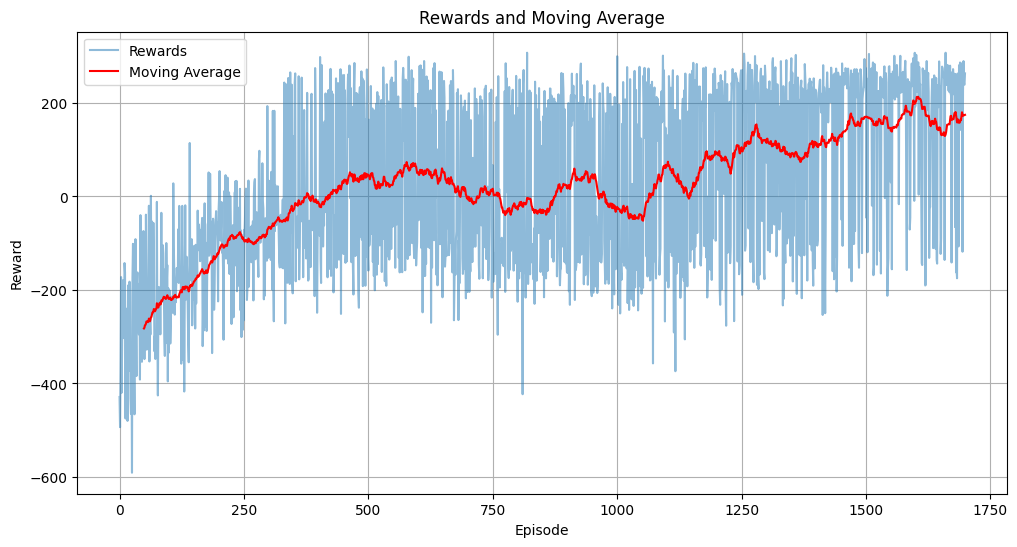

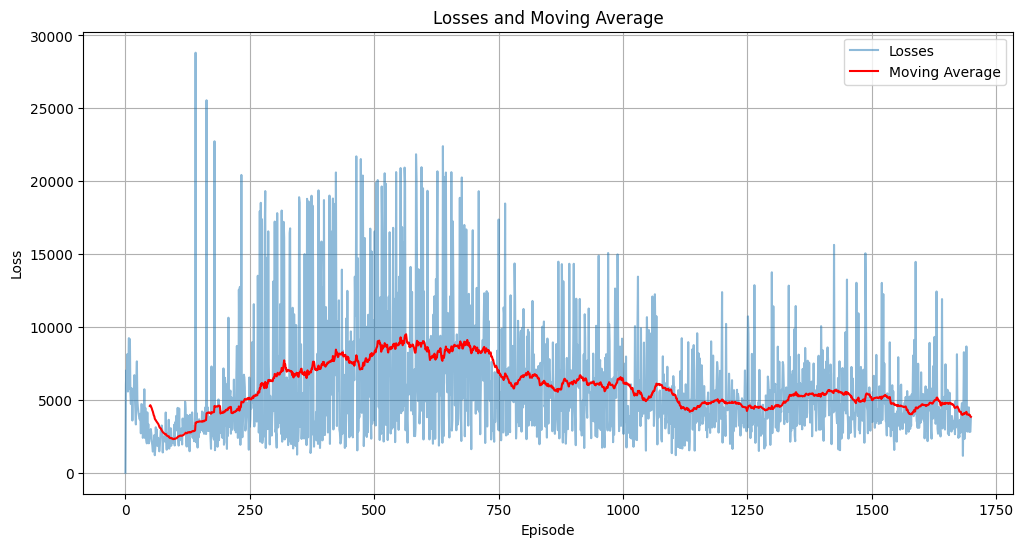

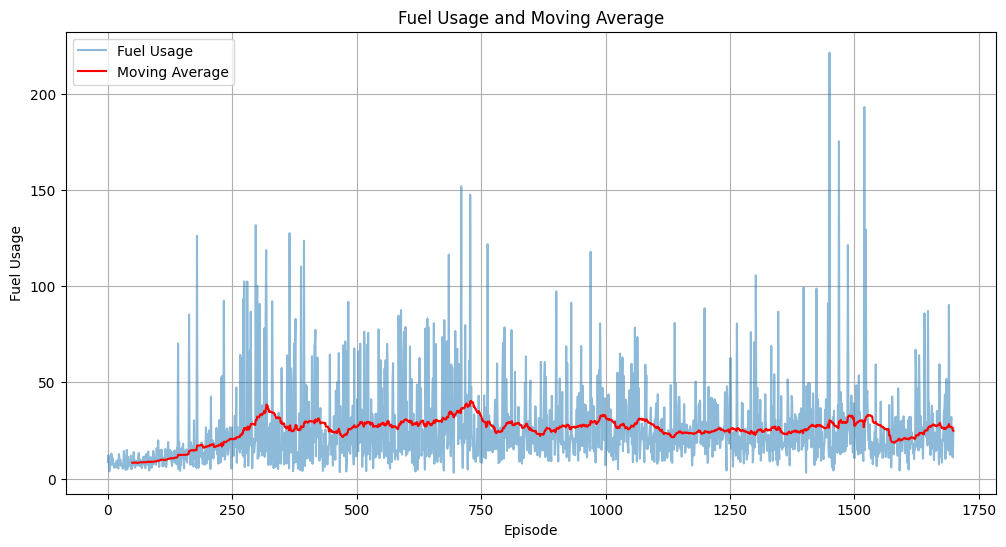

In [ ]:
dqn_optim.plot_results()

In [ ]:
dqn_optim.save_model("dqn_optim_lunarlander-win-env-2k-adam.pth")

In [ ]:
dqn_optim.load_model("dqn_optim_lunarlander-win-env-2k-adam.pth")

Model loaded successfully.


/tmp/ipykernel_1781/1865257543.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename, map_location=device)


In [ ]:
dqn_optim.test_model(episodes=500)

Total success:344/500, Average Reward: 170.10, Average Fuel Usage: 21.68


([np.float64(198.31995743940865),
  np.float64(-73.57585468320579),
  np.float64(251.42521728223588),
  np.float64(275.8644019022363),
  np.float64(251.08012771398552),
  np.float64(31.737276074954366),
  np.float64(230.4845332967431),
  np.float64(253.1496099017253),
  np.float64(232.84621960623312),
  np.float64(247.25528170368744),
  np.float64(222.29208766434027),
  np.float64(230.6427142005731),
  np.float64(265.2113083720192),
  np.float64(-12.299289557295154),
  np.float64(255.357328204937),
  np.float64(244.38497176688114),
  np.float64(272.7446029938525),
  np.float64(212.3996205594348),
  np.float64(9.955535503197211),
  np.float64(179.81501816639232),
  np.float64(229.09149067100236),
  np.float64(242.18972772322098),
  np.float64(168.15147405597895),
  np.float64(244.88652093455786),
  np.float64(235.30075181984267),
  np.float64(-112.60332987138885),
  np.float64(224.91624336114796),
  np.float64(252.8916737312259),
  np.float64(199.2614425884098),
  np.float64(212.0618722

In [ ]:
dqn_optim.display_sample_video(sample_video=5)